In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision import datasets, models
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
#from torchvision.models.segmentation.deeplabv3 import DeepLabHead

f:\python\python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
import os
import datetime
import random
from PIL import Image
import time

In [4]:
from torchvision.utils import make_grid

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim

In [6]:
#import segmentation_models_pytorch as smp

In [7]:
from datasets import load_dataset

In [8]:
ds = load_dataset("sayakpaul/nyu_depth_v2", cache_dir = "./data")

Found cached dataset nyu_depth_v2 (G:/DepthSegmentation/data/sayakpaul___nyu_depth_v2/default/1.0.0/80157dc55fc37d154eb8157db00139028820c686cd2955a43a1d3850e315c383)
100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [10:43<00:00, 321.85s/it]


In [9]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 100
NUM_WORKERS = 2
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
PIN_MEMORY = True
LOAD_MODEL = True


In [10]:
#model = model = smp.Unet('resnet152', encoder_weights='imagenet')
#model = UNET()

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        self.original_model = models.resnet50( weights=True )
        self.new_model = torch.nn.Sequential(*(list(self.original_model.children())[:-7]),
                                             
                                             nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1)
                                             , nn.LeakyReLU(0.2),
                                             nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1)
                                             , nn.LeakyReLU(0.2),
                                             nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1)
                                             , nn.LeakyReLU(0.2),
                                             nn.Conv2d(4, 1, kernel_size=3, stride=1, padding=1)
                                             , nn.LeakyReLU(0.2),
                                             
                                            )
    def forward(self, x):
     
        
        
        return self.new_model(x)



In [12]:
class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()       
        self.original_model = models.densenet169( weights=True )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features

In [13]:
model = Encoder()
#model = PTModel()

f:\python\python37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
val = torch.rand(1, 3,224,224)

start = time.time()
r= model(val)
end = time.time()
print(r.shape)
print(end - start)

torch.Size([1, 1, 112, 112])
0.027533292770385742


In [38]:
r.shape

torch.Size([1, 64, 112, 112])

In [18]:
class NYUData(Dataset):
        def __init__(self, chunk):
            #ds = torch.tensor(load_dataset("sayakpaul/nyu_depth_v2", cache_dir = "./data"))
            self.chunk = chunk
            self.data = ds
            
        def __getitem__(self, index):
            flip = random.randint(0,1)
            rot = random.randint(-45,45)
            
            self.rgb_trans = A.Compose([
                A.Resize(width = 224, height = 224),
                A.Normalize(
                       mean = [0.0, 0.0, 0.0],
                        std = [1.0, 1.0, 1.0],
                        max_pixel_value=255
                    ),
                A.HorizontalFlip(p=flip),
               
                A.RandomBrightnessContrast(p = 1),
                
                ToTensorV2()
            ])
            self.dep_trans = A.Compose([
                A.Resize(width = 112, height = 112),
                A.HorizontalFlip(p=flip),
                
                ToTensorV2()
            ])
            image = self.data[self.chunk][index]['image']
            image = TF.rotate(img = image, interpolation = transforms.InterpolationMode.BILINEAR , angle = rot, expand= False)
            image = TF.center_crop(img = image, output_size = [224])
            image = np.array(image)
            image = self.rgb_trans(image = image)["image"]
            
            depth = self.data[self.chunk][index]['depth_map']
            depth = TF.rotate(img = depth, interpolation = transforms.InterpolationMode.BILINEAR, angle = rot, expand= False)
            depth = TF.center_crop(img = depth, output_size = [224])
            depth = np.array(depth)
            
            depth = self.dep_trans(image = depth)["image"]
            return  image , depth 
        def __len__(self):
            return len(self.data[self.chunk])

In [19]:

dataset = NYUData('train')
train_loader = DataLoader(dataset=dataset, batch_size=8, pin_memory=True)


In [29]:
dataset = NYUData('validation')
data_loader = DataLoader(dataset=dataset, batch_size=64)

In [30]:
model.to(DEVICE)
print("i have no idea what I am doing")

i have no idea what I am doing


In [20]:
def delta_accuracy(predicted_depth, true_depth, threshold=1.25 ):
    assert predicted_depth.shape == true_depth.shape
    max_ratio = torch.max(predicted_depth/true_depth, true_depth/predicted_depth)
    delta_accuracy = torch.mean((max_ratio<threshold).float()) * 100
    return delta_accuracy.item()
    

In [21]:
def average_relative_error(y_true, y_pred):
    y_true = torch.as_tensor(y_true, dtype=torch.float32)
    y_pred = torch.as_tensor(y_pred, dtype=torch.float32)
    

    absolute_differences = torch.abs(y_true - y_pred)
    
    # Avoid division by zero by adding a small constant; adjust as necessary
    epsilon = 1e-8
    relative_errors = absolute_differences / (y_true + epsilon)
    
    # Calculate the mean of relative errors
    average_error = torch.mean(relative_errors)
    
    return average_error

def rmse(y_true, y_pred):
    mse = F.mse_loss(y_pred, y_true, reduction='mean')
    rmse = torch.sqrt(mse)
    return rmse
def average_log10_error(y_true, y_pred):
   
    # Ensure that y_true and y_pred are torch tensors
    y_true = torch.as_tensor(y_true, dtype=torch.float32)
    y_pred = torch.as_tensor(y_pred, dtype=torch.float32)
    
    # Compute the log10 of the absolute ratio of predicted to actual values
    # Adding a small constant to the denominator to prevent division by zero
    epsilon = 1e-8
    log10_errors = torch.log10(torch.abs(y_pred / (y_true + epsilon)))
    
    # Calculate the mean of the absolute log10 errors
    average_log10_error = torch.mean(torch.abs(log10_errors))
    
    return average_log10_error

In [18]:
loop = tqdm(data_loader)

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

In [45]:
len(dataset)

47584

In [20]:
for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device = DEVICE)
    targets = targets.to(device = DEVICE)

    #forward
    with torch.cuda.amp.autocast():
        predictions = model(data)
        print(predictions.shape)
        print(delta_accuracy(predictions, targets, threshold=1.25 ))
        print(delta_accuracy(predictions, targets, threshold=1.5625 ))
        print(delta_accuracy(predictions, targets, threshold=1.95 ))
        print(average_relative_error(targets, predictions))
        print(rmse(targets, predictions))
        print(average_log10_error(targets, predictions))
        break

torch.Size([64, 1, 112, 112])
49.154972076416016
77.27275085449219
91.1612319946289


  0%|                                                                                           | 0/11 [00:30<?, ?it/s]

tensor(0.3139, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3635, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.1265, device='cuda:0', grad_fn=<MeanBackward0>)


In [22]:

def show_depths(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8)[0])
    
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0), vmax = 1)

def show_batch(dl, nmax=64):
    for images, depth in dl:
        show_images(images, nmax)
        show_depths(depth, nmax)
        break

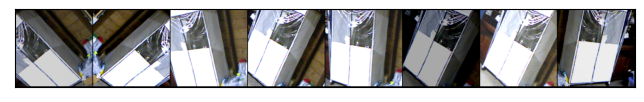

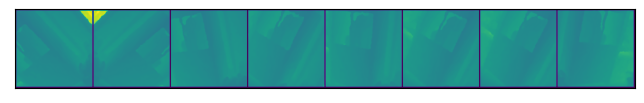

In [23]:
show_batch(train_loader,8)


In [24]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [39]:
i = 0
for param in model.parameters():
    i= i + 1
    if(i == 300):
        break
    param.requires_grad = False
print(i)    

161


In [41]:

for param in model.parameters():
    param.requires_grad =True

In [27]:


class SSIM(torch.nn.Module):
    def __init__(self):
        super(SSIM, self).__init__()
        

    def forward(self, x, y):
        Mx = torch.mean(x)
        My = torch.mean(y)
        xy = x * y
        #Vx = torch.mean((x - Mx) ** 2)
        Vx = torch.mean((x) ** 2) - Mx**2
        #Vy = torch.mean((y - My) ** 2)
        Vy = torch.mean((y) ** 2) - My**2
        Vxy = torch.mean(xy) - Mx * My
        Vcxy = torch.mean((x - Mx)*(y - My))
        c1 = (0.01)**2 
        c2 = (0.03)**2
        
        l = (2 * Mx * My + c1)/(Mx**2 + My**2 + c1)
        c = (2 * torch.sqrt(Vx * Vy) + c2)/(Vx + Vy + c2)
        s = (Vxy + c2/2) / (torch.sqrt(Vx * Vy) + c2/2)

        #ssim = (2*Mx*My + c1) * (2*Vxy + c2)/(Mx**2 + My**2 + c1)*(Vx**2 + Vy**2 + c2) 
        ssim = l * c * s
        lssim = torch.clamp((1 - ssim)*0.5,0,1)
        return ssim

In [26]:
a = torch.rand(8, 3,224,224)
b = model(a)
print(b.shape)
Loss_Function()(torch.rand(8, 1,112,112), b)

torch.Size([8, 1, 112, 112])


NameError: name 'Loss_Function' is not defined

In [28]:
class Loss_Function(nn.Module):
    def __init__(self):
        super().__init__()
        self.L1 = nn.L1Loss()
        self.ssim = SSIM()
    def forward(self,yhat,y):
        loss = self.L1(yhat, y)
        loss1 = torch.abs(self.ssim(yhat, y)) 
        return loss * 0.1 + loss1

In [29]:
#model =UNET().to(DEVICE)
#load from checkpoint
#model.load_state_dict(torch.load("D:\\DLStudy\\nyuDepth\\model\\2023-09-03_14-57_3_checkpoint.pth"))

model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()
    

In [30]:
#loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()
loss_fn = Loss_Function()

In [31]:
def Average(lst):
    return sum(lst) / len(lst)

In [32]:
def train(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    history = 0
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device = DEVICE)
        targets = targets.to(device = DEVICE)
        
        #forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            #loss = loss_fn(predictions['out'], targets)
            print(predictions.shape, targets.shape)
            loss = loss_fn(predictions, targets)
            print(loss)
            history= history + loss.item()
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loop.set_postfix(loss = loss)
    history = history/len(loader)
    return history    

In [96]:
def train(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader, position=0, leave=True)
    history = 0
  
    for batch_idx, (data, targets) in enumerate(loop):



        predictions = model(data)
        print(predictions.shape, targets.shape)
        loss = loss_fn(predictions, targets)
        history= history + loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss = loss)
        loop.update()
    history = history/len(loader)
    return history 

In [33]:
def save_result(epoch):
    i = 0
    for batch in train_loader:
        i = i+ 1
        if(i==100): 
            image, depth = batch
            r = model(image.cuda())
            f, axarr = plt.subplots(2,4)
            for ax in axarr.flatten():
                ax.set_xticks([])
                ax.set_yticks([])
            for i in range(4):
                axarr[0][i].imshow(depth[i].detach().permute(1,2,0))
                axarr[1][i].imshow(r[i][0].cpu().detach().numpy())
            PATH = os.path.join(os.getcwd(), "result", datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+"_" +str(epoch) + ".jpg")
            plt.savefig(PATH)
            break


In [ ]:
result = []
for epoch in range(NUM_EPOCHS):
    l = train(train_loader, model, optimizer, loss_fn, scaler)
    result.append(l)

    PATH = os.path.join(os.getcwd(), "model", "resnet50", datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+"_" + str(l) + "_" +str(epoch) + ".pth")
    torch.save(model.state_dict(), PATH)
    if(epoch % 2 == 0):save_result(epoch)

  0%|                                                                                         | 0/5948 [00:00<?, ?it/s]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3321, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 1/5948 [00:22<37:59:03, 22.99s/it, loss=tensor(0.3321, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3466, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                 | 3/5948 [00:24<9:32:07,  5.77s/it, loss=tensor(0.3580, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3580, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                 | 4/5948 [00:25<6:17:40,  3.81s/it, loss=tensor(0.3541, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3541, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                 | 5/5948 [00:26<4:27:08,  2.70s/it, loss=tensor(0.4031, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4031, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                 | 6/5948 [00:26<3:24:00,  2.06s/it, loss=tensor(0.4120, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4120, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                 | 7/5948 [00:27<2:41:24,  1.63s/it, loss=tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4171, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                 | 8/5948 [00:28<2:12:34,  1.34s/it, loss=tensor(0.4460, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4460, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                 | 9/5948 [00:29<1:54:02,  1.15s/it, loss=tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4787, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 10/5948 [00:29<1:42:06,  1.03s/it, loss=tensor(0.4611, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4611, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 11/5948 [00:30<1:34:09,  1.05it/s, loss=tensor(0.4621, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4621, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 12/5948 [00:31<1:27:34,  1.13it/s, loss=tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4738, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 13/5948 [00:32<1:21:49,  1.21it/s, loss=tensor(0.3952, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3952, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 14/5948 [00:32<1:18:34,  1.26it/s, loss=tensor(0.3553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3553, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 15/5948 [00:33<1:16:02,  1.30it/s, loss=tensor(0.3191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3191, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 16/5948 [00:34<1:15:38,  1.31it/s, loss=tensor(0.2239, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2239, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 17/5948 [00:35<1:13:20,  1.35it/s, loss=tensor(0.2656, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2656, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 18/5948 [00:35<1:14:39,  1.32it/s, loss=tensor(0.2769, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2769, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 19/5948 [00:36<1:13:42,  1.34it/s, loss=tensor(0.4294, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4294, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 20/5948 [00:37<1:13:28,  1.34it/s, loss=tensor(0.4381, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4381, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 21/5948 [00:38<1:16:44,  1.29it/s, loss=tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4249, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 22/5948 [00:38<1:15:38,  1.31it/s, loss=tensor(0.4280, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4280, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 23/5948 [00:39<1:14:51,  1.32it/s, loss=tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4332, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 24/5948 [00:40<1:16:20,  1.29it/s, loss=tensor(0.4352, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4352, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 25/5948 [00:41<1:18:01,  1.27it/s, loss=tensor(0.4314, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4314, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 26/5948 [00:42<1:19:04,  1.25it/s, loss=tensor(0.4124, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4124, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 27/5948 [00:42<1:16:39,  1.29it/s, loss=tensor(0.4143, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4143, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 28/5948 [00:43<1:15:51,  1.30it/s, loss=tensor(0.4025, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4025, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                | 29/5948 [00:44<1:16:15,  1.29it/s, loss=tensor(0.3869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3869, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 30/5948 [00:45<1:14:47,  1.32it/s, loss=tensor(0.3604, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3604, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 31/5948 [00:45<1:14:11,  1.33it/s, loss=tensor(0.3277, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3277, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 32/5948 [00:46<1:13:33,  1.34it/s, loss=tensor(0.3212, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3212, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 33/5948 [00:47<1:12:28,  1.36it/s, loss=tensor(0.2906, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2906, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 34/5948 [00:48<1:13:57,  1.33it/s, loss=tensor(0.3330, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3330, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 35/5948 [00:48<1:13:26,  1.34it/s, loss=tensor(0.3833, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3833, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 36/5948 [00:49<1:14:08,  1.33it/s, loss=tensor(0.2822, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2822, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 37/5948 [00:50<1:14:38,  1.32it/s, loss=tensor(0.2583, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2583, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 38/5948 [00:51<1:14:48,  1.32it/s, loss=tensor(0.2484, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2484, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 39/5948 [00:51<1:12:48,  1.35it/s, loss=tensor(0.2144, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2144, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 40/5948 [00:52<1:11:27,  1.38it/s, loss=tensor(0.1980, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1980, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 41/5948 [00:53<1:12:52,  1.35it/s, loss=tensor(0.2001, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2001, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 42/5948 [00:53<1:12:53,  1.35it/s, loss=tensor(0.1970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1970, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 43/5948 [00:54<1:13:29,  1.34it/s, loss=tensor(0.2125, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2125, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 44/5948 [00:55<1:12:27,  1.36it/s, loss=tensor(0.2444, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2444, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 45/5948 [00:56<1:13:22,  1.34it/s, loss=tensor(0.3152, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3152, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 46/5948 [00:57<1:17:56,  1.26it/s, loss=tensor(0.3491, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3491, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 47/5948 [00:57<1:15:42,  1.30it/s, loss=tensor(0.3690, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3690, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 48/5948 [00:58<1:20:58,  1.21it/s, loss=tensor(0.3540, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3540, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 49/5948 [00:59<1:17:04,  1.28it/s, loss=tensor(0.3891, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3891, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 50/5948 [01:00<1:15:09,  1.31it/s, loss=tensor(0.4331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4331, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 51/5948 [01:00<1:13:41,  1.33it/s, loss=tensor(0.3654, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3654, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 52/5948 [01:01<1:17:54,  1.26it/s, loss=tensor(0.1493, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1493, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 53/5948 [01:02<1:19:24,  1.24it/s, loss=tensor(0.1585, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1585, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 54/5948 [01:03<1:20:56,  1.21it/s, loss=tensor(0.1630, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1630, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 55/5948 [01:04<1:20:58,  1.21it/s, loss=tensor(0.1665, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1665, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 56/5948 [01:05<1:19:47,  1.23it/s, loss=tensor(0.1931, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1931, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 58/5948 [01:06<1:18:37,  1.25it/s, loss=tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 59/5948 [01:07<1:15:49,  1.29it/s, loss=tensor(0.1546, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1546, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 60/5948 [01:08<1:17:49,  1.26it/s, loss=tensor(0.1424, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1424, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 61/5948 [01:08<1:14:04,  1.32it/s, loss=tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 62/5948 [01:09<1:12:57,  1.34it/s, loss=tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 63/5948 [01:10<1:11:00,  1.38it/s, loss=tensor(0.2123, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2123, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 64/5948 [01:11<1:11:15,  1.38it/s, loss=tensor(0.1989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1989, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 66/5948 [01:12<1:13:51,  1.33it/s, loss=tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 67/5948 [01:13<1:12:33,  1.35it/s, loss=tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 68/5948 [01:14<1:12:56,  1.34it/s, loss=tensor(0.1624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1624, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 69/5948 [01:15<1:17:49,  1.26it/s, loss=tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 70/5948 [01:15<1:17:29,  1.26it/s, loss=tensor(0.1583, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1583, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 71/5948 [01:16<1:18:32,  1.25it/s, loss=tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 73/5948 [01:18<1:20:50,  1.21it/s, loss=tensor(0.1574, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1574, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 74/5948 [01:19<1:16:45,  1.28it/s, loss=tensor(0.1812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1812, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 75/5948 [01:19<1:14:28,  1.31it/s, loss=tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 76/5948 [01:20<1:18:23,  1.25it/s, loss=tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  1%|▏               | 77/5948 [01:21<1:23:54,  1.17it/s, loss=tensor(0.1334, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.1334, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 78/5948 [01:22<1:18:20,  1.25it/s, loss=tensor(0.1316, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1316, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 79/5948 [01:23<1:15:31,  1.30it/s, loss=tensor(0.1340, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1340, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 80/5948 [01:23<1:13:31,  1.33it/s, loss=tensor(0.1539, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1539, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1593, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 82/5948 [01:25<1:17:18,  1.26it/s, loss=tensor(0.1619, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1619, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 83/5948 [01:26<1:16:03,  1.29it/s, loss=tensor(0.1817, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1817, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  1%|▏               | 84/5948 [01:27<1:20:19,  1.22it/s, loss=tensor(0.1954, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.1954, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 85/5948 [01:27<1:16:46,  1.27it/s, loss=tensor(0.1496, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1496, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 86/5948 [01:28<1:13:18,  1.33it/s, loss=tensor(0.2088, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2088, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 87/5948 [01:29<1:12:36,  1.35it/s, loss=tensor(0.1992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1992, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2686, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏               | 89/5948 [01:30<1:13:50,  1.32it/s, loss=tensor(0.2094, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2094, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏               | 90/5948 [01:31<1:11:44,  1.36it/s, loss=tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▏               | 91/5948 [01:32<1:11:29,  1.37it/s, loss=tensor(0.1580, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1580, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2022, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎               | 93/5948 [01:33<1:13:56,  1.32it/s, loss=tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎               | 94/5948 [01:34<1:14:25,  1.31it/s, loss=tensor(0.2557, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2557, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎               | 95/5948 [01:35<1:13:17,  1.33it/s, loss=tensor(0.2545, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2545, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2592, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎               | 97/5948 [01:36<1:14:45,  1.30it/s, loss=tensor(0.2548, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2548, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎               | 98/5948 [01:37<1:14:22,  1.31it/s, loss=tensor(0.2683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2683, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 100/5948 [01:39<1:17:21,  1.26it/s, loss=tensor(0.1471, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1471, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 101/5948 [01:39<1:14:44,  1.30it/s, loss=tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 102/5948 [01:40<1:15:18,  1.29it/s, loss=tensor(0.1279, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1279, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 103/5948 [01:41<1:15:16,  1.29it/s, loss=tensor(0.2340, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2340, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2382, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 105/5948 [01:43<1:16:31,  1.27it/s, loss=tensor(0.1784, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1784, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 106/5948 [01:43<1:13:52,  1.32it/s, loss=tensor(0.2084, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2084, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 107/5948 [01:44<1:12:24,  1.34it/s, loss=tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 108/5948 [01:45<1:15:07,  1.30it/s, loss=tensor(0.1326, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1326, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 109/5948 [01:46<1:15:33,  1.29it/s, loss=tensor(0.2180, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2180, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 110/5948 [01:46<1:13:53,  1.32it/s, loss=tensor(0.1534, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1534, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 111/5948 [01:47<1:16:19,  1.27it/s, loss=tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 112/5948 [01:48<1:13:42,  1.32it/s, loss=tensor(0.1312, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1312, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 113/5948 [01:49<1:12:58,  1.33it/s, loss=tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 114/5948 [01:50<1:14:58,  1.30it/s, loss=tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 115/5948 [01:50<1:13:32,  1.32it/s, loss=tensor(0.1880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1880, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 116/5948 [01:51<1:13:21,  1.32it/s, loss=tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 117/5948 [01:52<1:12:28,  1.34it/s, loss=tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1812, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 119/5948 [01:53<1:17:14,  1.26it/s, loss=tensor(0.1498, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1498, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 120/5948 [01:54<1:14:37,  1.30it/s, loss=tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 121/5948 [01:55<1:14:09,  1.31it/s, loss=tensor(0.1605, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1605, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  2%|▎              | 122/5948 [01:56<1:22:02,  1.18it/s, loss=tensor(0.2345, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.2345, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 123/5948 [01:57<1:19:26,  1.22it/s, loss=tensor(0.2006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2006, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 124/5948 [01:57<1:16:18,  1.27it/s, loss=tensor(0.1334, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1334, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 125/5948 [01:58<1:14:12,  1.31it/s, loss=tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 126/5948 [01:59<1:15:39,  1.28it/s, loss=tensor(0.1748, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1748, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 127/5948 [02:00<1:16:45,  1.26it/s, loss=tensor(0.2627, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2627, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 128/5948 [02:00<1:13:56,  1.31it/s, loss=tensor(0.2696, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2696, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 129/5948 [02:01<1:13:53,  1.31it/s, loss=tensor(0.2154, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2154, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 130/5948 [02:02<1:12:02,  1.35it/s, loss=tensor(0.1986, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1986, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 131/5948 [02:03<1:15:31,  1.28it/s, loss=tensor(0.2156, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2156, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 132/5948 [02:04<1:15:43,  1.28it/s, loss=tensor(0.2314, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2314, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 133/5948 [02:04<1:18:20,  1.24it/s, loss=tensor(0.1960, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1960, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 134/5948 [02:05<1:17:33,  1.25it/s, loss=tensor(0.1779, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1779, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 135/5948 [02:06<1:15:53,  1.28it/s, loss=tensor(0.2144, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2144, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 136/5948 [02:07<1:13:57,  1.31it/s, loss=tensor(0.1917, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1917, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1522, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 138/5948 [02:08<1:17:05,  1.26it/s, loss=tensor(0.1468, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1468, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 139/5948 [02:09<1:13:25,  1.32it/s, loss=tensor(0.1740, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1740, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 140/5948 [02:10<1:13:06,  1.32it/s, loss=tensor(0.2498, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2498, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2339, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 142/5948 [02:11<1:14:34,  1.30it/s, loss=tensor(0.2007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2007, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 143/5948 [02:12<1:16:56,  1.26it/s, loss=tensor(0.1610, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1610, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 143/5948 [02:13<1:16:56,  1.26it/s, loss=tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 145/5948 [02:14<1:17:38,  1.25it/s, loss=tensor(0.1574, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1574, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 146/5948 [02:15<1:21:16,  1.19it/s, loss=tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1474, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎              | 148/5948 [02:16<1:18:58,  1.22it/s, loss=tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 149/5948 [02:17<1:15:44,  1.28it/s, loss=tensor(0.0832, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0832, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 150/5948 [02:18<1:14:59,  1.29it/s, loss=tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 151/5948 [02:19<1:14:17,  1.30it/s, loss=tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  3%|▍              | 152/5948 [02:20<1:22:49,  1.17it/s, loss=tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 153/5948 [02:20<1:16:52,  1.26it/s, loss=tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 154/5948 [02:21<1:16:51,  1.26it/s, loss=tensor(0.1819, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1819, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 155/5948 [02:22<1:18:21,  1.23it/s, loss=tensor(0.2541, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2541, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 156/5948 [02:23<1:19:08,  1.22it/s, loss=tensor(0.1978, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1978, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 157/5948 [02:24<1:15:23,  1.28it/s, loss=tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 158/5948 [02:24<1:15:07,  1.28it/s, loss=tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 159/5948 [02:25<1:17:23,  1.25it/s, loss=tensor(0.1350, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1350, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 160/5948 [02:26<1:16:23,  1.26it/s, loss=tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 161/5948 [02:27<1:14:58,  1.29it/s, loss=tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1628, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 163/5948 [02:28<1:14:36,  1.29it/s, loss=tensor(0.0823, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0823, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 164/5948 [02:29<1:13:36,  1.31it/s, loss=tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 165/5948 [02:30<1:12:56,  1.32it/s, loss=tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0820, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 167/5948 [02:31<1:14:14,  1.30it/s, loss=tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 168/5948 [02:32<1:13:08,  1.32it/s, loss=tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 170/5948 [02:34<1:14:44,  1.29it/s, loss=tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 171/5948 [02:34<1:12:57,  1.32it/s, loss=tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 172/5948 [02:35<1:12:19,  1.33it/s, loss=tensor(0.1712, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1712, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 173/5948 [02:36<1:12:51,  1.32it/s, loss=tensor(0.1750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1750, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 174/5948 [02:37<1:13:46,  1.30it/s, loss=tensor(0.2858, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2858, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 175/5948 [02:37<1:12:15,  1.33it/s, loss=tensor(0.1824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1824, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 176/5948 [02:38<1:13:53,  1.30it/s, loss=tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 177/5948 [02:39<1:13:10,  1.31it/s, loss=tensor(0.1840, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1840, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 178/5948 [02:40<1:12:23,  1.33it/s, loss=tensor(0.1756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1756, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 179/5948 [02:40<1:11:13,  1.35it/s, loss=tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 180/5948 [02:41<1:13:48,  1.30it/s, loss=tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 181/5948 [02:42<1:15:40,  1.27it/s, loss=tensor(0.1075, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1075, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 182/5948 [02:43<1:14:40,  1.29it/s, loss=tensor(0.1660, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1660, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 183/5948 [02:44<1:12:56,  1.32it/s, loss=tensor(0.1827, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1827, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1920, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 185/5948 [02:45<1:14:16,  1.29it/s, loss=tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 186/5948 [02:46<1:14:04,  1.30it/s, loss=tensor(0.1943, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1943, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 187/5948 [02:47<1:12:49,  1.32it/s, loss=tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 188/5948 [02:48<1:15:05,  1.28it/s, loss=tensor(0.1618, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1618, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1107, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 190/5948 [02:49<1:19:07,  1.21it/s, loss=tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 191/5948 [02:50<1:13:38,  1.30it/s, loss=tensor(0.1142, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1142, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 192/5948 [02:51<1:11:23,  1.34it/s, loss=tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 193/5948 [02:51<1:11:22,  1.34it/s, loss=tensor(0.0727, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0727, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 194/5948 [02:52<1:10:00,  1.37it/s, loss=tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 195/5948 [02:53<1:12:11,  1.33it/s, loss=tensor(0.2059, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2059, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 197/5948 [02:54<1:12:39,  1.32it/s, loss=tensor(0.3202, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3202, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍              | 198/5948 [02:55<1:16:07,  1.26it/s, loss=tensor(0.2434, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2434, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌              | 199/5948 [02:56<1:14:31,  1.29it/s, loss=tensor(0.2957, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2957, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌              | 200/5948 [02:57<1:13:54,  1.30it/s, loss=tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4190, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌              | 201/5948 [02:58<1:12:32,  1.32it/s, loss=tensor(0.3110, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3110, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌              | 202/5948 [02:58<1:10:58,  1.35it/s, loss=tensor(0.1528, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1528, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1738, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌              | 204/5948 [03:00<1:18:01,  1.23it/s, loss=tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌              | 205/5948 [03:01<1:15:33,  1.27it/s, loss=tensor(0.1590, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1590, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌              | 206/5948 [03:02<1:15:29,  1.27it/s, loss=tensor(0.1991, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1991, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌              | 207/5948 [03:02<1:18:53,  1.21it/s, loss=tensor(0.3060, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3060, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌              | 208/5948 [03:03<1:16:39,  1.25it/s, loss=tensor(0.2443, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2443, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 209/5948 [03:04<1:14:18,  1.29it/s, loss=tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2520, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 211/5948 [03:06<1:20:58,  1.18it/s, loss=tensor(0.3571, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3571, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 212/5948 [03:06<1:15:48,  1.26it/s, loss=tensor(0.3947, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3947, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 213/5948 [03:07<1:13:55,  1.29it/s, loss=tensor(0.2868, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2868, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 214/5948 [03:08<1:19:23,  1.20it/s, loss=tensor(0.0891, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0891, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 215/5948 [03:09<1:16:15,  1.25it/s, loss=tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 216/5948 [03:10<1:14:42,  1.28it/s, loss=tensor(0.1565, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1565, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  4%|▌              | 217/5948 [03:11<1:19:00,  1.21it/s, loss=tensor(0.2953, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.2953, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 218/5948 [03:11<1:14:08,  1.29it/s, loss=tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 219/5948 [03:12<1:10:04,  1.36it/s, loss=tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 220/5948 [03:13<1:09:39,  1.37it/s, loss=tensor(0.2909, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2909, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 221/5948 [03:13<1:12:14,  1.32it/s, loss=tensor(0.1396, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1396, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 222/5948 [03:14<1:10:34,  1.35it/s, loss=tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 223/5948 [03:15<1:09:23,  1.37it/s, loss=tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 224/5948 [03:16<1:12:11,  1.32it/s, loss=tensor(0.1809, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1809, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 225/5948 [03:16<1:10:41,  1.35it/s, loss=tensor(0.1241, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1241, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 226/5948 [03:17<1:08:41,  1.39it/s, loss=tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1988, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 228/5948 [03:19<1:12:33,  1.31it/s, loss=tensor(0.1909, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1909, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 229/5948 [03:19<1:11:14,  1.34it/s, loss=tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 231/5948 [03:21<1:12:37,  1.31it/s, loss=tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 232/5948 [03:22<1:11:26,  1.33it/s, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 233/5948 [03:22<1:10:49,  1.34it/s, loss=tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 235/5948 [03:24<1:16:14,  1.25it/s, loss=tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 236/5948 [03:25<1:14:01,  1.29it/s, loss=tensor(0.0763, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0763, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 237/5948 [03:26<1:14:07,  1.28it/s, loss=tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 238/5948 [03:26<1:13:54,  1.29it/s, loss=tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 239/5948 [03:27<1:14:15,  1.28it/s, loss=tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 240/5948 [03:28<1:13:33,  1.29it/s, loss=tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 241/5948 [03:29<1:14:55,  1.27it/s, loss=tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 242/5948 [03:29<1:11:24,  1.33it/s, loss=tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 243/5948 [03:30<1:10:18,  1.35it/s, loss=tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 244/5948 [03:31<1:12:40,  1.31it/s, loss=tensor(0.1580, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1580, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 245/5948 [03:32<1:10:09,  1.35it/s, loss=tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌              | 246/5948 [03:32<1:11:09,  1.34it/s, loss=tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 248/5948 [03:34<1:17:39,  1.22it/s, loss=tensor(0.1373, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1373, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 249/5948 [03:35<1:16:00,  1.25it/s, loss=tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 250/5948 [03:36<1:14:19,  1.28it/s, loss=tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 251/5948 [03:36<1:13:14,  1.30it/s, loss=tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 252/5948 [03:37<1:10:37,  1.34it/s, loss=tensor(0.2134, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2134, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 253/5948 [03:38<1:09:28,  1.37it/s, loss=tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0276, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  4%|▋              | 254/5948 [03:39<1:14:40,  1.27it/s, loss=tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 255/5948 [03:39<1:13:29,  1.29it/s, loss=tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 256/5948 [03:40<1:10:48,  1.34it/s, loss=tensor(0.0907, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0907, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 257/5948 [03:41<1:10:35,  1.34it/s, loss=tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 258/5948 [03:42<1:09:50,  1.36it/s, loss=tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1492, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 260/5948 [03:43<1:14:20,  1.28it/s, loss=tensor(0.2205, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2205, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 261/5948 [03:44<1:12:16,  1.31it/s, loss=tensor(0.1920, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1920, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 262/5948 [03:45<1:11:30,  1.33it/s, loss=tensor(0.1766, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1766, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 264/5948 [03:46<1:12:42,  1.30it/s, loss=tensor(0.1452, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1452, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 265/5948 [03:47<1:10:55,  1.34it/s, loss=tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 266/5948 [03:48<1:10:51,  1.34it/s, loss=tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋              | 267/5948 [03:49<1:10:14,  1.35it/s, loss=tensor(0.0771, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0771, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 268/5948 [03:49<1:08:59,  1.37it/s, loss=tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1558, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 270/5948 [03:51<1:12:52,  1.30it/s, loss=tensor(0.0743, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0743, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 271/5948 [03:52<1:11:25,  1.32it/s, loss=tensor(0.1504, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1504, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 272/5948 [03:52<1:09:53,  1.35it/s, loss=tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 273/5948 [03:53<1:14:21,  1.27it/s, loss=tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 274/5948 [03:54<1:10:57,  1.33it/s, loss=tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 275/5948 [03:55<1:09:43,  1.36it/s, loss=tensor(0.1770, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1770, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 276/5948 [03:55<1:10:23,  1.34it/s, loss=tensor(0.1909, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1909, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2329, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 278/5948 [03:57<1:11:20,  1.32it/s, loss=tensor(0.2021, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2021, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 279/5948 [03:58<1:08:47,  1.37it/s, loss=tensor(0.2013, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2013, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 280/5948 [03:58<1:08:40,  1.38it/s, loss=tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 281/5948 [03:59<1:08:16,  1.38it/s, loss=tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 282/5948 [04:00<1:11:51,  1.31it/s, loss=tensor(0.1845, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1845, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 283/5948 [04:01<1:09:41,  1.35it/s, loss=tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 284/5948 [04:01<1:10:22,  1.34it/s, loss=tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 285/5948 [04:02<1:09:45,  1.35it/s, loss=tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 287/5948 [04:04<1:10:09,  1.34it/s, loss=tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 288/5948 [04:04<1:08:28,  1.38it/s, loss=tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 289/5948 [04:05<1:08:56,  1.37it/s, loss=tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 290/5948 [04:06<1:09:38,  1.35it/s, loss=tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  5%|▋              | 291/5948 [04:07<1:15:50,  1.24it/s, loss=tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 292/5948 [04:07<1:11:36,  1.32it/s, loss=tensor(0.0678, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0678, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 293/5948 [04:08<1:10:13,  1.34it/s, loss=tensor(0.1338, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1338, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 294/5948 [04:09<1:09:29,  1.36it/s, loss=tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 295/5948 [04:10<1:15:27,  1.25it/s, loss=tensor(0.2123, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2123, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 296/5948 [04:10<1:13:38,  1.28it/s, loss=tensor(0.2549, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2549, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▋              | 297/5948 [04:11<1:10:52,  1.33it/s, loss=tensor(0.3490, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3490, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  5%|▊              | 298/5948 [04:12<1:17:42,  1.21it/s, loss=tensor(0.3279, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.3279, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 299/5948 [04:13<1:12:36,  1.30it/s, loss=tensor(0.3625, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3625, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 300/5948 [04:14<1:12:55,  1.29it/s, loss=tensor(0.3066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3066, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 301/5948 [04:14<1:12:27,  1.30it/s, loss=tensor(0.2253, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2253, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 302/5948 [04:15<1:11:30,  1.32it/s, loss=tensor(0.2204, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2204, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 303/5948 [04:16<1:10:59,  1.33it/s, loss=tensor(0.2220, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2220, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  5%|▊              | 304/5948 [04:17<1:17:31,  1.21it/s, loss=tensor(0.2706, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.2706, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 305/5948 [04:18<1:16:07,  1.24it/s, loss=tensor(0.2335, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2335, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 306/5948 [04:18<1:12:23,  1.30it/s, loss=tensor(0.2222, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2222, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 307/5948 [04:19<1:11:51,  1.31it/s, loss=tensor(0.2319, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2319, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 308/5948 [04:20<1:12:26,  1.30it/s, loss=tensor(0.2581, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2581, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 309/5948 [04:21<1:11:26,  1.32it/s, loss=tensor(0.1911, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1911, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 310/5948 [04:21<1:10:14,  1.34it/s, loss=tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 311/5948 [04:22<1:12:31,  1.30it/s, loss=tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 312/5948 [04:23<1:10:25,  1.33it/s, loss=tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 313/5948 [04:24<1:11:49,  1.31it/s, loss=tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 314/5948 [04:24<1:11:19,  1.32it/s, loss=tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 315/5948 [04:25<1:12:01,  1.30it/s, loss=tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 317/5948 [04:27<1:12:59,  1.29it/s, loss=tensor(0.1465, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1465, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 318/5948 [04:27<1:11:56,  1.30it/s, loss=tensor(0.1796, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1796, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 319/5948 [04:28<1:12:03,  1.30it/s, loss=tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 320/5948 [04:29<1:14:12,  1.26it/s, loss=tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 321/5948 [04:30<1:13:52,  1.27it/s, loss=tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 322/5948 [04:31<1:11:34,  1.31it/s, loss=tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 323/5948 [04:31<1:11:02,  1.32it/s, loss=tensor(0.1837, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1837, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 325/5948 [04:33<1:10:59,  1.32it/s, loss=tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 326/5948 [04:34<1:10:29,  1.33it/s, loss=tensor(0.1681, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1681, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊              | 327/5948 [04:34<1:08:36,  1.37it/s, loss=tensor(0.2166, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2166, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2188, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▊              | 329/5948 [04:36<1:11:30,  1.31it/s, loss=tensor(0.0911, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0911, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▊              | 330/5948 [04:37<1:09:05,  1.36it/s, loss=tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▊              | 331/5948 [04:37<1:08:09,  1.37it/s, loss=tensor(0.1960, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1960, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▊              | 332/5948 [04:38<1:12:14,  1.30it/s, loss=tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▊              | 333/5948 [04:39<1:09:34,  1.35it/s, loss=tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▊              | 334/5948 [04:40<1:08:47,  1.36it/s, loss=tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▊              | 335/5948 [04:40<1:09:03,  1.35it/s, loss=tensor(0.1685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1685, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▊              | 335/5948 [04:41<1:09:03,  1.35it/s, loss=tensor(0.0894, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0894, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▊              | 337/5948 [04:42<1:10:35,  1.32it/s, loss=tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▊              | 338/5948 [04:43<1:10:34,  1.32it/s, loss=tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▊              | 339/5948 [04:43<1:09:47,  1.34it/s, loss=tensor(0.1110, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1110, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▊              | 341/5948 [04:45<1:16:28,  1.22it/s, loss=tensor(0.1990, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1990, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▊              | 342/5948 [04:46<1:12:41,  1.29it/s, loss=tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▊              | 343/5948 [04:47<1:10:11,  1.33it/s, loss=tensor(0.1897, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1897, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▊              | 344/5948 [04:47<1:10:40,  1.32it/s, loss=tensor(0.1757, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1757, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2122, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▊              | 346/5948 [04:49<1:11:27,  1.31it/s, loss=tensor(0.1755, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1755, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 347/5948 [04:50<1:12:11,  1.29it/s, loss=tensor(0.1686, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1686, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 348/5948 [04:50<1:10:09,  1.33it/s, loss=tensor(0.1894, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1894, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 349/5948 [04:51<1:08:39,  1.36it/s, loss=tensor(0.1709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1709, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1797, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 351/5948 [04:53<1:11:09,  1.31it/s, loss=tensor(0.2038, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2038, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 352/5948 [04:53<1:11:31,  1.30it/s, loss=tensor(0.2226, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2226, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 353/5948 [04:54<1:12:28,  1.29it/s, loss=tensor(0.2131, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2131, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 354/5948 [04:55<1:10:07,  1.33it/s, loss=tensor(0.1900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1900, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 355/5948 [04:56<1:09:17,  1.35it/s, loss=tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 356/5948 [04:56<1:11:07,  1.31it/s, loss=tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 357/5948 [04:57<1:07:54,  1.37it/s, loss=tensor(0.1047, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1047, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 358/5948 [04:58<1:07:04,  1.39it/s, loss=tensor(0.1646, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1646, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 359/5948 [04:59<1:06:49,  1.39it/s, loss=tensor(0.1846, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1846, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 360/5948 [04:59<1:05:12,  1.43it/s, loss=tensor(0.2430, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2430, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 362/5948 [05:01<1:09:53,  1.33it/s, loss=tensor(0.0607, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0607, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 363/5948 [05:02<1:11:40,  1.30it/s, loss=tensor(0.0597, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0597, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 364/5948 [05:02<1:10:01,  1.33it/s, loss=tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 366/5948 [05:04<1:11:50,  1.29it/s, loss=tensor(0.1643, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1643, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 367/5948 [05:05<1:08:51,  1.35it/s, loss=tensor(0.1346, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1346, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 368/5948 [05:05<1:08:44,  1.35it/s, loss=tensor(0.0463, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0463, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 369/5948 [05:06<1:07:06,  1.39it/s, loss=tensor(0.1562, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1562, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  6%|▉              | 370/5948 [05:07<1:11:29,  1.30it/s, loss=tensor(0.2557, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.2557, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 371/5948 [05:08<1:11:37,  1.30it/s, loss=tensor(0.2050, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2050, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 372/5948 [05:08<1:08:59,  1.35it/s, loss=tensor(0.1876, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1876, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 373/5948 [05:09<1:07:26,  1.38it/s, loss=tensor(0.1724, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1724, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1335, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 375/5948 [05:11<1:07:28,  1.38it/s, loss=tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 376/5948 [05:11<1:08:01,  1.37it/s, loss=tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 377/5948 [05:12<1:08:48,  1.35it/s, loss=tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 378/5948 [05:13<1:09:53,  1.33it/s, loss=tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 379/5948 [05:14<1:08:05,  1.36it/s, loss=tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 380/5948 [05:14<1:07:31,  1.37it/s, loss=tensor(0.0614, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0614, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  6%|▉              | 381/5948 [05:15<1:13:04,  1.27it/s, loss=tensor(0.2024, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.2024, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 382/5948 [05:16<1:10:24,  1.32it/s, loss=tensor(0.0350, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0350, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 383/5948 [05:17<1:08:20,  1.36it/s, loss=tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 384/5948 [05:17<1:08:01,  1.36it/s, loss=tensor(0.0638, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0638, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉              | 385/5948 [05:18<1:11:04,  1.30it/s, loss=tensor(0.0519, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0519, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▉              | 387/5948 [05:20<1:10:26,  1.32it/s, loss=tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▉              | 388/5948 [05:20<1:09:16,  1.34it/s, loss=tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▉              | 389/5948 [05:21<1:07:52,  1.37it/s, loss=tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▉              | 390/5948 [05:22<1:06:47,  1.39it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  7%|▉              | 391/5948 [05:23<1:15:34,  1.23it/s, loss=tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▉              | 392/5948 [05:24<1:11:44,  1.29it/s, loss=tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▉              | 393/5948 [05:24<1:09:59,  1.32it/s, loss=tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▉              | 394/5948 [05:25<1:09:20,  1.33it/s, loss=tensor(0.1271, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1271, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▉              | 395/5948 [05:26<1:13:06,  1.27it/s, loss=tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>)


  7%|▉              | 396/5948 [05:27<1:10:21,  1.32it/s, loss=tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 397/5948 [05:27<1:10:45,  1.31it/s, loss=tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 398/5948 [05:28<1:09:29,  1.33it/s, loss=tensor(0.1854, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1854, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 399/5948 [05:29<1:11:37,  1.29it/s, loss=tensor(0.2023, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2023, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 400/5948 [05:30<1:10:49,  1.31it/s, loss=tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 401/5948 [05:30<1:09:18,  1.33it/s, loss=tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 403/5948 [05:32<1:12:38,  1.27it/s, loss=tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 404/5948 [05:33<1:09:27,  1.33it/s, loss=tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 405/5948 [05:33<1:08:56,  1.34it/s, loss=tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 406/5948 [05:34<1:12:41,  1.27it/s, loss=tensor(0.0916, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0916, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 407/5948 [05:35<1:10:33,  1.31it/s, loss=tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 408/5948 [05:36<1:08:28,  1.35it/s, loss=tensor(0.0587, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0587, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 409/5948 [05:36<1:08:07,  1.36it/s, loss=tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 411/5948 [05:38<1:10:46,  1.30it/s, loss=tensor(0.0662, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0662, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 412/5948 [05:39<1:10:18,  1.31it/s, loss=tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 413/5948 [05:40<1:09:41,  1.32it/s, loss=tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 415/5948 [05:41<1:12:54,  1.26it/s, loss=tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 416/5948 [05:42<1:09:49,  1.32it/s, loss=tensor(0.1275, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1275, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 417/5948 [05:43<1:08:23,  1.35it/s, loss=tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 418/5948 [05:43<1:09:35,  1.32it/s, loss=tensor(0.2015, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2015, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 419/5948 [05:44<1:11:03,  1.30it/s, loss=tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 420/5948 [05:45<1:10:32,  1.31it/s, loss=tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 421/5948 [05:46<1:09:11,  1.33it/s, loss=tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  7%|█              | 422/5948 [05:47<1:13:36,  1.25it/s, loss=tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 423/5948 [05:47<1:10:24,  1.31it/s, loss=tensor(0.1568, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1568, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 424/5948 [05:48<1:09:07,  1.33it/s, loss=tensor(0.1698, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1698, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 425/5948 [05:49<1:10:44,  1.30it/s, loss=tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 426/5948 [05:50<1:10:41,  1.30it/s, loss=tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 428/5948 [05:51<1:11:40,  1.28it/s, loss=tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 429/5948 [05:52<1:09:41,  1.32it/s, loss=tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 430/5948 [05:53<1:08:29,  1.34it/s, loss=tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 432/5948 [05:54<1:10:15,  1.31it/s, loss=tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 433/5948 [05:55<1:07:52,  1.35it/s, loss=tensor(0.2034, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2034, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 434/5948 [05:56<1:08:35,  1.34it/s, loss=tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  7%|█              | 435/5948 [05:57<1:16:00,  1.21it/s, loss=tensor(0.1137, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.1137, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 436/5948 [05:57<1:12:33,  1.27it/s, loss=tensor(0.2200, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2200, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 437/5948 [05:58<1:10:12,  1.31it/s, loss=tensor(0.2049, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2049, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 438/5948 [05:59<1:09:13,  1.33it/s, loss=tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 439/5948 [06:00<1:12:39,  1.26it/s, loss=tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 440/5948 [06:00<1:10:32,  1.30it/s, loss=tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 441/5948 [06:01<1:08:54,  1.33it/s, loss=tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 442/5948 [06:02<1:11:26,  1.28it/s, loss=tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 443/5948 [06:03<1:11:45,  1.28it/s, loss=tensor(0.0343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0343, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  7%|█              | 444/5948 [06:04<1:17:11,  1.19it/s, loss=tensor(0.1836, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.1836, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 445/5948 [06:04<1:12:57,  1.26it/s, loss=tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█              | 446/5948 [06:05<1:09:55,  1.31it/s, loss=tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 447/5948 [06:06<1:09:56,  1.31it/s, loss=tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 448/5948 [06:07<1:08:06,  1.35it/s, loss=tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 449/5948 [06:07<1:08:29,  1.34it/s, loss=tensor(0.2060, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2060, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 450/5948 [06:08<1:10:51,  1.29it/s, loss=tensor(0.2334, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2334, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 451/5948 [06:09<1:09:00,  1.33it/s, loss=tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 452/5948 [06:10<1:07:16,  1.36it/s, loss=tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 453/5948 [06:10<1:09:57,  1.31it/s, loss=tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 454/5948 [06:11<1:09:19,  1.32it/s, loss=tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 455/5948 [06:12<1:08:06,  1.34it/s, loss=tensor(0.0976, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0976, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 456/5948 [06:13<1:13:35,  1.24it/s, loss=tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 457/5948 [06:13<1:10:03,  1.31it/s, loss=tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 458/5948 [06:14<1:08:33,  1.33it/s, loss=tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 459/5948 [06:15<1:08:28,  1.34it/s, loss=tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 460/5948 [06:16<1:06:10,  1.38it/s, loss=tensor(0.1515, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1515, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 461/5948 [06:16<1:09:01,  1.33it/s, loss=tensor(0.0379, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0379, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 462/5948 [06:17<1:07:59,  1.34it/s, loss=tensor(0.0323, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0323, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 463/5948 [06:18<1:07:13,  1.36it/s, loss=tensor(0.1465, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1465, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 464/5948 [06:19<1:07:16,  1.36it/s, loss=tensor(0.2103, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2103, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1107, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 466/5948 [06:20<1:11:29,  1.28it/s, loss=tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 467/5948 [06:21<1:10:33,  1.29it/s, loss=tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1153, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 469/5948 [06:23<1:09:44,  1.31it/s, loss=tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 470/5948 [06:23<1:07:27,  1.35it/s, loss=tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 471/5948 [06:24<1:06:54,  1.36it/s, loss=tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 472/5948 [06:25<1:05:41,  1.39it/s, loss=tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 473/5948 [06:25<1:09:50,  1.31it/s, loss=tensor(0.0321, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0321, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 474/5948 [06:26<1:10:59,  1.29it/s, loss=tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 475/5948 [06:27<1:12:11,  1.26it/s, loss=tensor(0.1587, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1587, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 476/5948 [06:28<1:11:27,  1.28it/s, loss=tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 477/5948 [06:29<1:13:24,  1.24it/s, loss=tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 478/5948 [06:30<1:12:39,  1.25it/s, loss=tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 479/5948 [06:30<1:10:43,  1.29it/s, loss=tensor(0.1678, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1678, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 481/5948 [06:32<1:10:44,  1.29it/s, loss=tensor(0.2074, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2074, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 482/5948 [06:33<1:10:05,  1.30it/s, loss=tensor(0.2187, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2187, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 483/5948 [06:33<1:09:33,  1.31it/s, loss=tensor(0.1759, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1759, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 484/5948 [06:34<1:12:43,  1.25it/s, loss=tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 485/5948 [06:35<1:10:50,  1.29it/s, loss=tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 486/5948 [06:36<1:09:55,  1.30it/s, loss=tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 488/5948 [06:37<1:10:12,  1.30it/s, loss=tensor(0.0461, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0461, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 489/5948 [06:38<1:09:56,  1.30it/s, loss=tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 490/5948 [06:39<1:09:23,  1.31it/s, loss=tensor(0.0419, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0419, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 490/5948 [06:40<1:09:23,  1.31it/s, loss=tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 492/5948 [06:41<1:13:14,  1.24it/s, loss=tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 493/5948 [06:41<1:10:42,  1.29it/s, loss=tensor(0.1531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1531, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 494/5948 [06:42<1:09:23,  1.31it/s, loss=tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▏             | 495/5948 [06:43<1:08:55,  1.32it/s, loss=tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1870, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎             | 497/5948 [06:44<1:11:52,  1.26it/s, loss=tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎             | 498/5948 [06:45<1:10:48,  1.28it/s, loss=tensor(0.0742, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0742, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1281, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎             | 500/5948 [06:47<1:12:21,  1.25it/s, loss=tensor(0.1582, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1582, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎             | 501/5948 [06:48<1:12:27,  1.25it/s, loss=tensor(0.2092, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2092, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎             | 502/5948 [06:48<1:09:52,  1.30it/s, loss=tensor(0.1857, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1857, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  8%|█▎             | 503/5948 [06:49<1:14:46,  1.21it/s, loss=tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎             | 504/5948 [06:50<1:11:02,  1.28it/s, loss=tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎             | 505/5948 [06:51<1:08:43,  1.32it/s, loss=tensor(0.1878, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1878, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 506/5948 [06:51<1:10:26,  1.29it/s, loss=tensor(0.1394, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1394, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 507/5948 [06:52<1:10:15,  1.29it/s, loss=tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0303, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 508/5948 [06:53<1:08:33,  1.32it/s, loss=tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 509/5948 [06:54<1:18:21,  1.16it/s, loss=tensor(0.2269, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2269, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 510/5948 [06:55<1:13:44,  1.23it/s, loss=tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 511/5948 [06:55<1:10:42,  1.28it/s, loss=tensor(0.1970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1970, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 512/5948 [06:56<1:09:06,  1.31it/s, loss=tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 513/5948 [06:57<1:11:30,  1.27it/s, loss=tensor(0.0595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0595, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 514/5948 [06:58<1:10:42,  1.28it/s, loss=tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 515/5948 [06:59<1:10:21,  1.29it/s, loss=tensor(0.1150, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1150, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 516/5948 [06:59<1:10:23,  1.29it/s, loss=tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 517/5948 [07:00<1:09:16,  1.31it/s, loss=tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 518/5948 [07:01<1:08:00,  1.33it/s, loss=tensor(0.0645, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0645, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 519/5948 [07:02<1:11:09,  1.27it/s, loss=tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 520/5948 [07:02<1:10:12,  1.29it/s, loss=tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 521/5948 [07:03<1:09:57,  1.29it/s, loss=tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  9%|█▎             | 522/5948 [07:04<1:15:20,  1.20it/s, loss=tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 523/5948 [07:05<1:12:29,  1.25it/s, loss=tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 524/5948 [07:06<1:11:00,  1.27it/s, loss=tensor(0.1820, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1820, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 525/5948 [07:06<1:10:44,  1.28it/s, loss=tensor(0.1670, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1670, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 526/5948 [07:07<1:09:30,  1.30it/s, loss=tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 527/5948 [07:08<1:08:00,  1.33it/s, loss=tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


  9%|█▎             | 528/5948 [07:09<1:12:25,  1.25it/s, loss=tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 529/5948 [07:09<1:09:29,  1.30it/s, loss=tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 530/5948 [07:10<1:07:08,  1.34it/s, loss=tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 531/5948 [07:11<1:07:14,  1.34it/s, loss=tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 532/5948 [07:12<1:07:38,  1.33it/s, loss=tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 534/5948 [07:13<1:10:04,  1.29it/s, loss=tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 535/5948 [07:14<1:09:37,  1.30it/s, loss=tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 536/5948 [07:15<1:11:26,  1.26it/s, loss=tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 537/5948 [07:16<1:09:42,  1.29it/s, loss=tensor(0.0567, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0567, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 538/5948 [07:16<1:10:22,  1.28it/s, loss=tensor(0.1088, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1088, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 539/5948 [07:17<1:09:01,  1.31it/s, loss=tensor(0.0922, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0922, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 540/5948 [07:18<1:08:54,  1.31it/s, loss=tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 541/5948 [07:19<1:06:22,  1.36it/s, loss=tensor(0.1675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1675, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 542/5948 [07:19<1:06:22,  1.36it/s, loss=tensor(0.1824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1824, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 543/5948 [07:20<1:08:51,  1.31it/s, loss=tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 544/5948 [07:21<1:08:26,  1.32it/s, loss=tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▎             | 545/5948 [07:22<1:07:22,  1.34it/s, loss=tensor(0.2055, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2055, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 546/5948 [07:22<1:06:02,  1.36it/s, loss=tensor(0.3056, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3056, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 547/5948 [07:23<1:05:38,  1.37it/s, loss=tensor(0.2151, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2151, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 548/5948 [07:24<1:10:14,  1.28it/s, loss=tensor(0.2251, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2251, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 549/5948 [07:25<1:10:22,  1.28it/s, loss=tensor(0.2773, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2773, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 550/5948 [07:25<1:08:58,  1.30it/s, loss=tensor(0.1803, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1803, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 551/5948 [07:26<1:08:19,  1.32it/s, loss=tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 552/5948 [07:27<1:11:39,  1.26it/s, loss=tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 553/5948 [07:28<1:09:22,  1.30it/s, loss=tensor(0.1208, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1208, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 554/5948 [07:28<1:06:29,  1.35it/s, loss=tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 555/5948 [07:29<1:10:02,  1.28it/s, loss=tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 556/5948 [07:30<1:07:22,  1.33it/s, loss=tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 557/5948 [07:31<1:04:47,  1.39it/s, loss=tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 558/5948 [07:31<1:05:25,  1.37it/s, loss=tensor(0.1250, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1250, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 559/5948 [07:32<1:06:15,  1.36it/s, loss=tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 560/5948 [07:33<1:06:35,  1.35it/s, loss=tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 561/5948 [07:34<1:07:49,  1.32it/s, loss=tensor(0.1465, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1465, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 562/5948 [07:34<1:07:05,  1.34it/s, loss=tensor(0.0814, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0814, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 563/5948 [07:35<1:06:24,  1.35it/s, loss=tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 564/5948 [07:36<1:05:22,  1.37it/s, loss=tensor(0.1437, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1437, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍             | 565/5948 [07:37<1:06:57,  1.34it/s, loss=tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 566/5948 [07:37<1:04:33,  1.39it/s, loss=tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 567/5948 [07:38<1:07:13,  1.33it/s, loss=tensor(0.0638, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0638, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 568/5948 [07:39<1:06:48,  1.34it/s, loss=tensor(0.0350, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0350, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 570/5948 [07:40<1:06:07,  1.36it/s, loss=tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 571/5948 [07:41<1:06:32,  1.35it/s, loss=tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 572/5948 [07:42<1:06:39,  1.34it/s, loss=tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 573/5948 [07:43<1:07:36,  1.33it/s, loss=tensor(0.1520, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1520, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 575/5948 [07:44<1:09:43,  1.28it/s, loss=tensor(0.0462, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0462, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 576/5948 [07:45<1:09:08,  1.29it/s, loss=tensor(0.0928, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0928, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 577/5948 [07:46<1:07:50,  1.32it/s, loss=tensor(0.0526, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0526, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 578/5948 [07:47<1:13:04,  1.22it/s, loss=tensor(0.1646, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1646, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 579/5948 [07:47<1:09:39,  1.28it/s, loss=tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 580/5948 [07:48<1:02:47,  1.42it/s, loss=tensor(0.1373, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1373, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 581/5948 [07:49<1:05:23,  1.37it/s, loss=tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 582/5948 [07:49<1:01:43,  1.45it/s, loss=tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 583/5948 [07:50<1:01:18,  1.46it/s, loss=tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 584/5948 [07:51<1:04:38,  1.38it/s, loss=tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 585/5948 [07:51<1:01:38,  1.45it/s, loss=tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 586/5948 [07:53<1:22:58,  1.08it/s, loss=tensor(0.0544, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0544, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 587/5948 [07:54<1:35:22,  1.07s/it, loss=tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 588/5948 [07:55<1:22:37,  1.08it/s, loss=tensor(0.0361, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0361, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 589/5948 [07:56<1:14:12,  1.20it/s, loss=tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 590/5948 [07:56<1:04:48,  1.38it/s, loss=tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 591/5948 [07:57<59:17,  1.51it/s, loss=tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 592/5948 [07:58<1:08:43,  1.30it/s, loss=tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0324, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 593/5948 [07:59<1:14:29,  1.20it/s, loss=tensor(0.0409, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0409, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▍             | 594/5948 [07:59<1:10:50,  1.26it/s, loss=tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 595/5948 [08:07<4:22:29,  2.94s/it, loss=tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 596/5948 [08:09<3:48:34,  2.56s/it, loss=tensor(0.2313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2313, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 597/5948 [08:10<3:21:32,  2.26s/it, loss=tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 598/5948 [08:13<3:36:41,  2.43s/it, loss=tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 599/5948 [08:17<4:06:43,  2.77s/it, loss=tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 600/5948 [08:19<3:53:07,  2.62s/it, loss=tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 601/5948 [08:21<3:32:39,  2.39s/it, loss=tensor(0.1237, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1237, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 602/5948 [08:22<2:55:36,  1.97s/it, loss=tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 603/5948 [08:23<2:22:43,  1.60s/it, loss=tensor(0.1585, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1585, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 604/5948 [08:29<4:41:06,  3.16s/it, loss=tensor(0.1959, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1959, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 605/5948 [08:31<4:00:26,  2.70s/it, loss=tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 606/5948 [08:32<3:05:07,  2.08s/it, loss=tensor(0.2251, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2251, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 607/5948 [08:32<2:29:31,  1.68s/it, loss=tensor(0.3214, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3214, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 608/5948 [08:33<1:59:48,  1.35s/it, loss=tensor(0.1828, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1828, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 609/5948 [08:34<1:45:17,  1.18s/it, loss=tensor(0.1992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1992, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 610/5948 [08:35<1:33:03,  1.05s/it, loss=tensor(0.1909, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1909, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 611/5948 [08:35<1:21:26,  1.09it/s, loss=tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 612/5948 [08:36<1:15:08,  1.18it/s, loss=tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 613/5948 [08:37<1:13:09,  1.22it/s, loss=tensor(0.0649, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0649, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 614/5948 [08:37<1:08:51,  1.29it/s, loss=tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 615/5948 [08:38<1:07:15,  1.32it/s, loss=tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 616/5948 [08:39<1:06:40,  1.33it/s, loss=tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 617/5948 [08:39<1:03:11,  1.41it/s, loss=tensor(0.0741, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0741, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 618/5948 [08:40<1:00:57,  1.46it/s, loss=tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 619/5948 [08:41<1:01:09,  1.45it/s, loss=tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌             | 620/5948 [08:41<1:00:08,  1.48it/s, loss=tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▊               | 621/5948 [08:42<57:31,  1.54it/s, loss=tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▊               | 622/5948 [08:43<56:46,  1.56it/s, loss=tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▊               | 623/5948 [08:43<53:30,  1.66it/s, loss=tensor(0.1424, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1424, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▊               | 624/5948 [08:44<50:23,  1.76it/s, loss=tensor(0.2644, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2644, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 625/5948 [08:44<50:10,  1.77it/s, loss=tensor(0.1675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1675, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 626/5948 [08:45<53:22,  1.66it/s, loss=tensor(0.1782, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1782, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 627/5948 [08:45<49:50,  1.78it/s, loss=tensor(0.1161, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1161, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 628/5948 [08:46<48:48,  1.82it/s, loss=tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 629/5948 [08:46<47:39,  1.86it/s, loss=tensor(0.1363, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1363, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 630/5948 [08:47<52:22,  1.69it/s, loss=tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▌             | 631/5948 [08:52<3:00:18,  2.03s/it, loss=tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▌             | 632/5948 [08:53<2:29:37,  1.69s/it, loss=tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▌             | 633/5948 [08:54<2:04:06,  1.40s/it, loss=tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▌             | 634/5948 [08:55<1:44:09,  1.18s/it, loss=tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▌             | 635/5948 [08:55<1:28:23,  1.00it/s, loss=tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▌             | 636/5948 [08:56<1:23:01,  1.07it/s, loss=tensor(0.1875, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1875, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▌             | 637/5948 [08:58<1:38:56,  1.12s/it, loss=tensor(0.2385, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2385, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▌             | 638/5948 [08:58<1:26:49,  1.02it/s, loss=tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▌             | 639/5948 [08:59<1:21:12,  1.09it/s, loss=tensor(0.2417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2417, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▌             | 640/5948 [09:00<1:15:45,  1.17it/s, loss=tensor(0.3865, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3865, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▌             | 641/5948 [09:00<1:10:42,  1.25it/s, loss=tensor(0.2936, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2936, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▌             | 642/5948 [09:01<1:07:11,  1.32it/s, loss=tensor(0.2453, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2453, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▌             | 643/5948 [09:04<1:58:05,  1.34s/it, loss=tensor(0.2267, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2267, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▌             | 644/5948 [09:04<1:41:48,  1.15s/it, loss=tensor(0.2704, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2704, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 645/5948 [09:05<1:30:52,  1.03s/it, loss=tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 646/5948 [09:06<1:23:13,  1.06it/s, loss=tensor(0.1127, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1127, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 647/5948 [09:07<1:37:41,  1.11s/it, loss=tensor(0.1342, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1342, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 648/5948 [09:08<1:31:24,  1.03s/it, loss=tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 649/5948 [09:09<1:22:02,  1.08it/s, loss=tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 650/5948 [09:10<1:15:23,  1.17it/s, loss=tensor(0.0774, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0774, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 651/5948 [09:10<1:10:22,  1.25it/s, loss=tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 652/5948 [09:11<1:07:33,  1.31it/s, loss=tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 653/5948 [09:12<1:03:39,  1.39it/s, loss=tensor(0.0829, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0829, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 654/5948 [09:12<1:00:48,  1.45it/s, loss=tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 655/5948 [09:13<59:18,  1.49it/s, loss=tensor(0.0454, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0454, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 656/5948 [09:14<1:02:04,  1.42it/s, loss=tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 657/5948 [09:15<1:06:32,  1.33it/s, loss=tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 658/5948 [09:16<1:26:20,  1.02it/s, loss=tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 659/5948 [09:19<2:27:29,  1.67s/it, loss=tensor(0.0919, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0919, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 660/5948 [09:20<2:02:43,  1.39s/it, loss=tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 661/5948 [09:22<2:28:24,  1.68s/it, loss=tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 662/5948 [09:24<2:25:06,  1.65s/it, loss=tensor(0.2545, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2545, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 663/5948 [09:25<2:04:24,  1.41s/it, loss=tensor(0.2886, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2886, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 664/5948 [09:25<1:44:19,  1.18s/it, loss=tensor(0.2164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2164, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 665/5948 [09:27<1:40:22,  1.14s/it, loss=tensor(0.1591, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1591, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 666/5948 [09:28<1:57:59,  1.34s/it, loss=tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 667/5948 [09:30<2:01:17,  1.38s/it, loss=tensor(0.1672, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1672, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 668/5948 [09:31<1:49:10,  1.24s/it, loss=tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 669/5948 [09:31<1:32:08,  1.05s/it, loss=tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 670/5948 [09:33<1:37:26,  1.11s/it, loss=tensor(0.1474, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1474, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 671/5948 [09:34<1:47:51,  1.23s/it, loss=tensor(0.1713, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1713, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 672/5948 [09:35<1:45:19,  1.20s/it, loss=tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 673/5948 [09:36<1:33:18,  1.06s/it, loss=tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 674/5948 [09:37<1:23:53,  1.05it/s, loss=tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 675/5948 [09:37<1:18:43,  1.12it/s, loss=tensor(0.1078, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1078, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 676/5948 [09:38<1:15:27,  1.16it/s, loss=tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 677/5948 [09:40<1:28:41,  1.01s/it, loss=tensor(0.0993, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0993, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 678/5948 [09:40<1:20:20,  1.09it/s, loss=tensor(0.2126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2126, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 679/5948 [09:41<1:13:36,  1.19it/s, loss=tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 680/5948 [09:42<1:10:27,  1.25it/s, loss=tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 681/5948 [09:56<7:06:59,  4.86s/it, loss=tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 682/5948 [09:59<6:25:53,  4.40s/it, loss=tensor(0.2444, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2444, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 683/5948 [10:00<4:51:02,  3.32s/it, loss=tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▋             | 684/5948 [10:03<4:45:20,  3.25s/it, loss=tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▋             | 685/5948 [10:06<4:40:43,  3.20s/it, loss=tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▋             | 686/5948 [10:12<5:42:42,  3.91s/it, loss=tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▋             | 687/5948 [10:20<7:25:58,  5.09s/it, loss=tensor(0.2176, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2176, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▋             | 688/5948 [10:25<7:28:50,  5.12s/it, loss=tensor(0.2655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2655, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▋             | 689/5948 [10:29<7:04:21,  4.84s/it, loss=tensor(0.2100, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2100, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▋             | 690/5948 [10:32<6:23:07,  4.37s/it, loss=tensor(0.1812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1812, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▋             | 691/5948 [10:35<5:29:41,  3.76s/it, loss=tensor(0.1762, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1762, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▋             | 692/5948 [10:38<5:18:03,  3.63s/it, loss=tensor(0.1603, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1603, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▋             | 693/5948 [10:41<4:56:34,  3.39s/it, loss=tensor(0.1865, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1865, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 694/5948 [10:42<3:47:39,  2.60s/it, loss=tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 695/5948 [10:42<2:59:34,  2.05s/it, loss=tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 696/5948 [10:43<2:29:05,  1.70s/it, loss=tensor(0.1548, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1548, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 697/5948 [10:44<2:11:56,  1.51s/it, loss=tensor(0.0921, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0921, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 698/5948 [10:46<2:16:59,  1.57s/it, loss=tensor(0.1746, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1746, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 699/5948 [10:49<2:48:24,  1.93s/it, loss=tensor(0.2909, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2909, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 700/5948 [10:50<2:20:39,  1.61s/it, loss=tensor(0.2818, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2818, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 701/5948 [10:50<1:56:32,  1.33s/it, loss=tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 702/5948 [10:51<1:36:13,  1.10s/it, loss=tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 703/5948 [10:52<1:33:45,  1.07s/it, loss=tensor(0.1458, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1458, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 704/5948 [10:52<1:22:11,  1.06it/s, loss=tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 705/5948 [10:54<1:29:35,  1.03s/it, loss=tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 706/5948 [10:54<1:21:46,  1.07it/s, loss=tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 707/5948 [10:58<2:40:47,  1.84s/it, loss=tensor(0.1676, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1676, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 708/5948 [10:59<2:16:45,  1.57s/it, loss=tensor(0.1281, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1281, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 709/5948 [11:01<2:21:52,  1.62s/it, loss=tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 710/5948 [11:03<2:31:21,  1.73s/it, loss=tensor(0.0801, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0801, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 711/5948 [11:06<3:03:54,  2.11s/it, loss=tensor(0.0825, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0825, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 712/5948 [11:08<3:04:41,  2.12s/it, loss=tensor(0.1405, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1405, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 713/5948 [11:26<9:55:53,  6.83s/it, loss=tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▋            | 714/5948 [11:34<10:25:51,  7.17s/it, loss=tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 715/5948 [11:37<8:33:19,  5.89s/it, loss=tensor(0.1455, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1455, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 716/5948 [11:39<6:42:37,  4.62s/it, loss=tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 717/5948 [11:40<5:10:25,  3.56s/it, loss=tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 718/5948 [11:41<4:01:46,  2.77s/it, loss=tensor(0.1717, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1717, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 719/5948 [11:41<3:04:11,  2.11s/it, loss=tensor(0.2405, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2405, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 720/5948 [11:42<2:31:27,  1.74s/it, loss=tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 721/5948 [11:43<2:07:36,  1.46s/it, loss=tensor(0.0943, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0943, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 722/5948 [11:44<1:54:19,  1.31s/it, loss=tensor(0.1710, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1710, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 723/5948 [11:45<1:43:07,  1.18s/it, loss=tensor(0.1032, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1032, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 724/5948 [11:45<1:28:18,  1.01s/it, loss=tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 725/5948 [11:46<1:24:32,  1.03it/s, loss=tensor(0.1648, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1648, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 726/5948 [11:47<1:13:15,  1.19it/s, loss=tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 727/5948 [11:48<1:14:38,  1.17it/s, loss=tensor(0.2080, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2080, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 728/5948 [11:48<1:05:51,  1.32it/s, loss=tensor(0.1496, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1496, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 729/5948 [11:49<59:30,  1.46it/s, loss=tensor(0.1629, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1629, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 730/5948 [11:49<54:33,  1.59it/s, loss=tensor(0.1834, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1834, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 731/5948 [11:50<51:21,  1.69it/s, loss=tensor(0.1965, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1965, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 732/5948 [11:50<52:25,  1.66it/s, loss=tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 733/5948 [11:51<51:01,  1.70it/s, loss=tensor(0.0743, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0743, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 734/5948 [11:51<49:43,  1.75it/s, loss=tensor(0.1059, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1059, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 735/5948 [11:52<47:20,  1.83it/s, loss=tensor(0.1644, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1644, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 736/5948 [11:53<51:21,  1.69it/s, loss=tensor(0.1791, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1791, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 737/5948 [11:53<49:20,  1.76it/s, loss=tensor(0.2058, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2058, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 738/5948 [11:54<47:10,  1.84it/s, loss=tensor(0.2537, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2537, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 739/5948 [11:54<48:47,  1.78it/s, loss=tensor(0.2811, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2811, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1917, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▊             | 741/5948 [11:56<1:03:32,  1.37it/s, loss=tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 742/5948 [11:57<58:31,  1.48it/s, loss=tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 743/5948 [11:57<53:14,  1.63it/s, loss=tensor(0.1278, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1278, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 744/5948 [11:58<49:52,  1.74it/s, loss=tensor(0.1092, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1092, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 745/5948 [11:58<50:52,  1.70it/s, loss=tensor(0.0793, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0793, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 746/5948 [11:59<48:21,  1.79it/s, loss=tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 747/5948 [11:59<49:30,  1.75it/s, loss=tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 748/5948 [12:00<47:17,  1.83it/s, loss=tensor(0.1634, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1634, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 749/5948 [12:00<45:16,  1.91it/s, loss=tensor(0.1637, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1637, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 750/5948 [12:01<46:45,  1.85it/s, loss=tensor(0.2627, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2627, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 751/5948 [12:01<49:02,  1.77it/s, loss=tensor(0.2700, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2700, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 752/5948 [12:02<46:50,  1.85it/s, loss=tensor(0.2913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2913, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 753/5948 [12:02<45:08,  1.92it/s, loss=tensor(0.2384, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2384, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 754/5948 [12:03<45:33,  1.90it/s, loss=tensor(0.2274, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2274, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 755/5948 [12:04<47:33,  1.82it/s, loss=tensor(0.2076, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2076, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 756/5948 [12:04<45:52,  1.89it/s, loss=tensor(0.2364, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2364, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 757/5948 [12:05<45:13,  1.91it/s, loss=tensor(0.2679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2679, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 758/5948 [12:05<43:58,  1.97it/s, loss=tensor(0.2179, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2179, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 759/5948 [12:06<46:45,  1.85it/s, loss=tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 760/5948 [12:06<46:19,  1.87it/s, loss=tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 761/5948 [12:07<45:42,  1.89it/s, loss=tensor(0.1085, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1085, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 762/5948 [12:07<46:02,  1.88it/s, loss=tensor(0.0850, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0850, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 763/5948 [12:08<44:25,  1.95it/s, loss=tensor(0.2577, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2577, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 764/5948 [12:08<42:46,  2.02it/s, loss=tensor(0.2415, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2415, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 765/5948 [12:09<46:05,  1.87it/s, loss=tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 766/5948 [12:09<44:16,  1.95it/s, loss=tensor(0.1076, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1076, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 767/5948 [12:10<42:26,  2.03it/s, loss=tensor(0.0978, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0978, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 768/5948 [12:10<44:55,  1.92it/s, loss=tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 769/5948 [12:11<47:10,  1.83it/s, loss=tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 770/5948 [12:11<48:41,  1.77it/s, loss=tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 771/5948 [12:12<53:22,  1.62it/s, loss=tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 772/5948 [12:13<52:07,  1.66it/s, loss=tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)


 13%|█▉             | 773/5948 [12:14<1:00:25,  1.43it/s, loss=tensor(0.1593, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1593, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 774/5948 [12:14<59:42,  1.44it/s, loss=tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 775/5948 [12:15<56:29,  1.53it/s, loss=tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 776/5948 [12:15<53:56,  1.60it/s, loss=tensor(0.1824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1824, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 777/5948 [12:16<59:27,  1.45it/s, loss=tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)


 13%|█▉             | 778/5948 [12:17<1:00:00,  1.44it/s, loss=tensor(0.1026, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1026, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 779/5948 [12:18<58:24,  1.47it/s, loss=tensor(0.2040, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2040, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 780/5948 [12:18<57:21,  1.50it/s, loss=tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 781/5948 [12:19<57:30,  1.50it/s, loss=tensor(0.0978, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0978, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 782/5948 [12:20<56:58,  1.51it/s, loss=tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 783/5948 [12:20<58:00,  1.48it/s, loss=tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 784/5948 [12:21<56:15,  1.53it/s, loss=tensor(0.1294, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1294, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 785/5948 [12:21<53:29,  1.61it/s, loss=tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 786/5948 [12:22<52:10,  1.65it/s, loss=tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 787/5948 [12:23<52:23,  1.64it/s, loss=tensor(0.1752, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1752, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 788/5948 [12:23<52:01,  1.65it/s, loss=tensor(0.1250, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1250, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 789/5948 [12:24<52:39,  1.63it/s, loss=tensor(0.2012, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2012, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 790/5948 [12:25<53:54,  1.59it/s, loss=tensor(0.1647, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1647, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 791/5948 [12:25<54:14,  1.58it/s, loss=tensor(0.1450, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1450, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 792/5948 [12:26<53:54,  1.59it/s, loss=tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 793/5948 [12:26<54:30,  1.58it/s, loss=tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██             | 794/5948 [12:28<1:04:31,  1.33it/s, loss=tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 795/5948 [12:28<59:46,  1.44it/s, loss=tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 796/5948 [12:29<58:15,  1.47it/s, loss=tensor(0.1637, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1637, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 797/5948 [12:29<57:51,  1.48it/s, loss=tensor(0.1496, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1496, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 798/5948 [12:30<56:00,  1.53it/s, loss=tensor(0.2383, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2383, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 799/5948 [12:31<55:04,  1.56it/s, loss=tensor(0.2278, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2278, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 800/5948 [12:31<54:07,  1.59it/s, loss=tensor(0.1536, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1536, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 801/5948 [12:32<55:55,  1.53it/s, loss=tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 802/5948 [12:33<55:48,  1.54it/s, loss=tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 803/5948 [12:33<1:00:27,  1.42it/s, loss=tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 804/5948 [12:34<1:00:55,  1.41it/s, loss=tensor(0.1627, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1627, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 805/5948 [12:35<58:25,  1.47it/s, loss=tensor(0.1688, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1688, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 806/5948 [12:35<55:14,  1.55it/s, loss=tensor(0.1746, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1746, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 807/5948 [12:36<1:01:48,  1.39it/s, loss=tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 808/5948 [12:37<1:07:58,  1.26it/s, loss=tensor(0.0870, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0870, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 809/5948 [12:38<1:14:46,  1.15it/s, loss=tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 810/5948 [12:39<1:11:02,  1.21it/s, loss=tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 811/5948 [12:40<1:07:32,  1.27it/s, loss=tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 812/5948 [12:40<1:05:32,  1.31it/s, loss=tensor(0.1438, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1438, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 813/5948 [12:41<1:06:42,  1.28it/s, loss=tensor(0.2022, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2022, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 814/5948 [12:42<1:04:10,  1.33it/s, loss=tensor(0.1975, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1975, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 815/5948 [12:42<1:01:22,  1.39it/s, loss=tensor(0.1682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1682, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 816/5948 [12:43<1:01:41,  1.39it/s, loss=tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 817/5948 [12:44<1:02:33,  1.37it/s, loss=tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 818/5948 [12:45<1:04:41,  1.32it/s, loss=tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 819/5948 [12:45<1:03:26,  1.35it/s, loss=tensor(0.1026, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1026, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 820/5948 [12:46<1:01:40,  1.39it/s, loss=tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 821/5948 [12:47<59:58,  1.42it/s, loss=tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 822/5948 [12:48<1:01:21,  1.39it/s, loss=tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 823/5948 [12:48<1:00:59,  1.40it/s, loss=tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 824/5948 [12:49<1:04:07,  1.33it/s, loss=tensor(0.1713, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1713, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 825/5948 [12:50<1:02:07,  1.37it/s, loss=tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 826/5948 [12:50<1:00:31,  1.41it/s, loss=tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 827/5948 [12:51<57:05,  1.49it/s, loss=tensor(0.0914, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0914, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 828/5948 [13:02<5:26:21,  3.82s/it, loss=tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 829/5948 [13:04<4:29:28,  3.16s/it, loss=tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 830/5948 [13:08<4:56:35,  3.48s/it, loss=tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 831/5948 [13:17<7:17:17,  5.13s/it, loss=tensor(0.0645, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0645, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 832/5948 [13:22<7:14:45,  5.10s/it, loss=tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▉            | 833/5948 [13:34<10:03:17,  7.08s/it, loss=tensor(0.0459, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0459, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▉            | 834/5948 [13:41<10:12:47,  7.19s/it, loss=tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 835/5948 [13:42<7:41:44,  5.42s/it, loss=tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 836/5948 [13:43<5:39:43,  3.99s/it, loss=tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 837/5948 [13:44<4:15:29,  3.00s/it, loss=tensor(0.1991, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1991, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 838/5948 [13:44<3:14:46,  2.29s/it, loss=tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 839/5948 [13:45<2:32:47,  1.79s/it, loss=tensor(0.1710, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1710, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 840/5948 [13:46<2:03:03,  1.45s/it, loss=tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 841/5948 [13:47<1:52:44,  1.32s/it, loss=tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██             | 842/5948 [13:47<1:37:41,  1.15s/it, loss=tensor(0.1537, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1537, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 843/5948 [13:48<1:25:13,  1.00s/it, loss=tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 844/5948 [13:49<1:16:20,  1.11it/s, loss=tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 845/5948 [13:49<1:11:08,  1.20it/s, loss=tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 846/5948 [13:50<1:04:55,  1.31it/s, loss=tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 847/5948 [13:51<1:08:24,  1.24it/s, loss=tensor(0.1090, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1090, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 848/5948 [13:52<1:05:39,  1.29it/s, loss=tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 849/5948 [13:52<1:03:21,  1.34it/s, loss=tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 850/5948 [13:53<1:03:48,  1.33it/s, loss=tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 851/5948 [13:54<1:02:07,  1.37it/s, loss=tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 852/5948 [13:55<1:02:27,  1.36it/s, loss=tensor(0.0717, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0717, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 853/5948 [13:55<1:02:12,  1.37it/s, loss=tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 854/5948 [13:56<1:03:30,  1.34it/s, loss=tensor(0.1772, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1772, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 855/5948 [13:57<1:01:42,  1.38it/s, loss=tensor(0.2312, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2312, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 856/5948 [14:10<6:19:40,  4.47s/it, loss=tensor(0.2674, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2674, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 857/5948 [14:14<6:12:53,  4.39s/it, loss=tensor(0.2847, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2847, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 858/5948 [14:24<8:31:33,  6.03s/it, loss=tensor(0.2474, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2474, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 859/5948 [14:25<6:33:14,  4.64s/it, loss=tensor(0.2252, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2252, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 860/5948 [14:26<4:53:03,  3.46s/it, loss=tensor(0.1861, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1861, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 861/5948 [14:27<3:49:11,  2.70s/it, loss=tensor(0.1803, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1803, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▏            | 862/5948 [14:28<3:04:50,  2.18s/it, loss=tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 863/5948 [14:29<2:30:24,  1.77s/it, loss=tensor(0.1078, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1078, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 864/5948 [14:30<2:04:14,  1.47s/it, loss=tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 865/5948 [14:31<1:52:57,  1.33s/it, loss=tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 866/5948 [14:31<1:38:28,  1.16s/it, loss=tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 867/5948 [14:32<1:34:47,  1.12s/it, loss=tensor(0.1265, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1265, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 868/5948 [14:33<1:23:01,  1.02it/s, loss=tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 869/5948 [14:34<1:21:49,  1.03it/s, loss=tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 870/5948 [14:35<1:20:33,  1.05it/s, loss=tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 871/5948 [14:36<1:16:08,  1.11it/s, loss=tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 872/5948 [14:36<1:12:24,  1.17it/s, loss=tensor(0.2660, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2660, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 873/5948 [14:37<1:04:27,  1.31it/s, loss=tensor(0.2377, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2377, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 874/5948 [14:38<1:07:23,  1.25it/s, loss=tensor(0.2357, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2357, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 875/5948 [14:39<1:06:53,  1.26it/s, loss=tensor(0.2827, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2827, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 876/5948 [14:41<1:37:47,  1.16s/it, loss=tensor(0.2780, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2780, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 877/5948 [14:50<5:00:14,  3.55s/it, loss=tensor(0.2097, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2097, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 878/5948 [14:52<4:26:39,  3.16s/it, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 879/5948 [14:54<3:48:21,  2.70s/it, loss=tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 880/5948 [14:54<2:55:00,  2.07s/it, loss=tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 881/5948 [15:08<7:55:28,  5.63s/it, loss=tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 882/5948 [15:12<7:08:45,  5.08s/it, loss=tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 883/5948 [15:13<5:19:07,  3.78s/it, loss=tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 884/5948 [15:14<4:14:27,  3.01s/it, loss=tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 885/5948 [15:15<3:17:28,  2.34s/it, loss=tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 886/5948 [15:16<2:38:25,  1.88s/it, loss=tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 887/5948 [15:16<2:06:29,  1.50s/it, loss=tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 888/5948 [15:17<1:41:27,  1.20s/it, loss=tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 889/5948 [15:17<1:26:28,  1.03s/it, loss=tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 890/5948 [15:18<1:13:40,  1.14it/s, loss=tensor(0.1701, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1701, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 891/5948 [15:18<1:05:19,  1.29it/s, loss=tensor(0.1913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1913, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▏            | 892/5948 [15:19<1:05:06,  1.29it/s, loss=tensor(0.1967, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1967, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 893/5948 [15:20<1:05:29,  1.29it/s, loss=tensor(0.1572, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1572, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 894/5948 [15:21<1:04:27,  1.31it/s, loss=tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 895/5948 [15:21<1:06:05,  1.27it/s, loss=tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 896/5948 [15:22<1:07:51,  1.24it/s, loss=tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 897/5948 [15:23<1:13:07,  1.15it/s, loss=tensor(0.2195, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2195, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 898/5948 [15:24<1:10:58,  1.19it/s, loss=tensor(0.1377, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1377, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 899/5948 [15:25<1:08:29,  1.23it/s, loss=tensor(0.1952, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1952, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 900/5948 [15:26<1:05:11,  1.29it/s, loss=tensor(0.1932, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1932, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 901/5948 [15:26<1:02:27,  1.35it/s, loss=tensor(0.2465, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2465, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 902/5948 [15:27<1:08:40,  1.22it/s, loss=tensor(0.2614, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2614, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 903/5948 [15:28<1:05:40,  1.28it/s, loss=tensor(0.2288, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2288, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 904/5948 [15:29<1:04:08,  1.31it/s, loss=tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 905/5948 [15:29<1:02:04,  1.35it/s, loss=tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 906/5948 [15:30<1:02:34,  1.34it/s, loss=tensor(0.1541, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1541, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 907/5948 [15:31<1:02:16,  1.35it/s, loss=tensor(0.2008, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2008, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 908/5948 [15:31<1:00:52,  1.38it/s, loss=tensor(0.2167, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2167, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 909/5948 [15:32<59:06,  1.42it/s, loss=tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 910/5948 [15:33<58:55,  1.42it/s, loss=tensor(0.0732, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0732, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 911/5948 [15:34<58:12,  1.44it/s, loss=tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 912/5948 [15:34<59:52,  1.40it/s, loss=tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 913/5948 [15:35<1:00:18,  1.39it/s, loss=tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 914/5948 [15:36<58:46,  1.43it/s, loss=tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 915/5948 [15:37<1:04:51,  1.29it/s, loss=tensor(0.2213, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2213, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 916/5948 [15:37<1:04:54,  1.29it/s, loss=tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 917/5948 [15:38<1:02:29,  1.34it/s, loss=tensor(0.1591, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1591, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 918/5948 [15:39<59:51,  1.40it/s, loss=tensor(0.1857, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1857, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 919/5948 [15:39<1:01:54,  1.35it/s, loss=tensor(0.1351, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1351, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 920/5948 [15:40<1:02:14,  1.35it/s, loss=tensor(0.2308, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2308, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▎            | 921/5948 [15:41<1:00:05,  1.39it/s, loss=tensor(0.2380, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2380, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 922/5948 [15:42<58:41,  1.43it/s, loss=tensor(0.2398, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2398, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 923/5948 [15:42<1:00:28,  1.38it/s, loss=tensor(0.2140, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2140, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 924/5948 [15:43<1:11:10,  1.18it/s, loss=tensor(0.1294, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1294, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


 16%|██▎            | 925/5948 [15:44<1:13:35,  1.14it/s, loss=tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 926/5948 [15:45<1:09:34,  1.20it/s, loss=tensor(0.0483, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0483, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 927/5948 [15:46<1:07:13,  1.24it/s, loss=tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 928/5948 [15:47<1:04:33,  1.30it/s, loss=tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 929/5948 [15:47<1:02:08,  1.35it/s, loss=tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0636, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 931/5948 [15:49<1:13:54,  1.13it/s, loss=tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 932/5948 [15:50<1:12:06,  1.16it/s, loss=tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 933/5948 [15:51<1:14:22,  1.12it/s, loss=tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 934/5948 [15:52<1:10:50,  1.18it/s, loss=tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 935/5948 [15:53<1:08:28,  1.22it/s, loss=tensor(0.2039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2039, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 936/5948 [15:53<1:08:19,  1.22it/s, loss=tensor(0.1645, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1645, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 937/5948 [15:54<1:04:21,  1.30it/s, loss=tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 938/5948 [15:55<1:03:00,  1.33it/s, loss=tensor(0.2147, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2147, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 939/5948 [15:55<1:01:22,  1.36it/s, loss=tensor(0.1683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1683, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 940/5948 [15:56<1:01:35,  1.36it/s, loss=tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▎            | 941/5948 [15:57<1:03:22,  1.32it/s, loss=tensor(0.2334, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2334, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 942/5948 [15:58<1:03:44,  1.31it/s, loss=tensor(0.1922, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1922, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 943/5948 [15:59<1:05:52,  1.27it/s, loss=tensor(0.1419, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1419, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 944/5948 [15:59<1:06:16,  1.26it/s, loss=tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 945/5948 [16:00<1:04:20,  1.30it/s, loss=tensor(0.1654, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1654, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 946/5948 [16:01<1:13:27,  1.13it/s, loss=tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 947/5948 [16:02<1:09:57,  1.19it/s, loss=tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


 16%|██▍            | 948/5948 [16:03<1:11:53,  1.16it/s, loss=tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 949/5948 [16:04<1:09:13,  1.20it/s, loss=tensor(0.1887, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1887, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 950/5948 [16:04<1:06:50,  1.25it/s, loss=tensor(0.2337, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2337, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 951/5948 [16:05<1:08:57,  1.21it/s, loss=tensor(0.1615, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1615, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 953/5948 [16:07<1:06:11,  1.26it/s, loss=tensor(0.2007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2007, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 954/5948 [16:08<1:04:07,  1.30it/s, loss=tensor(0.2231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2231, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 955/5948 [16:08<1:03:05,  1.32it/s, loss=tensor(0.1906, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1906, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 956/5948 [16:09<1:04:57,  1.28it/s, loss=tensor(0.1735, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1735, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 957/5948 [16:10<1:04:20,  1.29it/s, loss=tensor(0.2062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2062, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 958/5948 [16:11<1:07:36,  1.23it/s, loss=tensor(0.2013, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2013, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 959/5948 [16:12<1:05:55,  1.26it/s, loss=tensor(0.1563, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1563, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


 16%|██▍            | 960/5948 [16:13<1:12:20,  1.15it/s, loss=tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 961/5948 [16:13<1:10:31,  1.18it/s, loss=tensor(0.1727, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1727, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 962/5948 [16:14<1:14:52,  1.11it/s, loss=tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 963/5948 [16:15<1:15:40,  1.10it/s, loss=tensor(0.0832, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0832, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 964/5948 [16:16<1:14:49,  1.11it/s, loss=tensor(0.0815, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0815, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 965/5948 [16:17<1:16:00,  1.09it/s, loss=tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 966/5948 [16:18<1:12:08,  1.15it/s, loss=tensor(0.0607, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0607, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 967/5948 [16:19<1:10:12,  1.18it/s, loss=tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 968/5948 [16:20<1:16:44,  1.08it/s, loss=tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 969/5948 [16:21<1:19:27,  1.04it/s, loss=tensor(0.1665, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1665, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 970/5948 [16:22<1:27:12,  1.05s/it, loss=tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 971/5948 [16:23<1:32:10,  1.11s/it, loss=tensor(0.1440, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1440, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 972/5948 [16:27<2:32:21,  1.84s/it, loss=tensor(0.1668, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1668, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 974/5948 [16:31<2:26:03,  1.76s/it, loss=tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 975/5948 [16:31<2:01:10,  1.46s/it, loss=tensor(0.1266, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1266, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 976/5948 [16:33<1:57:02,  1.41s/it, loss=tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 977/5948 [16:34<1:47:10,  1.29s/it, loss=tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 978/5948 [16:34<1:33:41,  1.13s/it, loss=tensor(0.1415, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1415, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 979/5948 [16:35<1:23:41,  1.01s/it, loss=tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 980/5948 [16:36<1:18:24,  1.06it/s, loss=tensor(0.0543, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0543, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▍            | 981/5948 [16:37<1:18:35,  1.05it/s, loss=tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍            | 982/5948 [16:38<1:12:13,  1.15it/s, loss=tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0398, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍            | 983/5948 [16:38<1:11:03,  1.16it/s, loss=tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍            | 984/5948 [16:39<1:11:57,  1.15it/s, loss=tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍            | 985/5948 [16:40<1:10:33,  1.17it/s, loss=tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍            | 986/5948 [16:41<1:07:34,  1.22it/s, loss=tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍            | 987/5948 [16:42<1:06:10,  1.25it/s, loss=tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍            | 988/5948 [16:43<1:23:16,  1.01s/it, loss=tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍            | 989/5948 [16:45<1:47:04,  1.30s/it, loss=tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍            | 990/5948 [16:47<1:50:19,  1.34s/it, loss=tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▌            | 992/5948 [16:50<1:59:31,  1.45s/it, loss=tensor(0.0606, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0606, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▌            | 994/5948 [16:51<1:38:14,  1.19s/it, loss=tensor(0.1643, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1643, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▌            | 995/5948 [16:52<1:26:50,  1.05s/it, loss=tensor(0.2216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2216, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▌            | 996/5948 [16:53<1:18:18,  1.05it/s, loss=tensor(0.1306, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1306, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▌            | 998/5948 [16:55<1:11:59,  1.15it/s, loss=tensor(0.2034, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2034, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▌            | 999/5948 [16:55<1:08:58,  1.20it/s, loss=tensor(0.3090, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3090, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▎           | 1000/5948 [16:56<1:08:27,  1.20it/s, loss=tensor(0.2754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2754, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▎           | 1002/5948 [16:58<1:09:23,  1.19it/s, loss=tensor(0.2131, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2131, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▎           | 1003/5948 [16:59<1:06:23,  1.24it/s, loss=tensor(0.2417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2417, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▎           | 1004/5948 [16:59<1:04:31,  1.28it/s, loss=tensor(0.2250, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2250, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▎           | 1005/5948 [17:01<1:37:34,  1.18s/it, loss=tensor(0.1870, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1870, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▎           | 1006/5948 [17:02<1:29:49,  1.09s/it, loss=tensor(0.2371, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2371, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▎           | 1007/5948 [17:03<1:23:52,  1.02s/it, loss=tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▎           | 1008/5948 [17:04<1:16:16,  1.08it/s, loss=tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▎           | 1009/5948 [17:05<1:11:28,  1.15it/s, loss=tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1010/5948 [17:05<1:07:33,  1.22it/s, loss=tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1012/5948 [17:07<1:07:55,  1.21it/s, loss=tensor(0.2047, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2047, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1013/5948 [17:08<1:04:33,  1.27it/s, loss=tensor(0.2006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2006, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1014/5948 [17:09<1:07:12,  1.22it/s, loss=tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1016/5948 [17:10<1:06:17,  1.24it/s, loss=tensor(0.1703, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1703, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1017/5948 [17:13<1:41:17,  1.23s/it, loss=tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1018/5948 [17:15<2:17:09,  1.67s/it, loss=tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1019/5948 [17:18<2:40:14,  1.95s/it, loss=tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1020/5948 [17:21<3:01:40,  2.21s/it, loss=tensor(0.2194, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2194, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1021/5948 [17:23<3:11:09,  2.33s/it, loss=tensor(0.3476, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3476, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1022/5948 [17:26<3:12:53,  2.35s/it, loss=tensor(0.2624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2624, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1023/5948 [17:27<2:39:11,  1.94s/it, loss=tensor(0.1354, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1354, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1024/5948 [17:27<2:11:13,  1.60s/it, loss=tensor(0.2316, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2316, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


 17%|██▍           | 1025/5948 [17:28<1:57:09,  1.43s/it, loss=tensor(0.2438, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.2438, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1026/5948 [17:29<1:41:37,  1.24s/it, loss=tensor(0.1863, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1863, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1027/5948 [17:30<1:31:01,  1.11s/it, loss=tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1739, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1029/5948 [17:32<1:24:11,  1.03s/it, loss=tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1030/5948 [17:33<1:17:07,  1.06it/s, loss=tensor(0.2646, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2646, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1031/5948 [17:33<1:13:11,  1.12it/s, loss=tensor(0.1667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1667, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1032/5948 [17:34<1:11:36,  1.14it/s, loss=tensor(0.1378, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1378, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1033/5948 [17:35<1:06:44,  1.23it/s, loss=tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1034/5948 [17:36<1:05:17,  1.25it/s, loss=tensor(0.1770, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1770, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1035/5948 [17:37<1:08:59,  1.19it/s, loss=tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1036/5948 [17:38<1:10:38,  1.16it/s, loss=tensor(0.1517, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1517, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1037/5948 [17:38<1:05:37,  1.25it/s, loss=tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1038/5948 [17:39<1:02:59,  1.30it/s, loss=tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1039/5948 [17:40<1:00:58,  1.34it/s, loss=tensor(0.1646, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1646, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▍           | 1040/5948 [17:41<1:05:26,  1.25it/s, loss=tensor(0.2079, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2079, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1041/5948 [17:41<1:02:38,  1.31it/s, loss=tensor(0.2034, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2034, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1042/5948 [17:42<1:00:24,  1.35it/s, loss=tensor(0.1650, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1650, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1043/5948 [17:43<1:02:38,  1.31it/s, loss=tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1044/5948 [17:44<1:02:42,  1.30it/s, loss=tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1045/5948 [17:44<1:03:52,  1.28it/s, loss=tensor(0.2165, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2165, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1046/5948 [17:45<1:05:12,  1.25it/s, loss=tensor(0.2256, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2256, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1047/5948 [17:46<1:03:22,  1.29it/s, loss=tensor(0.1085, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1085, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1048/5948 [17:47<1:02:54,  1.30it/s, loss=tensor(0.2080, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2080, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1049/5948 [17:47<1:01:05,  1.34it/s, loss=tensor(0.1411, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1411, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1050/5948 [17:48<59:23,  1.37it/s, loss=tensor(0.1949, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1949, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1051/5948 [17:49<58:51,  1.39it/s, loss=tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1052/5948 [17:50<1:01:04,  1.34it/s, loss=tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1053/5948 [17:50<1:00:23,  1.35it/s, loss=tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1054/5948 [17:51<59:49,  1.36it/s, loss=tensor(0.1381, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1381, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1055/5948 [17:52<1:03:00,  1.29it/s, loss=tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1056/5948 [17:53<1:02:17,  1.31it/s, loss=tensor(0.1201, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1201, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1057/5948 [17:53<1:00:39,  1.34it/s, loss=tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1058/5948 [17:54<59:36,  1.37it/s, loss=tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1059/5948 [17:55<58:56,  1.38it/s, loss=tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1060/5948 [17:55<1:00:12,  1.35it/s, loss=tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1061/5948 [17:56<1:02:19,  1.31it/s, loss=tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▍           | 1062/5948 [17:57<1:01:40,  1.32it/s, loss=tensor(0.1620, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1620, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1063/5948 [17:58<1:02:18,  1.31it/s, loss=tensor(0.2351, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2351, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1064/5948 [17:59<1:01:43,  1.32it/s, loss=tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1065/5948 [17:59<1:00:04,  1.35it/s, loss=tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1066/5948 [18:00<58:51,  1.38it/s, loss=tensor(0.2210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2210, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1067/5948 [18:01<1:00:52,  1.34it/s, loss=tensor(0.1542, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1542, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1068/5948 [18:01<59:48,  1.36it/s, loss=tensor(0.1662, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1662, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1069/5948 [18:02<59:53,  1.36it/s, loss=tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1070/5948 [18:03<1:01:15,  1.33it/s, loss=tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1071/5948 [18:04<1:04:39,  1.26it/s, loss=tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1072/5948 [18:05<1:04:34,  1.26it/s, loss=tensor(0.1923, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1923, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1073/5948 [18:05<1:02:40,  1.30it/s, loss=tensor(0.2194, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2194, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1074/5948 [18:06<1:04:56,  1.25it/s, loss=tensor(0.1780, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1780, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1075/5948 [18:07<1:06:50,  1.22it/s, loss=tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1076/5948 [18:08<1:05:16,  1.24it/s, loss=tensor(0.1376, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1376, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1077/5948 [18:09<1:04:17,  1.26it/s, loss=tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1078/5948 [18:09<1:02:39,  1.30it/s, loss=tensor(0.1854, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1854, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1079/5948 [18:10<1:01:20,  1.32it/s, loss=tensor(0.2133, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2133, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1080/5948 [18:11<1:01:23,  1.32it/s, loss=tensor(0.1973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1973, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1081/5948 [18:12<1:12:01,  1.13it/s, loss=tensor(0.1293, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1293, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1082/5948 [18:13<1:08:34,  1.18it/s, loss=tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1083/5948 [18:14<1:06:37,  1.22it/s, loss=tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1084/5948 [18:14<1:04:22,  1.26it/s, loss=tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1085/5948 [18:15<1:02:26,  1.30it/s, loss=tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1086/5948 [18:16<1:02:27,  1.30it/s, loss=tensor(0.1486, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1486, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1087/5948 [18:17<1:01:12,  1.32it/s, loss=tensor(0.2310, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2310, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1088/5948 [18:17<1:02:15,  1.30it/s, loss=tensor(0.2229, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2229, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1089/5948 [18:18<1:01:43,  1.31it/s, loss=tensor(0.2437, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2437, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1090/5948 [18:19<1:02:14,  1.30it/s, loss=tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1091/5948 [18:20<1:03:52,  1.27it/s, loss=tensor(0.1076, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1076, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1092/5948 [18:20<1:04:13,  1.26it/s, loss=tensor(0.1489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1489, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1093/5948 [18:21<1:03:01,  1.28it/s, loss=tensor(0.1701, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1701, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1094/5948 [18:22<1:01:37,  1.31it/s, loss=tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1095/5948 [18:23<1:02:33,  1.29it/s, loss=tensor(0.1875, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1875, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1096/5948 [18:24<1:02:17,  1.30it/s, loss=tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1097/5948 [18:24<1:00:23,  1.34it/s, loss=tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1098/5948 [18:25<59:42,  1.35it/s, loss=tensor(0.1967, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1967, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1099/5948 [18:26<1:00:05,  1.34it/s, loss=tensor(0.2178, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2178, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▌           | 1100/5948 [18:26<1:00:21,  1.34it/s, loss=tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▌           | 1101/5948 [18:27<1:01:08,  1.32it/s, loss=tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▌           | 1103/5948 [18:29<1:03:49,  1.27it/s, loss=tensor(0.1338, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1338, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▌           | 1104/5948 [18:30<1:02:00,  1.30it/s, loss=tensor(0.1756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1756, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▌           | 1105/5948 [18:30<1:01:19,  1.32it/s, loss=tensor(0.1601, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1601, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▌           | 1106/5948 [18:31<1:02:14,  1.30it/s, loss=tensor(0.1241, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1241, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▌           | 1107/5948 [18:32<1:00:55,  1.32it/s, loss=tensor(0.1341, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1341, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▌           | 1108/5948 [18:33<1:00:23,  1.34it/s, loss=tensor(0.1978, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1978, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▌           | 1109/5948 [18:33<1:03:13,  1.28it/s, loss=tensor(0.1998, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1998, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▌           | 1110/5948 [18:34<1:01:36,  1.31it/s, loss=tensor(0.1371, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1371, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▌           | 1111/5948 [18:35<1:00:33,  1.33it/s, loss=tensor(0.1706, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1706, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▌           | 1112/5948 [18:36<1:02:41,  1.29it/s, loss=tensor(0.1871, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1871, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▌           | 1113/5948 [18:36<1:01:17,  1.31it/s, loss=tensor(0.1583, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1583, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▉             | 1114/5948 [18:37<59:58,  1.34it/s, loss=tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▌           | 1115/5948 [18:38<1:01:49,  1.30it/s, loss=tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1116/5948 [18:39<1:02:45,  1.28it/s, loss=tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1117/5948 [18:40<1:02:18,  1.29it/s, loss=tensor(0.1080, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1080, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1119/5948 [18:41<1:03:53,  1.26it/s, loss=tensor(0.1334, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1334, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1120/5948 [18:42<1:02:32,  1.29it/s, loss=tensor(0.1345, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1345, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1494, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1122/5948 [18:44<1:03:22,  1.27it/s, loss=tensor(0.1476, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1476, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1123/5948 [18:44<1:02:11,  1.29it/s, loss=tensor(0.1756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1756, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1124/5948 [18:45<1:00:56,  1.32it/s, loss=tensor(0.2056, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2056, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1125/5948 [18:46<59:48,  1.34it/s, loss=tensor(0.2048, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2048, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1126/5948 [18:47<59:56,  1.34it/s, loss=tensor(0.2158, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2158, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1127/5948 [18:47<1:03:12,  1.27it/s, loss=tensor(0.2048, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2048, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1129/5948 [18:49<1:06:58,  1.20it/s, loss=tensor(0.1090, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1090, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1130/5948 [18:50<1:03:40,  1.26it/s, loss=tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1131/5948 [18:51<1:01:55,  1.30it/s, loss=tensor(0.1537, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1537, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1132/5948 [18:51<1:00:43,  1.32it/s, loss=tensor(0.1815, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1815, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1133/5948 [18:52<1:03:04,  1.27it/s, loss=tensor(0.1026, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1026, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1134/5948 [18:53<1:01:29,  1.30it/s, loss=tensor(0.2082, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2082, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1135/5948 [18:54<1:03:41,  1.26it/s, loss=tensor(0.2123, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2123, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1136/5948 [18:55<1:04:30,  1.24it/s, loss=tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1137/5948 [18:55<1:01:40,  1.30it/s, loss=tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1138/5948 [18:56<1:02:15,  1.29it/s, loss=tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1139/5948 [18:57<1:00:43,  1.32it/s, loss=tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1140/5948 [18:57<58:50,  1.36it/s, loss=tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1141/5948 [18:58<1:03:49,  1.26it/s, loss=tensor(0.1704, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1704, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1142/5948 [18:59<1:01:39,  1.30it/s, loss=tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1143/5948 [19:00<1:01:00,  1.31it/s, loss=tensor(0.0905, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0905, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1144/5948 [19:00<58:08,  1.38it/s, loss=tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1145/5948 [19:01<56:55,  1.41it/s, loss=tensor(0.1385, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1385, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1808, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1147/5948 [19:03<58:34,  1.37it/s, loss=tensor(0.2410, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2410, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1148/5948 [19:03<57:51,  1.38it/s, loss=tensor(0.2895, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2895, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1149/5948 [19:04<57:12,  1.40it/s, loss=tensor(0.2772, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2772, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1150/5948 [19:05<57:40,  1.39it/s, loss=tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1151/5948 [19:06<1:00:39,  1.32it/s, loss=tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1152/5948 [19:06<1:00:39,  1.32it/s, loss=tensor(0.1533, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1533, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1153/5948 [19:07<59:12,  1.35it/s, loss=tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1153/5948 [19:08<59:12,  1.35it/s, loss=tensor(0.1740, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1740, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1155/5948 [19:09<1:02:47,  1.27it/s, loss=tensor(0.2026, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2026, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1156/5948 [19:09<1:00:02,  1.33it/s, loss=tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1157/5948 [19:10<58:27,  1.37it/s, loss=tensor(0.2186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2186, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1158/5948 [19:11<59:32,  1.34it/s, loss=tensor(0.1793, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1793, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▋           | 1159/5948 [19:12<1:04:09,  1.24it/s, loss=tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▋           | 1160/5948 [19:13<1:03:09,  1.26it/s, loss=tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▋           | 1161/5948 [19:13<1:03:12,  1.26it/s, loss=tensor(0.1188, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1188, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▋           | 1162/5948 [19:14<1:04:59,  1.23it/s, loss=tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▋           | 1163/5948 [19:15<1:02:04,  1.28it/s, loss=tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▋           | 1164/5948 [19:16<1:00:38,  1.31it/s, loss=tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1165/5948 [19:16<58:36,  1.36it/s, loss=tensor(0.0459, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0459, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▋           | 1166/5948 [19:17<1:00:31,  1.32it/s, loss=tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1167/5948 [19:18<58:22,  1.36it/s, loss=tensor(0.1615, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1615, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1167/5948 [19:19<58:22,  1.36it/s, loss=tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▊           | 1169/5948 [19:20<1:01:24,  1.30it/s, loss=tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1170/5948 [19:20<59:19,  1.34it/s, loss=tensor(0.0598, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0598, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1171/5948 [19:21<59:07,  1.35it/s, loss=tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▊           | 1172/5948 [19:22<1:00:30,  1.32it/s, loss=tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▊           | 1173/5948 [19:23<1:02:18,  1.28it/s, loss=tensor(0.1846, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1846, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▊           | 1174/5948 [19:23<1:01:14,  1.30it/s, loss=tensor(0.1799, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1799, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▊           | 1175/5948 [19:24<1:01:27,  1.29it/s, loss=tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▊           | 1177/5948 [19:26<1:02:30,  1.27it/s, loss=tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1178/5948 [19:26<59:34,  1.33it/s, loss=tensor(0.2345, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2345, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1179/5948 [19:27<58:46,  1.35it/s, loss=tensor(0.2002, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2002, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1180/5948 [19:28<57:41,  1.38it/s, loss=tensor(0.2280, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2280, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1180/5948 [19:29<57:41,  1.38it/s, loss=tensor(0.2301, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2301, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1182/5948 [19:29<58:21,  1.36it/s, loss=tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1183/5948 [19:30<58:01,  1.37it/s, loss=tensor(0.1329, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1329, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1184/5948 [19:31<57:35,  1.38it/s, loss=tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1185/5948 [19:32<59:21,  1.34it/s, loss=tensor(0.1046, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1046, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1186/5948 [19:32<58:24,  1.36it/s, loss=tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1187/5948 [19:33<57:30,  1.38it/s, loss=tensor(0.0930, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0930, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▊           | 1189/5948 [19:35<1:01:45,  1.28it/s, loss=tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▊           | 1190/5948 [19:35<1:02:09,  1.28it/s, loss=tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▊           | 1191/5948 [19:36<1:01:29,  1.29it/s, loss=tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1192/5948 [19:37<59:30,  1.33it/s, loss=tensor(0.0459, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0459, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1193/5948 [19:38<58:56,  1.34it/s, loss=tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1195/5948 [19:39<59:13,  1.34it/s, loss=tensor(0.2153, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2153, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▊           | 1196/5948 [19:40<1:00:53,  1.30it/s, loss=tensor(0.2347, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2347, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1197/5948 [19:41<59:49,  1.32it/s, loss=tensor(0.2921, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2921, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1198/5948 [19:41<58:09,  1.36it/s, loss=tensor(0.1874, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1874, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1199/5948 [19:42<59:11,  1.34it/s, loss=tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1200/5948 [19:43<58:00,  1.36it/s, loss=tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1201/5948 [19:44<57:30,  1.38it/s, loss=tensor(0.0610, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0610, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1202/5948 [19:44<57:07,  1.38it/s, loss=tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1203/5948 [19:45<57:17,  1.38it/s, loss=tensor(0.1208, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1208, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1204/5948 [19:46<57:13,  1.38it/s, loss=tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1205/5948 [19:46<56:53,  1.39it/s, loss=tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1206/5948 [19:47<56:00,  1.41it/s, loss=tensor(0.1613, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1613, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██▊           | 1207/5948 [19:48<1:01:43,  1.28it/s, loss=tensor(0.2381, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2381, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1208/5948 [19:49<59:19,  1.33it/s, loss=tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1209/5948 [19:49<57:50,  1.37it/s, loss=tensor(0.2619, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2619, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1210/5948 [19:50<57:41,  1.37it/s, loss=tensor(0.1732, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1732, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1211/5948 [19:51<57:19,  1.38it/s, loss=tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1213/5948 [19:52<59:37,  1.32it/s, loss=tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1214/5948 [19:53<58:28,  1.35it/s, loss=tensor(0.1755, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1755, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1215/5948 [19:54<59:24,  1.33it/s, loss=tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1216/5948 [19:55<57:42,  1.37it/s, loss=tensor(0.0990, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0990, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1217/5948 [19:55<56:43,  1.39it/s, loss=tensor(0.1653, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1653, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


 20%|██▊           | 1218/5948 [19:56<1:00:33,  1.30it/s, loss=tensor(0.2590, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.2590, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1219/5948 [19:57<58:51,  1.34it/s, loss=tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1220/5948 [19:58<58:41,  1.34it/s, loss=tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1221/5948 [19:58<58:39,  1.34it/s, loss=tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1222/5948 [19:59<58:52,  1.34it/s, loss=tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1223/5948 [20:00<1:00:26,  1.30it/s, loss=tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1224/5948 [20:01<59:47,  1.32it/s, loss=tensor(0.2195, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2195, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1225/5948 [20:01<1:00:04,  1.31it/s, loss=tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1226/5948 [20:02<1:00:30,  1.30it/s, loss=tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1227/5948 [20:03<59:48,  1.32it/s, loss=tensor(0.0834, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0834, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0775, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1229/5948 [20:05<1:00:01,  1.31it/s, loss=tensor(0.1840, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1840, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1230/5948 [20:05<58:27,  1.35it/s, loss=tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1231/5948 [20:06<58:43,  1.34it/s, loss=tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1232/5948 [20:07<58:26,  1.34it/s, loss=tensor(0.0771, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0771, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


 21%|██▉           | 1233/5948 [20:08<1:03:17,  1.24it/s, loss=tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1234/5948 [20:08<1:01:13,  1.28it/s, loss=tensor(0.0656, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0656, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1235/5948 [20:09<58:32,  1.34it/s, loss=tensor(0.1293, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1293, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1236/5948 [20:10<56:57,  1.38it/s, loss=tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1237/5948 [20:11<57:17,  1.37it/s, loss=tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1238/5948 [20:11<57:15,  1.37it/s, loss=tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1239/5948 [20:12<58:51,  1.33it/s, loss=tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1240/5948 [20:13<58:46,  1.34it/s, loss=tensor(0.1993, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1993, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1241/5948 [20:14<58:23,  1.34it/s, loss=tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0815, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1243/5948 [20:15<1:00:32,  1.30it/s, loss=tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1244/5948 [20:16<59:27,  1.32it/s, loss=tensor(0.1444, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1444, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1245/5948 [20:17<59:05,  1.33it/s, loss=tensor(0.1224, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1224, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1246/5948 [20:17<59:05,  1.33it/s, loss=tensor(0.0911, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0911, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1247/5948 [20:18<1:01:14,  1.28it/s, loss=tensor(0.0825, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0825, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1248/5948 [20:19<59:30,  1.32it/s, loss=tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1249/5948 [20:20<58:37,  1.34it/s, loss=tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1250/5948 [20:21<1:00:58,  1.28it/s, loss=tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1251/5948 [20:21<59:46,  1.31it/s, loss=tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1252/5948 [20:22<57:57,  1.35it/s, loss=tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1253/5948 [20:23<55:58,  1.40it/s, loss=tensor(0.1556, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1556, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1254/5948 [20:23<54:03,  1.45it/s, loss=tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1255/5948 [20:25<1:08:51,  1.14it/s, loss=tensor(0.3136, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3136, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1256/5948 [20:25<1:05:47,  1.19it/s, loss=tensor(0.2189, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2189, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1257/5948 [20:26<1:06:17,  1.18it/s, loss=tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1258/5948 [20:27<1:04:51,  1.21it/s, loss=tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1824, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1260/5948 [20:30<1:28:16,  1.13s/it, loss=tensor(0.1708, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1708, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1261/5948 [20:31<1:22:40,  1.06s/it, loss=tensor(0.1709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1709, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1262/5948 [20:32<1:32:53,  1.19s/it, loss=tensor(0.1721, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1721, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1263/5948 [20:33<1:29:41,  1.15s/it, loss=tensor(0.1793, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1793, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1264/5948 [20:34<1:21:26,  1.04s/it, loss=tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1265/5948 [20:35<1:20:39,  1.03s/it, loss=tensor(0.2022, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2022, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1266/5948 [20:36<1:20:17,  1.03s/it, loss=tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1267/5948 [20:37<1:16:05,  1.03it/s, loss=tensor(0.1667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1667, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1268/5948 [20:38<1:09:57,  1.11it/s, loss=tensor(0.1849, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1849, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1269/5948 [20:38<1:05:19,  1.19it/s, loss=tensor(0.1994, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1994, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1270/5948 [20:39<1:04:38,  1.21it/s, loss=tensor(0.2381, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2381, device='cuda:0', grad_fn=<AddBackward0>)


 21%|██▉           | 1271/5948 [20:40<1:03:32,  1.23it/s, loss=tensor(0.2418, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2418, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1272/5948 [20:40<55:56,  1.39it/s, loss=tensor(0.2699, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2699, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1273/5948 [20:41<51:42,  1.51it/s, loss=tensor(0.2692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2692, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1274/5948 [20:41<47:57,  1.62it/s, loss=tensor(0.2158, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2158, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1275/5948 [20:42<45:42,  1.70it/s, loss=tensor(0.1776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1776, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1276/5948 [20:43<56:08,  1.39it/s, loss=tensor(0.1881, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1881, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███           | 1277/5948 [20:44<1:00:05,  1.30it/s, loss=tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1278/5948 [20:45<58:08,  1.34it/s, loss=tensor(0.1820, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1820, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1279/5948 [20:45<1:01:23,  1.27it/s, loss=tensor(0.2752, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2752, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1280/5948 [20:46<1:03:04,  1.23it/s, loss=tensor(0.2349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2349, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1281/5948 [20:47<1:09:10,  1.12it/s, loss=tensor(0.1625, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1625, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1282/5948 [20:48<1:07:55,  1.14it/s, loss=tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1283/5948 [20:49<59:40,  1.30it/s, loss=tensor(0.0656, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0656, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1284/5948 [20:49<54:27,  1.43it/s, loss=tensor(0.0850, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0850, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1285/5948 [20:50<54:49,  1.42it/s, loss=tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1286/5948 [20:51<52:11,  1.49it/s, loss=tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1287/5948 [20:51<49:06,  1.58it/s, loss=tensor(0.1596, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1596, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1288/5948 [20:52<51:52,  1.50it/s, loss=tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1289/5948 [20:52<48:06,  1.61it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1290/5948 [20:53<51:28,  1.51it/s, loss=tensor(0.1459, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1459, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1291/5948 [20:54<48:57,  1.59it/s, loss=tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1292/5948 [20:54<47:32,  1.63it/s, loss=tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1712, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1294/5948 [20:56<1:03:43,  1.22it/s, loss=tensor(0.2383, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2383, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1295/5948 [20:57<1:06:54,  1.16it/s, loss=tensor(0.1675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1675, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1296/5948 [20:59<1:17:43,  1.00s/it, loss=tensor(0.1678, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1678, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1297/5948 [21:00<1:18:06,  1.01s/it, loss=tensor(0.1538, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1538, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1298/5948 [21:00<1:07:22,  1.15it/s, loss=tensor(0.1091, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1091, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1299/5948 [21:01<59:23,  1.30it/s, loss=tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1300/5948 [21:01<57:39,  1.34it/s, loss=tensor(0.0858, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0858, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1301/5948 [21:02<53:00,  1.46it/s, loss=tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1302/5948 [21:03<49:31,  1.56it/s, loss=tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1303/5948 [21:04<57:25,  1.35it/s, loss=tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1304/5948 [21:05<1:10:53,  1.09it/s, loss=tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1305/5948 [21:06<1:12:25,  1.07it/s, loss=tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1306/5948 [21:06<1:04:46,  1.19it/s, loss=tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1307/5948 [21:07<59:19,  1.30it/s, loss=tensor(0.1101, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1101, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1308/5948 [21:08<52:59,  1.46it/s, loss=tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1309/5948 [21:08<48:51,  1.58it/s, loss=tensor(0.0859, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0859, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1310/5948 [21:17<4:13:23,  3.28s/it, loss=tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1311/5948 [21:31<8:11:51,  6.36s/it, loss=tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1312/5948 [21:32<5:57:00,  4.62s/it, loss=tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1313/5948 [21:32<4:22:36,  3.40s/it, loss=tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1314/5948 [21:33<3:17:03,  2.55s/it, loss=tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1315/5948 [21:33<2:30:13,  1.95s/it, loss=tensor(0.1496, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1496, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1316/5948 [21:34<1:58:44,  1.54s/it, loss=tensor(0.1281, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1281, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1317/5948 [21:34<1:35:33,  1.24s/it, loss=tensor(0.0560, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0560, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1318/5948 [21:35<1:18:47,  1.02s/it, loss=tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███           | 1319/5948 [21:35<1:08:36,  1.12it/s, loss=tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1320/5948 [21:36<59:32,  1.30it/s, loss=tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1321/5948 [21:36<53:38,  1.44it/s, loss=tensor(0.0835, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0835, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1322/5948 [21:37<49:42,  1.55it/s, loss=tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1323/5948 [21:38<46:54,  1.64it/s, loss=tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1324/5948 [21:38<45:04,  1.71it/s, loss=tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1325/5948 [21:39<44:20,  1.74it/s, loss=tensor(0.0854, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0854, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1326/5948 [21:39<44:27,  1.73it/s, loss=tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1327/5948 [21:40<43:52,  1.76it/s, loss=tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1328/5948 [21:40<44:10,  1.74it/s, loss=tensor(0.1450, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1450, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1329/5948 [21:41<45:56,  1.68it/s, loss=tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1330/5948 [21:42<46:53,  1.64it/s, loss=tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1331/5948 [21:42<46:53,  1.64it/s, loss=tensor(0.1790, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1790, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1332/5948 [21:43<50:32,  1.52it/s, loss=tensor(0.1795, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1795, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1333/5948 [21:44<47:56,  1.60it/s, loss=tensor(0.1714, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1714, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1334/5948 [21:44<46:33,  1.65it/s, loss=tensor(0.1279, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1279, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1335/5948 [21:45<46:14,  1.66it/s, loss=tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1336/5948 [21:45<45:27,  1.69it/s, loss=tensor(0.1080, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1080, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1337/5948 [21:46<45:54,  1.67it/s, loss=tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1338/5948 [21:47<47:39,  1.61it/s, loss=tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1339/5948 [21:47<46:50,  1.64it/s, loss=tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1340/5948 [21:48<46:49,  1.64it/s, loss=tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1341/5948 [21:48<45:22,  1.69it/s, loss=tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1342/5948 [21:49<45:40,  1.68it/s, loss=tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1343/5948 [21:50<47:27,  1.62it/s, loss=tensor(0.0527, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0527, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1344/5948 [21:50<45:59,  1.67it/s, loss=tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1345/5948 [21:51<43:00,  1.78it/s, loss=tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1346/5948 [21:51<45:24,  1.69it/s, loss=tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1347/5948 [21:52<52:55,  1.45it/s, loss=tensor(0.1472, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1472, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1348/5948 [21:53<1:06:48,  1.15it/s, loss=tensor(0.1003, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1003, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1349/5948 [21:54<1:02:53,  1.22it/s, loss=tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1350/5948 [21:55<56:31,  1.36it/s, loss=tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1351/5948 [21:55<55:09,  1.39it/s, loss=tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1352/5948 [21:56<51:27,  1.49it/s, loss=tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1353/5948 [21:56<47:29,  1.61it/s, loss=tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1354/5948 [21:57<55:15,  1.39it/s, loss=tensor(0.1872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1872, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1355/5948 [21:58<58:55,  1.30it/s, loss=tensor(0.1088, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1088, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1356/5948 [22:00<1:27:30,  1.14s/it, loss=tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1357/5948 [22:02<1:50:10,  1.44s/it, loss=tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1358/5948 [22:15<6:08:42,  4.82s/it, loss=tensor(0.1073, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1073, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1359/5948 [22:18<5:32:22,  4.35s/it, loss=tensor(0.1640, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1640, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1360/5948 [22:21<4:49:52,  3.79s/it, loss=tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1361/5948 [22:22<3:52:35,  3.04s/it, loss=tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1362/5948 [22:24<3:34:37,  2.81s/it, loss=tensor(0.0859, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0859, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1363/5948 [22:26<3:00:51,  2.37s/it, loss=tensor(0.0849, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0849, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1364/5948 [22:27<2:45:24,  2.17s/it, loss=tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1365/5948 [22:29<2:32:43,  2.00s/it, loss=tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1366/5948 [22:31<2:26:00,  1.91s/it, loss=tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1367/5948 [22:31<1:56:14,  1.52s/it, loss=tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1368/5948 [22:32<1:34:12,  1.23s/it, loss=tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1369/5948 [22:33<1:18:44,  1.03s/it, loss=tensor(0.0779, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0779, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1370/5948 [22:33<1:07:17,  1.13it/s, loss=tensor(0.0714, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0714, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1371/5948 [22:49<6:44:16,  5.30s/it, loss=tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1372/5948 [22:50<5:07:24,  4.03s/it, loss=tensor(0.1885, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1885, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1373/5948 [22:50<3:50:12,  3.02s/it, loss=tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1374/5948 [22:51<2:53:39,  2.28s/it, loss=tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1375/5948 [22:52<2:14:38,  1.77s/it, loss=tensor(0.1704, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1704, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1376/5948 [22:52<1:48:09,  1.42s/it, loss=tensor(0.1767, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1767, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1377/5948 [22:53<1:29:21,  1.17s/it, loss=tensor(0.1814, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1814, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1378/5948 [22:53<1:17:04,  1.01s/it, loss=tensor(0.1479, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1479, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1379/5948 [22:54<1:06:22,  1.15it/s, loss=tensor(0.0914, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0914, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▏          | 1380/5948 [22:55<1:00:40,  1.25it/s, loss=tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1381/5948 [22:55<55:35,  1.37it/s, loss=tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1382/5948 [22:56<51:36,  1.47it/s, loss=tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1383/5948 [22:56<47:48,  1.59it/s, loss=tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1384/5948 [22:57<46:42,  1.63it/s, loss=tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1385/5948 [22:57<44:42,  1.70it/s, loss=tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1386/5948 [22:58<42:37,  1.78it/s, loss=tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1387/5948 [22:58<44:23,  1.71it/s, loss=tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1388/5948 [22:59<42:48,  1.78it/s, loss=tensor(0.1260, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1260, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1389/5948 [22:59<40:17,  1.89it/s, loss=tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1390/5948 [23:00<43:57,  1.73it/s, loss=tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1391/5948 [23:01<41:38,  1.82it/s, loss=tensor(0.1643, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1643, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1392/5948 [23:01<42:43,  1.78it/s, loss=tensor(0.2945, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2945, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1393/5948 [23:02<44:37,  1.70it/s, loss=tensor(0.1484, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1484, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1394/5948 [23:02<42:21,  1.79it/s, loss=tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▊            | 1395/5948 [23:03<41:48,  1.81it/s, loss=tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▊            | 1396/5948 [23:03<40:59,  1.85it/s, loss=tensor(0.1436, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1436, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▊            | 1397/5948 [23:04<41:34,  1.82it/s, loss=tensor(0.1617, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1617, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1398/5948 [23:04<40:52,  1.86it/s, loss=tensor(0.1631, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1631, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1399/5948 [23:05<41:01,  1.85it/s, loss=tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1400/5948 [23:06<42:51,  1.77it/s, loss=tensor(0.1750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1750, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1401/5948 [23:06<41:55,  1.81it/s, loss=tensor(0.1856, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1856, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1402/5948 [23:07<41:21,  1.83it/s, loss=tensor(0.2025, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2025, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1403/5948 [23:07<39:27,  1.92it/s, loss=tensor(0.1943, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1943, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1404/5948 [23:08<39:18,  1.93it/s, loss=tensor(0.1759, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1759, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1405/5948 [23:08<38:04,  1.99it/s, loss=tensor(0.1583, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1583, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1406/5948 [23:09<37:38,  2.01it/s, loss=tensor(0.1806, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1806, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1407/5948 [23:09<37:28,  2.02it/s, loss=tensor(0.1936, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1936, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1408/5948 [23:10<37:45,  2.00it/s, loss=tensor(0.2034, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2034, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1409/5948 [23:10<36:33,  2.07it/s, loss=tensor(0.1649, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1649, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1410/5948 [23:11<36:40,  2.06it/s, loss=tensor(0.1476, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1476, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1411/5948 [23:11<36:16,  2.08it/s, loss=tensor(0.1530, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1530, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1412/5948 [23:11<35:39,  2.12it/s, loss=tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1413/5948 [23:12<37:21,  2.02it/s, loss=tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1414/5948 [23:12<36:17,  2.08it/s, loss=tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1415/5948 [23:13<35:18,  2.14it/s, loss=tensor(0.0778, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0778, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1416/5948 [23:13<36:31,  2.07it/s, loss=tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1417/5948 [23:14<38:17,  1.97it/s, loss=tensor(0.1018, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1018, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1418/5948 [23:14<36:45,  2.05it/s, loss=tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1419/5948 [23:15<36:38,  2.06it/s, loss=tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1420/5948 [23:15<36:05,  2.09it/s, loss=tensor(0.1347, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1347, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1421/5948 [23:16<36:10,  2.09it/s, loss=tensor(0.1114, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1114, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1422/5948 [23:16<36:56,  2.04it/s, loss=tensor(0.2469, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2469, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1423/5948 [23:17<37:57,  1.99it/s, loss=tensor(0.2173, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2173, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1424/5948 [23:17<38:15,  1.97it/s, loss=tensor(0.1571, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1571, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1425/5948 [23:18<38:19,  1.97it/s, loss=tensor(0.2091, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2091, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1426/5948 [23:18<37:30,  2.01it/s, loss=tensor(0.1973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1973, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1427/5948 [23:19<37:33,  2.01it/s, loss=tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1428/5948 [23:19<37:55,  1.99it/s, loss=tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1429/5948 [23:20<36:44,  2.05it/s, loss=tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1430/5948 [23:20<37:10,  2.03it/s, loss=tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1431/5948 [23:21<37:32,  2.01it/s, loss=tensor(0.1627, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1627, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1432/5948 [23:21<36:01,  2.09it/s, loss=tensor(0.2006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2006, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1433/5948 [23:22<35:20,  2.13it/s, loss=tensor(0.1952, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1952, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1434/5948 [23:22<37:59,  1.98it/s, loss=tensor(0.1714, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1714, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1435/5948 [23:23<36:50,  2.04it/s, loss=tensor(0.1514, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1514, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1436/5948 [23:23<35:39,  2.11it/s, loss=tensor(0.1782, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1782, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1437/5948 [23:24<35:12,  2.14it/s, loss=tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1438/5948 [23:24<35:50,  2.10it/s, loss=tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1439/5948 [23:25<35:59,  2.09it/s, loss=tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1440/5948 [23:25<34:53,  2.15it/s, loss=tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1441/5948 [23:26<35:54,  2.09it/s, loss=tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1442/5948 [23:26<35:12,  2.13it/s, loss=tensor(0.1358, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1358, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1443/5948 [23:27<35:06,  2.14it/s, loss=tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1444/5948 [23:27<38:14,  1.96it/s, loss=tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1445/5948 [23:28<36:55,  2.03it/s, loss=tensor(0.1755, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1755, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1446/5948 [23:28<37:14,  2.01it/s, loss=tensor(0.1260, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1260, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1447/5948 [23:29<36:50,  2.04it/s, loss=tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1448/5948 [23:29<37:00,  2.03it/s, loss=tensor(0.1371, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1371, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1449/5948 [23:29<35:42,  2.10it/s, loss=tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1450/5948 [23:30<36:33,  2.05it/s, loss=tensor(0.1347, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1347, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1451/5948 [23:30<36:24,  2.06it/s, loss=tensor(0.1841, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1841, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1452/5948 [23:31<39:04,  1.92it/s, loss=tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1453/5948 [23:32<38:09,  1.96it/s, loss=tensor(0.1896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1896, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1454/5948 [23:32<37:45,  1.98it/s, loss=tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1455/5948 [23:33<38:12,  1.96it/s, loss=tensor(0.1997, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1997, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1456/5948 [23:33<37:29,  2.00it/s, loss=tensor(0.1285, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1285, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1457/5948 [23:34<36:11,  2.07it/s, loss=tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1458/5948 [23:34<37:17,  2.01it/s, loss=tensor(0.1281, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1281, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1459/5948 [23:35<36:37,  2.04it/s, loss=tensor(0.2430, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2430, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1460/5948 [23:35<39:22,  1.90it/s, loss=tensor(0.1962, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1962, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1461/5948 [23:36<38:32,  1.94it/s, loss=tensor(0.1424, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1424, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1462/5948 [23:36<37:50,  1.98it/s, loss=tensor(0.1618, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1618, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1463/5948 [23:37<38:19,  1.95it/s, loss=tensor(0.1542, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1542, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1464/5948 [23:37<38:25,  1.94it/s, loss=tensor(0.2351, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2351, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1465/5948 [23:38<37:34,  1.99it/s, loss=tensor(0.1953, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1953, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1466/5948 [23:38<37:45,  1.98it/s, loss=tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1467/5948 [23:39<36:54,  2.02it/s, loss=tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1468/5948 [23:39<37:18,  2.00it/s, loss=tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1469/5948 [23:40<36:23,  2.05it/s, loss=tensor(0.1685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1685, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1470/5948 [23:40<35:14,  2.12it/s, loss=tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1471/5948 [23:40<35:39,  2.09it/s, loss=tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1472/5948 [23:41<36:01,  2.07it/s, loss=tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1473/5948 [23:41<36:20,  2.05it/s, loss=tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1474/5948 [23:42<36:46,  2.03it/s, loss=tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1475/5948 [23:42<36:53,  2.02it/s, loss=tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1476/5948 [23:43<36:20,  2.05it/s, loss=tensor(0.0993, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0993, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1477/5948 [23:43<37:10,  2.00it/s, loss=tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1478/5948 [23:44<36:53,  2.02it/s, loss=tensor(0.1848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1848, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1479/5948 [23:45<38:34,  1.93it/s, loss=tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1480/5948 [23:45<37:48,  1.97it/s, loss=tensor(0.1584, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1584, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1481/5948 [23:45<36:55,  2.02it/s, loss=tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1482/5948 [23:46<37:55,  1.96it/s, loss=tensor(0.1451, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1451, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1483/5948 [23:47<37:09,  2.00it/s, loss=tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1484/5948 [23:47<35:32,  2.09it/s, loss=tensor(0.1492, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1492, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1485/5948 [23:48<38:00,  1.96it/s, loss=tensor(0.1345, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1345, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1486/5948 [23:48<37:07,  2.00it/s, loss=tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1487/5948 [23:48<36:01,  2.06it/s, loss=tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1488/5948 [23:49<38:05,  1.95it/s, loss=tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1489/5948 [23:50<37:41,  1.97it/s, loss=tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1490/5948 [23:50<36:32,  2.03it/s, loss=tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1491/5948 [23:51<39:43,  1.87it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1492/5948 [23:51<38:07,  1.95it/s, loss=tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1493/5948 [23:52<38:10,  1.94it/s, loss=tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1494/5948 [23:52<37:20,  1.99it/s, loss=tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1495/5948 [23:53<37:31,  1.98it/s, loss=tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1496/5948 [23:53<37:20,  1.99it/s, loss=tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1497/5948 [23:54<36:50,  2.01it/s, loss=tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1498/5948 [23:54<35:50,  2.07it/s, loss=tensor(0.1046, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1046, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1499/5948 [23:55<36:27,  2.03it/s, loss=tensor(0.1488, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1488, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1500/5948 [23:55<35:59,  2.06it/s, loss=tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1501/5948 [23:56<38:13,  1.94it/s, loss=tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1502/5948 [23:56<37:12,  1.99it/s, loss=tensor(0.1340, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1340, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1503/5948 [23:57<36:43,  2.02it/s, loss=tensor(0.1606, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1606, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1504/5948 [23:57<36:20,  2.04it/s, loss=tensor(0.2103, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2103, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1505/5948 [23:57<34:42,  2.13it/s, loss=tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1506/5948 [23:58<36:01,  2.05it/s, loss=tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1507/5948 [23:58<35:05,  2.11it/s, loss=tensor(0.0443, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0443, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1508/5948 [23:59<35:03,  2.11it/s, loss=tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1509/5948 [23:59<35:57,  2.06it/s, loss=tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1510/5948 [24:00<35:25,  2.09it/s, loss=tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1511/5948 [24:00<35:55,  2.06it/s, loss=tensor(0.1605, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1605, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1512/5948 [24:01<36:44,  2.01it/s, loss=tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1513/5948 [24:01<37:23,  1.98it/s, loss=tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1514/5948 [24:02<37:43,  1.96it/s, loss=tensor(0.1179, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1179, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1515/5948 [24:03<39:47,  1.86it/s, loss=tensor(0.1894, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1894, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2361, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1517/5948 [24:04<39:11,  1.88it/s, loss=tensor(0.2335, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2335, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1518/5948 [24:04<40:28,  1.82it/s, loss=tensor(0.1929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1929, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1519/5948 [24:05<39:51,  1.85it/s, loss=tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1520/5948 [24:05<39:39,  1.86it/s, loss=tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1521/5948 [24:06<40:29,  1.82it/s, loss=tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1522/5948 [24:06<40:46,  1.81it/s, loss=tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1523/5948 [24:07<41:00,  1.80it/s, loss=tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1524/5948 [24:08<41:44,  1.77it/s, loss=tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1525/5948 [24:08<41:54,  1.76it/s, loss=tensor(0.1680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1680, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1526/5948 [24:09<40:23,  1.82it/s, loss=tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1527/5948 [24:09<40:19,  1.83it/s, loss=tensor(0.1161, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1161, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1528/5948 [24:10<41:24,  1.78it/s, loss=tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1529/5948 [24:10<40:05,  1.84it/s, loss=tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1530/5948 [24:11<39:46,  1.85it/s, loss=tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1531/5948 [24:11<40:31,  1.82it/s, loss=tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1532/5948 [24:12<39:01,  1.89it/s, loss=tensor(0.0763, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0763, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1533/5948 [24:12<38:10,  1.93it/s, loss=tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1534/5948 [24:13<37:57,  1.94it/s, loss=tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1535/5948 [24:13<38:07,  1.93it/s, loss=tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1536/5948 [24:14<38:01,  1.93it/s, loss=tensor(0.2020, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2020, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1537/5948 [24:14<37:36,  1.96it/s, loss=tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1538/5948 [24:15<40:27,  1.82it/s, loss=tensor(0.0771, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0771, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1539/5948 [24:16<39:25,  1.86it/s, loss=tensor(0.0421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0421, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1540/5948 [24:16<38:25,  1.91it/s, loss=tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1541/5948 [24:17<38:47,  1.89it/s, loss=tensor(0.0717, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0717, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1542/5948 [24:17<37:55,  1.94it/s, loss=tensor(0.1306, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1306, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1543/5948 [24:18<38:24,  1.91it/s, loss=tensor(0.2161, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2161, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1544/5948 [24:18<39:38,  1.85it/s, loss=tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1545/5948 [24:19<38:59,  1.88it/s, loss=tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1546/5948 [24:19<38:50,  1.89it/s, loss=tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1547/5948 [24:20<38:07,  1.92it/s, loss=tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1548/5948 [24:20<37:17,  1.97it/s, loss=tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1549/5948 [24:21<37:32,  1.95it/s, loss=tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1550/5948 [24:21<37:18,  1.96it/s, loss=tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1551/5948 [24:22<37:52,  1.93it/s, loss=tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1552/5948 [24:22<38:08,  1.92it/s, loss=tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1553/5948 [24:23<37:38,  1.95it/s, loss=tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1554/5948 [24:23<37:17,  1.96it/s, loss=tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1555/5948 [24:24<37:13,  1.97it/s, loss=tensor(0.1192, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1192, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1556/5948 [24:24<39:12,  1.87it/s, loss=tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1557/5948 [24:25<40:24,  1.81it/s, loss=tensor(0.0300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0300, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1558/5948 [24:25<39:07,  1.87it/s, loss=tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1559/5948 [24:26<40:00,  1.83it/s, loss=tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1560/5948 [24:27<40:34,  1.80it/s, loss=tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1561/5948 [24:27<39:15,  1.86it/s, loss=tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1562/5948 [24:28<40:18,  1.81it/s, loss=tensor(0.1263, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1263, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1563/5948 [24:28<42:00,  1.74it/s, loss=tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1564/5948 [24:29<40:36,  1.80it/s, loss=tensor(0.0599, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0599, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1565/5948 [24:30<42:56,  1.70it/s, loss=tensor(0.1378, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1378, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1566/5948 [24:30<40:27,  1.80it/s, loss=tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1567/5948 [24:30<39:34,  1.84it/s, loss=tensor(0.1789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1789, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1568/5948 [24:31<41:17,  1.77it/s, loss=tensor(0.1873, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1873, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1569/5948 [24:32<39:57,  1.83it/s, loss=tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1570/5948 [24:32<38:34,  1.89it/s, loss=tensor(0.0486, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0486, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1571/5948 [24:33<39:19,  1.85it/s, loss=tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1572/5948 [24:33<38:29,  1.89it/s, loss=tensor(0.2422, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2422, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1573/5948 [24:34<38:17,  1.90it/s, loss=tensor(0.2095, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2095, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1574/5948 [24:34<40:46,  1.79it/s, loss=tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1575/5948 [24:35<43:48,  1.66it/s, loss=tensor(0.0726, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0726, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1576/5948 [24:36<46:48,  1.56it/s, loss=tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▏           | 1577/5948 [24:36<44:27,  1.64it/s, loss=tensor(0.1130, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1130, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▏           | 1578/5948 [24:37<43:36,  1.67it/s, loss=tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▏           | 1579/5948 [24:37<42:56,  1.70it/s, loss=tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1580/5948 [24:38<40:44,  1.79it/s, loss=tensor(0.1350, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1350, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1581/5948 [24:38<40:18,  1.81it/s, loss=tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1582/5948 [24:39<40:12,  1.81it/s, loss=tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1583/5948 [24:40<39:15,  1.85it/s, loss=tensor(0.0866, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0866, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1584/5948 [24:40<40:24,  1.80it/s, loss=tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1585/5948 [24:41<39:02,  1.86it/s, loss=tensor(0.1654, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1654, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1586/5948 [24:41<38:29,  1.89it/s, loss=tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1587/5948 [24:42<38:04,  1.91it/s, loss=tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1588/5948 [24:42<37:22,  1.94it/s, loss=tensor(0.0897, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0897, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1589/5948 [24:43<39:40,  1.83it/s, loss=tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1590/5948 [24:43<38:46,  1.87it/s, loss=tensor(0.0713, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0713, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1591/5948 [24:44<37:31,  1.93it/s, loss=tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1592/5948 [24:44<38:43,  1.87it/s, loss=tensor(0.1304, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1304, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1593/5948 [24:45<39:17,  1.85it/s, loss=tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1594/5948 [24:45<38:32,  1.88it/s, loss=tensor(0.1434, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1434, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1595/5948 [24:46<39:02,  1.86it/s, loss=tensor(0.1987, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1987, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1596/5948 [24:46<39:33,  1.83it/s, loss=tensor(0.1740, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1740, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1597/5948 [24:47<39:13,  1.85it/s, loss=tensor(0.1985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1985, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1598/5948 [24:48<38:22,  1.89it/s, loss=tensor(0.1919, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1919, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1599/5948 [24:48<39:23,  1.84it/s, loss=tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1600/5948 [24:49<41:06,  1.76it/s, loss=tensor(0.1683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1683, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1601/5948 [24:49<41:36,  1.74it/s, loss=tensor(0.2341, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2341, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1602/5948 [24:50<40:37,  1.78it/s, loss=tensor(0.2149, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2149, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1603/5948 [24:51<42:57,  1.69it/s, loss=tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1604/5948 [24:51<41:59,  1.72it/s, loss=tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1605/5948 [24:52<43:07,  1.68it/s, loss=tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1606/5948 [24:52<41:14,  1.75it/s, loss=tensor(0.1776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1776, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1607/5948 [24:53<39:34,  1.83it/s, loss=tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1608/5948 [24:53<37:44,  1.92it/s, loss=tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1609/5948 [24:54<36:05,  2.00it/s, loss=tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1610/5948 [24:54<35:33,  2.03it/s, loss=tensor(0.0928, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0928, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1611/5948 [24:55<37:28,  1.93it/s, loss=tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1612/5948 [24:55<37:06,  1.95it/s, loss=tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1613/5948 [24:56<36:42,  1.97it/s, loss=tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1614/5948 [24:56<37:51,  1.91it/s, loss=tensor(0.2257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2257, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1615/5948 [24:57<37:09,  1.94it/s, loss=tensor(0.2547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2547, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1616/5948 [24:57<36:39,  1.97it/s, loss=tensor(0.1690, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1690, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1617/5948 [24:58<36:56,  1.95it/s, loss=tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1618/5948 [24:58<36:59,  1.95it/s, loss=tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1619/5948 [24:59<36:23,  1.98it/s, loss=tensor(0.0547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0547, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1620/5948 [24:59<37:45,  1.91it/s, loss=tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1621/5948 [25:00<37:58,  1.90it/s, loss=tensor(0.1329, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1329, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1622/5948 [25:01<41:46,  1.73it/s, loss=tensor(0.1226, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1226, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1623/5948 [25:01<41:42,  1.73it/s, loss=tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1624/5948 [25:02<40:08,  1.80it/s, loss=tensor(0.1363, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1363, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1625/5948 [25:02<40:11,  1.79it/s, loss=tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1626/5948 [25:03<41:32,  1.73it/s, loss=tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1627/5948 [25:03<40:32,  1.78it/s, loss=tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1628/5948 [25:04<39:19,  1.83it/s, loss=tensor(0.1408, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1408, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1629/5948 [25:04<38:55,  1.85it/s, loss=tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1630/5948 [25:05<38:44,  1.86it/s, loss=tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1631/5948 [25:05<39:42,  1.81it/s, loss=tensor(0.2368, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2368, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1632/5948 [25:06<41:17,  1.74it/s, loss=tensor(0.2585, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2585, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1633/5948 [25:07<39:30,  1.82it/s, loss=tensor(0.2483, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2483, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1634/5948 [25:07<38:23,  1.87it/s, loss=tensor(0.2390, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2390, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1635/5948 [25:08<39:30,  1.82it/s, loss=tensor(0.2122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2122, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1636/5948 [25:08<38:04,  1.89it/s, loss=tensor(0.2169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2169, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1637/5948 [25:09<36:41,  1.96it/s, loss=tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1638/5948 [25:09<38:15,  1.88it/s, loss=tensor(0.1485, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1485, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1639/5948 [25:10<37:23,  1.92it/s, loss=tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1640/5948 [25:10<38:20,  1.87it/s, loss=tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1641/5948 [25:11<38:28,  1.87it/s, loss=tensor(0.0752, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0752, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1642/5948 [25:11<37:36,  1.91it/s, loss=tensor(0.1115, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1115, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1643/5948 [25:12<37:26,  1.92it/s, loss=tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1644/5948 [25:12<38:07,  1.88it/s, loss=tensor(0.1552, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1552, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1645/5948 [25:13<37:56,  1.89it/s, loss=tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1646/5948 [25:13<39:13,  1.83it/s, loss=tensor(0.0823, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0823, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1647/5948 [25:14<38:56,  1.84it/s, loss=tensor(0.1434, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1434, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1648/5948 [25:14<37:36,  1.91it/s, loss=tensor(0.1618, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1618, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1649/5948 [25:15<37:40,  1.90it/s, loss=tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1650/5948 [25:16<39:05,  1.83it/s, loss=tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1651/5948 [25:16<38:30,  1.86it/s, loss=tensor(0.1047, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1047, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1652/5948 [25:17<39:41,  1.80it/s, loss=tensor(0.0875, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0875, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1653/5948 [25:17<39:23,  1.82it/s, loss=tensor(0.0436, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0436, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1654/5948 [25:18<40:05,  1.79it/s, loss=tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1655/5948 [25:18<38:40,  1.85it/s, loss=tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1656/5948 [25:19<37:58,  1.88it/s, loss=tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1657/5948 [25:19<39:20,  1.82it/s, loss=tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1658/5948 [25:20<38:54,  1.84it/s, loss=tensor(0.1017, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1017, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1659/5948 [25:21<39:42,  1.80it/s, loss=tensor(0.1118, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1118, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1660/5948 [25:21<39:48,  1.80it/s, loss=tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1661/5948 [25:22<38:58,  1.83it/s, loss=tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1662/5948 [25:22<38:19,  1.86it/s, loss=tensor(0.1492, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1492, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1663/5948 [25:23<39:52,  1.79it/s, loss=tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1664/5948 [25:23<38:31,  1.85it/s, loss=tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1665/5948 [25:24<39:45,  1.80it/s, loss=tensor(0.1654, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1654, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1666/5948 [25:24<39:19,  1.81it/s, loss=tensor(0.1578, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1578, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1667/5948 [25:25<38:40,  1.84it/s, loss=tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1668/5948 [25:26<40:29,  1.76it/s, loss=tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1669/5948 [25:26<39:21,  1.81it/s, loss=tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1670/5948 [25:27<38:22,  1.86it/s, loss=tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1671/5948 [25:27<38:33,  1.85it/s, loss=tensor(0.1211, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1211, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1672/5948 [25:28<37:55,  1.88it/s, loss=tensor(0.1275, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1275, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1673/5948 [25:28<40:34,  1.76it/s, loss=tensor(0.1047, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1047, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1674/5948 [25:29<38:46,  1.84it/s, loss=tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1675/5948 [25:29<37:50,  1.88it/s, loss=tensor(0.1787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1787, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1676/5948 [25:30<40:52,  1.74it/s, loss=tensor(0.1766, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1766, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1677/5948 [25:30<39:37,  1.80it/s, loss=tensor(0.1706, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1706, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1678/5948 [25:31<38:59,  1.83it/s, loss=tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1679/5948 [25:32<38:23,  1.85it/s, loss=tensor(0.3194, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3194, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1680/5948 [25:32<37:41,  1.89it/s, loss=tensor(0.2308, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2308, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1681/5948 [25:33<37:31,  1.90it/s, loss=tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1682/5948 [25:33<37:45,  1.88it/s, loss=tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1683/5948 [25:34<36:52,  1.93it/s, loss=tensor(0.0698, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0698, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1684/5948 [25:34<36:11,  1.96it/s, loss=tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1685/5948 [25:35<36:50,  1.93it/s, loss=tensor(0.0698, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0698, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1686/5948 [25:35<37:30,  1.89it/s, loss=tensor(0.1868, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1868, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1687/5948 [25:36<37:15,  1.91it/s, loss=tensor(0.1124, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1124, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1688/5948 [25:36<37:13,  1.91it/s, loss=tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1689/5948 [25:37<37:21,  1.90it/s, loss=tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1690/5948 [25:37<38:52,  1.83it/s, loss=tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1691/5948 [25:38<37:44,  1.88it/s, loss=tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1692/5948 [25:38<36:45,  1.93it/s, loss=tensor(0.2206, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2206, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1693/5948 [25:39<39:01,  1.82it/s, loss=tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1694/5948 [25:39<38:13,  1.85it/s, loss=tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1695/5948 [25:40<38:17,  1.85it/s, loss=tensor(0.0594, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0594, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1696/5948 [25:41<39:07,  1.81it/s, loss=tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1697/5948 [25:41<38:30,  1.84it/s, loss=tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1698/5948 [25:42<37:45,  1.88it/s, loss=tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1699/5948 [25:42<37:21,  1.90it/s, loss=tensor(0.0678, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0678, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1700/5948 [25:43<36:49,  1.92it/s, loss=tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1701/5948 [25:43<37:25,  1.89it/s, loss=tensor(0.1133, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1133, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1702/5948 [25:44<36:46,  1.92it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1703/5948 [25:44<35:44,  1.98it/s, loss=tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1704/5948 [25:45<37:09,  1.90it/s, loss=tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1705/5948 [25:45<36:29,  1.94it/s, loss=tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1706/5948 [25:46<38:33,  1.83it/s, loss=tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1707/5948 [25:46<40:55,  1.73it/s, loss=tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1708/5948 [25:47<39:27,  1.79it/s, loss=tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1709/5948 [25:48<38:48,  1.82it/s, loss=tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1710/5948 [25:48<40:01,  1.76it/s, loss=tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1711/5948 [25:49<38:21,  1.84it/s, loss=tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1712/5948 [25:49<39:01,  1.81it/s, loss=tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1713/5948 [25:50<40:41,  1.73it/s, loss=tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1714/5948 [25:50<39:33,  1.78it/s, loss=tensor(0.0690, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0690, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1715/5948 [25:51<42:44,  1.65it/s, loss=tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1716/5948 [25:52<40:53,  1.72it/s, loss=tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1717/5948 [25:52<39:34,  1.78it/s, loss=tensor(0.0928, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0928, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1718/5948 [25:53<41:22,  1.70it/s, loss=tensor(0.0955, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0955, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1719/5948 [25:53<41:03,  1.72it/s, loss=tensor(0.0916, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0916, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1720/5948 [25:54<40:02,  1.76it/s, loss=tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1721/5948 [25:54<38:42,  1.82it/s, loss=tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1722/5948 [25:55<38:28,  1.83it/s, loss=tensor(0.2167, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2167, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1723/5948 [25:55<38:09,  1.85it/s, loss=tensor(0.2114, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2114, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1724/5948 [25:56<40:51,  1.72it/s, loss=tensor(0.1874, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1874, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1725/5948 [25:57<41:24,  1.70it/s, loss=tensor(0.2135, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2135, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1726/5948 [25:57<39:58,  1.76it/s, loss=tensor(0.2181, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2181, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1727/5948 [25:58<40:02,  1.76it/s, loss=tensor(0.1810, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1810, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1728/5948 [25:58<39:17,  1.79it/s, loss=tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1729/5948 [25:59<40:28,  1.74it/s, loss=tensor(0.1953, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1953, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1730/5948 [25:59<38:31,  1.82it/s, loss=tensor(0.2134, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2134, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1731/5948 [26:00<38:05,  1.85it/s, loss=tensor(0.1788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1788, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1732/5948 [26:01<40:21,  1.74it/s, loss=tensor(0.1486, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1486, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1733/5948 [26:01<40:25,  1.74it/s, loss=tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1734/5948 [26:02<39:20,  1.78it/s, loss=tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1735/5948 [26:02<40:25,  1.74it/s, loss=tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1736/5948 [26:03<38:46,  1.81it/s, loss=tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1737/5948 [26:03<39:57,  1.76it/s, loss=tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1738/5948 [26:04<38:16,  1.83it/s, loss=tensor(0.1422, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1422, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1739/5948 [26:04<37:33,  1.87it/s, loss=tensor(0.1630, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1630, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1740/5948 [26:05<38:26,  1.82it/s, loss=tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1741/5948 [26:05<37:26,  1.87it/s, loss=tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1742/5948 [26:06<38:30,  1.82it/s, loss=tensor(0.1096, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1096, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1743/5948 [26:07<38:43,  1.81it/s, loss=tensor(0.0936, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0936, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1744/5948 [26:07<37:20,  1.88it/s, loss=tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1745/5948 [26:08<38:32,  1.82it/s, loss=tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1746/5948 [26:08<38:02,  1.84it/s, loss=tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1747/5948 [26:09<37:03,  1.89it/s, loss=tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1748/5948 [26:09<38:54,  1.80it/s, loss=tensor(0.0732, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0732, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1749/5948 [26:10<37:32,  1.86it/s, loss=tensor(0.0466, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0466, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1750/5948 [26:10<36:59,  1.89it/s, loss=tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1751/5948 [26:11<38:54,  1.80it/s, loss=tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1752/5948 [26:11<37:03,  1.89it/s, loss=tensor(0.0691, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0691, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1753/5948 [26:12<36:56,  1.89it/s, loss=tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1754/5948 [26:13<37:28,  1.87it/s, loss=tensor(0.2059, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2059, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1755/5948 [26:13<36:58,  1.89it/s, loss=tensor(0.1971, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1971, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1756/5948 [26:14<37:19,  1.87it/s, loss=tensor(0.1963, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1963, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1757/5948 [26:14<38:01,  1.84it/s, loss=tensor(0.1701, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1701, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1758/5948 [26:15<37:06,  1.88it/s, loss=tensor(0.1557, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1557, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1759/5948 [26:15<39:08,  1.78it/s, loss=tensor(0.1489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1489, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1760/5948 [26:16<37:20,  1.87it/s, loss=tensor(0.1425, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1425, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1761/5948 [26:16<37:38,  1.85it/s, loss=tensor(0.1468, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1468, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1762/5948 [26:17<38:25,  1.82it/s, loss=tensor(0.1702, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1702, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1763/5948 [26:17<36:56,  1.89it/s, loss=tensor(0.1859, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1859, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1764/5948 [26:18<36:41,  1.90it/s, loss=tensor(0.2073, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2073, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1765/5948 [26:18<38:26,  1.81it/s, loss=tensor(0.2294, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2294, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1766/5948 [26:19<37:54,  1.84it/s, loss=tensor(0.2386, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2386, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1767/5948 [26:20<39:31,  1.76it/s, loss=tensor(0.2252, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2252, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1768/5948 [26:20<37:37,  1.85it/s, loss=tensor(0.2239, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2239, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1769/5948 [26:21<37:16,  1.87it/s, loss=tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1770/5948 [26:21<38:27,  1.81it/s, loss=tensor(0.0991, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0991, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1771/5948 [26:22<36:44,  1.89it/s, loss=tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1772/5948 [26:22<38:08,  1.83it/s, loss=tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1773/5948 [26:23<38:17,  1.82it/s, loss=tensor(0.1091, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1091, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1774/5948 [26:23<39:35,  1.76it/s, loss=tensor(0.1211, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1211, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1775/5948 [26:24<40:01,  1.74it/s, loss=tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1776/5948 [26:25<39:54,  1.74it/s, loss=tensor(0.1008, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1008, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1777/5948 [26:25<39:02,  1.78it/s, loss=tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1778/5948 [26:26<38:22,  1.81it/s, loss=tensor(0.0972, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0972, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1779/5948 [26:26<39:17,  1.77it/s, loss=tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1780/5948 [26:27<39:59,  1.74it/s, loss=tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1781/5948 [26:27<38:31,  1.80it/s, loss=tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1782/5948 [26:28<37:51,  1.83it/s, loss=tensor(0.1180, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1180, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1783/5948 [26:28<37:19,  1.86it/s, loss=tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1784/5948 [26:29<40:32,  1.71it/s, loss=tensor(0.0854, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0854, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1785/5948 [26:30<37:48,  1.83it/s, loss=tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1786/5948 [26:30<36:07,  1.92it/s, loss=tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1787/5948 [26:31<37:35,  1.84it/s, loss=tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1788/5948 [26:31<36:11,  1.92it/s, loss=tensor(0.1560, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1560, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1789/5948 [26:32<37:11,  1.86it/s, loss=tensor(0.1909, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1909, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1790/5948 [26:32<37:12,  1.86it/s, loss=tensor(0.1796, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1796, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1791/5948 [26:33<36:57,  1.87it/s, loss=tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1792/5948 [26:33<41:19,  1.68it/s, loss=tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1793/5948 [26:34<38:35,  1.79it/s, loss=tensor(0.1482, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1482, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1794/5948 [26:35<38:25,  1.80it/s, loss=tensor(0.1789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1789, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1795/5948 [26:35<37:22,  1.85it/s, loss=tensor(0.2012, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2012, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1796/5948 [26:35<35:36,  1.94it/s, loss=tensor(0.1665, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1665, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1797/5948 [26:36<38:22,  1.80it/s, loss=tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1798/5948 [26:37<36:58,  1.87it/s, loss=tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1799/5948 [26:37<39:23,  1.76it/s, loss=tensor(0.1617, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1617, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1800/5948 [26:38<38:43,  1.79it/s, loss=tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1801/5948 [26:38<37:45,  1.83it/s, loss=tensor(0.1489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1489, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1802/5948 [26:39<37:58,  1.82it/s, loss=tensor(0.2608, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2608, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1803/5948 [26:39<35:56,  1.92it/s, loss=tensor(0.2336, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2336, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1804/5948 [26:40<38:10,  1.81it/s, loss=tensor(0.2010, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2010, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1805/5948 [26:40<36:55,  1.87it/s, loss=tensor(0.2286, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2286, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1806/5948 [26:41<35:22,  1.95it/s, loss=tensor(0.2376, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2376, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1807/5948 [26:42<39:16,  1.76it/s, loss=tensor(0.2427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2427, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1808/5948 [26:42<39:56,  1.73it/s, loss=tensor(0.2029, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2029, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1809/5948 [26:43<38:49,  1.78it/s, loss=tensor(0.1465, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1465, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1810/5948 [26:43<39:03,  1.77it/s, loss=tensor(0.1473, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1473, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1811/5948 [26:44<37:38,  1.83it/s, loss=tensor(0.1950, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1950, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1812/5948 [26:44<38:52,  1.77it/s, loss=tensor(0.2955, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2955, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▉           | 1813/5948 [26:45<38:16,  1.80it/s, loss=tensor(0.1856, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1856, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▉           | 1814/5948 [26:45<36:56,  1.86it/s, loss=tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1815/5948 [26:46<39:22,  1.75it/s, loss=tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1816/5948 [26:47<37:51,  1.82it/s, loss=tensor(0.1419, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1419, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1817/5948 [26:47<39:52,  1.73it/s, loss=tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1818/5948 [26:48<39:17,  1.75it/s, loss=tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1819/5948 [26:48<38:02,  1.81it/s, loss=tensor(0.1864, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1864, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1820/5948 [26:49<39:00,  1.76it/s, loss=tensor(0.2525, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2525, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1821/5948 [26:49<38:45,  1.77it/s, loss=tensor(0.2251, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2251, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1822/5948 [26:50<36:57,  1.86it/s, loss=tensor(0.2531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2531, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1823/5948 [26:50<36:37,  1.88it/s, loss=tensor(0.2107, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2107, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1824/5948 [26:51<36:38,  1.88it/s, loss=tensor(0.2097, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2097, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1825/5948 [26:52<37:21,  1.84it/s, loss=tensor(0.1808, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1808, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1826/5948 [26:52<36:26,  1.88it/s, loss=tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1827/5948 [26:53<38:12,  1.80it/s, loss=tensor(0.1834, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1834, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1828/5948 [26:53<38:16,  1.79it/s, loss=tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1829/5948 [26:54<38:21,  1.79it/s, loss=tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1830/5948 [26:54<37:18,  1.84it/s, loss=tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1831/5948 [26:55<40:04,  1.71it/s, loss=tensor(0.1217, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1217, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1832/5948 [26:55<38:14,  1.79it/s, loss=tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1833/5948 [26:56<36:55,  1.86it/s, loss=tensor(0.1226, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1226, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1834/5948 [26:57<37:11,  1.84it/s, loss=tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1835/5948 [26:57<35:27,  1.93it/s, loss=tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1836/5948 [26:57<35:35,  1.93it/s, loss=tensor(0.1211, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1211, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1837/5948 [26:58<35:40,  1.92it/s, loss=tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1838/5948 [26:59<35:05,  1.95it/s, loss=tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1839/5948 [26:59<34:31,  1.98it/s, loss=tensor(0.1646, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1646, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1840/5948 [27:00<34:50,  1.97it/s, loss=tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1841/5948 [27:00<34:23,  1.99it/s, loss=tensor(0.2038, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2038, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1842/5948 [27:01<37:02,  1.85it/s, loss=tensor(0.2384, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2384, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1843/5948 [27:01<36:38,  1.87it/s, loss=tensor(0.1826, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1826, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1844/5948 [27:02<35:50,  1.91it/s, loss=tensor(0.1525, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1525, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1845/5948 [27:02<39:37,  1.73it/s, loss=tensor(0.1278, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1278, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1846/5948 [27:03<37:59,  1.80it/s, loss=tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1847/5948 [27:03<38:12,  1.79it/s, loss=tensor(0.1110, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1110, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1848/5948 [27:04<36:57,  1.85it/s, loss=tensor(0.2129, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2129, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1849/5948 [27:04<35:23,  1.93it/s, loss=tensor(0.1977, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1977, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1850/5948 [27:05<36:48,  1.86it/s, loss=tensor(0.1502, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1502, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1851/5948 [27:06<36:31,  1.87it/s, loss=tensor(0.1472, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1472, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1852/5948 [27:06<35:22,  1.93it/s, loss=tensor(0.1989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1989, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1853/5948 [27:07<37:40,  1.81it/s, loss=tensor(0.1584, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1584, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1854/5948 [27:07<36:08,  1.89it/s, loss=tensor(0.1436, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1436, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1855/5948 [27:08<35:50,  1.90it/s, loss=tensor(0.1224, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1224, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1856/5948 [27:08<37:17,  1.83it/s, loss=tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1857/5948 [27:09<35:17,  1.93it/s, loss=tensor(0.1134, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1134, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1858/5948 [27:09<33:32,  2.03it/s, loss=tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1859/5948 [27:10<36:26,  1.87it/s, loss=tensor(0.1598, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1598, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1860/5948 [27:10<36:32,  1.86it/s, loss=tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1861/5948 [27:11<36:20,  1.87it/s, loss=tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1862/5948 [27:11<36:35,  1.86it/s, loss=tensor(0.1488, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1488, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1863/5948 [27:12<35:37,  1.91it/s, loss=tensor(0.1768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1768, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1864/5948 [27:13<39:29,  1.72it/s, loss=tensor(0.1995, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1995, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1865/5948 [27:13<37:15,  1.83it/s, loss=tensor(0.1760, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1760, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1866/5948 [27:14<38:58,  1.75it/s, loss=tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1867/5948 [27:14<36:50,  1.85it/s, loss=tensor(0.1941, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1941, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1868/5948 [27:15<37:34,  1.81it/s, loss=tensor(0.1765, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1765, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1869/5948 [27:15<37:24,  1.82it/s, loss=tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1870/5948 [27:16<37:45,  1.80it/s, loss=tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1871/5948 [27:16<40:30,  1.68it/s, loss=tensor(0.1322, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1322, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1872/5948 [27:17<38:44,  1.75it/s, loss=tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1873/5948 [27:18<39:47,  1.71it/s, loss=tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1874/5948 [27:18<41:13,  1.65it/s, loss=tensor(0.1279, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1279, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1875/5948 [27:19<39:11,  1.73it/s, loss=tensor(0.1118, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1118, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1876/5948 [27:19<38:13,  1.78it/s, loss=tensor(0.1398, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1398, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1877/5948 [27:20<36:24,  1.86it/s, loss=tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1878/5948 [27:20<34:55,  1.94it/s, loss=tensor(0.1687, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1687, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1879/5948 [27:21<34:35,  1.96it/s, loss=tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1880/5948 [27:21<34:08,  1.99it/s, loss=tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1881/5948 [27:22<33:47,  2.01it/s, loss=tensor(0.1772, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1772, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1882/5948 [27:22<33:57,  2.00it/s, loss=tensor(0.1736, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1736, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1883/5948 [27:23<34:22,  1.97it/s, loss=tensor(0.2231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2231, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1884/5948 [27:23<35:30,  1.91it/s, loss=tensor(0.2306, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2306, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1885/5948 [27:24<35:41,  1.90it/s, loss=tensor(0.1648, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1648, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1886/5948 [27:24<35:23,  1.91it/s, loss=tensor(0.1707, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1707, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1887/5948 [27:25<36:07,  1.87it/s, loss=tensor(0.1787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1787, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1888/5948 [27:25<35:23,  1.91it/s, loss=tensor(0.2358, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2358, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1889/5948 [27:26<35:59,  1.88it/s, loss=tensor(0.2789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2789, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1890/5948 [27:27<37:40,  1.79it/s, loss=tensor(0.2470, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2470, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1891/5948 [27:27<36:42,  1.84it/s, loss=tensor(0.1886, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1886, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1892/5948 [27:28<38:57,  1.74it/s, loss=tensor(0.1808, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1808, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1893/5948 [27:28<37:42,  1.79it/s, loss=tensor(0.1818, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1818, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1894/5948 [27:29<36:39,  1.84it/s, loss=tensor(0.2140, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2140, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1895/5948 [27:29<36:39,  1.84it/s, loss=tensor(0.2045, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2045, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1896/5948 [27:30<35:49,  1.89it/s, loss=tensor(0.1874, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1874, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1897/5948 [27:30<35:59,  1.88it/s, loss=tensor(0.1474, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1474, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1898/5948 [27:31<36:15,  1.86it/s, loss=tensor(0.1674, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1674, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1899/5948 [27:31<36:33,  1.85it/s, loss=tensor(0.1877, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1877, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1900/5948 [27:32<36:06,  1.87it/s, loss=tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1901/5948 [27:33<35:56,  1.88it/s, loss=tensor(0.1742, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1742, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1902/5948 [27:33<37:01,  1.82it/s, loss=tensor(0.1932, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1932, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])


 32%|█████           | 1903/5948 [27:34<40:47,  1.65it/s, loss=tensor(0.2141, device='cuda:0', grad_fn=<AddBackward0>)]

tensor(0.2141, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1904/5948 [27:34<37:44,  1.79it/s, loss=tensor(0.2460, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2460, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1905/5948 [27:35<37:42,  1.79it/s, loss=tensor(0.2076, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2076, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1906/5948 [27:35<36:13,  1.86it/s, loss=tensor(0.2265, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2265, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1907/5948 [27:36<36:52,  1.83it/s, loss=tensor(0.2371, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2371, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1908/5948 [27:36<36:14,  1.86it/s, loss=tensor(0.2121, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2121, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1909/5948 [27:37<35:21,  1.90it/s, loss=tensor(0.2209, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2209, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1910/5948 [27:38<36:33,  1.84it/s, loss=tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1911/5948 [27:38<36:37,  1.84it/s, loss=tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1912/5948 [27:39<35:55,  1.87it/s, loss=tensor(0.1654, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1654, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1913/5948 [27:39<35:19,  1.90it/s, loss=tensor(0.2570, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2570, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1914/5948 [27:40<40:32,  1.66it/s, loss=tensor(0.2624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2624, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1915/5948 [27:41<41:27,  1.62it/s, loss=tensor(0.2186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2186, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1916/5948 [27:41<45:22,  1.48it/s, loss=tensor(0.2367, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2367, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1917/5948 [27:42<46:17,  1.45it/s, loss=tensor(0.2393, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2393, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1918/5948 [27:43<43:37,  1.54it/s, loss=tensor(0.2261, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2261, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1919/5948 [27:44<49:53,  1.35it/s, loss=tensor(0.2127, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2127, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1920/5948 [27:45<56:01,  1.20it/s, loss=tensor(0.1856, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1856, device='cuda:0', grad_fn=<AddBackward0>)


 32%|████▌         | 1921/5948 [27:46<1:02:32,  1.07it/s, loss=tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)


 32%|████▌         | 1922/5948 [27:47<1:01:20,  1.09it/s, loss=tensor(0.1043, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1043, device='cuda:0', grad_fn=<AddBackward0>)


 32%|████▌         | 1923/5948 [27:48<1:01:05,  1.10it/s, loss=tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)


 32%|████▌         | 1924/5948 [27:49<1:20:06,  1.19s/it, loss=tensor(0.1403, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1403, device='cuda:0', grad_fn=<AddBackward0>)


 32%|████▌         | 1925/5948 [27:52<1:51:45,  1.67s/it, loss=tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)


 32%|████▌         | 1926/5948 [27:53<1:36:24,  1.44s/it, loss=tensor(0.1838, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1838, device='cuda:0', grad_fn=<AddBackward0>)


 32%|████▌         | 1927/5948 [27:54<1:24:30,  1.26s/it, loss=tensor(0.1603, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1603, device='cuda:0', grad_fn=<AddBackward0>)


 32%|████▌         | 1928/5948 [27:55<1:11:54,  1.07s/it, loss=tensor(0.1638, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1638, device='cuda:0', grad_fn=<AddBackward0>)


 32%|████▌         | 1929/5948 [27:55<1:01:11,  1.09it/s, loss=tensor(0.2064, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2064, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1930/5948 [27:56<54:14,  1.23it/s, loss=tensor(0.1836, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1836, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1931/5948 [27:57<55:59,  1.20it/s, loss=tensor(0.1447, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1447, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1932/5948 [27:57<50:34,  1.32it/s, loss=tensor(0.1560, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1560, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1933/5948 [27:58<51:19,  1.30it/s, loss=tensor(0.1871, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1871, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1934/5948 [27:59<59:34,  1.12it/s, loss=tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1935/5948 [28:00<1:00:05,  1.11it/s, loss=tensor(0.2027, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2027, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1936/5948 [28:02<1:19:01,  1.18s/it, loss=tensor(0.1511, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1511, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1937/5948 [28:03<1:23:31,  1.25s/it, loss=tensor(0.1704, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1704, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1938/5948 [28:06<1:53:31,  1.70s/it, loss=tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1939/5948 [28:08<1:55:39,  1.73s/it, loss=tensor(0.1830, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1830, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1940/5948 [28:10<2:10:54,  1.96s/it, loss=tensor(0.1519, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1519, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1941/5948 [28:11<1:55:05,  1.72s/it, loss=tensor(0.1573, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1573, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1942/5948 [28:13<1:45:07,  1.57s/it, loss=tensor(0.1629, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1629, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1943/5948 [28:14<1:41:37,  1.52s/it, loss=tensor(0.2088, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2088, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1944/5948 [28:16<1:42:11,  1.53s/it, loss=tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1945/5948 [28:18<1:58:42,  1.78s/it, loss=tensor(0.1662, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1662, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1946/5948 [28:19<1:51:27,  1.67s/it, loss=tensor(0.1949, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1949, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1947/5948 [28:22<2:03:38,  1.85s/it, loss=tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1948/5948 [28:22<1:39:52,  1.50s/it, loss=tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1949/5948 [28:23<1:26:13,  1.29s/it, loss=tensor(0.2355, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2355, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1950/5948 [28:24<1:18:30,  1.18s/it, loss=tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1951/5948 [28:35<4:36:07,  4.15s/it, loss=tensor(0.1577, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1577, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1952/5948 [28:53<9:07:19,  8.22s/it, loss=tensor(0.1175, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1175, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1953/5948 [28:54<6:39:37,  6.00s/it, loss=tensor(0.1604, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1604, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1954/5948 [28:54<4:49:46,  4.35s/it, loss=tensor(0.1224, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1224, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1955/5948 [28:55<3:34:06,  3.22s/it, loss=tensor(0.1075, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1075, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1956/5948 [28:55<2:39:32,  2.40s/it, loss=tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1957/5948 [28:56<2:01:47,  1.83s/it, loss=tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1958/5948 [28:56<1:36:05,  1.44s/it, loss=tensor(0.2486, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2486, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1959/5948 [28:57<1:18:12,  1.18s/it, loss=tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▌         | 1960/5948 [28:58<1:07:24,  1.01s/it, loss=tensor(0.1501, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1501, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1961/5948 [28:58<57:14,  1.16it/s, loss=tensor(0.1322, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1322, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1962/5948 [28:59<51:02,  1.30it/s, loss=tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1963/5948 [28:59<48:31,  1.37it/s, loss=tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1964/5948 [29:00<44:03,  1.51it/s, loss=tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1965/5948 [29:00<42:30,  1.56it/s, loss=tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1966/5948 [29:01<39:48,  1.67it/s, loss=tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1967/5948 [29:01<39:12,  1.69it/s, loss=tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1968/5948 [29:02<39:17,  1.69it/s, loss=tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1969/5948 [29:03<38:34,  1.72it/s, loss=tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1970/5948 [29:03<37:36,  1.76it/s, loss=tensor(0.0793, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0793, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1971/5948 [29:04<40:16,  1.65it/s, loss=tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1972/5948 [29:04<39:54,  1.66it/s, loss=tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1973/5948 [29:05<41:17,  1.60it/s, loss=tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1974/5948 [29:06<41:21,  1.60it/s, loss=tensor(0.1251, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1251, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1975/5948 [29:06<40:25,  1.64it/s, loss=tensor(0.0949, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0949, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1976/5948 [29:07<41:42,  1.59it/s, loss=tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1977/5948 [29:08<40:30,  1.63it/s, loss=tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1978/5948 [29:08<40:45,  1.62it/s, loss=tensor(0.1500, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1500, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1979/5948 [29:09<40:29,  1.63it/s, loss=tensor(0.1517, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1517, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1980/5948 [29:09<41:10,  1.61it/s, loss=tensor(0.1481, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1481, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1981/5948 [29:10<39:46,  1.66it/s, loss=tensor(0.1384, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1384, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1982/5948 [29:11<40:16,  1.64it/s, loss=tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1983/5948 [29:12<57:54,  1.14it/s, loss=tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▋         | 1984/5948 [29:13<1:03:37,  1.04it/s, loss=tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▋         | 1985/5948 [29:14<1:00:05,  1.10it/s, loss=tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1986/5948 [29:15<54:03,  1.22it/s, loss=tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1987/5948 [29:15<49:15,  1.34it/s, loss=tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1988/5948 [29:16<46:07,  1.43it/s, loss=tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1989/5948 [29:17<48:47,  1.35it/s, loss=tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▋         | 1990/5948 [29:18<1:00:12,  1.10it/s, loss=tensor(0.0854, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0854, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▋         | 1991/5948 [29:20<1:23:06,  1.26s/it, loss=tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)


 33%|████▋         | 1992/5948 [29:21<1:25:03,  1.29s/it, loss=tensor(0.1040, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1040, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 1993/5948 [29:22<1:20:29,  1.22s/it, loss=tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 1994/5948 [29:32<4:15:28,  3.88s/it, loss=tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 1995/5948 [29:37<4:29:56,  4.10s/it, loss=tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 1996/5948 [29:38<3:27:16,  3.15s/it, loss=tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 1997/5948 [29:40<2:55:23,  2.66s/it, loss=tensor(0.1046, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1046, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 1998/5948 [29:41<2:27:09,  2.24s/it, loss=tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 1999/5948 [29:42<2:02:16,  1.86s/it, loss=tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 2000/5948 [29:42<1:36:20,  1.46s/it, loss=tensor(0.1411, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1411, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 2001/5948 [29:45<1:54:28,  1.74s/it, loss=tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 2002/5948 [29:47<2:08:52,  1.96s/it, loss=tensor(0.1475, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1475, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 2003/5948 [29:49<2:07:54,  1.95s/it, loss=tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 2004/5948 [29:50<1:52:28,  1.71s/it, loss=tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 2005/5948 [29:51<1:36:55,  1.47s/it, loss=tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 2006/5948 [29:52<1:24:21,  1.28s/it, loss=tensor(0.0732, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0732, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 2007/5948 [29:55<1:58:52,  1.81s/it, loss=tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 2008/5948 [29:56<1:47:38,  1.64s/it, loss=tensor(0.0472, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0472, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 2009/5948 [29:58<1:42:12,  1.56s/it, loss=tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 2010/5948 [29:58<1:22:15,  1.25s/it, loss=tensor(0.1074, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1074, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 2011/5948 [29:59<1:07:08,  1.02s/it, loss=tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2012/5948 [29:59<59:17,  1.11it/s, loss=tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 2013/5948 [30:01<1:10:50,  1.08s/it, loss=tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▋         | 2014/5948 [30:01<1:02:52,  1.04it/s, loss=tensor(0.1346, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1346, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2015/5948 [30:02<59:40,  1.10it/s, loss=tensor(0.1341, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1341, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2016/5948 [30:03<54:46,  1.20it/s, loss=tensor(0.1220, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1220, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2017/5948 [30:04<50:11,  1.31it/s, loss=tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2018/5948 [30:04<49:53,  1.31it/s, loss=tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2019/5948 [30:05<47:55,  1.37it/s, loss=tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2020/5948 [30:06<51:19,  1.28it/s, loss=tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2021/5948 [30:07<49:03,  1.33it/s, loss=tensor(0.1088, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1088, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2022/5948 [30:07<45:50,  1.43it/s, loss=tensor(0.1137, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1137, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2023/5948 [30:08<53:39,  1.22it/s, loss=tensor(0.0834, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0834, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2024/5948 [30:09<50:00,  1.31it/s, loss=tensor(0.0934, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0934, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2025/5948 [30:09<44:52,  1.46it/s, loss=tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2026/5948 [30:10<45:41,  1.43it/s, loss=tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2027/5948 [30:11<41:33,  1.57it/s, loss=tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2028/5948 [30:11<39:57,  1.63it/s, loss=tensor(0.1806, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1806, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2029/5948 [30:12<38:19,  1.70it/s, loss=tensor(0.2097, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2097, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2030/5948 [30:12<37:57,  1.72it/s, loss=tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2031/5948 [30:13<37:00,  1.76it/s, loss=tensor(0.2632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2632, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2032/5948 [30:14<40:52,  1.60it/s, loss=tensor(0.2462, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2462, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2033/5948 [30:15<49:25,  1.32it/s, loss=tensor(0.2661, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2661, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2034/5948 [30:15<46:47,  1.39it/s, loss=tensor(0.2341, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2341, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2035/5948 [30:16<44:09,  1.48it/s, loss=tensor(0.2199, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2199, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2036/5948 [30:17<44:33,  1.46it/s, loss=tensor(0.2149, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2149, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2037/5948 [30:17<43:15,  1.51it/s, loss=tensor(0.1896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1896, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2038/5948 [30:18<48:22,  1.35it/s, loss=tensor(0.1667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1667, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2039/5948 [30:19<47:15,  1.38it/s, loss=tensor(0.2121, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2121, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▊         | 2040/5948 [30:20<1:06:56,  1.03s/it, loss=tensor(0.2409, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2409, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▊         | 2041/5948 [30:21<1:02:07,  1.05it/s, loss=tensor(0.2545, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2545, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▊         | 2042/5948 [30:23<1:09:48,  1.07s/it, loss=tensor(0.2914, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2914, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▊         | 2043/5948 [30:25<1:26:10,  1.32s/it, loss=tensor(0.2534, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2534, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▊         | 2044/5948 [30:26<1:25:11,  1.31s/it, loss=tensor(0.2357, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2357, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▊         | 2045/5948 [30:27<1:22:25,  1.27s/it, loss=tensor(0.1815, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1815, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▊         | 2046/5948 [30:28<1:16:51,  1.18s/it, loss=tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▊         | 2047/5948 [30:33<2:41:57,  2.49s/it, loss=tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▊         | 2048/5948 [30:34<2:09:33,  1.99s/it, loss=tensor(0.1920, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1920, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▊         | 2049/5948 [30:35<1:47:56,  1.66s/it, loss=tensor(0.1733, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1733, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▊         | 2050/5948 [30:36<1:30:37,  1.39s/it, loss=tensor(0.1932, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1932, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▊         | 2051/5948 [30:44<3:33:25,  3.29s/it, loss=tensor(0.2601, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2601, device='cuda:0', grad_fn=<AddBackward0>)


 34%|████▊         | 2052/5948 [30:45<3:02:23,  2.81s/it, loss=tensor(0.1522, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1522, device='cuda:0', grad_fn=<AddBackward0>)


 35%|████▊         | 2053/5948 [30:46<2:17:38,  2.12s/it, loss=tensor(0.2415, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2415, device='cuda:0', grad_fn=<AddBackward0>)


 35%|████▊         | 2054/5948 [30:46<1:45:19,  1.62s/it, loss=tensor(0.1694, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1694, device='cuda:0', grad_fn=<AddBackward0>)


 35%|████▊         | 2055/5948 [30:47<1:23:44,  1.29s/it, loss=tensor(0.1026, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1026, device='cuda:0', grad_fn=<AddBackward0>)


 35%|████▊         | 2056/5948 [30:47<1:06:48,  1.03s/it, loss=tensor(0.1237, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1237, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2057/5948 [30:48<56:53,  1.14it/s, loss=tensor(0.0646, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0646, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2058/5948 [30:48<52:02,  1.25it/s, loss=tensor(0.0566, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0566, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2059/5948 [30:49<45:42,  1.42it/s, loss=tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2060/5948 [30:49<41:43,  1.55it/s, loss=tensor(0.1447, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1447, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2061/5948 [30:50<38:14,  1.69it/s, loss=tensor(0.1596, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1596, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2062/5948 [30:50<37:17,  1.74it/s, loss=tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2063/5948 [30:51<35:36,  1.82it/s, loss=tensor(0.1594, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1594, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2064/5948 [30:51<34:31,  1.88it/s, loss=tensor(0.1509, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1509, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2065/5948 [30:52<35:58,  1.80it/s, loss=tensor(0.1624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1624, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2066/5948 [30:53<35:29,  1.82it/s, loss=tensor(0.1497, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1497, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2067/5948 [30:53<34:06,  1.90it/s, loss=tensor(0.1335, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1335, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2068/5948 [30:54<34:05,  1.90it/s, loss=tensor(0.1388, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1388, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2069/5948 [30:54<32:30,  1.99it/s, loss=tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2070/5948 [30:54<31:44,  2.04it/s, loss=tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2071/5948 [30:55<35:23,  1.83it/s, loss=tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2072/5948 [30:56<34:01,  1.90it/s, loss=tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2073/5948 [30:56<34:57,  1.85it/s, loss=tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2074/5948 [30:57<33:40,  1.92it/s, loss=tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2075/5948 [30:57<32:52,  1.96it/s, loss=tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2076/5948 [30:58<32:42,  1.97it/s, loss=tensor(0.2063, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2063, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2077/5948 [30:58<33:37,  1.92it/s, loss=tensor(0.2102, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2102, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2078/5948 [30:59<34:20,  1.88it/s, loss=tensor(0.1693, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1693, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2079/5948 [30:59<34:52,  1.85it/s, loss=tensor(0.1721, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1721, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2080/5948 [31:00<34:35,  1.86it/s, loss=tensor(0.1638, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1638, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2081/5948 [31:00<35:37,  1.81it/s, loss=tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2082/5948 [31:01<33:43,  1.91it/s, loss=tensor(0.1799, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1799, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2083/5948 [31:01<32:44,  1.97it/s, loss=tensor(0.1404, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1404, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2084/5948 [31:02<36:23,  1.77it/s, loss=tensor(0.2259, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2259, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2085/5948 [31:03<35:13,  1.83it/s, loss=tensor(0.2669, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2669, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2086/5948 [31:03<34:49,  1.85it/s, loss=tensor(0.2711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2711, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2087/5948 [31:04<34:18,  1.88it/s, loss=tensor(0.2529, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2529, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2088/5948 [31:04<33:16,  1.93it/s, loss=tensor(0.2241, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2241, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2089/5948 [31:05<33:25,  1.92it/s, loss=tensor(0.2076, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2076, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2090/5948 [31:05<33:13,  1.94it/s, loss=tensor(0.2344, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2344, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2091/5948 [31:06<33:50,  1.90it/s, loss=tensor(0.2427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2427, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2092/5948 [31:06<33:23,  1.92it/s, loss=tensor(0.2163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2163, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2093/5948 [31:07<32:25,  1.98it/s, loss=tensor(0.2111, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2111, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2094/5948 [31:07<33:26,  1.92it/s, loss=tensor(0.1959, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1959, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2095/5948 [31:08<32:43,  1.96it/s, loss=tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2096/5948 [31:08<31:44,  2.02it/s, loss=tensor(0.1857, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1857, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2097/5948 [31:09<31:48,  2.02it/s, loss=tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2098/5948 [31:09<32:03,  2.00it/s, loss=tensor(0.1753, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1753, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2099/5948 [31:10<32:06,  2.00it/s, loss=tensor(0.1492, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1492, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2100/5948 [31:10<31:25,  2.04it/s, loss=tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2101/5948 [31:11<31:05,  2.06it/s, loss=tensor(0.1451, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1451, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2102/5948 [31:11<31:31,  2.03it/s, loss=tensor(0.1610, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1610, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2103/5948 [31:12<32:04,  2.00it/s, loss=tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2104/5948 [31:12<31:31,  2.03it/s, loss=tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2105/5948 [31:13<30:42,  2.09it/s, loss=tensor(0.1936, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1936, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2106/5948 [31:13<32:07,  1.99it/s, loss=tensor(0.1800, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1800, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2107/5948 [31:14<33:23,  1.92it/s, loss=tensor(0.1772, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1772, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2108/5948 [31:14<32:55,  1.94it/s, loss=tensor(0.1858, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1858, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2109/5948 [31:15<32:42,  1.96it/s, loss=tensor(0.1923, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1923, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2110/5948 [31:15<32:11,  1.99it/s, loss=tensor(0.2753, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2753, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2111/5948 [31:16<32:13,  1.98it/s, loss=tensor(0.2787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2787, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2112/5948 [31:16<31:36,  2.02it/s, loss=tensor(0.2284, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2284, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2113/5948 [31:17<33:34,  1.90it/s, loss=tensor(0.2714, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2714, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2114/5948 [31:17<32:20,  1.98it/s, loss=tensor(0.2541, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2541, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2115/5948 [31:18<31:58,  2.00it/s, loss=tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2116/5948 [31:18<33:13,  1.92it/s, loss=tensor(0.1585, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1585, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2117/5948 [31:19<34:24,  1.86it/s, loss=tensor(0.1594, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1594, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2118/5948 [31:19<34:31,  1.85it/s, loss=tensor(0.1922, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1922, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2119/5948 [31:20<32:59,  1.93it/s, loss=tensor(0.2080, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2080, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2120/5948 [31:20<34:07,  1.87it/s, loss=tensor(0.2192, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2192, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2121/5948 [31:21<33:38,  1.90it/s, loss=tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2122/5948 [31:21<32:38,  1.95it/s, loss=tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2123/5948 [31:22<31:19,  2.03it/s, loss=tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2124/5948 [31:22<31:29,  2.02it/s, loss=tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2125/5948 [31:23<30:35,  2.08it/s, loss=tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2126/5948 [31:23<35:00,  1.82it/s, loss=tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2127/5948 [31:24<33:27,  1.90it/s, loss=tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2128/5948 [31:24<32:40,  1.95it/s, loss=tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2129/5948 [31:25<31:39,  2.01it/s, loss=tensor(0.1408, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1408, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2130/5948 [31:26<34:54,  1.82it/s, loss=tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2131/5948 [31:26<37:20,  1.70it/s, loss=tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2132/5948 [31:27<42:54,  1.48it/s, loss=tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2133/5948 [31:28<44:44,  1.42it/s, loss=tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2134/5948 [31:29<43:50,  1.45it/s, loss=tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2135/5948 [31:29<41:55,  1.52it/s, loss=tensor(0.1203, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1203, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2136/5948 [31:30<39:03,  1.63it/s, loss=tensor(0.1355, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1355, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2137/5948 [31:30<36:28,  1.74it/s, loss=tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2138/5948 [31:31<34:55,  1.82it/s, loss=tensor(0.1499, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1499, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2139/5948 [31:31<33:39,  1.89it/s, loss=tensor(0.1606, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1606, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2140/5948 [31:32<32:13,  1.97it/s, loss=tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2141/5948 [31:32<31:08,  2.04it/s, loss=tensor(0.1482, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1482, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2142/5948 [31:32<30:12,  2.10it/s, loss=tensor(0.0620, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0620, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2143/5948 [31:33<30:17,  2.09it/s, loss=tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2144/5948 [31:33<30:22,  2.09it/s, loss=tensor(0.2921, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2921, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2145/5948 [31:34<32:11,  1.97it/s, loss=tensor(0.2162, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2162, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2146/5948 [31:35<37:31,  1.69it/s, loss=tensor(0.1880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1880, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2147/5948 [31:35<34:42,  1.83it/s, loss=tensor(0.2424, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2424, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2148/5948 [31:36<33:05,  1.91it/s, loss=tensor(0.3244, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3244, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2149/5948 [31:36<31:37,  2.00it/s, loss=tensor(0.3360, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3360, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2150/5948 [31:37<31:01,  2.04it/s, loss=tensor(0.2754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2754, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2151/5948 [31:37<31:18,  2.02it/s, loss=tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2152/5948 [31:38<31:36,  2.00it/s, loss=tensor(0.1662, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1662, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2153/5948 [31:38<32:46,  1.93it/s, loss=tensor(0.1941, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1941, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2154/5948 [31:39<33:12,  1.90it/s, loss=tensor(0.1733, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1733, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2155/5948 [31:39<32:11,  1.96it/s, loss=tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2156/5948 [31:40<32:23,  1.95it/s, loss=tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2157/5948 [31:40<32:16,  1.96it/s, loss=tensor(0.1898, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1898, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2158/5948 [31:41<31:23,  2.01it/s, loss=tensor(0.2395, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2395, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2159/5948 [31:41<32:41,  1.93it/s, loss=tensor(0.2397, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2397, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2160/5948 [31:42<32:21,  1.95it/s, loss=tensor(0.2173, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2173, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2161/5948 [31:42<31:53,  1.98it/s, loss=tensor(0.1930, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1930, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2162/5948 [31:43<34:26,  1.83it/s, loss=tensor(0.1799, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1799, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2163/5948 [31:43<33:58,  1.86it/s, loss=tensor(0.1623, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1623, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2164/5948 [31:44<34:25,  1.83it/s, loss=tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2165/5948 [31:44<32:58,  1.91it/s, loss=tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2166/5948 [31:45<31:51,  1.98it/s, loss=tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2167/5948 [31:45<32:36,  1.93it/s, loss=tensor(0.0732, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0732, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2168/5948 [31:46<31:21,  2.01it/s, loss=tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2169/5948 [31:46<32:01,  1.97it/s, loss=tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2170/5948 [31:47<32:51,  1.92it/s, loss=tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2171/5948 [31:48<32:35,  1.93it/s, loss=tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2172/5948 [31:48<32:08,  1.96it/s, loss=tensor(0.1321, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1321, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2173/5948 [31:49<34:48,  1.81it/s, loss=tensor(0.2018, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2018, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2174/5948 [31:49<33:14,  1.89it/s, loss=tensor(0.1676, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1676, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2175/5948 [31:50<34:10,  1.84it/s, loss=tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2176/5948 [31:50<33:03,  1.90it/s, loss=tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2177/5948 [31:51<32:20,  1.94it/s, loss=tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2178/5948 [31:51<32:36,  1.93it/s, loss=tensor(0.2262, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2262, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2179/5948 [31:52<32:39,  1.92it/s, loss=tensor(0.2835, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2835, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2180/5948 [31:52<32:35,  1.93it/s, loss=tensor(0.3355, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3355, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2181/5948 [31:53<33:51,  1.85it/s, loss=tensor(0.3587, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3587, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2182/5948 [31:53<33:08,  1.89it/s, loss=tensor(0.3793, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3793, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2183/5948 [31:54<33:53,  1.85it/s, loss=tensor(0.1929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1929, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2184/5948 [31:54<33:43,  1.86it/s, loss=tensor(0.1858, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1858, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2185/5948 [31:55<33:56,  1.85it/s, loss=tensor(0.1642, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1642, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2186/5948 [31:56<34:47,  1.80it/s, loss=tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2187/5948 [31:56<33:23,  1.88it/s, loss=tensor(0.1767, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1767, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2188/5948 [31:57<32:22,  1.94it/s, loss=tensor(0.1705, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1705, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2189/5948 [31:57<32:23,  1.93it/s, loss=tensor(0.1301, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1301, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2190/5948 [31:58<31:24,  1.99it/s, loss=tensor(0.1590, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1590, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2191/5948 [31:58<31:25,  1.99it/s, loss=tensor(0.1585, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1585, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2192/5948 [31:59<32:47,  1.91it/s, loss=tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2193/5948 [31:59<34:01,  1.84it/s, loss=tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2194/5948 [32:00<32:48,  1.91it/s, loss=tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2195/5948 [32:00<33:24,  1.87it/s, loss=tensor(0.1361, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1361, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2196/5948 [32:01<31:41,  1.97it/s, loss=tensor(0.1896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1896, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2197/5948 [32:01<31:06,  2.01it/s, loss=tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2198/5948 [32:02<33:03,  1.89it/s, loss=tensor(0.1577, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1577, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2199/5948 [32:02<32:19,  1.93it/s, loss=tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2200/5948 [32:03<31:46,  1.97it/s, loss=tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2201/5948 [32:03<31:50,  1.96it/s, loss=tensor(0.1358, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1358, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2202/5948 [32:04<31:46,  1.96it/s, loss=tensor(0.1623, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1623, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2203/5948 [32:04<33:03,  1.89it/s, loss=tensor(0.1975, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1975, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2204/5948 [32:05<32:57,  1.89it/s, loss=tensor(0.2705, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2705, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2205/5948 [32:05<32:07,  1.94it/s, loss=tensor(0.3451, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3451, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2206/5948 [32:06<33:50,  1.84it/s, loss=tensor(0.3229, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3229, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2207/5948 [32:06<33:38,  1.85it/s, loss=tensor(0.3130, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3130, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2208/5948 [32:07<33:51,  1.84it/s, loss=tensor(0.3555, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3555, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2209/5948 [32:07<32:09,  1.94it/s, loss=tensor(0.3633, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3633, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2210/5948 [32:08<32:45,  1.90it/s, loss=tensor(0.3283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3283, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2211/5948 [32:09<32:52,  1.89it/s, loss=tensor(0.1889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1889, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2212/5948 [32:09<32:40,  1.91it/s, loss=tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2213/5948 [32:10<32:28,  1.92it/s, loss=tensor(0.2282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2282, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2214/5948 [32:10<32:26,  1.92it/s, loss=tensor(0.2446, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2446, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2215/5948 [32:11<31:06,  2.00it/s, loss=tensor(0.2780, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2780, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2216/5948 [32:11<30:54,  2.01it/s, loss=tensor(0.2426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2426, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2217/5948 [32:12<31:37,  1.97it/s, loss=tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2218/5948 [32:12<31:35,  1.97it/s, loss=tensor(0.1829, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1829, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2219/5948 [32:13<31:01,  2.00it/s, loss=tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2220/5948 [32:13<30:51,  2.01it/s, loss=tensor(0.2389, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2389, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2221/5948 [32:14<30:39,  2.03it/s, loss=tensor(0.2824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2824, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2222/5948 [32:14<32:38,  1.90it/s, loss=tensor(0.2519, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2519, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2223/5948 [32:15<33:03,  1.88it/s, loss=tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2224/5948 [32:15<32:37,  1.90it/s, loss=tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2225/5948 [32:16<32:44,  1.89it/s, loss=tensor(0.1403, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1403, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2226/5948 [32:16<31:11,  1.99it/s, loss=tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2227/5948 [32:17<30:23,  2.04it/s, loss=tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2228/5948 [32:17<31:10,  1.99it/s, loss=tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2229/5948 [32:18<30:57,  2.00it/s, loss=tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2230/5948 [32:18<30:46,  2.01it/s, loss=tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2231/5948 [32:19<32:10,  1.93it/s, loss=tensor(0.1396, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1396, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2232/5948 [32:19<31:48,  1.95it/s, loss=tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2233/5948 [32:20<34:03,  1.82it/s, loss=tensor(0.1361, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1361, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2234/5948 [32:20<32:44,  1.89it/s, loss=tensor(0.1491, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1491, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2235/5948 [32:21<31:34,  1.96it/s, loss=tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2236/5948 [32:21<31:18,  1.98it/s, loss=tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2237/5948 [32:22<30:51,  2.00it/s, loss=tensor(0.1670, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1670, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2238/5948 [32:22<31:30,  1.96it/s, loss=tensor(0.1692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1692, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2239/5948 [32:23<32:04,  1.93it/s, loss=tensor(0.1671, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1671, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2240/5948 [32:23<34:16,  1.80it/s, loss=tensor(0.1528, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1528, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2241/5948 [32:24<33:20,  1.85it/s, loss=tensor(0.1493, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1493, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2242/5948 [32:24<32:00,  1.93it/s, loss=tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2243/5948 [32:25<32:39,  1.89it/s, loss=tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2244/5948 [32:26<32:36,  1.89it/s, loss=tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2245/5948 [32:26<33:38,  1.83it/s, loss=tensor(0.1340, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1340, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2246/5948 [32:27<33:13,  1.86it/s, loss=tensor(0.2083, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2083, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2247/5948 [32:27<32:29,  1.90it/s, loss=tensor(0.2362, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2362, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2248/5948 [32:28<31:36,  1.95it/s, loss=tensor(0.2477, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2477, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2249/5948 [32:28<31:37,  1.95it/s, loss=tensor(0.2340, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2340, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2250/5948 [32:29<30:33,  2.02it/s, loss=tensor(0.2227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2227, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2251/5948 [32:29<31:42,  1.94it/s, loss=tensor(0.1779, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1779, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2252/5948 [32:30<30:53,  1.99it/s, loss=tensor(0.1627, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1627, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2253/5948 [32:30<31:09,  1.98it/s, loss=tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2254/5948 [32:31<29:46,  2.07it/s, loss=tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2255/5948 [32:31<29:41,  2.07it/s, loss=tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2256/5948 [32:32<29:45,  2.07it/s, loss=tensor(0.1716, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1716, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2257/5948 [32:32<30:59,  1.98it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2258/5948 [32:33<30:38,  2.01it/s, loss=tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2259/5948 [32:33<30:38,  2.01it/s, loss=tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2260/5948 [32:34<31:47,  1.93it/s, loss=tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2261/5948 [32:34<31:20,  1.96it/s, loss=tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2262/5948 [32:35<30:30,  2.01it/s, loss=tensor(0.1279, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1279, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2263/5948 [32:35<32:07,  1.91it/s, loss=tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2264/5948 [32:36<31:06,  1.97it/s, loss=tensor(0.1052, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1052, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2265/5948 [32:36<32:43,  1.88it/s, loss=tensor(0.1552, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1552, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2266/5948 [32:37<32:25,  1.89it/s, loss=tensor(0.1404, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1404, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2267/5948 [32:37<32:02,  1.92it/s, loss=tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2268/5948 [32:38<32:30,  1.89it/s, loss=tensor(0.1641, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1641, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2269/5948 [32:38<32:36,  1.88it/s, loss=tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2270/5948 [32:39<33:29,  1.83it/s, loss=tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2271/5948 [32:39<32:12,  1.90it/s, loss=tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2272/5948 [32:40<31:37,  1.94it/s, loss=tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2273/5948 [32:40<32:02,  1.91it/s, loss=tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2274/5948 [32:41<32:28,  1.89it/s, loss=tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2275/5948 [32:42<33:15,  1.84it/s, loss=tensor(0.1793, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1793, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2276/5948 [32:42<32:40,  1.87it/s, loss=tensor(0.2275, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2275, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2277/5948 [32:43<32:22,  1.89it/s, loss=tensor(0.2383, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2383, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2278/5948 [32:43<32:09,  1.90it/s, loss=tensor(0.2440, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2440, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2279/5948 [32:44<31:13,  1.96it/s, loss=tensor(0.2164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2164, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2280/5948 [32:44<32:06,  1.90it/s, loss=tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2281/5948 [32:45<31:25,  1.95it/s, loss=tensor(0.1398, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1398, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2282/5948 [32:45<30:30,  2.00it/s, loss=tensor(0.1522, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1522, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2283/5948 [32:46<32:00,  1.91it/s, loss=tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2284/5948 [32:46<31:17,  1.95it/s, loss=tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2285/5948 [32:47<31:24,  1.94it/s, loss=tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2286/5948 [32:47<31:59,  1.91it/s, loss=tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2287/5948 [32:48<31:30,  1.94it/s, loss=tensor(0.1294, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1294, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2288/5948 [32:48<32:15,  1.89it/s, loss=tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2289/5948 [32:49<32:23,  1.88it/s, loss=tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2290/5948 [32:49<32:28,  1.88it/s, loss=tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2291/5948 [32:50<33:32,  1.82it/s, loss=tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2292/5948 [32:50<32:44,  1.86it/s, loss=tensor(0.1377, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1377, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2293/5948 [32:51<34:25,  1.77it/s, loss=tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2294/5948 [32:52<33:32,  1.82it/s, loss=tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2295/5948 [32:52<33:22,  1.82it/s, loss=tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2296/5948 [32:53<34:34,  1.76it/s, loss=tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2297/5948 [32:53<33:27,  1.82it/s, loss=tensor(0.1351, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1351, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2298/5948 [32:54<32:41,  1.86it/s, loss=tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2299/5948 [32:54<32:37,  1.86it/s, loss=tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2300/5948 [32:55<31:22,  1.94it/s, loss=tensor(0.1221, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1221, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2301/5948 [32:55<30:01,  2.02it/s, loss=tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2302/5948 [32:56<31:35,  1.92it/s, loss=tensor(0.1775, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1775, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2303/5948 [32:56<31:32,  1.93it/s, loss=tensor(0.2442, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2442, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2304/5948 [32:57<30:41,  1.98it/s, loss=tensor(0.2245, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2245, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2305/5948 [32:57<31:42,  1.91it/s, loss=tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2306/5948 [32:58<31:14,  1.94it/s, loss=tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2307/5948 [32:58<30:37,  1.98it/s, loss=tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2308/5948 [32:59<30:58,  1.96it/s, loss=tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2309/5948 [32:59<30:34,  1.98it/s, loss=tensor(0.1360, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1360, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2310/5948 [33:00<29:51,  2.03it/s, loss=tensor(0.1626, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1626, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2311/5948 [33:00<30:36,  1.98it/s, loss=tensor(0.2104, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2104, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2312/5948 [33:01<30:53,  1.96it/s, loss=tensor(0.2996, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2996, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2313/5948 [33:01<32:31,  1.86it/s, loss=tensor(0.3613, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3613, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2314/5948 [33:02<32:17,  1.88it/s, loss=tensor(0.3728, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3728, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2315/5948 [33:03<31:53,  1.90it/s, loss=tensor(0.3672, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3672, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2316/5948 [33:03<32:35,  1.86it/s, loss=tensor(0.3460, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3460, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2317/5948 [33:04<31:44,  1.91it/s, loss=tensor(0.3250, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3250, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2318/5948 [33:04<31:25,  1.93it/s, loss=tensor(0.2175, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2175, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2319/5948 [33:05<32:15,  1.88it/s, loss=tensor(0.1492, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1492, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2320/5948 [33:05<31:41,  1.91it/s, loss=tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2321/5948 [33:06<34:03,  1.78it/s, loss=tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2322/5948 [33:06<33:26,  1.81it/s, loss=tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2323/5948 [33:07<32:10,  1.88it/s, loss=tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2324/5948 [33:07<31:47,  1.90it/s, loss=tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2325/5948 [33:08<31:03,  1.94it/s, loss=tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2326/5948 [33:08<32:26,  1.86it/s, loss=tensor(0.1507, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1507, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2327/5948 [33:09<32:12,  1.87it/s, loss=tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2328/5948 [33:09<32:13,  1.87it/s, loss=tensor(0.0995, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0995, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2329/5948 [33:10<32:06,  1.88it/s, loss=tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2330/5948 [33:11<32:00,  1.88it/s, loss=tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2331/5948 [33:11<32:17,  1.87it/s, loss=tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2332/5948 [33:12<33:21,  1.81it/s, loss=tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2333/5948 [33:12<32:41,  1.84it/s, loss=tensor(0.1921, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1921, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2334/5948 [33:13<31:56,  1.89it/s, loss=tensor(0.1822, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1822, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2335/5948 [33:13<32:41,  1.84it/s, loss=tensor(0.1926, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1926, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2336/5948 [33:14<32:21,  1.86it/s, loss=tensor(0.2533, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2533, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2337/5948 [33:14<32:26,  1.86it/s, loss=tensor(0.2208, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2208, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2338/5948 [33:15<32:59,  1.82it/s, loss=tensor(0.2072, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2072, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2339/5948 [33:15<32:46,  1.83it/s, loss=tensor(0.2057, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2057, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2340/5948 [33:16<33:12,  1.81it/s, loss=tensor(0.2459, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2459, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2341/5948 [33:16<32:10,  1.87it/s, loss=tensor(0.2588, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2588, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2342/5948 [33:17<34:10,  1.76it/s, loss=tensor(0.2614, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2614, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2343/5948 [33:18<32:27,  1.85it/s, loss=tensor(0.2277, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2277, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2344/5948 [33:18<31:57,  1.88it/s, loss=tensor(0.1799, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1799, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2345/5948 [33:19<34:21,  1.75it/s, loss=tensor(0.2044, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2044, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2346/5948 [33:19<32:46,  1.83it/s, loss=tensor(0.2033, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2033, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2347/5948 [33:20<32:24,  1.85it/s, loss=tensor(0.1775, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1775, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2348/5948 [33:20<33:34,  1.79it/s, loss=tensor(0.1707, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1707, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2349/5948 [33:21<32:30,  1.84it/s, loss=tensor(0.2048, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2048, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2350/5948 [33:21<33:07,  1.81it/s, loss=tensor(0.2193, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2193, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2351/5948 [33:22<32:03,  1.87it/s, loss=tensor(0.2241, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2241, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2352/5948 [33:23<32:29,  1.85it/s, loss=tensor(0.2512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2512, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2353/5948 [33:23<34:55,  1.72it/s, loss=tensor(0.2173, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2173, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2354/5948 [33:24<33:57,  1.76it/s, loss=tensor(0.2027, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2027, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2355/5948 [33:24<32:49,  1.82it/s, loss=tensor(0.1905, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1905, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2356/5948 [33:25<33:46,  1.77it/s, loss=tensor(0.2003, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2003, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2357/5948 [33:25<32:51,  1.82it/s, loss=tensor(0.1824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1824, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2358/5948 [33:26<31:54,  1.88it/s, loss=tensor(0.1918, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1918, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2359/5948 [33:26<32:25,  1.84it/s, loss=tensor(0.2029, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2029, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2360/5948 [33:27<31:36,  1.89it/s, loss=tensor(0.1906, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1906, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2361/5948 [33:27<30:35,  1.95it/s, loss=tensor(0.1717, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1717, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2362/5948 [33:28<32:43,  1.83it/s, loss=tensor(0.1678, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1678, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2363/5948 [33:29<32:06,  1.86it/s, loss=tensor(0.1794, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1794, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2364/5948 [33:29<30:50,  1.94it/s, loss=tensor(0.1589, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1589, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2365/5948 [33:30<31:59,  1.87it/s, loss=tensor(0.1563, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1563, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2366/5948 [33:30<32:01,  1.86it/s, loss=tensor(0.1685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1685, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2367/5948 [33:31<32:00,  1.86it/s, loss=tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2368/5948 [33:31<32:34,  1.83it/s, loss=tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2369/5948 [33:32<31:31,  1.89it/s, loss=tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2370/5948 [33:32<31:29,  1.89it/s, loss=tensor(0.1759, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1759, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2371/5948 [33:33<31:32,  1.89it/s, loss=tensor(0.2039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2039, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2372/5948 [33:33<31:01,  1.92it/s, loss=tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2373/5948 [33:34<31:11,  1.91it/s, loss=tensor(0.1571, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1571, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2374/5948 [33:34<31:19,  1.90it/s, loss=tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2375/5948 [33:35<31:47,  1.87it/s, loss=tensor(0.1676, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1676, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2376/5948 [33:35<32:33,  1.83it/s, loss=tensor(0.1538, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1538, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2377/5948 [33:36<31:53,  1.87it/s, loss=tensor(0.0998, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0998, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2378/5948 [33:36<30:49,  1.93it/s, loss=tensor(0.1153, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1153, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2379/5948 [33:37<31:16,  1.90it/s, loss=tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2380/5948 [33:37<29:46,  2.00it/s, loss=tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2381/5948 [33:38<29:38,  2.01it/s, loss=tensor(0.1727, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1727, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2382/5948 [33:39<30:57,  1.92it/s, loss=tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2383/5948 [33:39<30:35,  1.94it/s, loss=tensor(0.1029, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1029, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2384/5948 [33:39<30:00,  1.98it/s, loss=tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2385/5948 [33:40<30:22,  1.95it/s, loss=tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2386/5948 [33:40<29:40,  2.00it/s, loss=tensor(0.1398, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1398, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2387/5948 [33:41<29:49,  1.99it/s, loss=tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2388/5948 [33:42<30:03,  1.97it/s, loss=tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2389/5948 [33:42<29:53,  1.98it/s, loss=tensor(0.1872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1872, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2390/5948 [33:42<29:27,  2.01it/s, loss=tensor(0.2349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2349, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2391/5948 [33:43<31:22,  1.89it/s, loss=tensor(0.2161, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2161, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2392/5948 [33:44<30:56,  1.91it/s, loss=tensor(0.2118, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2118, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2393/5948 [33:44<29:57,  1.98it/s, loss=tensor(0.2101, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2101, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2394/5948 [33:45<31:35,  1.88it/s, loss=tensor(0.2076, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2076, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2395/5948 [33:45<31:40,  1.87it/s, loss=tensor(0.1907, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1907, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2396/5948 [33:46<30:56,  1.91it/s, loss=tensor(0.1880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1880, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2397/5948 [33:46<32:07,  1.84it/s, loss=tensor(0.1946, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1946, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2398/5948 [33:47<31:23,  1.89it/s, loss=tensor(0.2002, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2002, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2399/5948 [33:47<30:20,  1.95it/s, loss=tensor(0.1838, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1838, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2400/5948 [33:48<32:05,  1.84it/s, loss=tensor(0.1865, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1865, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2401/5948 [33:48<31:35,  1.87it/s, loss=tensor(0.1900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1900, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2402/5948 [33:49<30:27,  1.94it/s, loss=tensor(0.1814, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1814, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2403/5948 [33:49<30:58,  1.91it/s, loss=tensor(0.1871, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1871, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2404/5948 [33:50<29:43,  1.99it/s, loss=tensor(0.1850, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1850, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2405/5948 [33:50<29:46,  1.98it/s, loss=tensor(0.1914, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1914, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2406/5948 [33:51<30:33,  1.93it/s, loss=tensor(0.1839, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1839, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2407/5948 [33:51<29:50,  1.98it/s, loss=tensor(0.1864, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1864, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2408/5948 [33:52<29:01,  2.03it/s, loss=tensor(0.1790, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1790, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▍         | 2409/5948 [33:52<29:50,  1.98it/s, loss=tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▍         | 2410/5948 [33:53<28:40,  2.06it/s, loss=tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▍         | 2411/5948 [33:53<28:03,  2.10it/s, loss=tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▍         | 2412/5948 [33:54<29:04,  2.03it/s, loss=tensor(0.1355, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1355, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▍         | 2413/5948 [33:54<28:43,  2.05it/s, loss=tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▍         | 2414/5948 [33:55<28:37,  2.06it/s, loss=tensor(0.1725, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1725, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▍         | 2415/5948 [33:55<28:30,  2.07it/s, loss=tensor(0.2417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2417, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▍         | 2416/5948 [33:56<29:27,  2.00it/s, loss=tensor(0.2456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2456, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2417/5948 [33:56<30:22,  1.94it/s, loss=tensor(0.3059, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3059, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2418/5948 [33:57<29:43,  1.98it/s, loss=tensor(0.2311, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2311, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2419/5948 [33:57<30:47,  1.91it/s, loss=tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2420/5948 [33:58<30:26,  1.93it/s, loss=tensor(0.0886, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0886, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2421/5948 [33:58<30:26,  1.93it/s, loss=tensor(0.0589, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0589, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2422/5948 [33:59<32:06,  1.83it/s, loss=tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2423/5948 [34:00<31:11,  1.88it/s, loss=tensor(0.1118, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1118, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2424/5948 [34:00<31:46,  1.85it/s, loss=tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2425/5948 [34:01<31:22,  1.87it/s, loss=tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2426/5948 [34:01<30:43,  1.91it/s, loss=tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2427/5948 [34:02<30:39,  1.91it/s, loss=tensor(0.2141, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2141, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2428/5948 [34:02<30:07,  1.95it/s, loss=tensor(0.2188, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2188, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2429/5948 [34:03<29:38,  1.98it/s, loss=tensor(0.1980, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1980, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2430/5948 [34:03<31:24,  1.87it/s, loss=tensor(0.1408, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1408, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2431/5948 [34:04<31:02,  1.89it/s, loss=tensor(0.1134, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1134, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2432/5948 [34:04<30:11,  1.94it/s, loss=tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2433/5948 [34:05<30:51,  1.90it/s, loss=tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2434/5948 [34:05<29:58,  1.95it/s, loss=tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2435/5948 [34:06<30:04,  1.95it/s, loss=tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2436/5948 [34:06<31:17,  1.87it/s, loss=tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2437/5948 [34:07<31:07,  1.88it/s, loss=tensor(0.1107, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1107, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2438/5948 [34:08<33:04,  1.77it/s, loss=tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2439/5948 [34:08<32:36,  1.79it/s, loss=tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2440/5948 [34:09<31:17,  1.87it/s, loss=tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2441/5948 [34:09<32:10,  1.82it/s, loss=tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2442/5948 [34:10<31:33,  1.85it/s, loss=tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2443/5948 [34:10<32:11,  1.81it/s, loss=tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2444/5948 [34:11<30:54,  1.89it/s, loss=tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2445/5948 [34:11<30:05,  1.94it/s, loss=tensor(0.1220, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1220, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2446/5948 [34:12<29:23,  1.99it/s, loss=tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2447/5948 [34:12<31:29,  1.85it/s, loss=tensor(0.0972, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0972, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2448/5948 [34:13<31:13,  1.87it/s, loss=tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2449/5948 [34:13<30:33,  1.91it/s, loss=tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2450/5948 [34:14<30:37,  1.90it/s, loss=tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2451/5948 [34:14<30:55,  1.88it/s, loss=tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2452/5948 [34:15<29:45,  1.96it/s, loss=tensor(0.1440, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1440, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2453/5948 [34:15<28:57,  2.01it/s, loss=tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2454/5948 [34:16<29:23,  1.98it/s, loss=tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2455/5948 [34:16<30:36,  1.90it/s, loss=tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2456/5948 [34:17<29:37,  1.96it/s, loss=tensor(0.1425, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1425, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2457/5948 [34:17<29:44,  1.96it/s, loss=tensor(0.1502, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1502, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2458/5948 [34:18<29:52,  1.95it/s, loss=tensor(0.1522, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1522, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2459/5948 [34:18<29:08,  2.00it/s, loss=tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2460/5948 [34:19<29:27,  1.97it/s, loss=tensor(0.1589, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1589, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2461/5948 [34:19<29:57,  1.94it/s, loss=tensor(0.1753, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1753, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2462/5948 [34:20<29:33,  1.97it/s, loss=tensor(0.2202, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2202, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▋         | 2463/5948 [34:20<29:14,  1.99it/s, loss=tensor(0.2291, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2291, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▋         | 2464/5948 [34:21<29:56,  1.94it/s, loss=tensor(0.1923, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1923, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▋         | 2465/5948 [34:21<29:24,  1.97it/s, loss=tensor(0.2081, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2081, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▋         | 2466/5948 [34:22<29:56,  1.94it/s, loss=tensor(0.2035, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2035, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▋         | 2467/5948 [34:23<31:39,  1.83it/s, loss=tensor(0.1997, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1997, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▋         | 2468/5948 [34:23<31:09,  1.86it/s, loss=tensor(0.2044, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2044, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2469/5948 [34:24<33:26,  1.73it/s, loss=tensor(0.1927, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1927, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2470/5948 [34:24<32:45,  1.77it/s, loss=tensor(0.1779, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1779, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2471/5948 [34:25<31:24,  1.85it/s, loss=tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2472/5948 [34:25<31:59,  1.81it/s, loss=tensor(0.1634, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1634, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2473/5948 [34:26<30:48,  1.88it/s, loss=tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2474/5948 [34:26<30:10,  1.92it/s, loss=tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2475/5948 [34:27<30:33,  1.89it/s, loss=tensor(0.1568, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1568, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2476/5948 [34:27<30:05,  1.92it/s, loss=tensor(0.1351, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1351, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2477/5948 [34:28<29:29,  1.96it/s, loss=tensor(0.1360, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1360, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2478/5948 [34:29<31:45,  1.82it/s, loss=tensor(0.1395, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1395, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2479/5948 [34:29<30:27,  1.90it/s, loss=tensor(0.2090, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2090, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2480/5948 [34:29<29:27,  1.96it/s, loss=tensor(0.1841, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1841, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2481/5948 [34:30<30:00,  1.93it/s, loss=tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2482/5948 [34:31<30:06,  1.92it/s, loss=tensor(0.0956, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0956, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2483/5948 [34:31<29:29,  1.96it/s, loss=tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2484/5948 [34:32<30:40,  1.88it/s, loss=tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2485/5948 [34:32<30:38,  1.88it/s, loss=tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2486/5948 [34:33<30:05,  1.92it/s, loss=tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2487/5948 [34:33<29:28,  1.96it/s, loss=tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2488/5948 [34:34<30:18,  1.90it/s, loss=tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2489/5948 [34:34<30:53,  1.87it/s, loss=tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2490/5948 [34:35<30:32,  1.89it/s, loss=tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2491/5948 [34:35<32:26,  1.78it/s, loss=tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2492/5948 [34:36<31:02,  1.86it/s, loss=tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2493/5948 [34:36<30:40,  1.88it/s, loss=tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2494/5948 [34:37<32:04,  1.79it/s, loss=tensor(0.1241, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1241, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2495/5948 [34:37<30:05,  1.91it/s, loss=tensor(0.1153, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1153, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2496/5948 [34:38<29:57,  1.92it/s, loss=tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2497/5948 [34:38<29:36,  1.94it/s, loss=tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2498/5948 [34:39<29:22,  1.96it/s, loss=tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2499/5948 [34:40<29:36,  1.94it/s, loss=tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2500/5948 [34:40<28:55,  1.99it/s, loss=tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2501/5948 [34:41<30:08,  1.91it/s, loss=tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2502/5948 [34:41<29:13,  1.96it/s, loss=tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2503/5948 [34:42<28:45,  2.00it/s, loss=tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2504/5948 [34:42<28:42,  2.00it/s, loss=tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2505/5948 [34:43<28:51,  1.99it/s, loss=tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2506/5948 [34:43<29:07,  1.97it/s, loss=tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2507/5948 [34:44<29:02,  1.98it/s, loss=tensor(0.1772, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1772, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2508/5948 [34:44<30:08,  1.90it/s, loss=tensor(0.1983, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1983, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2509/5948 [34:45<29:52,  1.92it/s, loss=tensor(0.2046, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2046, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2510/5948 [34:45<31:40,  1.81it/s, loss=tensor(0.2313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2313, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2511/5948 [34:46<31:14,  1.83it/s, loss=tensor(0.2039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2039, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2512/5948 [34:46<30:15,  1.89it/s, loss=tensor(0.1836, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1836, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2513/5948 [34:47<30:26,  1.88it/s, loss=tensor(0.2019, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2019, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2514/5948 [34:47<30:40,  1.87it/s, loss=tensor(0.1693, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1693, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2515/5948 [34:48<30:20,  1.89it/s, loss=tensor(0.1285, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1285, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2516/5948 [34:48<29:47,  1.92it/s, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2517/5948 [34:49<29:32,  1.94it/s, loss=tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2518/5948 [34:49<30:21,  1.88it/s, loss=tensor(0.2039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2039, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2519/5948 [34:50<31:01,  1.84it/s, loss=tensor(0.2200, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2200, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2520/5948 [34:51<31:55,  1.79it/s, loss=tensor(0.1835, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1835, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2521/5948 [34:51<31:01,  1.84it/s, loss=tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2522/5948 [34:52<32:03,  1.78it/s, loss=tensor(0.1406, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1406, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2523/5948 [34:52<31:40,  1.80it/s, loss=tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2524/5948 [34:53<32:59,  1.73it/s, loss=tensor(0.1670, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1670, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2525/5948 [34:53<31:51,  1.79it/s, loss=tensor(0.1356, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1356, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2526/5948 [34:54<31:48,  1.79it/s, loss=tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2527/5948 [34:55<32:44,  1.74it/s, loss=tensor(0.1092, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1092, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2528/5948 [34:55<31:24,  1.81it/s, loss=tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2529/5948 [34:56<31:25,  1.81it/s, loss=tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2530/5948 [34:56<31:05,  1.83it/s, loss=tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2531/5948 [34:57<30:23,  1.87it/s, loss=tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2532/5948 [34:57<29:56,  1.90it/s, loss=tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2533/5948 [34:58<31:11,  1.82it/s, loss=tensor(0.1875, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1875, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2534/5948 [34:58<30:49,  1.85it/s, loss=tensor(0.1773, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1773, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2535/5948 [34:59<32:54,  1.73it/s, loss=tensor(0.1393, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1393, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2536/5948 [34:59<32:09,  1.77it/s, loss=tensor(0.1387, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1387, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2537/5948 [35:00<31:44,  1.79it/s, loss=tensor(0.0740, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0740, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2538/5948 [35:01<31:57,  1.78it/s, loss=tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2539/5948 [35:01<31:32,  1.80it/s, loss=tensor(0.1814, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1814, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2540/5948 [35:02<32:47,  1.73it/s, loss=tensor(0.1906, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1906, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2541/5948 [35:02<31:48,  1.79it/s, loss=tensor(0.2191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2191, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2542/5948 [35:03<32:03,  1.77it/s, loss=tensor(0.2408, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2408, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2543/5948 [35:03<32:13,  1.76it/s, loss=tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2544/5948 [35:04<30:52,  1.84it/s, loss=tensor(0.2649, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2649, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2545/5948 [35:05<31:28,  1.80it/s, loss=tensor(0.2338, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2338, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2546/5948 [35:05<30:43,  1.85it/s, loss=tensor(0.2092, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2092, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2547/5948 [35:06<32:17,  1.76it/s, loss=tensor(0.2019, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2019, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2548/5948 [35:06<31:42,  1.79it/s, loss=tensor(0.1685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1685, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2549/5948 [35:07<31:37,  1.79it/s, loss=tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2550/5948 [35:07<31:15,  1.81it/s, loss=tensor(0.1592, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1592, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2551/5948 [35:08<31:05,  1.82it/s, loss=tensor(0.1439, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1439, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2552/5948 [35:08<32:03,  1.77it/s, loss=tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2553/5948 [35:09<31:49,  1.78it/s, loss=tensor(0.1137, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1137, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2554/5948 [35:10<31:43,  1.78it/s, loss=tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2555/5948 [35:10<31:48,  1.78it/s, loss=tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2556/5948 [35:11<31:28,  1.80it/s, loss=tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2557/5948 [35:11<31:39,  1.79it/s, loss=tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2558/5948 [35:12<30:53,  1.83it/s, loss=tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2559/5948 [35:12<30:17,  1.86it/s, loss=tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2560/5948 [35:13<30:33,  1.85it/s, loss=tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2561/5948 [35:13<29:47,  1.89it/s, loss=tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2562/5948 [35:14<30:51,  1.83it/s, loss=tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2563/5948 [35:14<30:56,  1.82it/s, loss=tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2564/5948 [35:15<30:18,  1.86it/s, loss=tensor(0.1880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1880, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2565/5948 [35:16<31:52,  1.77it/s, loss=tensor(0.2539, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2539, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2566/5948 [35:16<31:22,  1.80it/s, loss=tensor(0.2731, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2731, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2567/5948 [35:17<30:24,  1.85it/s, loss=tensor(0.3213, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3213, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2568/5948 [35:17<32:16,  1.75it/s, loss=tensor(0.2551, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2551, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2569/5948 [35:18<31:27,  1.79it/s, loss=tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2570/5948 [35:18<30:21,  1.85it/s, loss=tensor(0.1671, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1671, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2571/5948 [35:19<31:05,  1.81it/s, loss=tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2572/5948 [35:19<30:22,  1.85it/s, loss=tensor(0.1416, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1416, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2573/5948 [35:20<29:26,  1.91it/s, loss=tensor(0.1741, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1741, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2574/5948 [35:20<30:12,  1.86it/s, loss=tensor(0.2102, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2102, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2575/5948 [35:21<29:29,  1.91it/s, loss=tensor(0.2099, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2099, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2576/5948 [35:21<28:46,  1.95it/s, loss=tensor(0.2010, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2010, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2577/5948 [35:22<30:29,  1.84it/s, loss=tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2578/5948 [35:23<29:50,  1.88it/s, loss=tensor(0.1398, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1398, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2579/5948 [35:23<29:21,  1.91it/s, loss=tensor(0.1638, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1638, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2580/5948 [35:24<30:09,  1.86it/s, loss=tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2581/5948 [35:24<29:54,  1.88it/s, loss=tensor(0.1833, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1833, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2582/5948 [35:25<30:16,  1.85it/s, loss=tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2583/5948 [35:25<30:40,  1.83it/s, loss=tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2584/5948 [35:26<30:14,  1.85it/s, loss=tensor(0.1887, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1887, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2585/5948 [35:26<30:27,  1.84it/s, loss=tensor(0.1832, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1832, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2586/5948 [35:27<30:01,  1.87it/s, loss=tensor(0.2066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2066, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2587/5948 [35:27<31:25,  1.78it/s, loss=tensor(0.2272, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2272, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2588/5948 [35:28<30:53,  1.81it/s, loss=tensor(0.2394, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2394, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2589/5948 [35:29<30:44,  1.82it/s, loss=tensor(0.2155, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2155, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2590/5948 [35:29<31:42,  1.76it/s, loss=tensor(0.2335, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2335, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2591/5948 [35:30<31:06,  1.80it/s, loss=tensor(0.2244, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2244, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2592/5948 [35:30<30:37,  1.83it/s, loss=tensor(0.2364, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2364, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2593/5948 [35:31<30:23,  1.84it/s, loss=tensor(0.1922, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1922, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2594/5948 [35:31<29:52,  1.87it/s, loss=tensor(0.2095, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2095, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2595/5948 [35:32<31:47,  1.76it/s, loss=tensor(0.1804, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1804, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2596/5948 [35:32<30:58,  1.80it/s, loss=tensor(0.1796, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1796, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2597/5948 [35:33<31:32,  1.77it/s, loss=tensor(0.1853, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1853, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2598/5948 [35:34<30:49,  1.81it/s, loss=tensor(0.2823, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2823, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2599/5948 [35:34<29:55,  1.86it/s, loss=tensor(0.2546, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2546, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2600/5948 [35:35<32:07,  1.74it/s, loss=tensor(0.2657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2657, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2601/5948 [35:35<30:42,  1.82it/s, loss=tensor(0.2213, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2213, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2602/5948 [35:36<31:58,  1.74it/s, loss=tensor(0.1891, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1891, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2603/5948 [35:36<31:18,  1.78it/s, loss=tensor(0.1807, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1807, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2604/5948 [35:37<30:36,  1.82it/s, loss=tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2605/5948 [35:37<31:42,  1.76it/s, loss=tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2606/5948 [35:38<31:22,  1.78it/s, loss=tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2607/5948 [35:39<32:13,  1.73it/s, loss=tensor(0.0943, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0943, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2608/5948 [35:39<31:22,  1.77it/s, loss=tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2609/5948 [35:40<30:29,  1.82it/s, loss=tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2610/5948 [35:40<32:21,  1.72it/s, loss=tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2611/5948 [35:41<31:28,  1.77it/s, loss=tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2612/5948 [35:41<30:37,  1.82it/s, loss=tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2613/5948 [35:42<31:26,  1.77it/s, loss=tensor(0.1267, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1267, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2614/5948 [35:43<30:57,  1.79it/s, loss=tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2615/5948 [35:43<30:24,  1.83it/s, loss=tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2616/5948 [35:44<31:33,  1.76it/s, loss=tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2617/5948 [35:44<30:39,  1.81it/s, loss=tensor(0.1207, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1207, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2618/5948 [35:45<29:53,  1.86it/s, loss=tensor(0.1598, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1598, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2619/5948 [35:45<31:10,  1.78it/s, loss=tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2620/5948 [35:46<30:03,  1.85it/s, loss=tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2621/5948 [35:46<29:28,  1.88it/s, loss=tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2622/5948 [35:47<30:46,  1.80it/s, loss=tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2623/5948 [35:47<29:49,  1.86it/s, loss=tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2624/5948 [35:48<30:39,  1.81it/s, loss=tensor(0.1606, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1606, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2625/5948 [35:49<30:12,  1.83it/s, loss=tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2626/5948 [35:49<30:58,  1.79it/s, loss=tensor(0.1587, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1587, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2627/5948 [35:50<31:19,  1.77it/s, loss=tensor(0.1787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1787, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2628/5948 [35:50<34:23,  1.61it/s, loss=tensor(0.1518, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1518, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2629/5948 [35:51<33:28,  1.65it/s, loss=tensor(0.1732, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1732, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2630/5948 [35:52<31:48,  1.74it/s, loss=tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2631/5948 [35:52<31:00,  1.78it/s, loss=tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2632/5948 [35:53<29:58,  1.84it/s, loss=tensor(0.1387, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1387, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2633/5948 [35:53<29:33,  1.87it/s, loss=tensor(0.1418, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1418, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2634/5948 [35:54<29:39,  1.86it/s, loss=tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2635/5948 [35:54<29:34,  1.87it/s, loss=tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2636/5948 [35:55<31:17,  1.76it/s, loss=tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2637/5948 [35:55<30:14,  1.82it/s, loss=tensor(0.0980, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0980, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2638/5948 [35:56<30:06,  1.83it/s, loss=tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2639/5948 [35:56<29:59,  1.84it/s, loss=tensor(0.0943, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0943, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2640/5948 [35:57<29:23,  1.88it/s, loss=tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2641/5948 [35:57<29:12,  1.89it/s, loss=tensor(0.1441, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1441, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2642/5948 [35:58<29:10,  1.89it/s, loss=tensor(0.1481, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1481, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2643/5948 [35:58<28:31,  1.93it/s, loss=tensor(0.0849, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0849, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2644/5948 [35:59<28:45,  1.91it/s, loss=tensor(0.1150, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1150, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2645/5948 [35:59<28:18,  1.95it/s, loss=tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2646/5948 [36:00<28:14,  1.95it/s, loss=tensor(0.2974, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2974, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████         | 2647/5948 [36:01<29:53,  1.84it/s, loss=tensor(0.3097, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3097, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████         | 2648/5948 [36:01<29:23,  1.87it/s, loss=tensor(0.2832, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2832, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2649/5948 [36:02<28:40,  1.92it/s, loss=tensor(0.2700, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2700, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2650/5948 [36:02<30:12,  1.82it/s, loss=tensor(0.2603, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2603, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2651/5948 [36:03<29:22,  1.87it/s, loss=tensor(0.2472, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2472, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2652/5948 [36:03<28:58,  1.90it/s, loss=tensor(0.2542, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2542, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2653/5948 [36:04<28:31,  1.93it/s, loss=tensor(0.2510, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2510, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2654/5948 [36:04<28:34,  1.92it/s, loss=tensor(0.2505, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2505, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2655/5948 [36:05<28:24,  1.93it/s, loss=tensor(0.2534, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2534, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2656/5948 [36:05<28:28,  1.93it/s, loss=tensor(0.1903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1903, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2657/5948 [36:06<28:18,  1.94it/s, loss=tensor(0.1585, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1585, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2658/5948 [36:06<27:28,  2.00it/s, loss=tensor(0.1271, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1271, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2659/5948 [36:07<27:07,  2.02it/s, loss=tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2660/5948 [36:07<27:56,  1.96it/s, loss=tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2661/5948 [36:08<27:36,  1.98it/s, loss=tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2662/5948 [36:08<26:51,  2.04it/s, loss=tensor(0.1863, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1863, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2663/5948 [36:09<28:07,  1.95it/s, loss=tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2664/5948 [36:09<27:31,  1.99it/s, loss=tensor(0.0897, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0897, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2665/5948 [36:10<27:07,  2.02it/s, loss=tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2666/5948 [36:10<27:25,  1.99it/s, loss=tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2667/5948 [36:11<28:07,  1.94it/s, loss=tensor(0.1709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1709, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2668/5948 [36:11<28:16,  1.93it/s, loss=tensor(0.2044, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2044, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2669/5948 [36:12<30:37,  1.78it/s, loss=tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2670/5948 [36:13<29:57,  1.82it/s, loss=tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2671/5948 [36:13<29:29,  1.85it/s, loss=tensor(0.1241, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1241, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2672/5948 [36:14<30:13,  1.81it/s, loss=tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2673/5948 [36:14<29:54,  1.83it/s, loss=tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2674/5948 [36:15<29:18,  1.86it/s, loss=tensor(0.1618, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1618, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2675/5948 [36:15<30:00,  1.82it/s, loss=tensor(0.2187, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2187, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2676/5948 [36:16<29:36,  1.84it/s, loss=tensor(0.2754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2754, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2677/5948 [36:16<29:31,  1.85it/s, loss=tensor(0.4074, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4074, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2678/5948 [36:17<29:07,  1.87it/s, loss=tensor(0.3086, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3086, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2679/5948 [36:17<29:04,  1.87it/s, loss=tensor(0.2333, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2333, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2680/5948 [36:18<28:50,  1.89it/s, loss=tensor(0.1434, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1434, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2681/5948 [36:18<28:23,  1.92it/s, loss=tensor(0.1861, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1861, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2682/5948 [36:19<27:54,  1.95it/s, loss=tensor(0.2354, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2354, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2683/5948 [36:19<28:20,  1.92it/s, loss=tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2684/5948 [36:20<28:05,  1.94it/s, loss=tensor(0.2781, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2781, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2685/5948 [36:21<30:09,  1.80it/s, loss=tensor(0.3427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3427, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2686/5948 [36:21<29:16,  1.86it/s, loss=tensor(0.2231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2231, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2687/5948 [36:22<28:41,  1.89it/s, loss=tensor(0.1415, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1415, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2688/5948 [36:22<29:00,  1.87it/s, loss=tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2689/5948 [36:23<28:25,  1.91it/s, loss=tensor(0.0738, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0738, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2690/5948 [36:23<28:51,  1.88it/s, loss=tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2691/5948 [36:24<28:53,  1.88it/s, loss=tensor(0.1501, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1501, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2692/5948 [36:24<28:30,  1.90it/s, loss=tensor(0.1604, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1604, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2693/5948 [36:25<29:10,  1.86it/s, loss=tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2694/5948 [36:25<28:27,  1.91it/s, loss=tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2695/5948 [36:26<28:35,  1.90it/s, loss=tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2696/5948 [36:26<28:45,  1.88it/s, loss=tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2697/5948 [36:27<29:24,  1.84it/s, loss=tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2698/5948 [36:27<29:11,  1.86it/s, loss=tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2699/5948 [36:28<29:24,  1.84it/s, loss=tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2700/5948 [36:29<30:36,  1.77it/s, loss=tensor(0.1040, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1040, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2701/5948 [36:29<30:31,  1.77it/s, loss=tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2702/5948 [36:30<31:36,  1.71it/s, loss=tensor(0.1514, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1514, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2703/5948 [36:30<30:27,  1.78it/s, loss=tensor(0.1957, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1957, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2704/5948 [36:31<29:53,  1.81it/s, loss=tensor(0.2062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2062, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2705/5948 [36:31<29:38,  1.82it/s, loss=tensor(0.2044, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2044, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2706/5948 [36:32<28:46,  1.88it/s, loss=tensor(0.1772, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1772, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2707/5948 [36:32<29:47,  1.81it/s, loss=tensor(0.1873, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1873, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2708/5948 [36:33<29:11,  1.85it/s, loss=tensor(0.1766, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1766, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2709/5948 [36:34<30:35,  1.76it/s, loss=tensor(0.1533, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1533, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2710/5948 [36:34<29:44,  1.81it/s, loss=tensor(0.1188, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1188, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2711/5948 [36:35<29:19,  1.84it/s, loss=tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2712/5948 [36:35<28:59,  1.86it/s, loss=tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2713/5948 [36:36<28:30,  1.89it/s, loss=tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2714/5948 [36:36<29:35,  1.82it/s, loss=tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2715/5948 [36:37<29:35,  1.82it/s, loss=tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2716/5948 [36:37<29:33,  1.82it/s, loss=tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2717/5948 [36:38<28:57,  1.86it/s, loss=tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2718/5948 [36:38<28:23,  1.90it/s, loss=tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2719/5948 [36:39<30:00,  1.79it/s, loss=tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2720/5948 [36:40<29:34,  1.82it/s, loss=tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2721/5948 [36:40<28:39,  1.88it/s, loss=tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2722/5948 [36:41<28:28,  1.89it/s, loss=tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2723/5948 [36:41<27:48,  1.93it/s, loss=tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2724/5948 [36:42<27:21,  1.96it/s, loss=tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2725/5948 [36:42<27:28,  1.96it/s, loss=tensor(0.1422, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1422, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2726/5948 [36:43<27:20,  1.96it/s, loss=tensor(0.1693, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1693, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2727/5948 [36:43<27:29,  1.95it/s, loss=tensor(0.2832, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2832, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2728/5948 [36:44<29:35,  1.81it/s, loss=tensor(0.3475, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3475, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2729/5948 [36:44<29:18,  1.83it/s, loss=tensor(0.3183, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3183, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2730/5948 [36:45<29:24,  1.82it/s, loss=tensor(0.2480, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2480, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2731/5948 [36:45<28:46,  1.86it/s, loss=tensor(0.1954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1954, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2732/5948 [36:46<28:13,  1.90it/s, loss=tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2733/5948 [36:46<28:29,  1.88it/s, loss=tensor(0.1196, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1196, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2734/5948 [36:47<27:48,  1.93it/s, loss=tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2735/5948 [36:47<27:16,  1.96it/s, loss=tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2736/5948 [36:48<27:54,  1.92it/s, loss=tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2737/5948 [36:48<27:00,  1.98it/s, loss=tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2738/5948 [36:49<27:30,  1.95it/s, loss=tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2739/5948 [36:50<28:54,  1.85it/s, loss=tensor(0.1031, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1031, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2740/5948 [36:50<28:58,  1.85it/s, loss=tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2741/5948 [36:51<30:40,  1.74it/s, loss=tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2742/5948 [36:51<29:28,  1.81it/s, loss=tensor(0.1765, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1765, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2743/5948 [36:52<28:44,  1.86it/s, loss=tensor(0.1580, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1580, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2744/5948 [36:52<29:10,  1.83it/s, loss=tensor(0.1597, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1597, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2745/5948 [36:53<30:49,  1.73it/s, loss=tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2746/5948 [36:53<29:26,  1.81it/s, loss=tensor(0.0850, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0850, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2747/5948 [36:54<28:50,  1.85it/s, loss=tensor(0.1018, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1018, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2748/5948 [36:54<27:57,  1.91it/s, loss=tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2749/5948 [36:55<27:56,  1.91it/s, loss=tensor(0.1260, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1260, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2750/5948 [36:55<28:30,  1.87it/s, loss=tensor(0.3402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3402, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2751/5948 [36:56<29:07,  1.83it/s, loss=tensor(0.2616, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2616, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2752/5948 [36:57<28:53,  1.84it/s, loss=tensor(0.2133, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2133, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2753/5948 [36:57<28:02,  1.90it/s, loss=tensor(0.1724, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1724, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2754/5948 [36:58<29:07,  1.83it/s, loss=tensor(0.1763, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1763, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2755/5948 [36:58<28:32,  1.86it/s, loss=tensor(0.2497, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2497, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2756/5948 [36:59<29:43,  1.79it/s, loss=tensor(0.2715, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2715, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2757/5948 [36:59<29:04,  1.83it/s, loss=tensor(0.2634, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2634, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2758/5948 [37:00<28:27,  1.87it/s, loss=tensor(0.2976, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2976, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2759/5948 [37:00<29:30,  1.80it/s, loss=tensor(0.1977, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1977, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2760/5948 [37:01<29:23,  1.81it/s, loss=tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2761/5948 [37:02<29:28,  1.80it/s, loss=tensor(0.1501, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1501, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2762/5948 [37:02<28:20,  1.87it/s, loss=tensor(0.1624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1624, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2763/5948 [37:03<27:36,  1.92it/s, loss=tensor(0.1415, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1415, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2764/5948 [37:03<28:57,  1.83it/s, loss=tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2765/5948 [37:04<28:06,  1.89it/s, loss=tensor(0.1329, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1329, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2766/5948 [37:04<27:39,  1.92it/s, loss=tensor(0.1401, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1401, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2767/5948 [37:05<28:30,  1.86it/s, loss=tensor(0.1617, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1617, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2768/5948 [37:05<27:36,  1.92it/s, loss=tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2769/5948 [37:06<27:21,  1.94it/s, loss=tensor(0.1076, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1076, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2770/5948 [37:06<27:03,  1.96it/s, loss=tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2771/5948 [37:07<28:06,  1.88it/s, loss=tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2772/5948 [37:07<30:02,  1.76it/s, loss=tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2773/5948 [37:08<28:56,  1.83it/s, loss=tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2774/5948 [37:08<27:51,  1.90it/s, loss=tensor(0.2768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2768, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2775/5948 [37:09<28:44,  1.84it/s, loss=tensor(0.2567, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2567, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2776/5948 [37:09<28:05,  1.88it/s, loss=tensor(0.2372, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2372, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2777/5948 [37:10<29:03,  1.82it/s, loss=tensor(0.2099, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2099, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2778/5948 [37:11<28:09,  1.88it/s, loss=tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2779/5948 [37:11<28:36,  1.85it/s, loss=tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2780/5948 [37:12<29:06,  1.81it/s, loss=tensor(0.1853, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1853, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2781/5948 [37:12<29:26,  1.79it/s, loss=tensor(0.1878, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1878, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2782/5948 [37:13<30:15,  1.74it/s, loss=tensor(0.2714, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2714, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2783/5948 [37:13<29:41,  1.78it/s, loss=tensor(0.3058, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3058, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2784/5948 [37:14<29:57,  1.76it/s, loss=tensor(0.1989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1989, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2785/5948 [37:15<29:21,  1.80it/s, loss=tensor(0.1567, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1567, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2786/5948 [37:15<29:04,  1.81it/s, loss=tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2787/5948 [37:16<30:29,  1.73it/s, loss=tensor(0.3652, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3652, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2788/5948 [37:16<28:35,  1.84it/s, loss=tensor(0.3305, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3305, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2789/5948 [37:17<27:52,  1.89it/s, loss=tensor(0.2950, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2950, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2790/5948 [37:17<28:42,  1.83it/s, loss=tensor(0.2685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2685, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2791/5948 [37:18<28:00,  1.88it/s, loss=tensor(0.2744, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2744, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2792/5948 [37:18<28:35,  1.84it/s, loss=tensor(0.2372, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2372, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2793/5948 [37:19<28:31,  1.84it/s, loss=tensor(0.2193, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2193, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2794/5948 [37:19<28:09,  1.87it/s, loss=tensor(0.2126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2126, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2795/5948 [37:20<28:26,  1.85it/s, loss=tensor(0.1896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1896, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2796/5948 [37:20<27:57,  1.88it/s, loss=tensor(0.2018, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2018, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2797/5948 [37:21<27:48,  1.89it/s, loss=tensor(0.1700, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1700, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2798/5948 [37:22<27:49,  1.89it/s, loss=tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2799/5948 [37:22<27:18,  1.92it/s, loss=tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2800/5948 [37:23<27:35,  1.90it/s, loss=tensor(0.1934, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1934, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2801/5948 [37:23<27:26,  1.91it/s, loss=tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2802/5948 [37:24<27:13,  1.93it/s, loss=tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2803/5948 [37:24<28:13,  1.86it/s, loss=tensor(0.1642, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1642, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2804/5948 [37:25<27:39,  1.89it/s, loss=tensor(0.1545, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1545, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2805/5948 [37:25<28:16,  1.85it/s, loss=tensor(0.1565, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1565, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2806/5948 [37:26<27:30,  1.90it/s, loss=tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2807/5948 [37:26<27:36,  1.90it/s, loss=tensor(0.1650, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1650, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2808/5948 [37:27<28:32,  1.83it/s, loss=tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2809/5948 [37:27<27:50,  1.88it/s, loss=tensor(0.2109, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2109, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2810/5948 [37:28<27:25,  1.91it/s, loss=tensor(0.2585, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2585, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2811/5948 [37:28<27:48,  1.88it/s, loss=tensor(0.2733, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2733, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2812/5948 [37:29<27:35,  1.89it/s, loss=tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2813/5948 [37:29<27:07,  1.93it/s, loss=tensor(0.1590, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1590, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2814/5948 [37:30<28:07,  1.86it/s, loss=tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2815/5948 [37:30<27:29,  1.90it/s, loss=tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2816/5948 [37:31<27:17,  1.91it/s, loss=tensor(0.2774, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2774, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2817/5948 [37:32<28:16,  1.85it/s, loss=tensor(0.2709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2709, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2818/5948 [37:32<28:32,  1.83it/s, loss=tensor(0.2545, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2545, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2819/5948 [37:33<28:02,  1.86it/s, loss=tensor(0.2096, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2096, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2820/5948 [37:33<27:49,  1.87it/s, loss=tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2821/5948 [37:34<27:41,  1.88it/s, loss=tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2822/5948 [37:34<27:55,  1.87it/s, loss=tensor(0.2070, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2070, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2823/5948 [37:35<28:16,  1.84it/s, loss=tensor(0.2335, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2335, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2824/5948 [37:35<27:46,  1.87it/s, loss=tensor(0.1903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1903, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2825/5948 [37:36<28:56,  1.80it/s, loss=tensor(0.3281, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3281, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2826/5948 [37:36<28:09,  1.85it/s, loss=tensor(0.3013, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3013, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2827/5948 [37:37<27:23,  1.90it/s, loss=tensor(0.3326, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3326, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2828/5948 [37:37<27:16,  1.91it/s, loss=tensor(0.2525, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2525, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2829/5948 [37:38<27:06,  1.92it/s, loss=tensor(0.2423, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2423, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2830/5948 [37:39<27:19,  1.90it/s, loss=tensor(0.2024, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2024, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2831/5948 [37:39<27:50,  1.87it/s, loss=tensor(0.1982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1982, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2832/5948 [37:40<27:03,  1.92it/s, loss=tensor(0.1938, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1938, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2833/5948 [37:40<28:01,  1.85it/s, loss=tensor(0.1874, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1874, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2834/5948 [37:41<27:07,  1.91it/s, loss=tensor(0.1830, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1830, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2835/5948 [37:41<27:05,  1.91it/s, loss=tensor(0.2205, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2205, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2836/5948 [37:42<27:02,  1.92it/s, loss=tensor(0.1649, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1649, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2837/5948 [37:42<26:39,  1.95it/s, loss=tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2838/5948 [37:43<26:43,  1.94it/s, loss=tensor(0.2551, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2551, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2839/5948 [37:43<26:54,  1.93it/s, loss=tensor(0.3027, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3027, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2840/5948 [37:44<26:34,  1.95it/s, loss=tensor(0.3040, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3040, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2841/5948 [37:44<26:51,  1.93it/s, loss=tensor(0.2805, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2805, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2842/5948 [37:45<26:54,  1.92it/s, loss=tensor(0.2388, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2388, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2843/5948 [37:45<26:26,  1.96it/s, loss=tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2844/5948 [37:46<26:34,  1.95it/s, loss=tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2845/5948 [37:46<26:25,  1.96it/s, loss=tensor(0.1578, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1578, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2846/5948 [37:47<26:07,  1.98it/s, loss=tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2847/5948 [37:47<26:25,  1.96it/s, loss=tensor(0.2614, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2614, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2848/5948 [37:48<28:05,  1.84it/s, loss=tensor(0.2984, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2984, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2849/5948 [37:48<27:34,  1.87it/s, loss=tensor(0.2886, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2886, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2850/5948 [37:49<28:54,  1.79it/s, loss=tensor(0.2322, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2322, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2851/5948 [37:50<27:52,  1.85it/s, loss=tensor(0.1926, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1926, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2852/5948 [37:50<26:53,  1.92it/s, loss=tensor(0.2304, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2304, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2853/5948 [37:51<27:33,  1.87it/s, loss=tensor(0.2600, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2600, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2854/5948 [37:51<27:46,  1.86it/s, loss=tensor(0.2098, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2098, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2855/5948 [37:52<27:18,  1.89it/s, loss=tensor(0.2382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2382, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2856/5948 [37:52<27:47,  1.85it/s, loss=tensor(0.2607, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2607, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2857/5948 [37:53<27:13,  1.89it/s, loss=tensor(0.2472, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2472, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2858/5948 [37:53<29:02,  1.77it/s, loss=tensor(0.2328, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2328, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2859/5948 [37:54<27:56,  1.84it/s, loss=tensor(0.2060, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2060, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2860/5948 [37:54<27:17,  1.89it/s, loss=tensor(0.2250, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2250, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2861/5948 [37:55<28:39,  1.79it/s, loss=tensor(0.2834, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2834, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2862/5948 [37:55<27:44,  1.85it/s, loss=tensor(0.3376, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3376, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2863/5948 [37:56<28:35,  1.80it/s, loss=tensor(0.3617, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3617, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2864/5948 [37:57<27:47,  1.85it/s, loss=tensor(0.3502, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3502, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2865/5948 [37:57<27:51,  1.84it/s, loss=tensor(0.3988, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3988, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2866/5948 [37:58<28:04,  1.83it/s, loss=tensor(0.4161, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4161, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2867/5948 [37:58<27:29,  1.87it/s, loss=tensor(0.3595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3595, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2868/5948 [37:59<27:59,  1.83it/s, loss=tensor(0.3535, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3535, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2869/5948 [37:59<27:24,  1.87it/s, loss=tensor(0.3054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3054, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2870/5948 [38:00<28:09,  1.82it/s, loss=tensor(0.2928, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2928, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2871/5948 [38:00<27:47,  1.85it/s, loss=tensor(0.2749, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2749, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2872/5948 [38:01<26:41,  1.92it/s, loss=tensor(0.3283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3283, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2873/5948 [38:01<26:57,  1.90it/s, loss=tensor(0.3401, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3401, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2874/5948 [38:02<26:21,  1.94it/s, loss=tensor(0.3210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3210, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2875/5948 [38:02<27:43,  1.85it/s, loss=tensor(0.2861, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2861, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2876/5948 [38:03<27:54,  1.83it/s, loss=tensor(0.2792, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2792, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2877/5948 [38:04<27:24,  1.87it/s, loss=tensor(0.2607, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2607, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2878/5948 [38:04<27:13,  1.88it/s, loss=tensor(0.2398, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2398, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2879/5948 [38:05<27:18,  1.87it/s, loss=tensor(0.2155, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2155, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2880/5948 [38:05<26:35,  1.92it/s, loss=tensor(0.2254, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2254, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2881/5948 [38:06<26:26,  1.93it/s, loss=tensor(0.1709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1709, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▊        | 2882/5948 [38:06<26:10,  1.95it/s, loss=tensor(0.2114, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2114, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▊        | 2883/5948 [38:07<25:54,  1.97it/s, loss=tensor(0.2481, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2481, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▊        | 2884/5948 [38:07<26:05,  1.96it/s, loss=tensor(0.3002, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3002, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2885/5948 [38:08<26:03,  1.96it/s, loss=tensor(0.3716, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3716, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2886/5948 [38:08<25:53,  1.97it/s, loss=tensor(0.3051, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3051, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2887/5948 [38:09<26:32,  1.92it/s, loss=tensor(0.1842, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1842, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2888/5948 [38:09<26:15,  1.94it/s, loss=tensor(0.1858, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1858, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2889/5948 [38:10<26:34,  1.92it/s, loss=tensor(0.2186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2186, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2890/5948 [38:10<26:11,  1.95it/s, loss=tensor(0.2411, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2411, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2891/5948 [38:11<26:32,  1.92it/s, loss=tensor(0.2372, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2372, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2892/5948 [38:11<26:31,  1.92it/s, loss=tensor(0.2331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2331, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2893/5948 [38:12<26:03,  1.95it/s, loss=tensor(0.2277, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2277, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2894/5948 [38:12<26:10,  1.94it/s, loss=tensor(0.2759, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2759, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2895/5948 [38:13<25:53,  1.96it/s, loss=tensor(0.2689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2689, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2896/5948 [38:13<25:41,  1.98it/s, loss=tensor(0.3060, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3060, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2897/5948 [38:14<25:55,  1.96it/s, loss=tensor(0.2896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2896, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2898/5948 [38:14<25:34,  1.99it/s, loss=tensor(0.3015, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3015, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2899/5948 [38:15<25:26,  2.00it/s, loss=tensor(0.2531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2531, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2900/5948 [38:15<25:42,  1.98it/s, loss=tensor(0.1935, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1935, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2901/5948 [38:16<25:22,  2.00it/s, loss=tensor(0.1909, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1909, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2902/5948 [38:16<25:20,  2.00it/s, loss=tensor(0.2313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2313, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2903/5948 [38:17<25:08,  2.02it/s, loss=tensor(0.2647, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2647, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2904/5948 [38:17<24:37,  2.06it/s, loss=tensor(0.2591, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2591, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2905/5948 [38:18<25:16,  2.01it/s, loss=tensor(0.2992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2992, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2906/5948 [38:18<25:25,  1.99it/s, loss=tensor(0.3330, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3330, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2907/5948 [38:19<25:23,  2.00it/s, loss=tensor(0.3358, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3358, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2908/5948 [38:19<25:28,  1.99it/s, loss=tensor(0.3196, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3196, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2909/5948 [38:20<25:31,  1.98it/s, loss=tensor(0.3237, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3237, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2910/5948 [38:20<25:39,  1.97it/s, loss=tensor(0.2684, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2684, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2911/5948 [38:21<24:55,  2.03it/s, loss=tensor(0.1444, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1444, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2912/5948 [38:21<24:24,  2.07it/s, loss=tensor(0.2221, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2221, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2913/5948 [38:22<24:40,  2.05it/s, loss=tensor(0.2003, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2003, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2914/5948 [38:22<24:39,  2.05it/s, loss=tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2915/5948 [38:23<24:41,  2.05it/s, loss=tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2916/5948 [38:23<24:44,  2.04it/s, loss=tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2917/5948 [38:24<24:05,  2.10it/s, loss=tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2918/5948 [38:24<24:09,  2.09it/s, loss=tensor(0.1401, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1401, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2919/5948 [38:25<24:11,  2.09it/s, loss=tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2920/5948 [38:25<24:57,  2.02it/s, loss=tensor(0.2829, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2829, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2921/5948 [38:26<24:33,  2.05it/s, loss=tensor(0.2778, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2778, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2922/5948 [38:26<24:53,  2.03it/s, loss=tensor(0.2955, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2955, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2923/5948 [38:27<24:28,  2.06it/s, loss=tensor(0.2124, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2124, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2924/5948 [38:27<24:35,  2.05it/s, loss=tensor(0.1321, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1321, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2925/5948 [38:28<24:51,  2.03it/s, loss=tensor(0.2283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2283, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2926/5948 [38:28<24:49,  2.03it/s, loss=tensor(0.1677, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1677, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2927/5948 [38:29<24:50,  2.03it/s, loss=tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2928/5948 [38:29<24:50,  2.03it/s, loss=tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2929/5948 [38:30<25:04,  2.01it/s, loss=tensor(0.1680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1680, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2930/5948 [38:30<25:07,  2.00it/s, loss=tensor(0.1532, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1532, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2931/5948 [38:31<25:00,  2.01it/s, loss=tensor(0.1970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1970, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2932/5948 [38:31<24:56,  2.02it/s, loss=tensor(0.1161, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1161, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2933/5948 [38:32<24:59,  2.01it/s, loss=tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2934/5948 [38:32<24:57,  2.01it/s, loss=tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2935/5948 [38:33<25:02,  2.01it/s, loss=tensor(0.0714, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0714, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2936/5948 [38:33<24:45,  2.03it/s, loss=tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2937/5948 [38:33<24:44,  2.03it/s, loss=tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2938/5948 [38:34<26:08,  1.92it/s, loss=tensor(0.1708, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1708, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2939/5948 [38:35<25:54,  1.94it/s, loss=tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2940/5948 [38:35<25:23,  1.97it/s, loss=tensor(0.1572, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1572, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2941/5948 [38:36<25:01,  2.00it/s, loss=tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2942/5948 [38:36<24:33,  2.04it/s, loss=tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2943/5948 [38:37<25:03,  2.00it/s, loss=tensor(0.1594, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1594, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2944/5948 [38:37<24:29,  2.04it/s, loss=tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2945/5948 [38:38<24:40,  2.03it/s, loss=tensor(0.1425, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1425, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2946/5948 [38:38<24:33,  2.04it/s, loss=tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2947/5948 [38:39<25:05,  1.99it/s, loss=tensor(0.1685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1685, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2948/5948 [38:39<24:51,  2.01it/s, loss=tensor(0.1808, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1808, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2949/5948 [38:40<25:22,  1.97it/s, loss=tensor(0.2376, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2376, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2950/5948 [38:40<24:49,  2.01it/s, loss=tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2951/5948 [38:40<24:32,  2.04it/s, loss=tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2952/5948 [38:41<25:06,  1.99it/s, loss=tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2953/5948 [38:42<24:49,  2.01it/s, loss=tensor(0.1568, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1568, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2954/5948 [38:42<26:11,  1.90it/s, loss=tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2955/5948 [38:43<25:26,  1.96it/s, loss=tensor(0.1384, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1384, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2956/5948 [38:43<24:45,  2.01it/s, loss=tensor(0.1207, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1207, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2957/5948 [38:44<25:04,  1.99it/s, loss=tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2958/5948 [38:44<27:40,  1.80it/s, loss=tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2959/5948 [38:45<26:43,  1.86it/s, loss=tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2960/5948 [38:45<26:31,  1.88it/s, loss=tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2961/5948 [38:46<25:18,  1.97it/s, loss=tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2962/5948 [38:46<25:31,  1.95it/s, loss=tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2963/5948 [38:47<24:55,  2.00it/s, loss=tensor(0.0936, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0936, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2964/5948 [38:47<25:49,  1.93it/s, loss=tensor(0.2061, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2061, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2965/5948 [38:48<26:34,  1.87it/s, loss=tensor(0.1926, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1926, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2966/5948 [38:48<25:35,  1.94it/s, loss=tensor(0.2191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2191, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2967/5948 [38:49<25:17,  1.96it/s, loss=tensor(0.2333, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2333, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2968/5948 [38:49<25:22,  1.96it/s, loss=tensor(0.1747, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1747, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2969/5948 [38:50<24:55,  1.99it/s, loss=tensor(0.1963, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1963, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2970/5948 [38:50<24:40,  2.01it/s, loss=tensor(0.2439, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2439, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2971/5948 [38:51<25:22,  1.96it/s, loss=tensor(0.2109, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2109, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2972/5948 [38:51<25:42,  1.93it/s, loss=tensor(0.1481, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1481, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2973/5948 [38:52<27:04,  1.83it/s, loss=tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2974/5948 [38:52<25:53,  1.91it/s, loss=tensor(0.0431, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0431, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2975/5948 [38:53<25:37,  1.93it/s, loss=tensor(0.0911, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0911, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2976/5948 [38:54<26:35,  1.86it/s, loss=tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2977/5948 [38:54<25:46,  1.92it/s, loss=tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2978/5948 [38:55<25:25,  1.95it/s, loss=tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2979/5948 [38:55<25:23,  1.95it/s, loss=tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2980/5948 [38:55<24:57,  1.98it/s, loss=tensor(0.0586, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0586, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2981/5948 [38:56<25:02,  1.97it/s, loss=tensor(0.1105, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1105, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2982/5948 [38:57<24:52,  1.99it/s, loss=tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2983/5948 [38:57<24:51,  1.99it/s, loss=tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2984/5948 [38:58<24:54,  1.98it/s, loss=tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2985/5948 [38:58<24:51,  1.99it/s, loss=tensor(0.1318, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1318, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2986/5948 [38:59<24:41,  2.00it/s, loss=tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2987/5948 [38:59<25:14,  1.96it/s, loss=tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2988/5948 [39:00<24:30,  2.01it/s, loss=tensor(0.0694, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0694, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2989/5948 [39:00<24:40,  2.00it/s, loss=tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2990/5948 [39:01<24:36,  2.00it/s, loss=tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2991/5948 [39:01<24:51,  1.98it/s, loss=tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2992/5948 [39:02<25:17,  1.95it/s, loss=tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2993/5948 [39:02<25:33,  1.93it/s, loss=tensor(0.1901, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1901, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2994/5948 [39:03<26:10,  1.88it/s, loss=tensor(0.2684, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2684, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2995/5948 [39:03<25:50,  1.91it/s, loss=tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2996/5948 [39:04<25:38,  1.92it/s, loss=tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2997/5948 [39:04<25:23,  1.94it/s, loss=tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2998/5948 [39:05<25:21,  1.94it/s, loss=tensor(0.0775, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0775, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2999/5948 [39:05<24:57,  1.97it/s, loss=tensor(0.0919, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0919, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 3000/5948 [39:06<25:14,  1.95it/s, loss=tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 3001/5948 [39:06<26:00,  1.89it/s, loss=tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 3002/5948 [39:07<25:36,  1.92it/s, loss=tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 3003/5948 [39:07<26:53,  1.83it/s, loss=tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3004/5948 [39:08<26:11,  1.87it/s, loss=tensor(0.0922, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0922, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3005/5948 [39:08<26:15,  1.87it/s, loss=tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3006/5948 [39:09<26:51,  1.83it/s, loss=tensor(0.1397, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1397, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3007/5948 [39:09<25:49,  1.90it/s, loss=tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3008/5948 [39:10<25:35,  1.91it/s, loss=tensor(0.1494, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1494, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3009/5948 [39:11<25:33,  1.92it/s, loss=tensor(0.1912, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1912, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3010/5948 [39:11<25:45,  1.90it/s, loss=tensor(0.3493, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3493, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3011/5948 [39:12<25:28,  1.92it/s, loss=tensor(0.3207, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3207, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3012/5948 [39:12<26:02,  1.88it/s, loss=tensor(0.2725, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2725, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3013/5948 [39:13<25:51,  1.89it/s, loss=tensor(0.2494, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2494, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3014/5948 [39:13<25:46,  1.90it/s, loss=tensor(0.1950, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1950, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3015/5948 [39:14<25:49,  1.89it/s, loss=tensor(0.2016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2016, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3016/5948 [39:14<27:48,  1.76it/s, loss=tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3017/5948 [39:15<26:53,  1.82it/s, loss=tensor(0.2113, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2113, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3018/5948 [39:15<26:06,  1.87it/s, loss=tensor(0.2675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2675, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3019/5948 [39:16<26:02,  1.87it/s, loss=tensor(0.3331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3331, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3020/5948 [39:16<26:27,  1.84it/s, loss=tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4016, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3021/5948 [39:17<25:53,  1.88it/s, loss=tensor(0.3817, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3817, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3022/5948 [39:18<26:27,  1.84it/s, loss=tensor(0.3489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3489, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3023/5948 [39:18<26:14,  1.86it/s, loss=tensor(0.3627, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3627, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3024/5948 [39:19<27:12,  1.79it/s, loss=tensor(0.3266, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3266, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3025/5948 [39:19<26:27,  1.84it/s, loss=tensor(0.3315, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3315, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3026/5948 [39:20<25:41,  1.90it/s, loss=tensor(0.1701, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1701, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3027/5948 [39:20<26:26,  1.84it/s, loss=tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3028/5948 [39:21<27:24,  1.78it/s, loss=tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3029/5948 [39:21<26:21,  1.85it/s, loss=tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3030/5948 [39:22<26:10,  1.86it/s, loss=tensor(0.1998, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1998, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3031/5948 [39:22<26:08,  1.86it/s, loss=tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3032/5948 [39:23<28:04,  1.73it/s, loss=tensor(0.1575, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1575, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3033/5948 [39:24<26:44,  1.82it/s, loss=tensor(0.3225, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3225, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3034/5948 [39:24<26:13,  1.85it/s, loss=tensor(0.3687, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3687, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3035/5948 [39:25<26:31,  1.83it/s, loss=tensor(0.2749, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2749, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3036/5948 [39:25<26:47,  1.81it/s, loss=tensor(0.4284, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4284, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3037/5948 [39:26<27:26,  1.77it/s, loss=tensor(0.4542, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4542, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3038/5948 [39:26<27:17,  1.78it/s, loss=tensor(0.4315, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4315, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3039/5948 [39:27<27:59,  1.73it/s, loss=tensor(0.3362, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3362, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3040/5948 [39:28<29:19,  1.65it/s, loss=tensor(0.3418, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3418, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3041/5948 [39:28<28:03,  1.73it/s, loss=tensor(0.3816, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3816, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3042/5948 [39:29<27:17,  1.78it/s, loss=tensor(0.3589, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3589, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3043/5948 [39:29<26:31,  1.83it/s, loss=tensor(0.3161, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3161, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3044/5948 [39:30<28:33,  1.69it/s, loss=tensor(0.2355, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2355, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3045/5948 [39:30<28:41,  1.69it/s, loss=tensor(0.2259, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2259, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3046/5948 [39:31<29:37,  1.63it/s, loss=tensor(0.1727, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1727, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3047/5948 [39:32<29:21,  1.65it/s, loss=tensor(0.1849, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1849, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3048/5948 [39:32<28:39,  1.69it/s, loss=tensor(0.2221, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2221, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3049/5948 [39:33<31:06,  1.55it/s, loss=tensor(0.2258, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2258, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3050/5948 [39:34<29:08,  1.66it/s, loss=tensor(0.2944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2944, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3051/5948 [39:34<28:53,  1.67it/s, loss=tensor(0.2163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2163, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3052/5948 [39:35<27:30,  1.75it/s, loss=tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3053/5948 [39:35<26:56,  1.79it/s, loss=tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3054/5948 [39:36<30:41,  1.57it/s, loss=tensor(0.1376, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1376, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3055/5948 [39:37<29:00,  1.66it/s, loss=tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3056/5948 [39:37<28:19,  1.70it/s, loss=tensor(0.2230, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2230, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3057/5948 [39:38<27:02,  1.78it/s, loss=tensor(0.2615, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2615, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3058/5948 [39:38<27:05,  1.78it/s, loss=tensor(0.1635, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1635, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3059/5948 [39:39<27:10,  1.77it/s, loss=tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3060/5948 [39:39<26:49,  1.79it/s, loss=tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3061/5948 [39:40<27:29,  1.75it/s, loss=tensor(0.1557, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1557, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3062/5948 [39:41<31:50,  1.51it/s, loss=tensor(0.0804, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0804, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3063/5948 [39:41<32:45,  1.47it/s, loss=tensor(0.2062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2062, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▏       | 3064/5948 [39:42<30:43,  1.56it/s, loss=tensor(0.3146, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3146, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▏       | 3065/5948 [39:43<29:50,  1.61it/s, loss=tensor(0.3457, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3457, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▏       | 3066/5948 [39:43<28:40,  1.68it/s, loss=tensor(0.3181, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3181, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3067/5948 [39:44<27:37,  1.74it/s, loss=tensor(0.2762, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2762, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3068/5948 [39:44<27:09,  1.77it/s, loss=tensor(0.2526, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2526, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3069/5948 [39:45<27:28,  1.75it/s, loss=tensor(0.2063, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2063, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▏      | 3070/5948 [39:48<1:12:03,  1.50s/it, loss=tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▏      | 3071/5948 [39:50<1:10:31,  1.47s/it, loss=tensor(0.1717, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1717, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▏      | 3072/5948 [40:05<4:29:25,  5.62s/it, loss=tensor(0.1876, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1876, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▏      | 3073/5948 [40:10<4:13:23,  5.29s/it, loss=tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▏      | 3074/5948 [40:12<3:25:00,  4.28s/it, loss=tensor(0.2353, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2353, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▏      | 3075/5948 [40:13<2:39:23,  3.33s/it, loss=tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▏      | 3076/5948 [40:14<2:04:41,  2.60s/it, loss=tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▏      | 3077/5948 [40:15<1:51:45,  2.34s/it, loss=tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▏      | 3078/5948 [40:17<1:35:15,  1.99s/it, loss=tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▏      | 3079/5948 [40:19<1:40:45,  2.11s/it, loss=tensor(0.1763, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1763, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▏      | 3080/5948 [40:20<1:33:05,  1.95s/it, loss=tensor(0.1769, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1769, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3081/5948 [40:22<1:25:26,  1.79s/it, loss=tensor(0.1929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1929, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3082/5948 [40:22<1:06:23,  1.39s/it, loss=tensor(0.1769, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1769, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3083/5948 [40:24<1:03:34,  1.33s/it, loss=tensor(0.1949, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1949, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3084/5948 [40:25<1:10:33,  1.48s/it, loss=tensor(0.1809, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1809, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3085/5948 [40:29<1:36:03,  2.01s/it, loss=tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3086/5948 [40:30<1:30:51,  1.90s/it, loss=tensor(0.0956, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0956, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3087/5948 [40:32<1:24:15,  1.77s/it, loss=tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3088/5948 [40:33<1:20:14,  1.68s/it, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3089/5948 [40:38<2:05:54,  2.64s/it, loss=tensor(0.2460, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2460, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3090/5948 [40:47<3:29:07,  4.39s/it, loss=tensor(0.1871, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1871, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3091/5948 [40:53<3:54:56,  4.93s/it, loss=tensor(0.1532, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1532, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3092/5948 [40:54<3:04:00,  3.87s/it, loss=tensor(0.1739, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1739, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3093/5948 [40:55<2:20:53,  2.96s/it, loss=tensor(0.2182, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2182, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3094/5948 [40:58<2:19:15,  2.93s/it, loss=tensor(0.1275, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1275, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3095/5948 [40:58<1:45:29,  2.22s/it, loss=tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3096/5948 [41:00<1:33:27,  1.97s/it, loss=tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3097/5948 [41:01<1:17:57,  1.64s/it, loss=tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3098/5948 [41:02<1:10:24,  1.48s/it, loss=tensor(0.1388, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1388, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3099/5948 [41:03<1:02:01,  1.31s/it, loss=tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3100/5948 [41:04<58:39,  1.24s/it, loss=tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3101/5948 [41:05<53:41,  1.13s/it, loss=tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3102/5948 [41:05<48:48,  1.03s/it, loss=tensor(0.1912, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1912, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3103/5948 [41:06<46:39,  1.02it/s, loss=tensor(0.2090, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2090, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3104/5948 [41:07<43:19,  1.09it/s, loss=tensor(0.2191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2191, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3105/5948 [41:08<38:05,  1.24it/s, loss=tensor(0.1914, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1914, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3106/5948 [41:08<34:09,  1.39it/s, loss=tensor(0.2263, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2263, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3107/5948 [41:09<33:52,  1.40it/s, loss=tensor(0.1855, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1855, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3108/5948 [41:10<41:47,  1.13it/s, loss=tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3109/5948 [41:11<43:54,  1.08it/s, loss=tensor(0.1682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1682, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3110/5948 [41:12<42:16,  1.12it/s, loss=tensor(0.1529, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1529, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3111/5948 [41:14<59:31,  1.26s/it, loss=tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3112/5948 [41:17<1:19:31,  1.68s/it, loss=tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3113/5948 [41:18<1:20:20,  1.70s/it, loss=tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3114/5948 [41:20<1:15:58,  1.61s/it, loss=tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)


 52%|███████▎      | 3115/5948 [41:21<1:04:07,  1.36s/it, loss=tensor(0.0759, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0759, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▍       | 3116/5948 [41:21<54:43,  1.16s/it, loss=tensor(0.0972, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0972, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▍       | 3117/5948 [41:22<47:37,  1.01s/it, loss=tensor(0.1260, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1260, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▍       | 3118/5948 [41:23<44:46,  1.05it/s, loss=tensor(0.0587, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0587, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▍       | 3119/5948 [41:23<41:03,  1.15it/s, loss=tensor(0.0455, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0455, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▍       | 3120/5948 [41:24<38:26,  1.23it/s, loss=tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▍       | 3121/5948 [41:25<39:19,  1.20it/s, loss=tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▍       | 3122/5948 [41:26<39:38,  1.19it/s, loss=tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3123/5948 [41:27<41:54,  1.12it/s, loss=tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3124/5948 [41:28<41:06,  1.14it/s, loss=tensor(0.1059, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1059, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3125/5948 [41:29<40:20,  1.17it/s, loss=tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)


 53%|███████▎      | 3126/5948 [41:31<1:08:56,  1.47s/it, loss=tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)


 53%|███████▎      | 3127/5948 [41:32<1:02:37,  1.33s/it, loss=tensor(0.1401, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1401, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3128/5948 [41:33<56:05,  1.19s/it, loss=tensor(0.1003, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1003, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3129/5948 [41:34<53:43,  1.14s/it, loss=tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3130/5948 [41:35<52:40,  1.12s/it, loss=tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3131/5948 [41:37<55:04,  1.17s/it, loss=tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3132/5948 [41:38<53:56,  1.15s/it, loss=tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3133/5948 [41:39<52:14,  1.11s/it, loss=tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3134/5948 [41:39<44:08,  1.06it/s, loss=tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3135/5948 [41:40<38:32,  1.22it/s, loss=tensor(0.0930, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0930, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3136/5948 [41:41<38:07,  1.23it/s, loss=tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3137/5948 [41:41<34:00,  1.38it/s, loss=tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3138/5948 [41:42<32:02,  1.46it/s, loss=tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3139/5948 [41:43<31:47,  1.47it/s, loss=tensor(0.2241, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2241, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3140/5948 [41:43<29:44,  1.57it/s, loss=tensor(0.2914, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2914, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3141/5948 [41:44<28:00,  1.67it/s, loss=tensor(0.2747, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2747, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3142/5948 [41:44<27:44,  1.69it/s, loss=tensor(0.1982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1982, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3143/5948 [41:45<26:49,  1.74it/s, loss=tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3144/5948 [41:45<25:41,  1.82it/s, loss=tensor(0.2529, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2529, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3145/5948 [41:46<25:35,  1.83it/s, loss=tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3146/5948 [41:46<24:47,  1.88it/s, loss=tensor(0.1786, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1786, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3147/5948 [41:47<25:27,  1.83it/s, loss=tensor(0.1717, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1717, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3148/5948 [41:47<24:45,  1.88it/s, loss=tensor(0.1819, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1819, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3149/5948 [41:48<24:14,  1.92it/s, loss=tensor(0.1629, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1629, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3150/5948 [41:48<24:34,  1.90it/s, loss=tensor(0.1543, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1543, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3151/5948 [41:49<23:34,  1.98it/s, loss=tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3152/5948 [41:49<24:19,  1.92it/s, loss=tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3153/5948 [41:50<24:01,  1.94it/s, loss=tensor(0.1346, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1346, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3154/5948 [41:50<23:37,  1.97it/s, loss=tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3155/5948 [41:51<26:16,  1.77it/s, loss=tensor(0.1674, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1674, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3156/5948 [41:52<25:57,  1.79it/s, loss=tensor(0.1793, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1793, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3157/5948 [41:52<24:32,  1.89it/s, loss=tensor(0.1728, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1728, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3158/5948 [41:52<23:16,  2.00it/s, loss=tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3159/5948 [41:53<24:02,  1.93it/s, loss=tensor(0.1602, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1602, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3160/5948 [41:53<23:19,  1.99it/s, loss=tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3161/5948 [41:54<23:35,  1.97it/s, loss=tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3162/5948 [41:54<23:09,  2.00it/s, loss=tensor(0.0765, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0765, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3163/5948 [41:55<22:40,  2.05it/s, loss=tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3164/5948 [41:55<22:31,  2.06it/s, loss=tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3165/5948 [41:56<22:28,  2.06it/s, loss=tensor(0.1794, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1794, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3166/5948 [41:56<22:16,  2.08it/s, loss=tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3167/5948 [41:57<22:42,  2.04it/s, loss=tensor(0.1192, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1192, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3168/5948 [41:57<22:31,  2.06it/s, loss=tensor(0.1525, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1525, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3169/5948 [41:58<22:13,  2.08it/s, loss=tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3170/5948 [41:58<23:40,  1.96it/s, loss=tensor(0.1980, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1980, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3171/5948 [41:59<22:43,  2.04it/s, loss=tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3172/5948 [41:59<22:54,  2.02it/s, loss=tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3173/5948 [42:00<23:40,  1.95it/s, loss=tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3174/5948 [42:00<23:11,  1.99it/s, loss=tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3175/5948 [42:01<24:12,  1.91it/s, loss=tensor(0.1628, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1628, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3176/5948 [42:01<24:16,  1.90it/s, loss=tensor(0.1804, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1804, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3177/5948 [42:02<23:32,  1.96it/s, loss=tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3178/5948 [42:02<23:22,  1.97it/s, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3179/5948 [42:03<22:54,  2.01it/s, loss=tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3180/5948 [42:03<22:35,  2.04it/s, loss=tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3181/5948 [42:04<22:24,  2.06it/s, loss=tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3182/5948 [42:04<22:36,  2.04it/s, loss=tensor(0.1915, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1915, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3183/5948 [42:05<22:08,  2.08it/s, loss=tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3184/5948 [42:05<23:21,  1.97it/s, loss=tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3185/5948 [42:06<22:40,  2.03it/s, loss=tensor(0.1078, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1078, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3186/5948 [42:06<23:07,  1.99it/s, loss=tensor(0.2821, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2821, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3187/5948 [42:07<22:59,  2.00it/s, loss=tensor(0.2687, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2687, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3188/5948 [42:08<24:44,  1.86it/s, loss=tensor(0.2348, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2348, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3189/5948 [42:08<25:14,  1.82it/s, loss=tensor(0.1976, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1976, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3190/5948 [42:09<24:07,  1.91it/s, loss=tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3191/5948 [42:09<23:30,  1.95it/s, loss=tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3192/5948 [42:10<24:18,  1.89it/s, loss=tensor(0.1600, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1600, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3193/5948 [42:10<23:31,  1.95it/s, loss=tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3194/5948 [42:11<22:54,  2.00it/s, loss=tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3195/5948 [42:11<23:42,  1.94it/s, loss=tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3196/5948 [42:12<22:45,  2.02it/s, loss=tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3197/5948 [42:12<22:18,  2.06it/s, loss=tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3198/5948 [42:13<22:29,  2.04it/s, loss=tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3199/5948 [42:13<22:18,  2.05it/s, loss=tensor(0.0600, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0600, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3200/5948 [42:13<22:21,  2.05it/s, loss=tensor(0.0598, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0598, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3201/5948 [42:14<21:58,  2.08it/s, loss=tensor(0.1533, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1533, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3202/5948 [42:14<22:30,  2.03it/s, loss=tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3203/5948 [42:15<22:20,  2.05it/s, loss=tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3204/5948 [42:15<22:47,  2.01it/s, loss=tensor(0.1340, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1340, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3205/5948 [42:16<23:14,  1.97it/s, loss=tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3206/5948 [42:17<24:22,  1.87it/s, loss=tensor(0.1129, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1129, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3207/5948 [42:17<23:43,  1.93it/s, loss=tensor(0.1363, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1363, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3208/5948 [42:18<23:45,  1.92it/s, loss=tensor(0.1898, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1898, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3209/5948 [42:18<23:15,  1.96it/s, loss=tensor(0.2295, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2295, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3210/5948 [42:19<23:27,  1.95it/s, loss=tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3211/5948 [42:19<23:40,  1.93it/s, loss=tensor(0.1410, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1410, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3212/5948 [42:20<22:56,  1.99it/s, loss=tensor(0.0713, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0713, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3213/5948 [42:20<23:18,  1.96it/s, loss=tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3214/5948 [42:21<22:29,  2.03it/s, loss=tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3215/5948 [42:21<22:09,  2.06it/s, loss=tensor(0.0759, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0759, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3216/5948 [42:22<21:46,  2.09it/s, loss=tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3217/5948 [42:22<21:47,  2.09it/s, loss=tensor(0.1132, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1132, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3218/5948 [42:23<22:29,  2.02it/s, loss=tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3219/5948 [42:23<22:53,  1.99it/s, loss=tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3220/5948 [42:24<22:45,  2.00it/s, loss=tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3221/5948 [42:24<22:54,  1.98it/s, loss=tensor(0.2046, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2046, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3222/5948 [42:25<22:43,  2.00it/s, loss=tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3223/5948 [42:25<22:46,  1.99it/s, loss=tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3224/5948 [42:26<22:53,  1.98it/s, loss=tensor(0.0825, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0825, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3225/5948 [42:26<22:56,  1.98it/s, loss=tensor(0.0607, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0607, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3226/5948 [42:27<23:01,  1.97it/s, loss=tensor(0.0625, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0625, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3227/5948 [42:27<22:28,  2.02it/s, loss=tensor(0.0834, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0834, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3228/5948 [42:28<22:44,  1.99it/s, loss=tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3229/5948 [42:28<22:36,  2.00it/s, loss=tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3230/5948 [42:29<22:19,  2.03it/s, loss=tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3231/5948 [42:29<22:21,  2.02it/s, loss=tensor(0.1898, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1898, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3232/5948 [42:30<22:01,  2.06it/s, loss=tensor(0.4466, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4466, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3233/5948 [42:30<21:16,  2.13it/s, loss=tensor(0.3005, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3005, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3234/5948 [42:31<23:11,  1.95it/s, loss=tensor(0.2428, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2428, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3235/5948 [42:31<22:40,  1.99it/s, loss=tensor(0.3893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3893, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3236/5948 [42:31<21:53,  2.06it/s, loss=tensor(0.3412, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3412, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3237/5948 [42:32<23:23,  1.93it/s, loss=tensor(0.2233, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2233, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3238/5948 [42:33<22:57,  1.97it/s, loss=tensor(0.1721, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1721, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3239/5948 [42:33<22:38,  1.99it/s, loss=tensor(0.2035, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2035, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3240/5948 [42:34<23:17,  1.94it/s, loss=tensor(0.1673, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1673, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3241/5948 [42:34<22:42,  1.99it/s, loss=tensor(0.1643, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1643, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3242/5948 [42:35<22:47,  1.98it/s, loss=tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3243/5948 [42:35<23:00,  1.96it/s, loss=tensor(0.1161, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1161, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3244/5948 [42:36<23:11,  1.94it/s, loss=tensor(0.1322, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1322, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3245/5948 [42:36<23:13,  1.94it/s, loss=tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3246/5948 [42:37<22:54,  1.97it/s, loss=tensor(0.1913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1913, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3247/5948 [42:37<22:33,  2.00it/s, loss=tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3248/5948 [42:38<23:20,  1.93it/s, loss=tensor(0.1562, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1562, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3249/5948 [42:38<22:59,  1.96it/s, loss=tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3250/5948 [42:39<22:36,  1.99it/s, loss=tensor(0.1641, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1641, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3251/5948 [42:39<23:44,  1.89it/s, loss=tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3252/5948 [42:40<23:26,  1.92it/s, loss=tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3253/5948 [42:40<23:18,  1.93it/s, loss=tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3254/5948 [42:41<24:19,  1.85it/s, loss=tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3255/5948 [42:41<24:38,  1.82it/s, loss=tensor(0.1756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1756, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3256/5948 [42:42<25:24,  1.77it/s, loss=tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3257/5948 [42:43<24:41,  1.82it/s, loss=tensor(0.1604, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1604, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3258/5948 [42:43<24:22,  1.84it/s, loss=tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3259/5948 [42:44<25:33,  1.75it/s, loss=tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3260/5948 [42:44<24:35,  1.82it/s, loss=tensor(0.0995, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0995, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3261/5948 [42:45<25:07,  1.78it/s, loss=tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3262/5948 [42:45<24:31,  1.83it/s, loss=tensor(0.1910, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1910, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3263/5948 [42:46<24:14,  1.85it/s, loss=tensor(0.1985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1985, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3264/5948 [42:46<25:07,  1.78it/s, loss=tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3265/5948 [42:47<25:06,  1.78it/s, loss=tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3266/5948 [42:47<24:02,  1.86it/s, loss=tensor(0.2405, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2405, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3267/5948 [42:48<24:22,  1.83it/s, loss=tensor(0.1270, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1270, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3268/5948 [42:49<24:06,  1.85it/s, loss=tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3269/5948 [42:49<24:58,  1.79it/s, loss=tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3270/5948 [42:50<24:35,  1.81it/s, loss=tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3271/5948 [42:50<23:51,  1.87it/s, loss=tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3272/5948 [42:51<24:40,  1.81it/s, loss=tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3273/5948 [42:51<24:30,  1.82it/s, loss=tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3274/5948 [42:52<25:07,  1.77it/s, loss=tensor(0.0645, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0645, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3275/5948 [42:53<25:03,  1.78it/s, loss=tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3276/5948 [42:53<25:11,  1.77it/s, loss=tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3277/5948 [42:54<24:30,  1.82it/s, loss=tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3278/5948 [42:54<23:43,  1.88it/s, loss=tensor(0.0500, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0500, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3279/5948 [42:55<23:37,  1.88it/s, loss=tensor(0.0552, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0552, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3280/5948 [42:55<23:13,  1.91it/s, loss=tensor(0.1588, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1588, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3281/5948 [42:56<24:05,  1.84it/s, loss=tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3282/5948 [42:56<25:47,  1.72it/s, loss=tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3283/5948 [42:57<24:55,  1.78it/s, loss=tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3284/5948 [42:58<25:38,  1.73it/s, loss=tensor(0.0783, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0783, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3285/5948 [42:58<24:45,  1.79it/s, loss=tensor(0.0727, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0727, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3286/5948 [42:59<24:10,  1.83it/s, loss=tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3287/5948 [42:59<24:57,  1.78it/s, loss=tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3288/5948 [43:00<24:12,  1.83it/s, loss=tensor(0.1018, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1018, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3289/5948 [43:00<23:52,  1.86it/s, loss=tensor(0.1080, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1080, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3290/5948 [43:01<24:18,  1.82it/s, loss=tensor(0.0199, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0199, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3291/5948 [43:01<23:47,  1.86it/s, loss=tensor(0.0313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0313, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3292/5948 [43:02<25:02,  1.77it/s, loss=tensor(0.0290, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0290, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3293/5948 [43:02<24:33,  1.80it/s, loss=tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3294/5948 [43:03<24:01,  1.84it/s, loss=tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3295/5948 [43:03<24:28,  1.81it/s, loss=tensor(0.0727, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0727, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3296/5948 [43:04<24:17,  1.82it/s, loss=tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3297/5948 [43:05<24:01,  1.84it/s, loss=tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3298/5948 [43:05<24:22,  1.81it/s, loss=tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3299/5948 [43:06<23:45,  1.86it/s, loss=tensor(0.1226, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1226, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▉       | 3300/5948 [43:06<24:12,  1.82it/s, loss=tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▉       | 3301/5948 [43:07<23:38,  1.87it/s, loss=tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3302/5948 [43:07<23:00,  1.92it/s, loss=tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3303/5948 [43:08<24:06,  1.83it/s, loss=tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3304/5948 [43:08<23:55,  1.84it/s, loss=tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3305/5948 [43:09<24:04,  1.83it/s, loss=tensor(0.0859, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0859, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3306/5948 [43:09<23:55,  1.84it/s, loss=tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3307/5948 [43:10<23:52,  1.84it/s, loss=tensor(0.0206, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0206, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3308/5948 [43:11<25:57,  1.70it/s, loss=tensor(0.0320, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0320, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3309/5948 [43:11<24:51,  1.77it/s, loss=tensor(0.0443, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0443, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3310/5948 [43:12<24:10,  1.82it/s, loss=tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3311/5948 [43:12<24:09,  1.82it/s, loss=tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3312/5948 [43:13<24:01,  1.83it/s, loss=tensor(0.0774, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0774, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3313/5948 [43:13<24:20,  1.80it/s, loss=tensor(0.0371, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0371, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3314/5948 [43:14<23:36,  1.86it/s, loss=tensor(0.0374, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0374, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3315/5948 [43:14<24:20,  1.80it/s, loss=tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3316/5948 [43:15<23:36,  1.86it/s, loss=tensor(0.0537, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0537, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3317/5948 [43:15<23:25,  1.87it/s, loss=tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3318/5948 [43:16<23:24,  1.87it/s, loss=tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3319/5948 [43:17<22:51,  1.92it/s, loss=tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3320/5948 [43:17<23:06,  1.89it/s, loss=tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3321/5948 [43:18<22:51,  1.92it/s, loss=tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3322/5948 [43:18<22:25,  1.95it/s, loss=tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3323/5948 [43:19<23:05,  1.89it/s, loss=tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0240, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3324/5948 [43:19<22:59,  1.90it/s, loss=tensor(0.0493, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0493, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3325/5948 [43:20<24:01,  1.82it/s, loss=tensor(0.0595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0595, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3326/5948 [43:20<23:17,  1.88it/s, loss=tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3327/5948 [43:21<23:30,  1.86it/s, loss=tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3328/5948 [43:21<24:21,  1.79it/s, loss=tensor(0.0515, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0515, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3329/5948 [43:22<23:53,  1.83it/s, loss=tensor(0.0629, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0629, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3330/5948 [43:23<24:29,  1.78it/s, loss=tensor(0.0389, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0389, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3331/5948 [43:23<23:52,  1.83it/s, loss=tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3332/5948 [43:24<23:16,  1.87it/s, loss=tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3333/5948 [43:24<23:38,  1.84it/s, loss=tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3334/5948 [43:25<22:57,  1.90it/s, loss=tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3335/5948 [43:25<23:49,  1.83it/s, loss=tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3336/5948 [43:26<23:27,  1.86it/s, loss=tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3337/5948 [43:26<23:17,  1.87it/s, loss=tensor(0.0885, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0885, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3338/5948 [43:27<23:42,  1.83it/s, loss=tensor(0.0715, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0715, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3339/5948 [43:27<23:10,  1.88it/s, loss=tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3340/5948 [43:28<23:10,  1.88it/s, loss=tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3341/5948 [43:28<24:04,  1.80it/s, loss=tensor(0.0804, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0804, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3342/5948 [43:29<22:59,  1.89it/s, loss=tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3343/5948 [43:29<23:03,  1.88it/s, loss=tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3344/5948 [43:30<23:12,  1.87it/s, loss=tensor(0.1471, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1471, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3345/5948 [43:30<23:00,  1.89it/s, loss=tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3346/5948 [43:31<22:54,  1.89it/s, loss=tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3347/5948 [43:32<22:31,  1.92it/s, loss=tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3348/5948 [43:32<22:29,  1.93it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3349/5948 [43:33<22:44,  1.90it/s, loss=tensor(0.0870, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0870, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3350/5948 [43:33<22:38,  1.91it/s, loss=tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3351/5948 [43:34<22:29,  1.92it/s, loss=tensor(0.0354, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0354, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3352/5948 [43:34<24:21,  1.78it/s, loss=tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3353/5948 [43:35<23:32,  1.84it/s, loss=tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0237, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3354/5948 [43:35<25:12,  1.71it/s, loss=tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3355/5948 [43:36<24:10,  1.79it/s, loss=tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3356/5948 [43:36<23:34,  1.83it/s, loss=tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3357/5948 [43:37<24:22,  1.77it/s, loss=tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3358/5948 [43:38<23:25,  1.84it/s, loss=tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3359/5948 [43:38<24:00,  1.80it/s, loss=tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3360/5948 [43:39<23:32,  1.83it/s, loss=tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3361/5948 [43:39<23:26,  1.84it/s, loss=tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3362/5948 [43:40<24:47,  1.74it/s, loss=tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3363/5948 [43:40<24:04,  1.79it/s, loss=tensor(0.1932, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1932, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3364/5948 [43:41<23:30,  1.83it/s, loss=tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3365/5948 [43:42<24:28,  1.76it/s, loss=tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3366/5948 [43:42<23:47,  1.81it/s, loss=tensor(0.0340, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0340, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3367/5948 [43:43<24:20,  1.77it/s, loss=tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3368/5948 [43:43<23:42,  1.81it/s, loss=tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3369/5948 [43:44<23:29,  1.83it/s, loss=tensor(0.1919, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1919, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3370/5948 [43:44<24:18,  1.77it/s, loss=tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3371/5948 [43:45<24:01,  1.79it/s, loss=tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3372/5948 [43:45<24:41,  1.74it/s, loss=tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3373/5948 [43:46<23:48,  1.80it/s, loss=tensor(0.1387, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1387, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3374/5948 [43:46<23:14,  1.85it/s, loss=tensor(0.1192, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1192, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3375/5948 [43:47<23:57,  1.79it/s, loss=tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3376/5948 [43:48<24:37,  1.74it/s, loss=tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3377/5948 [43:48<23:30,  1.82it/s, loss=tensor(0.1215, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1215, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3378/5948 [43:49<23:51,  1.79it/s, loss=tensor(0.1265, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1265, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3379/5948 [43:49<22:53,  1.87it/s, loss=tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3380/5948 [43:50<22:02,  1.94it/s, loss=tensor(0.0921, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0921, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3381/5948 [43:50<23:00,  1.86it/s, loss=tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3382/5948 [43:51<22:21,  1.91it/s, loss=tensor(0.2341, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2341, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3383/5948 [43:51<22:15,  1.92it/s, loss=tensor(0.1972, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1972, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3384/5948 [43:52<22:20,  1.91it/s, loss=tensor(0.1992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1992, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3385/5948 [43:52<22:27,  1.90it/s, loss=tensor(0.1583, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1583, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3386/5948 [43:53<21:56,  1.95it/s, loss=tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3387/5948 [43:53<22:36,  1.89it/s, loss=tensor(0.1498, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1498, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3388/5948 [43:54<22:41,  1.88it/s, loss=tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3389/5948 [43:54<22:04,  1.93it/s, loss=tensor(0.1496, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1496, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3390/5948 [43:55<22:06,  1.93it/s, loss=tensor(0.0727, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0727, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3391/5948 [43:55<21:28,  1.98it/s, loss=tensor(0.1074, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1074, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3392/5948 [43:56<22:07,  1.92it/s, loss=tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3393/5948 [43:56<21:43,  1.96it/s, loss=tensor(0.0320, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0320, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3394/5948 [43:57<21:24,  1.99it/s, loss=tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3395/5948 [43:57<21:34,  1.97it/s, loss=tensor(0.0219, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0219, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3396/5948 [43:58<22:00,  1.93it/s, loss=tensor(0.0790, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0790, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3397/5948 [43:59<22:15,  1.91it/s, loss=tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3398/5948 [43:59<22:05,  1.92it/s, loss=tensor(0.0446, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0446, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3399/5948 [44:00<21:51,  1.94it/s, loss=tensor(0.1721, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1721, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3400/5948 [44:00<21:59,  1.93it/s, loss=tensor(0.2376, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2376, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3401/5948 [44:01<23:16,  1.82it/s, loss=tensor(0.2282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2282, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3402/5948 [44:01<22:28,  1.89it/s, loss=tensor(0.3471, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3471, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3403/5948 [44:02<21:59,  1.93it/s, loss=tensor(0.3225, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3225, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3404/5948 [44:02<21:55,  1.93it/s, loss=tensor(0.2312, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2312, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3405/5948 [44:03<21:50,  1.94it/s, loss=tensor(0.2234, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2234, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3406/5948 [44:03<23:34,  1.80it/s, loss=tensor(0.2050, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2050, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3407/5948 [44:04<22:56,  1.85it/s, loss=tensor(0.2144, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2144, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3408/5948 [44:04<22:59,  1.84it/s, loss=tensor(0.2839, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2839, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3409/5948 [44:05<22:41,  1.86it/s, loss=tensor(0.3383, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3383, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3410/5948 [44:05<22:24,  1.89it/s, loss=tensor(0.2460, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2460, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3411/5948 [44:06<23:36,  1.79it/s, loss=tensor(0.2113, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2113, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3412/5948 [44:07<22:59,  1.84it/s, loss=tensor(0.1892, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1892, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3413/5948 [44:07<22:46,  1.85it/s, loss=tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3414/5948 [44:08<22:28,  1.88it/s, loss=tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3415/5948 [44:08<22:09,  1.91it/s, loss=tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3416/5948 [44:09<22:30,  1.88it/s, loss=tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3417/5948 [44:09<23:31,  1.79it/s, loss=tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3418/5948 [44:10<22:53,  1.84it/s, loss=tensor(0.1295, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1295, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3419/5948 [44:10<23:57,  1.76it/s, loss=tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3420/5948 [44:11<23:21,  1.80it/s, loss=tensor(0.2247, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2247, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3421/5948 [44:11<22:49,  1.85it/s, loss=tensor(0.2377, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2377, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3422/5948 [44:12<23:40,  1.78it/s, loss=tensor(0.2007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2007, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3423/5948 [44:13<22:38,  1.86it/s, loss=tensor(0.2440, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2440, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3424/5948 [44:13<22:20,  1.88it/s, loss=tensor(0.2398, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2398, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3425/5948 [44:14<22:30,  1.87it/s, loss=tensor(0.2278, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2278, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3426/5948 [44:14<22:05,  1.90it/s, loss=tensor(0.2103, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2103, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3427/5948 [44:15<22:14,  1.89it/s, loss=tensor(0.1726, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1726, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3428/5948 [44:15<21:44,  1.93it/s, loss=tensor(0.1733, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1733, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3429/5948 [44:16<21:40,  1.94it/s, loss=tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3430/5948 [44:16<21:44,  1.93it/s, loss=tensor(0.1536, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1536, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3431/5948 [44:17<21:29,  1.95it/s, loss=tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3432/5948 [44:17<21:30,  1.95it/s, loss=tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3433/5948 [44:18<21:10,  1.98it/s, loss=tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3434/5948 [44:18<21:13,  1.97it/s, loss=tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3435/5948 [44:19<22:23,  1.87it/s, loss=tensor(0.0365, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0365, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3436/5948 [44:19<22:04,  1.90it/s, loss=tensor(0.0455, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0455, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3437/5948 [44:20<23:11,  1.80it/s, loss=tensor(0.0949, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0949, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3438/5948 [44:20<22:48,  1.83it/s, loss=tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3439/5948 [44:21<22:36,  1.85it/s, loss=tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3440/5948 [44:21<22:08,  1.89it/s, loss=tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3441/5948 [44:22<22:07,  1.89it/s, loss=tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3442/5948 [44:23<23:32,  1.77it/s, loss=tensor(0.1846, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1846, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3443/5948 [44:23<23:03,  1.81it/s, loss=tensor(0.1524, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1524, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3444/5948 [44:24<22:07,  1.89it/s, loss=tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3445/5948 [44:24<22:45,  1.83it/s, loss=tensor(0.1739, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1739, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3446/5948 [44:25<22:25,  1.86it/s, loss=tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3447/5948 [44:25<21:49,  1.91it/s, loss=tensor(0.1676, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1676, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3448/5948 [44:26<22:07,  1.88it/s, loss=tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3449/5948 [44:26<21:45,  1.91it/s, loss=tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3450/5948 [44:27<21:50,  1.91it/s, loss=tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3451/5948 [44:27<21:45,  1.91it/s, loss=tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3452/5948 [44:28<22:02,  1.89it/s, loss=tensor(0.0506, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0506, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3453/5948 [44:28<22:40,  1.83it/s, loss=tensor(0.0505, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0505, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3454/5948 [44:29<22:22,  1.86it/s, loss=tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3455/5948 [44:30<23:14,  1.79it/s, loss=tensor(0.1536, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1536, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3456/5948 [44:30<22:42,  1.83it/s, loss=tensor(0.2528, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2528, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3457/5948 [44:31<22:57,  1.81it/s, loss=tensor(0.1935, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1935, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3458/5948 [44:31<22:32,  1.84it/s, loss=tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3459/5948 [44:32<22:09,  1.87it/s, loss=tensor(0.1821, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1821, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3460/5948 [44:32<22:58,  1.81it/s, loss=tensor(0.1999, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1999, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3461/5948 [44:33<22:17,  1.86it/s, loss=tensor(0.2486, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2486, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3462/5948 [44:33<22:07,  1.87it/s, loss=tensor(0.2496, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2496, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3463/5948 [44:34<21:50,  1.90it/s, loss=tensor(0.3628, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3628, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3464/5948 [44:34<21:33,  1.92it/s, loss=tensor(0.3315, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3315, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3465/5948 [44:35<22:30,  1.84it/s, loss=tensor(0.3125, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3125, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3466/5948 [44:36<22:39,  1.83it/s, loss=tensor(0.2661, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2661, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3467/5948 [44:36<22:24,  1.85it/s, loss=tensor(0.2389, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2389, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3468/5948 [44:37<22:01,  1.88it/s, loss=tensor(0.2009, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2009, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3469/5948 [44:37<22:06,  1.87it/s, loss=tensor(0.1916, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1916, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3470/5948 [44:38<23:17,  1.77it/s, loss=tensor(0.2427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2427, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3471/5948 [44:38<22:33,  1.83it/s, loss=tensor(0.2458, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2458, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3472/5948 [44:39<22:20,  1.85it/s, loss=tensor(0.2077, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2077, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3473/5948 [44:39<21:51,  1.89it/s, loss=tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3474/5948 [44:40<21:30,  1.92it/s, loss=tensor(0.1970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1970, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3475/5948 [44:40<21:42,  1.90it/s, loss=tensor(0.2080, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2080, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3476/5948 [44:41<21:17,  1.93it/s, loss=tensor(0.1857, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1857, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3477/5948 [44:41<21:13,  1.94it/s, loss=tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3478/5948 [44:42<21:43,  1.90it/s, loss=tensor(0.1631, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1631, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3479/5948 [44:42<21:26,  1.92it/s, loss=tensor(0.1641, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1641, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▎      | 3480/5948 [44:43<21:49,  1.88it/s, loss=tensor(0.1732, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1732, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▎      | 3481/5948 [44:43<21:53,  1.88it/s, loss=tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▎      | 3482/5948 [44:44<21:14,  1.93it/s, loss=tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▎      | 3483/5948 [44:45<22:14,  1.85it/s, loss=tensor(0.1817, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1817, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▎      | 3484/5948 [44:45<21:38,  1.90it/s, loss=tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▎      | 3485/5948 [44:46<21:38,  1.90it/s, loss=tensor(0.1142, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1142, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3486/5948 [44:46<23:24,  1.75it/s, loss=tensor(0.1619, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1619, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3487/5948 [44:47<22:32,  1.82it/s, loss=tensor(0.1805, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1805, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3488/5948 [44:47<22:34,  1.82it/s, loss=tensor(0.1629, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1629, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3489/5948 [44:48<22:06,  1.85it/s, loss=tensor(0.2000, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2000, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3490/5948 [44:48<21:39,  1.89it/s, loss=tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3491/5948 [44:49<22:25,  1.83it/s, loss=tensor(0.1816, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1816, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3492/5948 [44:49<22:04,  1.85it/s, loss=tensor(0.1701, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1701, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3493/5948 [44:50<21:40,  1.89it/s, loss=tensor(0.1368, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1368, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3494/5948 [44:50<21:23,  1.91it/s, loss=tensor(0.1215, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1215, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3495/5948 [44:51<21:08,  1.93it/s, loss=tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3496/5948 [44:52<22:37,  1.81it/s, loss=tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3497/5948 [44:52<22:37,  1.81it/s, loss=tensor(0.1824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1824, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3498/5948 [44:53<22:31,  1.81it/s, loss=tensor(0.1643, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1643, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3499/5948 [44:53<23:19,  1.75it/s, loss=tensor(0.1805, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1805, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3500/5948 [44:54<22:00,  1.85it/s, loss=tensor(0.1898, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1898, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3501/5948 [44:54<21:59,  1.85it/s, loss=tensor(0.2118, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2118, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3502/5948 [44:55<20:50,  1.96it/s, loss=tensor(0.1774, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1774, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3503/5948 [44:55<21:16,  1.91it/s, loss=tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3504/5948 [44:56<22:12,  1.83it/s, loss=tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3505/5948 [44:56<21:23,  1.90it/s, loss=tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3506/5948 [44:57<21:01,  1.94it/s, loss=tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3507/5948 [44:57<21:12,  1.92it/s, loss=tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3508/5948 [44:58<20:50,  1.95it/s, loss=tensor(0.1366, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1366, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3509/5948 [44:58<20:40,  1.97it/s, loss=tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3510/5948 [44:59<20:40,  1.96it/s, loss=tensor(0.1771, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1771, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3511/5948 [44:59<20:39,  1.97it/s, loss=tensor(0.2029, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2029, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3512/5948 [45:00<20:23,  1.99it/s, loss=tensor(0.1942, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1942, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3513/5948 [45:00<20:40,  1.96it/s, loss=tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3514/5948 [45:01<20:27,  1.98it/s, loss=tensor(0.1934, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1934, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3515/5948 [45:01<20:23,  1.99it/s, loss=tensor(0.1698, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1698, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3516/5948 [45:02<21:06,  1.92it/s, loss=tensor(0.0934, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0934, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3517/5948 [45:02<20:54,  1.94it/s, loss=tensor(0.1377, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1377, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3518/5948 [45:03<21:19,  1.90it/s, loss=tensor(0.2324, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2324, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3519/5948 [45:04<21:13,  1.91it/s, loss=tensor(0.2339, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2339, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3520/5948 [45:04<21:59,  1.84it/s, loss=tensor(0.1602, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1602, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3521/5948 [45:05<22:11,  1.82it/s, loss=tensor(0.1924, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1924, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3522/5948 [45:05<21:30,  1.88it/s, loss=tensor(0.1621, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1621, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3523/5948 [45:06<20:53,  1.93it/s, loss=tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3524/5948 [45:06<21:27,  1.88it/s, loss=tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3525/5948 [45:07<21:38,  1.87it/s, loss=tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3526/5948 [45:07<22:06,  1.83it/s, loss=tensor(0.3507, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3507, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3527/5948 [45:08<22:01,  1.83it/s, loss=tensor(0.4420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4420, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3528/5948 [45:08<21:24,  1.88it/s, loss=tensor(0.3600, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3600, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3529/5948 [45:09<21:39,  1.86it/s, loss=tensor(0.1175, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1175, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3530/5948 [45:09<21:14,  1.90it/s, loss=tensor(0.2015, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2015, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3531/5948 [45:10<21:21,  1.89it/s, loss=tensor(0.3205, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3205, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▌      | 3532/5948 [45:10<20:57,  1.92it/s, loss=tensor(0.2157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2157, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▌      | 3533/5948 [45:11<20:43,  1.94it/s, loss=tensor(0.1271, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1271, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▌      | 3534/5948 [45:12<21:08,  1.90it/s, loss=tensor(0.1543, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1543, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▌      | 3535/5948 [45:12<21:02,  1.91it/s, loss=tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▌      | 3536/5948 [45:13<20:52,  1.93it/s, loss=tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▌      | 3537/5948 [45:13<21:44,  1.85it/s, loss=tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▌      | 3538/5948 [45:14<20:50,  1.93it/s, loss=tensor(0.3054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3054, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▌      | 3539/5948 [45:14<21:52,  1.84it/s, loss=tensor(0.2737, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2737, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3540/5948 [45:15<21:31,  1.86it/s, loss=tensor(0.2993, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2993, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3541/5948 [45:15<21:27,  1.87it/s, loss=tensor(0.2646, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2646, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3542/5948 [45:16<22:36,  1.77it/s, loss=tensor(0.2296, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2296, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3543/5948 [45:17<23:06,  1.73it/s, loss=tensor(0.1683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1683, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3544/5948 [45:17<26:47,  1.50it/s, loss=tensor(0.2076, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2076, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3545/5948 [45:18<27:20,  1.46it/s, loss=tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3545/5948 [45:19<27:20,  1.46it/s, loss=tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3547/5948 [45:20<30:33,  1.31it/s, loss=tensor(0.0694, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0694, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3548/5948 [45:21<30:44,  1.30it/s, loss=tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3549/5948 [45:22<32:17,  1.24it/s, loss=tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3550/5948 [45:22<31:25,  1.27it/s, loss=tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3551/5948 [45:23<31:37,  1.26it/s, loss=tensor(0.0670, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0670, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3552/5948 [45:24<32:21,  1.23it/s, loss=tensor(0.1415, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1415, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3553/5948 [45:25<31:50,  1.25it/s, loss=tensor(0.2230, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2230, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3554/5948 [45:26<35:39,  1.12it/s, loss=tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3555/5948 [45:27<34:03,  1.17it/s, loss=tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3556/5948 [45:27<33:59,  1.17it/s, loss=tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3557/5948 [45:28<34:24,  1.16it/s, loss=tensor(0.3155, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3155, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3558/5948 [45:29<30:47,  1.29it/s, loss=tensor(0.4142, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4142, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3559/5948 [45:29<28:40,  1.39it/s, loss=tensor(0.3587, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3587, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3560/5948 [45:30<31:15,  1.27it/s, loss=tensor(0.3027, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3027, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3561/5948 [45:32<34:45,  1.14it/s, loss=tensor(0.2506, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2506, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3562/5948 [45:32<35:20,  1.13it/s, loss=tensor(0.2003, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2003, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3563/5948 [45:33<35:21,  1.12it/s, loss=tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3564/5948 [45:34<36:15,  1.10it/s, loss=tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3565/5948 [45:35<33:43,  1.18it/s, loss=tensor(0.1459, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1459, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3566/5948 [45:36<30:58,  1.28it/s, loss=tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3567/5948 [45:36<27:55,  1.42it/s, loss=tensor(0.1345, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1345, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3568/5948 [45:37<25:52,  1.53it/s, loss=tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3569/5948 [45:37<24:24,  1.62it/s, loss=tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3570/5948 [45:38<23:24,  1.69it/s, loss=tensor(0.1219, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1219, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3571/5948 [45:38<23:02,  1.72it/s, loss=tensor(0.1805, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1805, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3572/5948 [45:39<21:56,  1.81it/s, loss=tensor(0.1911, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1911, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3573/5948 [45:39<20:54,  1.89it/s, loss=tensor(0.1910, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1910, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3574/5948 [45:40<20:44,  1.91it/s, loss=tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3575/5948 [45:40<20:04,  1.97it/s, loss=tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3576/5948 [45:41<20:03,  1.97it/s, loss=tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3577/5948 [45:41<19:55,  1.98it/s, loss=tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3578/5948 [45:42<19:32,  2.02it/s, loss=tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3579/5948 [45:42<21:02,  1.88it/s, loss=tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3580/5948 [45:43<20:45,  1.90it/s, loss=tensor(0.0849, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0849, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3581/5948 [45:43<20:03,  1.97it/s, loss=tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3582/5948 [45:44<19:47,  1.99it/s, loss=tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3583/5948 [45:44<20:00,  1.97it/s, loss=tensor(0.0781, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0781, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3584/5948 [45:45<20:17,  1.94it/s, loss=tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3585/5948 [45:45<20:07,  1.96it/s, loss=tensor(0.0344, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0344, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3586/5948 [45:46<20:53,  1.88it/s, loss=tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3587/5948 [45:46<21:07,  1.86it/s, loss=tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3588/5948 [45:47<20:56,  1.88it/s, loss=tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3589/5948 [45:48<20:41,  1.90it/s, loss=tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3590/5948 [45:48<21:02,  1.87it/s, loss=tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3591/5948 [45:49<21:24,  1.83it/s, loss=tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3592/5948 [45:49<20:41,  1.90it/s, loss=tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3593/5948 [45:50<20:35,  1.91it/s, loss=tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3594/5948 [45:50<20:45,  1.89it/s, loss=tensor(0.0718, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0718, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3595/5948 [45:51<20:02,  1.96it/s, loss=tensor(0.0559, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0559, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3596/5948 [45:51<19:29,  2.01it/s, loss=tensor(0.1149, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1149, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3597/5948 [45:52<20:40,  1.90it/s, loss=tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3598/5948 [45:52<20:12,  1.94it/s, loss=tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3599/5948 [45:53<19:49,  1.98it/s, loss=tensor(0.1623, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1623, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3600/5948 [45:53<20:31,  1.91it/s, loss=tensor(0.1630, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1630, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3601/5948 [45:54<20:34,  1.90it/s, loss=tensor(0.1574, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1574, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3602/5948 [45:54<20:27,  1.91it/s, loss=tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3603/5948 [45:55<20:43,  1.89it/s, loss=tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3604/5948 [45:55<20:35,  1.90it/s, loss=tensor(0.1522, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1522, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3605/5948 [45:56<21:29,  1.82it/s, loss=tensor(0.1628, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1628, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3606/5948 [45:56<21:00,  1.86it/s, loss=tensor(0.1471, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1471, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3607/5948 [45:57<20:33,  1.90it/s, loss=tensor(0.1439, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1439, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3608/5948 [45:58<20:33,  1.90it/s, loss=tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3609/5948 [45:58<20:21,  1.91it/s, loss=tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3610/5948 [45:59<20:20,  1.91it/s, loss=tensor(0.1867, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1867, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3611/5948 [45:59<20:20,  1.91it/s, loss=tensor(0.1794, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1794, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3612/5948 [46:00<20:07,  1.93it/s, loss=tensor(0.1815, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1815, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3613/5948 [46:00<19:49,  1.96it/s, loss=tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3614/5948 [46:01<19:57,  1.95it/s, loss=tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3615/5948 [46:01<20:39,  1.88it/s, loss=tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3616/5948 [46:02<20:41,  1.88it/s, loss=tensor(0.1278, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1278, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3617/5948 [46:02<20:20,  1.91it/s, loss=tensor(0.1196, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1196, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3618/5948 [46:03<20:11,  1.92it/s, loss=tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3619/5948 [46:03<19:50,  1.96it/s, loss=tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3620/5948 [46:04<19:32,  1.99it/s, loss=tensor(0.1224, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1224, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3621/5948 [46:04<20:03,  1.93it/s, loss=tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3622/5948 [46:05<19:32,  1.98it/s, loss=tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3623/5948 [46:05<19:09,  2.02it/s, loss=tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3624/5948 [46:06<20:18,  1.91it/s, loss=tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3625/5948 [46:06<19:56,  1.94it/s, loss=tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3626/5948 [46:07<20:34,  1.88it/s, loss=tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3627/5948 [46:07<20:25,  1.89it/s, loss=tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3628/5948 [46:08<20:51,  1.85it/s, loss=tensor(0.1338, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1338, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3629/5948 [46:08<20:22,  1.90it/s, loss=tensor(0.1583, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1583, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3630/5948 [46:09<19:53,  1.94it/s, loss=tensor(0.1488, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1488, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3631/5948 [46:10<21:00,  1.84it/s, loss=tensor(0.1438, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1438, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3632/5948 [46:10<20:40,  1.87it/s, loss=tensor(0.2019, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2019, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3633/5948 [46:11<20:39,  1.87it/s, loss=tensor(0.2548, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2548, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3634/5948 [46:11<20:22,  1.89it/s, loss=tensor(0.3351, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3351, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3635/5948 [46:12<20:06,  1.92it/s, loss=tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3636/5948 [46:12<20:01,  1.92it/s, loss=tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3637/5948 [46:13<19:45,  1.95it/s, loss=tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3638/5948 [46:13<19:32,  1.97it/s, loss=tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3639/5948 [46:14<19:26,  1.98it/s, loss=tensor(0.1153, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1153, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3640/5948 [46:14<19:28,  1.97it/s, loss=tensor(0.1354, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1354, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3641/5948 [46:15<20:29,  1.88it/s, loss=tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3642/5948 [46:15<20:04,  1.91it/s, loss=tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3643/5948 [46:16<20:17,  1.89it/s, loss=tensor(0.1550, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1550, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3644/5948 [46:16<20:50,  1.84it/s, loss=tensor(0.1797, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1797, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3645/5948 [46:17<20:38,  1.86it/s, loss=tensor(0.2028, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2028, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3646/5948 [46:17<20:11,  1.90it/s, loss=tensor(0.1833, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1833, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3647/5948 [46:18<20:02,  1.91it/s, loss=tensor(0.1573, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1573, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3648/5948 [46:18<19:39,  1.95it/s, loss=tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3649/5948 [46:19<20:13,  1.89it/s, loss=tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3650/5948 [46:19<19:50,  1.93it/s, loss=tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3651/5948 [46:20<20:15,  1.89it/s, loss=tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3652/5948 [46:21<20:56,  1.83it/s, loss=tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3653/5948 [46:21<20:21,  1.88it/s, loss=tensor(0.1340, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1340, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3654/5948 [46:22<20:40,  1.85it/s, loss=tensor(0.1531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1531, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3655/5948 [46:22<20:08,  1.90it/s, loss=tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3656/5948 [46:23<20:15,  1.89it/s, loss=tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3657/5948 [46:23<20:39,  1.85it/s, loss=tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3658/5948 [46:24<20:07,  1.90it/s, loss=tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3659/5948 [46:24<20:26,  1.87it/s, loss=tensor(0.0418, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0418, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3660/5948 [46:25<20:21,  1.87it/s, loss=tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3661/5948 [46:25<21:43,  1.75it/s, loss=tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3662/5948 [46:26<20:49,  1.83it/s, loss=tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3663/5948 [46:26<20:55,  1.82it/s, loss=tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3664/5948 [46:27<20:50,  1.83it/s, loss=tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3665/5948 [46:28<20:32,  1.85it/s, loss=tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3666/5948 [46:28<20:56,  1.82it/s, loss=tensor(0.1101, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1101, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3667/5948 [46:29<20:36,  1.84it/s, loss=tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3668/5948 [46:29<20:16,  1.87it/s, loss=tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3669/5948 [46:30<20:56,  1.81it/s, loss=tensor(0.0778, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0778, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3670/5948 [46:30<20:53,  1.82it/s, loss=tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3671/5948 [46:31<22:03,  1.72it/s, loss=tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3672/5948 [46:31<21:13,  1.79it/s, loss=tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3673/5948 [46:32<20:46,  1.82it/s, loss=tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3674/5948 [46:32<20:27,  1.85it/s, loss=tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3675/5948 [46:33<20:01,  1.89it/s, loss=tensor(0.1484, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1484, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3676/5948 [46:34<20:04,  1.89it/s, loss=tensor(0.1226, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1226, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3677/5948 [46:34<20:40,  1.83it/s, loss=tensor(0.1012, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1012, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3678/5948 [46:35<20:41,  1.83it/s, loss=tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3679/5948 [46:35<20:15,  1.87it/s, loss=tensor(0.2120, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2120, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3680/5948 [46:36<21:52,  1.73it/s, loss=tensor(0.2236, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2236, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3681/5948 [46:36<21:09,  1.79it/s, loss=tensor(0.2107, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2107, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3682/5948 [46:37<20:31,  1.84it/s, loss=tensor(0.1865, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1865, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3683/5948 [46:37<20:18,  1.86it/s, loss=tensor(0.1715, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1715, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3684/5948 [46:38<20:07,  1.87it/s, loss=tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3685/5948 [46:38<20:14,  1.86it/s, loss=tensor(0.1780, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1780, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3686/5948 [46:39<20:13,  1.86it/s, loss=tensor(0.1575, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1575, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3687/5948 [46:40<20:51,  1.81it/s, loss=tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3688/5948 [46:40<20:18,  1.86it/s, loss=tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3689/5948 [46:41<20:44,  1.82it/s, loss=tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3690/5948 [46:41<21:13,  1.77it/s, loss=tensor(0.1080, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1080, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3691/5948 [46:42<20:28,  1.84it/s, loss=tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3692/5948 [46:42<20:17,  1.85it/s, loss=tensor(0.0564, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0564, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3693/5948 [46:43<20:57,  1.79it/s, loss=tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3694/5948 [46:43<20:59,  1.79it/s, loss=tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3695/5948 [46:44<22:09,  1.70it/s, loss=tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3696/5948 [46:45<20:55,  1.79it/s, loss=tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3697/5948 [46:45<20:32,  1.83it/s, loss=tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3698/5948 [46:46<21:49,  1.72it/s, loss=tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3699/5948 [46:46<21:18,  1.76it/s, loss=tensor(0.1329, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1329, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3700/5948 [46:47<21:03,  1.78it/s, loss=tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3701/5948 [46:47<21:08,  1.77it/s, loss=tensor(0.1381, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1381, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3702/5948 [46:48<20:28,  1.83it/s, loss=tensor(0.1161, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1161, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3703/5948 [46:48<20:07,  1.86it/s, loss=tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3704/5948 [46:49<20:39,  1.81it/s, loss=tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3705/5948 [46:50<20:18,  1.84it/s, loss=tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3706/5948 [46:50<21:07,  1.77it/s, loss=tensor(0.1194, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1194, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3707/5948 [46:51<21:41,  1.72it/s, loss=tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3708/5948 [46:51<21:46,  1.71it/s, loss=tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3709/5948 [46:52<20:59,  1.78it/s, loss=tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3710/5948 [46:52<20:36,  1.81it/s, loss=tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3711/5948 [46:53<21:35,  1.73it/s, loss=tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3712/5948 [46:54<21:13,  1.76it/s, loss=tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3713/5948 [46:54<21:32,  1.73it/s, loss=tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3714/5948 [46:55<21:10,  1.76it/s, loss=tensor(0.1761, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1761, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3715/5948 [46:55<20:59,  1.77it/s, loss=tensor(0.1550, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1550, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3716/5948 [46:56<21:40,  1.72it/s, loss=tensor(0.1610, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1610, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3717/5948 [46:56<20:48,  1.79it/s, loss=tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3718/5948 [46:57<21:22,  1.74it/s, loss=tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3719/5948 [46:58<21:20,  1.74it/s, loss=tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3720/5948 [46:58<20:33,  1.81it/s, loss=tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3721/5948 [46:59<20:59,  1.77it/s, loss=tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3722/5948 [46:59<20:28,  1.81it/s, loss=tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3723/5948 [47:00<20:29,  1.81it/s, loss=tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3724/5948 [47:00<20:14,  1.83it/s, loss=tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3725/5948 [47:01<20:23,  1.82it/s, loss=tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3726/5948 [47:02<20:57,  1.77it/s, loss=tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3727/5948 [47:02<20:16,  1.83it/s, loss=tensor(0.1003, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1003, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3728/5948 [47:03<20:38,  1.79it/s, loss=tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3729/5948 [47:03<19:59,  1.85it/s, loss=tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3730/5948 [47:04<20:09,  1.83it/s, loss=tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3731/5948 [47:04<20:29,  1.80it/s, loss=tensor(0.1091, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1091, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3732/5948 [47:05<19:48,  1.86it/s, loss=tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3733/5948 [47:05<19:52,  1.86it/s, loss=tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3734/5948 [47:06<20:51,  1.77it/s, loss=tensor(0.1615, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1615, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3735/5948 [47:06<19:59,  1.84it/s, loss=tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3736/5948 [47:07<20:43,  1.78it/s, loss=tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3737/5948 [47:08<20:08,  1.83it/s, loss=tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3738/5948 [47:08<19:38,  1.88it/s, loss=tensor(0.1416, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1416, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3739/5948 [47:09<19:31,  1.89it/s, loss=tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3740/5948 [47:09<19:37,  1.88it/s, loss=tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3741/5948 [47:10<20:36,  1.78it/s, loss=tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3742/5948 [47:10<20:27,  1.80it/s, loss=tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3743/5948 [47:11<20:12,  1.82it/s, loss=tensor(0.1203, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1203, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3744/5948 [47:11<19:42,  1.86it/s, loss=tensor(0.1018, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1018, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3745/5948 [47:12<19:17,  1.90it/s, loss=tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3746/5948 [47:12<19:11,  1.91it/s, loss=tensor(0.0984, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0984, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3747/5948 [47:13<18:43,  1.96it/s, loss=tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3748/5948 [47:13<19:08,  1.92it/s, loss=tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3749/5948 [47:14<19:16,  1.90it/s, loss=tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3750/5948 [47:14<19:00,  1.93it/s, loss=tensor(0.1078, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1078, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3751/5948 [47:15<19:20,  1.89it/s, loss=tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3752/5948 [47:15<18:49,  1.94it/s, loss=tensor(0.1201, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1201, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3753/5948 [47:16<19:25,  1.88it/s, loss=tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3754/5948 [47:16<19:05,  1.91it/s, loss=tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3755/5948 [47:17<19:12,  1.90it/s, loss=tensor(0.1830, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1830, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3756/5948 [47:18<19:00,  1.92it/s, loss=tensor(0.2043, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2043, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3757/5948 [47:18<19:27,  1.88it/s, loss=tensor(0.2045, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2045, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3758/5948 [47:19<20:09,  1.81it/s, loss=tensor(0.1955, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1955, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3759/5948 [47:19<20:02,  1.82it/s, loss=tensor(0.1670, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1670, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3760/5948 [47:20<19:56,  1.83it/s, loss=tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3761/5948 [47:20<20:07,  1.81it/s, loss=tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3762/5948 [47:21<19:48,  1.84it/s, loss=tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3763/5948 [47:21<19:51,  1.83it/s, loss=tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3764/5948 [47:22<19:48,  1.84it/s, loss=tensor(0.0647, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0647, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3765/5948 [47:22<19:43,  1.85it/s, loss=tensor(0.0698, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0698, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3766/5948 [47:23<20:01,  1.82it/s, loss=tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3767/5948 [47:24<19:58,  1.82it/s, loss=tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3768/5948 [47:24<19:35,  1.86it/s, loss=tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3769/5948 [47:25<19:32,  1.86it/s, loss=tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3770/5948 [47:25<19:22,  1.87it/s, loss=tensor(0.1030, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1030, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3771/5948 [47:26<20:28,  1.77it/s, loss=tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3772/5948 [47:26<19:42,  1.84it/s, loss=tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3773/5948 [47:27<19:33,  1.85it/s, loss=tensor(0.1447, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1447, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3774/5948 [47:27<20:39,  1.75it/s, loss=tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3775/5948 [47:28<19:50,  1.83it/s, loss=tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3776/5948 [47:29<21:04,  1.72it/s, loss=tensor(0.1326, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1326, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3777/5948 [47:29<20:19,  1.78it/s, loss=tensor(0.1114, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1114, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3778/5948 [47:30<19:49,  1.82it/s, loss=tensor(0.1031, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1031, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3779/5948 [47:30<20:07,  1.80it/s, loss=tensor(0.1306, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1306, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3780/5948 [47:31<19:31,  1.85it/s, loss=tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3781/5948 [47:31<19:29,  1.85it/s, loss=tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3782/5948 [47:32<19:40,  1.84it/s, loss=tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3783/5948 [47:32<19:13,  1.88it/s, loss=tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3784/5948 [47:33<18:54,  1.91it/s, loss=tensor(0.1294, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1294, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3785/5948 [47:33<19:13,  1.88it/s, loss=tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3786/5948 [47:34<19:10,  1.88it/s, loss=tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3787/5948 [47:34<18:58,  1.90it/s, loss=tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3788/5948 [47:35<19:23,  1.86it/s, loss=tensor(0.0936, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0936, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3789/5948 [47:36<19:07,  1.88it/s, loss=tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3790/5948 [47:36<19:25,  1.85it/s, loss=tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3791/5948 [47:37<19:28,  1.85it/s, loss=tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3792/5948 [47:37<18:57,  1.89it/s, loss=tensor(0.0914, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0914, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3793/5948 [47:38<19:02,  1.89it/s, loss=tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3794/5948 [47:38<19:13,  1.87it/s, loss=tensor(0.1404, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1404, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3795/5948 [47:39<19:12,  1.87it/s, loss=tensor(0.1003, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1003, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3796/5948 [47:39<19:09,  1.87it/s, loss=tensor(0.0400, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0400, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3797/5948 [47:40<18:52,  1.90it/s, loss=tensor(0.2260, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2260, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3798/5948 [47:40<18:36,  1.93it/s, loss=tensor(0.2401, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2401, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3799/5948 [47:41<19:00,  1.88it/s, loss=tensor(0.1747, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1747, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3800/5948 [47:41<19:01,  1.88it/s, loss=tensor(0.1494, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1494, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3801/5948 [47:42<19:02,  1.88it/s, loss=tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3802/5948 [47:42<19:07,  1.87it/s, loss=tensor(0.1324, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1324, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3803/5948 [47:43<19:17,  1.85it/s, loss=tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3804/5948 [47:44<19:01,  1.88it/s, loss=tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3805/5948 [47:44<20:03,  1.78it/s, loss=tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3806/5948 [47:45<19:47,  1.80it/s, loss=tensor(0.0978, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0978, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3807/5948 [47:45<20:48,  1.71it/s, loss=tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3808/5948 [47:46<20:09,  1.77it/s, loss=tensor(0.1133, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1133, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3809/5948 [47:46<19:37,  1.82it/s, loss=tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3810/5948 [47:47<20:39,  1.72it/s, loss=tensor(0.1517, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1517, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3811/5948 [47:48<19:47,  1.80it/s, loss=tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3812/5948 [47:48<19:18,  1.84it/s, loss=tensor(0.0546, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0546, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3813/5948 [47:49<20:14,  1.76it/s, loss=tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3814/5948 [47:49<19:52,  1.79it/s, loss=tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3815/5948 [47:50<20:45,  1.71it/s, loss=tensor(0.0715, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0715, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3816/5948 [47:50<19:50,  1.79it/s, loss=tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3817/5948 [47:51<19:39,  1.81it/s, loss=tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3818/5948 [47:52<20:30,  1.73it/s, loss=tensor(0.1287, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1287, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3819/5948 [47:52<19:42,  1.80it/s, loss=tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3820/5948 [47:53<19:21,  1.83it/s, loss=tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3821/5948 [47:53<19:33,  1.81it/s, loss=tensor(0.1568, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1568, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3822/5948 [47:54<19:29,  1.82it/s, loss=tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3823/5948 [47:54<19:10,  1.85it/s, loss=tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3824/5948 [47:55<19:35,  1.81it/s, loss=tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3825/5948 [47:55<19:26,  1.82it/s, loss=tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3826/5948 [47:56<19:09,  1.85it/s, loss=tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3827/5948 [47:56<19:38,  1.80it/s, loss=tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3828/5948 [47:57<19:07,  1.85it/s, loss=tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3829/5948 [47:58<20:18,  1.74it/s, loss=tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3830/5948 [47:58<19:56,  1.77it/s, loss=tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3831/5948 [47:59<19:26,  1.81it/s, loss=tensor(0.0335, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0335, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3832/5948 [47:59<19:21,  1.82it/s, loss=tensor(0.0441, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0441, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3833/5948 [48:00<19:08,  1.84it/s, loss=tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3834/5948 [48:00<19:19,  1.82it/s, loss=tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3835/5948 [48:01<19:28,  1.81it/s, loss=tensor(0.0858, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0858, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3836/5948 [48:01<19:05,  1.84it/s, loss=tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3837/5948 [48:02<18:44,  1.88it/s, loss=tensor(0.0856, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0856, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3838/5948 [48:02<18:43,  1.88it/s, loss=tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3839/5948 [48:03<18:13,  1.93it/s, loss=tensor(0.0814, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0814, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3840/5948 [48:03<18:00,  1.95it/s, loss=tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3841/5948 [48:04<18:56,  1.85it/s, loss=tensor(0.0814, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0814, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3842/5948 [48:05<19:06,  1.84it/s, loss=tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3843/5948 [48:05<19:13,  1.82it/s, loss=tensor(0.0894, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0894, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3844/5948 [48:06<19:40,  1.78it/s, loss=tensor(0.1271, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1271, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3845/5948 [48:06<19:16,  1.82it/s, loss=tensor(0.2198, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2198, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3846/5948 [48:07<19:18,  1.81it/s, loss=tensor(0.1739, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1739, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3847/5948 [48:07<19:23,  1.81it/s, loss=tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3848/5948 [48:08<18:37,  1.88it/s, loss=tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3849/5948 [48:08<18:44,  1.87it/s, loss=tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3850/5948 [48:09<19:24,  1.80it/s, loss=tensor(0.0997, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0997, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3851/5948 [48:09<18:47,  1.86it/s, loss=tensor(0.1233, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1233, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3852/5948 [48:10<18:59,  1.84it/s, loss=tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3853/5948 [48:11<19:18,  1.81it/s, loss=tensor(0.0823, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0823, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3854/5948 [48:11<18:48,  1.86it/s, loss=tensor(0.1489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1489, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3855/5948 [48:12<18:43,  1.86it/s, loss=tensor(0.2062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2062, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3856/5948 [48:12<19:23,  1.80it/s, loss=tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3857/5948 [48:13<19:18,  1.81it/s, loss=tensor(0.0834, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0834, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3858/5948 [48:13<18:53,  1.84it/s, loss=tensor(0.0930, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0930, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3859/5948 [48:14<20:05,  1.73it/s, loss=tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3860/5948 [48:14<19:12,  1.81it/s, loss=tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3861/5948 [48:15<18:41,  1.86it/s, loss=tensor(0.1211, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1211, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3862/5948 [48:16<19:15,  1.81it/s, loss=tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3863/5948 [48:16<19:05,  1.82it/s, loss=tensor(0.0586, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0586, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3864/5948 [48:17<18:25,  1.88it/s, loss=tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3865/5948 [48:17<19:54,  1.74it/s, loss=tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3866/5948 [48:18<19:08,  1.81it/s, loss=tensor(0.1913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1913, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3867/5948 [48:18<18:40,  1.86it/s, loss=tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3868/5948 [48:19<19:16,  1.80it/s, loss=tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3869/5948 [48:19<18:52,  1.84it/s, loss=tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3870/5948 [48:20<18:28,  1.87it/s, loss=tensor(0.1771, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1771, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3871/5948 [48:20<18:49,  1.84it/s, loss=tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3872/5948 [48:21<18:43,  1.85it/s, loss=tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3873/5948 [48:22<18:51,  1.83it/s, loss=tensor(0.2472, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2472, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3874/5948 [48:22<18:43,  1.85it/s, loss=tensor(0.3163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3163, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3875/5948 [48:23<18:20,  1.88it/s, loss=tensor(0.3152, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3152, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3876/5948 [48:23<18:50,  1.83it/s, loss=tensor(0.3125, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3125, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3877/5948 [48:24<18:36,  1.85it/s, loss=tensor(0.2224, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2224, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3878/5948 [48:24<18:16,  1.89it/s, loss=tensor(0.1973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1973, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3879/5948 [48:25<18:15,  1.89it/s, loss=tensor(0.1822, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1822, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3880/5948 [48:25<18:12,  1.89it/s, loss=tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3881/5948 [48:26<18:21,  1.88it/s, loss=tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3882/5948 [48:26<18:03,  1.91it/s, loss=tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3883/5948 [48:27<17:39,  1.95it/s, loss=tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3884/5948 [48:27<18:06,  1.90it/s, loss=tensor(0.1733, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1733, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3885/5948 [48:28<19:14,  1.79it/s, loss=tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3886/5948 [48:29<19:32,  1.76it/s, loss=tensor(0.1886, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1886, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3887/5948 [48:29<18:36,  1.85it/s, loss=tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3888/5948 [48:30<18:31,  1.85it/s, loss=tensor(0.1820, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1820, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3889/5948 [48:30<18:22,  1.87it/s, loss=tensor(0.1250, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1250, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3890/5948 [48:31<18:10,  1.89it/s, loss=tensor(0.1267, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1267, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3891/5948 [48:31<17:49,  1.92it/s, loss=tensor(0.1675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1675, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3892/5948 [48:32<17:43,  1.93it/s, loss=tensor(0.1779, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1779, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3893/5948 [48:32<17:48,  1.92it/s, loss=tensor(0.1567, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1567, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3894/5948 [48:33<18:07,  1.89it/s, loss=tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3895/5948 [48:33<17:40,  1.94it/s, loss=tensor(0.1497, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1497, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▍     | 3896/5948 [48:34<17:34,  1.95it/s, loss=tensor(0.1316, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1316, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▍     | 3897/5948 [48:34<17:51,  1.91it/s, loss=tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▍     | 3898/5948 [48:35<17:47,  1.92it/s, loss=tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▍     | 3899/5948 [48:35<17:56,  1.90it/s, loss=tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▍     | 3900/5948 [48:36<17:45,  1.92it/s, loss=tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▍     | 3901/5948 [48:36<17:33,  1.94it/s, loss=tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▍     | 3902/5948 [48:37<17:57,  1.90it/s, loss=tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▍     | 3903/5948 [48:37<17:42,  1.92it/s, loss=tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3904/5948 [48:38<17:32,  1.94it/s, loss=tensor(0.0610, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0610, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3905/5948 [48:38<17:49,  1.91it/s, loss=tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3906/5948 [48:39<17:48,  1.91it/s, loss=tensor(0.0790, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0790, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3907/5948 [48:39<17:46,  1.91it/s, loss=tensor(0.1329, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1329, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3908/5948 [48:40<17:32,  1.94it/s, loss=tensor(0.1944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1944, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3909/5948 [48:40<17:15,  1.97it/s, loss=tensor(0.2021, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2021, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3910/5948 [48:41<18:25,  1.84it/s, loss=tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3911/5948 [48:42<17:49,  1.90it/s, loss=tensor(0.1744, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1744, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3912/5948 [48:42<17:31,  1.94it/s, loss=tensor(0.1779, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1779, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3913/5948 [48:43<18:02,  1.88it/s, loss=tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3914/5948 [48:43<17:48,  1.90it/s, loss=tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3915/5948 [48:44<17:42,  1.91it/s, loss=tensor(0.0922, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0922, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3916/5948 [48:44<18:09,  1.87it/s, loss=tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3917/5948 [48:45<17:51,  1.90it/s, loss=tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3918/5948 [48:45<18:20,  1.84it/s, loss=tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3919/5948 [48:46<17:48,  1.90it/s, loss=tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3920/5948 [48:46<17:49,  1.90it/s, loss=tensor(0.2398, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2398, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3921/5948 [48:47<17:58,  1.88it/s, loss=tensor(0.2482, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2482, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3922/5948 [48:47<18:05,  1.87it/s, loss=tensor(0.2346, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2346, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3923/5948 [48:48<18:15,  1.85it/s, loss=tensor(0.1953, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1953, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3924/5948 [48:48<18:34,  1.82it/s, loss=tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3925/5948 [48:49<17:45,  1.90it/s, loss=tensor(0.1251, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1251, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3926/5948 [48:50<18:48,  1.79it/s, loss=tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3927/5948 [48:50<18:12,  1.85it/s, loss=tensor(0.1373, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1373, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3928/5948 [48:51<17:56,  1.88it/s, loss=tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3929/5948 [48:51<18:01,  1.87it/s, loss=tensor(0.1687, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1687, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3930/5948 [48:52<17:45,  1.89it/s, loss=tensor(0.2158, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2158, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3931/5948 [48:52<17:53,  1.88it/s, loss=tensor(0.2647, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2647, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3932/5948 [48:53<17:44,  1.89it/s, loss=tensor(0.2867, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2867, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3933/5948 [48:53<17:11,  1.95it/s, loss=tensor(0.2377, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2377, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3934/5948 [48:54<17:50,  1.88it/s, loss=tensor(0.2413, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2413, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3935/5948 [48:54<17:44,  1.89it/s, loss=tensor(0.2612, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2612, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3936/5948 [48:55<18:29,  1.81it/s, loss=tensor(0.1720, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1720, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3937/5948 [48:55<17:57,  1.87it/s, loss=tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3938/5948 [48:56<17:38,  1.90it/s, loss=tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3939/5948 [48:57<18:53,  1.77it/s, loss=tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3940/5948 [48:57<17:56,  1.87it/s, loss=tensor(0.1502, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1502, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3941/5948 [48:58<18:48,  1.78it/s, loss=tensor(0.1855, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1855, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3942/5948 [48:58<18:07,  1.84it/s, loss=tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3943/5948 [48:59<17:41,  1.89it/s, loss=tensor(0.0984, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0984, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3944/5948 [48:59<17:49,  1.87it/s, loss=tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3945/5948 [49:00<17:45,  1.88it/s, loss=tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3946/5948 [49:00<18:07,  1.84it/s, loss=tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3947/5948 [49:01<17:47,  1.87it/s, loss=tensor(0.1201, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1201, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3948/5948 [49:01<17:45,  1.88it/s, loss=tensor(0.1344, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1344, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3949/5948 [49:02<18:42,  1.78it/s, loss=tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▋     | 3950/5948 [49:02<18:09,  1.83it/s, loss=tensor(0.1266, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1266, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▋     | 3951/5948 [49:03<18:45,  1.77it/s, loss=tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▋     | 3952/5948 [49:04<18:10,  1.83it/s, loss=tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▋     | 3953/5948 [49:04<19:19,  1.72it/s, loss=tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▋     | 3954/5948 [49:05<18:17,  1.82it/s, loss=tensor(0.0367, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0367, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▋     | 3955/5948 [49:05<18:00,  1.84it/s, loss=tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3956/5948 [49:06<18:37,  1.78it/s, loss=tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3957/5948 [49:06<18:13,  1.82it/s, loss=tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3958/5948 [49:07<19:20,  1.72it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3959/5948 [49:08<18:31,  1.79it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3960/5948 [49:08<18:13,  1.82it/s, loss=tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3961/5948 [49:09<17:43,  1.87it/s, loss=tensor(0.2143, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2143, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3962/5948 [49:09<17:09,  1.93it/s, loss=tensor(0.2561, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2561, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3963/5948 [49:10<18:16,  1.81it/s, loss=tensor(0.2541, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2541, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3964/5948 [49:10<17:33,  1.88it/s, loss=tensor(0.2145, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2145, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3965/5948 [49:11<17:10,  1.92it/s, loss=tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3966/5948 [49:11<17:22,  1.90it/s, loss=tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3967/5948 [49:12<16:59,  1.94it/s, loss=tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3968/5948 [49:12<16:47,  1.97it/s, loss=tensor(0.1446, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1446, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3969/5948 [49:13<17:39,  1.87it/s, loss=tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3970/5948 [49:13<17:23,  1.90it/s, loss=tensor(0.1336, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1336, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3971/5948 [49:14<17:05,  1.93it/s, loss=tensor(0.1405, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1405, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3972/5948 [49:15<19:05,  1.73it/s, loss=tensor(0.1671, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1671, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3973/5948 [49:15<18:21,  1.79it/s, loss=tensor(0.1810, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1810, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3974/5948 [49:16<17:44,  1.85it/s, loss=tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3975/5948 [49:16<19:25,  1.69it/s, loss=tensor(0.1621, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1621, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3976/5948 [49:17<18:35,  1.77it/s, loss=tensor(0.2147, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2147, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3977/5948 [49:17<18:14,  1.80it/s, loss=tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3978/5948 [49:18<17:37,  1.86it/s, loss=tensor(0.2219, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2219, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3979/5948 [49:18<17:17,  1.90it/s, loss=tensor(0.2197, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2197, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3980/5948 [49:19<17:35,  1.87it/s, loss=tensor(0.2270, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2270, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3981/5948 [49:19<17:05,  1.92it/s, loss=tensor(0.2308, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2308, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3982/5948 [49:20<16:45,  1.95it/s, loss=tensor(0.2343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2343, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3983/5948 [49:20<17:24,  1.88it/s, loss=tensor(0.2383, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2383, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3984/5948 [49:21<17:07,  1.91it/s, loss=tensor(0.2309, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2309, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3985/5948 [49:21<17:34,  1.86it/s, loss=tensor(0.2768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2768, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3986/5948 [49:22<17:31,  1.87it/s, loss=tensor(0.2875, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2875, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3987/5948 [49:22<17:04,  1.91it/s, loss=tensor(0.2491, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2491, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3988/5948 [49:23<17:04,  1.91it/s, loss=tensor(0.2995, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2995, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3989/5948 [49:23<16:44,  1.95it/s, loss=tensor(0.2668, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2668, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3990/5948 [49:24<16:13,  2.01it/s, loss=tensor(0.1920, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1920, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3991/5948 [49:24<16:39,  1.96it/s, loss=tensor(0.1837, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1837, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3992/5948 [49:25<16:46,  1.94it/s, loss=tensor(0.2056, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2056, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3993/5948 [49:26<16:45,  1.94it/s, loss=tensor(0.1717, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1717, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3994/5948 [49:26<18:25,  1.77it/s, loss=tensor(0.1859, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1859, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3995/5948 [49:27<17:42,  1.84it/s, loss=tensor(0.2261, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2261, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3996/5948 [49:27<17:25,  1.87it/s, loss=tensor(0.2226, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2226, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 3997/5948 [49:28<17:40,  1.84it/s, loss=tensor(0.2005, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2005, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 3998/5948 [49:28<17:06,  1.90it/s, loss=tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 3999/5948 [49:29<18:09,  1.79it/s, loss=tensor(0.1592, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1592, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4000/5948 [49:29<17:57,  1.81it/s, loss=tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4001/5948 [49:30<17:38,  1.84it/s, loss=tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4002/5948 [49:30<16:50,  1.93it/s, loss=tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4003/5948 [49:31<16:07,  2.01it/s, loss=tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4004/5948 [49:31<16:16,  1.99it/s, loss=tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4005/5948 [49:32<15:52,  2.04it/s, loss=tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4006/5948 [49:32<15:40,  2.06it/s, loss=tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4007/5948 [49:33<15:30,  2.09it/s, loss=tensor(0.1411, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1411, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4008/5948 [49:33<15:45,  2.05it/s, loss=tensor(0.1378, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1378, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4009/5948 [49:34<16:33,  1.95it/s, loss=tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4010/5948 [49:34<16:21,  1.97it/s, loss=tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4011/5948 [49:35<16:11,  1.99it/s, loss=tensor(0.1475, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1475, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4012/5948 [49:35<16:56,  1.91it/s, loss=tensor(0.1668, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1668, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4013/5948 [49:36<16:33,  1.95it/s, loss=tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4014/5948 [49:36<17:20,  1.86it/s, loss=tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4015/5948 [49:37<17:12,  1.87it/s, loss=tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4016/5948 [49:38<17:06,  1.88it/s, loss=tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4017/5948 [49:38<16:45,  1.92it/s, loss=tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4018/5948 [49:39<16:47,  1.92it/s, loss=tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4019/5948 [49:39<17:42,  1.82it/s, loss=tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4020/5948 [49:40<17:31,  1.83it/s, loss=tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4021/5948 [49:40<17:53,  1.80it/s, loss=tensor(0.1619, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1619, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4022/5948 [49:41<17:19,  1.85it/s, loss=tensor(0.1243, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1243, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4023/5948 [49:41<16:53,  1.90it/s, loss=tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4024/5948 [49:42<16:38,  1.93it/s, loss=tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4025/5948 [49:42<16:13,  1.98it/s, loss=tensor(0.1485, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1485, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4026/5948 [49:43<17:17,  1.85it/s, loss=tensor(0.1867, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1867, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4027/5948 [49:43<17:07,  1.87it/s, loss=tensor(0.1997, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1997, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4028/5948 [49:44<17:30,  1.83it/s, loss=tensor(0.1518, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1518, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4029/5948 [49:45<17:11,  1.86it/s, loss=tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4030/5948 [49:45<17:51,  1.79it/s, loss=tensor(0.1267, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1267, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4031/5948 [49:46<17:12,  1.86it/s, loss=tensor(0.1844, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1844, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4032/5948 [49:46<16:49,  1.90it/s, loss=tensor(0.2139, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2139, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4033/5948 [49:47<16:35,  1.92it/s, loss=tensor(0.2680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2680, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4034/5948 [49:47<16:18,  1.96it/s, loss=tensor(0.2455, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2455, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4035/5948 [49:48<16:12,  1.97it/s, loss=tensor(0.2499, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2499, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4036/5948 [49:48<16:32,  1.93it/s, loss=tensor(0.2356, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2356, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4037/5948 [49:49<16:07,  1.98it/s, loss=tensor(0.2243, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2243, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4038/5948 [49:49<16:17,  1.95it/s, loss=tensor(0.2201, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2201, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4039/5948 [49:50<16:07,  1.97it/s, loss=tensor(0.2229, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2229, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4040/5948 [49:50<15:48,  2.01it/s, loss=tensor(0.1982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1982, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4041/5948 [49:51<16:51,  1.89it/s, loss=tensor(0.1687, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1687, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4042/5948 [49:51<16:26,  1.93it/s, loss=tensor(0.1736, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1736, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4043/5948 [49:52<16:05,  1.97it/s, loss=tensor(0.1871, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1871, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4044/5948 [49:52<16:34,  1.91it/s, loss=tensor(0.1797, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1797, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4045/5948 [49:53<16:23,  1.94it/s, loss=tensor(0.2184, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2184, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4046/5948 [49:53<15:53,  1.99it/s, loss=tensor(0.2040, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2040, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4047/5948 [49:54<16:45,  1.89it/s, loss=tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4048/5948 [49:54<16:28,  1.92it/s, loss=tensor(0.1485, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1485, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4049/5948 [49:55<16:24,  1.93it/s, loss=tensor(0.2242, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2242, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4050/5948 [49:55<16:19,  1.94it/s, loss=tensor(0.2326, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2326, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4051/5948 [49:56<16:01,  1.97it/s, loss=tensor(0.2568, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2568, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4052/5948 [49:56<16:20,  1.93it/s, loss=tensor(0.2026, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2026, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4053/5948 [49:57<16:27,  1.92it/s, loss=tensor(0.1884, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1884, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4054/5948 [49:58<17:23,  1.82it/s, loss=tensor(0.1518, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1518, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4055/5948 [49:58<16:30,  1.91it/s, loss=tensor(0.1329, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1329, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4056/5948 [49:59<16:34,  1.90it/s, loss=tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4057/5948 [49:59<16:25,  1.92it/s, loss=tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4058/5948 [49:59<15:58,  1.97it/s, loss=tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4059/5948 [50:00<16:51,  1.87it/s, loss=tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4060/5948 [50:01<16:38,  1.89it/s, loss=tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4061/5948 [50:01<16:13,  1.94it/s, loss=tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4062/5948 [50:02<16:28,  1.91it/s, loss=tensor(0.1194, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1194, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4063/5948 [50:02<16:34,  1.90it/s, loss=tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4064/5948 [50:03<16:15,  1.93it/s, loss=tensor(0.0733, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0733, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4065/5948 [50:03<16:47,  1.87it/s, loss=tensor(0.0801, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0801, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4066/5948 [50:04<16:30,  1.90it/s, loss=tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4067/5948 [50:04<16:33,  1.89it/s, loss=tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4068/5948 [50:05<16:05,  1.95it/s, loss=tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4069/5948 [50:05<16:09,  1.94it/s, loss=tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4070/5948 [50:06<16:08,  1.94it/s, loss=tensor(0.0583, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0583, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4071/5948 [50:06<15:51,  1.97it/s, loss=tensor(0.1743, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1743, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4072/5948 [50:07<17:02,  1.84it/s, loss=tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4073/5948 [50:07<17:10,  1.82it/s, loss=tensor(0.1518, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1518, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4074/5948 [50:08<17:50,  1.75it/s, loss=tensor(0.1491, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1491, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4075/5948 [50:09<17:10,  1.82it/s, loss=tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4076/5948 [50:09<17:46,  1.76it/s, loss=tensor(0.1188, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1188, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4077/5948 [50:10<16:46,  1.86it/s, loss=tensor(0.1287, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1287, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4078/5948 [50:10<16:36,  1.88it/s, loss=tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4079/5948 [50:11<17:07,  1.82it/s, loss=tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4080/5948 [50:11<16:20,  1.91it/s, loss=tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4081/5948 [50:12<17:01,  1.83it/s, loss=tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4082/5948 [50:12<16:36,  1.87it/s, loss=tensor(0.1393, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1393, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4083/5948 [50:13<16:39,  1.87it/s, loss=tensor(0.1406, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1406, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4084/5948 [50:13<16:41,  1.86it/s, loss=tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4085/5948 [50:14<16:42,  1.86it/s, loss=tensor(0.1816, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1816, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4086/5948 [50:14<16:18,  1.90it/s, loss=tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4087/5948 [50:15<16:01,  1.94it/s, loss=tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4088/5948 [50:16<16:54,  1.83it/s, loss=tensor(0.1073, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1073, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4089/5948 [50:16<17:11,  1.80it/s, loss=tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4090/5948 [50:17<16:32,  1.87it/s, loss=tensor(0.1030, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1030, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4091/5948 [50:17<16:27,  1.88it/s, loss=tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4092/5948 [50:18<16:06,  1.92it/s, loss=tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4093/5948 [50:18<16:36,  1.86it/s, loss=tensor(0.1337, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1337, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4094/5948 [50:19<16:30,  1.87it/s, loss=tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4095/5948 [50:19<16:21,  1.89it/s, loss=tensor(0.1398, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1398, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4096/5948 [50:20<16:34,  1.86it/s, loss=tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4097/5948 [50:20<16:16,  1.90it/s, loss=tensor(0.1425, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1425, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4098/5948 [50:21<17:03,  1.81it/s, loss=tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4099/5948 [50:22<17:05,  1.80it/s, loss=tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4100/5948 [50:22<16:24,  1.88it/s, loss=tensor(0.1454, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1454, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4101/5948 [50:23<16:32,  1.86it/s, loss=tensor(0.1868, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1868, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4102/5948 [50:23<16:08,  1.91it/s, loss=tensor(0.1945, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1945, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4103/5948 [50:24<16:34,  1.86it/s, loss=tensor(0.2307, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2307, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4104/5948 [50:24<16:10,  1.90it/s, loss=tensor(0.2663, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2663, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4105/5948 [50:25<15:55,  1.93it/s, loss=tensor(0.2990, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2990, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4106/5948 [50:25<15:54,  1.93it/s, loss=tensor(0.2503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2503, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4107/5948 [50:26<16:04,  1.91it/s, loss=tensor(0.2627, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2627, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4108/5948 [50:26<16:02,  1.91it/s, loss=tensor(0.2083, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2083, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4109/5948 [50:27<15:38,  1.96it/s, loss=tensor(0.1747, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1747, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4110/5948 [50:27<16:07,  1.90it/s, loss=tensor(0.1732, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1732, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4111/5948 [50:28<15:45,  1.94it/s, loss=tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4112/5948 [50:28<15:18,  2.00it/s, loss=tensor(0.1928, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1928, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4113/5948 [50:29<14:49,  2.06it/s, loss=tensor(0.1875, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1875, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4114/5948 [50:29<14:32,  2.10it/s, loss=tensor(0.1788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1788, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4115/5948 [50:30<14:41,  2.08it/s, loss=tensor(0.1602, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1602, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4116/5948 [50:30<14:36,  2.09it/s, loss=tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4117/5948 [50:31<15:21,  1.99it/s, loss=tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4118/5948 [50:31<15:05,  2.02it/s, loss=tensor(0.1545, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1545, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4119/5948 [50:32<15:57,  1.91it/s, loss=tensor(0.1805, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1805, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4120/5948 [50:32<16:32,  1.84it/s, loss=tensor(0.1133, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1133, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4121/5948 [50:33<16:07,  1.89it/s, loss=tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4122/5948 [50:33<15:57,  1.91it/s, loss=tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4123/5948 [50:34<16:16,  1.87it/s, loss=tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4124/5948 [50:34<15:42,  1.93it/s, loss=tensor(0.0628, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0628, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4125/5948 [50:35<15:09,  2.00it/s, loss=tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4126/5948 [50:35<16:04,  1.89it/s, loss=tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4127/5948 [50:36<15:30,  1.96it/s, loss=tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4128/5948 [50:36<15:18,  1.98it/s, loss=tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4129/5948 [50:37<15:58,  1.90it/s, loss=tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4130/5948 [50:37<15:31,  1.95it/s, loss=tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4131/5948 [50:38<15:10,  1.99it/s, loss=tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4132/5948 [50:38<16:20,  1.85it/s, loss=tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4133/5948 [50:39<16:34,  1.83it/s, loss=tensor(0.1411, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1411, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████     | 4134/5948 [50:40<16:29,  1.83it/s, loss=tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████     | 4135/5948 [50:40<16:15,  1.86it/s, loss=tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4136/5948 [50:41<15:54,  1.90it/s, loss=tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4137/5948 [50:41<15:33,  1.94it/s, loss=tensor(0.1531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1531, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4138/5948 [50:42<15:20,  1.97it/s, loss=tensor(0.1695, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1695, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4139/5948 [50:42<15:28,  1.95it/s, loss=tensor(0.1800, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1800, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4140/5948 [50:43<15:42,  1.92it/s, loss=tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4141/5948 [50:43<15:40,  1.92it/s, loss=tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4142/5948 [50:44<15:34,  1.93it/s, loss=tensor(0.0686, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0686, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4143/5948 [50:44<17:25,  1.73it/s, loss=tensor(0.0625, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0625, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4144/5948 [50:45<16:58,  1.77it/s, loss=tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4145/5948 [50:46<17:02,  1.76it/s, loss=tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4146/5948 [50:46<16:38,  1.80it/s, loss=tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4147/5948 [50:47<16:30,  1.82it/s, loss=tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4148/5948 [50:47<16:34,  1.81it/s, loss=tensor(0.1659, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1659, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4149/5948 [50:48<15:56,  1.88it/s, loss=tensor(0.2146, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2146, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4150/5948 [50:48<16:00,  1.87it/s, loss=tensor(0.1750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1750, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4151/5948 [50:49<16:02,  1.87it/s, loss=tensor(0.1941, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1941, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4152/5948 [50:49<15:55,  1.88it/s, loss=tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4153/5948 [50:50<16:30,  1.81it/s, loss=tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4154/5948 [50:50<16:01,  1.87it/s, loss=tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4155/5948 [50:51<16:42,  1.79it/s, loss=tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4156/5948 [50:51<16:15,  1.84it/s, loss=tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4157/5948 [50:52<15:49,  1.89it/s, loss=tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4158/5948 [50:52<15:47,  1.89it/s, loss=tensor(0.1105, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1105, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4159/5948 [50:53<15:28,  1.93it/s, loss=tensor(0.1635, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1635, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4160/5948 [50:54<15:37,  1.91it/s, loss=tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4161/5948 [50:54<15:31,  1.92it/s, loss=tensor(0.0820, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0820, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4162/5948 [50:55<15:20,  1.94it/s, loss=tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4163/5948 [50:55<15:24,  1.93it/s, loss=tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4164/5948 [50:56<15:26,  1.93it/s, loss=tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4165/5948 [50:56<15:59,  1.86it/s, loss=tensor(0.0677, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0677, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4166/5948 [50:57<15:40,  1.89it/s, loss=tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4167/5948 [50:57<15:18,  1.94it/s, loss=tensor(0.0634, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0634, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4168/5948 [50:58<15:31,  1.91it/s, loss=tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4169/5948 [50:58<15:05,  1.97it/s, loss=tensor(0.0520, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0520, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4170/5948 [50:59<14:44,  2.01it/s, loss=tensor(0.0642, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0642, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4171/5948 [50:59<15:16,  1.94it/s, loss=tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4172/5948 [51:00<14:56,  1.98it/s, loss=tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4173/5948 [51:00<14:48,  2.00it/s, loss=tensor(0.0470, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0470, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4174/5948 [51:01<14:44,  2.01it/s, loss=tensor(0.0732, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0732, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4175/5948 [51:01<14:35,  2.03it/s, loss=tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4176/5948 [51:02<15:26,  1.91it/s, loss=tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4177/5948 [51:02<14:57,  1.97it/s, loss=tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4178/5948 [51:03<14:17,  2.06it/s, loss=tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4179/5948 [51:03<14:30,  2.03it/s, loss=tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4180/5948 [51:04<14:18,  2.06it/s, loss=tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4181/5948 [51:04<14:10,  2.08it/s, loss=tensor(0.0447, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0447, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4182/5948 [51:05<14:35,  2.02it/s, loss=tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4183/5948 [51:05<14:42,  2.00it/s, loss=tensor(0.1046, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1046, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4184/5948 [51:06<16:10,  1.82it/s, loss=tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4185/5948 [51:06<15:44,  1.87it/s, loss=tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4186/5948 [51:07<15:14,  1.93it/s, loss=tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4187/5948 [51:07<14:53,  1.97it/s, loss=tensor(0.1175, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1175, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4188/5948 [51:08<14:46,  1.99it/s, loss=tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4189/5948 [51:08<14:44,  1.99it/s, loss=tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4190/5948 [51:09<14:27,  2.03it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4191/5948 [51:09<14:10,  2.07it/s, loss=tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4192/5948 [51:10<14:23,  2.03it/s, loss=tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4193/5948 [51:10<14:19,  2.04it/s, loss=tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4194/5948 [51:11<15:11,  1.92it/s, loss=tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4195/5948 [51:11<14:48,  1.97it/s, loss=tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4196/5948 [51:12<14:35,  2.00it/s, loss=tensor(0.0562, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0562, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4197/5948 [51:12<14:22,  2.03it/s, loss=tensor(0.1150, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1150, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4198/5948 [51:13<14:25,  2.02it/s, loss=tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4199/5948 [51:13<14:17,  2.04it/s, loss=tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4200/5948 [51:14<14:38,  1.99it/s, loss=tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4201/5948 [51:14<14:31,  2.00it/s, loss=tensor(0.1452, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1452, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4202/5948 [51:15<14:19,  2.03it/s, loss=tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4203/5948 [51:15<14:30,  2.00it/s, loss=tensor(0.1563, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1563, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4204/5948 [51:16<14:20,  2.03it/s, loss=tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4205/5948 [51:16<14:08,  2.05it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4206/5948 [51:17<14:25,  2.01it/s, loss=tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4207/5948 [51:17<14:15,  2.04it/s, loss=tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4208/5948 [51:18<14:12,  2.04it/s, loss=tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4209/5948 [51:18<14:40,  1.97it/s, loss=tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4210/5948 [51:19<14:26,  2.01it/s, loss=tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4211/5948 [51:19<14:18,  2.02it/s, loss=tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4212/5948 [51:20<14:56,  1.94it/s, loss=tensor(0.1032, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1032, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4213/5948 [51:20<14:38,  1.97it/s, loss=tensor(0.1316, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1316, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4214/5948 [51:21<14:39,  1.97it/s, loss=tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4215/5948 [51:21<14:32,  1.99it/s, loss=tensor(0.0520, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0520, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4216/5948 [51:22<14:18,  2.02it/s, loss=tensor(0.1032, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1032, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4217/5948 [51:22<14:00,  2.06it/s, loss=tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4218/5948 [51:23<14:26,  2.00it/s, loss=tensor(0.0365, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0365, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4219/5948 [51:23<14:38,  1.97it/s, loss=tensor(0.0575, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0575, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4220/5948 [51:24<14:31,  1.98it/s, loss=tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4221/5948 [51:24<14:42,  1.96it/s, loss=tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4222/5948 [51:25<14:31,  1.98it/s, loss=tensor(0.0495, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0495, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4223/5948 [51:25<14:57,  1.92it/s, loss=tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4224/5948 [51:26<14:43,  1.95it/s, loss=tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4225/5948 [51:26<14:26,  1.99it/s, loss=tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4226/5948 [51:27<15:17,  1.88it/s, loss=tensor(0.0347, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0347, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4227/5948 [51:27<15:09,  1.89it/s, loss=tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4228/5948 [51:28<14:55,  1.92it/s, loss=tensor(0.1776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1776, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4229/5948 [51:28<14:50,  1.93it/s, loss=tensor(0.1631, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1631, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4230/5948 [51:29<14:22,  1.99it/s, loss=tensor(0.1220, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1220, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4231/5948 [51:29<14:30,  1.97it/s, loss=tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4232/5948 [51:30<14:46,  1.93it/s, loss=tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4233/5948 [51:30<14:27,  1.98it/s, loss=tensor(0.0506, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0506, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4234/5948 [51:31<13:59,  2.04it/s, loss=tensor(0.1396, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1396, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4235/5948 [51:31<14:36,  1.95it/s, loss=tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4236/5948 [51:32<14:16,  2.00it/s, loss=tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4237/5948 [51:32<13:58,  2.04it/s, loss=tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4238/5948 [51:33<14:22,  1.98it/s, loss=tensor(0.0858, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0858, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4239/5948 [51:33<14:14,  2.00it/s, loss=tensor(0.1918, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1918, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4240/5948 [51:34<14:03,  2.02it/s, loss=tensor(0.1897, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1897, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4241/5948 [51:34<14:38,  1.94it/s, loss=tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4242/5948 [51:35<14:15,  1.99it/s, loss=tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4243/5948 [51:35<14:07,  2.01it/s, loss=tensor(0.1188, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1188, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4244/5948 [51:36<14:56,  1.90it/s, loss=tensor(0.0894, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0894, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4245/5948 [51:36<14:19,  1.98it/s, loss=tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4246/5948 [51:37<14:10,  2.00it/s, loss=tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4247/5948 [51:37<14:33,  1.95it/s, loss=tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4248/5948 [51:38<14:07,  2.01it/s, loss=tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4249/5948 [51:38<13:52,  2.04it/s, loss=tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4250/5948 [51:39<14:19,  1.97it/s, loss=tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4251/5948 [51:39<14:52,  1.90it/s, loss=tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4252/5948 [51:40<14:45,  1.91it/s, loss=tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4253/5948 [51:41<14:41,  1.92it/s, loss=tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4254/5948 [51:41<14:34,  1.94it/s, loss=tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4255/5948 [51:42<14:27,  1.95it/s, loss=tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4256/5948 [51:42<14:22,  1.96it/s, loss=tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4257/5948 [51:43<14:38,  1.92it/s, loss=tensor(0.1091, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1091, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4258/5948 [51:43<14:36,  1.93it/s, loss=tensor(0.1275, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1275, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4259/5948 [51:44<14:36,  1.93it/s, loss=tensor(0.1118, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1118, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4260/5948 [51:44<14:59,  1.88it/s, loss=tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4261/5948 [51:45<14:33,  1.93it/s, loss=tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4262/5948 [51:45<14:53,  1.89it/s, loss=tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4263/5948 [51:46<14:32,  1.93it/s, loss=tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4264/5948 [51:46<14:18,  1.96it/s, loss=tensor(0.0980, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0980, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4265/5948 [51:47<14:27,  1.94it/s, loss=tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4266/5948 [51:47<14:07,  1.98it/s, loss=tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4267/5948 [51:48<14:04,  1.99it/s, loss=tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4268/5948 [51:48<14:01,  2.00it/s, loss=tensor(0.0583, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0583, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4269/5948 [51:49<14:23,  1.94it/s, loss=tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4270/5948 [51:49<14:11,  1.97it/s, loss=tensor(0.0552, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0552, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4271/5948 [51:50<14:31,  1.92it/s, loss=tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4272/5948 [51:50<15:25,  1.81it/s, loss=tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4273/5948 [51:51<15:04,  1.85it/s, loss=tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4274/5948 [51:52<15:24,  1.81it/s, loss=tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4275/5948 [51:52<14:59,  1.86it/s, loss=tensor(0.2110, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2110, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4276/5948 [51:52<14:31,  1.92it/s, loss=tensor(0.2313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2313, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4277/5948 [51:53<14:33,  1.91it/s, loss=tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4278/5948 [51:54<14:29,  1.92it/s, loss=tensor(0.1408, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1408, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4279/5948 [51:54<14:23,  1.93it/s, loss=tensor(0.1150, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1150, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4280/5948 [51:55<14:47,  1.88it/s, loss=tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4281/5948 [51:55<14:25,  1.93it/s, loss=tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4282/5948 [51:56<14:12,  1.95it/s, loss=tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4283/5948 [51:56<14:42,  1.89it/s, loss=tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4284/5948 [51:57<14:40,  1.89it/s, loss=tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4285/5948 [51:57<14:27,  1.92it/s, loss=tensor(0.0885, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0885, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4286/5948 [51:58<14:29,  1.91it/s, loss=tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4287/5948 [51:58<14:12,  1.95it/s, loss=tensor(0.1434, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1434, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4288/5948 [51:59<14:07,  1.96it/s, loss=tensor(0.0978, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0978, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4289/5948 [51:59<13:56,  1.98it/s, loss=tensor(0.1598, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1598, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4290/5948 [52:00<14:00,  1.97it/s, loss=tensor(0.1573, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1573, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4291/5948 [52:00<15:00,  1.84it/s, loss=tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4292/5948 [52:01<14:48,  1.86it/s, loss=tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4293/5948 [52:01<14:25,  1.91it/s, loss=tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4294/5948 [52:02<14:42,  1.87it/s, loss=tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4295/5948 [52:02<14:22,  1.92it/s, loss=tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4296/5948 [52:03<14:30,  1.90it/s, loss=tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4297/5948 [52:03<14:23,  1.91it/s, loss=tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4298/5948 [52:04<14:22,  1.91it/s, loss=tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4299/5948 [52:05<14:49,  1.85it/s, loss=tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4300/5948 [52:05<14:26,  1.90it/s, loss=tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4301/5948 [52:06<14:12,  1.93it/s, loss=tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4302/5948 [52:06<14:53,  1.84it/s, loss=tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4303/5948 [52:07<14:34,  1.88it/s, loss=tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4304/5948 [52:07<15:04,  1.82it/s, loss=tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4305/5948 [52:08<14:37,  1.87it/s, loss=tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4306/5948 [52:08<14:18,  1.91it/s, loss=tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4307/5948 [52:09<15:05,  1.81it/s, loss=tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4308/5948 [52:09<14:47,  1.85it/s, loss=tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4309/5948 [52:10<14:29,  1.88it/s, loss=tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4310/5948 [52:11<15:08,  1.80it/s, loss=tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4311/5948 [52:11<14:43,  1.85it/s, loss=tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4312/5948 [52:12<14:24,  1.89it/s, loss=tensor(0.0289, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0289, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4313/5948 [52:12<14:49,  1.84it/s, loss=tensor(0.0631, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0631, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4314/5948 [52:13<14:30,  1.88it/s, loss=tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4315/5948 [52:13<14:05,  1.93it/s, loss=tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4316/5948 [52:14<14:19,  1.90it/s, loss=tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4317/5948 [52:14<14:28,  1.88it/s, loss=tensor(0.1077, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1077, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4318/5948 [52:15<14:10,  1.92it/s, loss=tensor(0.2360, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2360, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4319/5948 [52:15<14:44,  1.84it/s, loss=tensor(0.2145, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2145, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4320/5948 [52:16<14:31,  1.87it/s, loss=tensor(0.2177, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2177, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4321/5948 [52:16<14:07,  1.92it/s, loss=tensor(0.2122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2122, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4322/5948 [52:17<14:49,  1.83it/s, loss=tensor(0.2202, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2202, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4323/5948 [52:17<14:19,  1.89it/s, loss=tensor(0.1517, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1517, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4324/5948 [52:18<14:18,  1.89it/s, loss=tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4325/5948 [52:18<14:15,  1.90it/s, loss=tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4326/5948 [52:19<13:58,  1.93it/s, loss=tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4327/5948 [52:20<14:31,  1.86it/s, loss=tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4328/5948 [52:20<14:26,  1.87it/s, loss=tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4329/5948 [52:21<14:16,  1.89it/s, loss=tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4330/5948 [52:21<14:17,  1.89it/s, loss=tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4331/5948 [52:22<14:15,  1.89it/s, loss=tensor(0.1783, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1783, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4332/5948 [52:22<14:48,  1.82it/s, loss=tensor(0.1088, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1088, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4333/5948 [52:23<14:41,  1.83it/s, loss=tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4334/5948 [52:23<14:23,  1.87it/s, loss=tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4335/5948 [52:24<14:34,  1.84it/s, loss=tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4336/5948 [52:24<14:13,  1.89it/s, loss=tensor(0.1370, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1370, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4337/5948 [52:25<14:07,  1.90it/s, loss=tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4338/5948 [52:25<14:04,  1.91it/s, loss=tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4339/5948 [52:26<14:04,  1.90it/s, loss=tensor(0.0875, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0875, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4340/5948 [52:26<14:22,  1.86it/s, loss=tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4341/5948 [52:27<14:13,  1.88it/s, loss=tensor(0.0552, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0552, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4342/5948 [52:27<13:58,  1.91it/s, loss=tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4343/5948 [52:28<14:49,  1.81it/s, loss=tensor(0.0590, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0590, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4344/5948 [52:29<14:06,  1.89it/s, loss=tensor(0.0565, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0565, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4345/5948 [52:29<14:05,  1.90it/s, loss=tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4346/5948 [52:30<13:45,  1.94it/s, loss=tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4347/5948 [52:30<13:51,  1.93it/s, loss=tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4348/5948 [52:31<14:21,  1.86it/s, loss=tensor(0.1207, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1207, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4349/5948 [52:31<14:20,  1.86it/s, loss=tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4350/5948 [52:32<14:07,  1.89it/s, loss=tensor(0.1074, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1074, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4351/5948 [52:32<14:28,  1.84it/s, loss=tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4352/5948 [52:33<14:48,  1.80it/s, loss=tensor(0.1345, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1345, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4353/5948 [52:33<14:22,  1.85it/s, loss=tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4354/5948 [52:34<14:57,  1.78it/s, loss=tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4355/5948 [52:35<14:27,  1.84it/s, loss=tensor(0.2026, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2026, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4356/5948 [52:35<14:15,  1.86it/s, loss=tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4357/5948 [52:36<14:45,  1.80it/s, loss=tensor(0.1999, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1999, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4358/5948 [52:36<14:17,  1.85it/s, loss=tensor(0.2153, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2153, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4359/5948 [52:37<14:05,  1.88it/s, loss=tensor(0.1997, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1997, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4360/5948 [52:37<14:14,  1.86it/s, loss=tensor(0.2095, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2095, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4361/5948 [52:38<13:50,  1.91it/s, loss=tensor(0.1872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1872, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4362/5948 [52:38<13:41,  1.93it/s, loss=tensor(0.2015, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2015, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4363/5948 [52:39<13:50,  1.91it/s, loss=tensor(0.1922, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1922, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4364/5948 [52:39<13:31,  1.95it/s, loss=tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4365/5948 [52:40<13:22,  1.97it/s, loss=tensor(0.1436, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1436, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4366/5948 [52:40<14:03,  1.87it/s, loss=tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4367/5948 [52:41<13:41,  1.92it/s, loss=tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4368/5948 [52:41<13:29,  1.95it/s, loss=tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▊    | 4369/5948 [52:42<14:12,  1.85it/s, loss=tensor(0.1043, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1043, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▊    | 4370/5948 [52:42<14:06,  1.86it/s, loss=tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▊    | 4371/5948 [52:43<13:49,  1.90it/s, loss=tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4372/5948 [52:43<13:58,  1.88it/s, loss=tensor(0.0701, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0701, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4373/5948 [52:44<13:54,  1.89it/s, loss=tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4374/5948 [52:44<13:41,  1.92it/s, loss=tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4375/5948 [52:45<13:49,  1.90it/s, loss=tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4376/5948 [52:46<14:10,  1.85it/s, loss=tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4377/5948 [52:46<13:55,  1.88it/s, loss=tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4378/5948 [52:47<13:43,  1.91it/s, loss=tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4379/5948 [52:47<13:50,  1.89it/s, loss=tensor(0.1371, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1371, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4380/5948 [52:48<13:40,  1.91it/s, loss=tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4381/5948 [52:48<13:46,  1.90it/s, loss=tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4382/5948 [52:49<13:31,  1.93it/s, loss=tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4383/5948 [52:49<13:35,  1.92it/s, loss=tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4384/5948 [52:50<14:05,  1.85it/s, loss=tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4385/5948 [52:50<13:55,  1.87it/s, loss=tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4386/5948 [52:51<13:27,  1.93it/s, loss=tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4387/5948 [52:51<13:26,  1.94it/s, loss=tensor(0.1096, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1096, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4388/5948 [52:52<14:18,  1.82it/s, loss=tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4389/5948 [52:52<13:55,  1.87it/s, loss=tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4390/5948 [52:53<13:37,  1.91it/s, loss=tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4391/5948 [52:54<14:32,  1.78it/s, loss=tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4392/5948 [52:54<13:44,  1.89it/s, loss=tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4393/5948 [52:55<13:52,  1.87it/s, loss=tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4394/5948 [52:55<13:36,  1.90it/s, loss=tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4395/5948 [52:56<13:04,  1.98it/s, loss=tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4396/5948 [52:56<13:22,  1.93it/s, loss=tensor(0.0911, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0911, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4397/5948 [52:57<13:42,  1.89it/s, loss=tensor(0.1088, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1088, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4398/5948 [52:57<13:35,  1.90it/s, loss=tensor(0.1178, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1178, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4399/5948 [52:58<14:07,  1.83it/s, loss=tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4400/5948 [52:58<14:09,  1.82it/s, loss=tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4401/5948 [52:59<14:31,  1.77it/s, loss=tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4402/5948 [52:59<13:51,  1.86it/s, loss=tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4403/5948 [53:00<13:31,  1.90it/s, loss=tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4404/5948 [53:00<13:44,  1.87it/s, loss=tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4405/5948 [53:01<13:23,  1.92it/s, loss=tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4406/5948 [53:01<13:15,  1.94it/s, loss=tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4407/5948 [53:02<13:26,  1.91it/s, loss=tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4408/5948 [53:03<13:38,  1.88it/s, loss=tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4409/5948 [53:03<13:29,  1.90it/s, loss=tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4410/5948 [53:04<14:18,  1.79it/s, loss=tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4411/5948 [53:04<13:47,  1.86it/s, loss=tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4412/5948 [53:05<13:25,  1.91it/s, loss=tensor(0.1683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1683, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4413/5948 [53:05<14:00,  1.83it/s, loss=tensor(0.2222, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2222, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4414/5948 [53:06<13:24,  1.91it/s, loss=tensor(0.1809, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1809, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4415/5948 [53:06<13:12,  1.93it/s, loss=tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4416/5948 [53:07<13:39,  1.87it/s, loss=tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4417/5948 [53:07<13:10,  1.94it/s, loss=tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4418/5948 [53:08<13:08,  1.94it/s, loss=tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4419/5948 [53:08<13:31,  1.88it/s, loss=tensor(0.1250, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1250, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4420/5948 [53:09<13:14,  1.92it/s, loss=tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4421/5948 [53:09<13:05,  1.94it/s, loss=tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4422/5948 [53:10<13:19,  1.91it/s, loss=tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4423/5948 [53:10<12:59,  1.96it/s, loss=tensor(0.0765, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0765, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4424/5948 [53:11<12:58,  1.96it/s, loss=tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4425/5948 [53:12<13:57,  1.82it/s, loss=tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4426/5948 [53:12<13:30,  1.88it/s, loss=tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4427/5948 [53:13<13:37,  1.86it/s, loss=tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4428/5948 [53:13<13:13,  1.92it/s, loss=tensor(0.0646, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0646, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4429/5948 [53:14<13:10,  1.92it/s, loss=tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4430/5948 [53:14<13:22,  1.89it/s, loss=tensor(0.0413, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0413, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4431/5948 [53:15<13:12,  1.91it/s, loss=tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4432/5948 [53:15<13:23,  1.89it/s, loss=tensor(0.0649, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0649, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4433/5948 [53:16<13:19,  1.89it/s, loss=tensor(0.0993, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0993, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4434/5948 [53:16<13:01,  1.94it/s, loss=tensor(0.1634, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1634, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4435/5948 [53:17<14:05,  1.79it/s, loss=tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4436/5948 [53:17<13:36,  1.85it/s, loss=tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4437/5948 [53:18<12:55,  1.95it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4438/5948 [53:18<13:21,  1.88it/s, loss=tensor(0.1149, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1149, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4439/5948 [53:19<13:05,  1.92it/s, loss=tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4440/5948 [53:19<12:43,  1.98it/s, loss=tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4441/5948 [53:20<13:36,  1.85it/s, loss=tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4442/5948 [53:20<13:12,  1.90it/s, loss=tensor(0.0534, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0534, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4443/5948 [53:21<13:04,  1.92it/s, loss=tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4444/5948 [53:22<13:56,  1.80it/s, loss=tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4445/5948 [53:22<13:44,  1.82it/s, loss=tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4446/5948 [53:23<13:28,  1.86it/s, loss=tensor(0.1092, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1092, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4447/5948 [53:23<13:46,  1.82it/s, loss=tensor(0.1355, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1355, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4448/5948 [53:24<13:37,  1.83it/s, loss=tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4449/5948 [53:24<14:00,  1.78it/s, loss=tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4450/5948 [53:25<13:40,  1.83it/s, loss=tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4451/5948 [53:25<13:29,  1.85it/s, loss=tensor(0.0586, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0586, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4452/5948 [53:26<13:02,  1.91it/s, loss=tensor(0.1031, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1031, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4453/5948 [53:26<12:27,  2.00it/s, loss=tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4454/5948 [53:27<12:25,  2.00it/s, loss=tensor(0.1127, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1127, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4455/5948 [53:27<12:36,  1.97it/s, loss=tensor(0.0598, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0598, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4456/5948 [53:28<12:35,  1.98it/s, loss=tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4457/5948 [53:28<12:24,  2.00it/s, loss=tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4458/5948 [53:29<12:09,  2.04it/s, loss=tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4459/5948 [53:29<12:39,  1.96it/s, loss=tensor(0.0457, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0457, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4460/5948 [53:30<12:38,  1.96it/s, loss=tensor(0.0307, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0307, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4461/5948 [53:30<12:15,  2.02it/s, loss=tensor(0.0505, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0505, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4462/5948 [53:31<13:02,  1.90it/s, loss=tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4463/5948 [53:31<12:57,  1.91it/s, loss=tensor(0.0582, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0582, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4464/5948 [53:32<12:45,  1.94it/s, loss=tensor(0.0590, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0590, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4465/5948 [53:33<13:42,  1.80it/s, loss=tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4466/5948 [53:33<13:09,  1.88it/s, loss=tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4467/5948 [53:34<12:32,  1.97it/s, loss=tensor(0.0472, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0472, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4468/5948 [53:34<12:39,  1.95it/s, loss=tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4469/5948 [53:35<12:28,  1.98it/s, loss=tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4470/5948 [53:35<12:11,  2.02it/s, loss=tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4471/5948 [53:35<11:55,  2.06it/s, loss=tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4472/5948 [53:36<12:22,  1.99it/s, loss=tensor(0.1543, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1543, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4473/5948 [53:37<12:07,  2.03it/s, loss=tensor(0.1839, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1839, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4474/5948 [53:37<12:01,  2.04it/s, loss=tensor(0.2075, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2075, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4475/5948 [53:38<12:30,  1.96it/s, loss=tensor(0.1977, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1977, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4476/5948 [53:38<12:28,  1.97it/s, loss=tensor(0.2116, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2116, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4477/5948 [53:39<12:24,  1.98it/s, loss=tensor(0.2145, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2145, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4478/5948 [53:39<13:19,  1.84it/s, loss=tensor(0.2417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2417, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4479/5948 [53:40<13:01,  1.88it/s, loss=tensor(0.1133, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1133, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4480/5948 [53:40<12:56,  1.89it/s, loss=tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4481/5948 [53:41<13:41,  1.78it/s, loss=tensor(0.2221, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2221, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4482/5948 [53:41<13:07,  1.86it/s, loss=tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4483/5948 [53:42<12:38,  1.93it/s, loss=tensor(0.2163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2163, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4484/5948 [53:42<13:41,  1.78it/s, loss=tensor(0.1610, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1610, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4485/5948 [53:43<12:58,  1.88it/s, loss=tensor(0.1757, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1757, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4486/5948 [53:43<12:37,  1.93it/s, loss=tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4487/5948 [53:44<13:34,  1.79it/s, loss=tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4488/5948 [53:45<13:09,  1.85it/s, loss=tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4489/5948 [53:45<12:42,  1.91it/s, loss=tensor(0.0972, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0972, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4490/5948 [53:46<13:31,  1.80it/s, loss=tensor(0.2637, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2637, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4491/5948 [53:46<13:09,  1.85it/s, loss=tensor(0.2373, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2373, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4492/5948 [53:47<13:08,  1.85it/s, loss=tensor(0.2518, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2518, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4493/5948 [53:47<13:36,  1.78it/s, loss=tensor(0.1746, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1746, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4494/5948 [53:48<13:02,  1.86it/s, loss=tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4495/5948 [53:48<12:50,  1.89it/s, loss=tensor(0.0649, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0649, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4496/5948 [53:49<12:50,  1.88it/s, loss=tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4497/5948 [53:49<12:31,  1.93it/s, loss=tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4498/5948 [53:50<12:31,  1.93it/s, loss=tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4499/5948 [53:50<12:44,  1.89it/s, loss=tensor(0.1092, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1092, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4500/5948 [53:51<12:29,  1.93it/s, loss=tensor(0.2773, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2773, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4501/5948 [53:51<12:54,  1.87it/s, loss=tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4502/5948 [53:52<12:29,  1.93it/s, loss=tensor(0.4432, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4432, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4503/5948 [53:52<12:15,  1.96it/s, loss=tensor(0.4199, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4199, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4504/5948 [53:53<13:15,  1.81it/s, loss=tensor(0.3885, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3885, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4505/5948 [53:54<12:42,  1.89it/s, loss=tensor(0.3857, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3857, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4506/5948 [53:54<12:20,  1.95it/s, loss=tensor(0.3365, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3365, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4507/5948 [53:55<12:37,  1.90it/s, loss=tensor(0.3172, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3172, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4508/5948 [53:55<12:25,  1.93it/s, loss=tensor(0.3088, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3088, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4509/5948 [53:56<12:29,  1.92it/s, loss=tensor(0.3519, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3519, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4510/5948 [53:56<12:57,  1.85it/s, loss=tensor(0.2254, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2254, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4511/5948 [53:57<12:50,  1.86it/s, loss=tensor(0.1603, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1603, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4512/5948 [53:57<12:24,  1.93it/s, loss=tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4513/5948 [53:58<12:12,  1.96it/s, loss=tensor(0.2923, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2923, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4514/5948 [53:58<11:43,  2.04it/s, loss=tensor(0.2924, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2924, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4515/5948 [53:59<11:56,  2.00it/s, loss=tensor(0.3091, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3091, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4516/5948 [53:59<11:46,  2.03it/s, loss=tensor(0.3327, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3327, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4517/5948 [54:00<12:01,  1.98it/s, loss=tensor(0.1995, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1995, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4518/5948 [54:00<12:42,  1.88it/s, loss=tensor(0.1710, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1710, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4519/5948 [54:01<12:22,  1.93it/s, loss=tensor(0.1596, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1596, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4520/5948 [54:01<12:08,  1.96it/s, loss=tensor(0.1356, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1356, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4521/5948 [54:02<12:41,  1.87it/s, loss=tensor(0.1436, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1436, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4522/5948 [54:02<12:24,  1.91it/s, loss=tensor(0.1206, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1206, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4523/5948 [54:03<12:20,  1.92it/s, loss=tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4524/5948 [54:04<13:25,  1.77it/s, loss=tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4525/5948 [54:04<13:03,  1.82it/s, loss=tensor(0.1324, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1324, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4526/5948 [54:05<12:50,  1.85it/s, loss=tensor(0.1137, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1137, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4527/5948 [54:05<13:25,  1.76it/s, loss=tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4528/5948 [54:06<12:47,  1.85it/s, loss=tensor(0.1470, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1470, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4529/5948 [54:06<12:33,  1.88it/s, loss=tensor(0.2210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2210, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4530/5948 [54:07<13:17,  1.78it/s, loss=tensor(0.1683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1683, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4531/5948 [54:07<12:49,  1.84it/s, loss=tensor(0.1312, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1312, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4532/5948 [54:08<12:28,  1.89it/s, loss=tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4533/5948 [54:08<12:38,  1.87it/s, loss=tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4534/5948 [54:09<12:19,  1.91it/s, loss=tensor(0.1843, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1843, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4535/5948 [54:09<12:11,  1.93it/s, loss=tensor(0.1990, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1990, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4536/5948 [54:10<13:01,  1.81it/s, loss=tensor(0.2397, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2397, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4537/5948 [54:10<12:31,  1.88it/s, loss=tensor(0.2838, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2838, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4538/5948 [54:11<12:18,  1.91it/s, loss=tensor(0.2009, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2009, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4539/5948 [54:12<13:14,  1.77it/s, loss=tensor(0.2021, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2021, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4540/5948 [54:12<12:45,  1.84it/s, loss=tensor(0.1338, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1338, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4541/5948 [54:13<12:17,  1.91it/s, loss=tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4542/5948 [54:13<12:39,  1.85it/s, loss=tensor(0.1241, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1241, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4543/5948 [54:14<12:06,  1.93it/s, loss=tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4544/5948 [54:14<11:38,  2.01it/s, loss=tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4545/5948 [54:15<11:51,  1.97it/s, loss=tensor(0.1127, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1127, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4546/5948 [54:15<11:46,  1.98it/s, loss=tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4547/5948 [54:16<11:49,  1.97it/s, loss=tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4548/5948 [54:16<11:34,  2.02it/s, loss=tensor(0.1838, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1838, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4549/5948 [54:17<12:37,  1.85it/s, loss=tensor(0.2248, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2248, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4550/5948 [54:17<12:12,  1.91it/s, loss=tensor(0.2190, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2190, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▏   | 4551/5948 [54:18<11:45,  1.98it/s, loss=tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▏   | 4552/5948 [54:18<11:55,  1.95it/s, loss=tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▏   | 4553/5948 [54:19<11:44,  1.98it/s, loss=tensor(0.1237, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1237, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4554/5948 [54:19<11:54,  1.95it/s, loss=tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4555/5948 [54:20<12:13,  1.90it/s, loss=tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4556/5948 [54:20<11:59,  1.93it/s, loss=tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4557/5948 [54:21<11:44,  1.97it/s, loss=tensor(0.1504, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1504, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4558/5948 [54:21<12:11,  1.90it/s, loss=tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4559/5948 [54:22<12:00,  1.93it/s, loss=tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4560/5948 [54:22<11:52,  1.95it/s, loss=tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4561/5948 [54:23<12:32,  1.84it/s, loss=tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4562/5948 [54:24<12:19,  1.87it/s, loss=tensor(0.1118, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1118, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4563/5948 [54:24<11:55,  1.94it/s, loss=tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4564/5948 [54:25<12:05,  1.91it/s, loss=tensor(0.2093, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2093, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4565/5948 [54:25<11:47,  1.95it/s, loss=tensor(0.2201, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2201, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4566/5948 [54:25<11:28,  2.01it/s, loss=tensor(0.2161, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2161, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4567/5948 [54:26<12:34,  1.83it/s, loss=tensor(0.2217, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2217, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4568/5948 [54:27<12:19,  1.86it/s, loss=tensor(0.2233, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2233, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4569/5948 [54:27<11:50,  1.94it/s, loss=tensor(0.2483, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2483, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4570/5948 [54:28<14:13,  1.61it/s, loss=tensor(0.2148, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2148, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4571/5948 [54:28<13:25,  1.71it/s, loss=tensor(0.2301, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2301, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4572/5948 [54:29<12:52,  1.78it/s, loss=tensor(0.2450, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2450, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4573/5948 [54:30<12:49,  1.79it/s, loss=tensor(0.2348, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2348, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4574/5948 [54:30<12:43,  1.80it/s, loss=tensor(0.2399, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2399, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4575/5948 [54:31<12:10,  1.88it/s, loss=tensor(0.2210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2210, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4576/5948 [54:31<12:03,  1.90it/s, loss=tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4577/5948 [54:32<11:59,  1.91it/s, loss=tensor(0.1441, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1441, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4578/5948 [54:32<11:38,  1.96it/s, loss=tensor(0.1175, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1175, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4579/5948 [54:33<12:18,  1.85it/s, loss=tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4580/5948 [54:33<12:14,  1.86it/s, loss=tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4581/5948 [54:34<12:17,  1.85it/s, loss=tensor(0.1622, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1622, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4582/5948 [54:34<12:25,  1.83it/s, loss=tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4583/5948 [54:35<12:19,  1.84it/s, loss=tensor(0.2018, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2018, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4584/5948 [54:35<12:52,  1.77it/s, loss=tensor(0.1360, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1360, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4585/5948 [54:36<12:19,  1.84it/s, loss=tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4586/5948 [54:37<12:21,  1.84it/s, loss=tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4587/5948 [54:37<13:01,  1.74it/s, loss=tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4588/5948 [54:38<12:32,  1.81it/s, loss=tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4589/5948 [54:38<12:21,  1.83it/s, loss=tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4590/5948 [54:39<11:52,  1.91it/s, loss=tensor(0.1727, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1727, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4591/5948 [54:39<11:44,  1.93it/s, loss=tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4592/5948 [54:40<12:14,  1.85it/s, loss=tensor(0.2189, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2189, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4593/5948 [54:40<12:23,  1.82it/s, loss=tensor(0.1934, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1934, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4594/5948 [54:41<12:17,  1.83it/s, loss=tensor(0.1517, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1517, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4595/5948 [54:41<12:26,  1.81it/s, loss=tensor(0.1758, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1758, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4596/5948 [54:42<12:25,  1.81it/s, loss=tensor(0.1971, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1971, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4597/5948 [54:42<12:02,  1.87it/s, loss=tensor(0.1323, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1323, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4598/5948 [54:43<12:14,  1.84it/s, loss=tensor(0.2659, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2659, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4599/5948 [54:44<11:52,  1.89it/s, loss=tensor(0.2245, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2245, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4600/5948 [54:44<11:43,  1.92it/s, loss=tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4601/5948 [54:45<12:09,  1.85it/s, loss=tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4602/5948 [54:45<11:54,  1.88it/s, loss=tensor(0.0886, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0886, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4603/5948 [54:46<12:24,  1.81it/s, loss=tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4604/5948 [54:46<11:51,  1.89it/s, loss=tensor(0.2624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2624, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4605/5948 [54:47<11:45,  1.90it/s, loss=tensor(0.1130, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1130, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4606/5948 [54:47<12:34,  1.78it/s, loss=tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4607/5948 [54:48<12:05,  1.85it/s, loss=tensor(0.1159, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1159, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4608/5948 [54:49<12:53,  1.73it/s, loss=tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4609/5948 [54:49<12:19,  1.81it/s, loss=tensor(0.1139, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1139, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4610/5948 [54:49<11:42,  1.90it/s, loss=tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4611/5948 [54:50<12:30,  1.78it/s, loss=tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4612/5948 [54:51<11:58,  1.86it/s, loss=tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4613/5948 [54:51<11:59,  1.86it/s, loss=tensor(0.1351, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1351, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4614/5948 [54:52<11:47,  1.88it/s, loss=tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4615/5948 [54:52<11:35,  1.92it/s, loss=tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4616/5948 [54:53<12:37,  1.76it/s, loss=tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4617/5948 [54:53<12:04,  1.84it/s, loss=tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4618/5948 [54:54<11:42,  1.89it/s, loss=tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4619/5948 [54:54<11:34,  1.91it/s, loss=tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4620/5948 [54:55<11:30,  1.92it/s, loss=tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4621/5948 [54:55<11:24,  1.94it/s, loss=tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4622/5948 [54:56<11:26,  1.93it/s, loss=tensor(0.0991, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0991, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4623/5948 [54:56<10:51,  2.03it/s, loss=tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4624/5948 [54:57<10:50,  2.04it/s, loss=tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4625/5948 [54:57<11:17,  1.95it/s, loss=tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4626/5948 [54:58<11:20,  1.94it/s, loss=tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4627/5948 [54:58<11:02,  1.99it/s, loss=tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4628/5948 [54:59<10:52,  2.02it/s, loss=tensor(0.1638, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1638, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4629/5948 [54:59<10:42,  2.05it/s, loss=tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4630/5948 [55:00<10:29,  2.09it/s, loss=tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4631/5948 [55:00<10:35,  2.07it/s, loss=tensor(0.1264, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1264, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4632/5948 [55:01<11:06,  1.97it/s, loss=tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4633/5948 [55:01<11:07,  1.97it/s, loss=tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4634/5948 [55:02<11:02,  1.98it/s, loss=tensor(0.0886, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0886, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4635/5948 [55:02<11:38,  1.88it/s, loss=tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4636/5948 [55:03<11:23,  1.92it/s, loss=tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4637/5948 [55:03<11:05,  1.97it/s, loss=tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4638/5948 [55:04<11:17,  1.93it/s, loss=tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4639/5948 [55:04<11:16,  1.94it/s, loss=tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4640/5948 [55:05<11:19,  1.92it/s, loss=tensor(0.0823, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0823, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4641/5948 [55:06<11:38,  1.87it/s, loss=tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4642/5948 [55:06<11:30,  1.89it/s, loss=tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4643/5948 [55:07<12:11,  1.78it/s, loss=tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4644/5948 [55:07<11:46,  1.85it/s, loss=tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4645/5948 [55:08<11:20,  1.92it/s, loss=tensor(0.0425, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0425, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4646/5948 [55:08<11:19,  1.92it/s, loss=tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4647/5948 [55:09<11:15,  1.92it/s, loss=tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4648/5948 [55:09<11:23,  1.90it/s, loss=tensor(0.1233, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1233, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4649/5948 [55:10<11:04,  1.95it/s, loss=tensor(0.1107, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1107, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4650/5948 [55:10<11:06,  1.95it/s, loss=tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4651/5948 [55:11<11:00,  1.96it/s, loss=tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4652/5948 [55:11<10:49,  1.99it/s, loss=tensor(0.1322, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1322, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4653/5948 [55:12<11:03,  1.95it/s, loss=tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4654/5948 [55:12<11:04,  1.95it/s, loss=tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4655/5948 [55:13<11:37,  1.85it/s, loss=tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4656/5948 [55:13<11:26,  1.88it/s, loss=tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4657/5948 [55:14<11:10,  1.92it/s, loss=tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4658/5948 [55:14<11:22,  1.89it/s, loss=tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4659/5948 [55:15<11:17,  1.90it/s, loss=tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4660/5948 [55:15<11:13,  1.91it/s, loss=tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4661/5948 [55:16<11:10,  1.92it/s, loss=tensor(0.1224, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1224, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4662/5948 [55:17<11:14,  1.91it/s, loss=tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4663/5948 [55:17<11:09,  1.92it/s, loss=tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4664/5948 [55:18<11:18,  1.89it/s, loss=tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4665/5948 [55:18<11:34,  1.85it/s, loss=tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4666/5948 [55:19<11:25,  1.87it/s, loss=tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4667/5948 [55:19<11:21,  1.88it/s, loss=tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4668/5948 [55:20<11:12,  1.90it/s, loss=tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4669/5948 [55:20<11:01,  1.93it/s, loss=tensor(0.1345, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1345, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4670/5948 [55:21<11:01,  1.93it/s, loss=tensor(0.1221, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1221, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4671/5948 [55:21<10:55,  1.95it/s, loss=tensor(0.1624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1624, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4672/5948 [55:22<10:52,  1.95it/s, loss=tensor(0.2579, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2579, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4673/5948 [55:22<10:55,  1.94it/s, loss=tensor(0.2673, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2673, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4674/5948 [55:23<10:41,  1.99it/s, loss=tensor(0.3427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3427, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4675/5948 [55:23<10:41,  1.99it/s, loss=tensor(0.4523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4523, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4676/5948 [55:24<10:47,  1.97it/s, loss=tensor(0.4564, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4564, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4677/5948 [55:24<10:41,  1.98it/s, loss=tensor(0.4785, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4785, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4678/5948 [55:25<10:29,  2.02it/s, loss=tensor(0.4186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4186, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4679/5948 [55:25<10:36,  1.99it/s, loss=tensor(0.2427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2427, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4680/5948 [55:26<10:33,  2.00it/s, loss=tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4681/5948 [55:26<10:14,  2.06it/s, loss=tensor(0.2563, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2563, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4682/5948 [55:27<10:38,  1.98it/s, loss=tensor(0.3812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3812, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4683/5948 [55:27<10:39,  1.98it/s, loss=tensor(0.3358, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3358, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4684/5948 [55:28<10:26,  2.02it/s, loss=tensor(0.2818, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2818, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4685/5948 [55:28<10:52,  1.93it/s, loss=tensor(0.4196, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4196, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4686/5948 [55:29<10:28,  2.01it/s, loss=tensor(0.4054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4054, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4687/5948 [55:29<10:21,  2.03it/s, loss=tensor(0.3609, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3609, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4688/5948 [55:30<10:48,  1.94it/s, loss=tensor(0.2896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2896, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4689/5948 [55:30<10:35,  1.98it/s, loss=tensor(0.2138, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2138, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4690/5948 [55:31<10:32,  1.99it/s, loss=tensor(0.1530, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1530, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4691/5948 [55:31<10:43,  1.95it/s, loss=tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4692/5948 [55:32<10:31,  1.99it/s, loss=tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4693/5948 [55:32<10:20,  2.02it/s, loss=tensor(0.1749, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1749, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4694/5948 [55:33<10:45,  1.94it/s, loss=tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4695/5948 [55:33<10:21,  2.02it/s, loss=tensor(0.1660, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1660, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4696/5948 [55:34<10:16,  2.03it/s, loss=tensor(0.1737, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1737, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4697/5948 [55:34<10:22,  2.01it/s, loss=tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4698/5948 [55:35<10:14,  2.04it/s, loss=tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4699/5948 [55:35<10:10,  2.05it/s, loss=tensor(0.1984, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1984, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4700/5948 [55:36<11:03,  1.88it/s, loss=tensor(0.2065, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2065, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4701/5948 [55:36<10:43,  1.94it/s, loss=tensor(0.1996, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1996, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4702/5948 [55:37<11:21,  1.83it/s, loss=tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4703/5948 [55:37<11:02,  1.88it/s, loss=tensor(0.2245, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2245, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4704/5948 [55:38<10:35,  1.96it/s, loss=tensor(0.2810, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2810, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4705/5948 [55:38<10:36,  1.95it/s, loss=tensor(0.2748, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2748, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4706/5948 [55:39<10:33,  1.96it/s, loss=tensor(0.2391, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2391, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4707/5948 [55:39<10:31,  1.96it/s, loss=tensor(0.2408, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2408, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4708/5948 [55:40<10:27,  1.98it/s, loss=tensor(0.2365, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2365, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4709/5948 [55:40<10:36,  1.95it/s, loss=tensor(0.2331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2331, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4710/5948 [55:41<11:03,  1.87it/s, loss=tensor(0.2289, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2289, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4711/5948 [55:42<10:46,  1.91it/s, loss=tensor(0.2210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2210, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4712/5948 [55:42<10:45,  1.92it/s, loss=tensor(0.2240, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2240, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4713/5948 [55:43<10:43,  1.92it/s, loss=tensor(0.2083, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2083, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4714/5948 [55:43<10:29,  1.96it/s, loss=tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4715/5948 [55:44<10:31,  1.95it/s, loss=tensor(0.2336, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2336, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4716/5948 [55:44<10:41,  1.92it/s, loss=tensor(0.2367, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2367, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4717/5948 [55:45<10:30,  1.95it/s, loss=tensor(0.2260, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2260, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4718/5948 [55:45<10:41,  1.92it/s, loss=tensor(0.2066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2066, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4719/5948 [55:46<10:32,  1.94it/s, loss=tensor(0.2172, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2172, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4720/5948 [55:46<10:16,  1.99it/s, loss=tensor(0.2045, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2045, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4721/5948 [55:47<10:50,  1.89it/s, loss=tensor(0.1842, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1842, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4722/5948 [55:47<10:46,  1.90it/s, loss=tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4723/5948 [55:48<11:12,  1.82it/s, loss=tensor(0.2019, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2019, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4724/5948 [55:48<11:07,  1.83it/s, loss=tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4725/5948 [55:49<11:03,  1.84it/s, loss=tensor(0.1546, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1546, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4726/5948 [55:49<11:06,  1.83it/s, loss=tensor(0.1797, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1797, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4727/5948 [55:50<10:44,  1.89it/s, loss=tensor(0.1838, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1838, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4728/5948 [55:50<10:48,  1.88it/s, loss=tensor(0.1634, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1634, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4729/5948 [55:51<10:39,  1.91it/s, loss=tensor(0.1833, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1833, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4730/5948 [55:52<10:35,  1.92it/s, loss=tensor(0.1571, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1571, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4731/5948 [55:52<10:50,  1.87it/s, loss=tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4732/5948 [55:53<10:32,  1.92it/s, loss=tensor(0.1624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1624, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4733/5948 [55:53<10:33,  1.92it/s, loss=tensor(0.1786, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1786, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4734/5948 [55:54<10:27,  1.94it/s, loss=tensor(0.1769, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1769, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4735/5948 [55:54<10:14,  1.97it/s, loss=tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4736/5948 [55:55<11:13,  1.80it/s, loss=tensor(0.1856, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1856, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4737/5948 [55:55<10:52,  1.86it/s, loss=tensor(0.1868, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1868, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4738/5948 [55:56<10:34,  1.91it/s, loss=tensor(0.1885, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1885, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4739/5948 [55:56<11:02,  1.83it/s, loss=tensor(0.1688, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1688, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4740/5948 [55:57<10:40,  1.89it/s, loss=tensor(0.1560, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1560, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4741/5948 [55:57<10:36,  1.90it/s, loss=tensor(0.1619, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1619, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4742/5948 [55:58<10:40,  1.88it/s, loss=tensor(0.1788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1788, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4743/5948 [55:58<10:25,  1.93it/s, loss=tensor(0.2048, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2048, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4744/5948 [55:59<10:19,  1.94it/s, loss=tensor(0.1696, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1696, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4745/5948 [55:59<10:33,  1.90it/s, loss=tensor(0.1937, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1937, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4746/5948 [56:00<10:17,  1.95it/s, loss=tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4747/5948 [56:00<10:26,  1.92it/s, loss=tensor(0.1800, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1800, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4748/5948 [56:01<10:56,  1.83it/s, loss=tensor(0.1893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1893, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4749/5948 [56:02<10:43,  1.86it/s, loss=tensor(0.1494, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1494, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4750/5948 [56:02<10:47,  1.85it/s, loss=tensor(0.1515, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1515, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4751/5948 [56:03<10:57,  1.82it/s, loss=tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4752/5948 [56:03<10:39,  1.87it/s, loss=tensor(0.1636, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1636, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4753/5948 [56:04<10:39,  1.87it/s, loss=tensor(0.1557, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1557, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4754/5948 [56:04<10:56,  1.82it/s, loss=tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4755/5948 [56:05<10:40,  1.86it/s, loss=tensor(0.1496, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1496, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4756/5948 [56:05<10:52,  1.83it/s, loss=tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4757/5948 [56:06<10:35,  1.87it/s, loss=tensor(0.1440, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1440, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4758/5948 [56:06<10:38,  1.87it/s, loss=tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4759/5948 [56:07<10:26,  1.90it/s, loss=tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4760/5948 [56:07<10:21,  1.91it/s, loss=tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4761/5948 [56:08<10:06,  1.96it/s, loss=tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4762/5948 [56:08<10:05,  1.96it/s, loss=tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4763/5948 [56:09<09:58,  1.98it/s, loss=tensor(0.1082, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1082, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4764/5948 [56:10<10:24,  1.90it/s, loss=tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4765/5948 [56:10<10:07,  1.95it/s, loss=tensor(0.1811, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1811, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4766/5948 [56:11<10:07,  1.95it/s, loss=tensor(0.2921, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2921, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4767/5948 [56:11<10:38,  1.85it/s, loss=tensor(0.3172, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3172, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4768/5948 [56:12<10:19,  1.91it/s, loss=tensor(0.2023, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2023, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4769/5948 [56:12<10:27,  1.88it/s, loss=tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4770/5948 [56:13<10:29,  1.87it/s, loss=tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4771/5948 [56:13<10:17,  1.91it/s, loss=tensor(0.0955, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0955, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4772/5948 [56:14<10:02,  1.95it/s, loss=tensor(0.1271, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1271, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4773/5948 [56:14<10:19,  1.90it/s, loss=tensor(0.2132, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2132, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4774/5948 [56:15<10:06,  1.94it/s, loss=tensor(0.2219, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2219, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4775/5948 [56:15<10:27,  1.87it/s, loss=tensor(0.1866, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1866, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4776/5948 [56:16<10:19,  1.89it/s, loss=tensor(0.1896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1896, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4777/5948 [56:16<10:08,  1.92it/s, loss=tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4778/5948 [56:17<10:34,  1.84it/s, loss=tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4779/5948 [56:17<10:17,  1.89it/s, loss=tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4780/5948 [56:18<10:06,  1.92it/s, loss=tensor(0.0930, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0930, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4781/5948 [56:18<10:11,  1.91it/s, loss=tensor(0.2342, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2342, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4782/5948 [56:19<10:00,  1.94it/s, loss=tensor(0.2183, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2183, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4783/5948 [56:20<10:12,  1.90it/s, loss=tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4784/5948 [56:20<09:51,  1.97it/s, loss=tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4785/5948 [56:20<09:31,  2.03it/s, loss=tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4786/5948 [56:21<10:13,  1.89it/s, loss=tensor(0.1812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1812, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▉   | 4787/5948 [56:22<10:00,  1.93it/s, loss=tensor(0.1556, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1556, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▉   | 4788/5948 [56:22<10:28,  1.84it/s, loss=tensor(0.2121, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2121, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4789/5948 [56:23<10:17,  1.88it/s, loss=tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4790/5948 [56:23<10:16,  1.88it/s, loss=tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4791/5948 [56:24<10:27,  1.84it/s, loss=tensor(0.1224, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1224, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4792/5948 [56:24<10:11,  1.89it/s, loss=tensor(0.1384, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1384, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4793/5948 [56:25<09:47,  1.97it/s, loss=tensor(0.1669, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1669, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4794/5948 [56:25<10:06,  1.90it/s, loss=tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4795/5948 [56:26<09:47,  1.96it/s, loss=tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4796/5948 [56:26<09:39,  1.99it/s, loss=tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4797/5948 [56:27<09:33,  2.01it/s, loss=tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4798/5948 [56:27<09:11,  2.09it/s, loss=tensor(0.1500, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1500, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4799/5948 [56:28<09:35,  1.99it/s, loss=tensor(0.1625, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1625, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4800/5948 [56:28<10:18,  1.86it/s, loss=tensor(0.1811, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1811, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4801/5948 [56:29<10:08,  1.89it/s, loss=tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4802/5948 [56:29<09:32,  2.00it/s, loss=tensor(0.1287, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1287, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4803/5948 [56:30<09:19,  2.05it/s, loss=tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4804/5948 [56:30<09:01,  2.11it/s, loss=tensor(0.1956, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1956, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4805/5948 [56:31<09:23,  2.03it/s, loss=tensor(0.1879, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1879, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4806/5948 [56:31<09:21,  2.03it/s, loss=tensor(0.2102, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2102, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4807/5948 [56:32<09:12,  2.07it/s, loss=tensor(0.1827, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1827, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4808/5948 [56:32<09:35,  1.98it/s, loss=tensor(0.1770, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1770, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4809/5948 [56:33<09:22,  2.03it/s, loss=tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4810/5948 [56:33<09:10,  2.07it/s, loss=tensor(0.1312, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1312, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4811/5948 [56:34<09:49,  1.93it/s, loss=tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4812/5948 [56:34<09:25,  2.01it/s, loss=tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4813/5948 [56:35<09:14,  2.05it/s, loss=tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4814/5948 [56:35<09:18,  2.03it/s, loss=tensor(0.1092, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1092, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4815/5948 [56:36<09:10,  2.06it/s, loss=tensor(0.1271, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1271, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4816/5948 [56:36<08:59,  2.10it/s, loss=tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4817/5948 [56:37<09:01,  2.09it/s, loss=tensor(0.1401, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1401, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4818/5948 [56:37<08:53,  2.12it/s, loss=tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4819/5948 [56:38<09:16,  2.03it/s, loss=tensor(0.1662, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1662, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4820/5948 [56:38<09:17,  2.02it/s, loss=tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4821/5948 [56:39<09:06,  2.06it/s, loss=tensor(0.1726, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1726, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4822/5948 [56:39<09:20,  2.01it/s, loss=tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4823/5948 [56:40<09:17,  2.02it/s, loss=tensor(0.1405, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1405, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4824/5948 [56:40<09:06,  2.06it/s, loss=tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4825/5948 [56:41<09:08,  2.05it/s, loss=tensor(0.1215, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1215, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4826/5948 [56:41<09:06,  2.05it/s, loss=tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4827/5948 [56:42<09:29,  1.97it/s, loss=tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4828/5948 [56:42<09:20,  2.00it/s, loss=tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4829/5948 [56:42<09:06,  2.05it/s, loss=tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4830/5948 [56:43<09:04,  2.05it/s, loss=tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4831/5948 [56:43<08:48,  2.11it/s, loss=tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4832/5948 [56:44<09:26,  1.97it/s, loss=tensor(0.2101, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2101, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4833/5948 [56:44<09:13,  2.02it/s, loss=tensor(0.2066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2066, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4834/5948 [56:45<08:54,  2.08it/s, loss=tensor(0.2548, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2548, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4835/5948 [56:45<08:50,  2.10it/s, loss=tensor(0.2650, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2650, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4836/5948 [56:46<08:40,  2.14it/s, loss=tensor(0.2557, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2557, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4837/5948 [56:46<08:41,  2.13it/s, loss=tensor(0.2728, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2728, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4838/5948 [56:47<08:45,  2.11it/s, loss=tensor(0.2939, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2939, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4839/5948 [56:47<08:32,  2.16it/s, loss=tensor(0.3170, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3170, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4840/5948 [56:48<08:59,  2.05it/s, loss=tensor(0.2714, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2714, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4841/5948 [56:48<08:53,  2.07it/s, loss=tensor(0.2421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2421, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4842/5948 [56:49<08:51,  2.08it/s, loss=tensor(0.1296, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1296, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4843/5948 [56:49<09:08,  2.01it/s, loss=tensor(0.1577, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1577, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4844/5948 [56:50<08:48,  2.09it/s, loss=tensor(0.2369, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2369, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4845/5948 [56:50<08:39,  2.12it/s, loss=tensor(0.2640, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2640, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4846/5948 [56:51<08:52,  2.07it/s, loss=tensor(0.2679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2679, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4847/5948 [56:51<08:52,  2.07it/s, loss=tensor(0.2756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2756, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4848/5948 [56:52<08:39,  2.12it/s, loss=tensor(0.3064, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3064, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4849/5948 [56:52<08:44,  2.10it/s, loss=tensor(0.3360, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3360, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4850/5948 [56:53<08:45,  2.09it/s, loss=tensor(0.3443, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3443, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4851/5948 [56:53<08:41,  2.10it/s, loss=tensor(0.3387, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3387, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4852/5948 [56:53<08:39,  2.11it/s, loss=tensor(0.3002, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3002, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4853/5948 [56:54<08:30,  2.15it/s, loss=tensor(0.2367, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2367, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4854/5948 [56:54<08:37,  2.11it/s, loss=tensor(0.2223, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2223, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4855/5948 [56:55<08:28,  2.15it/s, loss=tensor(0.1831, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1831, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4856/5948 [56:55<08:32,  2.13it/s, loss=tensor(0.1643, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1643, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4857/5948 [56:56<08:38,  2.10it/s, loss=tensor(0.1667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1667, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4858/5948 [56:56<08:50,  2.05it/s, loss=tensor(0.1403, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1403, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4859/5948 [56:57<08:42,  2.08it/s, loss=tensor(0.1404, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1404, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4860/5948 [56:57<08:28,  2.14it/s, loss=tensor(0.1883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1883, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4861/5948 [56:58<08:47,  2.06it/s, loss=tensor(0.2125, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2125, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4862/5948 [56:58<08:41,  2.08it/s, loss=tensor(0.1998, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1998, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4863/5948 [56:59<08:38,  2.09it/s, loss=tensor(0.1865, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1865, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4864/5948 [56:59<08:42,  2.07it/s, loss=tensor(0.1782, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1782, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4865/5948 [57:00<08:35,  2.10it/s, loss=tensor(0.1957, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1957, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4866/5948 [57:00<08:24,  2.15it/s, loss=tensor(0.1358, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1358, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4867/5948 [57:01<08:26,  2.13it/s, loss=tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4868/5948 [57:01<08:24,  2.14it/s, loss=tensor(0.2057, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2057, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4869/5948 [57:02<08:21,  2.15it/s, loss=tensor(0.1813, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1813, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4870/5948 [57:02<08:37,  2.08it/s, loss=tensor(0.1393, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1393, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4871/5948 [57:02<08:23,  2.14it/s, loss=tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4872/5948 [57:03<08:53,  2.02it/s, loss=tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4873/5948 [57:03<08:43,  2.05it/s, loss=tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4874/5948 [57:04<08:31,  2.10it/s, loss=tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4875/5948 [57:04<08:47,  2.03it/s, loss=tensor(0.1733, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1733, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4876/5948 [57:05<09:05,  1.97it/s, loss=tensor(0.1029, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1029, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4877/5948 [57:06<08:56,  1.99it/s, loss=tensor(0.1323, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1323, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4878/5948 [57:06<08:36,  2.07it/s, loss=tensor(0.1687, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1687, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4879/5948 [57:06<08:44,  2.04it/s, loss=tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4880/5948 [57:07<08:31,  2.09it/s, loss=tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4881/5948 [57:07<08:33,  2.08it/s, loss=tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4882/5948 [57:08<08:55,  1.99it/s, loss=tensor(0.1656, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1656, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4883/5948 [57:08<08:55,  1.99it/s, loss=tensor(0.1796, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1796, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4884/5948 [57:09<08:50,  2.00it/s, loss=tensor(0.1629, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1629, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4885/5948 [57:10<09:18,  1.90it/s, loss=tensor(0.1215, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1215, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4886/5948 [57:10<09:16,  1.91it/s, loss=tensor(0.1142, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1142, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4887/5948 [57:11<09:09,  1.93it/s, loss=tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4888/5948 [57:11<08:59,  1.97it/s, loss=tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4889/5948 [57:12<09:04,  1.95it/s, loss=tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4890/5948 [57:12<08:54,  1.98it/s, loss=tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4891/5948 [57:13<08:47,  2.00it/s, loss=tensor(0.1626, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1626, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4892/5948 [57:13<08:50,  1.99it/s, loss=tensor(0.1983, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1983, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4893/5948 [57:14<09:17,  1.89it/s, loss=tensor(0.2664, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2664, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4894/5948 [57:14<09:01,  1.95it/s, loss=tensor(0.2403, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2403, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4895/5948 [57:15<09:10,  1.91it/s, loss=tensor(0.2968, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2968, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4896/5948 [57:15<08:56,  1.96it/s, loss=tensor(0.2079, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2079, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4897/5948 [57:16<08:53,  1.97it/s, loss=tensor(0.1802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1802, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4898/5948 [57:16<08:55,  1.96it/s, loss=tensor(0.1603, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1603, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4899/5948 [57:17<09:09,  1.91it/s, loss=tensor(0.1692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1692, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4900/5948 [57:17<09:01,  1.94it/s, loss=tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4901/5948 [57:18<08:52,  1.97it/s, loss=tensor(0.1871, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1871, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4902/5948 [57:18<08:52,  1.96it/s, loss=tensor(0.1142, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1142, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4903/5948 [57:19<08:40,  2.01it/s, loss=tensor(0.1804, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1804, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4904/5948 [57:19<08:36,  2.02it/s, loss=tensor(0.1537, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1537, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4905/5948 [57:20<08:36,  2.02it/s, loss=tensor(0.1834, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1834, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4906/5948 [57:20<08:23,  2.07it/s, loss=tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4907/5948 [57:21<08:29,  2.04it/s, loss=tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4908/5948 [57:21<08:56,  1.94it/s, loss=tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4909/5948 [57:22<08:56,  1.94it/s, loss=tensor(0.1447, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1447, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4910/5948 [57:22<08:51,  1.95it/s, loss=tensor(0.1471, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1471, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4911/5948 [57:23<08:53,  1.94it/s, loss=tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4912/5948 [57:23<08:43,  1.98it/s, loss=tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4913/5948 [57:24<08:52,  1.94it/s, loss=tensor(0.1998, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1998, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4914/5948 [57:24<08:51,  1.95it/s, loss=tensor(0.1920, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1920, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4915/5948 [57:25<08:51,  1.94it/s, loss=tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4916/5948 [57:25<09:23,  1.83it/s, loss=tensor(0.1605, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1605, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4917/5948 [57:26<09:15,  1.86it/s, loss=tensor(0.1602, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1602, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4918/5948 [57:26<08:56,  1.92it/s, loss=tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4919/5948 [57:27<08:45,  1.96it/s, loss=tensor(0.1591, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1591, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4920/5948 [57:27<08:38,  1.98it/s, loss=tensor(0.1140, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1140, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4921/5948 [57:28<08:33,  2.00it/s, loss=tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4922/5948 [57:28<08:52,  1.93it/s, loss=tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4923/5948 [57:29<08:43,  1.96it/s, loss=tensor(0.1582, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1582, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4924/5948 [57:29<08:45,  1.95it/s, loss=tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4925/5948 [57:30<09:03,  1.88it/s, loss=tensor(0.1518, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1518, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4926/5948 [57:31<08:52,  1.92it/s, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4927/5948 [57:31<08:51,  1.92it/s, loss=tensor(0.1509, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1509, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4928/5948 [57:32<09:22,  1.81it/s, loss=tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4929/5948 [57:32<09:03,  1.87it/s, loss=tensor(0.1818, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1818, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4930/5948 [57:33<08:54,  1.91it/s, loss=tensor(0.1738, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1738, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4931/5948 [57:33<09:16,  1.83it/s, loss=tensor(0.1912, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1912, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4932/5948 [57:34<09:01,  1.88it/s, loss=tensor(0.1975, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1975, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4933/5948 [57:34<08:55,  1.90it/s, loss=tensor(0.1879, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1879, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4934/5948 [57:35<08:51,  1.91it/s, loss=tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4935/5948 [57:35<08:46,  1.92it/s, loss=tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4936/5948 [57:36<08:48,  1.92it/s, loss=tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4937/5948 [57:36<08:43,  1.93it/s, loss=tensor(0.0718, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0718, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4938/5948 [57:37<08:47,  1.92it/s, loss=tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4939/5948 [57:37<08:49,  1.90it/s, loss=tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4940/5948 [57:38<08:48,  1.91it/s, loss=tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4941/5948 [57:38<09:02,  1.86it/s, loss=tensor(0.1096, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1096, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4942/5948 [57:39<08:59,  1.86it/s, loss=tensor(0.1475, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1475, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4943/5948 [57:40<09:12,  1.82it/s, loss=tensor(0.0949, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0949, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4944/5948 [57:40<09:00,  1.86it/s, loss=tensor(0.1267, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1267, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4945/5948 [57:41<09:01,  1.85it/s, loss=tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4946/5948 [57:41<09:22,  1.78it/s, loss=tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4947/5948 [57:42<09:02,  1.85it/s, loss=tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4948/5948 [57:42<08:52,  1.88it/s, loss=tensor(0.1055, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1055, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4949/5948 [57:43<08:52,  1.88it/s, loss=tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4950/5948 [57:43<08:35,  1.94it/s, loss=tensor(0.1408, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1408, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4951/5948 [57:44<08:51,  1.88it/s, loss=tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4952/5948 [57:44<08:42,  1.91it/s, loss=tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4953/5948 [57:45<08:38,  1.92it/s, loss=tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4954/5948 [57:45<08:48,  1.88it/s, loss=tensor(0.2583, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2583, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4955/5948 [57:46<08:43,  1.90it/s, loss=tensor(0.2091, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2091, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4956/5948 [57:47<09:10,  1.80it/s, loss=tensor(0.1376, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1376, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4957/5948 [57:47<09:00,  1.83it/s, loss=tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4958/5948 [57:48<08:55,  1.85it/s, loss=tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4959/5948 [57:48<08:49,  1.87it/s, loss=tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4960/5948 [57:49<08:35,  1.92it/s, loss=tensor(0.1296, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1296, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4961/5948 [57:49<08:46,  1.88it/s, loss=tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4962/5948 [57:50<08:40,  1.89it/s, loss=tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4963/5948 [57:50<08:35,  1.91it/s, loss=tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4964/5948 [57:51<08:37,  1.90it/s, loss=tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4965/5948 [57:51<08:26,  1.94it/s, loss=tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4966/5948 [57:52<08:20,  1.96it/s, loss=tensor(0.2273, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2273, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▎  | 4967/5948 [57:52<08:05,  2.02it/s, loss=tensor(0.2495, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2495, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▎  | 4968/5948 [57:53<08:03,  2.03it/s, loss=tensor(0.2404, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2404, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▎  | 4969/5948 [57:53<07:51,  2.08it/s, loss=tensor(0.2036, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2036, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▎  | 4970/5948 [57:54<07:57,  2.05it/s, loss=tensor(0.1085, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1085, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▎  | 4971/5948 [57:54<07:57,  2.05it/s, loss=tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▎  | 4972/5948 [57:55<08:16,  1.97it/s, loss=tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4973/5948 [57:55<08:16,  1.96it/s, loss=tensor(0.1360, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1360, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4974/5948 [57:56<08:17,  1.96it/s, loss=tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4975/5948 [57:56<08:40,  1.87it/s, loss=tensor(0.1270, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1270, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4976/5948 [57:57<08:34,  1.89it/s, loss=tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4977/5948 [57:57<08:14,  1.96it/s, loss=tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4978/5948 [57:58<08:31,  1.90it/s, loss=tensor(0.2678, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2678, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4979/5948 [57:58<08:27,  1.91it/s, loss=tensor(0.2506, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2506, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4980/5948 [57:59<08:13,  1.96it/s, loss=tensor(0.2100, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2100, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4981/5948 [57:59<08:45,  1.84it/s, loss=tensor(0.2026, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2026, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4982/5948 [58:00<08:35,  1.87it/s, loss=tensor(0.2191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2191, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4983/5948 [58:01<09:07,  1.76it/s, loss=tensor(0.2046, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2046, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4984/5948 [58:01<08:48,  1.83it/s, loss=tensor(0.2016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2016, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4985/5948 [58:02<08:46,  1.83it/s, loss=tensor(0.1589, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1589, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4986/5948 [58:02<08:54,  1.80it/s, loss=tensor(0.1531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1531, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4987/5948 [58:03<08:37,  1.86it/s, loss=tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4988/5948 [58:03<08:58,  1.78it/s, loss=tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4989/5948 [58:04<08:38,  1.85it/s, loss=tensor(0.0656, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0656, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4990/5948 [58:04<08:18,  1.92it/s, loss=tensor(0.1096, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1096, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4991/5948 [58:05<08:41,  1.83it/s, loss=tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4992/5948 [58:05<08:21,  1.91it/s, loss=tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4993/5948 [58:06<08:07,  1.96it/s, loss=tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4994/5948 [58:06<08:17,  1.92it/s, loss=tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4995/5948 [58:07<08:12,  1.93it/s, loss=tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4996/5948 [58:07<07:57,  2.00it/s, loss=tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4997/5948 [58:08<08:40,  1.83it/s, loss=tensor(0.0516, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0516, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4998/5948 [58:09<08:28,  1.87it/s, loss=tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4999/5948 [58:09<08:25,  1.88it/s, loss=tensor(0.1765, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1765, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5000/5948 [58:10<08:20,  1.89it/s, loss=tensor(0.1561, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1561, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5001/5948 [58:10<08:31,  1.85it/s, loss=tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5002/5948 [58:11<08:15,  1.91it/s, loss=tensor(0.1633, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1633, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5003/5948 [58:11<08:24,  1.87it/s, loss=tensor(0.2045, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2045, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5004/5948 [58:12<08:08,  1.93it/s, loss=tensor(0.1975, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1975, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5005/5948 [58:12<07:51,  2.00it/s, loss=tensor(0.1590, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1590, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5006/5948 [58:13<08:09,  1.92it/s, loss=tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5007/5948 [58:13<08:10,  1.92it/s, loss=tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5008/5948 [58:14<08:10,  1.92it/s, loss=tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5009/5948 [58:14<08:08,  1.92it/s, loss=tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5010/5948 [58:15<08:06,  1.93it/s, loss=tensor(0.1226, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1226, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5011/5948 [58:15<08:38,  1.81it/s, loss=tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5012/5948 [58:16<08:18,  1.88it/s, loss=tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5013/5948 [58:16<08:04,  1.93it/s, loss=tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5014/5948 [58:17<08:08,  1.91it/s, loss=tensor(0.2391, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2391, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5015/5948 [58:17<07:56,  1.96it/s, loss=tensor(0.3024, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3024, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5016/5948 [58:18<07:41,  2.02it/s, loss=tensor(0.2744, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2744, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5017/5948 [58:18<07:37,  2.04it/s, loss=tensor(0.2293, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2293, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5018/5948 [58:19<07:36,  2.04it/s, loss=tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▌  | 5019/5948 [58:19<07:39,  2.02it/s, loss=tensor(0.1471, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1471, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▌  | 5020/5948 [58:20<07:43,  2.00it/s, loss=tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▌  | 5021/5948 [58:20<07:38,  2.02it/s, loss=tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▌  | 5022/5948 [58:21<07:45,  1.99it/s, loss=tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▌  | 5023/5948 [58:21<07:53,  1.95it/s, loss=tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▌  | 5024/5948 [58:22<07:44,  1.99it/s, loss=tensor(0.0783, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0783, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▌  | 5025/5948 [58:22<07:40,  2.01it/s, loss=tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▌  | 5026/5948 [58:23<07:42,  1.99it/s, loss=tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5027/5948 [58:23<07:36,  2.02it/s, loss=tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5028/5948 [58:24<07:45,  1.98it/s, loss=tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5029/5948 [58:24<07:41,  1.99it/s, loss=tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5030/5948 [58:25<07:32,  2.03it/s, loss=tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5031/5948 [58:25<08:01,  1.90it/s, loss=tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5032/5948 [58:26<07:47,  1.96it/s, loss=tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5033/5948 [58:27<08:09,  1.87it/s, loss=tensor(0.0656, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0656, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5034/5948 [58:27<07:59,  1.91it/s, loss=tensor(0.0779, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0779, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5035/5948 [58:28<07:52,  1.93it/s, loss=tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5036/5948 [58:28<08:03,  1.89it/s, loss=tensor(0.1954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1954, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5037/5948 [58:29<07:47,  1.95it/s, loss=tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5038/5948 [58:29<07:43,  1.96it/s, loss=tensor(0.1316, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1316, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5039/5948 [58:30<07:45,  1.95it/s, loss=tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5040/5948 [58:30<07:43,  1.96it/s, loss=tensor(0.1241, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1241, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5041/5948 [58:31<07:42,  1.96it/s, loss=tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5042/5948 [58:31<07:44,  1.95it/s, loss=tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5043/5948 [58:32<07:35,  1.99it/s, loss=tensor(0.2056, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2056, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5044/5948 [58:32<07:23,  2.04it/s, loss=tensor(0.2157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2157, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5045/5948 [58:33<07:22,  2.04it/s, loss=tensor(0.2414, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2414, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5046/5948 [58:33<07:27,  2.02it/s, loss=tensor(0.2166, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2166, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5047/5948 [58:34<07:21,  2.04it/s, loss=tensor(0.2057, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2057, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5048/5948 [58:34<07:20,  2.04it/s, loss=tensor(0.2056, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2056, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5049/5948 [58:35<07:29,  2.00it/s, loss=tensor(0.2071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2071, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5050/5948 [58:35<07:15,  2.06it/s, loss=tensor(0.2227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2227, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5051/5948 [58:36<07:38,  1.96it/s, loss=tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5052/5948 [58:36<07:35,  1.97it/s, loss=tensor(0.2022, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2022, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5053/5948 [58:37<07:24,  2.01it/s, loss=tensor(0.1876, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1876, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5054/5948 [58:37<07:36,  1.96it/s, loss=tensor(0.1761, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1761, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5055/5948 [58:38<07:24,  2.01it/s, loss=tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5056/5948 [58:38<07:31,  1.97it/s, loss=tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5057/5948 [58:39<07:24,  2.00it/s, loss=tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5058/5948 [58:39<07:14,  2.05it/s, loss=tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5059/5948 [58:40<07:18,  2.03it/s, loss=tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5060/5948 [58:40<07:10,  2.06it/s, loss=tensor(0.1750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1750, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5061/5948 [58:40<07:02,  2.10it/s, loss=tensor(0.1840, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1840, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5062/5948 [58:41<07:07,  2.07it/s, loss=tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5063/5948 [58:41<07:05,  2.08it/s, loss=tensor(0.1532, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1532, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5064/5948 [58:42<07:11,  2.05it/s, loss=tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5065/5948 [58:42<07:00,  2.10it/s, loss=tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5066/5948 [58:43<06:57,  2.11it/s, loss=tensor(0.1378, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1378, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5067/5948 [58:43<07:02,  2.09it/s, loss=tensor(0.1707, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1707, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5068/5948 [58:44<06:52,  2.13it/s, loss=tensor(0.1787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1787, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5069/5948 [58:44<07:01,  2.08it/s, loss=tensor(0.2073, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2073, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5070/5948 [58:45<06:57,  2.10it/s, loss=tensor(0.2577, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2577, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5071/5948 [58:45<06:53,  2.12it/s, loss=tensor(0.3010, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3010, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5072/5948 [58:46<07:14,  2.02it/s, loss=tensor(0.2414, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2414, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5073/5948 [58:46<07:07,  2.05it/s, loss=tensor(0.1416, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1416, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5074/5948 [58:47<06:58,  2.09it/s, loss=tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5075/5948 [58:47<06:54,  2.11it/s, loss=tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5076/5948 [58:48<06:51,  2.12it/s, loss=tensor(0.2414, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2414, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5077/5948 [58:48<06:45,  2.15it/s, loss=tensor(0.2451, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2451, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5078/5948 [58:49<07:01,  2.06it/s, loss=tensor(0.1708, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1708, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5079/5948 [58:49<06:50,  2.12it/s, loss=tensor(0.1388, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1388, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5080/5948 [58:50<06:48,  2.13it/s, loss=tensor(0.1358, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1358, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5081/5948 [58:50<07:00,  2.06it/s, loss=tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5082/5948 [58:50<06:48,  2.12it/s, loss=tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5083/5948 [58:51<07:23,  1.95it/s, loss=tensor(0.1534, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1534, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5084/5948 [58:52<07:05,  2.03it/s, loss=tensor(0.1501, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1501, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5085/5948 [58:52<07:03,  2.04it/s, loss=tensor(0.1361, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1361, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5086/5948 [58:53<07:11,  2.00it/s, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5087/5948 [58:53<07:12,  1.99it/s, loss=tensor(0.1312, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1312, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5088/5948 [58:54<07:30,  1.91it/s, loss=tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5089/5948 [58:54<07:43,  1.85it/s, loss=tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5090/5948 [58:55<07:19,  1.95it/s, loss=tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5091/5948 [58:55<07:17,  1.96it/s, loss=tensor(0.1279, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1279, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5092/5948 [58:56<07:14,  1.97it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5093/5948 [58:56<07:13,  1.97it/s, loss=tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5094/5948 [58:57<07:21,  1.93it/s, loss=tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5095/5948 [58:57<07:17,  1.95it/s, loss=tensor(0.1488, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1488, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5096/5948 [58:58<07:05,  2.00it/s, loss=tensor(0.1957, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1957, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5097/5948 [58:58<07:12,  1.97it/s, loss=tensor(0.2158, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2158, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5098/5948 [58:59<07:11,  1.97it/s, loss=tensor(0.1989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1989, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5099/5948 [58:59<07:20,  1.93it/s, loss=tensor(0.2154, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2154, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5100/5948 [59:00<07:33,  1.87it/s, loss=tensor(0.1870, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1870, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5101/5948 [59:00<07:16,  1.94it/s, loss=tensor(0.1682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1682, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5102/5948 [59:01<07:06,  1.98it/s, loss=tensor(0.1363, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1363, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5103/5948 [59:01<07:06,  1.98it/s, loss=tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5104/5948 [59:02<07:02,  2.00it/s, loss=tensor(0.1180, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1180, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5105/5948 [59:02<07:03,  1.99it/s, loss=tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5106/5948 [59:03<06:58,  2.01it/s, loss=tensor(0.1298, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1298, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5107/5948 [59:03<06:50,  2.05it/s, loss=tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5108/5948 [59:04<06:51,  2.04it/s, loss=tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5109/5948 [59:04<06:45,  2.07it/s, loss=tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5110/5948 [59:05<06:38,  2.10it/s, loss=tensor(0.1215, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1215, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5111/5948 [59:05<06:45,  2.07it/s, loss=tensor(0.1484, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1484, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5112/5948 [59:06<06:37,  2.10it/s, loss=tensor(0.1715, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1715, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5113/5948 [59:06<06:28,  2.15it/s, loss=tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5114/5948 [59:07<06:33,  2.12it/s, loss=tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5115/5948 [59:07<06:29,  2.14it/s, loss=tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5116/5948 [59:07<06:22,  2.17it/s, loss=tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5117/5948 [59:08<06:47,  2.04it/s, loss=tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5118/5948 [59:08<06:37,  2.09it/s, loss=tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5119/5948 [59:09<06:33,  2.11it/s, loss=tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5120/5948 [59:10<06:58,  1.98it/s, loss=tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5121/5948 [59:10<06:43,  2.05it/s, loss=tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5122/5948 [59:10<06:39,  2.07it/s, loss=tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5123/5948 [59:11<06:47,  2.02it/s, loss=tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5124/5948 [59:11<06:37,  2.07it/s, loss=tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5125/5948 [59:12<06:34,  2.09it/s, loss=tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5126/5948 [59:12<06:41,  2.05it/s, loss=tensor(0.1240, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1240, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5127/5948 [59:13<06:32,  2.09it/s, loss=tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5128/5948 [59:13<06:28,  2.11it/s, loss=tensor(0.1930, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1930, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5129/5948 [59:14<06:28,  2.11it/s, loss=tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5130/5948 [59:14<06:24,  2.13it/s, loss=tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5131/5948 [59:15<06:28,  2.10it/s, loss=tensor(0.0793, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0793, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5132/5948 [59:15<06:50,  1.99it/s, loss=tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5133/5948 [59:16<06:44,  2.02it/s, loss=tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5134/5948 [59:16<06:40,  2.03it/s, loss=tensor(0.0537, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0537, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5135/5948 [59:17<07:02,  1.92it/s, loss=tensor(0.1814, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1814, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5136/5948 [59:17<07:04,  1.91it/s, loss=tensor(0.2562, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2562, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5137/5948 [59:18<06:58,  1.94it/s, loss=tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5138/5948 [59:18<06:49,  1.98it/s, loss=tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5139/5948 [59:19<06:43,  2.00it/s, loss=tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5140/5948 [59:19<06:59,  1.93it/s, loss=tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5141/5948 [59:20<07:00,  1.92it/s, loss=tensor(0.1716, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1716, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5142/5948 [59:20<06:48,  1.97it/s, loss=tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5143/5948 [59:21<07:03,  1.90it/s, loss=tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5144/5948 [59:21<07:00,  1.91it/s, loss=tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5145/5948 [59:22<07:19,  1.83it/s, loss=tensor(0.0854, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0854, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5146/5948 [59:23<07:10,  1.86it/s, loss=tensor(0.0803, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0803, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5147/5948 [59:23<07:12,  1.85it/s, loss=tensor(0.0909, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0909, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5148/5948 [59:24<07:06,  1.87it/s, loss=tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5149/5948 [59:24<06:57,  1.91it/s, loss=tensor(0.1073, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1073, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5150/5948 [59:25<06:57,  1.91it/s, loss=tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5151/5948 [59:25<07:02,  1.89it/s, loss=tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5152/5948 [59:26<06:55,  1.92it/s, loss=tensor(0.1424, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1424, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5153/5948 [59:26<06:45,  1.96it/s, loss=tensor(0.1728, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1728, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5154/5948 [59:27<06:39,  1.99it/s, loss=tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5155/5948 [59:27<06:41,  1.98it/s, loss=tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5156/5948 [59:28<06:45,  1.95it/s, loss=tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5157/5948 [59:28<06:43,  1.96it/s, loss=tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5158/5948 [59:29<06:39,  1.98it/s, loss=tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5159/5948 [59:29<06:30,  2.02it/s, loss=tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5160/5948 [59:30<06:47,  1.93it/s, loss=tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5161/5948 [59:30<06:59,  1.88it/s, loss=tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5162/5948 [59:31<06:50,  1.92it/s, loss=tensor(0.0538, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0538, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5163/5948 [59:31<06:50,  1.91it/s, loss=tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5164/5948 [59:32<06:40,  1.96it/s, loss=tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5165/5948 [59:32<07:02,  1.85it/s, loss=tensor(0.0470, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0470, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5166/5948 [59:33<06:48,  1.91it/s, loss=tensor(0.1015, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1015, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5167/5948 [59:33<06:36,  1.97it/s, loss=tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5168/5948 [59:34<06:48,  1.91it/s, loss=tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5169/5948 [59:34<06:36,  1.96it/s, loss=tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5170/5948 [59:35<06:28,  2.00it/s, loss=tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5171/5948 [59:35<06:32,  1.98it/s, loss=tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5172/5948 [59:36<06:37,  1.95it/s, loss=tensor(0.1759, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1759, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5173/5948 [59:37<07:07,  1.81it/s, loss=tensor(0.2272, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2272, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5174/5948 [59:37<07:07,  1.81it/s, loss=tensor(0.2531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2531, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5175/5948 [59:38<07:25,  1.73it/s, loss=tensor(0.1812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1812, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5176/5948 [59:38<07:19,  1.76it/s, loss=tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5177/5948 [59:39<07:09,  1.79it/s, loss=tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5178/5948 [59:39<07:00,  1.83it/s, loss=tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5179/5948 [59:40<06:45,  1.89it/s, loss=tensor(0.3319, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3319, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5180/5948 [59:41<07:05,  1.81it/s, loss=tensor(0.2150, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2150, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5181/5948 [59:41<06:47,  1.88it/s, loss=tensor(0.1842, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1842, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5182/5948 [59:42<06:46,  1.88it/s, loss=tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5183/5948 [59:42<07:14,  1.76it/s, loss=tensor(0.1360, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1360, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5184/5948 [59:43<06:45,  1.88it/s, loss=tensor(0.1489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1489, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5185/5948 [59:43<06:36,  1.92it/s, loss=tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5186/5948 [59:44<06:50,  1.86it/s, loss=tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1586, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5187/5948 [59:44<06:36,  1.92it/s, loss=tensor(0.1476, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1476, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5188/5948 [59:45<07:02,  1.80it/s, loss=tensor(0.1264, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1264, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5189/5948 [59:45<06:58,  1.81it/s, loss=tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5190/5948 [59:46<06:41,  1.89it/s, loss=tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5191/5948 [59:46<07:00,  1.80it/s, loss=tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5192/5948 [59:47<06:47,  1.85it/s, loss=tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5193/5948 [59:47<06:30,  1.93it/s, loss=tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5194/5948 [59:48<06:38,  1.89it/s, loss=tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5195/5948 [59:49<06:40,  1.88it/s, loss=tensor(0.1629, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1629, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5196/5948 [59:49<06:26,  1.94it/s, loss=tensor(0.2085, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2085, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5197/5948 [59:50<06:46,  1.85it/s, loss=tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5198/5948 [59:50<06:28,  1.93it/s, loss=tensor(0.1334, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1334, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5199/5948 [59:51<06:39,  1.88it/s, loss=tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5200/5948 [59:51<06:26,  1.94it/s, loss=tensor(0.1226, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1226, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5201/5948 [59:52<06:24,  1.94it/s, loss=tensor(0.1188, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1188, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5202/5948 [59:52<06:35,  1.89it/s, loss=tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5203/5948 [59:53<06:24,  1.94it/s, loss=tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5204/5948 [59:53<06:15,  1.98it/s, loss=tensor(0.1920, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1920, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5205/5948 [59:54<06:29,  1.91it/s, loss=tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5206/5948 [59:54<06:34,  1.88it/s, loss=tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5207/5948 [59:55<06:26,  1.92it/s, loss=tensor(0.1114, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1114, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5208/5948 [59:55<06:29,  1.90it/s, loss=tensor(0.1602, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1602, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5209/5948 [59:56<06:26,  1.91it/s, loss=tensor(0.1073, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1073, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5210/5948 [59:56<06:14,  1.97it/s, loss=tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5211/5948 [59:57<06:16,  1.96it/s, loss=tensor(0.1723, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1723, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5212/5948 [59:57<06:05,  2.02it/s, loss=tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5213/5948 [59:58<06:05,  2.01it/s, loss=tensor(0.1043, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1043, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5214/5948 [59:58<06:08,  1.99it/s, loss=tensor(0.1023, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1023, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5215/5948 [59:59<06:06,  2.00it/s, loss=tensor(0.1133, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1133, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5216/5948 [59:59<06:07,  1.99it/s, loss=tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5217/5948 [1:00:00<06:10,  1.97it/s, loss=tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5218/5948 [1:00:00<06:07,  1.98it/s, loss=tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5219/5948 [1:00:01<06:33,  1.85it/s, loss=tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5220/5948 [1:00:01<06:21,  1.91it/s, loss=tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5221/5948 [1:00:02<06:17,  1.93it/s, loss=tensor(0.2417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2417, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5222/5948 [1:00:02<06:27,  1.88it/s, loss=tensor(0.2884, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2884, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5223/5948 [1:00:03<06:14,  1.94it/s, loss=tensor(0.3128, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3128, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5224/5948 [1:00:03<06:03,  1.99it/s, loss=tensor(0.2867, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2867, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5225/5948 [1:00:04<06:01,  2.00it/s, loss=tensor(0.2670, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2670, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5226/5948 [1:00:04<05:55,  2.03it/s, loss=tensor(0.1697, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1697, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5227/5948 [1:00:05<05:58,  2.01it/s, loss=tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5228/5948 [1:00:05<06:05,  1.97it/s, loss=tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5229/5948 [1:00:06<06:04,  1.97it/s, loss=tensor(0.0793, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0793, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5230/5948 [1:00:06<05:56,  2.02it/s, loss=tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5231/5948 [1:00:07<06:06,  1.95it/s, loss=tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5232/5948 [1:00:07<06:02,  1.97it/s, loss=tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5233/5948 [1:00:08<06:03,  1.97it/s, loss=tensor(0.0427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0427, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5234/5948 [1:00:09<06:24,  1.86it/s, loss=tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5235/5948 [1:00:09<06:14,  1.91it/s, loss=tensor(0.1753, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1753, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5236/5948 [1:00:10<06:07,  1.94it/s, loss=tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5237/5948 [1:00:10<06:04,  1.95it/s, loss=tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5238/5948 [1:00:11<06:12,  1.91it/s, loss=tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5239/5948 [1:00:11<06:05,  1.94it/s, loss=tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5240/5948 [1:00:12<05:58,  1.97it/s, loss=tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5241/5948 [1:00:12<05:58,  1.97it/s, loss=tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5242/5948 [1:00:13<05:56,  1.98it/s, loss=tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5243/5948 [1:00:13<05:51,  2.00it/s, loss=tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5244/5948 [1:00:14<05:59,  1.96it/s, loss=tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5245/5948 [1:00:14<05:58,  1.96it/s, loss=tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5246/5948 [1:00:15<06:01,  1.94it/s, loss=tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5247/5948 [1:00:15<06:24,  1.82it/s, loss=tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5248/5948 [1:00:16<06:17,  1.85it/s, loss=tensor(0.1605, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1605, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5249/5948 [1:00:16<06:10,  1.89it/s, loss=tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5250/5948 [1:00:17<06:12,  1.88it/s, loss=tensor(0.1762, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1762, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5251/5948 [1:00:17<06:20,  1.83it/s, loss=tensor(0.1716, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1716, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5252/5948 [1:00:18<06:09,  1.88it/s, loss=tensor(0.1217, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1217, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5253/5948 [1:00:18<06:04,  1.91it/s, loss=tensor(0.1485, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1485, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5254/5948 [1:00:19<05:54,  1.96it/s, loss=tensor(0.1459, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1459, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5255/5948 [1:00:19<05:48,  1.99it/s, loss=tensor(0.1137, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1137, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5256/5948 [1:00:20<06:12,  1.86it/s, loss=tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▎ | 5257/5948 [1:00:21<06:08,  1.88it/s, loss=tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▍ | 5258/5948 [1:00:21<06:06,  1.88it/s, loss=tensor(0.1695, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1695, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▍ | 5259/5948 [1:00:22<06:06,  1.88it/s, loss=tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▍ | 5260/5948 [1:00:22<06:16,  1.83it/s, loss=tensor(0.0972, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0972, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▍ | 5261/5948 [1:00:23<06:16,  1.82it/s, loss=tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▍ | 5262/5948 [1:00:23<06:15,  1.83it/s, loss=tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████████▍ | 5263/5948 [1:00:24<06:30,  1.75it/s, loss=tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5264/5948 [1:00:24<06:26,  1.77it/s, loss=tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5265/5948 [1:00:25<06:32,  1.74it/s, loss=tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5266/5948 [1:00:26<06:28,  1.75it/s, loss=tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5267/5948 [1:00:26<06:36,  1.72it/s, loss=tensor(0.1683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1683, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5268/5948 [1:00:27<06:22,  1.78it/s, loss=tensor(0.1817, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1817, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5269/5948 [1:00:27<06:19,  1.79it/s, loss=tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5270/5948 [1:00:28<06:19,  1.79it/s, loss=tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5271/5948 [1:00:28<06:02,  1.87it/s, loss=tensor(0.1452, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1452, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5272/5948 [1:00:29<05:52,  1.92it/s, loss=tensor(0.1548, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1548, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5273/5948 [1:00:29<05:50,  1.93it/s, loss=tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5274/5948 [1:00:30<05:44,  1.96it/s, loss=tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5275/5948 [1:00:30<05:42,  1.97it/s, loss=tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5276/5948 [1:00:31<05:46,  1.94it/s, loss=tensor(0.1381, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1381, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5277/5948 [1:00:31<05:39,  1.98it/s, loss=tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5278/5948 [1:00:32<05:36,  1.99it/s, loss=tensor(0.2328, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2328, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5279/5948 [1:00:32<05:54,  1.88it/s, loss=tensor(0.2467, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2467, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5280/5948 [1:00:33<05:48,  1.92it/s, loss=tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5281/5948 [1:00:33<05:41,  1.96it/s, loss=tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5282/5948 [1:00:34<05:52,  1.89it/s, loss=tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5283/5948 [1:00:34<05:45,  1.92it/s, loss=tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5284/5948 [1:00:35<05:44,  1.93it/s, loss=tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5285/5948 [1:00:36<05:45,  1.92it/s, loss=tensor(0.2363, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2363, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5286/5948 [1:00:36<05:39,  1.95it/s, loss=tensor(0.1704, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1704, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5287/5948 [1:00:37<05:36,  1.96it/s, loss=tensor(0.2386, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2386, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5288/5948 [1:00:37<05:36,  1.96it/s, loss=tensor(0.2214, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2214, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5289/5948 [1:00:38<05:40,  1.93it/s, loss=tensor(0.2653, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2653, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5290/5948 [1:00:38<05:29,  1.99it/s, loss=tensor(0.3071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3071, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5291/5948 [1:00:39<05:41,  1.93it/s, loss=tensor(0.3612, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3612, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5292/5948 [1:00:39<05:35,  1.95it/s, loss=tensor(0.2606, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2606, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5293/5948 [1:00:40<05:55,  1.84it/s, loss=tensor(0.2762, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2762, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5294/5948 [1:00:40<05:59,  1.82it/s, loss=tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5295/5948 [1:00:41<05:55,  1.84it/s, loss=tensor(0.1201, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1201, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5296/5948 [1:00:41<05:57,  1.82it/s, loss=tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5297/5948 [1:00:42<05:48,  1.87it/s, loss=tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5298/5948 [1:00:42<05:53,  1.84it/s, loss=tensor(0.1807, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1807, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5299/5948 [1:00:43<06:05,  1.78it/s, loss=tensor(0.1407, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1407, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5300/5948 [1:00:44<05:51,  1.85it/s, loss=tensor(0.1447, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1447, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5301/5948 [1:00:44<05:44,  1.88it/s, loss=tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5302/5948 [1:00:45<05:50,  1.84it/s, loss=tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5303/5948 [1:00:45<05:47,  1.86it/s, loss=tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5304/5948 [1:00:46<05:40,  1.89it/s, loss=tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5305/5948 [1:00:46<05:47,  1.85it/s, loss=tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5306/5948 [1:00:47<05:40,  1.88it/s, loss=tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5307/5948 [1:00:47<05:54,  1.81it/s, loss=tensor(0.0461, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0461, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5308/5948 [1:00:48<05:45,  1.85it/s, loss=tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5309/5948 [1:00:48<05:49,  1.83it/s, loss=tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▍ | 5310/5948 [1:00:49<05:50,  1.82it/s, loss=tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▌ | 5311/5948 [1:00:49<05:44,  1.85it/s, loss=tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▌ | 5312/5948 [1:00:50<06:03,  1.75it/s, loss=tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▌ | 5313/5948 [1:00:51<05:58,  1.77it/s, loss=tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▌ | 5314/5948 [1:00:51<05:52,  1.80it/s, loss=tensor(0.1419, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1419, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▌ | 5315/5948 [1:00:52<06:03,  1.74it/s, loss=tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▌ | 5316/5948 [1:00:52<05:55,  1.78it/s, loss=tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▌ | 5317/5948 [1:00:53<05:40,  1.85it/s, loss=tensor(0.0714, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0714, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▌ | 5318/5948 [1:00:54<06:14,  1.68it/s, loss=tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▌ | 5319/5948 [1:00:54<05:47,  1.81it/s, loss=tensor(0.2646, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2646, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▌ | 5320/5948 [1:00:55<05:36,  1.87it/s, loss=tensor(0.2431, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2431, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▌ | 5321/5948 [1:00:55<05:34,  1.88it/s, loss=tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▌ | 5322/5948 [1:00:56<05:29,  1.90it/s, loss=tensor(0.2291, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2291, device='cuda:0', grad_fn=<AddBackward0>)


 89%|████████████▌ | 5323/5948 [1:00:56<05:26,  1.91it/s, loss=tensor(0.2043, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2043, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5324/5948 [1:00:57<05:29,  1.89it/s, loss=tensor(0.1336, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1336, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5325/5948 [1:00:57<05:45,  1.80it/s, loss=tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5326/5948 [1:00:58<05:36,  1.85it/s, loss=tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5327/5948 [1:00:58<05:34,  1.86it/s, loss=tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5328/5948 [1:00:59<05:42,  1.81it/s, loss=tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5329/5948 [1:00:59<05:34,  1.85it/s, loss=tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5330/5948 [1:01:00<05:52,  1.75it/s, loss=tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5331/5948 [1:01:01<05:46,  1.78it/s, loss=tensor(0.1371, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1371, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5332/5948 [1:01:01<05:32,  1.85it/s, loss=tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5333/5948 [1:01:02<05:35,  1.83it/s, loss=tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5334/5948 [1:01:02<05:24,  1.89it/s, loss=tensor(0.1762, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1762, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5335/5948 [1:01:03<05:15,  1.94it/s, loss=tensor(0.1638, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1638, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5336/5948 [1:01:03<05:15,  1.94it/s, loss=tensor(0.1931, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1931, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5337/5948 [1:01:04<05:29,  1.86it/s, loss=tensor(0.1783, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1783, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5338/5948 [1:01:04<05:19,  1.91it/s, loss=tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5339/5948 [1:01:05<05:13,  1.94it/s, loss=tensor(0.2333, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2333, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5340/5948 [1:01:05<05:16,  1.92it/s, loss=tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5341/5948 [1:01:06<05:09,  1.96it/s, loss=tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5342/5948 [1:01:06<05:07,  1.97it/s, loss=tensor(0.0907, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0907, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5343/5948 [1:01:07<05:05,  1.98it/s, loss=tensor(0.1557, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1557, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5344/5948 [1:01:07<05:12,  1.93it/s, loss=tensor(0.0815, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0815, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5345/5948 [1:01:08<05:10,  1.94it/s, loss=tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5346/5948 [1:01:08<05:05,  1.97it/s, loss=tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5347/5948 [1:01:09<05:04,  1.97it/s, loss=tensor(0.1179, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1179, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5348/5948 [1:01:09<05:03,  1.97it/s, loss=tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5349/5948 [1:01:10<05:03,  1.97it/s, loss=tensor(0.2547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2547, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5350/5948 [1:01:10<05:14,  1.90it/s, loss=tensor(0.2067, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2067, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5351/5948 [1:01:11<05:09,  1.93it/s, loss=tensor(0.2005, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2005, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5352/5948 [1:01:11<05:26,  1.82it/s, loss=tensor(0.2079, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2079, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5353/5948 [1:01:12<05:19,  1.86it/s, loss=tensor(0.1955, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1955, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5354/5948 [1:01:13<05:31,  1.79it/s, loss=tensor(0.2393, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2393, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5355/5948 [1:01:13<05:23,  1.83it/s, loss=tensor(0.2325, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2325, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5356/5948 [1:01:14<05:16,  1.87it/s, loss=tensor(0.1958, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1958, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5357/5948 [1:01:14<05:30,  1.79it/s, loss=tensor(0.1321, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1321, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5358/5948 [1:01:15<05:24,  1.82it/s, loss=tensor(0.1697, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1697, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5359/5948 [1:01:15<05:37,  1.74it/s, loss=tensor(0.1674, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1674, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5360/5948 [1:01:16<05:29,  1.79it/s, loss=tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5361/5948 [1:01:16<05:24,  1.81it/s, loss=tensor(0.1723, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1723, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5362/5948 [1:01:17<05:19,  1.83it/s, loss=tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▌ | 5363/5948 [1:01:17<05:13,  1.87it/s, loss=tensor(0.1096, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1096, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5364/5948 [1:01:18<05:23,  1.81it/s, loss=tensor(0.2225, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2225, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5365/5948 [1:01:19<05:20,  1.82it/s, loss=tensor(0.2919, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2919, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5366/5948 [1:01:19<05:29,  1.77it/s, loss=tensor(0.2001, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2001, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5367/5948 [1:01:20<05:17,  1.83it/s, loss=tensor(0.0991, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0991, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5368/5948 [1:01:20<05:08,  1.88it/s, loss=tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5369/5948 [1:01:21<05:25,  1.78it/s, loss=tensor(0.1579, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1579, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5370/5948 [1:01:21<05:12,  1.85it/s, loss=tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5371/5948 [1:01:22<05:14,  1.83it/s, loss=tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5372/5948 [1:01:22<05:10,  1.85it/s, loss=tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5373/5948 [1:01:23<05:08,  1.86it/s, loss=tensor(0.1468, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1468, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5374/5948 [1:01:24<05:21,  1.79it/s, loss=tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5375/5948 [1:01:24<05:08,  1.86it/s, loss=tensor(0.1831, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1831, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5376/5948 [1:01:25<05:19,  1.79it/s, loss=tensor(0.2235, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2235, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5377/5948 [1:01:25<05:07,  1.85it/s, loss=tensor(0.2561, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2561, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5378/5948 [1:01:26<05:01,  1.89it/s, loss=tensor(0.2094, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2094, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5379/5948 [1:01:26<04:52,  1.94it/s, loss=tensor(0.0472, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0472, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5380/5948 [1:01:27<04:45,  1.99it/s, loss=tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5381/5948 [1:01:27<04:48,  1.97it/s, loss=tensor(0.1281, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1281, device='cuda:0', grad_fn=<AddBackward0>)


 90%|████████████▋ | 5382/5948 [1:01:28<04:41,  2.01it/s, loss=tensor(0.1997, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1997, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5383/5948 [1:01:28<04:42,  2.00it/s, loss=tensor(0.0857, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0857, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5384/5948 [1:01:29<04:39,  2.02it/s, loss=tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5385/5948 [1:01:29<04:40,  2.01it/s, loss=tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5386/5948 [1:01:30<04:39,  2.01it/s, loss=tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5387/5948 [1:01:30<04:43,  1.98it/s, loss=tensor(0.0452, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0452, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5388/5948 [1:01:31<04:44,  1.96it/s, loss=tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5389/5948 [1:01:31<04:35,  2.03it/s, loss=tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5390/5948 [1:01:32<04:49,  1.92it/s, loss=tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5391/5948 [1:01:32<04:49,  1.93it/s, loss=tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5392/5948 [1:01:33<04:50,  1.92it/s, loss=tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5393/5948 [1:01:33<04:43,  1.96it/s, loss=tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5394/5948 [1:01:34<04:58,  1.85it/s, loss=tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5395/5948 [1:01:34<04:53,  1.88it/s, loss=tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5396/5948 [1:01:35<04:53,  1.88it/s, loss=tensor(0.0722, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0722, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5397/5948 [1:01:35<05:01,  1.83it/s, loss=tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5398/5948 [1:01:36<04:44,  1.93it/s, loss=tensor(0.1334, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1334, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5399/5948 [1:01:36<04:42,  1.94it/s, loss=tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5400/5948 [1:01:37<04:44,  1.93it/s, loss=tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5401/5948 [1:01:37<04:34,  1.99it/s, loss=tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5402/5948 [1:01:38<04:29,  2.02it/s, loss=tensor(0.1539, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1539, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5403/5948 [1:01:38<04:49,  1.88it/s, loss=tensor(0.1394, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1394, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5404/5948 [1:01:39<04:45,  1.90it/s, loss=tensor(0.1487, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1487, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5405/5948 [1:01:39<04:38,  1.95it/s, loss=tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5406/5948 [1:01:40<04:45,  1.90it/s, loss=tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5407/5948 [1:01:41<04:43,  1.91it/s, loss=tensor(0.1240, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1240, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5408/5948 [1:01:41<04:41,  1.92it/s, loss=tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5409/5948 [1:01:42<04:49,  1.87it/s, loss=tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5410/5948 [1:01:42<04:45,  1.88it/s, loss=tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5411/5948 [1:01:43<05:00,  1.79it/s, loss=tensor(0.1577, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1577, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5412/5948 [1:01:43<04:49,  1.85it/s, loss=tensor(0.0826, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0826, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5413/5948 [1:01:44<04:47,  1.86it/s, loss=tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5414/5948 [1:01:44<04:56,  1.80it/s, loss=tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5415/5948 [1:01:45<04:49,  1.84it/s, loss=tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▋ | 5416/5948 [1:01:45<04:50,  1.83it/s, loss=tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5417/5948 [1:01:46<04:58,  1.78it/s, loss=tensor(0.1973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1973, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5418/5948 [1:01:47<04:52,  1.81it/s, loss=tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5419/5948 [1:01:47<04:47,  1.84it/s, loss=tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5420/5948 [1:01:48<04:36,  1.91it/s, loss=tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5421/5948 [1:01:48<04:30,  1.95it/s, loss=tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5422/5948 [1:01:49<04:22,  2.01it/s, loss=tensor(0.1150, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1150, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5423/5948 [1:01:49<04:33,  1.92it/s, loss=tensor(0.1356, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1356, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5424/5948 [1:01:50<04:30,  1.93it/s, loss=tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5425/5948 [1:01:50<04:28,  1.95it/s, loss=tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5426/5948 [1:01:51<04:23,  1.98it/s, loss=tensor(0.0495, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0495, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5427/5948 [1:01:51<04:25,  1.96it/s, loss=tensor(0.1481, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1481, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5428/5948 [1:01:52<04:34,  1.89it/s, loss=tensor(0.1356, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1356, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5429/5948 [1:01:52<04:41,  1.85it/s, loss=tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5430/5948 [1:01:53<04:35,  1.88it/s, loss=tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5431/5948 [1:01:53<04:38,  1.85it/s, loss=tensor(0.1717, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1717, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5432/5948 [1:01:54<04:40,  1.84it/s, loss=tensor(0.2035, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2035, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5433/5948 [1:01:54<04:35,  1.87it/s, loss=tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5434/5948 [1:01:55<04:27,  1.92it/s, loss=tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5435/5948 [1:01:55<04:20,  1.97it/s, loss=tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5436/5948 [1:01:56<04:18,  1.98it/s, loss=tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5437/5948 [1:01:56<04:31,  1.88it/s, loss=tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5438/5948 [1:01:57<04:18,  1.97it/s, loss=tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5439/5948 [1:01:57<04:18,  1.97it/s, loss=tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5440/5948 [1:01:58<04:37,  1.83it/s, loss=tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5441/5948 [1:01:59<04:27,  1.89it/s, loss=tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>)


 91%|████████████▊ | 5442/5948 [1:01:59<04:24,  1.91it/s, loss=tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5443/5948 [1:02:00<04:32,  1.85it/s, loss=tensor(0.0741, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0741, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5444/5948 [1:02:00<04:23,  1.91it/s, loss=tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5445/5948 [1:02:01<04:20,  1.93it/s, loss=tensor(0.1504, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1504, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5446/5948 [1:02:01<04:23,  1.91it/s, loss=tensor(0.1650, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1650, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5447/5948 [1:02:02<04:20,  1.92it/s, loss=tensor(0.1568, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1568, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5448/5948 [1:02:02<04:18,  1.94it/s, loss=tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5449/5948 [1:02:03<04:21,  1.91it/s, loss=tensor(0.1510, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1510, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5450/5948 [1:02:03<04:16,  1.94it/s, loss=tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5451/5948 [1:02:04<04:13,  1.96it/s, loss=tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5452/5948 [1:02:04<04:23,  1.88it/s, loss=tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5453/5948 [1:02:05<04:22,  1.89it/s, loss=tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5454/5948 [1:02:05<04:23,  1.87it/s, loss=tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5455/5948 [1:02:06<04:36,  1.79it/s, loss=tensor(0.0573, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0573, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5456/5948 [1:02:06<04:26,  1.85it/s, loss=tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5457/5948 [1:02:07<04:36,  1.78it/s, loss=tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5458/5948 [1:02:08<04:30,  1.81it/s, loss=tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5459/5948 [1:02:08<04:19,  1.88it/s, loss=tensor(0.0741, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0741, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5460/5948 [1:02:09<04:26,  1.83it/s, loss=tensor(0.0783, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0783, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5461/5948 [1:02:09<04:22,  1.85it/s, loss=tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5462/5948 [1:02:10<04:29,  1.80it/s, loss=tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5463/5948 [1:02:10<04:17,  1.88it/s, loss=tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5464/5948 [1:02:11<04:14,  1.90it/s, loss=tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5465/5948 [1:02:11<04:19,  1.86it/s, loss=tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5466/5948 [1:02:12<04:08,  1.94it/s, loss=tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5467/5948 [1:02:12<04:04,  1.96it/s, loss=tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5468/5948 [1:02:13<04:21,  1.83it/s, loss=tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5469/5948 [1:02:13<04:09,  1.92it/s, loss=tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▊ | 5470/5948 [1:02:14<04:08,  1.93it/s, loss=tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5471/5948 [1:02:15<04:31,  1.76it/s, loss=tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5472/5948 [1:02:15<04:11,  1.89it/s, loss=tensor(0.1118, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1118, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5473/5948 [1:02:16<04:03,  1.95it/s, loss=tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5474/5948 [1:02:16<04:01,  1.96it/s, loss=tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5475/5948 [1:02:17<03:56,  2.00it/s, loss=tensor(0.1908, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1908, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5476/5948 [1:02:17<03:51,  2.04it/s, loss=tensor(0.2134, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2134, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5477/5948 [1:02:18<03:58,  1.97it/s, loss=tensor(0.2269, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2269, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5478/5948 [1:02:18<04:00,  1.95it/s, loss=tensor(0.2598, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2598, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5479/5948 [1:02:19<04:00,  1.95it/s, loss=tensor(0.2590, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2590, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5480/5948 [1:02:19<03:59,  1.96it/s, loss=tensor(0.2577, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2577, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5481/5948 [1:02:20<03:57,  1.97it/s, loss=tensor(0.2415, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2415, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5482/5948 [1:02:20<03:58,  1.96it/s, loss=tensor(0.2391, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2391, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5483/5948 [1:02:21<04:02,  1.92it/s, loss=tensor(0.2484, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2484, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5484/5948 [1:02:21<04:00,  1.93it/s, loss=tensor(0.2457, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2457, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5485/5948 [1:02:22<03:59,  1.93it/s, loss=tensor(0.2447, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2447, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5486/5948 [1:02:22<04:07,  1.87it/s, loss=tensor(0.2694, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2694, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5487/5948 [1:02:23<04:03,  1.90it/s, loss=tensor(0.2840, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2840, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5488/5948 [1:02:23<04:01,  1.90it/s, loss=tensor(0.2458, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2458, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5489/5948 [1:02:24<04:15,  1.80it/s, loss=tensor(0.2170, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2170, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5490/5948 [1:02:24<04:00,  1.90it/s, loss=tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5491/5948 [1:02:25<03:51,  1.97it/s, loss=tensor(0.2545, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2545, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5492/5948 [1:02:25<04:05,  1.86it/s, loss=tensor(0.2123, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2123, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5493/5948 [1:02:26<04:01,  1.88it/s, loss=tensor(0.2274, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2274, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5494/5948 [1:02:26<04:00,  1.88it/s, loss=tensor(0.1980, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1980, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5495/5948 [1:02:27<04:10,  1.81it/s, loss=tensor(0.2313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2313, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5496/5948 [1:02:28<04:01,  1.87it/s, loss=tensor(0.2079, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2079, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5497/5948 [1:02:28<03:56,  1.91it/s, loss=tensor(0.1833, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1833, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5498/5948 [1:02:29<03:55,  1.91it/s, loss=tensor(0.2394, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2394, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5499/5948 [1:02:29<03:55,  1.91it/s, loss=tensor(0.2409, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2409, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5500/5948 [1:02:30<03:50,  1.94it/s, loss=tensor(0.2164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2164, device='cuda:0', grad_fn=<AddBackward0>)


 92%|████████████▉ | 5501/5948 [1:02:30<03:57,  1.89it/s, loss=tensor(0.2102, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2102, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5502/5948 [1:02:31<03:49,  1.94it/s, loss=tensor(0.2271, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2271, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5503/5948 [1:02:31<03:42,  2.00it/s, loss=tensor(0.1824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1824, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5504/5948 [1:02:32<03:41,  2.01it/s, loss=tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5505/5948 [1:02:32<03:36,  2.05it/s, loss=tensor(0.1750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1750, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5506/5948 [1:02:33<03:34,  2.06it/s, loss=tensor(0.1323, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1323, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5507/5948 [1:02:33<03:46,  1.95it/s, loss=tensor(0.1107, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1107, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5508/5948 [1:02:34<03:50,  1.91it/s, loss=tensor(0.0790, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0790, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5509/5948 [1:02:34<03:45,  1.95it/s, loss=tensor(0.0765, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0765, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5510/5948 [1:02:35<03:59,  1.83it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5511/5948 [1:02:35<03:51,  1.89it/s, loss=tensor(0.0839, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0839, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5512/5948 [1:02:36<03:55,  1.85it/s, loss=tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5513/5948 [1:02:36<03:55,  1.85it/s, loss=tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5514/5948 [1:02:37<03:54,  1.85it/s, loss=tensor(0.1836, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1836, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5515/5948 [1:02:38<04:05,  1.76it/s, loss=tensor(0.2378, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2378, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5516/5948 [1:02:38<04:02,  1.78it/s, loss=tensor(0.2266, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2266, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5517/5948 [1:02:39<03:56,  1.82it/s, loss=tensor(0.1901, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1901, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5518/5948 [1:02:39<04:05,  1.75it/s, loss=tensor(0.1880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1880, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5519/5948 [1:02:40<03:57,  1.81it/s, loss=tensor(0.1823, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1823, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5520/5948 [1:02:40<03:53,  1.83it/s, loss=tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5521/5948 [1:02:41<04:05,  1.74it/s, loss=tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5522/5948 [1:02:41<03:57,  1.79it/s, loss=tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)


 93%|████████████▉ | 5523/5948 [1:02:42<03:55,  1.81it/s, loss=tensor(0.1388, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1388, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5524/5948 [1:02:43<03:57,  1.79it/s, loss=tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5525/5948 [1:02:43<03:58,  1.77it/s, loss=tensor(0.1691, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1691, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5526/5948 [1:02:44<04:03,  1.73it/s, loss=tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5527/5948 [1:02:44<03:55,  1.79it/s, loss=tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5528/5948 [1:02:45<03:47,  1.84it/s, loss=tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5529/5948 [1:02:45<04:01,  1.74it/s, loss=tensor(0.1275, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1275, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5530/5948 [1:02:46<03:51,  1.80it/s, loss=tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5531/5948 [1:02:46<03:41,  1.89it/s, loss=tensor(0.1836, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1836, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5532/5948 [1:02:47<03:45,  1.85it/s, loss=tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5533/5948 [1:02:47<03:41,  1.87it/s, loss=tensor(0.0885, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0885, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5534/5948 [1:02:48<03:37,  1.91it/s, loss=tensor(0.0783, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0783, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5535/5948 [1:02:49<03:44,  1.84it/s, loss=tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5536/5948 [1:02:49<03:39,  1.87it/s, loss=tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5537/5948 [1:02:50<03:37,  1.89it/s, loss=tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5538/5948 [1:02:50<03:49,  1.79it/s, loss=tensor(0.1270, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1270, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5539/5948 [1:02:51<03:41,  1.84it/s, loss=tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5540/5948 [1:02:51<03:36,  1.89it/s, loss=tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5541/5948 [1:02:52<03:46,  1.80it/s, loss=tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5542/5948 [1:02:52<03:42,  1.82it/s, loss=tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5543/5948 [1:02:53<03:36,  1.87it/s, loss=tensor(0.2009, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2009, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5544/5948 [1:02:53<03:45,  1.80it/s, loss=tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5545/5948 [1:02:54<03:32,  1.89it/s, loss=tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5546/5948 [1:02:54<03:26,  1.95it/s, loss=tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5547/5948 [1:02:55<03:40,  1.82it/s, loss=tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5548/5948 [1:02:56<03:38,  1.83it/s, loss=tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5549/5948 [1:02:56<03:34,  1.86it/s, loss=tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5550/5948 [1:02:57<03:39,  1.81it/s, loss=tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5551/5948 [1:02:57<03:35,  1.84it/s, loss=tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5552/5948 [1:02:58<03:27,  1.91it/s, loss=tensor(0.0980, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0980, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5553/5948 [1:02:58<03:28,  1.89it/s, loss=tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5554/5948 [1:02:59<03:38,  1.80it/s, loss=tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5555/5948 [1:02:59<03:32,  1.85it/s, loss=tensor(0.0606, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0606, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5556/5948 [1:03:00<03:28,  1.88it/s, loss=tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5557/5948 [1:03:00<03:31,  1.85it/s, loss=tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5558/5948 [1:03:01<03:27,  1.88it/s, loss=tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5559/5948 [1:03:01<03:25,  1.90it/s, loss=tensor(0.1845, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1845, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5560/5948 [1:03:02<03:34,  1.81it/s, loss=tensor(0.2133, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2133, device='cuda:0', grad_fn=<AddBackward0>)


 93%|█████████████ | 5561/5948 [1:03:03<03:26,  1.88it/s, loss=tensor(0.2246, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2246, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████ | 5562/5948 [1:03:03<03:36,  1.78it/s, loss=tensor(0.2517, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2517, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████ | 5563/5948 [1:03:04<03:27,  1.85it/s, loss=tensor(0.2514, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2514, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████ | 5564/5948 [1:03:04<03:29,  1.84it/s, loss=tensor(0.2853, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2853, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████ | 5565/5948 [1:03:05<03:39,  1.74it/s, loss=tensor(0.2850, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2850, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████ | 5566/5948 [1:03:05<03:37,  1.76it/s, loss=tensor(0.2619, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2619, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████ | 5567/5948 [1:03:06<03:34,  1.78it/s, loss=tensor(0.2486, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2486, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████ | 5568/5948 [1:03:07<03:42,  1.71it/s, loss=tensor(0.2436, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2436, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████ | 5569/5948 [1:03:07<03:36,  1.75it/s, loss=tensor(0.2261, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2261, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████ | 5570/5948 [1:03:08<03:36,  1.75it/s, loss=tensor(0.2221, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2221, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████ | 5571/5948 [1:03:08<03:28,  1.81it/s, loss=tensor(0.1795, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1795, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████ | 5572/5948 [1:03:09<03:22,  1.86it/s, loss=tensor(0.1863, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1863, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████ | 5573/5948 [1:03:09<03:22,  1.85it/s, loss=tensor(0.1952, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1952, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████ | 5574/5948 [1:03:10<03:20,  1.86it/s, loss=tensor(0.1454, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1454, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████ | 5575/5948 [1:03:10<03:28,  1.79it/s, loss=tensor(0.1637, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1637, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████ | 5576/5948 [1:03:11<03:22,  1.83it/s, loss=tensor(0.1760, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1760, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5577/5948 [1:03:12<03:22,  1.83it/s, loss=tensor(0.1841, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1841, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5578/5948 [1:03:12<03:20,  1.84it/s, loss=tensor(0.1620, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1620, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5579/5948 [1:03:13<03:17,  1.87it/s, loss=tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5580/5948 [1:03:13<03:13,  1.91it/s, loss=tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5581/5948 [1:03:14<03:19,  1.84it/s, loss=tensor(0.1584, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1584, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5582/5948 [1:03:14<03:17,  1.85it/s, loss=tensor(0.2233, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2233, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5583/5948 [1:03:15<03:17,  1.85it/s, loss=tensor(0.2205, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2205, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5584/5948 [1:03:15<03:30,  1.73it/s, loss=tensor(0.0842, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0842, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5585/5948 [1:03:16<03:25,  1.77it/s, loss=tensor(0.0733, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0733, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5586/5948 [1:03:16<03:25,  1.76it/s, loss=tensor(0.0738, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0738, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5587/5948 [1:03:17<03:18,  1.82it/s, loss=tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5588/5948 [1:03:18<03:19,  1.81it/s, loss=tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5589/5948 [1:03:18<03:17,  1.82it/s, loss=tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5590/5948 [1:03:19<03:12,  1.86it/s, loss=tensor(0.1617, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1617, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5591/5948 [1:03:19<03:17,  1.81it/s, loss=tensor(0.1631, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1631, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5592/5948 [1:03:20<03:13,  1.84it/s, loss=tensor(0.1943, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1943, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5593/5948 [1:03:20<03:11,  1.86it/s, loss=tensor(0.1786, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1786, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5594/5948 [1:03:21<03:13,  1.83it/s, loss=tensor(0.1770, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1770, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5595/5948 [1:03:21<03:12,  1.83it/s, loss=tensor(0.1889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1889, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5596/5948 [1:03:22<03:12,  1.83it/s, loss=tensor(0.2008, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2008, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5597/5948 [1:03:22<03:10,  1.84it/s, loss=tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5598/5948 [1:03:23<03:10,  1.84it/s, loss=tensor(0.0984, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0984, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5599/5948 [1:03:24<03:09,  1.84it/s, loss=tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5600/5948 [1:03:24<03:04,  1.88it/s, loss=tensor(0.0943, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0943, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5601/5948 [1:03:25<03:07,  1.85it/s, loss=tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5602/5948 [1:03:25<03:02,  1.90it/s, loss=tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5603/5948 [1:03:26<02:59,  1.92it/s, loss=tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5604/5948 [1:03:26<03:06,  1.84it/s, loss=tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5605/5948 [1:03:27<03:03,  1.87it/s, loss=tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5606/5948 [1:03:27<03:07,  1.82it/s, loss=tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5607/5948 [1:03:28<03:04,  1.84it/s, loss=tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5608/5948 [1:03:28<03:01,  1.87it/s, loss=tensor(0.1340, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1340, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5609/5948 [1:03:29<03:03,  1.85it/s, loss=tensor(0.1318, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1318, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5610/5948 [1:03:29<03:01,  1.86it/s, loss=tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5611/5948 [1:03:30<03:08,  1.79it/s, loss=tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5612/5948 [1:03:31<03:06,  1.81it/s, loss=tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5613/5948 [1:03:31<03:02,  1.83it/s, loss=tensor(0.1350, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1350, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5614/5948 [1:03:32<03:12,  1.73it/s, loss=tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5615/5948 [1:03:32<03:10,  1.75it/s, loss=tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5616/5948 [1:03:33<03:15,  1.70it/s, loss=tensor(0.1510, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1510, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5617/5948 [1:03:33<03:07,  1.77it/s, loss=tensor(0.2092, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2092, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5618/5948 [1:03:34<03:02,  1.81it/s, loss=tensor(0.2420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2420, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5619/5948 [1:03:35<03:05,  1.78it/s, loss=tensor(0.2605, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2605, device='cuda:0', grad_fn=<AddBackward0>)


 94%|█████████████▏| 5620/5948 [1:03:35<03:01,  1.81it/s, loss=tensor(0.2536, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2536, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▏| 5621/5948 [1:03:36<03:01,  1.80it/s, loss=tensor(0.2680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2680, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▏| 5622/5948 [1:03:36<03:00,  1.81it/s, loss=tensor(0.2800, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2800, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▏| 5623/5948 [1:03:37<02:59,  1.81it/s, loss=tensor(0.2063, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2063, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▏| 5624/5948 [1:03:37<03:07,  1.73it/s, loss=tensor(0.2004, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2004, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▏| 5625/5948 [1:03:38<03:03,  1.76it/s, loss=tensor(0.1873, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1873, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▏| 5626/5948 [1:03:38<03:01,  1.77it/s, loss=tensor(0.1626, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1626, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▏| 5627/5948 [1:03:39<02:49,  1.89it/s, loss=tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▏| 5628/5948 [1:03:39<02:45,  1.93it/s, loss=tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▏| 5629/5948 [1:03:40<02:38,  2.01it/s, loss=tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5630/5948 [1:03:40<02:34,  2.06it/s, loss=tensor(0.1416, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1416, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5631/5948 [1:03:41<02:32,  2.08it/s, loss=tensor(0.1534, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1534, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5632/5948 [1:03:41<02:34,  2.04it/s, loss=tensor(0.1032, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1032, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5633/5948 [1:03:42<02:33,  2.05it/s, loss=tensor(0.1455, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1455, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5634/5948 [1:03:42<02:35,  2.02it/s, loss=tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5635/5948 [1:03:43<02:34,  2.03it/s, loss=tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5636/5948 [1:03:43<02:45,  1.88it/s, loss=tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5637/5948 [1:03:44<02:43,  1.91it/s, loss=tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5638/5948 [1:03:44<02:44,  1.88it/s, loss=tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5639/5948 [1:03:45<02:43,  1.89it/s, loss=tensor(0.1324, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1324, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5640/5948 [1:03:46<02:46,  1.84it/s, loss=tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5641/5948 [1:03:46<02:46,  1.85it/s, loss=tensor(0.1785, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1785, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5642/5948 [1:03:47<02:37,  1.94it/s, loss=tensor(0.2436, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2436, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5643/5948 [1:03:47<02:43,  1.87it/s, loss=tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5644/5948 [1:03:48<02:42,  1.87it/s, loss=tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5645/5948 [1:03:48<02:36,  1.93it/s, loss=tensor(0.1522, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1522, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5646/5948 [1:03:49<02:35,  1.94it/s, loss=tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5647/5948 [1:03:49<02:38,  1.90it/s, loss=tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5648/5948 [1:03:50<02:34,  1.94it/s, loss=tensor(0.0738, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0738, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5649/5948 [1:03:50<02:35,  1.93it/s, loss=tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5650/5948 [1:03:51<02:32,  1.95it/s, loss=tensor(0.1398, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1398, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5651/5948 [1:03:51<02:34,  1.93it/s, loss=tensor(0.1913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1913, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5652/5948 [1:03:52<02:28,  2.00it/s, loss=tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5653/5948 [1:03:52<02:34,  1.91it/s, loss=tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5654/5948 [1:03:53<02:31,  1.93it/s, loss=tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5655/5948 [1:03:53<02:31,  1.94it/s, loss=tensor(0.0547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0547, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5656/5948 [1:03:54<02:29,  1.96it/s, loss=tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5657/5948 [1:03:54<02:26,  1.98it/s, loss=tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5658/5948 [1:03:55<02:28,  1.95it/s, loss=tensor(0.1440, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1440, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5659/5948 [1:03:55<02:27,  1.95it/s, loss=tensor(0.1110, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1110, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5660/5948 [1:03:56<02:33,  1.87it/s, loss=tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5661/5948 [1:03:56<02:32,  1.89it/s, loss=tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5662/5948 [1:03:57<02:30,  1.90it/s, loss=tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5663/5948 [1:03:58<02:35,  1.83it/s, loss=tensor(0.1114, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1114, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5664/5948 [1:03:58<02:29,  1.90it/s, loss=tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5665/5948 [1:03:59<02:25,  1.94it/s, loss=tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5666/5948 [1:03:59<02:31,  1.86it/s, loss=tensor(0.1606, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1606, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5667/5948 [1:04:00<02:29,  1.88it/s, loss=tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5668/5948 [1:04:00<02:33,  1.82it/s, loss=tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5669/5948 [1:04:01<02:26,  1.90it/s, loss=tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5670/5948 [1:04:01<02:21,  1.96it/s, loss=tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5671/5948 [1:04:02<02:21,  1.96it/s, loss=tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5672/5948 [1:04:02<02:17,  2.00it/s, loss=tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5673/5948 [1:04:03<02:18,  1.99it/s, loss=tensor(0.1293, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1293, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5674/5948 [1:04:03<02:24,  1.90it/s, loss=tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5675/5948 [1:04:04<02:23,  1.90it/s, loss=tensor(0.0564, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0564, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5676/5948 [1:04:04<02:19,  1.95it/s, loss=tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5677/5948 [1:04:05<02:21,  1.92it/s, loss=tensor(0.0345, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0345, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5678/5948 [1:04:05<02:19,  1.93it/s, loss=tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5679/5948 [1:04:06<02:16,  1.98it/s, loss=tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████████▎| 5680/5948 [1:04:06<02:23,  1.87it/s, loss=tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▎| 5681/5948 [1:04:07<02:18,  1.92it/s, loss=tensor(0.0870, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0870, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▎| 5682/5948 [1:04:07<02:15,  1.96it/s, loss=tensor(0.0583, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0583, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5683/5948 [1:04:08<02:18,  1.92it/s, loss=tensor(0.0765, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0765, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5684/5948 [1:04:08<02:13,  1.98it/s, loss=tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5685/5948 [1:04:09<02:10,  2.02it/s, loss=tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5686/5948 [1:04:09<02:14,  1.95it/s, loss=tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5687/5948 [1:04:10<02:12,  1.97it/s, loss=tensor(0.1137, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1137, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5688/5948 [1:04:10<02:05,  2.07it/s, loss=tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5689/5948 [1:04:11<02:07,  2.03it/s, loss=tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5690/5948 [1:04:11<02:05,  2.06it/s, loss=tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5691/5948 [1:04:12<02:03,  2.08it/s, loss=tensor(0.1976, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1976, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5692/5948 [1:04:12<02:05,  2.04it/s, loss=tensor(0.2221, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2221, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5693/5948 [1:04:13<02:07,  2.00it/s, loss=tensor(0.1842, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1842, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5694/5948 [1:04:13<02:03,  2.06it/s, loss=tensor(0.0991, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0991, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5695/5948 [1:04:14<02:03,  2.04it/s, loss=tensor(0.0691, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0691, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5696/5948 [1:04:14<02:11,  1.91it/s, loss=tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5697/5948 [1:04:15<02:07,  1.97it/s, loss=tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5698/5948 [1:04:15<02:07,  1.96it/s, loss=tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5699/5948 [1:04:16<02:11,  1.89it/s, loss=tensor(0.1251, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1251, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5700/5948 [1:04:16<02:09,  1.91it/s, loss=tensor(0.1590, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1590, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5701/5948 [1:04:17<02:06,  1.95it/s, loss=tensor(0.1894, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1894, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5702/5948 [1:04:17<02:07,  1.93it/s, loss=tensor(0.2129, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2129, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5703/5948 [1:04:18<02:06,  1.94it/s, loss=tensor(0.2222, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2222, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5704/5948 [1:04:18<02:03,  1.98it/s, loss=tensor(0.2082, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2082, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5705/5948 [1:04:19<02:03,  1.97it/s, loss=tensor(0.2054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2054, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5706/5948 [1:04:19<01:59,  2.02it/s, loss=tensor(0.2007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2007, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5707/5948 [1:04:20<01:59,  2.02it/s, loss=tensor(0.1690, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1690, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5708/5948 [1:04:20<02:04,  1.94it/s, loss=tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5709/5948 [1:04:21<02:02,  1.95it/s, loss=tensor(0.0713, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0713, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5710/5948 [1:04:21<01:58,  2.00it/s, loss=tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5711/5948 [1:04:22<02:02,  1.93it/s, loss=tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5712/5948 [1:04:22<01:56,  2.02it/s, loss=tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5713/5948 [1:04:23<01:55,  2.04it/s, loss=tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5714/5948 [1:04:24<02:00,  1.94it/s, loss=tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5715/5948 [1:04:24<01:57,  1.98it/s, loss=tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5716/5948 [1:04:24<01:54,  2.02it/s, loss=tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5717/5948 [1:04:25<01:58,  1.95it/s, loss=tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5718/5948 [1:04:26<01:58,  1.95it/s, loss=tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5719/5948 [1:04:26<01:55,  1.99it/s, loss=tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5720/5948 [1:04:27<02:00,  1.89it/s, loss=tensor(0.1373, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1373, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5721/5948 [1:04:27<01:58,  1.91it/s, loss=tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5722/5948 [1:04:28<01:55,  1.96it/s, loss=tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5723/5948 [1:04:28<01:58,  1.90it/s, loss=tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5724/5948 [1:04:29<01:57,  1.91it/s, loss=tensor(0.1243, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1243, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5725/5948 [1:04:29<01:52,  1.98it/s, loss=tensor(0.1911, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1911, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5726/5948 [1:04:30<01:52,  1.98it/s, loss=tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5727/5948 [1:04:30<01:51,  1.98it/s, loss=tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5728/5948 [1:04:31<01:50,  1.99it/s, loss=tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5729/5948 [1:04:31<01:50,  1.99it/s, loss=tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5730/5948 [1:04:32<01:48,  2.01it/s, loss=tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5731/5948 [1:04:32<01:49,  1.98it/s, loss=tensor(0.1514, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1514, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5732/5948 [1:04:33<01:54,  1.88it/s, loss=tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5733/5948 [1:04:33<01:50,  1.94it/s, loss=tensor(0.1606, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1606, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5734/5948 [1:04:34<01:48,  1.97it/s, loss=tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▍| 5735/5948 [1:04:34<01:45,  2.03it/s, loss=tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▌| 5736/5948 [1:04:35<01:43,  2.04it/s, loss=tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▌| 5737/5948 [1:04:35<01:49,  1.92it/s, loss=tensor(0.1012, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1012, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▌| 5738/5948 [1:04:36<01:46,  1.97it/s, loss=tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>)


 96%|█████████████▌| 5739/5948 [1:04:36<01:44,  2.00it/s, loss=tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5740/5948 [1:04:37<01:44,  2.00it/s, loss=tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5741/5948 [1:04:37<01:41,  2.03it/s, loss=tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5742/5948 [1:04:38<01:42,  2.01it/s, loss=tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5743/5948 [1:04:38<01:43,  1.97it/s, loss=tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5744/5948 [1:04:39<01:42,  1.98it/s, loss=tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5745/5948 [1:04:39<01:39,  2.04it/s, loss=tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5746/5948 [1:04:40<01:41,  2.00it/s, loss=tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5747/5948 [1:04:40<01:40,  2.01it/s, loss=tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5748/5948 [1:04:41<01:38,  2.03it/s, loss=tensor(0.0980, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0980, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5749/5948 [1:04:41<01:45,  1.89it/s, loss=tensor(0.0832, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0832, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5750/5948 [1:04:42<01:41,  1.94it/s, loss=tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5751/5948 [1:04:42<01:43,  1.90it/s, loss=tensor(0.1192, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1192, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5752/5948 [1:04:43<01:40,  1.95it/s, loss=tensor(0.0894, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0894, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5753/5948 [1:04:43<01:38,  1.97it/s, loss=tensor(0.0875, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0875, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5754/5948 [1:04:44<01:41,  1.91it/s, loss=tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5755/5948 [1:04:44<01:37,  1.97it/s, loss=tensor(0.0722, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0722, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5756/5948 [1:04:45<01:34,  2.04it/s, loss=tensor(0.0565, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0565, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5757/5948 [1:04:45<01:33,  2.03it/s, loss=tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5758/5948 [1:04:46<01:36,  1.97it/s, loss=tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5759/5948 [1:04:46<01:37,  1.94it/s, loss=tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5760/5948 [1:04:47<01:35,  1.96it/s, loss=tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5761/5948 [1:04:47<01:35,  1.95it/s, loss=tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5762/5948 [1:04:48<01:35,  1.95it/s, loss=tensor(0.1133, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1133, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5763/5948 [1:04:48<01:33,  1.97it/s, loss=tensor(0.1221, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1221, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5764/5948 [1:04:49<01:30,  2.03it/s, loss=tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5765/5948 [1:04:49<01:34,  1.94it/s, loss=tensor(0.1505, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1505, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5766/5948 [1:04:50<01:33,  1.95it/s, loss=tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5767/5948 [1:04:50<01:31,  1.97it/s, loss=tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5768/5948 [1:04:51<01:35,  1.88it/s, loss=tensor(0.1301, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1301, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5769/5948 [1:04:51<01:31,  1.95it/s, loss=tensor(0.1217, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1217, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5770/5948 [1:04:52<01:38,  1.81it/s, loss=tensor(0.1139, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1139, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5771/5948 [1:04:53<01:34,  1.87it/s, loss=tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5772/5948 [1:04:53<01:33,  1.88it/s, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5773/5948 [1:04:54<01:43,  1.70it/s, loss=tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5774/5948 [1:04:54<01:36,  1.81it/s, loss=tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5775/5948 [1:04:55<01:31,  1.88it/s, loss=tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5776/5948 [1:04:55<01:33,  1.84it/s, loss=tensor(0.0839, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0839, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5777/5948 [1:04:56<01:33,  1.84it/s, loss=tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5778/5948 [1:04:56<01:31,  1.85it/s, loss=tensor(0.1792, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1792, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5779/5948 [1:04:57<01:25,  1.98it/s, loss=tensor(0.1995, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1995, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5780/5948 [1:04:57<01:22,  2.03it/s, loss=tensor(0.2030, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2030, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5781/5948 [1:04:58<01:29,  1.87it/s, loss=tensor(0.2357, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2357, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5782/5948 [1:04:58<01:26,  1.92it/s, loss=tensor(0.2428, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2428, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5783/5948 [1:04:59<01:25,  1.93it/s, loss=tensor(0.2553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2553, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5784/5948 [1:05:00<01:28,  1.86it/s, loss=tensor(0.2099, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2099, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5785/5948 [1:05:00<01:25,  1.91it/s, loss=tensor(0.2212, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2212, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5786/5948 [1:05:01<01:29,  1.82it/s, loss=tensor(0.2190, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2190, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5787/5948 [1:05:01<01:31,  1.76it/s, loss=tensor(0.1899, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1899, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▌| 5788/5948 [1:05:02<01:26,  1.85it/s, loss=tensor(0.1769, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1769, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▋| 5789/5948 [1:05:02<01:25,  1.85it/s, loss=tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▋| 5790/5948 [1:05:03<01:23,  1.88it/s, loss=tensor(0.1709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1709, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▋| 5791/5948 [1:05:03<01:20,  1.94it/s, loss=tensor(0.1677, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1677, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▋| 5792/5948 [1:05:04<01:21,  1.93it/s, loss=tensor(0.2242, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2242, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▋| 5793/5948 [1:05:04<01:21,  1.90it/s, loss=tensor(0.2937, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2937, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▋| 5794/5948 [1:05:05<01:19,  1.94it/s, loss=tensor(0.2361, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2361, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▋| 5795/5948 [1:05:05<01:19,  1.93it/s, loss=tensor(0.2577, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2577, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▋| 5796/5948 [1:05:06<01:19,  1.92it/s, loss=tensor(0.2901, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2901, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▋| 5797/5948 [1:05:06<01:19,  1.91it/s, loss=tensor(0.2470, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2470, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▋| 5798/5948 [1:05:07<01:17,  1.93it/s, loss=tensor(0.2310, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2310, device='cuda:0', grad_fn=<AddBackward0>)


 97%|█████████████▋| 5799/5948 [1:05:08<01:22,  1.81it/s, loss=tensor(0.2463, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2463, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5800/5948 [1:05:08<01:19,  1.86it/s, loss=tensor(0.2471, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2471, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5801/5948 [1:05:09<01:16,  1.91it/s, loss=tensor(0.2434, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2434, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5802/5948 [1:05:09<01:16,  1.90it/s, loss=tensor(0.2683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2683, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5803/5948 [1:05:10<01:15,  1.92it/s, loss=tensor(0.2667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2667, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5804/5948 [1:05:10<01:13,  1.95it/s, loss=tensor(0.2749, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2749, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5805/5948 [1:05:11<01:16,  1.87it/s, loss=tensor(0.2687, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2687, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5806/5948 [1:05:11<01:15,  1.89it/s, loss=tensor(0.2562, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2562, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5807/5948 [1:05:12<01:13,  1.92it/s, loss=tensor(0.2503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2503, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5808/5948 [1:05:12<01:17,  1.81it/s, loss=tensor(0.2343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2343, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5809/5948 [1:05:13<01:13,  1.90it/s, loss=tensor(0.1988, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1988, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5810/5948 [1:05:13<01:13,  1.87it/s, loss=tensor(0.1972, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1972, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5811/5948 [1:05:14<01:12,  1.88it/s, loss=tensor(0.2216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2216, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5812/5948 [1:05:14<01:11,  1.90it/s, loss=tensor(0.2590, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2590, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5813/5948 [1:05:15<01:09,  1.95it/s, loss=tensor(0.2914, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2914, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5814/5948 [1:05:15<01:08,  1.95it/s, loss=tensor(0.2956, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2956, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5815/5948 [1:05:16<01:08,  1.94it/s, loss=tensor(0.2803, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2803, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5816/5948 [1:05:16<01:06,  1.97it/s, loss=tensor(0.2276, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2276, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5817/5948 [1:05:17<01:06,  1.98it/s, loss=tensor(0.1708, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1708, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5818/5948 [1:05:17<01:05,  1.97it/s, loss=tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5819/5948 [1:05:18<01:05,  1.98it/s, loss=tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5820/5948 [1:05:18<01:09,  1.85it/s, loss=tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5821/5948 [1:05:19<01:05,  1.93it/s, loss=tensor(0.0539, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0539, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5822/5948 [1:05:20<01:06,  1.91it/s, loss=tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5823/5948 [1:05:20<01:05,  1.91it/s, loss=tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5824/5948 [1:05:20<01:02,  1.97it/s, loss=tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5825/5948 [1:05:21<01:01,  2.01it/s, loss=tensor(0.1346, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1346, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5826/5948 [1:05:22<01:03,  1.92it/s, loss=tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5827/5948 [1:05:22<01:02,  1.95it/s, loss=tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5828/5948 [1:05:23<01:01,  1.96it/s, loss=tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5829/5948 [1:05:23<01:01,  1.95it/s, loss=tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5830/5948 [1:05:24<00:59,  2.00it/s, loss=tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5831/5948 [1:05:24<00:59,  1.97it/s, loss=tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5832/5948 [1:05:25<01:02,  1.87it/s, loss=tensor(0.1725, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1725, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5833/5948 [1:05:25<00:59,  1.92it/s, loss=tensor(0.1831, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1831, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5834/5948 [1:05:26<00:58,  1.95it/s, loss=tensor(0.2164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2164, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5835/5948 [1:05:26<00:56,  1.99it/s, loss=tensor(0.2174, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2174, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5836/5948 [1:05:27<00:55,  2.03it/s, loss=tensor(0.2011, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2011, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5837/5948 [1:05:27<00:53,  2.06it/s, loss=tensor(0.2449, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2449, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5838/5948 [1:05:28<00:57,  1.91it/s, loss=tensor(0.2369, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2369, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5839/5948 [1:05:28<00:55,  1.95it/s, loss=tensor(0.2286, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2286, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5840/5948 [1:05:29<00:55,  1.96it/s, loss=tensor(0.2393, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2393, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▋| 5841/5948 [1:05:29<00:55,  1.93it/s, loss=tensor(0.2216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2216, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5842/5948 [1:05:30<00:54,  1.95it/s, loss=tensor(0.2340, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2340, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5843/5948 [1:05:30<00:55,  1.90it/s, loss=tensor(0.2054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2054, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5844/5948 [1:05:31<00:54,  1.92it/s, loss=tensor(0.1976, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1976, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5845/5948 [1:05:31<00:53,  1.91it/s, loss=tensor(0.1895, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1895, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5846/5948 [1:05:32<00:54,  1.88it/s, loss=tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5847/5948 [1:05:32<00:53,  1.89it/s, loss=tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5848/5948 [1:05:33<00:54,  1.84it/s, loss=tensor(0.1075, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1075, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5849/5948 [1:05:33<00:51,  1.91it/s, loss=tensor(0.1040, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1040, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5850/5948 [1:05:34<00:50,  1.92it/s, loss=tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5851/5948 [1:05:34<00:51,  1.89it/s, loss=tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5852/5948 [1:05:35<00:49,  1.93it/s, loss=tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5853/5948 [1:05:36<00:49,  1.91it/s, loss=tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5854/5948 [1:05:36<00:50,  1.85it/s, loss=tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1202, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5855/5948 [1:05:37<00:50,  1.86it/s, loss=tensor(0.1355, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1355, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5856/5948 [1:05:37<00:49,  1.86it/s, loss=tensor(0.1738, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1738, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5857/5948 [1:05:38<00:49,  1.85it/s, loss=tensor(0.1493, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1493, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████████▊| 5858/5948 [1:05:38<00:46,  1.92it/s, loss=tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5859/5948 [1:05:39<00:47,  1.87it/s, loss=tensor(0.0956, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0956, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5860/5948 [1:05:39<00:48,  1.81it/s, loss=tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5861/5948 [1:05:40<00:46,  1.86it/s, loss=tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5862/5948 [1:05:40<00:45,  1.88it/s, loss=tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5863/5948 [1:05:41<00:44,  1.90it/s, loss=tensor(0.0886, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0886, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5864/5948 [1:05:41<00:42,  1.99it/s, loss=tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5865/5948 [1:05:42<00:42,  1.94it/s, loss=tensor(0.0582, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0582, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5866/5948 [1:05:42<00:44,  1.84it/s, loss=tensor(0.0763, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0763, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5867/5948 [1:05:43<00:42,  1.91it/s, loss=tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5868/5948 [1:05:43<00:41,  1.93it/s, loss=tensor(0.0564, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0564, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5869/5948 [1:05:44<00:42,  1.85it/s, loss=tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5870/5948 [1:05:45<00:40,  1.93it/s, loss=tensor(0.0691, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0691, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5871/5948 [1:05:45<00:39,  1.93it/s, loss=tensor(0.0635, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0635, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5872/5948 [1:05:46<00:40,  1.90it/s, loss=tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5873/5948 [1:05:46<00:39,  1.89it/s, loss=tensor(0.1558, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1558, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5874/5948 [1:05:47<00:41,  1.76it/s, loss=tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5875/5948 [1:05:47<00:39,  1.83it/s, loss=tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5876/5948 [1:05:48<00:39,  1.85it/s, loss=tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5877/5948 [1:05:48<00:36,  1.92it/s, loss=tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5878/5948 [1:05:49<00:35,  1.98it/s, loss=tensor(0.1890, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1890, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5879/5948 [1:05:49<00:34,  1.98it/s, loss=tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5880/5948 [1:05:50<00:33,  2.03it/s, loss=tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5881/5948 [1:05:50<00:32,  2.03it/s, loss=tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5882/5948 [1:05:51<00:32,  2.04it/s, loss=tensor(0.1040, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1040, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5883/5948 [1:05:51<00:31,  2.08it/s, loss=tensor(0.4503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4503, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5884/5948 [1:05:52<00:32,  1.99it/s, loss=tensor(0.5557, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.5557, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5885/5948 [1:05:52<00:31,  2.00it/s, loss=tensor(0.5050, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.5050, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5886/5948 [1:05:53<00:31,  1.99it/s, loss=tensor(0.4802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4802, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5887/5948 [1:05:53<00:32,  1.86it/s, loss=tensor(0.4511, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4511, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5888/5948 [1:05:54<00:31,  1.92it/s, loss=tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4282, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5889/5948 [1:05:54<00:30,  1.96it/s, loss=tensor(0.4943, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4943, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5890/5948 [1:05:55<00:29,  1.94it/s, loss=tensor(0.4886, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4886, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5891/5948 [1:05:55<00:29,  1.95it/s, loss=tensor(0.5016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.5016, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5892/5948 [1:05:56<00:27,  2.00it/s, loss=tensor(0.4930, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4930, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5893/5948 [1:05:56<00:29,  1.86it/s, loss=tensor(0.4692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4692, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▊| 5894/5948 [1:05:57<00:28,  1.92it/s, loss=tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5895/5948 [1:05:57<00:27,  1.96it/s, loss=tensor(0.4275, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4275, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5896/5948 [1:05:58<00:28,  1.85it/s, loss=tensor(0.3937, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3937, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5897/5948 [1:05:58<00:26,  1.89it/s, loss=tensor(0.3538, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3538, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5898/5948 [1:05:59<00:26,  1.91it/s, loss=tensor(0.3596, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3596, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5899/5948 [1:06:00<00:25,  1.89it/s, loss=tensor(0.2948, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2948, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5900/5948 [1:06:00<00:24,  1.95it/s, loss=tensor(0.3065, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3065, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5901/5948 [1:06:01<00:23,  1.99it/s, loss=tensor(0.2882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2882, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5902/5948 [1:06:01<00:24,  1.90it/s, loss=tensor(0.3386, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3386, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5903/5948 [1:06:02<00:22,  1.96it/s, loss=tensor(0.3281, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3281, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5904/5948 [1:06:02<00:22,  1.92it/s, loss=tensor(0.3629, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3629, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5905/5948 [1:06:03<00:22,  1.91it/s, loss=tensor(0.3852, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3852, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5906/5948 [1:06:03<00:21,  1.94it/s, loss=tensor(0.3748, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3748, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5907/5948 [1:06:04<00:20,  2.01it/s, loss=tensor(0.3897, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3897, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5908/5948 [1:06:04<00:20,  1.99it/s, loss=tensor(0.3728, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3728, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5909/5948 [1:06:05<00:19,  2.02it/s, loss=tensor(0.3610, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3610, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5910/5948 [1:06:05<00:19,  2.00it/s, loss=tensor(0.3516, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3516, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5911/5948 [1:06:06<00:18,  1.96it/s, loss=tensor(0.3875, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3875, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5912/5948 [1:06:06<00:18,  2.00it/s, loss=tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4250, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5913/5948 [1:06:07<00:18,  1.84it/s, loss=tensor(0.4352, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4352, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5914/5948 [1:06:07<00:18,  1.88it/s, loss=tensor(0.4437, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4437, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5915/5948 [1:06:08<00:17,  1.92it/s, loss=tensor(0.4292, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4292, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5916/5948 [1:06:08<00:17,  1.83it/s, loss=tensor(0.4241, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4241, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5917/5948 [1:06:09<00:16,  1.85it/s, loss=tensor(0.4089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4089, device='cuda:0', grad_fn=<AddBackward0>)


 99%|█████████████▉| 5918/5948 [1:06:09<00:15,  1.91it/s, loss=tensor(0.3238, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3238, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5919/5948 [1:06:10<00:15,  1.90it/s, loss=tensor(0.3843, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3843, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5920/5948 [1:06:10<00:14,  1.91it/s, loss=tensor(0.3686, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3686, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5921/5948 [1:06:11<00:13,  1.94it/s, loss=tensor(0.3841, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3841, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5922/5948 [1:06:11<00:13,  1.94it/s, loss=tensor(0.4066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4066, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5923/5948 [1:06:12<00:13,  1.92it/s, loss=tensor(0.3827, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3827, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5924/5948 [1:06:12<00:12,  1.91it/s, loss=tensor(0.3511, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3511, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5925/5948 [1:06:13<00:11,  1.92it/s, loss=tensor(0.3179, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3179, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5926/5948 [1:06:14<00:11,  1.84it/s, loss=tensor(0.1645, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1645, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5927/5948 [1:06:14<00:11,  1.89it/s, loss=tensor(0.2365, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2365, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5928/5948 [1:06:15<00:10,  1.92it/s, loss=tensor(0.2772, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2772, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5929/5948 [1:06:15<00:10,  1.88it/s, loss=tensor(0.3495, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3495, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5930/5948 [1:06:16<00:09,  1.92it/s, loss=tensor(0.2789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2789, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5931/5948 [1:06:16<00:08,  1.93it/s, loss=tensor(0.2456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2456, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5932/5948 [1:06:17<00:08,  1.88it/s, loss=tensor(0.2070, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2070, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5933/5948 [1:06:17<00:07,  1.90it/s, loss=tensor(0.2948, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2948, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5934/5948 [1:06:18<00:07,  1.79it/s, loss=tensor(0.2612, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2612, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5935/5948 [1:06:18<00:07,  1.81it/s, loss=tensor(0.2114, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2114, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5936/5948 [1:06:19<00:06,  1.86it/s, loss=tensor(0.2013, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2013, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5937/5948 [1:06:19<00:05,  1.87it/s, loss=tensor(0.2032, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2032, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5938/5948 [1:06:20<00:05,  1.86it/s, loss=tensor(0.2557, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2557, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5939/5948 [1:06:21<00:04,  1.81it/s, loss=tensor(0.2851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2851, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5940/5948 [1:06:21<00:04,  1.88it/s, loss=tensor(0.2836, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2836, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5941/5948 [1:06:22<00:03,  1.92it/s, loss=tensor(0.2753, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2753, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5942/5948 [1:06:22<00:03,  1.87it/s, loss=tensor(0.2891, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2891, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5943/5948 [1:06:23<00:02,  1.87it/s, loss=tensor(0.2934, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2934, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5944/5948 [1:06:23<00:02,  1.85it/s, loss=tensor(0.2722, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2722, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5945/5948 [1:06:24<00:01,  1.89it/s, loss=tensor(0.2410, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2410, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5946/5948 [1:06:24<00:01,  1.95it/s, loss=tensor(0.2313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2313, device='cuda:0', grad_fn=<AddBackward0>)


100%|█████████████▉| 5947/5948 [1:06:25<00:00,  1.95it/s, loss=tensor(0.2172, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2172, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████████| 5948/5948 [1:06:25<00:00,  1.49it/s, loss=tensor(0.2198, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2198, device='cuda:0', grad_fn=<AddBackward0>)



  0%|                   | 1/5948 [00:00<39:14,  2.53it/s, loss=tensor(0.2692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2692, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                   | 2/5948 [00:00<38:11,  2.59it/s, loss=tensor(0.2552, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2552, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                   | 3/5948 [00:01<38:53,  2.55it/s, loss=tensor(0.2161, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2161, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                   | 4/5948 [00:01<38:31,  2.57it/s, loss=tensor(0.1994, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1994, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                   | 5/5948 [00:01<38:22,  2.58it/s, loss=tensor(0.1705, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1705, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                   | 6/5948 [00:02<37:35,  2.63it/s, loss=tensor(0.1848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1848, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                   | 7/5948 [00:02<38:06,  2.60it/s, loss=tensor(0.2362, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2362, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                   | 8/5948 [00:03<37:32,  2.64it/s, loss=tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                   | 9/5948 [00:03<37:37,  2.63it/s, loss=tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 10/5948 [00:03<37:14,  2.66it/s, loss=tensor(0.2002, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2002, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 11/5948 [00:04<37:10,  2.66it/s, loss=tensor(0.2059, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2059, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 12/5948 [00:04<37:17,  2.65it/s, loss=tensor(0.1947, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1947, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 13/5948 [00:04<37:31,  2.64it/s, loss=tensor(0.1306, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1306, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 14/5948 [00:05<37:16,  2.65it/s, loss=tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 15/5948 [00:05<37:07,  2.66it/s, loss=tensor(0.1940, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1940, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 16/5948 [00:06<37:23,  2.64it/s, loss=tensor(0.2724, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2724, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 17/5948 [00:06<37:01,  2.67it/s, loss=tensor(0.2577, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2577, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 18/5948 [00:06<37:28,  2.64it/s, loss=tensor(0.2221, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2221, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 19/5948 [00:07<37:40,  2.62it/s, loss=tensor(0.1844, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1844, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 20/5948 [00:07<37:34,  2.63it/s, loss=tensor(0.1892, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1892, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 21/5948 [00:07<36:57,  2.67it/s, loss=tensor(0.1738, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1738, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 22/5948 [00:08<36:51,  2.68it/s, loss=tensor(0.1690, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1690, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 23/5948 [00:08<37:37,  2.63it/s, loss=tensor(0.1736, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1736, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 24/5948 [00:09<37:33,  2.63it/s, loss=tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 25/5948 [00:09<37:51,  2.61it/s, loss=tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 26/5948 [00:09<37:41,  2.62it/s, loss=tensor(0.1705, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1705, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 27/5948 [00:10<38:11,  2.58it/s, loss=tensor(0.1384, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1384, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 28/5948 [00:10<37:46,  2.61it/s, loss=tensor(0.1275, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1275, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 29/5948 [00:11<37:35,  2.62it/s, loss=tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 30/5948 [00:11<37:54,  2.60it/s, loss=tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 31/5948 [00:11<38:02,  2.59it/s, loss=tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 32/5948 [00:12<37:44,  2.61it/s, loss=tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 33/5948 [00:12<37:53,  2.60it/s, loss=tensor(0.1492, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1492, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 34/5948 [00:12<37:22,  2.64it/s, loss=tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 35/5948 [00:13<37:51,  2.60it/s, loss=tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 36/5948 [00:13<37:49,  2.61it/s, loss=tensor(0.1346, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1346, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 37/5948 [00:14<37:40,  2.62it/s, loss=tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 38/5948 [00:14<37:21,  2.64it/s, loss=tensor(0.1521, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1521, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 39/5948 [00:14<37:18,  2.64it/s, loss=tensor(0.1846, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1846, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 40/5948 [00:15<37:27,  2.63it/s, loss=tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 41/5948 [00:15<37:36,  2.62it/s, loss=tensor(0.1530, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1530, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 42/5948 [00:15<36:52,  2.67it/s, loss=tensor(0.1724, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1724, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 43/5948 [00:16<36:29,  2.70it/s, loss=tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 44/5948 [00:16<36:17,  2.71it/s, loss=tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 45/5948 [00:17<36:38,  2.69it/s, loss=tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0405, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 46/5948 [00:17<36:35,  2.69it/s, loss=tensor(0.0834, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0834, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 47/5948 [00:17<36:28,  2.70it/s, loss=tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 48/5948 [00:18<36:56,  2.66it/s, loss=tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 49/5948 [00:18<37:03,  2.65it/s, loss=tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 50/5948 [00:18<37:13,  2.64it/s, loss=tensor(0.2058, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2058, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 51/5948 [00:19<37:35,  2.61it/s, loss=tensor(0.1509, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1509, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 52/5948 [00:19<37:28,  2.62it/s, loss=tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 53/5948 [00:20<37:13,  2.64it/s, loss=tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 54/5948 [00:20<36:50,  2.67it/s, loss=tensor(0.1243, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1243, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 55/5948 [00:20<37:07,  2.65it/s, loss=tensor(0.1220, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1220, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 56/5948 [00:21<37:07,  2.65it/s, loss=tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 57/5948 [00:21<36:54,  2.66it/s, loss=tensor(0.1545, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1545, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 58/5948 [00:21<36:34,  2.68it/s, loss=tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 59/5948 [00:22<36:12,  2.71it/s, loss=tensor(0.1410, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1410, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 60/5948 [00:22<36:50,  2.66it/s, loss=tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 61/5948 [00:23<36:46,  2.67it/s, loss=tensor(0.1447, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1447, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 62/5948 [00:23<36:16,  2.70it/s, loss=tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 63/5948 [00:23<36:19,  2.70it/s, loss=tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 64/5948 [00:24<36:27,  2.69it/s, loss=tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 65/5948 [00:24<37:13,  2.63it/s, loss=tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 66/5948 [00:25<37:48,  2.59it/s, loss=tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 67/5948 [00:25<37:59,  2.58it/s, loss=tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 68/5948 [00:25<37:45,  2.60it/s, loss=tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 69/5948 [00:26<37:21,  2.62it/s, loss=tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 70/5948 [00:26<37:31,  2.61it/s, loss=tensor(0.0907, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0907, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 71/5948 [00:26<37:11,  2.63it/s, loss=tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 72/5948 [00:27<37:11,  2.63it/s, loss=tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 73/5948 [00:27<37:11,  2.63it/s, loss=tensor(0.0690, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0690, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 74/5948 [00:28<37:02,  2.64it/s, loss=tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 75/5948 [00:28<37:15,  2.63it/s, loss=tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 76/5948 [00:28<37:10,  2.63it/s, loss=tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 77/5948 [00:29<37:24,  2.62it/s, loss=tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 78/5948 [00:29<36:55,  2.65it/s, loss=tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 79/5948 [00:29<37:32,  2.61it/s, loss=tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 80/5948 [00:30<36:54,  2.65it/s, loss=tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 81/5948 [00:30<36:53,  2.65it/s, loss=tensor(0.0311, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0311, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 82/5948 [00:31<37:29,  2.61it/s, loss=tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▎                 | 83/5948 [00:31<37:40,  2.59it/s, loss=tensor(0.0520, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0520, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▎                 | 84/5948 [00:31<37:51,  2.58it/s, loss=tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▎                 | 85/5948 [00:32<37:38,  2.60it/s, loss=tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▎                 | 86/5948 [00:32<37:07,  2.63it/s, loss=tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▎                 | 87/5948 [00:33<38:08,  2.56it/s, loss=tensor(0.0766, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0766, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▎                 | 88/5948 [00:33<37:46,  2.59it/s, loss=tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▎                 | 89/5948 [00:33<38:14,  2.55it/s, loss=tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 90/5948 [00:34<38:12,  2.55it/s, loss=tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 91/5948 [00:34<37:26,  2.61it/s, loss=tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 92/5948 [00:34<37:44,  2.59it/s, loss=tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 93/5948 [00:35<37:56,  2.57it/s, loss=tensor(0.1211, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1211, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 94/5948 [00:35<38:20,  2.54it/s, loss=tensor(0.1219, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1219, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 95/5948 [00:36<38:09,  2.56it/s, loss=tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 96/5948 [00:36<37:18,  2.61it/s, loss=tensor(0.0804, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0804, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 97/5948 [00:36<37:08,  2.63it/s, loss=tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 98/5948 [00:37<37:27,  2.60it/s, loss=tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 99/5948 [00:37<37:02,  2.63it/s, loss=tensor(0.0634, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0634, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 100/5948 [00:38<37:26,  2.60it/s, loss=tensor(0.0726, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0726, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 101/5948 [00:38<43:15,  2.25it/s, loss=tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 102/5948 [00:39<47:39,  2.04it/s, loss=tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 103/5948 [00:39<47:43,  2.04it/s, loss=tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 104/5948 [00:40<48:32,  2.01it/s, loss=tensor(0.0743, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0743, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 105/5948 [00:40<50:06,  1.94it/s, loss=tensor(0.0461, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0461, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 106/5948 [00:41<49:54,  1.95it/s, loss=tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 107/5948 [00:41<54:30,  1.79it/s, loss=tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 108/5948 [00:42<52:53,  1.84it/s, loss=tensor(0.0818, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0818, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 109/5948 [00:42<51:15,  1.90it/s, loss=tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 110/5948 [00:43<52:30,  1.85it/s, loss=tensor(0.0282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0282, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 111/5948 [00:44<52:00,  1.87it/s, loss=tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 112/5948 [00:44<51:33,  1.89it/s, loss=tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 113/5948 [00:45<51:05,  1.90it/s, loss=tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 114/5948 [00:45<53:02,  1.83it/s, loss=tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 115/5948 [00:46<52:13,  1.86it/s, loss=tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 116/5948 [00:46<51:16,  1.90it/s, loss=tensor(0.0493, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0493, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 117/5948 [00:47<55:01,  1.77it/s, loss=tensor(0.0612, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0612, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 118/5948 [00:47<52:56,  1.84it/s, loss=tensor(0.0161, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0161, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 119/5948 [00:48<53:13,  1.83it/s, loss=tensor(0.0806, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0806, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 120/5948 [00:48<52:04,  1.87it/s, loss=tensor(0.1043, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1043, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 121/5948 [00:49<51:24,  1.89it/s, loss=tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 122/5948 [00:50<53:52,  1.80it/s, loss=tensor(0.0381, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0381, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 123/5948 [00:50<53:04,  1.83it/s, loss=tensor(0.0342, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0342, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 124/5948 [00:51<52:29,  1.85it/s, loss=tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 125/5948 [00:51<54:18,  1.79it/s, loss=tensor(0.0304, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0304, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 126/5948 [00:52<55:07,  1.76it/s, loss=tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 127/5948 [00:52<52:54,  1.83it/s, loss=tensor(0.1613, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1613, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 128/5948 [00:53<51:46,  1.87it/s, loss=tensor(0.1667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1667, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 129/5948 [00:53<51:10,  1.89it/s, loss=tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 130/5948 [00:54<51:25,  1.89it/s, loss=tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 131/5948 [00:54<51:25,  1.89it/s, loss=tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 132/5948 [00:55<51:13,  1.89it/s, loss=tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 133/5948 [00:55<50:37,  1.91it/s, loss=tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 134/5948 [00:56<50:01,  1.94it/s, loss=tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 135/5948 [00:56<51:58,  1.86it/s, loss=tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 136/5948 [00:57<51:46,  1.87it/s, loss=tensor(0.0386, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0386, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 137/5948 [00:58<51:17,  1.89it/s, loss=tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 138/5948 [00:58<52:48,  1.83it/s, loss=tensor(0.0470, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0470, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 139/5948 [00:59<52:32,  1.84it/s, loss=tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 140/5948 [00:59<52:56,  1.83it/s, loss=tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 141/5948 [01:00<52:55,  1.83it/s, loss=tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 142/5948 [01:00<52:08,  1.86it/s, loss=tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 143/5948 [01:01<51:47,  1.87it/s, loss=tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 144/5948 [01:01<52:35,  1.84it/s, loss=tensor(0.0335, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0335, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 145/5948 [01:02<51:47,  1.87it/s, loss=tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 146/5948 [01:02<50:58,  1.90it/s, loss=tensor(0.0315, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0315, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 147/5948 [01:03<53:47,  1.80it/s, loss=tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 148/5948 [01:04<53:22,  1.81it/s, loss=tensor(0.0628, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0628, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 149/5948 [01:04<56:08,  1.72it/s, loss=tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 150/5948 [01:05<54:09,  1.78it/s, loss=tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 151/5948 [01:05<53:25,  1.81it/s, loss=tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 152/5948 [01:06<56:13,  1.72it/s, loss=tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 153/5948 [01:06<54:00,  1.79it/s, loss=tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 154/5948 [01:07<52:51,  1.83it/s, loss=tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 155/5948 [01:08<55:15,  1.75it/s, loss=tensor(0.1260, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1260, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 156/5948 [01:08<53:21,  1.81it/s, loss=tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 157/5948 [01:09<51:21,  1.88it/s, loss=tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 158/5948 [01:09<52:00,  1.86it/s, loss=tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 159/5948 [01:10<50:37,  1.91it/s, loss=tensor(0.0307, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0307, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 160/5948 [01:10<49:05,  1.97it/s, loss=tensor(0.0477, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0477, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 161/5948 [01:11<50:12,  1.92it/s, loss=tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 162/5948 [01:11<52:42,  1.83it/s, loss=tensor(0.0463, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0463, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 163/5948 [01:12<51:56,  1.86it/s, loss=tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 164/5948 [01:12<53:15,  1.81it/s, loss=tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 165/5948 [01:13<52:20,  1.84it/s, loss=tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 166/5948 [01:13<51:19,  1.88it/s, loss=tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 167/5948 [01:14<51:43,  1.86it/s, loss=tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 168/5948 [01:14<50:50,  1.89it/s, loss=tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 169/5948 [01:15<49:35,  1.94it/s, loss=tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 170/5948 [01:16<52:05,  1.85it/s, loss=tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 171/5948 [01:16<50:06,  1.92it/s, loss=tensor(0.0718, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0718, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 172/5948 [01:17<50:50,  1.89it/s, loss=tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 173/5948 [01:17<49:34,  1.94it/s, loss=tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▍                | 174/5948 [01:18<49:13,  1.95it/s, loss=tensor(0.1519, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1519, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 175/5948 [01:18<49:34,  1.94it/s, loss=tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 176/5948 [01:19<48:23,  1.99it/s, loss=tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 177/5948 [01:19<48:08,  2.00it/s, loss=tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 178/5948 [01:20<48:11,  2.00it/s, loss=tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 179/5948 [01:20<48:00,  2.00it/s, loss=tensor(0.0516, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0516, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 180/5948 [01:21<50:45,  1.89it/s, loss=tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 181/5948 [01:21<51:13,  1.88it/s, loss=tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0449, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 182/5948 [01:22<49:34,  1.94it/s, loss=tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 183/5948 [01:22<49:19,  1.95it/s, loss=tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 184/5948 [01:23<48:00,  2.00it/s, loss=tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 185/5948 [01:23<47:33,  2.02it/s, loss=tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 186/5948 [01:24<47:46,  2.01it/s, loss=tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 187/5948 [01:24<47:28,  2.02it/s, loss=tensor(0.0556, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0556, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 188/5948 [01:25<48:03,  2.00it/s, loss=tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 189/5948 [01:25<48:35,  1.98it/s, loss=tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 190/5948 [01:26<51:19,  1.87it/s, loss=tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 191/5948 [01:26<51:15,  1.87it/s, loss=tensor(0.0477, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0477, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 192/5948 [01:27<50:35,  1.90it/s, loss=tensor(0.0610, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0610, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 193/5948 [01:27<53:36,  1.79it/s, loss=tensor(0.0599, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0599, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 194/5948 [01:28<51:44,  1.85it/s, loss=tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 195/5948 [01:28<50:26,  1.90it/s, loss=tensor(0.1026, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1026, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 196/5948 [01:29<52:04,  1.84it/s, loss=tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 197/5948 [01:29<49:57,  1.92it/s, loss=tensor(0.0966, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0966, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 198/5948 [01:30<49:11,  1.95it/s, loss=tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 199/5948 [01:31<52:30,  1.82it/s, loss=tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 200/5948 [01:31<50:30,  1.90it/s, loss=tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 201/5948 [01:32<50:09,  1.91it/s, loss=tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 202/5948 [01:32<50:56,  1.88it/s, loss=tensor(0.0529, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0529, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 203/5948 [01:33<51:13,  1.87it/s, loss=tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 204/5948 [01:33<52:16,  1.83it/s, loss=tensor(0.0229, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0229, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 205/5948 [01:34<55:19,  1.73it/s, loss=tensor(0.0352, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0352, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 206/5948 [01:34<52:27,  1.82it/s, loss=tensor(0.0455, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0455, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 207/5948 [01:35<50:10,  1.91it/s, loss=tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0214, device='cuda:0', grad_fn=<AddBackward0>)


  3%|▌                | 208/5948 [01:35<49:48,  1.92it/s, loss=tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌                | 209/5948 [01:36<49:12,  1.94it/s, loss=tensor(0.0231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0231, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌                | 210/5948 [01:36<49:40,  1.92it/s, loss=tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌                | 211/5948 [01:37<51:54,  1.84it/s, loss=tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌                | 212/5948 [01:37<50:32,  1.89it/s, loss=tensor(0.0854, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0854, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌                | 213/5948 [01:38<51:08,  1.87it/s, loss=tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌                | 214/5948 [01:39<53:13,  1.80it/s, loss=tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌                | 215/5948 [01:39<51:05,  1.87it/s, loss=tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌                | 216/5948 [01:40<49:23,  1.93it/s, loss=tensor(0.1132, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1132, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌                | 217/5948 [01:40<47:44,  2.00it/s, loss=tensor(0.1972, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1972, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▌                | 218/5948 [01:41<50:26,  1.89it/s, loss=tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 219/5948 [01:41<48:22,  1.97it/s, loss=tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 220/5948 [01:42<47:44,  2.00it/s, loss=tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 221/5948 [01:42<48:34,  1.96it/s, loss=tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 222/5948 [01:43<48:43,  1.96it/s, loss=tensor(0.0456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0456, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 223/5948 [01:43<48:42,  1.96it/s, loss=tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 224/5948 [01:44<48:20,  1.97it/s, loss=tensor(0.0456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0456, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 225/5948 [01:44<49:17,  1.94it/s, loss=tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 226/5948 [01:45<47:18,  2.02it/s, loss=tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 227/5948 [01:45<47:58,  1.99it/s, loss=tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0402, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 228/5948 [01:46<47:41,  2.00it/s, loss=tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 229/5948 [01:46<49:11,  1.94it/s, loss=tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 230/5948 [01:47<47:47,  1.99it/s, loss=tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 231/5948 [01:47<47:53,  1.99it/s, loss=tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 232/5948 [01:48<51:11,  1.86it/s, loss=tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 233/5948 [01:48<49:57,  1.91it/s, loss=tensor(0.0556, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0556, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 234/5948 [01:49<49:03,  1.94it/s, loss=tensor(0.0453, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0453, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 235/5948 [01:49<51:39,  1.84it/s, loss=tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 236/5948 [01:50<49:42,  1.91it/s, loss=tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 237/5948 [01:50<49:10,  1.94it/s, loss=tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 238/5948 [01:51<52:55,  1.80it/s, loss=tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 239/5948 [01:52<52:16,  1.82it/s, loss=tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 240/5948 [01:52<53:04,  1.79it/s, loss=tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 241/5948 [01:53<51:25,  1.85it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 242/5948 [01:53<49:51,  1.91it/s, loss=tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 243/5948 [01:54<50:28,  1.88it/s, loss=tensor(0.2292, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2292, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 244/5948 [01:54<51:03,  1.86it/s, loss=tensor(0.0656, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0656, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 245/5948 [01:55<49:32,  1.92it/s, loss=tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 246/5948 [01:55<49:32,  1.92it/s, loss=tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 247/5948 [01:56<50:23,  1.89it/s, loss=tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 248/5948 [01:56<50:14,  1.89it/s, loss=tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 249/5948 [01:57<49:10,  1.93it/s, loss=tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 250/5948 [01:57<47:34,  2.00it/s, loss=tensor(0.0440, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0440, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 251/5948 [01:58<49:38,  1.91it/s, loss=tensor(0.0597, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0597, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 252/5948 [01:58<47:37,  1.99it/s, loss=tensor(0.0771, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0771, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 253/5948 [01:59<46:44,  2.03it/s, loss=tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 254/5948 [01:59<47:42,  1.99it/s, loss=tensor(0.0645, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0645, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 255/5948 [02:00<48:25,  1.96it/s, loss=tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 256/5948 [02:00<48:54,  1.94it/s, loss=tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 257/5948 [02:01<50:23,  1.88it/s, loss=tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 258/5948 [02:01<49:14,  1.93it/s, loss=tensor(0.0701, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0701, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 259/5948 [02:02<47:48,  1.98it/s, loss=tensor(0.1159, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1159, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 260/5948 [02:02<50:29,  1.88it/s, loss=tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 261/5948 [02:03<49:37,  1.91it/s, loss=tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▋                | 262/5948 [02:03<48:17,  1.96it/s, loss=tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▊                | 263/5948 [02:04<48:57,  1.94it/s, loss=tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▊                | 264/5948 [02:04<48:07,  1.97it/s, loss=tensor(0.0439, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0439, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▊                | 265/5948 [02:05<48:19,  1.96it/s, loss=tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▊                | 266/5948 [02:05<49:04,  1.93it/s, loss=tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0254, device='cuda:0', grad_fn=<AddBackward0>)


  4%|▊                | 267/5948 [02:06<48:43,  1.94it/s, loss=tensor(0.0194, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0194, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 268/5948 [02:06<48:00,  1.97it/s, loss=tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0542, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 269/5948 [02:07<50:17,  1.88it/s, loss=tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 270/5948 [02:08<49:27,  1.91it/s, loss=tensor(0.0610, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0610, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 271/5948 [02:08<48:11,  1.96it/s, loss=tensor(0.0690, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0690, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 272/5948 [02:09<47:29,  1.99it/s, loss=tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0274, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 273/5948 [02:09<48:37,  1.95it/s, loss=tensor(0.0447, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0447, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 274/5948 [02:10<47:17,  2.00it/s, loss=tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 275/5948 [02:10<48:06,  1.97it/s, loss=tensor(0.1518, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1518, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 276/5948 [02:11<47:05,  2.01it/s, loss=tensor(0.1862, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1862, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 277/5948 [02:11<45:59,  2.06it/s, loss=tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 278/5948 [02:12<48:38,  1.94it/s, loss=tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 279/5948 [02:12<48:00,  1.97it/s, loss=tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 280/5948 [02:13<47:08,  2.00it/s, loss=tensor(0.0636, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0636, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 281/5948 [02:13<48:49,  1.93it/s, loss=tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 282/5948 [02:14<47:04,  2.01it/s, loss=tensor(0.1321, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1321, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 283/5948 [02:14<46:07,  2.05it/s, loss=tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 284/5948 [02:15<46:44,  2.02it/s, loss=tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 285/5948 [02:15<46:10,  2.04it/s, loss=tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 286/5948 [02:15<45:35,  2.07it/s, loss=tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 287/5948 [02:16<45:48,  2.06it/s, loss=tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 288/5948 [02:16<46:25,  2.03it/s, loss=tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 289/5948 [02:17<45:50,  2.06it/s, loss=tensor(0.0277, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0277, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 290/5948 [02:17<45:16,  2.08it/s, loss=tensor(0.0264, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0264, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 291/5948 [02:18<46:20,  2.03it/s, loss=tensor(0.0520, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0520, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 292/5948 [02:18<46:00,  2.05it/s, loss=tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 293/5948 [02:19<45:32,  2.07it/s, loss=tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0498, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 294/5948 [02:19<47:06,  2.00it/s, loss=tensor(0.0727, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0727, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 295/5948 [02:20<47:11,  2.00it/s, loss=tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 296/5948 [02:20<46:08,  2.04it/s, loss=tensor(0.2414, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2414, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 297/5948 [02:21<47:08,  2.00it/s, loss=tensor(0.3320, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3320, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 298/5948 [02:21<45:53,  2.05it/s, loss=tensor(0.3126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3126, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 299/5948 [02:22<46:13,  2.04it/s, loss=tensor(0.3284, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3284, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 300/5948 [02:22<46:05,  2.04it/s, loss=tensor(0.2881, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2881, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 301/5948 [02:23<44:33,  2.11it/s, loss=tensor(0.2084, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2084, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 302/5948 [02:23<44:27,  2.12it/s, loss=tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 303/5948 [02:24<44:52,  2.10it/s, loss=tensor(0.2043, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2043, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 304/5948 [02:24<44:50,  2.10it/s, loss=tensor(0.2048, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2048, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 305/5948 [02:25<44:57,  2.09it/s, loss=tensor(0.1848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1848, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▊                | 306/5948 [02:25<45:10,  2.08it/s, loss=tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 307/5948 [02:26<44:59,  2.09it/s, loss=tensor(0.1636, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1636, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 308/5948 [02:26<45:19,  2.07it/s, loss=tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 309/5948 [02:27<45:23,  2.07it/s, loss=tensor(0.0911, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0911, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 310/5948 [02:27<44:38,  2.10it/s, loss=tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 311/5948 [02:28<46:27,  2.02it/s, loss=tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 312/5948 [02:28<46:03,  2.04it/s, loss=tensor(0.0976, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0976, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 313/5948 [02:29<46:06,  2.04it/s, loss=tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 314/5948 [02:29<46:35,  2.02it/s, loss=tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 315/5948 [02:30<46:42,  2.01it/s, loss=tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 316/5948 [02:30<45:04,  2.08it/s, loss=tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 317/5948 [02:31<45:40,  2.05it/s, loss=tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 318/5948 [02:31<45:09,  2.08it/s, loss=tensor(0.1015, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1015, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 319/5948 [02:32<45:36,  2.06it/s, loss=tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 320/5948 [02:32<46:20,  2.02it/s, loss=tensor(0.0625, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0625, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 321/5948 [02:33<45:40,  2.05it/s, loss=tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 322/5948 [02:33<45:18,  2.07it/s, loss=tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 323/5948 [02:33<45:41,  2.05it/s, loss=tensor(0.1360, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1360, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 324/5948 [02:34<45:04,  2.08it/s, loss=tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 325/5948 [02:34<44:10,  2.12it/s, loss=tensor(0.1459, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1459, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 326/5948 [02:35<45:02,  2.08it/s, loss=tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>)


  5%|▉                | 327/5948 [02:35<45:10,  2.07it/s, loss=tensor(0.0771, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0771, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 328/5948 [02:36<44:37,  2.10it/s, loss=tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 329/5948 [02:36<44:38,  2.10it/s, loss=tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 330/5948 [02:37<45:36,  2.05it/s, loss=tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 331/5948 [02:37<45:40,  2.05it/s, loss=tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 332/5948 [02:38<45:24,  2.06it/s, loss=tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 333/5948 [02:38<46:57,  1.99it/s, loss=tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 334/5948 [02:39<46:20,  2.02it/s, loss=tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 335/5948 [02:39<45:45,  2.04it/s, loss=tensor(0.1139, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1139, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 336/5948 [02:40<46:10,  2.03it/s, loss=tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 337/5948 [02:40<45:29,  2.06it/s, loss=tensor(0.1130, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1130, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 338/5948 [02:41<46:40,  2.00it/s, loss=tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 339/5948 [02:41<46:35,  2.01it/s, loss=tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 340/5948 [02:42<45:51,  2.04it/s, loss=tensor(0.0907, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0907, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 341/5948 [02:42<45:16,  2.06it/s, loss=tensor(0.0759, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0759, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 342/5948 [02:43<47:30,  1.97it/s, loss=tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 343/5948 [02:43<46:58,  1.99it/s, loss=tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 344/5948 [02:44<47:09,  1.98it/s, loss=tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 345/5948 [02:44<48:02,  1.94it/s, loss=tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 346/5948 [02:45<46:19,  2.02it/s, loss=tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 347/5948 [02:45<45:48,  2.04it/s, loss=tensor(0.1437, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1437, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 348/5948 [02:46<45:47,  2.04it/s, loss=tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)


  6%|▉                | 349/5948 [02:46<45:45,  2.04it/s, loss=tensor(0.1767, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1767, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 350/5948 [02:47<45:52,  2.03it/s, loss=tensor(0.1709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1709, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 351/5948 [02:47<45:27,  2.05it/s, loss=tensor(0.1854, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1854, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 352/5948 [02:48<45:45,  2.04it/s, loss=tensor(0.2151, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2151, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 353/5948 [02:48<44:41,  2.09it/s, loss=tensor(0.2008, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2008, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 354/5948 [02:49<46:53,  1.99it/s, loss=tensor(0.1596, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1596, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 355/5948 [02:49<46:21,  2.01it/s, loss=tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 356/5948 [02:50<46:06,  2.02it/s, loss=tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 357/5948 [02:50<46:21,  2.01it/s, loss=tensor(0.0609, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0609, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 358/5948 [02:51<45:53,  2.03it/s, loss=tensor(0.1133, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1133, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 359/5948 [02:51<45:53,  2.03it/s, loss=tensor(0.1237, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1237, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 360/5948 [02:52<45:57,  2.03it/s, loss=tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 361/5948 [02:52<45:27,  2.05it/s, loss=tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 362/5948 [02:53<45:00,  2.07it/s, loss=tensor(0.0620, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0620, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 363/5948 [02:53<45:20,  2.05it/s, loss=tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 364/5948 [02:54<45:47,  2.03it/s, loss=tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 365/5948 [02:54<46:11,  2.01it/s, loss=tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 366/5948 [02:55<49:11,  1.89it/s, loss=tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 367/5948 [02:55<48:31,  1.92it/s, loss=tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 368/5948 [02:56<47:10,  1.97it/s, loss=tensor(0.0299, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0299, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 369/5948 [02:56<46:59,  1.98it/s, loss=tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 370/5948 [02:57<47:31,  1.96it/s, loss=tensor(0.1805, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1805, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 371/5948 [02:57<46:25,  2.00it/s, loss=tensor(0.1519, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1519, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 372/5948 [02:58<45:24,  2.05it/s, loss=tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 373/5948 [02:58<46:55,  1.98it/s, loss=tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 374/5948 [02:59<46:02,  2.02it/s, loss=tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 375/5948 [02:59<45:12,  2.05it/s, loss=tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 376/5948 [03:00<47:29,  1.96it/s, loss=tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 377/5948 [03:00<46:28,  2.00it/s, loss=tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 378/5948 [03:01<45:28,  2.04it/s, loss=tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 379/5948 [03:01<46:07,  2.01it/s, loss=tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 380/5948 [03:02<46:03,  2.01it/s, loss=tensor(0.0411, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0411, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 381/5948 [03:02<45:56,  2.02it/s, loss=tensor(0.0452, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0452, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 382/5948 [03:03<47:31,  1.95it/s, loss=tensor(0.0556, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0556, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 383/5948 [03:03<47:39,  1.95it/s, loss=tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 384/5948 [03:04<46:53,  1.98it/s, loss=tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 385/5948 [03:04<49:42,  1.87it/s, loss=tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)


  6%|█                | 386/5948 [03:05<48:42,  1.90it/s, loss=tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█                | 387/5948 [03:05<49:16,  1.88it/s, loss=tensor(0.0688, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0688, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█                | 388/5948 [03:06<50:24,  1.84it/s, loss=tensor(0.0491, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0491, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█                | 389/5948 [03:06<48:53,  1.90it/s, loss=tensor(0.0515, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0515, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█                | 390/5948 [03:07<48:03,  1.93it/s, loss=tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█                | 391/5948 [03:07<48:27,  1.91it/s, loss=tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█                | 392/5948 [03:08<47:09,  1.96it/s, loss=tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█                | 393/5948 [03:09<49:10,  1.88it/s, loss=tensor(0.1338, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1338, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 394/5948 [03:09<49:36,  1.87it/s, loss=tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 395/5948 [03:10<48:57,  1.89it/s, loss=tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 396/5948 [03:10<47:50,  1.93it/s, loss=tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 397/5948 [03:11<47:44,  1.94it/s, loss=tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 398/5948 [03:11<46:36,  1.98it/s, loss=tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 399/5948 [03:12<47:57,  1.93it/s, loss=tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 400/5948 [03:12<47:02,  1.97it/s, loss=tensor(0.0593, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0593, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 401/5948 [03:13<45:39,  2.03it/s, loss=tensor(0.0677, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0677, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 402/5948 [03:13<48:40,  1.90it/s, loss=tensor(0.0486, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0486, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 403/5948 [03:14<47:11,  1.96it/s, loss=tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 404/5948 [03:14<46:18,  2.00it/s, loss=tensor(0.0369, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0369, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 405/5948 [03:15<47:40,  1.94it/s, loss=tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 406/5948 [03:15<47:15,  1.95it/s, loss=tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 407/5948 [03:16<46:16,  2.00it/s, loss=tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 408/5948 [03:16<46:27,  1.99it/s, loss=tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 409/5948 [03:17<45:55,  2.01it/s, loss=tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 410/5948 [03:17<45:57,  2.01it/s, loss=tensor(0.0998, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0998, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 411/5948 [03:18<47:13,  1.95it/s, loss=tensor(0.0635, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0635, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 412/5948 [03:18<46:49,  1.97it/s, loss=tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0248, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 413/5948 [03:19<44:47,  2.06it/s, loss=tensor(0.0363, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0363, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 414/5948 [03:19<45:12,  2.04it/s, loss=tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 415/5948 [03:20<44:42,  2.06it/s, loss=tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 416/5948 [03:20<44:27,  2.07it/s, loss=tensor(0.0921, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0921, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 417/5948 [03:21<44:20,  2.08it/s, loss=tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 418/5948 [03:21<47:36,  1.94it/s, loss=tensor(0.0534, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0534, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 419/5948 [03:22<46:22,  1.99it/s, loss=tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 420/5948 [03:22<45:38,  2.02it/s, loss=tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 421/5948 [03:23<46:22,  1.99it/s, loss=tensor(0.0778, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0778, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 422/5948 [03:23<45:37,  2.02it/s, loss=tensor(0.0857, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0857, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 423/5948 [03:24<45:31,  2.02it/s, loss=tensor(0.0670, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0670, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 424/5948 [03:24<46:16,  1.99it/s, loss=tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 425/5948 [03:25<45:55,  2.00it/s, loss=tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0377, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 426/5948 [03:25<45:12,  2.04it/s, loss=tensor(0.0304, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0304, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 427/5948 [03:26<44:45,  2.06it/s, loss=tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 428/5948 [03:26<44:53,  2.05it/s, loss=tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 429/5948 [03:27<44:25,  2.07it/s, loss=tensor(0.0454, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0454, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 430/5948 [03:27<45:36,  2.02it/s, loss=tensor(0.0547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0547, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 431/5948 [03:28<45:01,  2.04it/s, loss=tensor(0.0578, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0578, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 432/5948 [03:28<45:45,  2.01it/s, loss=tensor(0.1029, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1029, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 433/5948 [03:29<45:25,  2.02it/s, loss=tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 434/5948 [03:29<44:56,  2.05it/s, loss=tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 435/5948 [03:30<45:29,  2.02it/s, loss=tensor(0.1373, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1373, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 436/5948 [03:30<44:55,  2.05it/s, loss=tensor(0.1550, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1550, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▏               | 437/5948 [03:30<44:39,  2.06it/s, loss=tensor(0.1415, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1415, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▎               | 438/5948 [03:31<49:04,  1.87it/s, loss=tensor(0.1418, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1418, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▎               | 439/5948 [03:32<47:00,  1.95it/s, loss=tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▎               | 440/5948 [03:32<45:58,  2.00it/s, loss=tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▎               | 441/5948 [03:33<46:40,  1.97it/s, loss=tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▎               | 442/5948 [03:33<49:21,  1.86it/s, loss=tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▎               | 443/5948 [03:34<48:26,  1.89it/s, loss=tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▎               | 444/5948 [03:34<46:39,  1.97it/s, loss=tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▎               | 445/5948 [03:35<44:49,  2.05it/s, loss=tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0333, device='cuda:0', grad_fn=<AddBackward0>)


  7%|█▎               | 446/5948 [03:35<46:16,  1.98it/s, loss=tensor(0.0317, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0317, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 447/5948 [03:36<45:31,  2.01it/s, loss=tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 448/5948 [03:36<46:24,  1.98it/s, loss=tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 449/5948 [03:37<45:06,  2.03it/s, loss=tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 450/5948 [03:37<44:13,  2.07it/s, loss=tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 451/5948 [03:38<45:24,  2.02it/s, loss=tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 452/5948 [03:38<44:52,  2.04it/s, loss=tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 453/5948 [03:39<44:58,  2.04it/s, loss=tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 454/5948 [03:39<45:08,  2.03it/s, loss=tensor(0.0858, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0858, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 455/5948 [03:40<45:10,  2.03it/s, loss=tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 456/5948 [03:40<44:08,  2.07it/s, loss=tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 457/5948 [03:41<46:12,  1.98it/s, loss=tensor(0.0600, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0600, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 458/5948 [03:41<45:30,  2.01it/s, loss=tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 459/5948 [03:42<45:02,  2.03it/s, loss=tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 460/5948 [03:42<44:52,  2.04it/s, loss=tensor(0.0440, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0440, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 461/5948 [03:43<45:21,  2.02it/s, loss=tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 462/5948 [03:43<44:29,  2.06it/s, loss=tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 463/5948 [03:43<44:40,  2.05it/s, loss=tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 464/5948 [03:44<44:41,  2.04it/s, loss=tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 465/5948 [03:44<43:38,  2.09it/s, loss=tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 466/5948 [03:45<45:41,  2.00it/s, loss=tensor(0.0743, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0743, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 467/5948 [03:45<45:29,  2.01it/s, loss=tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 468/5948 [03:46<45:20,  2.01it/s, loss=tensor(0.0914, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0914, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 469/5948 [03:46<44:47,  2.04it/s, loss=tensor(0.1499, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1499, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 470/5948 [03:47<44:39,  2.04it/s, loss=tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 471/5948 [03:47<45:14,  2.02it/s, loss=tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 472/5948 [03:48<46:28,  1.96it/s, loss=tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 473/5948 [03:48<46:59,  1.94it/s, loss=tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 474/5948 [03:49<46:18,  1.97it/s, loss=tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 475/5948 [03:49<46:16,  1.97it/s, loss=tensor(0.0427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0427, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 476/5948 [03:50<46:03,  1.98it/s, loss=tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 477/5948 [03:50<45:49,  1.99it/s, loss=tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 478/5948 [03:51<46:04,  1.98it/s, loss=tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 479/5948 [03:51<45:59,  1.98it/s, loss=tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 480/5948 [03:52<44:28,  2.05it/s, loss=tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▎               | 481/5948 [03:52<45:22,  2.01it/s, loss=tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 482/5948 [03:53<45:22,  2.01it/s, loss=tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 483/5948 [03:53<46:20,  1.97it/s, loss=tensor(0.0620, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0620, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 484/5948 [03:54<45:31,  2.00it/s, loss=tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 485/5948 [03:54<44:36,  2.04it/s, loss=tensor(0.0313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0313, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 486/5948 [03:55<44:33,  2.04it/s, loss=tensor(0.0365, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0365, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 487/5948 [03:55<44:21,  2.05it/s, loss=tensor(0.0385, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0385, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 488/5948 [03:56<43:41,  2.08it/s, loss=tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 489/5948 [03:56<45:10,  2.01it/s, loss=tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0266, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 490/5948 [03:57<44:55,  2.02it/s, loss=tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0245, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 491/5948 [03:57<44:57,  2.02it/s, loss=tensor(0.0228, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0228, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 492/5948 [03:58<45:04,  2.02it/s, loss=tensor(0.0251, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0251, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 493/5948 [03:58<44:57,  2.02it/s, loss=tensor(0.0545, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0545, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 494/5948 [03:59<44:23,  2.05it/s, loss=tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 495/5948 [03:59<44:57,  2.02it/s, loss=tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 496/5948 [04:00<45:41,  1.99it/s, loss=tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 497/5948 [04:00<45:49,  1.98it/s, loss=tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 498/5948 [04:01<45:49,  1.98it/s, loss=tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 499/5948 [04:01<46:52,  1.94it/s, loss=tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 500/5948 [04:02<46:32,  1.95it/s, loss=tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 501/5948 [04:03<48:24,  1.88it/s, loss=tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 502/5948 [04:03<46:21,  1.96it/s, loss=tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 503/5948 [04:03<45:51,  1.98it/s, loss=tensor(0.0868, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0868, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 504/5948 [04:04<45:10,  2.01it/s, loss=tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)


  8%|█▍               | 505/5948 [04:04<44:20,  2.05it/s, loss=tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 506/5948 [04:05<47:09,  1.92it/s, loss=tensor(0.1073, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1073, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 507/5948 [04:06<47:09,  1.92it/s, loss=tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 508/5948 [04:06<46:50,  1.94it/s, loss=tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 509/5948 [04:07<48:57,  1.85it/s, loss=tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0292, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 510/5948 [04:07<48:51,  1.86it/s, loss=tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 511/5948 [04:08<48:47,  1.86it/s, loss=tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 512/5948 [04:08<48:25,  1.87it/s, loss=tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 513/5948 [04:09<48:35,  1.86it/s, loss=tensor(0.0345, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0345, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 514/5948 [04:09<51:00,  1.78it/s, loss=tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 515/5948 [04:10<51:58,  1.74it/s, loss=tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 516/5948 [04:11<50:20,  1.80it/s, loss=tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 517/5948 [04:11<50:34,  1.79it/s, loss=tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 518/5948 [04:12<51:24,  1.76it/s, loss=tensor(0.0477, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0477, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 519/5948 [04:12<50:17,  1.80it/s, loss=tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 520/5948 [04:13<50:41,  1.78it/s, loss=tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 521/5948 [04:13<52:11,  1.73it/s, loss=tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 522/5948 [04:14<50:03,  1.81it/s, loss=tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 523/5948 [04:15<52:22,  1.73it/s, loss=tensor(0.0856, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0856, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▍               | 524/5948 [04:15<50:08,  1.80it/s, loss=tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 525/5948 [04:16<49:05,  1.84it/s, loss=tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 526/5948 [04:16<50:52,  1.78it/s, loss=tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 527/5948 [04:17<49:47,  1.81it/s, loss=tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 528/5948 [04:17<48:31,  1.86it/s, loss=tensor(0.0829, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0829, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 529/5948 [04:18<48:24,  1.87it/s, loss=tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 530/5948 [04:18<47:30,  1.90it/s, loss=tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 531/5948 [04:19<48:17,  1.87it/s, loss=tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 532/5948 [04:19<48:56,  1.84it/s, loss=tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 533/5948 [04:20<47:30,  1.90it/s, loss=tensor(0.0419, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0419, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 534/5948 [04:20<47:50,  1.89it/s, loss=tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 535/5948 [04:21<48:16,  1.87it/s, loss=tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 536/5948 [04:21<47:44,  1.89it/s, loss=tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 537/5948 [04:22<48:12,  1.87it/s, loss=tensor(0.0652, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0652, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 538/5948 [04:23<48:10,  1.87it/s, loss=tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 539/5948 [04:23<48:51,  1.85it/s, loss=tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 540/5948 [04:24<47:15,  1.91it/s, loss=tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 541/5948 [04:24<47:00,  1.92it/s, loss=tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 542/5948 [04:25<47:21,  1.90it/s, loss=tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 543/5948 [04:25<47:28,  1.90it/s, loss=tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 544/5948 [04:26<47:13,  1.91it/s, loss=tensor(0.0386, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0386, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 545/5948 [04:26<49:24,  1.82it/s, loss=tensor(0.0619, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0619, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 546/5948 [04:27<48:27,  1.86it/s, loss=tensor(0.1017, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1017, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 547/5948 [04:27<50:16,  1.79it/s, loss=tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 548/5948 [04:28<49:15,  1.83it/s, loss=tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 549/5948 [04:28<48:37,  1.85it/s, loss=tensor(0.0647, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0647, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 550/5948 [04:29<49:41,  1.81it/s, loss=tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 551/5948 [04:29<46:42,  1.93it/s, loss=tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0373, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 552/5948 [04:30<46:14,  1.94it/s, loss=tensor(0.0337, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0337, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 553/5948 [04:31<47:38,  1.89it/s, loss=tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 554/5948 [04:31<46:49,  1.92it/s, loss=tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 555/5948 [04:32<47:45,  1.88it/s, loss=tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 556/5948 [04:32<47:15,  1.90it/s, loss=tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 557/5948 [04:33<47:04,  1.91it/s, loss=tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 558/5948 [04:33<46:40,  1.92it/s, loss=tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 559/5948 [04:34<45:50,  1.96it/s, loss=tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 560/5948 [04:34<46:45,  1.92it/s, loss=tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 561/5948 [04:35<48:18,  1.86it/s, loss=tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 562/5948 [04:35<47:23,  1.89it/s, loss=tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 563/5948 [04:36<47:02,  1.91it/s, loss=tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 564/5948 [04:36<49:39,  1.81it/s, loss=tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)


  9%|█▌               | 565/5948 [04:37<47:47,  1.88it/s, loss=tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌               | 566/5948 [04:37<48:00,  1.87it/s, loss=tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌               | 567/5948 [04:38<51:08,  1.75it/s, loss=tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▌               | 568/5948 [04:39<49:59,  1.79it/s, loss=tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 569/5948 [04:39<48:14,  1.86it/s, loss=tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 570/5948 [04:40<48:29,  1.85it/s, loss=tensor(0.0602, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0602, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 571/5948 [04:40<47:29,  1.89it/s, loss=tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 572/5948 [04:41<47:18,  1.89it/s, loss=tensor(0.0263, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0263, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 573/5948 [04:41<47:35,  1.88it/s, loss=tensor(0.0635, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0635, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 574/5948 [04:42<47:27,  1.89it/s, loss=tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 575/5948 [04:42<48:03,  1.86it/s, loss=tensor(0.0403, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0403, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 576/5948 [04:43<47:38,  1.88it/s, loss=tensor(0.0936, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0936, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 577/5948 [04:43<46:57,  1.91it/s, loss=tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 578/5948 [04:44<49:04,  1.82it/s, loss=tensor(0.0857, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0857, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 579/5948 [04:44<47:57,  1.87it/s, loss=tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 580/5948 [04:45<47:46,  1.87it/s, loss=tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 581/5948 [04:45<47:07,  1.90it/s, loss=tensor(0.0801, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0801, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 582/5948 [04:46<46:24,  1.93it/s, loss=tensor(0.0599, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0599, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 583/5948 [04:47<47:54,  1.87it/s, loss=tensor(0.0594, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0594, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 584/5948 [04:47<47:21,  1.89it/s, loss=tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 585/5948 [04:48<47:09,  1.90it/s, loss=tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 586/5948 [04:48<46:31,  1.92it/s, loss=tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 587/5948 [04:49<46:55,  1.90it/s, loss=tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 588/5948 [04:49<49:49,  1.79it/s, loss=tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 589/5948 [04:50<49:03,  1.82it/s, loss=tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0270, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 590/5948 [04:50<50:15,  1.78it/s, loss=tensor(0.0462, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0462, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 591/5948 [04:51<49:28,  1.80it/s, loss=tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 592/5948 [04:51<48:45,  1.83it/s, loss=tensor(0.0526, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0526, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 593/5948 [04:52<48:53,  1.83it/s, loss=tensor(0.0516, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0516, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 594/5948 [04:52<47:39,  1.87it/s, loss=tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 595/5948 [04:53<48:14,  1.85it/s, loss=tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 596/5948 [04:54<46:47,  1.91it/s, loss=tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 597/5948 [04:54<45:46,  1.95it/s, loss=tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 598/5948 [04:55<45:39,  1.95it/s, loss=tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 599/5948 [04:55<47:40,  1.87it/s, loss=tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 600/5948 [04:56<46:59,  1.90it/s, loss=tensor(0.1270, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1270, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 601/5948 [04:56<47:37,  1.87it/s, loss=tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 602/5948 [04:57<49:23,  1.80it/s, loss=tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 603/5948 [04:57<47:22,  1.88it/s, loss=tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 604/5948 [04:58<46:57,  1.90it/s, loss=tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 605/5948 [04:58<47:20,  1.88it/s, loss=tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 606/5948 [04:59<47:23,  1.88it/s, loss=tensor(0.1682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1682, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 607/5948 [04:59<47:19,  1.88it/s, loss=tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 608/5948 [05:00<50:39,  1.76it/s, loss=tensor(0.1855, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1855, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 609/5948 [05:01<49:55,  1.78it/s, loss=tensor(0.1765, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1765, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 610/5948 [05:01<47:17,  1.88it/s, loss=tensor(0.1472, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1472, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 611/5948 [05:02<46:29,  1.91it/s, loss=tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▋               | 612/5948 [05:02<46:12,  1.92it/s, loss=tensor(0.0425, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0425, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▊               | 613/5948 [05:03<46:14,  1.92it/s, loss=tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▊               | 614/5948 [05:03<45:53,  1.94it/s, loss=tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▊               | 615/5948 [05:04<47:31,  1.87it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▊               | 616/5948 [05:04<46:22,  1.92it/s, loss=tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0366, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▊               | 617/5948 [05:05<46:21,  1.92it/s, loss=tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▊               | 618/5948 [05:05<46:20,  1.92it/s, loss=tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▊               | 619/5948 [05:06<46:13,  1.92it/s, loss=tensor(0.0717, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0717, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▊               | 620/5948 [05:06<44:14,  2.01it/s, loss=tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▊               | 621/5948 [05:07<45:52,  1.94it/s, loss=tensor(0.0371, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0371, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▊               | 622/5948 [05:07<44:38,  1.99it/s, loss=tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▊               | 623/5948 [05:08<44:08,  2.01it/s, loss=tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█▊               | 624/5948 [05:08<43:47,  2.03it/s, loss=tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 625/5948 [05:09<46:21,  1.91it/s, loss=tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 626/5948 [05:09<47:42,  1.86it/s, loss=tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 627/5948 [05:10<46:46,  1.90it/s, loss=tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 628/5948 [05:10<46:05,  1.92it/s, loss=tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 629/5948 [05:11<45:23,  1.95it/s, loss=tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 630/5948 [05:11<44:11,  2.01it/s, loss=tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 631/5948 [05:12<45:08,  1.96it/s, loss=tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 632/5948 [05:12<45:12,  1.96it/s, loss=tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 633/5948 [05:13<44:19,  2.00it/s, loss=tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 634/5948 [05:13<44:51,  1.97it/s, loss=tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 635/5948 [05:14<44:36,  1.98it/s, loss=tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 636/5948 [05:14<45:49,  1.93it/s, loss=tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 637/5948 [05:15<45:04,  1.96it/s, loss=tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 638/5948 [05:15<45:43,  1.94it/s, loss=tensor(0.1178, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1178, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 639/5948 [05:16<46:07,  1.92it/s, loss=tensor(0.1344, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1344, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 640/5948 [05:16<45:55,  1.93it/s, loss=tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 641/5948 [05:17<44:25,  1.99it/s, loss=tensor(0.1306, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1306, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 642/5948 [05:17<46:16,  1.91it/s, loss=tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 643/5948 [05:18<46:51,  1.89it/s, loss=tensor(0.1737, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1737, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 644/5948 [05:19<46:51,  1.89it/s, loss=tensor(0.2011, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2011, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 645/5948 [05:19<49:23,  1.79it/s, loss=tensor(0.1587, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1587, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 646/5948 [05:20<48:14,  1.83it/s, loss=tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 647/5948 [05:20<49:22,  1.79it/s, loss=tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 648/5948 [05:21<47:38,  1.85it/s, loss=tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 649/5948 [05:21<47:21,  1.86it/s, loss=tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 650/5948 [05:22<47:47,  1.85it/s, loss=tensor(0.0818, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0818, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 651/5948 [05:22<47:35,  1.85it/s, loss=tensor(0.0909, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0909, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 652/5948 [05:23<47:28,  1.86it/s, loss=tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 653/5948 [05:23<47:21,  1.86it/s, loss=tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 654/5948 [05:24<47:30,  1.86it/s, loss=tensor(0.0569, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0569, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 655/5948 [05:25<50:26,  1.75it/s, loss=tensor(0.0839, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0839, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▊               | 656/5948 [05:25<49:38,  1.78it/s, loss=tensor(0.0764, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0764, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 657/5948 [05:26<48:23,  1.82it/s, loss=tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 658/5948 [05:26<49:55,  1.77it/s, loss=tensor(0.0907, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0907, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 659/5948 [05:27<48:16,  1.83it/s, loss=tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 660/5948 [05:27<48:49,  1.81it/s, loss=tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 661/5948 [05:28<48:03,  1.83it/s, loss=tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 662/5948 [05:28<47:25,  1.86it/s, loss=tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 663/5948 [05:29<47:51,  1.84it/s, loss=tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 664/5948 [05:29<46:56,  1.88it/s, loss=tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 665/5948 [05:30<48:29,  1.82it/s, loss=tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 666/5948 [05:31<47:55,  1.84it/s, loss=tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 667/5948 [05:31<47:43,  1.84it/s, loss=tensor(0.1832, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1832, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 668/5948 [05:32<47:46,  1.84it/s, loss=tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 669/5948 [05:32<47:18,  1.86it/s, loss=tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 670/5948 [05:33<48:31,  1.81it/s, loss=tensor(0.1897, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1897, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 671/5948 [05:34<54:00,  1.63it/s, loss=tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 672/5948 [05:34<51:04,  1.72it/s, loss=tensor(0.1425, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1425, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 673/5948 [05:35<50:06,  1.75it/s, loss=tensor(0.1450, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1450, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 674/5948 [05:35<49:04,  1.79it/s, loss=tensor(0.1319, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1319, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 675/5948 [05:36<48:17,  1.82it/s, loss=tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 676/5948 [05:36<48:14,  1.82it/s, loss=tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 677/5948 [05:37<47:14,  1.86it/s, loss=tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 678/5948 [05:37<46:40,  1.88it/s, loss=tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 679/5948 [05:38<50:20,  1.74it/s, loss=tensor(0.1566, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1566, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 680/5948 [05:38<49:31,  1.77it/s, loss=tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 681/5948 [05:39<50:43,  1.73it/s, loss=tensor(0.1270, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1270, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 682/5948 [05:40<49:14,  1.78it/s, loss=tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 683/5948 [05:40<47:47,  1.84it/s, loss=tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)


 11%|█▉               | 684/5948 [05:41<48:19,  1.82it/s, loss=tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▉               | 685/5948 [05:41<46:44,  1.88it/s, loss=tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▉               | 686/5948 [05:42<47:11,  1.86it/s, loss=tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▉               | 687/5948 [05:42<46:19,  1.89it/s, loss=tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▉               | 688/5948 [05:43<46:28,  1.89it/s, loss=tensor(0.1373, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1373, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▉               | 689/5948 [05:43<49:23,  1.77it/s, loss=tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▉               | 690/5948 [05:44<47:01,  1.86it/s, loss=tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▉               | 691/5948 [05:44<47:03,  1.86it/s, loss=tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▉               | 692/5948 [05:45<49:01,  1.79it/s, loss=tensor(0.1008, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1008, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▉               | 693/5948 [05:46<47:45,  1.83it/s, loss=tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▉               | 694/5948 [05:46<46:58,  1.86it/s, loss=tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▉               | 695/5948 [05:47<48:17,  1.81it/s, loss=tensor(0.1306, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1306, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▉               | 696/5948 [05:47<46:32,  1.88it/s, loss=tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▉               | 697/5948 [05:48<48:55,  1.79it/s, loss=tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▉               | 698/5948 [05:48<48:12,  1.81it/s, loss=tensor(0.1525, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1525, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▉               | 699/5948 [05:49<47:21,  1.85it/s, loss=tensor(0.2108, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2108, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 700/5948 [05:49<49:23,  1.77it/s, loss=tensor(0.1917, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1917, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 701/5948 [05:50<48:21,  1.81it/s, loss=tensor(0.1342, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1342, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 702/5948 [05:50<48:19,  1.81it/s, loss=tensor(0.1521, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1521, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 703/5948 [05:51<47:33,  1.84it/s, loss=tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 704/5948 [05:52<46:57,  1.86it/s, loss=tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 705/5948 [05:52<47:32,  1.84it/s, loss=tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 706/5948 [05:53<46:51,  1.86it/s, loss=tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 707/5948 [05:53<49:42,  1.76it/s, loss=tensor(0.0832, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0832, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 708/5948 [05:54<48:35,  1.80it/s, loss=tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 709/5948 [05:54<47:13,  1.85it/s, loss=tensor(0.0495, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0495, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 710/5948 [05:55<51:03,  1.71it/s, loss=tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 711/5948 [05:55<48:38,  1.79it/s, loss=tensor(0.0742, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0742, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 712/5948 [05:56<47:36,  1.83it/s, loss=tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 713/5948 [05:57<49:38,  1.76it/s, loss=tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 714/5948 [05:57<48:06,  1.81it/s, loss=tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 715/5948 [05:58<48:21,  1.80it/s, loss=tensor(0.1149, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1149, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 716/5948 [05:58<48:49,  1.79it/s, loss=tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 717/5948 [05:59<47:15,  1.85it/s, loss=tensor(0.1208, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1208, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 718/5948 [05:59<47:49,  1.82it/s, loss=tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 719/5948 [06:00<46:42,  1.87it/s, loss=tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 720/5948 [06:00<47:23,  1.84it/s, loss=tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 721/5948 [06:01<47:20,  1.84it/s, loss=tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 722/5948 [06:01<47:48,  1.82it/s, loss=tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 723/5948 [06:02<47:48,  1.82it/s, loss=tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 724/5948 [06:03<46:13,  1.88it/s, loss=tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 725/5948 [06:03<46:10,  1.89it/s, loss=tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 726/5948 [06:04<48:14,  1.80it/s, loss=tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 727/5948 [06:04<47:57,  1.81it/s, loss=tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 728/5948 [06:05<48:03,  1.81it/s, loss=tensor(0.0980, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0980, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 729/5948 [06:05<47:33,  1.83it/s, loss=tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 730/5948 [06:06<47:12,  1.84it/s, loss=tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 731/5948 [06:06<48:33,  1.79it/s, loss=tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 732/5948 [06:07<47:21,  1.84it/s, loss=tensor(0.0763, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0763, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 733/5948 [06:08<49:28,  1.76it/s, loss=tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 734/5948 [06:08<48:53,  1.78it/s, loss=tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 735/5948 [06:09<47:01,  1.85it/s, loss=tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 736/5948 [06:09<47:15,  1.84it/s, loss=tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 737/5948 [06:10<46:07,  1.88it/s, loss=tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 738/5948 [06:10<45:32,  1.91it/s, loss=tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 739/5948 [06:11<48:22,  1.79it/s, loss=tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 740/5948 [06:11<47:51,  1.81it/s, loss=tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 741/5948 [06:12<47:09,  1.84it/s, loss=tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 742/5948 [06:12<46:08,  1.88it/s, loss=tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0863, device='cuda:0', grad_fn=<AddBackward0>)


 12%|██               | 743/5948 [06:13<45:19,  1.91it/s, loss=tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 744/5948 [06:13<44:31,  1.95it/s, loss=tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 745/5948 [06:14<46:26,  1.87it/s, loss=tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 746/5948 [06:14<45:48,  1.89it/s, loss=tensor(0.0733, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0733, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 747/5948 [06:15<47:53,  1.81it/s, loss=tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 748/5948 [06:16<46:58,  1.84it/s, loss=tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0444, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 749/5948 [06:16<45:50,  1.89it/s, loss=tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 750/5948 [06:17<46:40,  1.86it/s, loss=tensor(0.0647, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0647, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 751/5948 [06:17<48:03,  1.80it/s, loss=tensor(0.0552, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0552, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 752/5948 [06:18<45:49,  1.89it/s, loss=tensor(0.0598, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0598, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 753/5948 [06:18<43:37,  1.98it/s, loss=tensor(0.0496, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0496, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 754/5948 [06:19<43:34,  1.99it/s, loss=tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 755/5948 [06:19<43:24,  1.99it/s, loss=tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 756/5948 [06:20<42:58,  2.01it/s, loss=tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 757/5948 [06:20<44:53,  1.93it/s, loss=tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 758/5948 [06:21<43:46,  1.98it/s, loss=tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 759/5948 [06:21<43:29,  1.99it/s, loss=tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 760/5948 [06:22<44:02,  1.96it/s, loss=tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 761/5948 [06:22<44:35,  1.94it/s, loss=tensor(0.0839, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0839, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 762/5948 [06:23<44:51,  1.93it/s, loss=tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 763/5948 [06:23<45:03,  1.92it/s, loss=tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 764/5948 [06:24<46:34,  1.85it/s, loss=tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 765/5948 [06:24<46:15,  1.87it/s, loss=tensor(0.0743, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0743, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 766/5948 [06:25<46:01,  1.88it/s, loss=tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 767/5948 [06:26<48:26,  1.78it/s, loss=tensor(0.0823, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0823, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 768/5948 [06:26<48:00,  1.80it/s, loss=tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 769/5948 [06:27<49:47,  1.73it/s, loss=tensor(0.0997, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0997, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 770/5948 [06:27<47:42,  1.81it/s, loss=tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 771/5948 [06:28<47:34,  1.81it/s, loss=tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 772/5948 [06:28<47:20,  1.82it/s, loss=tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 773/5948 [06:29<45:57,  1.88it/s, loss=tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 774/5948 [06:29<46:35,  1.85it/s, loss=tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 775/5948 [06:30<45:42,  1.89it/s, loss=tensor(0.0859, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0859, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 776/5948 [06:30<45:52,  1.88it/s, loss=tensor(0.0793, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0793, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 777/5948 [06:31<48:25,  1.78it/s, loss=tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 778/5948 [06:32<48:09,  1.79it/s, loss=tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 779/5948 [06:32<49:29,  1.74it/s, loss=tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 780/5948 [06:33<47:10,  1.83it/s, loss=tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 781/5948 [06:33<46:35,  1.85it/s, loss=tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 782/5948 [06:34<47:13,  1.82it/s, loss=tensor(0.1074, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1074, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 783/5948 [06:34<46:58,  1.83it/s, loss=tensor(0.1052, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1052, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 784/5948 [06:35<46:49,  1.84it/s, loss=tensor(0.1031, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1031, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 785/5948 [06:35<47:56,  1.80it/s, loss=tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 786/5948 [06:36<47:57,  1.79it/s, loss=tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▏              | 787/5948 [06:37<47:51,  1.80it/s, loss=tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 788/5948 [06:37<46:16,  1.86it/s, loss=tensor(0.0597, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0597, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 789/5948 [06:38<46:23,  1.85it/s, loss=tensor(0.0832, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0832, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 790/5948 [06:38<48:46,  1.76it/s, loss=tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 791/5948 [06:39<47:27,  1.81it/s, loss=tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 792/5948 [06:39<49:54,  1.72it/s, loss=tensor(0.0717, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0717, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 793/5948 [06:40<49:13,  1.75it/s, loss=tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 794/5948 [06:40<47:32,  1.81it/s, loss=tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 795/5948 [06:41<46:45,  1.84it/s, loss=tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 796/5948 [06:42<46:31,  1.85it/s, loss=tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 797/5948 [06:42<48:33,  1.77it/s, loss=tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 798/5948 [06:43<47:13,  1.82it/s, loss=tensor(0.1891, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1891, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 799/5948 [06:43<47:47,  1.80it/s, loss=tensor(0.1894, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1894, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 800/5948 [06:44<49:52,  1.72it/s, loss=tensor(0.1263, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1263, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 801/5948 [06:44<47:37,  1.80it/s, loss=tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)


 13%|██▎              | 802/5948 [06:45<47:00,  1.82it/s, loss=tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 803/5948 [06:45<45:48,  1.87it/s, loss=tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 804/5948 [06:46<45:20,  1.89it/s, loss=tensor(0.1015, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1015, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 805/5948 [06:46<46:14,  1.85it/s, loss=tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 806/5948 [06:47<46:17,  1.85it/s, loss=tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 807/5948 [06:48<48:23,  1.77it/s, loss=tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 808/5948 [06:48<47:53,  1.79it/s, loss=tensor(0.0803, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0803, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 809/5948 [06:49<49:02,  1.75it/s, loss=tensor(0.1055, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1055, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 810/5948 [06:49<47:58,  1.78it/s, loss=tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 811/5948 [06:50<47:31,  1.80it/s, loss=tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 812/5948 [06:50<46:50,  1.83it/s, loss=tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 813/5948 [06:51<45:29,  1.88it/s, loss=tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 814/5948 [06:51<45:33,  1.88it/s, loss=tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 815/5948 [06:52<44:26,  1.93it/s, loss=tensor(0.1030, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1030, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 816/5948 [06:52<44:46,  1.91it/s, loss=tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 817/5948 [06:53<47:48,  1.79it/s, loss=tensor(0.1260, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1260, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 818/5948 [06:54<46:26,  1.84it/s, loss=tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 819/5948 [06:54<49:09,  1.74it/s, loss=tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 820/5948 [06:55<48:15,  1.77it/s, loss=tensor(0.0928, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0928, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 821/5948 [06:55<47:56,  1.78it/s, loss=tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 822/5948 [06:56<49:31,  1.72it/s, loss=tensor(0.0595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0595, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 823/5948 [06:56<47:58,  1.78it/s, loss=tensor(0.1030, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1030, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 824/5948 [06:57<49:00,  1.74it/s, loss=tensor(0.1773, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1773, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 825/5948 [06:58<46:45,  1.83it/s, loss=tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 826/5948 [06:58<45:08,  1.89it/s, loss=tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 827/5948 [06:59<44:16,  1.93it/s, loss=tensor(0.1088, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1088, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 828/5948 [06:59<43:21,  1.97it/s, loss=tensor(0.1505, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1505, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 829/5948 [07:00<43:28,  1.96it/s, loss=tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▎              | 830/5948 [07:00<43:16,  1.97it/s, loss=tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 831/5948 [07:01<42:47,  1.99it/s, loss=tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 832/5948 [07:01<43:01,  1.98it/s, loss=tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 833/5948 [07:02<42:22,  2.01it/s, loss=tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 834/5948 [07:02<43:05,  1.98it/s, loss=tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 835/5948 [07:03<42:29,  2.01it/s, loss=tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 836/5948 [07:03<42:07,  2.02it/s, loss=tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 837/5948 [07:03<42:10,  2.02it/s, loss=tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 838/5948 [07:04<43:09,  1.97it/s, loss=tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 839/5948 [07:05<43:44,  1.95it/s, loss=tensor(0.1082, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1082, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 840/5948 [07:05<45:20,  1.88it/s, loss=tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 841/5948 [07:06<45:26,  1.87it/s, loss=tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 842/5948 [07:06<47:01,  1.81it/s, loss=tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 843/5948 [07:07<46:29,  1.83it/s, loss=tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 844/5948 [07:07<45:51,  1.85it/s, loss=tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 845/5948 [07:08<47:28,  1.79it/s, loss=tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 846/5948 [07:08<46:21,  1.83it/s, loss=tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 847/5948 [07:09<45:11,  1.88it/s, loss=tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 848/5948 [07:10<47:17,  1.80it/s, loss=tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 849/5948 [07:10<46:38,  1.82it/s, loss=tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 850/5948 [07:11<48:55,  1.74it/s, loss=tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 851/5948 [07:11<47:52,  1.77it/s, loss=tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 852/5948 [07:12<46:11,  1.84it/s, loss=tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 853/5948 [07:12<48:15,  1.76it/s, loss=tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 854/5948 [07:13<46:51,  1.81it/s, loss=tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 855/5948 [07:13<45:21,  1.87it/s, loss=tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 856/5948 [07:14<47:39,  1.78it/s, loss=tensor(0.1902, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1902, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 857/5948 [07:15<46:29,  1.82it/s, loss=tensor(0.2217, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2217, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 858/5948 [07:15<45:12,  1.88it/s, loss=tensor(0.2195, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2195, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 859/5948 [07:16<45:59,  1.84it/s, loss=tensor(0.2186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2186, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 860/5948 [07:16<45:09,  1.88it/s, loss=tensor(0.1945, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1945, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 861/5948 [07:17<44:31,  1.90it/s, loss=tensor(0.1567, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1567, device='cuda:0', grad_fn=<AddBackward0>)


 14%|██▍              | 862/5948 [07:17<45:00,  1.88it/s, loss=tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▍              | 863/5948 [07:18<44:30,  1.90it/s, loss=tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▍              | 864/5948 [07:18<44:01,  1.92it/s, loss=tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▍              | 865/5948 [07:19<47:50,  1.77it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▍              | 866/5948 [07:19<47:12,  1.79it/s, loss=tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▍              | 867/5948 [07:20<46:33,  1.82it/s, loss=tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▍              | 868/5948 [07:20<46:47,  1.81it/s, loss=tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▍              | 869/5948 [07:21<45:56,  1.84it/s, loss=tensor(0.1298, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1298, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▍              | 870/5948 [07:22<48:26,  1.75it/s, loss=tensor(0.1437, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1437, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▍              | 871/5948 [07:22<46:26,  1.82it/s, loss=tensor(0.1560, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1560, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▍              | 872/5948 [07:23<47:01,  1.80it/s, loss=tensor(0.1266, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1266, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▍              | 873/5948 [07:23<45:45,  1.85it/s, loss=tensor(0.1790, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1790, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▍              | 874/5948 [07:24<45:49,  1.85it/s, loss=tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 875/5948 [07:24<46:17,  1.83it/s, loss=tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 876/5948 [07:25<47:30,  1.78it/s, loss=tensor(0.1767, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1767, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 877/5948 [07:25<45:12,  1.87it/s, loss=tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 878/5948 [07:26<43:57,  1.92it/s, loss=tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 879/5948 [07:26<42:29,  1.99it/s, loss=tensor(0.0764, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0764, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 880/5948 [07:27<41:54,  2.02it/s, loss=tensor(0.1221, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1221, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 881/5948 [07:27<42:26,  1.99it/s, loss=tensor(0.0477, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0477, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 882/5948 [07:28<42:21,  1.99it/s, loss=tensor(0.0620, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0620, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 883/5948 [07:28<42:38,  1.98it/s, loss=tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 884/5948 [07:29<43:13,  1.95it/s, loss=tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 885/5948 [07:29<43:14,  1.95it/s, loss=tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 886/5948 [07:30<44:22,  1.90it/s, loss=tensor(0.0966, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0966, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 887/5948 [07:30<45:05,  1.87it/s, loss=tensor(0.0677, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0677, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 888/5948 [07:31<44:18,  1.90it/s, loss=tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0937, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 889/5948 [07:32<44:34,  1.89it/s, loss=tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 890/5948 [07:32<44:43,  1.88it/s, loss=tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 891/5948 [07:33<44:42,  1.89it/s, loss=tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 892/5948 [07:33<44:10,  1.91it/s, loss=tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 893/5948 [07:34<48:23,  1.74it/s, loss=tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 894/5948 [07:34<46:06,  1.83it/s, loss=tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 895/5948 [07:35<43:42,  1.93it/s, loss=tensor(0.0602, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0602, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 896/5948 [07:35<44:41,  1.88it/s, loss=tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 897/5948 [07:36<44:30,  1.89it/s, loss=tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 898/5948 [07:36<44:43,  1.88it/s, loss=tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 899/5948 [07:37<44:07,  1.91it/s, loss=tensor(0.1688, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1688, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 900/5948 [07:37<43:08,  1.95it/s, loss=tensor(0.1939, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1939, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 901/5948 [07:38<43:43,  1.92it/s, loss=tensor(0.2352, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2352, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 902/5948 [07:38<42:57,  1.96it/s, loss=tensor(0.2461, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2461, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 903/5948 [07:39<42:24,  1.98it/s, loss=tensor(0.2135, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2135, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 904/5948 [07:39<44:56,  1.87it/s, loss=tensor(0.1452, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1452, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 905/5948 [07:40<45:46,  1.84it/s, loss=tensor(0.1105, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1105, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 906/5948 [07:41<45:23,  1.85it/s, loss=tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 907/5948 [07:41<44:56,  1.87it/s, loss=tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 908/5948 [07:42<45:10,  1.86it/s, loss=tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 909/5948 [07:42<45:59,  1.83it/s, loss=tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 910/5948 [07:43<45:44,  1.84it/s, loss=tensor(0.0639, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0639, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 911/5948 [07:43<44:50,  1.87it/s, loss=tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 912/5948 [07:44<46:42,  1.80it/s, loss=tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 913/5948 [07:44<45:43,  1.84it/s, loss=tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 914/5948 [07:45<47:18,  1.77it/s, loss=tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 915/5948 [07:45<45:27,  1.85it/s, loss=tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 916/5948 [07:46<45:39,  1.84it/s, loss=tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 917/5948 [07:47<46:35,  1.80it/s, loss=tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▌              | 918/5948 [07:47<45:58,  1.82it/s, loss=tensor(0.1592, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1592, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▋              | 919/5948 [07:48<47:15,  1.77it/s, loss=tensor(0.1101, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1101, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▋              | 920/5948 [07:48<45:16,  1.85it/s, loss=tensor(0.1264, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1264, device='cuda:0', grad_fn=<AddBackward0>)


 15%|██▋              | 921/5948 [07:49<44:58,  1.86it/s, loss=tensor(0.1046, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1046, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 922/5948 [07:49<45:28,  1.84it/s, loss=tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 923/5948 [07:50<44:23,  1.89it/s, loss=tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 924/5948 [07:50<44:29,  1.88it/s, loss=tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 925/5948 [07:51<45:37,  1.83it/s, loss=tensor(0.0452, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0452, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 926/5948 [07:51<44:15,  1.89it/s, loss=tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 927/5948 [07:52<45:09,  1.85it/s, loss=tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 928/5948 [07:53<45:14,  1.85it/s, loss=tensor(0.0609, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0609, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 929/5948 [07:53<44:21,  1.89it/s, loss=tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 930/5948 [07:54<45:13,  1.85it/s, loss=tensor(0.0726, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0726, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 931/5948 [07:54<45:00,  1.86it/s, loss=tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 932/5948 [07:55<44:22,  1.88it/s, loss=tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 933/5948 [07:55<46:44,  1.79it/s, loss=tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 934/5948 [07:56<45:26,  1.84it/s, loss=tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 935/5948 [07:56<45:08,  1.85it/s, loss=tensor(0.1690, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1690, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 936/5948 [07:57<45:09,  1.85it/s, loss=tensor(0.1355, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1355, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 937/5948 [07:57<44:07,  1.89it/s, loss=tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 938/5948 [07:58<43:15,  1.93it/s, loss=tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 939/5948 [07:58<43:48,  1.91it/s, loss=tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 940/5948 [07:59<44:13,  1.89it/s, loss=tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 941/5948 [08:00<45:31,  1.83it/s, loss=tensor(0.2303, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2303, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 942/5948 [08:00<44:45,  1.86it/s, loss=tensor(0.1142, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1142, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 943/5948 [08:01<43:54,  1.90it/s, loss=tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 944/5948 [08:01<45:26,  1.84it/s, loss=tensor(0.1337, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1337, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 945/5948 [08:02<43:56,  1.90it/s, loss=tensor(0.0413, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0413, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 946/5948 [08:02<43:16,  1.93it/s, loss=tensor(0.0634, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0634, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 947/5948 [08:03<45:34,  1.83it/s, loss=tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 948/5948 [08:03<45:50,  1.82it/s, loss=tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 949/5948 [08:04<47:02,  1.77it/s, loss=tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 950/5948 [08:04<45:00,  1.85it/s, loss=tensor(0.1397, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1397, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 951/5948 [08:05<43:52,  1.90it/s, loss=tensor(0.1542, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1542, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 952/5948 [08:05<43:08,  1.93it/s, loss=tensor(0.1304, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1304, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 953/5948 [08:06<43:19,  1.92it/s, loss=tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1223, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 954/5948 [08:06<43:13,  1.93it/s, loss=tensor(0.1930, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1930, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 955/5948 [08:07<42:11,  1.97it/s, loss=tensor(0.1582, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1582, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 956/5948 [08:07<44:49,  1.86it/s, loss=tensor(0.1648, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1648, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 957/5948 [08:08<44:10,  1.88it/s, loss=tensor(0.1669, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1669, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 958/5948 [08:09<43:44,  1.90it/s, loss=tensor(0.1373, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1373, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 959/5948 [08:09<43:37,  1.91it/s, loss=tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 960/5948 [08:10<43:37,  1.91it/s, loss=tensor(0.1142, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1142, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 961/5948 [08:10<43:12,  1.92it/s, loss=tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▋              | 962/5948 [08:11<42:50,  1.94it/s, loss=tensor(0.0764, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0764, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 963/5948 [08:11<43:46,  1.90it/s, loss=tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 964/5948 [08:12<46:27,  1.79it/s, loss=tensor(0.0825, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0825, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 965/5948 [08:12<45:04,  1.84it/s, loss=tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 966/5948 [08:13<44:20,  1.87it/s, loss=tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 967/5948 [08:13<44:03,  1.88it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 968/5948 [08:14<43:24,  1.91it/s, loss=tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 969/5948 [08:14<45:47,  1.81it/s, loss=tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 970/5948 [08:15<44:35,  1.86it/s, loss=tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 971/5948 [08:15<44:08,  1.88it/s, loss=tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 972/5948 [08:16<45:27,  1.82it/s, loss=tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 973/5948 [08:17<44:45,  1.85it/s, loss=tensor(0.1076, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1076, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 974/5948 [08:17<44:48,  1.85it/s, loss=tensor(0.1341, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1341, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 975/5948 [08:18<44:21,  1.87it/s, loss=tensor(0.1334, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1334, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 976/5948 [08:18<44:02,  1.88it/s, loss=tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 977/5948 [08:19<45:16,  1.83it/s, loss=tensor(0.1293, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1293, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 978/5948 [08:19<45:22,  1.83it/s, loss=tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 979/5948 [08:20<44:52,  1.85it/s, loss=tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 980/5948 [08:20<46:13,  1.79it/s, loss=tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0372, device='cuda:0', grad_fn=<AddBackward0>)


 16%|██▊              | 981/5948 [08:21<45:18,  1.83it/s, loss=tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 982/5948 [08:21<45:28,  1.82it/s, loss=tensor(0.0330, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0330, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 983/5948 [08:22<41:32,  1.99it/s, loss=tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 984/5948 [08:22<38:59,  2.12it/s, loss=tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 985/5948 [08:23<37:15,  2.22it/s, loss=tensor(0.0323, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0323, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 986/5948 [08:23<37:39,  2.20it/s, loss=tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 987/5948 [08:24<37:12,  2.22it/s, loss=tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 988/5948 [08:24<37:15,  2.22it/s, loss=tensor(0.0849, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0849, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 989/5948 [08:24<36:34,  2.26it/s, loss=tensor(0.0976, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0976, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 990/5948 [08:25<36:23,  2.27it/s, loss=tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 991/5948 [08:25<35:48,  2.31it/s, loss=tensor(0.0445, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0445, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 992/5948 [08:26<35:20,  2.34it/s, loss=tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 993/5948 [08:26<38:45,  2.13it/s, loss=tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 994/5948 [08:27<40:07,  2.06it/s, loss=tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 995/5948 [08:27<41:03,  2.01it/s, loss=tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 996/5948 [08:28<43:49,  1.88it/s, loss=tensor(0.1085, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1085, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 997/5948 [08:28<42:51,  1.93it/s, loss=tensor(0.1597, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1597, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 998/5948 [08:29<42:50,  1.93it/s, loss=tensor(0.2124, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2124, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊              | 999/5948 [08:30<43:52,  1.88it/s, loss=tensor(0.1914, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1914, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1000/5948 [08:30<42:21,  1.95it/s, loss=tensor(0.1946, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1946, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1001/5948 [08:31<44:43,  1.84it/s, loss=tensor(0.1405, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1405, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1002/5948 [08:31<44:58,  1.83it/s, loss=tensor(0.1750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1750, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1003/5948 [08:32<44:44,  1.84it/s, loss=tensor(0.1991, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1991, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1004/5948 [08:32<45:54,  1.80it/s, loss=tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1005/5948 [08:33<44:02,  1.87it/s, loss=tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1006/5948 [08:33<42:52,  1.92it/s, loss=tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1007/5948 [08:34<43:10,  1.91it/s, loss=tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1008/5948 [08:34<43:42,  1.88it/s, loss=tensor(0.0533, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0533, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1009/5948 [08:35<44:09,  1.86it/s, loss=tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1010/5948 [08:35<43:15,  1.90it/s, loss=tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1011/5948 [08:36<42:33,  1.93it/s, loss=tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1012/5948 [08:36<45:26,  1.81it/s, loss=tensor(0.1458, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1458, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1013/5948 [08:37<44:59,  1.83it/s, loss=tensor(0.1439, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1439, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1014/5948 [08:38<44:15,  1.86it/s, loss=tensor(0.1600, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1600, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1015/5948 [08:38<43:22,  1.90it/s, loss=tensor(0.0990, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0990, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1016/5948 [08:39<43:33,  1.89it/s, loss=tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1017/5948 [08:39<43:04,  1.91it/s, loss=tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1018/5948 [08:40<42:42,  1.92it/s, loss=tensor(0.0993, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0993, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1019/5948 [08:40<42:31,  1.93it/s, loss=tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1020/5948 [08:41<44:24,  1.85it/s, loss=tensor(0.1826, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1826, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1021/5948 [08:41<44:04,  1.86it/s, loss=tensor(0.1899, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1899, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▋             | 1022/5948 [08:42<47:41,  1.72it/s, loss=tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1023/5948 [08:42<45:42,  1.80it/s, loss=tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1024/5948 [08:43<44:24,  1.85it/s, loss=tensor(0.0835, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0835, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1025/5948 [08:43<45:04,  1.82it/s, loss=tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1026/5948 [08:44<44:29,  1.84it/s, loss=tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1027/5948 [08:45<43:57,  1.87it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1028/5948 [08:45<45:32,  1.80it/s, loss=tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1029/5948 [08:46<45:03,  1.82it/s, loss=tensor(0.1153, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1153, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1030/5948 [08:46<44:47,  1.83it/s, loss=tensor(0.1536, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1536, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1031/5948 [08:47<44:45,  1.83it/s, loss=tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1032/5948 [08:47<44:08,  1.86it/s, loss=tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1033/5948 [08:48<44:33,  1.84it/s, loss=tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1034/5948 [08:48<44:30,  1.84it/s, loss=tensor(0.1621, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1621, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1035/5948 [08:49<46:26,  1.76it/s, loss=tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1036/5948 [08:49<43:19,  1.89it/s, loss=tensor(0.0656, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0656, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1037/5948 [08:50<40:06,  2.04it/s, loss=tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1038/5948 [08:50<38:06,  2.15it/s, loss=tensor(0.1487, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1487, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1039/5948 [08:51<39:06,  2.09it/s, loss=tensor(0.1501, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1501, device='cuda:0', grad_fn=<AddBackward0>)


 17%|██▊             | 1040/5948 [08:51<40:42,  2.01it/s, loss=tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1041/5948 [08:52<41:26,  1.97it/s, loss=tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1042/5948 [08:52<43:14,  1.89it/s, loss=tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1043/5948 [08:53<42:54,  1.91it/s, loss=tensor(0.1403, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1403, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1044/5948 [08:53<42:08,  1.94it/s, loss=tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1045/5948 [08:54<39:54,  2.05it/s, loss=tensor(0.1565, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1565, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1046/5948 [08:54<40:02,  2.04it/s, loss=tensor(0.1645, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1645, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1047/5948 [08:55<41:17,  1.98it/s, loss=tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1048/5948 [08:55<39:46,  2.05it/s, loss=tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1049/5948 [08:56<38:38,  2.11it/s, loss=tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1050/5948 [08:56<37:02,  2.20it/s, loss=tensor(0.1140, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1140, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1051/5948 [08:57<36:17,  2.25it/s, loss=tensor(0.0928, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0928, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1052/5948 [08:57<35:26,  2.30it/s, loss=tensor(0.1671, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1671, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1053/5948 [08:57<35:08,  2.32it/s, loss=tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1054/5948 [08:58<34:45,  2.35it/s, loss=tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1055/5948 [08:58<34:30,  2.36it/s, loss=tensor(0.0966, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0966, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1056/5948 [08:59<34:04,  2.39it/s, loss=tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1057/5948 [08:59<34:31,  2.36it/s, loss=tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1058/5948 [09:00<34:49,  2.34it/s, loss=tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1059/5948 [09:00<34:32,  2.36it/s, loss=tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1060/5948 [09:00<35:12,  2.31it/s, loss=tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1061/5948 [09:01<35:05,  2.32it/s, loss=tensor(0.1015, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1015, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1062/5948 [09:01<34:59,  2.33it/s, loss=tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1063/5948 [09:02<34:12,  2.38it/s, loss=tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1064/5948 [09:02<34:57,  2.33it/s, loss=tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1065/5948 [09:03<37:02,  2.20it/s, loss=tensor(0.1018, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1018, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1066/5948 [09:03<38:20,  2.12it/s, loss=tensor(0.1378, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1378, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1067/5948 [09:04<39:51,  2.04it/s, loss=tensor(0.0803, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0803, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▊             | 1068/5948 [09:04<41:28,  1.96it/s, loss=tensor(0.1059, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1059, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1069/5948 [09:05<42:24,  1.92it/s, loss=tensor(0.0771, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0771, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1070/5948 [09:05<44:16,  1.84it/s, loss=tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1071/5948 [09:06<44:01,  1.85it/s, loss=tensor(0.0980, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0980, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1072/5948 [09:07<46:18,  1.75it/s, loss=tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1073/5948 [09:07<44:36,  1.82it/s, loss=tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1074/5948 [09:08<42:56,  1.89it/s, loss=tensor(0.1415, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1415, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1075/5948 [09:08<45:14,  1.80it/s, loss=tensor(0.1571, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1571, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1076/5948 [09:09<44:22,  1.83it/s, loss=tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1077/5948 [09:09<45:34,  1.78it/s, loss=tensor(0.1410, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1410, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1078/5948 [09:10<44:10,  1.84it/s, loss=tensor(0.1410, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1410, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1079/5948 [09:10<43:26,  1.87it/s, loss=tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1080/5948 [09:11<45:44,  1.77it/s, loss=tensor(0.1676, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1676, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1081/5948 [09:11<44:33,  1.82it/s, loss=tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1082/5948 [09:12<46:26,  1.75it/s, loss=tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1083/5948 [09:13<46:03,  1.76it/s, loss=tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1084/5948 [09:13<44:22,  1.83it/s, loss=tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1085/5948 [09:14<42:50,  1.89it/s, loss=tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1086/5948 [09:14<44:10,  1.83it/s, loss=tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1087/5948 [09:15<43:21,  1.87it/s, loss=tensor(0.1368, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1368, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1088/5948 [09:15<42:05,  1.92it/s, loss=tensor(0.1866, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1866, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1089/5948 [09:16<44:04,  1.84it/s, loss=tensor(0.2185, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2185, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1090/5948 [09:16<44:02,  1.84it/s, loss=tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1091/5948 [09:17<43:12,  1.87it/s, loss=tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1092/5948 [09:17<44:28,  1.82it/s, loss=tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1093/5948 [09:18<43:31,  1.86it/s, loss=tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1094/5948 [09:18<42:45,  1.89it/s, loss=tensor(0.1377, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1377, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1095/5948 [09:19<44:10,  1.83it/s, loss=tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1096/5948 [09:20<43:38,  1.85it/s, loss=tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1097/5948 [09:20<45:48,  1.76it/s, loss=tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1098/5948 [09:21<44:12,  1.83it/s, loss=tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1099/5948 [09:21<43:30,  1.86it/s, loss=tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)


 18%|██▉             | 1100/5948 [09:22<45:47,  1.76it/s, loss=tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▉             | 1101/5948 [09:22<44:01,  1.83it/s, loss=tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▉             | 1102/5948 [09:23<42:26,  1.90it/s, loss=tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▉             | 1103/5948 [09:23<42:09,  1.92it/s, loss=tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▉             | 1104/5948 [09:24<41:21,  1.95it/s, loss=tensor(0.1539, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1539, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▉             | 1105/5948 [09:24<41:08,  1.96it/s, loss=tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▉             | 1106/5948 [09:25<39:56,  2.02it/s, loss=tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▉             | 1107/5948 [09:25<38:52,  2.08it/s, loss=tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▉             | 1108/5948 [09:26<40:02,  2.01it/s, loss=tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▉             | 1109/5948 [09:26<39:54,  2.02it/s, loss=tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▉             | 1110/5948 [09:27<40:02,  2.01it/s, loss=tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▉             | 1111/5948 [09:27<40:58,  1.97it/s, loss=tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▉             | 1112/5948 [09:28<40:32,  1.99it/s, loss=tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▉             | 1113/5948 [09:28<41:05,  1.96it/s, loss=tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▉             | 1114/5948 [09:29<43:43,  1.84it/s, loss=tensor(0.0740, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0740, device='cuda:0', grad_fn=<AddBackward0>)


 19%|██▉             | 1115/5948 [09:29<44:03,  1.83it/s, loss=tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1116/5948 [09:30<45:01,  1.79it/s, loss=tensor(0.0857, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0857, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1117/5948 [09:31<45:19,  1.78it/s, loss=tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1118/5948 [09:31<44:10,  1.82it/s, loss=tensor(0.0759, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0759, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1119/5948 [09:32<44:56,  1.79it/s, loss=tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1120/5948 [09:32<44:19,  1.82it/s, loss=tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1121/5948 [09:33<43:29,  1.85it/s, loss=tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1122/5948 [09:34<49:15,  1.63it/s, loss=tensor(0.1029, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1029, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1123/5948 [09:34<46:20,  1.74it/s, loss=tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1124/5948 [09:35<44:35,  1.80it/s, loss=tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1125/5948 [09:35<44:42,  1.80it/s, loss=tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1126/5948 [09:36<46:06,  1.74it/s, loss=tensor(0.1153, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1153, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1127/5948 [09:36<44:40,  1.80it/s, loss=tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1128/5948 [09:37<42:49,  1.88it/s, loss=tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1129/5948 [09:37<43:52,  1.83it/s, loss=tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1130/5948 [09:38<43:25,  1.85it/s, loss=tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1131/5948 [09:38<43:18,  1.85it/s, loss=tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1132/5948 [09:39<43:34,  1.84it/s, loss=tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1133/5948 [09:39<42:36,  1.88it/s, loss=tensor(0.1472, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1472, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1134/5948 [09:40<41:54,  1.91it/s, loss=tensor(0.1552, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1552, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1135/5948 [09:40<43:05,  1.86it/s, loss=tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1136/5948 [09:41<43:44,  1.83it/s, loss=tensor(0.0699, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0699, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1137/5948 [09:42<42:15,  1.90it/s, loss=tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1138/5948 [09:42<43:40,  1.84it/s, loss=tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1139/5948 [09:43<42:45,  1.87it/s, loss=tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1140/5948 [09:43<41:37,  1.93it/s, loss=tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1141/5948 [09:44<42:48,  1.87it/s, loss=tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1142/5948 [09:44<42:45,  1.87it/s, loss=tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1143/5948 [09:45<44:37,  1.79it/s, loss=tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1144/5948 [09:45<43:55,  1.82it/s, loss=tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1145/5948 [09:46<43:03,  1.86it/s, loss=tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1146/5948 [09:46<42:57,  1.86it/s, loss=tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1147/5948 [09:47<42:38,  1.88it/s, loss=tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1148/5948 [09:47<41:43,  1.92it/s, loss=tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1149/5948 [09:48<39:59,  2.00it/s, loss=tensor(0.1151, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1151, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1150/5948 [09:48<39:46,  2.01it/s, loss=tensor(0.1192, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1192, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1151/5948 [09:49<39:37,  2.02it/s, loss=tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1152/5948 [09:49<39:40,  2.02it/s, loss=tensor(0.0849, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0849, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1153/5948 [09:50<39:15,  2.04it/s, loss=tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1154/5948 [09:50<39:55,  2.00it/s, loss=tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1155/5948 [09:51<41:22,  1.93it/s, loss=tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1156/5948 [09:51<40:28,  1.97it/s, loss=tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1157/5948 [09:52<39:53,  2.00it/s, loss=tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1158/5948 [09:52<41:14,  1.94it/s, loss=tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)


 19%|███             | 1159/5948 [09:53<39:42,  2.01it/s, loss=tensor(0.0886, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0886, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███             | 1160/5948 [09:53<39:27,  2.02it/s, loss=tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███             | 1161/5948 [09:54<40:06,  1.99it/s, loss=tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1162/5948 [09:54<40:02,  1.99it/s, loss=tensor(0.1018, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1018, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1163/5948 [09:55<39:15,  2.03it/s, loss=tensor(0.1129, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1129, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1164/5948 [09:55<40:13,  1.98it/s, loss=tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1165/5948 [09:56<39:23,  2.02it/s, loss=tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1166/5948 [09:56<39:33,  2.01it/s, loss=tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1167/5948 [09:57<40:31,  1.97it/s, loss=tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1168/5948 [09:57<40:00,  1.99it/s, loss=tensor(0.1604, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1604, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1169/5948 [09:58<39:51,  2.00it/s, loss=tensor(0.1563, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1563, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1170/5948 [09:58<41:21,  1.93it/s, loss=tensor(0.0774, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0774, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1171/5948 [09:59<39:57,  1.99it/s, loss=tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1172/5948 [09:59<39:27,  2.02it/s, loss=tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1173/5948 [10:00<39:51,  2.00it/s, loss=tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1174/5948 [10:00<38:57,  2.04it/s, loss=tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1175/5948 [10:01<39:08,  2.03it/s, loss=tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1176/5948 [10:01<39:23,  2.02it/s, loss=tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1177/5948 [10:02<39:13,  2.03it/s, loss=tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1178/5948 [10:02<39:16,  2.02it/s, loss=tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1179/5948 [10:03<38:22,  2.07it/s, loss=tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1180/5948 [10:03<37:47,  2.10it/s, loss=tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1181/5948 [10:04<37:31,  2.12it/s, loss=tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1182/5948 [10:04<37:53,  2.10it/s, loss=tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1183/5948 [10:05<37:07,  2.14it/s, loss=tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1184/5948 [10:05<38:01,  2.09it/s, loss=tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1185/5948 [10:06<38:28,  2.06it/s, loss=tensor(0.0870, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0870, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1186/5948 [10:06<38:20,  2.07it/s, loss=tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1187/5948 [10:07<38:39,  2.05it/s, loss=tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1188/5948 [10:07<37:50,  2.10it/s, loss=tensor(0.0620, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0620, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1189/5948 [10:08<38:17,  2.07it/s, loss=tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1190/5948 [10:08<39:03,  2.03it/s, loss=tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1191/5948 [10:09<39:05,  2.03it/s, loss=tensor(0.0547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0547, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1192/5948 [10:09<39:19,  2.02it/s, loss=tensor(0.0529, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0529, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1193/5948 [10:10<38:55,  2.04it/s, loss=tensor(0.0569, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0569, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1194/5948 [10:10<38:35,  2.05it/s, loss=tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1195/5948 [10:11<38:56,  2.03it/s, loss=tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1196/5948 [10:11<39:07,  2.02it/s, loss=tensor(0.1684, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1684, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1197/5948 [10:12<38:12,  2.07it/s, loss=tensor(0.1718, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1718, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1198/5948 [10:12<37:38,  2.10it/s, loss=tensor(0.1686, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1686, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1199/5948 [10:13<38:27,  2.06it/s, loss=tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1200/5948 [10:13<38:18,  2.07it/s, loss=tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1201/5948 [10:13<38:23,  2.06it/s, loss=tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1202/5948 [10:14<38:05,  2.08it/s, loss=tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1203/5948 [10:14<37:11,  2.13it/s, loss=tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1204/5948 [10:15<35:38,  2.22it/s, loss=tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1205/5948 [10:15<35:10,  2.25it/s, loss=tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1206/5948 [10:16<35:05,  2.25it/s, loss=tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1207/5948 [10:16<35:10,  2.25it/s, loss=tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▏            | 1208/5948 [10:17<35:00,  2.26it/s, loss=tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1209/5948 [10:17<35:27,  2.23it/s, loss=tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1210/5948 [10:17<35:22,  2.23it/s, loss=tensor(0.1324, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1324, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1211/5948 [10:18<36:02,  2.19it/s, loss=tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1212/5948 [10:18<35:27,  2.23it/s, loss=tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1213/5948 [10:19<34:51,  2.26it/s, loss=tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1214/5948 [10:19<34:41,  2.27it/s, loss=tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1215/5948 [10:20<35:11,  2.24it/s, loss=tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1216/5948 [10:20<34:51,  2.26it/s, loss=tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1217/5948 [10:21<34:54,  2.26it/s, loss=tensor(0.1251, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1251, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1218/5948 [10:21<35:42,  2.21it/s, loss=tensor(0.1294, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1294, device='cuda:0', grad_fn=<AddBackward0>)


 20%|███▎            | 1219/5948 [10:21<35:25,  2.23it/s, loss=tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1220/5948 [10:22<34:45,  2.27it/s, loss=tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1221/5948 [10:22<34:53,  2.26it/s, loss=tensor(0.0662, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0662, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1222/5948 [10:23<34:37,  2.28it/s, loss=tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1223/5948 [10:23<35:01,  2.25it/s, loss=tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1224/5948 [10:24<35:08,  2.24it/s, loss=tensor(0.0609, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0609, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1225/5948 [10:24<35:10,  2.24it/s, loss=tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1226/5948 [10:25<35:11,  2.24it/s, loss=tensor(0.0636, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0636, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1227/5948 [10:25<35:32,  2.21it/s, loss=tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1228/5948 [10:26<36:01,  2.18it/s, loss=tensor(0.0421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0421, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1229/5948 [10:26<35:48,  2.20it/s, loss=tensor(0.0752, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0752, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1230/5948 [10:26<36:25,  2.16it/s, loss=tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1231/5948 [10:27<36:05,  2.18it/s, loss=tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1232/5948 [10:27<36:45,  2.14it/s, loss=tensor(0.0500, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0500, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1233/5948 [10:28<36:38,  2.14it/s, loss=tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1234/5948 [10:28<36:10,  2.17it/s, loss=tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1235/5948 [10:29<35:40,  2.20it/s, loss=tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1236/5948 [10:29<35:29,  2.21it/s, loss=tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1237/5948 [10:30<35:27,  2.21it/s, loss=tensor(0.0646, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0646, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1238/5948 [10:30<35:12,  2.23it/s, loss=tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1239/5948 [10:31<35:52,  2.19it/s, loss=tensor(0.0526, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0526, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1240/5948 [10:31<36:02,  2.18it/s, loss=tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1241/5948 [10:31<35:30,  2.21it/s, loss=tensor(0.0803, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0803, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1242/5948 [10:32<35:24,  2.22it/s, loss=tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1243/5948 [10:32<36:10,  2.17it/s, loss=tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1244/5948 [10:33<36:22,  2.16it/s, loss=tensor(0.1240, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1240, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1245/5948 [10:33<35:37,  2.20it/s, loss=tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1246/5948 [10:34<35:22,  2.22it/s, loss=tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1247/5948 [10:34<34:41,  2.26it/s, loss=tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1248/5948 [10:35<34:18,  2.28it/s, loss=tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1249/5948 [10:35<34:42,  2.26it/s, loss=tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1250/5948 [10:36<35:39,  2.20it/s, loss=tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1251/5948 [10:36<38:40,  2.02it/s, loss=tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1252/5948 [10:37<38:09,  2.05it/s, loss=tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0471, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1253/5948 [10:37<37:38,  2.08it/s, loss=tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▎            | 1254/5948 [10:38<37:41,  2.08it/s, loss=tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1255/5948 [10:38<37:40,  2.08it/s, loss=tensor(0.1524, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1524, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1256/5948 [10:39<38:13,  2.05it/s, loss=tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1257/5948 [10:39<37:17,  2.10it/s, loss=tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1258/5948 [10:39<38:00,  2.06it/s, loss=tensor(0.1237, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1237, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1259/5948 [10:40<39:14,  1.99it/s, loss=tensor(0.1785, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1785, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1260/5948 [10:41<39:51,  1.96it/s, loss=tensor(0.1635, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1635, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1261/5948 [10:41<42:53,  1.82it/s, loss=tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1262/5948 [10:42<42:04,  1.86it/s, loss=tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1263/5948 [10:42<42:09,  1.85it/s, loss=tensor(0.0506, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0506, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1264/5948 [10:43<43:58,  1.78it/s, loss=tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1265/5948 [10:43<43:11,  1.81it/s, loss=tensor(0.1008, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1008, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1266/5948 [10:44<42:55,  1.82it/s, loss=tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1267/5948 [10:44<42:44,  1.83it/s, loss=tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1268/5948 [10:45<42:06,  1.85it/s, loss=tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1269/5948 [10:46<41:22,  1.88it/s, loss=tensor(0.1927, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1927, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1270/5948 [10:46<38:45,  2.01it/s, loss=tensor(0.2138, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2138, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1271/5948 [10:46<37:09,  2.10it/s, loss=tensor(0.2080, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2080, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1272/5948 [10:47<35:24,  2.20it/s, loss=tensor(0.1892, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1892, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1273/5948 [10:47<34:46,  2.24it/s, loss=tensor(0.2126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2126, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1274/5948 [10:48<33:41,  2.31it/s, loss=tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1777, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1275/5948 [10:48<32:59,  2.36it/s, loss=tensor(0.1838, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1838, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1276/5948 [10:48<32:52,  2.37it/s, loss=tensor(0.1647, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1647, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1277/5948 [10:49<32:46,  2.38it/s, loss=tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)


 21%|███▍            | 1278/5948 [10:49<32:32,  2.39it/s, loss=tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1279/5948 [10:50<31:57,  2.44it/s, loss=tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0490, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1280/5948 [10:50<31:43,  2.45it/s, loss=tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1281/5948 [10:50<31:52,  2.44it/s, loss=tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1282/5948 [10:51<31:35,  2.46it/s, loss=tensor(0.0493, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0493, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1283/5948 [10:51<32:01,  2.43it/s, loss=tensor(0.0742, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0742, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1284/5948 [10:52<31:21,  2.48it/s, loss=tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1285/5948 [10:52<31:11,  2.49it/s, loss=tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1286/5948 [10:52<31:41,  2.45it/s, loss=tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1287/5948 [10:53<31:47,  2.44it/s, loss=tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1288/5948 [10:53<32:08,  2.42it/s, loss=tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1289/5948 [10:54<32:17,  2.40it/s, loss=tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1290/5948 [10:54<32:23,  2.40it/s, loss=tensor(0.0677, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0677, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1291/5948 [10:55<32:46,  2.37it/s, loss=tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1292/5948 [10:55<32:53,  2.36it/s, loss=tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1293/5948 [10:55<33:08,  2.34it/s, loss=tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1294/5948 [10:56<32:48,  2.36it/s, loss=tensor(0.1702, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1702, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1295/5948 [10:56<32:49,  2.36it/s, loss=tensor(0.1368, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1368, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1296/5948 [10:57<32:38,  2.38it/s, loss=tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1297/5948 [10:57<31:49,  2.44it/s, loss=tensor(0.0820, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0820, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1298/5948 [10:57<31:03,  2.50it/s, loss=tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1299/5948 [10:58<30:17,  2.56it/s, loss=tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1300/5948 [10:58<29:57,  2.59it/s, loss=tensor(0.0639, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0639, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▍            | 1301/5948 [10:59<29:46,  2.60it/s, loss=tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1302/5948 [10:59<32:23,  2.39it/s, loss=tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1303/5948 [11:00<32:58,  2.35it/s, loss=tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1304/5948 [11:00<33:48,  2.29it/s, loss=tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1305/5948 [11:00<33:58,  2.28it/s, loss=tensor(0.0606, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0606, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1306/5948 [11:01<33:38,  2.30it/s, loss=tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1307/5948 [11:01<33:29,  2.31it/s, loss=tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1308/5948 [11:02<33:25,  2.31it/s, loss=tensor(0.0638, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0638, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1309/5948 [11:02<32:20,  2.39it/s, loss=tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1310/5948 [11:02<31:26,  2.46it/s, loss=tensor(0.0520, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0520, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1311/5948 [11:03<31:02,  2.49it/s, loss=tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1312/5948 [11:03<30:16,  2.55it/s, loss=tensor(0.0593, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0593, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1313/5948 [11:04<30:06,  2.57it/s, loss=tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1314/5948 [11:04<29:47,  2.59it/s, loss=tensor(0.0859, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0859, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1315/5948 [11:04<31:26,  2.46it/s, loss=tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1316/5948 [11:05<31:07,  2.48it/s, loss=tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1317/5948 [11:05<31:18,  2.47it/s, loss=tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1318/5948 [11:06<30:25,  2.54it/s, loss=tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1319/5948 [11:06<30:12,  2.55it/s, loss=tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1320/5948 [11:06<29:38,  2.60it/s, loss=tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1321/5948 [11:07<29:01,  2.66it/s, loss=tensor(0.0670, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0670, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1322/5948 [11:07<28:56,  2.66it/s, loss=tensor(0.0726, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0726, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1323/5948 [11:07<28:36,  2.70it/s, loss=tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1324/5948 [11:08<28:30,  2.70it/s, loss=tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1325/5948 [11:08<28:16,  2.73it/s, loss=tensor(0.0526, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0526, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1326/5948 [11:09<28:36,  2.69it/s, loss=tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1327/5948 [11:09<29:21,  2.62it/s, loss=tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1328/5948 [11:09<29:27,  2.61it/s, loss=tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1329/5948 [11:10<29:56,  2.57it/s, loss=tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1094, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1330/5948 [11:10<29:52,  2.58it/s, loss=tensor(0.1031, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1031, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1331/5948 [11:11<30:31,  2.52it/s, loss=tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1332/5948 [11:11<30:45,  2.50it/s, loss=tensor(0.0905, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0905, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1333/5948 [11:11<31:42,  2.43it/s, loss=tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1334/5948 [11:12<32:11,  2.39it/s, loss=tensor(0.0815, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0815, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1335/5948 [11:12<32:54,  2.34it/s, loss=tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1336/5948 [11:13<33:32,  2.29it/s, loss=tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1337/5948 [11:13<34:09,  2.25it/s, loss=tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)


 22%|███▌            | 1338/5948 [11:14<34:00,  2.26it/s, loss=tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1339/5948 [11:14<34:20,  2.24it/s, loss=tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1340/5948 [11:15<34:03,  2.25it/s, loss=tensor(0.0779, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0779, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1341/5948 [11:15<33:57,  2.26it/s, loss=tensor(0.0494, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0494, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1342/5948 [11:15<33:53,  2.26it/s, loss=tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1343/5948 [11:16<34:33,  2.22it/s, loss=tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1344/5948 [11:16<34:26,  2.23it/s, loss=tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1345/5948 [11:17<34:05,  2.25it/s, loss=tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1346/5948 [11:17<33:58,  2.26it/s, loss=tensor(0.1092, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1092, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▌            | 1347/5948 [11:18<33:58,  2.26it/s, loss=tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1348/5948 [11:18<34:12,  2.24it/s, loss=tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1349/5948 [11:19<34:24,  2.23it/s, loss=tensor(0.0861, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0861, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1350/5948 [11:19<35:28,  2.16it/s, loss=tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1351/5948 [11:20<35:14,  2.17it/s, loss=tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1352/5948 [11:20<37:02,  2.07it/s, loss=tensor(0.0826, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0826, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1353/5948 [11:21<37:45,  2.03it/s, loss=tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1354/5948 [11:21<37:52,  2.02it/s, loss=tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1355/5948 [11:22<38:27,  1.99it/s, loss=tensor(0.1196, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1196, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1356/5948 [11:22<37:45,  2.03it/s, loss=tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1357/5948 [11:23<37:56,  2.02it/s, loss=tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1358/5948 [11:23<37:37,  2.03it/s, loss=tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1359/5948 [11:24<37:57,  2.02it/s, loss=tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1360/5948 [11:24<38:19,  2.00it/s, loss=tensor(0.1521, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1521, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1361/5948 [11:25<38:10,  2.00it/s, loss=tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1362/5948 [11:25<38:50,  1.97it/s, loss=tensor(0.0631, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0631, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1363/5948 [11:26<38:18,  1.99it/s, loss=tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1364/5948 [11:26<39:37,  1.93it/s, loss=tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1365/5948 [11:27<38:32,  1.98it/s, loss=tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1366/5948 [11:27<38:28,  1.98it/s, loss=tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1367/5948 [11:28<38:50,  1.97it/s, loss=tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1368/5948 [11:28<39:11,  1.95it/s, loss=tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1369/5948 [11:29<39:49,  1.92it/s, loss=tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1370/5948 [11:29<39:32,  1.93it/s, loss=tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1371/5948 [11:30<39:31,  1.93it/s, loss=tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1372/5948 [11:30<38:12,  2.00it/s, loss=tensor(0.1015, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1015, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1373/5948 [11:31<38:01,  2.01it/s, loss=tensor(0.0995, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0995, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1374/5948 [11:31<37:48,  2.02it/s, loss=tensor(0.0771, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0771, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1375/5948 [11:32<37:44,  2.02it/s, loss=tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1376/5948 [11:32<37:05,  2.05it/s, loss=tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1377/5948 [11:33<36:31,  2.09it/s, loss=tensor(0.1411, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1411, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1378/5948 [11:33<37:05,  2.05it/s, loss=tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1379/5948 [11:34<40:10,  1.90it/s, loss=tensor(0.0814, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0814, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1380/5948 [11:34<39:13,  1.94it/s, loss=tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1381/5948 [11:35<38:25,  1.98it/s, loss=tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1382/5948 [11:35<37:47,  2.01it/s, loss=tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1383/5948 [11:36<37:37,  2.02it/s, loss=tensor(0.0649, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0649, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1384/5948 [11:36<39:04,  1.95it/s, loss=tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1385/5948 [11:37<37:07,  2.05it/s, loss=tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1386/5948 [11:37<34:54,  2.18it/s, loss=tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1387/5948 [11:38<36:12,  2.10it/s, loss=tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1388/5948 [11:38<37:06,  2.05it/s, loss=tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1389/5948 [11:39<36:44,  2.07it/s, loss=tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1390/5948 [11:39<37:37,  2.02it/s, loss=tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1391/5948 [11:40<38:13,  1.99it/s, loss=tensor(0.0857, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0857, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1392/5948 [11:40<38:28,  1.97it/s, loss=tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1393/5948 [11:41<40:58,  1.85it/s, loss=tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▋            | 1394/5948 [11:41<40:25,  1.88it/s, loss=tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▊            | 1395/5948 [11:42<40:10,  1.89it/s, loss=tensor(0.0859, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0859, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▊            | 1396/5948 [11:42<40:54,  1.85it/s, loss=tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>)


 23%|███▊            | 1397/5948 [11:43<40:59,  1.85it/s, loss=tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1398/5948 [11:43<41:07,  1.84it/s, loss=tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1399/5948 [11:44<42:10,  1.80it/s, loss=tensor(0.1546, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1546, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1400/5948 [11:45<41:55,  1.81it/s, loss=tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1401/5948 [11:45<41:36,  1.82it/s, loss=tensor(0.1704, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1704, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1402/5948 [11:46<40:37,  1.86it/s, loss=tensor(0.1737, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1737, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1403/5948 [11:46<39:09,  1.93it/s, loss=tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1404/5948 [11:47<38:11,  1.98it/s, loss=tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1405/5948 [11:47<37:21,  2.03it/s, loss=tensor(0.1504, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1504, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1406/5948 [11:47<35:09,  2.15it/s, loss=tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1407/5948 [11:48<34:25,  2.20it/s, loss=tensor(0.1712, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1712, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1408/5948 [11:48<33:33,  2.25it/s, loss=tensor(0.1924, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1924, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1409/5948 [11:49<33:27,  2.26it/s, loss=tensor(0.1471, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1471, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1410/5948 [11:49<35:46,  2.11it/s, loss=tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1411/5948 [11:50<35:32,  2.13it/s, loss=tensor(0.1450, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1450, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1412/5948 [11:50<35:31,  2.13it/s, loss=tensor(0.1378, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1378, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1413/5948 [11:51<36:13,  2.09it/s, loss=tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1414/5948 [11:51<36:33,  2.07it/s, loss=tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1415/5948 [11:52<35:31,  2.13it/s, loss=tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1416/5948 [11:52<35:48,  2.11it/s, loss=tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1417/5948 [11:53<35:43,  2.11it/s, loss=tensor(0.1264, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1264, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1418/5948 [11:53<36:23,  2.07it/s, loss=tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1419/5948 [11:54<36:26,  2.07it/s, loss=tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1420/5948 [11:54<36:38,  2.06it/s, loss=tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1421/5948 [11:55<37:24,  2.02it/s, loss=tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1422/5948 [11:55<37:09,  2.03it/s, loss=tensor(0.1587, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1587, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1423/5948 [11:56<36:28,  2.07it/s, loss=tensor(0.1686, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1686, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1424/5948 [11:56<37:07,  2.03it/s, loss=tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1425/5948 [11:57<38:43,  1.95it/s, loss=tensor(0.1622, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1622, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1426/5948 [11:57<38:03,  1.98it/s, loss=tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1427/5948 [11:58<37:28,  2.01it/s, loss=tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1428/5948 [11:58<39:08,  1.92it/s, loss=tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1429/5948 [11:59<38:24,  1.96it/s, loss=tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1430/5948 [11:59<37:31,  2.01it/s, loss=tensor(0.0701, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0701, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1431/5948 [12:00<39:04,  1.93it/s, loss=tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1432/5948 [12:00<37:54,  1.99it/s, loss=tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1433/5948 [12:01<37:03,  2.03it/s, loss=tensor(0.1504, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1504, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1434/5948 [12:01<37:50,  1.99it/s, loss=tensor(0.1645, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1645, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1435/5948 [12:02<37:11,  2.02it/s, loss=tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1436/5948 [12:02<35:56,  2.09it/s, loss=tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1437/5948 [12:02<34:53,  2.16it/s, loss=tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1438/5948 [12:03<34:36,  2.17it/s, loss=tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1439/5948 [12:03<34:07,  2.20it/s, loss=tensor(0.0907, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0907, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▊            | 1440/5948 [12:04<34:22,  2.19it/s, loss=tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1441/5948 [12:04<33:52,  2.22it/s, loss=tensor(0.0801, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0801, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1442/5948 [12:05<33:34,  2.24it/s, loss=tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1443/5948 [12:05<32:58,  2.28it/s, loss=tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1444/5948 [12:06<32:47,  2.29it/s, loss=tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1445/5948 [12:06<33:25,  2.25it/s, loss=tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1446/5948 [12:06<33:47,  2.22it/s, loss=tensor(0.0713, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0713, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1447/5948 [12:07<34:06,  2.20it/s, loss=tensor(0.0905, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0905, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1448/5948 [12:07<34:49,  2.15it/s, loss=tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1449/5948 [12:08<34:11,  2.19it/s, loss=tensor(0.1076, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1076, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1450/5948 [12:08<34:12,  2.19it/s, loss=tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1451/5948 [12:09<33:21,  2.25it/s, loss=tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1452/5948 [12:09<33:12,  2.26it/s, loss=tensor(0.1639, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1639, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1453/5948 [12:10<33:07,  2.26it/s, loss=tensor(0.1272, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1272, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1454/5948 [12:10<32:56,  2.27it/s, loss=tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1455/5948 [12:11<33:22,  2.24it/s, loss=tensor(0.1217, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1217, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1456/5948 [12:11<33:13,  2.25it/s, loss=tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)


 24%|███▉            | 1457/5948 [12:11<33:06,  2.26it/s, loss=tensor(0.0699, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0699, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1458/5948 [12:12<32:56,  2.27it/s, loss=tensor(0.1103, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1103, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1459/5948 [12:12<33:14,  2.25it/s, loss=tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1460/5948 [12:13<34:03,  2.20it/s, loss=tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1461/5948 [12:13<34:24,  2.17it/s, loss=tensor(0.1101, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1101, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1462/5948 [12:14<35:36,  2.10it/s, loss=tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1463/5948 [12:14<34:38,  2.16it/s, loss=tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1464/5948 [12:15<34:35,  2.16it/s, loss=tensor(0.1454, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1454, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1465/5948 [12:15<34:59,  2.13it/s, loss=tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1466/5948 [12:16<34:32,  2.16it/s, loss=tensor(0.1153, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1153, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1467/5948 [12:16<34:06,  2.19it/s, loss=tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1468/5948 [12:16<33:50,  2.21it/s, loss=tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1469/5948 [12:17<34:13,  2.18it/s, loss=tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1470/5948 [12:17<33:57,  2.20it/s, loss=tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1471/5948 [12:18<33:31,  2.23it/s, loss=tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1472/5948 [12:18<33:57,  2.20it/s, loss=tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1473/5948 [12:19<33:30,  2.23it/s, loss=tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1474/5948 [12:19<35:03,  2.13it/s, loss=tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1475/5948 [12:20<33:57,  2.20it/s, loss=tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1476/5948 [12:20<34:12,  2.18it/s, loss=tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1477/5948 [12:21<34:30,  2.16it/s, loss=tensor(0.1017, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1017, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1478/5948 [12:21<34:17,  2.17it/s, loss=tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1479/5948 [12:21<33:34,  2.22it/s, loss=tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1480/5948 [12:22<33:26,  2.23it/s, loss=tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1481/5948 [12:22<33:29,  2.22it/s, loss=tensor(0.1040, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1040, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1482/5948 [12:23<32:51,  2.26it/s, loss=tensor(0.1594, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1594, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1483/5948 [12:23<32:37,  2.28it/s, loss=tensor(0.1546, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1546, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1484/5948 [12:24<32:32,  2.29it/s, loss=tensor(0.1889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1889, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1485/5948 [12:24<32:49,  2.27it/s, loss=tensor(0.1075, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1075, device='cuda:0', grad_fn=<AddBackward0>)


 25%|███▉            | 1486/5948 [12:25<33:29,  2.22it/s, loss=tensor(0.0921, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0921, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1487/5948 [12:25<33:08,  2.24it/s, loss=tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1488/5948 [12:25<33:30,  2.22it/s, loss=tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1489/5948 [12:26<32:53,  2.26it/s, loss=tensor(0.0721, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0721, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1490/5948 [12:26<32:50,  2.26it/s, loss=tensor(0.0686, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0686, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1491/5948 [12:27<32:35,  2.28it/s, loss=tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1492/5948 [12:27<32:35,  2.28it/s, loss=tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1493/5948 [12:28<32:15,  2.30it/s, loss=tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1494/5948 [12:28<31:44,  2.34it/s, loss=tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1495/5948 [12:28<31:04,  2.39it/s, loss=tensor(0.0688, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0688, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1496/5948 [12:29<30:27,  2.44it/s, loss=tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1497/5948 [12:29<30:53,  2.40it/s, loss=tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0510, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1498/5948 [12:30<32:05,  2.31it/s, loss=tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1499/5948 [12:30<32:31,  2.28it/s, loss=tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1500/5948 [12:31<33:08,  2.24it/s, loss=tensor(0.1996, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1996, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1501/5948 [12:31<35:43,  2.07it/s, loss=tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1502/5948 [12:32<36:20,  2.04it/s, loss=tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1503/5948 [12:32<36:41,  2.02it/s, loss=tensor(0.1424, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1424, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1504/5948 [12:33<36:11,  2.05it/s, loss=tensor(0.1621, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1621, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1505/5948 [12:33<36:14,  2.04it/s, loss=tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1506/5948 [12:34<37:38,  1.97it/s, loss=tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1507/5948 [12:34<38:06,  1.94it/s, loss=tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1508/5948 [12:35<38:43,  1.91it/s, loss=tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1509/5948 [12:35<38:44,  1.91it/s, loss=tensor(0.0463, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0463, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1510/5948 [12:36<38:35,  1.92it/s, loss=tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1511/5948 [12:36<38:34,  1.92it/s, loss=tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1512/5948 [12:37<40:23,  1.83it/s, loss=tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1513/5948 [12:37<39:18,  1.88it/s, loss=tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1514/5948 [12:38<38:24,  1.92it/s, loss=tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1515/5948 [12:38<36:16,  2.04it/s, loss=tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1375, device='cuda:0', grad_fn=<AddBackward0>)


 25%|████            | 1516/5948 [12:39<38:45,  1.91it/s, loss=tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1517/5948 [12:40<38:27,  1.92it/s, loss=tensor(0.1404, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1404, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1518/5948 [12:40<38:08,  1.94it/s, loss=tensor(0.1344, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1344, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1519/5948 [12:41<39:07,  1.89it/s, loss=tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1520/5948 [12:41<39:01,  1.89it/s, loss=tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1521/5948 [12:42<39:01,  1.89it/s, loss=tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1522/5948 [12:42<39:24,  1.87it/s, loss=tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1523/5948 [12:43<36:27,  2.02it/s, loss=tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1524/5948 [12:43<34:36,  2.13it/s, loss=tensor(0.1857, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1857, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1525/5948 [12:43<32:51,  2.24it/s, loss=tensor(0.1543, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1543, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1526/5948 [12:44<32:12,  2.29it/s, loss=tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1527/5948 [12:44<31:16,  2.36it/s, loss=tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1528/5948 [12:45<31:39,  2.33it/s, loss=tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1529/5948 [12:45<33:21,  2.21it/s, loss=tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1530/5948 [12:46<34:26,  2.14it/s, loss=tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1531/5948 [12:46<35:08,  2.09it/s, loss=tensor(0.0759, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0759, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1532/5948 [12:47<36:28,  2.02it/s, loss=tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████            | 1533/5948 [12:47<38:15,  1.92it/s, loss=tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1534/5948 [12:48<39:32,  1.86it/s, loss=tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1535/5948 [12:48<38:25,  1.91it/s, loss=tensor(0.1724, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1724, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1536/5948 [12:49<38:03,  1.93it/s, loss=tensor(0.0608, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0608, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1537/5948 [12:49<38:18,  1.92it/s, loss=tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1538/5948 [12:50<37:42,  1.95it/s, loss=tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1539/5948 [12:50<38:46,  1.90it/s, loss=tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1540/5948 [12:51<38:34,  1.90it/s, loss=tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1541/5948 [12:51<38:39,  1.90it/s, loss=tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1542/5948 [12:52<39:28,  1.86it/s, loss=tensor(0.0991, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0991, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1543/5948 [12:53<38:09,  1.92it/s, loss=tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1544/5948 [12:53<37:39,  1.95it/s, loss=tensor(0.1446, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1446, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1545/5948 [12:54<38:34,  1.90it/s, loss=tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0816, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1546/5948 [12:54<35:55,  2.04it/s, loss=tensor(0.1151, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1151, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1547/5948 [12:54<34:07,  2.15it/s, loss=tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1548/5948 [12:55<32:42,  2.24it/s, loss=tensor(0.1159, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1159, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1549/5948 [12:55<32:12,  2.28it/s, loss=tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1550/5948 [12:56<31:21,  2.34it/s, loss=tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1551/5948 [12:56<31:51,  2.30it/s, loss=tensor(0.1560, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1560, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1552/5948 [12:57<36:16,  2.02it/s, loss=tensor(0.1589, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1589, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1553/5948 [12:57<37:03,  1.98it/s, loss=tensor(0.1361, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1361, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1554/5948 [12:58<37:55,  1.93it/s, loss=tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1555/5948 [12:58<38:08,  1.92it/s, loss=tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1556/5948 [12:59<38:01,  1.92it/s, loss=tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1557/5948 [12:59<39:26,  1.86it/s, loss=tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1558/5948 [13:00<38:32,  1.90it/s, loss=tensor(0.0595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0595, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1559/5948 [13:00<39:10,  1.87it/s, loss=tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1560/5948 [13:01<38:36,  1.89it/s, loss=tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1561/5948 [13:01<38:23,  1.90it/s, loss=tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1562/5948 [13:02<39:28,  1.85it/s, loss=tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1563/5948 [13:03<38:08,  1.92it/s, loss=tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1564/5948 [13:03<40:15,  1.82it/s, loss=tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1565/5948 [13:04<39:05,  1.87it/s, loss=tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1566/5948 [13:04<38:50,  1.88it/s, loss=tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1567/5948 [13:05<39:33,  1.85it/s, loss=tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1568/5948 [13:05<39:01,  1.87it/s, loss=tensor(0.0638, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0638, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1569/5948 [13:06<39:47,  1.83it/s, loss=tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1570/5948 [13:06<38:48,  1.88it/s, loss=tensor(0.1026, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1026, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1571/5948 [13:07<38:35,  1.89it/s, loss=tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1572/5948 [13:07<40:29,  1.80it/s, loss=tensor(0.1598, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1598, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1573/5948 [13:08<40:02,  1.82it/s, loss=tensor(0.1640, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1640, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1574/5948 [13:09<39:45,  1.83it/s, loss=tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1575/5948 [13:09<38:56,  1.87it/s, loss=tensor(0.0583, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0583, device='cuda:0', grad_fn=<AddBackward0>)


 26%|████▏           | 1576/5948 [13:10<39:24,  1.85it/s, loss=tensor(0.0598, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0598, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▏           | 1577/5948 [13:10<42:14,  1.72it/s, loss=tensor(0.0534, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0534, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▏           | 1578/5948 [13:11<40:17,  1.81it/s, loss=tensor(0.0721, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0721, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▏           | 1579/5948 [13:11<39:59,  1.82it/s, loss=tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1580/5948 [13:12<40:32,  1.80it/s, loss=tensor(0.0575, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0575, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1581/5948 [13:12<39:58,  1.82it/s, loss=tensor(0.0699, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0699, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1582/5948 [13:13<41:32,  1.75it/s, loss=tensor(0.0598, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0598, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1583/5948 [13:14<40:18,  1.81it/s, loss=tensor(0.0407, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0407, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1584/5948 [13:14<39:50,  1.83it/s, loss=tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1585/5948 [13:14<36:47,  1.98it/s, loss=tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1586/5948 [13:15<34:52,  2.08it/s, loss=tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1587/5948 [13:15<36:44,  1.98it/s, loss=tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1588/5948 [13:16<36:38,  1.98it/s, loss=tensor(0.0466, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0466, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1589/5948 [13:17<37:48,  1.92it/s, loss=tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1590/5948 [13:17<39:03,  1.86it/s, loss=tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1591/5948 [13:18<38:37,  1.88it/s, loss=tensor(0.0857, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0857, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1592/5948 [13:18<38:40,  1.88it/s, loss=tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1593/5948 [13:19<38:41,  1.88it/s, loss=tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1594/5948 [13:19<38:02,  1.91it/s, loss=tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1595/5948 [13:20<38:30,  1.88it/s, loss=tensor(0.2068, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2068, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1596/5948 [13:20<38:53,  1.86it/s, loss=tensor(0.1733, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1733, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1597/5948 [13:21<36:35,  1.98it/s, loss=tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1185, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1598/5948 [13:21<34:50,  2.08it/s, loss=tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1599/5948 [13:22<32:57,  2.20it/s, loss=tensor(0.1351, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1351, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1600/5948 [13:22<32:30,  2.23it/s, loss=tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1601/5948 [13:22<32:04,  2.26it/s, loss=tensor(0.1561, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1561, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1602/5948 [13:23<31:14,  2.32it/s, loss=tensor(0.1316, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1316, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1603/5948 [13:23<30:33,  2.37it/s, loss=tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1604/5948 [13:24<30:07,  2.40it/s, loss=tensor(0.1356, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1356, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1605/5948 [13:24<33:43,  2.15it/s, loss=tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1606/5948 [13:25<32:25,  2.23it/s, loss=tensor(0.1594, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1594, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1607/5948 [13:25<32:05,  2.25it/s, loss=tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1608/5948 [13:25<31:47,  2.28it/s, loss=tensor(0.1206, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1206, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1609/5948 [13:26<31:21,  2.31it/s, loss=tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1610/5948 [13:26<30:47,  2.35it/s, loss=tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1611/5948 [13:27<30:35,  2.36it/s, loss=tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1612/5948 [13:27<31:15,  2.31it/s, loss=tensor(0.0714, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0714, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1613/5948 [13:28<32:05,  2.25it/s, loss=tensor(0.1279, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1279, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1614/5948 [13:28<33:27,  2.16it/s, loss=tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1615/5948 [13:29<34:30,  2.09it/s, loss=tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1616/5948 [13:29<35:31,  2.03it/s, loss=tensor(0.1446, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1446, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1617/5948 [13:30<35:53,  2.01it/s, loss=tensor(0.1077, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1077, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1618/5948 [13:30<36:46,  1.96it/s, loss=tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1619/5948 [13:31<37:34,  1.92it/s, loss=tensor(0.0670, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0670, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1620/5948 [13:31<37:39,  1.92it/s, loss=tensor(0.0752, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0752, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1621/5948 [13:32<38:58,  1.85it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1622/5948 [13:32<39:21,  1.83it/s, loss=tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1623/5948 [13:33<40:00,  1.80it/s, loss=tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1624/5948 [13:34<42:18,  1.70it/s, loss=tensor(0.1029, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1029, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1625/5948 [13:34<39:58,  1.80it/s, loss=tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▎           | 1626/5948 [13:35<40:45,  1.77it/s, loss=tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1627/5948 [13:35<39:27,  1.83it/s, loss=tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1628/5948 [13:36<39:43,  1.81it/s, loss=tensor(0.1179, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1179, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1629/5948 [13:36<40:42,  1.77it/s, loss=tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1630/5948 [13:37<38:59,  1.85it/s, loss=tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1631/5948 [13:37<38:34,  1.87it/s, loss=tensor(0.1757, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1757, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1632/5948 [13:38<38:37,  1.86it/s, loss=tensor(0.1895, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1895, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1633/5948 [13:38<38:02,  1.89it/s, loss=tensor(0.1961, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1961, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1634/5948 [13:39<37:51,  1.90it/s, loss=tensor(0.1901, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1901, device='cuda:0', grad_fn=<AddBackward0>)


 27%|████▍           | 1635/5948 [13:40<37:29,  1.92it/s, loss=tensor(0.1807, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1807, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1636/5948 [13:40<37:02,  1.94it/s, loss=tensor(0.1736, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1736, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1637/5948 [13:41<37:01,  1.94it/s, loss=tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1638/5948 [13:41<36:35,  1.96it/s, loss=tensor(0.1296, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1296, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1639/5948 [13:42<36:15,  1.98it/s, loss=tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1640/5948 [13:42<35:40,  2.01it/s, loss=tensor(0.0741, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0741, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1641/5948 [13:43<35:44,  2.01it/s, loss=tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1642/5948 [13:43<35:41,  2.01it/s, loss=tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1643/5948 [13:44<37:07,  1.93it/s, loss=tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1644/5948 [13:44<36:59,  1.94it/s, loss=tensor(0.1486, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1486, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1645/5948 [13:45<37:24,  1.92it/s, loss=tensor(0.0779, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0779, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1646/5948 [13:45<38:34,  1.86it/s, loss=tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1647/5948 [13:46<37:57,  1.89it/s, loss=tensor(0.1718, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1718, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1648/5948 [13:46<39:02,  1.84it/s, loss=tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1649/5948 [13:47<37:52,  1.89it/s, loss=tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1650/5948 [13:47<37:26,  1.91it/s, loss=tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1651/5948 [13:48<37:53,  1.89it/s, loss=tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1652/5948 [13:48<37:24,  1.91it/s, loss=tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1653/5948 [13:49<37:02,  1.93it/s, loss=tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1654/5948 [13:49<38:40,  1.85it/s, loss=tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1655/5948 [13:50<37:45,  1.90it/s, loss=tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1656/5948 [13:50<36:56,  1.94it/s, loss=tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0702, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1657/5948 [13:51<39:30,  1.81it/s, loss=tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1658/5948 [13:52<38:05,  1.88it/s, loss=tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1659/5948 [13:52<39:49,  1.79it/s, loss=tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1660/5948 [13:53<38:42,  1.85it/s, loss=tensor(0.0858, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0858, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1661/5948 [13:53<37:47,  1.89it/s, loss=tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1662/5948 [13:54<39:12,  1.82it/s, loss=tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1663/5948 [13:54<38:00,  1.88it/s, loss=tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1664/5948 [13:55<37:11,  1.92it/s, loss=tensor(0.0919, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0919, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1665/5948 [13:55<37:58,  1.88it/s, loss=tensor(0.1090, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1090, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1666/5948 [13:56<37:55,  1.88it/s, loss=tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1667/5948 [13:56<37:08,  1.92it/s, loss=tensor(0.0839, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0839, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1668/5948 [13:57<39:35,  1.80it/s, loss=tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1669/5948 [13:57<38:18,  1.86it/s, loss=tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1670/5948 [13:58<39:49,  1.79it/s, loss=tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1671/5948 [13:59<38:25,  1.86it/s, loss=tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▍           | 1672/5948 [13:59<38:56,  1.83it/s, loss=tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1673/5948 [14:00<38:31,  1.85it/s, loss=tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1674/5948 [14:00<37:04,  1.92it/s, loss=tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1675/5948 [14:01<36:19,  1.96it/s, loss=tensor(0.0677, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0677, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1676/5948 [14:01<37:38,  1.89it/s, loss=tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1677/5948 [14:02<37:10,  1.92it/s, loss=tensor(0.1582, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1582, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1678/5948 [14:02<37:08,  1.92it/s, loss=tensor(0.0949, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0949, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1679/5948 [14:03<36:11,  1.97it/s, loss=tensor(0.2137, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2137, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1680/5948 [14:03<36:02,  1.97it/s, loss=tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1681/5948 [14:04<36:20,  1.96it/s, loss=tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1682/5948 [14:04<35:07,  2.02it/s, loss=tensor(0.0839, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0839, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1683/5948 [14:05<35:27,  2.00it/s, loss=tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1684/5948 [14:05<36:22,  1.95it/s, loss=tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1685/5948 [14:06<36:16,  1.96it/s, loss=tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1686/5948 [14:06<35:46,  1.99it/s, loss=tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1687/5948 [14:07<36:19,  1.96it/s, loss=tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1688/5948 [14:07<36:12,  1.96it/s, loss=tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1689/5948 [14:08<35:55,  1.98it/s, loss=tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1690/5948 [14:08<36:37,  1.94it/s, loss=tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1691/5948 [14:09<37:09,  1.91it/s, loss=tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1692/5948 [14:09<36:05,  1.97it/s, loss=tensor(0.1535, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1535, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1693/5948 [14:10<36:48,  1.93it/s, loss=tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1694/5948 [14:10<36:27,  1.94it/s, loss=tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)


 28%|████▌           | 1695/5948 [14:11<37:14,  1.90it/s, loss=tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1696/5948 [14:11<36:29,  1.94it/s, loss=tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1697/5948 [14:12<35:53,  1.97it/s, loss=tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1698/5948 [14:12<37:45,  1.88it/s, loss=tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1699/5948 [14:13<36:31,  1.94it/s, loss=tensor(0.0778, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0778, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1700/5948 [14:13<35:48,  1.98it/s, loss=tensor(0.0636, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0636, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1701/5948 [14:14<37:32,  1.89it/s, loss=tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1702/5948 [14:14<36:20,  1.95it/s, loss=tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1703/5948 [14:15<36:18,  1.95it/s, loss=tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1704/5948 [14:16<37:44,  1.87it/s, loss=tensor(0.0602, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0602, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1705/5948 [14:16<36:37,  1.93it/s, loss=tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0616, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1706/5948 [14:17<39:00,  1.81it/s, loss=tensor(0.0594, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0594, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1707/5948 [14:17<37:31,  1.88it/s, loss=tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1708/5948 [14:18<36:53,  1.92it/s, loss=tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1709/5948 [14:18<37:46,  1.87it/s, loss=tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1710/5948 [14:19<37:13,  1.90it/s, loss=tensor(0.0722, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0722, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1711/5948 [14:19<36:34,  1.93it/s, loss=tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1712/5948 [14:20<37:05,  1.90it/s, loss=tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0548, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1713/5948 [14:20<37:06,  1.90it/s, loss=tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1714/5948 [14:21<36:24,  1.94it/s, loss=tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1715/5948 [14:21<37:25,  1.88it/s, loss=tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1716/5948 [14:22<36:48,  1.92it/s, loss=tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1717/5948 [14:22<36:00,  1.96it/s, loss=tensor(0.0459, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0459, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1718/5948 [14:23<37:51,  1.86it/s, loss=tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▌           | 1719/5948 [14:23<36:33,  1.93it/s, loss=tensor(0.0286, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0286, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1720/5948 [14:24<35:50,  1.97it/s, loss=tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1721/5948 [14:25<37:28,  1.88it/s, loss=tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1722/5948 [14:25<36:41,  1.92it/s, loss=tensor(0.2300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2300, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1723/5948 [14:25<36:03,  1.95it/s, loss=tensor(0.1990, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1990, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1724/5948 [14:26<36:26,  1.93it/s, loss=tensor(0.2163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2163, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1725/5948 [14:27<36:07,  1.95it/s, loss=tensor(0.2066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2066, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1726/5948 [14:27<37:14,  1.89it/s, loss=tensor(0.1791, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1791, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1727/5948 [14:28<36:33,  1.92it/s, loss=tensor(0.1810, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1810, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1728/5948 [14:28<36:19,  1.94it/s, loss=tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1729/5948 [14:29<36:11,  1.94it/s, loss=tensor(0.1803, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1803, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1730/5948 [14:29<36:26,  1.93it/s, loss=tensor(0.1889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1889, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1731/5948 [14:30<38:52,  1.81it/s, loss=tensor(0.1854, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1854, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1732/5948 [14:30<37:43,  1.86it/s, loss=tensor(0.1498, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1498, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1733/5948 [14:31<36:50,  1.91it/s, loss=tensor(0.1149, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1149, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1734/5948 [14:31<39:18,  1.79it/s, loss=tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1735/5948 [14:32<38:17,  1.83it/s, loss=tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1736/5948 [14:32<38:19,  1.83it/s, loss=tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1737/5948 [14:33<39:00,  1.80it/s, loss=tensor(0.0483, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0483, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1738/5948 [14:34<37:23,  1.88it/s, loss=tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1739/5948 [14:34<38:32,  1.82it/s, loss=tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1740/5948 [14:35<38:25,  1.83it/s, loss=tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1741/5948 [14:35<37:07,  1.89it/s, loss=tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1742/5948 [14:36<37:18,  1.88it/s, loss=tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1743/5948 [14:36<36:40,  1.91it/s, loss=tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1744/5948 [14:37<37:10,  1.88it/s, loss=tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1745/5948 [14:37<36:17,  1.93it/s, loss=tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1746/5948 [14:38<35:58,  1.95it/s, loss=tensor(0.0540, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0540, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1747/5948 [14:38<37:26,  1.87it/s, loss=tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0451, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1748/5948 [14:39<36:47,  1.90it/s, loss=tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1749/5948 [14:39<36:53,  1.90it/s, loss=tensor(0.0886, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0886, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1750/5948 [14:40<38:02,  1.84it/s, loss=tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1751/5948 [14:40<38:04,  1.84it/s, loss=tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1752/5948 [14:41<37:04,  1.89it/s, loss=tensor(0.0465, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0465, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1753/5948 [14:41<36:29,  1.92it/s, loss=tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)


 29%|████▋           | 1754/5948 [14:42<37:36,  1.86it/s, loss=tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1755/5948 [14:43<36:19,  1.92it/s, loss=tensor(0.1930, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1930, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1756/5948 [14:43<35:42,  1.96it/s, loss=tensor(0.1821, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1821, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1757/5948 [14:44<36:48,  1.90it/s, loss=tensor(0.1617, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1617, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1758/5948 [14:44<36:08,  1.93it/s, loss=tensor(0.1498, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1498, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1759/5948 [14:45<37:18,  1.87it/s, loss=tensor(0.1510, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1510, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1760/5948 [14:45<36:53,  1.89it/s, loss=tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1761/5948 [14:46<36:30,  1.91it/s, loss=tensor(0.1397, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1397, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1762/5948 [14:46<37:39,  1.85it/s, loss=tensor(0.1384, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1384, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1763/5948 [14:47<36:37,  1.90it/s, loss=tensor(0.1458, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1458, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1764/5948 [14:47<37:45,  1.85it/s, loss=tensor(0.1670, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1670, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▋           | 1765/5948 [14:48<36:44,  1.90it/s, loss=tensor(0.2064, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2064, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1766/5948 [14:48<36:30,  1.91it/s, loss=tensor(0.2328, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2328, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1767/5948 [14:49<37:51,  1.84it/s, loss=tensor(0.2241, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2241, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1768/5948 [14:49<37:09,  1.88it/s, loss=tensor(0.2083, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2083, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1769/5948 [14:50<36:31,  1.91it/s, loss=tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1770/5948 [14:50<36:04,  1.93it/s, loss=tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1771/5948 [14:51<35:49,  1.94it/s, loss=tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1772/5948 [14:52<37:10,  1.87it/s, loss=tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1773/5948 [14:52<36:31,  1.91it/s, loss=tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1774/5948 [14:53<37:15,  1.87it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1775/5948 [14:53<37:11,  1.87it/s, loss=tensor(0.0721, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0721, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1776/5948 [14:54<38:00,  1.83it/s, loss=tensor(0.0642, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0642, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1777/5948 [14:54<37:13,  1.87it/s, loss=tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1778/5948 [14:55<35:52,  1.94it/s, loss=tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0521, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1779/5948 [14:55<34:11,  2.03it/s, loss=tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1780/5948 [14:56<33:15,  2.09it/s, loss=tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1781/5948 [14:56<32:30,  2.14it/s, loss=tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1782/5948 [14:56<32:17,  2.15it/s, loss=tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1783/5948 [14:57<32:46,  2.12it/s, loss=tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1784/5948 [14:58<34:44,  2.00it/s, loss=tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1785/5948 [14:58<34:45,  2.00it/s, loss=tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1786/5948 [14:59<34:30,  2.01it/s, loss=tensor(0.0589, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0589, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1787/5948 [14:59<33:26,  2.07it/s, loss=tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0867, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1788/5948 [14:59<34:00,  2.04it/s, loss=tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1789/5948 [15:00<32:21,  2.14it/s, loss=tensor(0.1880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1880, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1790/5948 [15:00<31:11,  2.22it/s, loss=tensor(0.1749, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1749, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1791/5948 [15:01<31:11,  2.22it/s, loss=tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1792/5948 [15:01<31:55,  2.17it/s, loss=tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1793/5948 [15:02<33:35,  2.06it/s, loss=tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1794/5948 [15:02<36:48,  1.88it/s, loss=tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1795/5948 [15:03<35:44,  1.94it/s, loss=tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1796/5948 [15:03<37:25,  1.85it/s, loss=tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1797/5948 [15:04<36:14,  1.91it/s, loss=tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1798/5948 [15:05<37:16,  1.86it/s, loss=tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1799/5948 [15:05<36:35,  1.89it/s, loss=tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1800/5948 [15:06<36:14,  1.91it/s, loss=tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1801/5948 [15:06<36:49,  1.88it/s, loss=tensor(0.1371, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1371, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1802/5948 [15:07<35:51,  1.93it/s, loss=tensor(0.2071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2071, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1803/5948 [15:07<35:08,  1.97it/s, loss=tensor(0.1935, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1935, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1804/5948 [15:08<34:41,  1.99it/s, loss=tensor(0.1948, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1948, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1805/5948 [15:08<34:39,  1.99it/s, loss=tensor(0.2125, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2125, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1806/5948 [15:09<34:10,  2.02it/s, loss=tensor(0.2162, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2162, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1807/5948 [15:09<32:44,  2.11it/s, loss=tensor(0.2195, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2195, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1808/5948 [15:09<31:52,  2.16it/s, loss=tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1809/5948 [15:10<31:06,  2.22it/s, loss=tensor(0.1452, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1452, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1810/5948 [15:10<30:42,  2.25it/s, loss=tensor(0.1394, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1394, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1811/5948 [15:11<32:19,  2.13it/s, loss=tensor(0.1739, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1739, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▊           | 1812/5948 [15:11<33:16,  2.07it/s, loss=tensor(0.1688, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1688, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▉           | 1813/5948 [15:12<33:32,  2.06it/s, loss=tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)


 30%|████▉           | 1814/5948 [15:12<36:08,  1.91it/s, loss=tensor(0.1341, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1341, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1815/5948 [15:13<35:35,  1.94it/s, loss=tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1816/5948 [15:14<37:38,  1.83it/s, loss=tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1817/5948 [15:14<37:10,  1.85it/s, loss=tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1818/5948 [15:15<36:50,  1.87it/s, loss=tensor(0.1452, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1452, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1819/5948 [15:15<37:06,  1.85it/s, loss=tensor(0.1567, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1567, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1820/5948 [15:16<36:10,  1.90it/s, loss=tensor(0.1962, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1962, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1821/5948 [15:16<35:25,  1.94it/s, loss=tensor(0.1989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1989, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1822/5948 [15:17<35:41,  1.93it/s, loss=tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1823/5948 [15:17<34:43,  1.98it/s, loss=tensor(0.1849, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1849, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1824/5948 [15:18<36:47,  1.87it/s, loss=tensor(0.1963, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1963, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1825/5948 [15:18<34:54,  1.97it/s, loss=tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1826/5948 [15:19<33:36,  2.04it/s, loss=tensor(0.1479, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1479, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1827/5948 [15:19<32:50,  2.09it/s, loss=tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1828/5948 [15:20<32:11,  2.13it/s, loss=tensor(0.1150, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1150, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1829/5948 [15:20<31:45,  2.16it/s, loss=tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1830/5948 [15:20<31:30,  2.18it/s, loss=tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1831/5948 [15:21<31:08,  2.20it/s, loss=tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1832/5948 [15:21<31:41,  2.16it/s, loss=tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1833/5948 [15:22<31:23,  2.18it/s, loss=tensor(0.0907, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0907, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1834/5948 [15:22<31:10,  2.20it/s, loss=tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1835/5948 [15:23<31:20,  2.19it/s, loss=tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1836/5948 [15:23<30:34,  2.24it/s, loss=tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1837/5948 [15:24<30:24,  2.25it/s, loss=tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1838/5948 [15:24<30:20,  2.26it/s, loss=tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0807, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1839/5948 [15:24<30:47,  2.22it/s, loss=tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1840/5948 [15:25<30:48,  2.22it/s, loss=tensor(0.1010, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1010, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1841/5948 [15:25<30:39,  2.23it/s, loss=tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1842/5948 [15:26<31:16,  2.19it/s, loss=tensor(0.1090, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1090, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1843/5948 [15:26<31:27,  2.17it/s, loss=tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1844/5948 [15:27<31:18,  2.18it/s, loss=tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1845/5948 [15:27<31:27,  2.17it/s, loss=tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1846/5948 [15:28<30:30,  2.24it/s, loss=tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0791, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1847/5948 [15:28<30:55,  2.21it/s, loss=tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1848/5948 [15:29<30:22,  2.25it/s, loss=tensor(0.2145, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2145, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1849/5948 [15:29<30:42,  2.22it/s, loss=tensor(0.2026, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2026, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1850/5948 [15:29<30:51,  2.21it/s, loss=tensor(0.1556, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1556, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1851/5948 [15:30<31:06,  2.19it/s, loss=tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1852/5948 [15:30<33:39,  2.03it/s, loss=tensor(0.1823, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1823, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1853/5948 [15:31<33:53,  2.01it/s, loss=tensor(0.1407, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1407, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1854/5948 [15:31<33:44,  2.02it/s, loss=tensor(0.1196, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1196, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1855/5948 [15:32<33:44,  2.02it/s, loss=tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1856/5948 [15:33<35:27,  1.92it/s, loss=tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1857/5948 [15:33<35:39,  1.91it/s, loss=tensor(0.0984, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0984, device='cuda:0', grad_fn=<AddBackward0>)


 31%|████▉           | 1858/5948 [15:34<36:01,  1.89it/s, loss=tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1859/5948 [15:34<37:32,  1.82it/s, loss=tensor(0.1438, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1438, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1860/5948 [15:35<36:27,  1.87it/s, loss=tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1861/5948 [15:35<35:15,  1.93it/s, loss=tensor(0.1623, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1623, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1862/5948 [15:36<34:28,  1.98it/s, loss=tensor(0.1482, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1482, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1863/5948 [15:36<35:39,  1.91it/s, loss=tensor(0.1075, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1075, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1864/5948 [15:37<35:24,  1.92it/s, loss=tensor(0.1487, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1487, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1865/5948 [15:37<35:55,  1.89it/s, loss=tensor(0.1446, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1446, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1866/5948 [15:38<35:10,  1.93it/s, loss=tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1867/5948 [15:38<35:56,  1.89it/s, loss=tensor(0.1329, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1329, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1868/5948 [15:39<35:28,  1.92it/s, loss=tensor(0.1350, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1350, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1869/5948 [15:39<35:10,  1.93it/s, loss=tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1870/5948 [15:40<35:58,  1.89it/s, loss=tensor(0.1134, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1134, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1871/5948 [15:40<35:13,  1.93it/s, loss=tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1872/5948 [15:41<35:19,  1.92it/s, loss=tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)


 31%|█████           | 1873/5948 [15:42<37:34,  1.81it/s, loss=tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1874/5948 [15:42<35:55,  1.89it/s, loss=tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1875/5948 [15:43<35:13,  1.93it/s, loss=tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1876/5948 [15:43<35:22,  1.92it/s, loss=tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1877/5948 [15:44<34:04,  1.99it/s, loss=tensor(0.1101, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1101, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1878/5948 [15:44<33:33,  2.02it/s, loss=tensor(0.1776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1776, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1879/5948 [15:44<33:06,  2.05it/s, loss=tensor(0.1538, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1538, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1880/5948 [15:45<32:40,  2.08it/s, loss=tensor(0.1688, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1688, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1881/5948 [15:45<32:52,  2.06it/s, loss=tensor(0.1772, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1772, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1882/5948 [15:46<32:54,  2.06it/s, loss=tensor(0.1831, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1831, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1883/5948 [15:46<32:44,  2.07it/s, loss=tensor(0.2339, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2339, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1884/5948 [15:47<33:20,  2.03it/s, loss=tensor(0.2208, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2208, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1885/5948 [15:47<34:53,  1.94it/s, loss=tensor(0.1718, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1718, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1886/5948 [15:48<35:17,  1.92it/s, loss=tensor(0.1741, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1741, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1887/5948 [15:49<35:56,  1.88it/s, loss=tensor(0.2007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2007, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1888/5948 [15:49<36:44,  1.84it/s, loss=tensor(0.2271, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2271, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1889/5948 [15:50<35:40,  1.90it/s, loss=tensor(0.2714, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2714, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1890/5948 [15:50<35:18,  1.92it/s, loss=tensor(0.2373, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2373, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1891/5948 [15:51<35:19,  1.91it/s, loss=tensor(0.1853, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1853, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1892/5948 [15:51<35:10,  1.92it/s, loss=tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1893/5948 [15:52<34:09,  1.98it/s, loss=tensor(0.1665, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1665, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1894/5948 [15:52<34:18,  1.97it/s, loss=tensor(0.2113, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2113, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1895/5948 [15:53<35:48,  1.89it/s, loss=tensor(0.2055, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2055, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1896/5948 [15:53<35:01,  1.93it/s, loss=tensor(0.1842, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1842, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1897/5948 [15:54<34:11,  1.97it/s, loss=tensor(0.1726, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1726, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1898/5948 [15:54<34:56,  1.93it/s, loss=tensor(0.1396, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1396, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1899/5948 [15:55<34:28,  1.96it/s, loss=tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1900/5948 [15:55<35:32,  1.90it/s, loss=tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1901/5948 [15:56<34:45,  1.94it/s, loss=tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1902/5948 [15:56<34:38,  1.95it/s, loss=tensor(0.1906, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1906, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1903/5948 [15:57<36:08,  1.87it/s, loss=tensor(0.2084, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2084, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1904/5948 [15:57<35:01,  1.92it/s, loss=tensor(0.2190, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2190, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████           | 1905/5948 [15:58<36:01,  1.87it/s, loss=tensor(0.2123, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2123, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1906/5948 [15:58<35:19,  1.91it/s, loss=tensor(0.2139, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2139, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1907/5948 [15:59<35:41,  1.89it/s, loss=tensor(0.2190, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2190, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1908/5948 [16:00<35:22,  1.90it/s, loss=tensor(0.2140, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2140, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1909/5948 [16:00<34:55,  1.93it/s, loss=tensor(0.2095, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2095, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1910/5948 [16:01<36:20,  1.85it/s, loss=tensor(0.2025, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2025, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1911/5948 [16:01<35:43,  1.88it/s, loss=tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1912/5948 [16:02<34:31,  1.95it/s, loss=tensor(0.1484, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1484, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1913/5948 [16:02<36:20,  1.85it/s, loss=tensor(0.2476, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2476, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1914/5948 [16:03<35:12,  1.91it/s, loss=tensor(0.2389, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2389, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1915/5948 [16:03<35:19,  1.90it/s, loss=tensor(0.2153, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2153, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1916/5948 [16:04<34:58,  1.92it/s, loss=tensor(0.2209, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2209, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1917/5948 [16:04<34:36,  1.94it/s, loss=tensor(0.2030, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2030, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1918/5948 [16:05<35:44,  1.88it/s, loss=tensor(0.2086, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2086, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1919/5948 [16:05<35:05,  1.91it/s, loss=tensor(0.1992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1992, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1920/5948 [16:06<34:21,  1.95it/s, loss=tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1921/5948 [16:06<36:18,  1.85it/s, loss=tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1922/5948 [16:07<35:54,  1.87it/s, loss=tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1923/5948 [16:07<36:24,  1.84it/s, loss=tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1924/5948 [16:08<35:32,  1.89it/s, loss=tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1925/5948 [16:08<35:25,  1.89it/s, loss=tensor(0.1801, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1801, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1926/5948 [16:09<35:29,  1.89it/s, loss=tensor(0.1835, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1835, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1927/5948 [16:10<34:48,  1.93it/s, loss=tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1928/5948 [16:10<34:37,  1.94it/s, loss=tensor(0.1621, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1621, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1929/5948 [16:11<33:51,  1.98it/s, loss=tensor(0.1761, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1761, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1930/5948 [16:11<33:30,  2.00it/s, loss=tensor(0.1651, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1651, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1931/5948 [16:12<34:59,  1.91it/s, loss=tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1932/5948 [16:12<34:01,  1.97it/s, loss=tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)


 32%|█████▏          | 1933/5948 [16:13<34:09,  1.96it/s, loss=tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1934/5948 [16:13<33:51,  1.98it/s, loss=tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1935/5948 [16:14<33:38,  1.99it/s, loss=tensor(0.1627, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1627, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1936/5948 [16:14<34:08,  1.96it/s, loss=tensor(0.1415, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1415, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1937/5948 [16:15<34:02,  1.96it/s, loss=tensor(0.1502, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1502, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1938/5948 [16:15<33:32,  1.99it/s, loss=tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1939/5948 [16:16<34:55,  1.91it/s, loss=tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1940/5948 [16:16<34:19,  1.95it/s, loss=tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1941/5948 [16:17<35:02,  1.91it/s, loss=tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1942/5948 [16:17<34:15,  1.95it/s, loss=tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1943/5948 [16:18<36:03,  1.85it/s, loss=tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1944/5948 [16:18<34:58,  1.91it/s, loss=tensor(0.1085, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1085, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1945/5948 [16:19<34:10,  1.95it/s, loss=tensor(0.1577, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1577, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1946/5948 [16:19<34:35,  1.93it/s, loss=tensor(0.1646, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1646, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1947/5948 [16:20<33:54,  1.97it/s, loss=tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1948/5948 [16:20<34:10,  1.95it/s, loss=tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1949/5948 [16:21<35:19,  1.89it/s, loss=tensor(0.1852, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1852, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1950/5948 [16:21<34:40,  1.92it/s, loss=tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▏          | 1951/5948 [16:22<35:03,  1.90it/s, loss=tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1952/5948 [16:22<34:37,  1.92it/s, loss=tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1953/5948 [16:23<34:31,  1.93it/s, loss=tensor(0.1494, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1494, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1954/5948 [16:23<34:07,  1.95it/s, loss=tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1955/5948 [16:24<34:02,  1.95it/s, loss=tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1956/5948 [16:25<35:32,  1.87it/s, loss=tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1957/5948 [16:25<34:52,  1.91it/s, loss=tensor(0.1656, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1656, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1958/5948 [16:26<34:52,  1.91it/s, loss=tensor(0.1874, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1874, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1959/5948 [16:26<34:35,  1.92it/s, loss=tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1960/5948 [16:27<34:03,  1.95it/s, loss=tensor(0.1153, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1153, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1961/5948 [16:27<35:16,  1.88it/s, loss=tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1962/5948 [16:28<34:21,  1.93it/s, loss=tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1963/5948 [16:28<34:13,  1.94it/s, loss=tensor(0.1043, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1043, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1964/5948 [16:29<34:27,  1.93it/s, loss=tensor(0.0949, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0949, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1965/5948 [16:29<33:52,  1.96it/s, loss=tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1966/5948 [16:30<33:01,  2.01it/s, loss=tensor(0.1085, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1085, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1967/5948 [16:30<33:16,  1.99it/s, loss=tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1968/5948 [16:31<33:31,  1.98it/s, loss=tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1969/5948 [16:31<32:39,  2.03it/s, loss=tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1970/5948 [16:32<32:22,  2.05it/s, loss=tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1971/5948 [16:32<31:39,  2.09it/s, loss=tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1972/5948 [16:33<32:16,  2.05it/s, loss=tensor(0.0978, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0978, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1973/5948 [16:33<32:32,  2.04it/s, loss=tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1974/5948 [16:33<32:04,  2.07it/s, loss=tensor(0.0619, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0619, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1975/5948 [16:34<32:32,  2.04it/s, loss=tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1976/5948 [16:35<32:48,  2.02it/s, loss=tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1977/5948 [16:35<32:34,  2.03it/s, loss=tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1978/5948 [16:36<34:23,  1.92it/s, loss=tensor(0.1217, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1217, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1979/5948 [16:36<35:39,  1.85it/s, loss=tensor(0.1393, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1393, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1980/5948 [16:37<35:15,  1.88it/s, loss=tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1981/5948 [16:37<36:15,  1.82it/s, loss=tensor(0.1598, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1598, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1982/5948 [16:38<35:34,  1.86it/s, loss=tensor(0.1500, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1500, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1983/5948 [16:38<35:29,  1.86it/s, loss=tensor(0.1403, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1403, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1984/5948 [16:39<35:10,  1.88it/s, loss=tensor(0.1296, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1296, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1985/5948 [16:39<35:03,  1.88it/s, loss=tensor(0.1497, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1497, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1986/5948 [16:40<34:43,  1.90it/s, loss=tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1987/5948 [16:40<35:46,  1.85it/s, loss=tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1988/5948 [16:41<37:36,  1.76it/s, loss=tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1989/5948 [16:42<36:30,  1.81it/s, loss=tensor(0.1043, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1043, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1990/5948 [16:42<36:41,  1.80it/s, loss=tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1991/5948 [16:43<35:37,  1.85it/s, loss=tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)


 33%|█████▎          | 1992/5948 [16:43<35:23,  1.86it/s, loss=tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▎          | 1993/5948 [16:44<35:17,  1.87it/s, loss=tensor(0.1023, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1023, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▎          | 1994/5948 [16:44<35:58,  1.83it/s, loss=tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▎          | 1995/5948 [16:45<35:35,  1.85it/s, loss=tensor(0.0997, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0997, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▎          | 1996/5948 [16:45<35:36,  1.85it/s, loss=tensor(0.1018, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1018, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▎          | 1997/5948 [16:46<35:34,  1.85it/s, loss=tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▎          | 1998/5948 [16:46<34:45,  1.89it/s, loss=tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 1999/5948 [16:47<35:22,  1.86it/s, loss=tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2000/5948 [16:47<34:51,  1.89it/s, loss=tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2001/5948 [16:48<35:06,  1.87it/s, loss=tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2002/5948 [16:49<34:10,  1.92it/s, loss=tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2003/5948 [16:49<33:20,  1.97it/s, loss=tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2004/5948 [16:49<33:06,  1.99it/s, loss=tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2005/5948 [16:50<32:54,  2.00it/s, loss=tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2006/5948 [16:50<32:31,  2.02it/s, loss=tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2007/5948 [16:51<32:41,  2.01it/s, loss=tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2008/5948 [16:51<32:20,  2.03it/s, loss=tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2009/5948 [16:52<31:53,  2.06it/s, loss=tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2010/5948 [16:52<32:17,  2.03it/s, loss=tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2011/5948 [16:53<32:49,  2.00it/s, loss=tensor(0.1295, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1295, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2012/5948 [16:53<32:15,  2.03it/s, loss=tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2013/5948 [16:54<34:11,  1.92it/s, loss=tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2014/5948 [16:55<34:32,  1.90it/s, loss=tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2015/5948 [16:55<36:22,  1.80it/s, loss=tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2016/5948 [16:56<36:29,  1.80it/s, loss=tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2017/5948 [16:56<36:02,  1.82it/s, loss=tensor(0.0991, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0991, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2018/5948 [16:57<35:23,  1.85it/s, loss=tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2019/5948 [16:57<34:18,  1.91it/s, loss=tensor(0.1040, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1040, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2020/5948 [16:58<34:36,  1.89it/s, loss=tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2021/5948 [16:58<35:27,  1.85it/s, loss=tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2022/5948 [16:59<34:56,  1.87it/s, loss=tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2023/5948 [16:59<35:11,  1.86it/s, loss=tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2024/5948 [17:00<36:50,  1.78it/s, loss=tensor(0.0997, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0997, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2025/5948 [17:01<36:11,  1.81it/s, loss=tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2026/5948 [17:01<35:27,  1.84it/s, loss=tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2027/5948 [17:02<35:58,  1.82it/s, loss=tensor(0.1492, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1492, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2028/5948 [17:02<34:59,  1.87it/s, loss=tensor(0.1618, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1618, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2029/5948 [17:03<33:07,  1.97it/s, loss=tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2030/5948 [17:03<31:33,  2.07it/s, loss=tensor(0.1802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1802, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2031/5948 [17:03<30:30,  2.14it/s, loss=tensor(0.2428, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2428, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2032/5948 [17:04<29:30,  2.21it/s, loss=tensor(0.2525, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2525, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2033/5948 [17:04<29:32,  2.21it/s, loss=tensor(0.2572, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2572, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2034/5948 [17:05<28:48,  2.26it/s, loss=tensor(0.2387, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2387, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2035/5948 [17:05<28:58,  2.25it/s, loss=tensor(0.2168, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2168, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2036/5948 [17:06<29:47,  2.19it/s, loss=tensor(0.2037, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2037, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2037/5948 [17:06<29:00,  2.25it/s, loss=tensor(0.1537, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1537, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2038/5948 [17:07<28:16,  2.30it/s, loss=tensor(0.1534, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1534, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2039/5948 [17:07<27:37,  2.36it/s, loss=tensor(0.1922, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1922, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2040/5948 [17:07<27:53,  2.34it/s, loss=tensor(0.2114, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2114, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2041/5948 [17:08<27:21,  2.38it/s, loss=tensor(0.2282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2282, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2042/5948 [17:08<28:49,  2.26it/s, loss=tensor(0.2669, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2669, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2043/5948 [17:09<30:36,  2.13it/s, loss=tensor(0.2527, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2527, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▍          | 2044/5948 [17:09<30:19,  2.15it/s, loss=tensor(0.2227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2227, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▌          | 2045/5948 [17:10<29:04,  2.24it/s, loss=tensor(0.1776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1776, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▌          | 2046/5948 [17:10<28:49,  2.26it/s, loss=tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▌          | 2047/5948 [17:11<30:27,  2.13it/s, loss=tensor(0.1294, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1294, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▌          | 2048/5948 [17:11<33:04,  1.97it/s, loss=tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▌          | 2049/5948 [17:12<33:18,  1.95it/s, loss=tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▌          | 2050/5948 [17:12<34:49,  1.87it/s, loss=tensor(0.1830, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1830, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▌          | 2051/5948 [17:13<34:25,  1.89it/s, loss=tensor(0.1971, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1971, device='cuda:0', grad_fn=<AddBackward0>)


 34%|█████▌          | 2052/5948 [17:13<34:01,  1.91it/s, loss=tensor(0.1515, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1515, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2053/5948 [17:14<35:33,  1.83it/s, loss=tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2054/5948 [17:14<34:54,  1.86it/s, loss=tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2055/5948 [17:15<34:46,  1.87it/s, loss=tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2056/5948 [17:16<34:51,  1.86it/s, loss=tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2057/5948 [17:16<34:09,  1.90it/s, loss=tensor(0.0742, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0742, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2058/5948 [17:17<33:56,  1.91it/s, loss=tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0555, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2059/5948 [17:17<33:47,  1.92it/s, loss=tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2060/5948 [17:18<33:31,  1.93it/s, loss=tensor(0.1243, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1243, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2061/5948 [17:18<33:59,  1.91it/s, loss=tensor(0.1217, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1217, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2062/5948 [17:19<34:33,  1.87it/s, loss=tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2063/5948 [17:19<33:44,  1.92it/s, loss=tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2064/5948 [17:20<34:04,  1.90it/s, loss=tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2065/5948 [17:20<34:50,  1.86it/s, loss=tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2066/5948 [17:21<34:00,  1.90it/s, loss=tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2067/5948 [17:21<34:08,  1.89it/s, loss=tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2068/5948 [17:22<33:12,  1.95it/s, loss=tensor(0.1344, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1344, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2069/5948 [17:22<32:22,  2.00it/s, loss=tensor(0.1251, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1251, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2070/5948 [17:23<33:39,  1.92it/s, loss=tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2071/5948 [17:23<33:55,  1.90it/s, loss=tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2072/5948 [17:24<33:23,  1.93it/s, loss=tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2073/5948 [17:24<35:12,  1.83it/s, loss=tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2074/5948 [17:25<36:38,  1.76it/s, loss=tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2075/5948 [17:26<36:13,  1.78it/s, loss=tensor(0.0609, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0609, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2076/5948 [17:26<36:31,  1.77it/s, loss=tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2077/5948 [17:27<35:57,  1.79it/s, loss=tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2078/5948 [17:27<36:29,  1.77it/s, loss=tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2079/5948 [17:28<35:30,  1.82it/s, loss=tensor(0.1531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1531, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2080/5948 [17:28<36:30,  1.77it/s, loss=tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2081/5948 [17:29<34:00,  1.90it/s, loss=tensor(0.1296, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1296, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2082/5948 [17:29<34:38,  1.86it/s, loss=tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2083/5948 [17:30<35:54,  1.79it/s, loss=tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2084/5948 [17:31<34:06,  1.89it/s, loss=tensor(0.2089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2089, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2085/5948 [17:31<34:39,  1.86it/s, loss=tensor(0.2037, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2037, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2086/5948 [17:32<32:35,  1.98it/s, loss=tensor(0.2150, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2150, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2087/5948 [17:32<31:01,  2.07it/s, loss=tensor(0.1958, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1958, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2088/5948 [17:32<30:24,  2.12it/s, loss=tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2089/5948 [17:33<29:37,  2.17it/s, loss=tensor(0.1438, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1438, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2090/5948 [17:33<29:04,  2.21it/s, loss=tensor(0.1521, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1521, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▌          | 2091/5948 [17:34<28:12,  2.28it/s, loss=tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2092/5948 [17:34<27:38,  2.32it/s, loss=tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2093/5948 [17:35<28:22,  2.26it/s, loss=tensor(0.1688, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1688, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2094/5948 [17:35<27:40,  2.32it/s, loss=tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2095/5948 [17:35<27:19,  2.35it/s, loss=tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2096/5948 [17:36<28:59,  2.21it/s, loss=tensor(0.1585, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1585, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2097/5948 [17:36<32:17,  1.99it/s, loss=tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2098/5948 [17:37<33:00,  1.94it/s, loss=tensor(0.1285, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1285, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2099/5948 [17:38<32:30,  1.97it/s, loss=tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2100/5948 [17:38<32:56,  1.95it/s, loss=tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2101/5948 [17:39<34:50,  1.84it/s, loss=tensor(0.1207, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1207, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2102/5948 [17:39<34:52,  1.84it/s, loss=tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2103/5948 [17:40<37:03,  1.73it/s, loss=tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2104/5948 [17:40<36:43,  1.74it/s, loss=tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2105/5948 [17:41<35:57,  1.78it/s, loss=tensor(0.1872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1872, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2106/5948 [17:42<35:56,  1.78it/s, loss=tensor(0.1055, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1055, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2107/5948 [17:42<38:00,  1.68it/s, loss=tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2108/5948 [17:43<37:33,  1.70it/s, loss=tensor(0.1573, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1573, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2109/5948 [17:43<37:39,  1.70it/s, loss=tensor(0.1993, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1993, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2110/5948 [17:44<38:09,  1.68it/s, loss=tensor(0.2667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2667, device='cuda:0', grad_fn=<AddBackward0>)


 35%|█████▋          | 2111/5948 [17:45<37:20,  1.71it/s, loss=tensor(0.2619, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2619, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2112/5948 [17:45<36:24,  1.76it/s, loss=tensor(0.2184, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2184, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2113/5948 [17:46<35:15,  1.81it/s, loss=tensor(0.2471, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2471, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2114/5948 [17:46<37:45,  1.69it/s, loss=tensor(0.2437, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2437, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2115/5948 [17:47<41:44,  1.53it/s, loss=tensor(0.1619, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1619, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2116/5948 [17:48<40:47,  1.57it/s, loss=tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2117/5948 [17:48<41:06,  1.55it/s, loss=tensor(0.1528, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1528, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2118/5948 [17:49<40:15,  1.59it/s, loss=tensor(0.1681, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1681, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2119/5948 [17:49<38:58,  1.64it/s, loss=tensor(0.1944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1944, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2120/5948 [17:50<38:34,  1.65it/s, loss=tensor(0.2103, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2103, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2121/5948 [17:51<36:16,  1.76it/s, loss=tensor(0.2034, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2034, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2122/5948 [17:51<37:10,  1.72it/s, loss=tensor(0.1675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1675, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2123/5948 [17:52<36:05,  1.77it/s, loss=tensor(0.1535, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1535, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2124/5948 [17:52<36:03,  1.77it/s, loss=tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2125/5948 [17:53<35:47,  1.78it/s, loss=tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2126/5948 [17:53<36:14,  1.76it/s, loss=tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2127/5948 [17:54<34:56,  1.82it/s, loss=tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2128/5948 [17:54<34:27,  1.85it/s, loss=tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2129/5948 [17:55<33:00,  1.93it/s, loss=tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2130/5948 [17:55<32:10,  1.98it/s, loss=tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2131/5948 [17:56<32:24,  1.96it/s, loss=tensor(0.1410, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1410, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2132/5948 [17:56<32:11,  1.98it/s, loss=tensor(0.1161, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1161, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2133/5948 [17:57<32:36,  1.95it/s, loss=tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2134/5948 [17:58<34:10,  1.86it/s, loss=tensor(0.1703, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1703, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2135/5948 [17:58<33:36,  1.89it/s, loss=tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2136/5948 [17:59<33:17,  1.91it/s, loss=tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▋          | 2137/5948 [17:59<33:11,  1.91it/s, loss=tensor(0.1738, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1738, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2138/5948 [18:00<32:48,  1.94it/s, loss=tensor(0.1653, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1653, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2139/5948 [18:00<32:26,  1.96it/s, loss=tensor(0.1434, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1434, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2140/5948 [18:01<33:04,  1.92it/s, loss=tensor(0.1418, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1418, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2141/5948 [18:01<32:21,  1.96it/s, loss=tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2142/5948 [18:02<33:03,  1.92it/s, loss=tensor(0.0909, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0909, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2143/5948 [18:02<32:49,  1.93it/s, loss=tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2144/5948 [18:03<32:29,  1.95it/s, loss=tensor(0.2813, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2813, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2145/5948 [18:03<32:20,  1.96it/s, loss=tensor(0.2138, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2138, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2146/5948 [18:04<33:52,  1.87it/s, loss=tensor(0.1935, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1935, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2147/5948 [18:04<33:30,  1.89it/s, loss=tensor(0.2516, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2516, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2148/5948 [18:05<33:43,  1.88it/s, loss=tensor(0.3157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3157, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2149/5948 [18:05<33:39,  1.88it/s, loss=tensor(0.3146, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3146, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2150/5948 [18:06<33:34,  1.89it/s, loss=tensor(0.2622, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2622, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2151/5948 [18:06<35:08,  1.80it/s, loss=tensor(0.1829, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1829, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2152/5948 [18:07<34:50,  1.82it/s, loss=tensor(0.1560, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1560, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2153/5948 [18:08<34:10,  1.85it/s, loss=tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2154/5948 [18:08<33:26,  1.89it/s, loss=tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2155/5948 [18:09<33:18,  1.90it/s, loss=tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2156/5948 [18:09<33:01,  1.91it/s, loss=tensor(0.1220, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1220, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2157/5948 [18:10<34:44,  1.82it/s, loss=tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2158/5948 [18:10<33:45,  1.87it/s, loss=tensor(0.2287, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2287, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2159/5948 [18:11<34:27,  1.83it/s, loss=tensor(0.2258, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2258, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2160/5948 [18:11<35:32,  1.78it/s, loss=tensor(0.2047, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2047, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2161/5948 [18:12<34:49,  1.81it/s, loss=tensor(0.1861, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1861, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2162/5948 [18:12<35:19,  1.79it/s, loss=tensor(0.1649, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1649, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2163/5948 [18:13<35:53,  1.76it/s, loss=tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2164/5948 [18:14<34:04,  1.85it/s, loss=tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2165/5948 [18:14<34:13,  1.84it/s, loss=tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2166/5948 [18:15<33:33,  1.88it/s, loss=tensor(0.0448, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0448, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2167/5948 [18:15<33:37,  1.87it/s, loss=tensor(0.0387, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0387, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2168/5948 [18:16<35:30,  1.77it/s, loss=tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2169/5948 [18:16<34:04,  1.85it/s, loss=tensor(0.1192, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1192, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2170/5948 [18:17<33:15,  1.89it/s, loss=tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)


 36%|█████▊          | 2171/5948 [18:17<34:00,  1.85it/s, loss=tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2172/5948 [18:18<33:10,  1.90it/s, loss=tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2173/5948 [18:18<32:58,  1.91it/s, loss=tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2174/5948 [18:19<33:30,  1.88it/s, loss=tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2175/5948 [18:19<32:07,  1.96it/s, loss=tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2176/5948 [18:20<30:18,  2.07it/s, loss=tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2177/5948 [18:20<29:40,  2.12it/s, loss=tensor(0.1260, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1260, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2178/5948 [18:21<29:56,  2.10it/s, loss=tensor(0.2077, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2077, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2179/5948 [18:21<30:13,  2.08it/s, loss=tensor(0.2838, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2838, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2180/5948 [18:22<29:54,  2.10it/s, loss=tensor(0.3333, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3333, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2181/5948 [18:22<29:23,  2.14it/s, loss=tensor(0.3563, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3563, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2182/5948 [18:22<28:25,  2.21it/s, loss=tensor(0.3651, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3651, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2183/5948 [18:23<28:26,  2.21it/s, loss=tensor(0.1903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1903, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▊          | 2184/5948 [18:23<28:30,  2.20it/s, loss=tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2185/5948 [18:24<29:05,  2.16it/s, loss=tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1460, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2186/5948 [18:24<29:09,  2.15it/s, loss=tensor(0.1863, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1863, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2187/5948 [18:25<28:44,  2.18it/s, loss=tensor(0.1916, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1916, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2188/5948 [18:25<28:11,  2.22it/s, loss=tensor(0.1831, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1831, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2189/5948 [18:26<28:34,  2.19it/s, loss=tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1430, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2190/5948 [18:26<28:53,  2.17it/s, loss=tensor(0.1724, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1724, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2191/5948 [18:27<28:41,  2.18it/s, loss=tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2192/5948 [18:27<28:04,  2.23it/s, loss=tensor(0.1240, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1240, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2193/5948 [18:27<27:57,  2.24it/s, loss=tensor(0.1107, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1107, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2194/5948 [18:28<28:43,  2.18it/s, loss=tensor(0.1336, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1336, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2195/5948 [18:28<28:41,  2.18it/s, loss=tensor(0.1639, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1639, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2196/5948 [18:29<28:34,  2.19it/s, loss=tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2197/5948 [18:29<28:56,  2.16it/s, loss=tensor(0.1493, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1493, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2198/5948 [18:30<29:30,  2.12it/s, loss=tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2199/5948 [18:30<29:16,  2.13it/s, loss=tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2200/5948 [18:31<28:58,  2.16it/s, loss=tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2201/5948 [18:31<29:03,  2.15it/s, loss=tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2202/5948 [18:32<28:58,  2.15it/s, loss=tensor(0.1802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1802, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2203/5948 [18:32<29:08,  2.14it/s, loss=tensor(0.1701, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1701, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2204/5948 [18:33<29:12,  2.14it/s, loss=tensor(0.2572, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2572, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2205/5948 [18:33<28:27,  2.19it/s, loss=tensor(0.3366, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3366, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2206/5948 [18:34<28:47,  2.17it/s, loss=tensor(0.3145, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3145, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2207/5948 [18:34<27:59,  2.23it/s, loss=tensor(0.2994, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2994, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2208/5948 [18:34<28:05,  2.22it/s, loss=tensor(0.3367, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3367, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2209/5948 [18:35<27:58,  2.23it/s, loss=tensor(0.3500, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3500, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2210/5948 [18:35<28:08,  2.21it/s, loss=tensor(0.3135, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3135, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2211/5948 [18:36<28:22,  2.20it/s, loss=tensor(0.1887, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1887, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2212/5948 [18:36<28:12,  2.21it/s, loss=tensor(0.1938, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1938, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2213/5948 [18:37<27:31,  2.26it/s, loss=tensor(0.2185, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2185, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2214/5948 [18:37<27:55,  2.23it/s, loss=tensor(0.2239, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2239, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2215/5948 [18:38<27:33,  2.26it/s, loss=tensor(0.2507, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2507, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2216/5948 [18:38<27:38,  2.25it/s, loss=tensor(0.2295, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2295, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2217/5948 [18:38<27:46,  2.24it/s, loss=tensor(0.1699, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1699, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2218/5948 [18:39<29:04,  2.14it/s, loss=tensor(0.1794, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1794, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2219/5948 [18:40<31:20,  1.98it/s, loss=tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2220/5948 [18:40<31:56,  1.95it/s, loss=tensor(0.2118, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2118, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2221/5948 [18:41<33:48,  1.84it/s, loss=tensor(0.2228, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2228, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2222/5948 [18:41<33:19,  1.86it/s, loss=tensor(0.2030, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2030, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2223/5948 [18:42<32:55,  1.89it/s, loss=tensor(0.1518, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1518, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2224/5948 [18:42<34:06,  1.82it/s, loss=tensor(0.0875, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0875, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2225/5948 [18:43<33:12,  1.87it/s, loss=tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2226/5948 [18:43<33:05,  1.87it/s, loss=tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2227/5948 [18:44<34:57,  1.77it/s, loss=tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2228/5948 [18:45<34:14,  1.81it/s, loss=tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2229/5948 [18:45<33:54,  1.83it/s, loss=tensor(0.1047, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1047, device='cuda:0', grad_fn=<AddBackward0>)


 37%|█████▉          | 2230/5948 [18:46<34:13,  1.81it/s, loss=tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2231/5948 [18:46<33:21,  1.86it/s, loss=tensor(0.1393, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1393, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2232/5948 [18:47<33:19,  1.86it/s, loss=tensor(0.1488, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1488, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2233/5948 [18:47<33:03,  1.87it/s, loss=tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2234/5948 [18:48<32:23,  1.91it/s, loss=tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1554, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2235/5948 [18:48<33:47,  1.83it/s, loss=tensor(0.1439, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1439, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2236/5948 [18:49<33:43,  1.83it/s, loss=tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2237/5948 [18:49<35:27,  1.74it/s, loss=tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1214, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2238/5948 [18:50<34:17,  1.80it/s, loss=tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2239/5948 [18:50<33:33,  1.84it/s, loss=tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2240/5948 [18:51<33:45,  1.83it/s, loss=tensor(0.1437, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1437, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2241/5948 [18:52<33:30,  1.84it/s, loss=tensor(0.1411, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1411, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2242/5948 [18:52<33:07,  1.86it/s, loss=tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2243/5948 [18:53<32:10,  1.92it/s, loss=tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2244/5948 [18:53<33:55,  1.82it/s, loss=tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2245/5948 [18:54<32:51,  1.88it/s, loss=tensor(0.1031, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1031, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2246/5948 [18:54<32:02,  1.93it/s, loss=tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2247/5948 [18:55<33:08,  1.86it/s, loss=tensor(0.2263, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2263, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2248/5948 [18:55<32:36,  1.89it/s, loss=tensor(0.2127, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2127, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2249/5948 [18:56<32:26,  1.90it/s, loss=tensor(0.2030, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2030, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2250/5948 [18:56<32:41,  1.89it/s, loss=tensor(0.1881, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1881, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2251/5948 [18:57<33:20,  1.85it/s, loss=tensor(0.1381, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1381, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2252/5948 [18:57<31:52,  1.93it/s, loss=tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2253/5948 [18:58<30:48,  2.00it/s, loss=tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2254/5948 [18:58<30:18,  2.03it/s, loss=tensor(0.0642, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0642, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2255/5948 [18:59<29:39,  2.08it/s, loss=tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2256/5948 [18:59<30:27,  2.02it/s, loss=tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2257/5948 [19:00<30:56,  1.99it/s, loss=tensor(0.0781, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0781, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2258/5948 [19:00<31:27,  1.95it/s, loss=tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2259/5948 [19:01<30:33,  2.01it/s, loss=tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2260/5948 [19:01<31:28,  1.95it/s, loss=tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2261/5948 [19:02<30:52,  1.99it/s, loss=tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0876, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2262/5948 [19:02<30:22,  2.02it/s, loss=tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2263/5948 [19:03<31:14,  1.97it/s, loss=tensor(0.0559, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0559, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2264/5948 [19:03<31:18,  1.96it/s, loss=tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2265/5948 [19:04<33:17,  1.84it/s, loss=tensor(0.1660, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1660, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2266/5948 [19:04<32:27,  1.89it/s, loss=tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2267/5948 [19:05<32:08,  1.91it/s, loss=tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2268/5948 [19:06<32:26,  1.89it/s, loss=tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2269/5948 [19:06<32:55,  1.86it/s, loss=tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2270/5948 [19:07<33:43,  1.82it/s, loss=tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2271/5948 [19:07<33:06,  1.85it/s, loss=tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2272/5948 [19:08<32:46,  1.87it/s, loss=tensor(0.1502, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1502, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2273/5948 [19:08<33:06,  1.85it/s, loss=tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2274/5948 [19:09<32:30,  1.88it/s, loss=tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2275/5948 [19:09<33:43,  1.82it/s, loss=tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████          | 2276/5948 [19:10<33:27,  1.83it/s, loss=tensor(0.1744, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1744, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2277/5948 [19:10<33:28,  1.83it/s, loss=tensor(0.1938, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1938, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2278/5948 [19:11<34:47,  1.76it/s, loss=tensor(0.2069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2069, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2279/5948 [19:12<33:59,  1.80it/s, loss=tensor(0.1835, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1835, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2280/5948 [19:12<36:05,  1.69it/s, loss=tensor(0.1301, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1301, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2281/5948 [19:13<34:41,  1.76it/s, loss=tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2282/5948 [19:13<34:02,  1.79it/s, loss=tensor(0.1532, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1532, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2283/5948 [19:14<34:17,  1.78it/s, loss=tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2284/5948 [19:14<32:57,  1.85it/s, loss=tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2285/5948 [19:15<34:10,  1.79it/s, loss=tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1357, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2286/5948 [19:16<34:09,  1.79it/s, loss=tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1414, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2287/5948 [19:16<33:10,  1.84it/s, loss=tensor(0.1396, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1396, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2288/5948 [19:17<33:41,  1.81it/s, loss=tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)


 38%|██████▏         | 2289/5948 [19:17<33:04,  1.84it/s, loss=tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2290/5948 [19:18<32:37,  1.87it/s, loss=tensor(0.1393, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1393, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2291/5948 [19:18<32:51,  1.86it/s, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2292/5948 [19:19<32:06,  1.90it/s, loss=tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2293/5948 [19:19<34:50,  1.75it/s, loss=tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2294/5948 [19:20<34:00,  1.79it/s, loss=tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2295/5948 [19:21<34:47,  1.75it/s, loss=tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2296/5948 [19:21<33:17,  1.83it/s, loss=tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2297/5948 [19:21<32:27,  1.87it/s, loss=tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2298/5948 [19:22<32:46,  1.86it/s, loss=tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2299/5948 [19:23<31:53,  1.91it/s, loss=tensor(0.1201, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1201, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2300/5948 [19:23<30:57,  1.96it/s, loss=tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2301/5948 [19:24<31:24,  1.94it/s, loss=tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2302/5948 [19:24<31:56,  1.90it/s, loss=tensor(0.1316, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1316, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2303/5948 [19:25<32:05,  1.89it/s, loss=tensor(0.1124, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1124, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2304/5948 [19:25<32:54,  1.85it/s, loss=tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1391, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2305/5948 [19:26<33:02,  1.84it/s, loss=tensor(0.1370, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1370, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2306/5948 [19:26<31:54,  1.90it/s, loss=tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2307/5948 [19:27<32:14,  1.88it/s, loss=tensor(0.0850, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0850, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2308/5948 [19:27<32:08,  1.89it/s, loss=tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2309/5948 [19:28<32:21,  1.87it/s, loss=tensor(0.1266, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1266, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2310/5948 [19:28<32:54,  1.84it/s, loss=tensor(0.1578, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1578, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2311/5948 [19:29<32:32,  1.86it/s, loss=tensor(0.1989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1989, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2312/5948 [19:29<32:34,  1.86it/s, loss=tensor(0.2549, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2549, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2313/5948 [19:30<32:53,  1.84it/s, loss=tensor(0.3440, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3440, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2314/5948 [19:31<32:55,  1.84it/s, loss=tensor(0.3710, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3710, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2315/5948 [19:31<33:55,  1.78it/s, loss=tensor(0.3680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3680, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2316/5948 [19:32<33:23,  1.81it/s, loss=tensor(0.3503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3503, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2317/5948 [19:32<32:32,  1.86it/s, loss=tensor(0.2855, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2855, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2318/5948 [19:33<34:29,  1.75it/s, loss=tensor(0.1950, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1950, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2319/5948 [19:33<35:02,  1.73it/s, loss=tensor(0.1493, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1493, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2320/5948 [19:34<33:36,  1.80it/s, loss=tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2321/5948 [19:34<31:46,  1.90it/s, loss=tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2322/5948 [19:35<30:45,  1.97it/s, loss=tensor(0.1397, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1397, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▏         | 2323/5948 [19:35<30:33,  1.98it/s, loss=tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2324/5948 [19:36<29:01,  2.08it/s, loss=tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2325/5948 [19:36<27:38,  2.18it/s, loss=tensor(0.1446, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1446, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2326/5948 [19:37<27:12,  2.22it/s, loss=tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2327/5948 [19:37<27:02,  2.23it/s, loss=tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2328/5948 [19:37<26:28,  2.28it/s, loss=tensor(0.0919, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0919, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2329/5948 [19:38<26:01,  2.32it/s, loss=tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2330/5948 [19:38<25:31,  2.36it/s, loss=tensor(0.1030, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1030, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2331/5948 [19:39<25:50,  2.33it/s, loss=tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2332/5948 [19:39<25:25,  2.37it/s, loss=tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2333/5948 [19:40<25:25,  2.37it/s, loss=tensor(0.1524, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1524, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2334/5948 [19:40<25:19,  2.38it/s, loss=tensor(0.1799, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1799, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2335/5948 [19:40<24:58,  2.41it/s, loss=tensor(0.1953, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1953, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2336/5948 [19:41<25:00,  2.41it/s, loss=tensor(0.2022, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2022, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2337/5948 [19:41<25:31,  2.36it/s, loss=tensor(0.2109, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2109, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2338/5948 [19:42<25:11,  2.39it/s, loss=tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1979, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2339/5948 [19:42<24:45,  2.43it/s, loss=tensor(0.1999, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1999, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2340/5948 [19:42<25:00,  2.41it/s, loss=tensor(0.2210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2210, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2341/5948 [19:43<25:33,  2.35it/s, loss=tensor(0.2382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2382, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2342/5948 [19:43<25:32,  2.35it/s, loss=tensor(0.2387, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2387, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2343/5948 [19:44<25:26,  2.36it/s, loss=tensor(0.2214, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2214, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2344/5948 [19:44<25:35,  2.35it/s, loss=tensor(0.1800, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1800, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2345/5948 [19:45<25:16,  2.38it/s, loss=tensor(0.2038, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2038, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2346/5948 [19:45<25:38,  2.34it/s, loss=tensor(0.1981, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1981, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2347/5948 [19:45<25:30,  2.35it/s, loss=tensor(0.1667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1667, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2348/5948 [19:46<27:54,  2.15it/s, loss=tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)


 39%|██████▎         | 2349/5948 [19:47<28:45,  2.09it/s, loss=tensor(0.1877, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1877, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2350/5948 [19:47<29:53,  2.01it/s, loss=tensor(0.1970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1970, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2351/5948 [19:48<31:48,  1.88it/s, loss=tensor(0.2043, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2043, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2352/5948 [19:48<31:52,  1.88it/s, loss=tensor(0.2362, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2362, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2353/5948 [19:49<32:26,  1.85it/s, loss=tensor(0.2166, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2166, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2354/5948 [19:50<35:28,  1.69it/s, loss=tensor(0.2010, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2010, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2355/5948 [19:50<34:23,  1.74it/s, loss=tensor(0.1830, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1830, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2356/5948 [19:51<34:12,  1.75it/s, loss=tensor(0.1903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1903, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2357/5948 [19:51<34:32,  1.73it/s, loss=tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2358/5948 [19:52<32:54,  1.82it/s, loss=tensor(0.1834, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1834, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2359/5948 [19:52<31:52,  1.88it/s, loss=tensor(0.1691, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1691, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2360/5948 [19:53<31:57,  1.87it/s, loss=tensor(0.1592, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1592, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2361/5948 [19:53<32:13,  1.86it/s, loss=tensor(0.1577, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1577, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2362/5948 [19:54<31:57,  1.87it/s, loss=tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2363/5948 [19:54<33:39,  1.77it/s, loss=tensor(0.1649, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1649, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2364/5948 [19:55<32:20,  1.85it/s, loss=tensor(0.1625, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1625, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2365/5948 [19:55<32:04,  1.86it/s, loss=tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2366/5948 [19:56<33:11,  1.80it/s, loss=tensor(0.1528, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1528, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2367/5948 [19:57<32:22,  1.84it/s, loss=tensor(0.1511, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1511, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2368/5948 [19:57<32:04,  1.86it/s, loss=tensor(0.1633, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1633, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▎         | 2369/5948 [19:58<33:00,  1.81it/s, loss=tensor(0.1674, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1674, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2370/5948 [19:58<32:27,  1.84it/s, loss=tensor(0.1642, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1642, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2371/5948 [19:59<34:02,  1.75it/s, loss=tensor(0.1673, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1673, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2372/5948 [19:59<33:29,  1.78it/s, loss=tensor(0.1596, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1596, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2373/5948 [20:00<32:08,  1.85it/s, loss=tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2374/5948 [20:00<32:58,  1.81it/s, loss=tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2375/5948 [20:01<32:11,  1.85it/s, loss=tensor(0.1368, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1368, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2376/5948 [20:02<32:37,  1.82it/s, loss=tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2377/5948 [20:02<32:53,  1.81it/s, loss=tensor(0.0820, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0820, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2378/5948 [20:03<32:03,  1.86it/s, loss=tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2379/5948 [20:03<31:21,  1.90it/s, loss=tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2380/5948 [20:04<31:38,  1.88it/s, loss=tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2381/5948 [20:04<31:17,  1.90it/s, loss=tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2382/5948 [20:05<32:23,  1.84it/s, loss=tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2383/5948 [20:05<31:42,  1.87it/s, loss=tensor(0.0642, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0642, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2384/5948 [20:06<30:32,  1.95it/s, loss=tensor(0.1080, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1080, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2385/5948 [20:06<31:13,  1.90it/s, loss=tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2386/5948 [20:07<30:43,  1.93it/s, loss=tensor(0.1377, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1377, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2387/5948 [20:07<30:36,  1.94it/s, loss=tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2388/5948 [20:08<32:03,  1.85it/s, loss=tensor(0.1293, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1293, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2389/5948 [20:08<31:37,  1.88it/s, loss=tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2390/5948 [20:09<31:55,  1.86it/s, loss=tensor(0.2176, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2176, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2391/5948 [20:10<32:49,  1.81it/s, loss=tensor(0.2037, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2037, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2392/5948 [20:10<32:19,  1.83it/s, loss=tensor(0.2023, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2023, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2393/5948 [20:11<31:33,  1.88it/s, loss=tensor(0.2028, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2028, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2394/5948 [20:11<32:14,  1.84it/s, loss=tensor(0.2035, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2035, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2395/5948 [20:12<31:33,  1.88it/s, loss=tensor(0.1844, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1844, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2396/5948 [20:12<31:40,  1.87it/s, loss=tensor(0.1814, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1814, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2397/5948 [20:13<32:23,  1.83it/s, loss=tensor(0.1944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1944, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2398/5948 [20:13<31:15,  1.89it/s, loss=tensor(0.2018, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2018, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2399/5948 [20:14<32:18,  1.83it/s, loss=tensor(0.1876, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1876, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2400/5948 [20:14<31:44,  1.86it/s, loss=tensor(0.1819, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1819, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2401/5948 [20:15<31:03,  1.90it/s, loss=tensor(0.1852, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1852, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2402/5948 [20:15<32:17,  1.83it/s, loss=tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2403/5948 [20:16<31:44,  1.86it/s, loss=tensor(0.1735, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1735, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2404/5948 [20:16<30:39,  1.93it/s, loss=tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1730, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2405/5948 [20:17<32:38,  1.81it/s, loss=tensor(0.1656, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1656, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2406/5948 [20:18<31:40,  1.86it/s, loss=tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2407/5948 [20:18<32:00,  1.84it/s, loss=tensor(0.1641, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1641, device='cuda:0', grad_fn=<AddBackward0>)


 40%|██████▍         | 2408/5948 [20:19<31:43,  1.86it/s, loss=tensor(0.1650, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1650, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▍         | 2409/5948 [20:19<30:18,  1.95it/s, loss=tensor(0.1551, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1551, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▍         | 2410/5948 [20:20<30:48,  1.91it/s, loss=tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▍         | 2411/5948 [20:20<30:27,  1.93it/s, loss=tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▍         | 2412/5948 [20:21<30:17,  1.95it/s, loss=tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▍         | 2413/5948 [20:21<29:12,  2.02it/s, loss=tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▍         | 2414/5948 [20:22<28:27,  2.07it/s, loss=tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▍         | 2415/5948 [20:22<29:37,  1.99it/s, loss=tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▍         | 2416/5948 [20:23<28:35,  2.06it/s, loss=tensor(0.1376, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1376, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2417/5948 [20:23<28:02,  2.10it/s, loss=tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2418/5948 [20:23<27:57,  2.10it/s, loss=tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2419/5948 [20:24<28:54,  2.03it/s, loss=tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2420/5948 [20:24<28:15,  2.08it/s, loss=tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2421/5948 [20:25<28:24,  2.07it/s, loss=tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2422/5948 [20:26<29:50,  1.97it/s, loss=tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2423/5948 [20:26<29:43,  1.98it/s, loss=tensor(0.1603, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1603, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2424/5948 [20:27<29:32,  1.99it/s, loss=tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2425/5948 [20:27<29:09,  2.01it/s, loss=tensor(0.0865, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0865, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2426/5948 [20:27<28:30,  2.06it/s, loss=tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2427/5948 [20:28<29:53,  1.96it/s, loss=tensor(0.1555, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1555, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2428/5948 [20:28<29:18,  2.00it/s, loss=tensor(0.1491, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1491, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2429/5948 [20:29<29:03,  2.02it/s, loss=tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2430/5948 [20:30<32:59,  1.78it/s, loss=tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2431/5948 [20:30<32:43,  1.79it/s, loss=tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2432/5948 [20:31<31:23,  1.87it/s, loss=tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1027, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2433/5948 [20:31<31:32,  1.86it/s, loss=tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2434/5948 [20:32<30:35,  1.91it/s, loss=tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2435/5948 [20:32<30:43,  1.91it/s, loss=tensor(0.0642, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0642, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2436/5948 [20:33<31:29,  1.86it/s, loss=tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2437/5948 [20:33<31:18,  1.87it/s, loss=tensor(0.0590, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0590, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2438/5948 [20:34<32:33,  1.80it/s, loss=tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0450, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2439/5948 [20:35<32:59,  1.77it/s, loss=tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2440/5948 [20:35<32:17,  1.81it/s, loss=tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2441/5948 [20:36<33:21,  1.75it/s, loss=tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2442/5948 [20:36<32:12,  1.81it/s, loss=tensor(0.0820, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0820, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2443/5948 [20:37<33:24,  1.75it/s, loss=tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2444/5948 [20:37<31:53,  1.83it/s, loss=tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2445/5948 [20:38<30:32,  1.91it/s, loss=tensor(0.1606, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1606, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2446/5948 [20:38<29:36,  1.97it/s, loss=tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1048, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2447/5948 [20:39<29:44,  1.96it/s, loss=tensor(0.1397, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1397, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2448/5948 [20:39<29:17,  1.99it/s, loss=tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2449/5948 [20:40<28:57,  2.01it/s, loss=tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2450/5948 [20:40<29:27,  1.98it/s, loss=tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2451/5948 [20:41<30:28,  1.91it/s, loss=tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2452/5948 [20:41<29:54,  1.95it/s, loss=tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2453/5948 [20:42<29:21,  1.98it/s, loss=tensor(0.1160, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1160, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2454/5948 [20:42<29:46,  1.96it/s, loss=tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2455/5948 [20:43<29:25,  1.98it/s, loss=tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2456/5948 [20:43<29:12,  1.99it/s, loss=tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2457/5948 [20:44<29:36,  1.97it/s, loss=tensor(0.1515, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1515, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2458/5948 [20:44<31:34,  1.84it/s, loss=tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2459/5948 [20:45<31:26,  1.85it/s, loss=tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2460/5948 [20:46<31:16,  1.86it/s, loss=tensor(0.1832, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1832, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2461/5948 [20:46<30:42,  1.89it/s, loss=tensor(0.2115, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2115, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▌         | 2462/5948 [20:47<30:24,  1.91it/s, loss=tensor(0.2421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2421, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▋         | 2463/5948 [20:47<31:56,  1.82it/s, loss=tensor(0.2510, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2510, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▋         | 2464/5948 [20:48<31:02,  1.87it/s, loss=tensor(0.2175, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2175, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▋         | 2465/5948 [20:48<30:44,  1.89it/s, loss=tensor(0.2199, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2199, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▋         | 2466/5948 [20:49<33:00,  1.76it/s, loss=tensor(0.2263, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2263, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▋         | 2467/5948 [20:49<32:35,  1.78it/s, loss=tensor(0.1953, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1953, device='cuda:0', grad_fn=<AddBackward0>)


 41%|██████▋         | 2468/5948 [20:50<32:36,  1.78it/s, loss=tensor(0.1829, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1829, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2469/5948 [20:51<32:30,  1.78it/s, loss=tensor(0.1747, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1747, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2470/5948 [20:51<30:38,  1.89it/s, loss=tensor(0.1705, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1705, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2471/5948 [20:51<30:25,  1.90it/s, loss=tensor(0.1873, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1873, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2472/5948 [20:52<32:20,  1.79it/s, loss=tensor(0.1836, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1836, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2473/5948 [20:53<31:19,  1.85it/s, loss=tensor(0.1774, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1774, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2474/5948 [20:53<30:24,  1.90it/s, loss=tensor(0.1712, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1712, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2475/5948 [20:53<28:03,  2.06it/s, loss=tensor(0.1582, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1582, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2476/5948 [20:54<26:23,  2.19it/s, loss=tensor(0.1267, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1267, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2477/5948 [20:54<25:20,  2.28it/s, loss=tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2478/5948 [20:55<24:50,  2.33it/s, loss=tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2479/5948 [20:55<24:15,  2.38it/s, loss=tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2480/5948 [20:55<23:48,  2.43it/s, loss=tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2481/5948 [20:56<23:28,  2.46it/s, loss=tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2482/5948 [20:56<23:17,  2.48it/s, loss=tensor(0.0868, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0868, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2483/5948 [20:57<23:19,  2.48it/s, loss=tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2484/5948 [20:57<23:15,  2.48it/s, loss=tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2485/5948 [20:58<24:04,  2.40it/s, loss=tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2486/5948 [20:58<23:38,  2.44it/s, loss=tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2487/5948 [20:58<23:33,  2.45it/s, loss=tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2488/5948 [20:59<23:20,  2.47it/s, loss=tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2489/5948 [20:59<24:14,  2.38it/s, loss=tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2490/5948 [21:00<29:05,  1.98it/s, loss=tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2491/5948 [21:00<28:09,  2.05it/s, loss=tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2492/5948 [21:01<26:46,  2.15it/s, loss=tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2493/5948 [21:01<25:56,  2.22it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2494/5948 [21:02<27:34,  2.09it/s, loss=tensor(0.0886, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0886, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2495/5948 [21:02<28:21,  2.03it/s, loss=tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2496/5948 [21:03<28:45,  2.00it/s, loss=tensor(0.0934, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0934, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2497/5948 [21:03<30:41,  1.87it/s, loss=tensor(0.0943, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0943, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2498/5948 [21:04<30:41,  1.87it/s, loss=tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2499/5948 [21:04<30:29,  1.89it/s, loss=tensor(0.0783, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0783, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2500/5948 [21:05<31:29,  1.82it/s, loss=tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2501/5948 [21:06<31:56,  1.80it/s, loss=tensor(0.0997, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0997, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2502/5948 [21:06<30:25,  1.89it/s, loss=tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2503/5948 [21:07<29:07,  1.97it/s, loss=tensor(0.1293, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1293, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2504/5948 [21:07<28:32,  2.01it/s, loss=tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2505/5948 [21:07<28:23,  2.02it/s, loss=tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2506/5948 [21:08<27:53,  2.06it/s, loss=tensor(0.1180, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1180, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2507/5948 [21:08<27:47,  2.06it/s, loss=tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2508/5948 [21:09<29:36,  1.94it/s, loss=tensor(0.1810, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1810, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▋         | 2509/5948 [21:10<29:48,  1.92it/s, loss=tensor(0.1807, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1807, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2510/5948 [21:10<31:42,  1.81it/s, loss=tensor(0.2080, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2080, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2511/5948 [21:11<30:36,  1.87it/s, loss=tensor(0.1826, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1826, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2512/5948 [21:11<30:27,  1.88it/s, loss=tensor(0.1659, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1659, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2513/5948 [21:12<31:36,  1.81it/s, loss=tensor(0.1876, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1876, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2514/5948 [21:12<29:09,  1.96it/s, loss=tensor(0.1769, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1769, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2515/5948 [21:13<27:55,  2.05it/s, loss=tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2516/5948 [21:13<26:58,  2.12it/s, loss=tensor(0.1771, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1771, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2517/5948 [21:13<26:00,  2.20it/s, loss=tensor(0.1669, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1669, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2518/5948 [21:14<25:57,  2.20it/s, loss=tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2519/5948 [21:14<25:08,  2.27it/s, loss=tensor(0.2155, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2155, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2520/5948 [21:15<25:37,  2.23it/s, loss=tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2521/5948 [21:15<25:08,  2.27it/s, loss=tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2522/5948 [21:16<24:59,  2.29it/s, loss=tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2523/5948 [21:16<24:51,  2.30it/s, loss=tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2524/5948 [21:17<25:05,  2.27it/s, loss=tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1262, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2525/5948 [21:17<25:09,  2.27it/s, loss=tensor(0.0930, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0930, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2526/5948 [21:17<24:47,  2.30it/s, loss=tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)


 42%|██████▊         | 2527/5948 [21:18<24:37,  2.32it/s, loss=tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2528/5948 [21:18<24:20,  2.34it/s, loss=tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2529/5948 [21:19<24:10,  2.36it/s, loss=tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2530/5948 [21:19<23:57,  2.38it/s, loss=tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2531/5948 [21:19<23:32,  2.42it/s, loss=tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2532/5948 [21:20<23:11,  2.45it/s, loss=tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2533/5948 [21:20<24:49,  2.29it/s, loss=tensor(0.1716, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1716, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2534/5948 [21:21<26:44,  2.13it/s, loss=tensor(0.1587, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1587, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2535/5948 [21:21<27:43,  2.05it/s, loss=tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2536/5948 [21:22<28:48,  1.97it/s, loss=tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2537/5948 [21:23<29:09,  1.95it/s, loss=tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2538/5948 [21:23<31:07,  1.83it/s, loss=tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2539/5948 [21:24<30:36,  1.86it/s, loss=tensor(0.1819, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1819, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2540/5948 [21:24<30:23,  1.87it/s, loss=tensor(0.2026, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2026, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2541/5948 [21:25<30:38,  1.85it/s, loss=tensor(0.2206, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2206, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2542/5948 [21:25<30:07,  1.88it/s, loss=tensor(0.2105, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2105, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2543/5948 [21:26<32:28,  1.75it/s, loss=tensor(0.2222, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2222, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2544/5948 [21:26<31:25,  1.81it/s, loss=tensor(0.2217, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2217, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2545/5948 [21:27<31:27,  1.80it/s, loss=tensor(0.2063, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2063, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2546/5948 [21:28<31:35,  1.79it/s, loss=tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2547/5948 [21:28<31:29,  1.80it/s, loss=tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2548/5948 [21:29<30:50,  1.84it/s, loss=tensor(0.1687, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1687, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2549/5948 [21:29<30:34,  1.85it/s, loss=tensor(0.1541, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1541, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2550/5948 [21:30<31:22,  1.80it/s, loss=tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2551/5948 [21:30<30:23,  1.86it/s, loss=tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2552/5948 [21:31<32:06,  1.76it/s, loss=tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2553/5948 [21:31<31:24,  1.80it/s, loss=tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2554/5948 [21:32<30:39,  1.85it/s, loss=tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▊         | 2555/5948 [21:33<32:25,  1.74it/s, loss=tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2556/5948 [21:33<31:07,  1.82it/s, loss=tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2557/5948 [21:34<33:47,  1.67it/s, loss=tensor(0.0446, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0446, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2558/5948 [21:34<31:57,  1.77it/s, loss=tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2559/5948 [21:35<30:24,  1.86it/s, loss=tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2560/5948 [21:35<31:00,  1.82it/s, loss=tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2561/5948 [21:36<30:16,  1.86it/s, loss=tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2562/5948 [21:36<29:37,  1.90it/s, loss=tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2563/5948 [21:37<31:34,  1.79it/s, loss=tensor(0.1424, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1424, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2564/5948 [21:38<31:25,  1.80it/s, loss=tensor(0.1610, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1610, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2565/5948 [21:38<31:44,  1.78it/s, loss=tensor(0.1662, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1662, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2566/5948 [21:39<31:00,  1.82it/s, loss=tensor(0.2758, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2758, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2567/5948 [21:39<30:00,  1.88it/s, loss=tensor(0.2433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2433, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2568/5948 [21:40<32:07,  1.75it/s, loss=tensor(0.2819, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2819, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2569/5948 [21:40<31:05,  1.81it/s, loss=tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2570/5948 [21:41<28:51,  1.95it/s, loss=tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2571/5948 [21:41<27:18,  2.06it/s, loss=tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2572/5948 [21:41<25:38,  2.19it/s, loss=tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2573/5948 [21:42<24:28,  2.30it/s, loss=tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2574/5948 [21:42<23:35,  2.38it/s, loss=tensor(0.1617, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1617, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2575/5948 [21:43<23:19,  2.41it/s, loss=tensor(0.1671, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1671, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2576/5948 [21:43<23:50,  2.36it/s, loss=tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2577/5948 [21:44<23:22,  2.40it/s, loss=tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2578/5948 [21:44<23:18,  2.41it/s, loss=tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2579/5948 [21:44<22:54,  2.45it/s, loss=tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2580/5948 [21:45<25:46,  2.18it/s, loss=tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2581/5948 [21:45<26:31,  2.12it/s, loss=tensor(0.1078, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1078, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2582/5948 [21:46<27:53,  2.01it/s, loss=tensor(0.1455, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1455, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2583/5948 [21:46<28:32,  1.97it/s, loss=tensor(0.1733, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1733, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2584/5948 [21:47<29:12,  1.92it/s, loss=tensor(0.1864, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1864, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2585/5948 [21:48<29:58,  1.87it/s, loss=tensor(0.1969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1969, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2586/5948 [21:48<29:33,  1.90it/s, loss=tensor(0.1984, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1984, device='cuda:0', grad_fn=<AddBackward0>)


 43%|██████▉         | 2587/5948 [21:49<31:34,  1.77it/s, loss=tensor(0.2083, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2083, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2588/5948 [21:49<30:39,  1.83it/s, loss=tensor(0.2225, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2225, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2589/5948 [21:50<29:50,  1.88it/s, loss=tensor(0.2138, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2138, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2590/5948 [21:50<30:11,  1.85it/s, loss=tensor(0.2089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2089, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2591/5948 [21:51<29:52,  1.87it/s, loss=tensor(0.2180, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2180, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2592/5948 [21:51<30:25,  1.84it/s, loss=tensor(0.2188, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2188, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2593/5948 [21:52<30:32,  1.83it/s, loss=tensor(0.1862, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1862, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2594/5948 [21:52<29:58,  1.87it/s, loss=tensor(0.2100, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2100, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2595/5948 [21:53<31:43,  1.76it/s, loss=tensor(0.1825, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1825, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2596/5948 [21:54<30:33,  1.83it/s, loss=tensor(0.1856, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1856, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2597/5948 [21:54<31:03,  1.80it/s, loss=tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2598/5948 [21:55<30:52,  1.81it/s, loss=tensor(0.2557, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2557, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2599/5948 [21:55<30:08,  1.85it/s, loss=tensor(0.2349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2349, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2600/5948 [21:56<30:40,  1.82it/s, loss=tensor(0.2216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2216, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2601/5948 [21:56<30:26,  1.83it/s, loss=tensor(0.2066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2066, device='cuda:0', grad_fn=<AddBackward0>)


 44%|██████▉         | 2602/5948 [21:57<30:37,  1.82it/s, loss=tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1719, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2603/5948 [21:57<29:41,  1.88it/s, loss=tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2604/5948 [21:58<29:40,  1.88it/s, loss=tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2605/5948 [21:59<31:49,  1.75it/s, loss=tensor(0.1322, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1322, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2606/5948 [21:59<31:06,  1.79it/s, loss=tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2607/5948 [22:00<30:57,  1.80it/s, loss=tensor(0.0600, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0600, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2608/5948 [22:00<30:30,  1.82it/s, loss=tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2609/5948 [22:01<30:10,  1.84it/s, loss=tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2610/5948 [22:01<30:54,  1.80it/s, loss=tensor(0.0591, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0591, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2611/5948 [22:02<30:18,  1.83it/s, loss=tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2612/5948 [22:02<30:08,  1.84it/s, loss=tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2613/5948 [22:03<30:34,  1.82it/s, loss=tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2614/5948 [22:03<29:47,  1.87it/s, loss=tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2615/5948 [22:04<29:11,  1.90it/s, loss=tensor(0.1101, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1101, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2616/5948 [22:05<29:59,  1.85it/s, loss=tensor(0.0995, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0995, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2617/5948 [22:05<29:15,  1.90it/s, loss=tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2618/5948 [22:06<29:22,  1.89it/s, loss=tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2619/5948 [22:06<30:41,  1.81it/s, loss=tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2620/5948 [22:07<29:58,  1.85it/s, loss=tensor(0.1354, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1354, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2621/5948 [22:07<29:43,  1.87it/s, loss=tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2622/5948 [22:08<30:28,  1.82it/s, loss=tensor(0.1298, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1298, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2623/5948 [22:08<29:50,  1.86it/s, loss=tensor(0.1287, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1287, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2624/5948 [22:09<31:24,  1.76it/s, loss=tensor(0.1279, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1279, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2625/5948 [22:09<30:37,  1.81it/s, loss=tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2626/5948 [22:10<28:31,  1.94it/s, loss=tensor(0.1418, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1418, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2627/5948 [22:10<27:07,  2.04it/s, loss=tensor(0.1500, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1500, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2628/5948 [22:11<25:49,  2.14it/s, loss=tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2629/5948 [22:11<25:10,  2.20it/s, loss=tensor(0.1394, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1394, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2630/5948 [22:12<24:08,  2.29it/s, loss=tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2631/5948 [22:12<24:31,  2.25it/s, loss=tensor(0.1293, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1293, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2632/5948 [22:12<24:09,  2.29it/s, loss=tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2633/5948 [22:13<24:08,  2.29it/s, loss=tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2634/5948 [22:13<23:29,  2.35it/s, loss=tensor(0.0820, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0820, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2635/5948 [22:14<22:54,  2.41it/s, loss=tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2636/5948 [22:14<22:32,  2.45it/s, loss=tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2637/5948 [22:14<22:21,  2.47it/s, loss=tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2638/5948 [22:15<24:27,  2.26it/s, loss=tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2639/5948 [22:16<26:35,  2.07it/s, loss=tensor(0.1029, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1029, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2640/5948 [22:16<26:59,  2.04it/s, loss=tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2641/5948 [22:17<27:45,  1.99it/s, loss=tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2642/5948 [22:17<27:57,  1.97it/s, loss=tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2643/5948 [22:18<27:46,  1.98it/s, loss=tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2644/5948 [22:18<27:50,  1.98it/s, loss=tensor(0.0691, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0691, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2645/5948 [22:19<28:19,  1.94it/s, loss=tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)


 44%|███████         | 2646/5948 [22:19<28:01,  1.96it/s, loss=tensor(0.2967, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2967, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████         | 2647/5948 [22:20<29:33,  1.86it/s, loss=tensor(0.3011, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3011, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████         | 2648/5948 [22:20<29:00,  1.90it/s, loss=tensor(0.2816, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2816, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2649/5948 [22:21<28:02,  1.96it/s, loss=tensor(0.2610, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2610, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2650/5948 [22:21<29:23,  1.87it/s, loss=tensor(0.2371, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2371, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2651/5948 [22:22<28:42,  1.91it/s, loss=tensor(0.2186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2186, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2652/5948 [22:22<28:04,  1.96it/s, loss=tensor(0.2265, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2265, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2653/5948 [22:23<27:41,  1.98it/s, loss=tensor(0.2178, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2178, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2654/5948 [22:23<28:17,  1.94it/s, loss=tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2655/5948 [22:24<28:05,  1.95it/s, loss=tensor(0.2000, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2000, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2656/5948 [22:24<28:48,  1.91it/s, loss=tensor(0.1770, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1770, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2657/5948 [22:25<28:23,  1.93it/s, loss=tensor(0.1538, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1538, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2658/5948 [22:25<28:15,  1.94it/s, loss=tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2659/5948 [22:26<28:02,  1.95it/s, loss=tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2660/5948 [22:26<27:48,  1.97it/s, loss=tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2661/5948 [22:27<27:49,  1.97it/s, loss=tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2662/5948 [22:27<27:50,  1.97it/s, loss=tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2663/5948 [22:28<28:30,  1.92it/s, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2664/5948 [22:28<27:39,  1.98it/s, loss=tensor(0.0842, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0842, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2665/5948 [22:29<27:49,  1.97it/s, loss=tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2666/5948 [22:29<27:38,  1.98it/s, loss=tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2667/5948 [22:30<28:11,  1.94it/s, loss=tensor(0.1665, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1665, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2668/5948 [22:31<28:25,  1.92it/s, loss=tensor(0.1676, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1676, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2669/5948 [22:31<28:40,  1.91it/s, loss=tensor(0.1536, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1536, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2670/5948 [22:32<28:51,  1.89it/s, loss=tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1242, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2671/5948 [22:32<28:53,  1.89it/s, loss=tensor(0.0597, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0597, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2672/5948 [22:33<29:14,  1.87it/s, loss=tensor(0.0886, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0886, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2673/5948 [22:33<28:48,  1.90it/s, loss=tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2674/5948 [22:34<30:51,  1.77it/s, loss=tensor(0.1851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1851, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2675/5948 [22:34<29:55,  1.82it/s, loss=tensor(0.2045, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2045, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2676/5948 [22:35<29:11,  1.87it/s, loss=tensor(0.2655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2655, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2677/5948 [22:35<30:32,  1.79it/s, loss=tensor(0.4005, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4005, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2678/5948 [22:36<29:48,  1.83it/s, loss=tensor(0.3060, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3060, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2679/5948 [22:37<29:33,  1.84it/s, loss=tensor(0.2304, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2304, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2680/5948 [22:37<28:45,  1.89it/s, loss=tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2681/5948 [22:38<28:30,  1.91it/s, loss=tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1168, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2682/5948 [22:38<28:31,  1.91it/s, loss=tensor(0.1422, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1422, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2683/5948 [22:39<29:31,  1.84it/s, loss=tensor(0.1536, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1536, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2684/5948 [22:39<28:55,  1.88it/s, loss=tensor(0.2739, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2739, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2685/5948 [22:40<29:12,  1.86it/s, loss=tensor(0.3404, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3404, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2686/5948 [22:40<29:11,  1.86it/s, loss=tensor(0.2198, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2198, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2687/5948 [22:41<29:06,  1.87it/s, loss=tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2688/5948 [22:41<31:13,  1.74it/s, loss=tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2689/5948 [22:42<30:35,  1.78it/s, loss=tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2690/5948 [22:43<31:45,  1.71it/s, loss=tensor(0.0727, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0727, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2691/5948 [22:43<30:39,  1.77it/s, loss=tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2692/5948 [22:44<30:32,  1.78it/s, loss=tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2693/5948 [22:44<30:48,  1.76it/s, loss=tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2694/5948 [22:45<30:27,  1.78it/s, loss=tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▏        | 2695/5948 [22:45<30:31,  1.78it/s, loss=tensor(0.1251, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1251, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2696/5948 [22:46<29:55,  1.81it/s, loss=tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2697/5948 [22:46<30:00,  1.81it/s, loss=tensor(0.1023, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1023, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2698/5948 [22:47<29:27,  1.84it/s, loss=tensor(0.1134, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1134, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2699/5948 [22:47<29:11,  1.85it/s, loss=tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2700/5948 [22:48<29:23,  1.84it/s, loss=tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2701/5948 [22:49<29:02,  1.86it/s, loss=tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2702/5948 [22:49<30:42,  1.76it/s, loss=tensor(0.1455, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1455, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2703/5948 [22:50<30:29,  1.77it/s, loss=tensor(0.1953, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1953, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2704/5948 [22:50<30:35,  1.77it/s, loss=tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2705/5948 [22:51<29:44,  1.82it/s, loss=tensor(0.2018, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2018, device='cuda:0', grad_fn=<AddBackward0>)


 45%|███████▎        | 2706/5948 [22:51<29:29,  1.83it/s, loss=tensor(0.1788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1788, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2707/5948 [22:52<29:25,  1.84it/s, loss=tensor(0.1929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1929, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2708/5948 [22:52<29:11,  1.85it/s, loss=tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2709/5948 [22:53<30:57,  1.74it/s, loss=tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2710/5948 [22:54<29:58,  1.80it/s, loss=tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2711/5948 [22:54<30:14,  1.78it/s, loss=tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0874, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2712/5948 [22:55<29:50,  1.81it/s, loss=tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2713/5948 [22:55<29:49,  1.81it/s, loss=tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2714/5948 [22:56<30:08,  1.79it/s, loss=tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2715/5948 [22:56<29:31,  1.82it/s, loss=tensor(0.1322, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1322, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2716/5948 [22:57<27:56,  1.93it/s, loss=tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2717/5948 [22:57<26:21,  2.04it/s, loss=tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2718/5948 [22:58<25:31,  2.11it/s, loss=tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2719/5948 [22:58<24:29,  2.20it/s, loss=tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2720/5948 [22:59<24:09,  2.23it/s, loss=tensor(0.0714, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0714, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2721/5948 [22:59<23:12,  2.32it/s, loss=tensor(0.0821, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0821, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2722/5948 [22:59<22:12,  2.42it/s, loss=tensor(0.0625, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0625, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2723/5948 [23:00<21:10,  2.54it/s, loss=tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2724/5948 [23:00<21:01,  2.56it/s, loss=tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2725/5948 [23:00<21:22,  2.51it/s, loss=tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2726/5948 [23:01<21:53,  2.45it/s, loss=tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2727/5948 [23:01<21:28,  2.50it/s, loss=tensor(0.2634, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2634, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2728/5948 [23:02<21:45,  2.47it/s, loss=tensor(0.3104, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3104, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2729/5948 [23:02<22:42,  2.36it/s, loss=tensor(0.2905, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2905, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2730/5948 [23:03<23:02,  2.33it/s, loss=tensor(0.2394, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2394, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2731/5948 [23:03<22:56,  2.34it/s, loss=tensor(0.1905, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1905, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2732/5948 [23:03<23:16,  2.30it/s, loss=tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2733/5948 [23:04<23:33,  2.27it/s, loss=tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2734/5948 [23:04<23:34,  2.27it/s, loss=tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2735/5948 [23:05<23:11,  2.31it/s, loss=tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2736/5948 [23:05<22:54,  2.34it/s, loss=tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2737/5948 [23:06<23:16,  2.30it/s, loss=tensor(0.0743, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0743, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2738/5948 [23:06<23:14,  2.30it/s, loss=tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2739/5948 [23:07<23:29,  2.28it/s, loss=tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2740/5948 [23:07<24:14,  2.20it/s, loss=tensor(0.1127, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1127, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▎        | 2741/5948 [23:07<24:42,  2.16it/s, loss=tensor(0.1405, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1405, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2742/5948 [23:08<25:01,  2.14it/s, loss=tensor(0.1438, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1438, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2743/5948 [23:09<27:08,  1.97it/s, loss=tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2744/5948 [23:09<27:54,  1.91it/s, loss=tensor(0.0842, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0842, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2745/5948 [23:10<29:22,  1.82it/s, loss=tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2746/5948 [23:10<28:45,  1.86it/s, loss=tensor(0.0678, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0678, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2747/5948 [23:11<31:45,  1.68it/s, loss=tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2748/5948 [23:12<31:06,  1.71it/s, loss=tensor(0.0995, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0995, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2749/5948 [23:12<29:38,  1.80it/s, loss=tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2750/5948 [23:12<28:07,  1.90it/s, loss=tensor(0.3089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3089, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2751/5948 [23:13<28:22,  1.88it/s, loss=tensor(0.2402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2402, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2752/5948 [23:14<27:37,  1.93it/s, loss=tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2753/5948 [23:14<26:57,  1.98it/s, loss=tensor(0.1555, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1555, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2754/5948 [23:15<28:17,  1.88it/s, loss=tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2755/5948 [23:15<27:20,  1.95it/s, loss=tensor(0.2419, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2419, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2756/5948 [23:16<28:04,  1.90it/s, loss=tensor(0.2302, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2302, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2757/5948 [23:16<27:49,  1.91it/s, loss=tensor(0.2476, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2476, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2758/5948 [23:17<27:36,  1.93it/s, loss=tensor(0.2580, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2580, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2759/5948 [23:17<28:31,  1.86it/s, loss=tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2760/5948 [23:18<28:17,  1.88it/s, loss=tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2761/5948 [23:18<28:13,  1.88it/s, loss=tensor(0.1514, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1514, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2762/5948 [23:19<27:41,  1.92it/s, loss=tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2763/5948 [23:19<27:18,  1.94it/s, loss=tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2764/5948 [23:20<27:24,  1.94it/s, loss=tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)


 46%|███████▍        | 2765/5948 [23:20<27:42,  1.91it/s, loss=tensor(0.1468, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1468, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2766/5948 [23:21<27:42,  1.91it/s, loss=tensor(0.1474, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1474, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2767/5948 [23:21<29:51,  1.78it/s, loss=tensor(0.1567, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1567, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2768/5948 [23:22<28:29,  1.86it/s, loss=tensor(0.1784, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1784, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2769/5948 [23:22<28:07,  1.88it/s, loss=tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2770/5948 [23:23<28:01,  1.89it/s, loss=tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2771/5948 [23:24<28:32,  1.86it/s, loss=tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2772/5948 [23:24<29:37,  1.79it/s, loss=tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2773/5948 [23:25<28:47,  1.84it/s, loss=tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2774/5948 [23:25<28:01,  1.89it/s, loss=tensor(0.2696, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2696, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2775/5948 [23:26<27:54,  1.89it/s, loss=tensor(0.2522, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2522, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2776/5948 [23:26<28:01,  1.89it/s, loss=tensor(0.2137, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2137, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2777/5948 [23:27<27:42,  1.91it/s, loss=tensor(0.1926, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1926, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2778/5948 [23:27<26:44,  1.98it/s, loss=tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2779/5948 [23:28<25:10,  2.10it/s, loss=tensor(0.1124, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1124, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2780/5948 [23:28<25:22,  2.08it/s, loss=tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2781/5948 [23:29<26:24,  2.00it/s, loss=tensor(0.1806, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1806, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2782/5948 [23:29<26:13,  2.01it/s, loss=tensor(0.2605, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2605, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2783/5948 [23:30<25:35,  2.06it/s, loss=tensor(0.2812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2812, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2784/5948 [23:30<26:15,  2.01it/s, loss=tensor(0.1944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1944, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2785/5948 [23:31<26:35,  1.98it/s, loss=tensor(0.1600, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1600, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2786/5948 [23:31<26:41,  1.97it/s, loss=tensor(0.1788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1788, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2787/5948 [23:32<26:41,  1.97it/s, loss=tensor(0.3192, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3192, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▍        | 2788/5948 [23:32<28:27,  1.85it/s, loss=tensor(0.2578, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2578, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2789/5948 [23:33<26:22,  2.00it/s, loss=tensor(0.2285, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2285, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2790/5948 [23:33<24:59,  2.11it/s, loss=tensor(0.2077, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2077, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2791/5948 [23:34<24:20,  2.16it/s, loss=tensor(0.2164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2164, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2792/5948 [23:34<23:50,  2.21it/s, loss=tensor(0.1867, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1867, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2793/5948 [23:34<23:11,  2.27it/s, loss=tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2794/5948 [23:35<23:12,  2.26it/s, loss=tensor(0.1630, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1630, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2795/5948 [23:35<23:05,  2.28it/s, loss=tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2796/5948 [23:36<22:40,  2.32it/s, loss=tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2797/5948 [23:36<22:26,  2.34it/s, loss=tensor(0.1534, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1534, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2798/5948 [23:37<22:36,  2.32it/s, loss=tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2799/5948 [23:37<22:58,  2.28it/s, loss=tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2800/5948 [23:38<24:16,  2.16it/s, loss=tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2801/5948 [23:38<25:40,  2.04it/s, loss=tensor(0.1221, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1221, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2802/5948 [23:39<28:01,  1.87it/s, loss=tensor(0.1552, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1552, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2803/5948 [23:39<28:15,  1.86it/s, loss=tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1369, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2804/5948 [23:40<34:25,  1.52it/s, loss=tensor(0.1743, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1743, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2805/5948 [23:41<38:10,  1.37it/s, loss=tensor(0.1759, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1759, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2806/5948 [23:42<41:41,  1.26it/s, loss=tensor(0.1726, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1726, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2807/5948 [23:43<41:31,  1.26it/s, loss=tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2808/5948 [23:43<37:03,  1.41it/s, loss=tensor(0.1659, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1659, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2809/5948 [23:44<33:32,  1.56it/s, loss=tensor(0.1835, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1835, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2810/5948 [23:44<33:06,  1.58it/s, loss=tensor(0.2270, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2270, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2811/5948 [23:45<33:14,  1.57it/s, loss=tensor(0.2547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2547, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2812/5948 [23:46<31:40,  1.65it/s, loss=tensor(0.1528, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1528, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2813/5948 [23:46<30:34,  1.71it/s, loss=tensor(0.1473, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1473, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2814/5948 [23:47<30:33,  1.71it/s, loss=tensor(0.1743, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1743, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2815/5948 [23:47<29:47,  1.75it/s, loss=tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2816/5948 [23:48<29:05,  1.79it/s, loss=tensor(0.2777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2777, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2817/5948 [23:48<28:50,  1.81it/s, loss=tensor(0.2717, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2717, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2818/5948 [23:49<27:30,  1.90it/s, loss=tensor(0.2284, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2284, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2819/5948 [23:49<26:16,  1.99it/s, loss=tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1764, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2820/5948 [23:50<25:43,  2.03it/s, loss=tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2821/5948 [23:50<25:02,  2.08it/s, loss=tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2822/5948 [23:51<24:55,  2.09it/s, loss=tensor(0.1622, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1622, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2823/5948 [23:51<24:25,  2.13it/s, loss=tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2824/5948 [23:52<25:00,  2.08it/s, loss=tensor(0.1898, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1898, device='cuda:0', grad_fn=<AddBackward0>)


 47%|███████▌        | 2825/5948 [23:52<25:34,  2.03it/s, loss=tensor(0.2920, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2920, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2826/5948 [23:53<24:53,  2.09it/s, loss=tensor(0.2946, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2946, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2827/5948 [23:53<24:06,  2.16it/s, loss=tensor(0.2837, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2837, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2828/5948 [23:54<25:00,  2.08it/s, loss=tensor(0.2174, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2174, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2829/5948 [23:54<25:52,  2.01it/s, loss=tensor(0.2088, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2088, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2830/5948 [23:55<26:30,  1.96it/s, loss=tensor(0.1911, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1911, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2831/5948 [23:55<26:21,  1.97it/s, loss=tensor(0.1886, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1886, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2832/5948 [23:56<26:59,  1.92it/s, loss=tensor(0.1776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1776, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2833/5948 [23:56<26:39,  1.95it/s, loss=tensor(0.1753, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1753, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▌        | 2834/5948 [23:57<26:29,  1.96it/s, loss=tensor(0.1634, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1634, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2835/5948 [23:57<26:52,  1.93it/s, loss=tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2836/5948 [23:58<26:33,  1.95it/s, loss=tensor(0.1396, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1396, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2837/5948 [23:58<27:05,  1.91it/s, loss=tensor(0.2123, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2123, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2838/5948 [23:59<28:24,  1.82it/s, loss=tensor(0.2474, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2474, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2839/5948 [23:59<27:55,  1.86it/s, loss=tensor(0.2805, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2805, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2840/5948 [24:00<29:11,  1.77it/s, loss=tensor(0.2860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2860, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2841/5948 [24:01<28:40,  1.81it/s, loss=tensor(0.2650, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2650, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2842/5948 [24:01<30:28,  1.70it/s, loss=tensor(0.2239, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2239, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2843/5948 [24:02<29:02,  1.78it/s, loss=tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2844/5948 [24:02<28:05,  1.84it/s, loss=tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2845/5948 [24:03<26:58,  1.92it/s, loss=tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2846/5948 [24:03<26:32,  1.95it/s, loss=tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2847/5948 [24:04<25:57,  1.99it/s, loss=tensor(0.2509, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2509, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2848/5948 [24:04<26:10,  1.97it/s, loss=tensor(0.2924, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2924, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2849/5948 [24:05<26:59,  1.91it/s, loss=tensor(0.2721, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2721, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2850/5948 [24:05<25:45,  2.00it/s, loss=tensor(0.2356, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2356, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2851/5948 [24:06<25:26,  2.03it/s, loss=tensor(0.2006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2006, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2852/5948 [24:06<25:14,  2.04it/s, loss=tensor(0.2195, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2195, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2853/5948 [24:07<24:59,  2.06it/s, loss=tensor(0.2596, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2596, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2854/5948 [24:07<26:27,  1.95it/s, loss=tensor(0.2056, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2056, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2855/5948 [24:08<27:19,  1.89it/s, loss=tensor(0.2444, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2444, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2856/5948 [24:08<27:52,  1.85it/s, loss=tensor(0.2556, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2556, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2857/5948 [24:09<27:46,  1.86it/s, loss=tensor(0.2389, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2389, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2858/5948 [24:09<27:36,  1.87it/s, loss=tensor(0.2253, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2253, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2859/5948 [24:10<28:59,  1.78it/s, loss=tensor(0.2090, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2090, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2860/5948 [24:11<29:00,  1.77it/s, loss=tensor(0.2231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2231, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2861/5948 [24:11<28:53,  1.78it/s, loss=tensor(0.2715, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2715, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2862/5948 [24:12<29:56,  1.72it/s, loss=tensor(0.3212, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3212, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2863/5948 [24:12<29:34,  1.74it/s, loss=tensor(0.3538, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3538, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2864/5948 [24:13<30:06,  1.71it/s, loss=tensor(0.3404, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3404, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2865/5948 [24:13<28:55,  1.78it/s, loss=tensor(0.3444, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3444, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2866/5948 [24:14<29:23,  1.75it/s, loss=tensor(0.3514, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3514, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2867/5948 [24:15<29:19,  1.75it/s, loss=tensor(0.3189, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3189, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2868/5948 [24:15<30:48,  1.67it/s, loss=tensor(0.3206, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3206, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2869/5948 [24:16<29:58,  1.71it/s, loss=tensor(0.2833, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2833, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2870/5948 [24:16<28:48,  1.78it/s, loss=tensor(0.2726, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2726, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2871/5948 [24:17<28:51,  1.78it/s, loss=tensor(0.2559, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2559, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2872/5948 [24:17<29:36,  1.73it/s, loss=tensor(0.2716, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2716, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2873/5948 [24:18<30:01,  1.71it/s, loss=tensor(0.2715, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2715, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2874/5948 [24:19<29:36,  1.73it/s, loss=tensor(0.2721, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2721, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2875/5948 [24:19<28:39,  1.79it/s, loss=tensor(0.2037, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2037, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2876/5948 [24:20<30:25,  1.68it/s, loss=tensor(0.2134, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2134, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2877/5948 [24:20<30:23,  1.68it/s, loss=tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2878/5948 [24:21<30:33,  1.67it/s, loss=tensor(0.1835, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1835, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2879/5948 [24:22<29:35,  1.73it/s, loss=tensor(0.1775, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1775, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2880/5948 [24:22<29:13,  1.75it/s, loss=tensor(0.1829, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1829, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▋        | 2881/5948 [24:23<28:49,  1.77it/s, loss=tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▊        | 2882/5948 [24:23<28:15,  1.81it/s, loss=tensor(0.1763, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1763, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▊        | 2883/5948 [24:24<28:25,  1.80it/s, loss=tensor(0.2205, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2205, device='cuda:0', grad_fn=<AddBackward0>)


 48%|███████▊        | 2884/5948 [24:24<27:53,  1.83it/s, loss=tensor(0.2882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2882, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2885/5948 [24:25<26:53,  1.90it/s, loss=tensor(0.3674, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3674, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2886/5948 [24:25<26:38,  1.92it/s, loss=tensor(0.3149, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3149, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2887/5948 [24:26<26:15,  1.94it/s, loss=tensor(0.1825, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1825, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2888/5948 [24:26<27:29,  1.85it/s, loss=tensor(0.2022, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2022, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2889/5948 [24:27<27:53,  1.83it/s, loss=tensor(0.2195, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2195, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2890/5948 [24:27<27:39,  1.84it/s, loss=tensor(0.2423, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2423, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2891/5948 [24:28<28:05,  1.81it/s, loss=tensor(0.2362, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2362, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2892/5948 [24:29<27:28,  1.85it/s, loss=tensor(0.2266, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2266, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2893/5948 [24:29<27:28,  1.85it/s, loss=tensor(0.1823, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1823, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2894/5948 [24:30<26:30,  1.92it/s, loss=tensor(0.1630, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1630, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2895/5948 [24:30<25:53,  1.97it/s, loss=tensor(0.1951, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1951, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2896/5948 [24:31<25:47,  1.97it/s, loss=tensor(0.1862, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1862, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2897/5948 [24:31<27:50,  1.83it/s, loss=tensor(0.2161, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2161, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2898/5948 [24:32<26:37,  1.91it/s, loss=tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2899/5948 [24:32<26:45,  1.90it/s, loss=tensor(0.1735, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1735, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2900/5948 [24:33<25:51,  1.96it/s, loss=tensor(0.1626, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1626, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2901/5948 [24:33<25:44,  1.97it/s, loss=tensor(0.1967, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1967, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2902/5948 [24:34<25:25,  2.00it/s, loss=tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2903/5948 [24:34<26:07,  1.94it/s, loss=tensor(0.2201, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2201, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2904/5948 [24:35<26:11,  1.94it/s, loss=tensor(0.2458, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2458, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2905/5948 [24:35<26:12,  1.94it/s, loss=tensor(0.2913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2913, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2906/5948 [24:36<26:36,  1.91it/s, loss=tensor(0.3404, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3404, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2907/5948 [24:36<26:58,  1.88it/s, loss=tensor(0.3387, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3387, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2908/5948 [24:37<25:40,  1.97it/s, loss=tensor(0.3132, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3132, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2909/5948 [24:37<25:11,  2.01it/s, loss=tensor(0.2911, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2911, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2910/5948 [24:38<25:26,  1.99it/s, loss=tensor(0.2425, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2425, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2911/5948 [24:38<25:25,  1.99it/s, loss=tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2912/5948 [24:39<25:35,  1.98it/s, loss=tensor(0.1964, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1964, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2913/5948 [24:39<25:42,  1.97it/s, loss=tensor(0.1769, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1769, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2914/5948 [24:40<25:40,  1.97it/s, loss=tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2915/5948 [24:40<26:21,  1.92it/s, loss=tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2916/5948 [24:41<26:16,  1.92it/s, loss=tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2917/5948 [24:41<25:59,  1.94it/s, loss=tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2918/5948 [24:42<26:14,  1.92it/s, loss=tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2919/5948 [24:42<25:51,  1.95it/s, loss=tensor(0.1401, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1401, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2920/5948 [24:43<25:36,  1.97it/s, loss=tensor(0.1566, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1566, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2921/5948 [24:43<25:07,  2.01it/s, loss=tensor(0.0678, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0678, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2922/5948 [24:44<25:09,  2.00it/s, loss=tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2923/5948 [24:44<25:11,  2.00it/s, loss=tensor(0.1946, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1946, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2924/5948 [24:45<25:10,  2.00it/s, loss=tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2925/5948 [24:45<25:40,  1.96it/s, loss=tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2926/5948 [24:46<25:45,  1.96it/s, loss=tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▊        | 2927/5948 [24:46<24:22,  2.07it/s, loss=tensor(0.1110, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1110, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2928/5948 [24:47<23:08,  2.17it/s, loss=tensor(0.1366, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1366, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2929/5948 [24:47<22:51,  2.20it/s, loss=tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2930/5948 [24:48<22:22,  2.25it/s, loss=tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2931/5948 [24:48<22:14,  2.26it/s, loss=tensor(0.1031, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1031, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2932/5948 [24:48<22:16,  2.26it/s, loss=tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2933/5948 [24:49<21:45,  2.31it/s, loss=tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2934/5948 [24:49<21:32,  2.33it/s, loss=tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2935/5948 [24:50<21:27,  2.34it/s, loss=tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2936/5948 [24:50<21:30,  2.33it/s, loss=tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2937/5948 [24:51<21:31,  2.33it/s, loss=tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2938/5948 [24:51<21:24,  2.34it/s, loss=tensor(0.1600, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1600, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2939/5948 [24:51<21:14,  2.36it/s, loss=tensor(0.1525, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1525, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2940/5948 [24:52<21:17,  2.35it/s, loss=tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2941/5948 [24:52<21:26,  2.34it/s, loss=tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2942/5948 [24:53<21:07,  2.37it/s, loss=tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2943/5948 [24:53<21:16,  2.35it/s, loss=tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)


 49%|███████▉        | 2944/5948 [24:54<21:23,  2.34it/s, loss=tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2945/5948 [24:54<21:26,  2.33it/s, loss=tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2946/5948 [24:54<21:32,  2.32it/s, loss=tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1292, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2947/5948 [24:55<22:43,  2.20it/s, loss=tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2948/5948 [24:55<23:02,  2.17it/s, loss=tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2949/5948 [24:56<22:36,  2.21it/s, loss=tensor(0.1849, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1849, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2950/5948 [24:56<22:10,  2.25it/s, loss=tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2951/5948 [24:57<22:07,  2.26it/s, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2952/5948 [24:57<22:54,  2.18it/s, loss=tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1428, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2953/5948 [24:58<23:27,  2.13it/s, loss=tensor(0.1500, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1500, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2954/5948 [24:58<23:53,  2.09it/s, loss=tensor(0.1893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1893, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2955/5948 [24:59<25:09,  1.98it/s, loss=tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2956/5948 [24:59<25:08,  1.98it/s, loss=tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2957/5948 [25:00<24:35,  2.03it/s, loss=tensor(0.0778, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0778, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2958/5948 [25:00<24:00,  2.08it/s, loss=tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2959/5948 [25:01<23:36,  2.11it/s, loss=tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2960/5948 [25:01<23:07,  2.15it/s, loss=tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2961/5948 [25:02<22:45,  2.19it/s, loss=tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2962/5948 [25:02<22:57,  2.17it/s, loss=tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2963/5948 [25:02<22:55,  2.17it/s, loss=tensor(0.0956, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0956, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2964/5948 [25:03<22:33,  2.20it/s, loss=tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2965/5948 [25:03<22:15,  2.23it/s, loss=tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2966/5948 [25:04<22:03,  2.25it/s, loss=tensor(0.1408, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1408, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2967/5948 [25:04<22:54,  2.17it/s, loss=tensor(0.2036, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2036, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2968/5948 [25:05<22:50,  2.17it/s, loss=tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2969/5948 [25:05<22:40,  2.19it/s, loss=tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2970/5948 [25:06<22:49,  2.18it/s, loss=tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2971/5948 [25:06<22:21,  2.22it/s, loss=tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2972/5948 [25:07<22:14,  2.23it/s, loss=tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)


 50%|███████▉        | 2973/5948 [25:07<22:15,  2.23it/s, loss=tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2974/5948 [25:07<23:18,  2.13it/s, loss=tensor(0.0529, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0529, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2975/5948 [25:08<22:51,  2.17it/s, loss=tensor(0.0779, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0779, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2976/5948 [25:09<25:35,  1.94it/s, loss=tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2977/5948 [25:09<25:03,  1.98it/s, loss=tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2978/5948 [25:10<24:53,  1.99it/s, loss=tensor(0.0538, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0538, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2979/5948 [25:10<24:04,  2.06it/s, loss=tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2980/5948 [25:11<24:44,  2.00it/s, loss=tensor(0.0418, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0418, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2981/5948 [25:11<24:21,  2.03it/s, loss=tensor(0.0446, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0446, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2982/5948 [25:11<23:44,  2.08it/s, loss=tensor(0.0456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0456, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2983/5948 [25:12<23:17,  2.12it/s, loss=tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2984/5948 [25:12<22:52,  2.16it/s, loss=tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2985/5948 [25:13<22:35,  2.19it/s, loss=tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2986/5948 [25:13<22:22,  2.21it/s, loss=tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2987/5948 [25:14<23:57,  2.06it/s, loss=tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2988/5948 [25:14<24:00,  2.05it/s, loss=tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2989/5948 [25:15<23:58,  2.06it/s, loss=tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2990/5948 [25:15<24:22,  2.02it/s, loss=tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2991/5948 [25:16<24:45,  1.99it/s, loss=tensor(0.0599, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0599, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2992/5948 [25:16<25:02,  1.97it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2993/5948 [25:17<24:41,  1.99it/s, loss=tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2994/5948 [25:17<25:00,  1.97it/s, loss=tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1409, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2995/5948 [25:18<24:55,  1.97it/s, loss=tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2996/5948 [25:18<24:50,  1.98it/s, loss=tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2997/5948 [25:19<24:47,  1.98it/s, loss=tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2998/5948 [25:19<24:31,  2.00it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 2999/5948 [25:20<24:13,  2.03it/s, loss=tensor(0.1075, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1075, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 3000/5948 [25:20<25:16,  1.94it/s, loss=tensor(0.1361, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1361, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 3001/5948 [25:21<25:58,  1.89it/s, loss=tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 3002/5948 [25:21<25:19,  1.94it/s, loss=tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)


 50%|████████        | 3003/5948 [25:22<25:20,  1.94it/s, loss=tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3004/5948 [25:22<24:40,  1.99it/s, loss=tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3005/5948 [25:23<25:04,  1.96it/s, loss=tensor(0.0620, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0620, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3006/5948 [25:23<25:05,  1.95it/s, loss=tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3007/5948 [25:24<25:16,  1.94it/s, loss=tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3008/5948 [25:25<25:22,  1.93it/s, loss=tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3009/5948 [25:25<26:04,  1.88it/s, loss=tensor(0.1852, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1852, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3010/5948 [25:26<25:56,  1.89it/s, loss=tensor(0.3048, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3048, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3011/5948 [25:26<26:29,  1.85it/s, loss=tensor(0.2788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2788, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3012/5948 [25:27<25:58,  1.88it/s, loss=tensor(0.1850, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1850, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3013/5948 [25:27<25:48,  1.89it/s, loss=tensor(0.1936, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1936, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3014/5948 [25:28<26:23,  1.85it/s, loss=tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3015/5948 [25:28<26:10,  1.87it/s, loss=tensor(0.1565, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1565, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3016/5948 [25:29<27:15,  1.79it/s, loss=tensor(0.1678, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1678, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3017/5948 [25:29<26:34,  1.84it/s, loss=tensor(0.2492, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2492, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3018/5948 [25:30<26:08,  1.87it/s, loss=tensor(0.3111, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3111, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3019/5948 [25:30<26:03,  1.87it/s, loss=tensor(0.3088, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3088, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████        | 3020/5948 [25:31<26:06,  1.87it/s, loss=tensor(0.3150, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3150, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3021/5948 [25:31<25:38,  1.90it/s, loss=tensor(0.3465, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3465, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3022/5948 [25:32<26:28,  1.84it/s, loss=tensor(0.3085, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3085, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3023/5948 [25:33<26:38,  1.83it/s, loss=tensor(0.2845, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2845, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3024/5948 [25:33<27:49,  1.75it/s, loss=tensor(0.2806, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2806, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3025/5948 [25:34<27:34,  1.77it/s, loss=tensor(0.2233, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2233, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3026/5948 [25:34<26:35,  1.83it/s, loss=tensor(0.1911, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1911, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3027/5948 [25:35<27:25,  1.77it/s, loss=tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3028/5948 [25:35<27:20,  1.78it/s, loss=tensor(0.0897, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0897, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3029/5948 [25:36<26:15,  1.85it/s, loss=tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3030/5948 [25:36<26:03,  1.87it/s, loss=tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3031/5948 [25:37<25:54,  1.88it/s, loss=tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3032/5948 [25:38<27:03,  1.80it/s, loss=tensor(0.1928, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1928, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3033/5948 [25:38<26:28,  1.84it/s, loss=tensor(0.2689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2689, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3034/5948 [25:39<26:32,  1.83it/s, loss=tensor(0.3304, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3304, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3035/5948 [25:39<27:17,  1.78it/s, loss=tensor(0.2268, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2268, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3036/5948 [25:40<26:47,  1.81it/s, loss=tensor(0.2340, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2340, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3037/5948 [25:40<27:24,  1.77it/s, loss=tensor(0.2502, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2502, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3038/5948 [25:41<26:50,  1.81it/s, loss=tensor(0.2147, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2147, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3039/5948 [25:42<28:15,  1.72it/s, loss=tensor(0.2425, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2425, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3040/5948 [25:42<27:20,  1.77it/s, loss=tensor(0.2398, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2398, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3041/5948 [25:43<26:48,  1.81it/s, loss=tensor(0.2291, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2291, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3042/5948 [25:43<27:51,  1.74it/s, loss=tensor(0.2234, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2234, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3043/5948 [25:44<27:01,  1.79it/s, loss=tensor(0.1981, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1981, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3044/5948 [25:44<27:49,  1.74it/s, loss=tensor(0.1697, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1697, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3045/5948 [25:45<27:06,  1.78it/s, loss=tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3046/5948 [25:46<27:22,  1.77it/s, loss=tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3047/5948 [25:46<26:38,  1.82it/s, loss=tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3048/5948 [25:47<26:01,  1.86it/s, loss=tensor(0.1847, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1847, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3049/5948 [25:47<25:46,  1.87it/s, loss=tensor(0.2318, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2318, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3050/5948 [25:48<25:55,  1.86it/s, loss=tensor(0.2556, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2556, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3051/5948 [25:48<27:11,  1.78it/s, loss=tensor(0.1911, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1911, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3052/5948 [25:49<26:54,  1.79it/s, loss=tensor(0.1488, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1488, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3053/5948 [25:49<26:26,  1.82it/s, loss=tensor(0.1366, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1366, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3054/5948 [25:50<26:21,  1.83it/s, loss=tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3055/5948 [25:50<25:57,  1.86it/s, loss=tensor(0.1103, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1103, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3056/5948 [25:51<25:52,  1.86it/s, loss=tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3057/5948 [25:51<25:32,  1.89it/s, loss=tensor(0.2023, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2023, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3058/5948 [25:52<25:15,  1.91it/s, loss=tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3059/5948 [25:53<26:56,  1.79it/s, loss=tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3060/5948 [25:53<26:22,  1.82it/s, loss=tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3061/5948 [25:54<26:32,  1.81it/s, loss=tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3062/5948 [25:54<26:17,  1.83it/s, loss=tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)


 51%|████████▏       | 3063/5948 [25:55<27:43,  1.73it/s, loss=tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▏       | 3064/5948 [25:55<26:30,  1.81it/s, loss=tensor(0.1757, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1757, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▏       | 3065/5948 [25:56<26:23,  1.82it/s, loss=tensor(0.2090, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2090, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▏       | 3066/5948 [25:56<26:45,  1.79it/s, loss=tensor(0.1735, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1735, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3067/5948 [25:57<26:09,  1.84it/s, loss=tensor(0.2039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2039, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3068/5948 [25:58<27:46,  1.73it/s, loss=tensor(0.1511, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1511, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3069/5948 [25:58<27:02,  1.77it/s, loss=tensor(0.1312, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1312, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3070/5948 [25:59<26:33,  1.81it/s, loss=tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3071/5948 [25:59<27:12,  1.76it/s, loss=tensor(0.1265, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1265, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3072/5948 [26:00<26:14,  1.83it/s, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3073/5948 [26:00<27:04,  1.77it/s, loss=tensor(0.1344, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1344, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3074/5948 [26:01<26:44,  1.79it/s, loss=tensor(0.1347, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1347, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3075/5948 [26:01<26:17,  1.82it/s, loss=tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3076/5948 [26:02<26:40,  1.79it/s, loss=tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3077/5948 [26:03<25:59,  1.84it/s, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3078/5948 [26:03<25:40,  1.86it/s, loss=tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3079/5948 [26:04<25:51,  1.85it/s, loss=tensor(0.1516, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1516, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3080/5948 [26:04<25:43,  1.86it/s, loss=tensor(0.1672, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1672, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3081/5948 [26:05<26:23,  1.81it/s, loss=tensor(0.1638, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1638, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3082/5948 [26:05<26:22,  1.81it/s, loss=tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3083/5948 [26:06<25:52,  1.85it/s, loss=tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3084/5948 [26:06<27:02,  1.76it/s, loss=tensor(0.1709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1709, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3085/5948 [26:07<26:28,  1.80it/s, loss=tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1478, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3086/5948 [26:07<25:25,  1.88it/s, loss=tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3087/5948 [26:08<24:44,  1.93it/s, loss=tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3088/5948 [26:08<25:06,  1.90it/s, loss=tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3089/5948 [26:09<24:54,  1.91it/s, loss=tensor(0.1772, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1772, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3090/5948 [26:10<26:36,  1.79it/s, loss=tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3091/5948 [26:10<25:48,  1.85it/s, loss=tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3092/5948 [26:11<25:48,  1.84it/s, loss=tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3093/5948 [26:11<26:20,  1.81it/s, loss=tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1595, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3094/5948 [26:12<26:05,  1.82it/s, loss=tensor(0.1271, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1271, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3095/5948 [26:12<27:46,  1.71it/s, loss=tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3096/5948 [26:13<26:49,  1.77it/s, loss=tensor(0.0866, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0866, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3097/5948 [26:13<26:17,  1.81it/s, loss=tensor(0.1047, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1047, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3098/5948 [26:14<28:06,  1.69it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3099/5948 [26:15<27:30,  1.73it/s, loss=tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3100/5948 [26:15<28:06,  1.69it/s, loss=tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3101/5948 [26:16<27:36,  1.72it/s, loss=tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1464, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3102/5948 [26:16<26:37,  1.78it/s, loss=tensor(0.1739, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1739, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3103/5948 [26:17<28:52,  1.64it/s, loss=tensor(0.1848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1848, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3104/5948 [26:18<27:57,  1.70it/s, loss=tensor(0.2085, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2085, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3105/5948 [26:18<28:21,  1.67it/s, loss=tensor(0.2100, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2100, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3106/5948 [26:19<27:19,  1.73it/s, loss=tensor(0.2068, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2068, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3107/5948 [26:19<26:19,  1.80it/s, loss=tensor(0.2006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2006, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3108/5948 [26:20<26:31,  1.78it/s, loss=tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3109/5948 [26:20<26:26,  1.79it/s, loss=tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1503, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3110/5948 [26:21<27:13,  1.74it/s, loss=tensor(0.1355, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1355, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3111/5948 [26:22<26:27,  1.79it/s, loss=tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3112/5948 [26:22<27:42,  1.71it/s, loss=tensor(0.1265, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1265, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▎       | 3113/5948 [26:23<27:27,  1.72it/s, loss=tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▍       | 3114/5948 [26:23<26:19,  1.79it/s, loss=tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1002, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▍       | 3115/5948 [26:24<26:57,  1.75it/s, loss=tensor(0.0649, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0649, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▍       | 3116/5948 [26:24<25:52,  1.82it/s, loss=tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▍       | 3117/5948 [26:25<27:01,  1.75it/s, loss=tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▍       | 3118/5948 [26:26<26:21,  1.79it/s, loss=tensor(0.0593, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0593, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▍       | 3119/5948 [26:26<25:55,  1.82it/s, loss=tensor(0.0459, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0459, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▍       | 3120/5948 [26:27<26:04,  1.81it/s, loss=tensor(0.0486, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0486, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▍       | 3121/5948 [26:27<25:20,  1.86it/s, loss=tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)


 52%|████████▍       | 3122/5948 [26:28<25:54,  1.82it/s, loss=tensor(0.0814, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0814, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3123/5948 [26:28<25:02,  1.88it/s, loss=tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3124/5948 [26:29<25:01,  1.88it/s, loss=tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3125/5948 [26:29<25:32,  1.84it/s, loss=tensor(0.1017, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1017, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3126/5948 [26:30<25:51,  1.82it/s, loss=tensor(0.1629, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1629, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3127/5948 [26:30<24:59,  1.88it/s, loss=tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3128/5948 [26:31<25:41,  1.83it/s, loss=tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3129/5948 [26:31<25:29,  1.84it/s, loss=tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3130/5948 [26:32<25:09,  1.87it/s, loss=tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3131/5948 [26:33<25:03,  1.87it/s, loss=tensor(0.0875, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0875, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3132/5948 [26:33<25:21,  1.85it/s, loss=tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3133/5948 [26:34<26:24,  1.78it/s, loss=tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3134/5948 [26:34<25:32,  1.84it/s, loss=tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3135/5948 [26:35<24:49,  1.89it/s, loss=tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3136/5948 [26:35<25:43,  1.82it/s, loss=tensor(0.0694, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0694, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3137/5948 [26:36<25:23,  1.84it/s, loss=tensor(0.0608, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0608, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3138/5948 [26:36<25:54,  1.81it/s, loss=tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3139/5948 [26:37<25:36,  1.83it/s, loss=tensor(0.2165, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2165, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3140/5948 [26:37<24:40,  1.90it/s, loss=tensor(0.2216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2216, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3141/5948 [26:38<24:19,  1.92it/s, loss=tensor(0.2144, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2144, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3142/5948 [26:38<23:55,  1.95it/s, loss=tensor(0.1630, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1630, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3143/5948 [26:39<23:40,  1.97it/s, loss=tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3144/5948 [26:40<24:59,  1.87it/s, loss=tensor(0.1684, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1684, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3145/5948 [26:40<24:48,  1.88it/s, loss=tensor(0.1488, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1488, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3146/5948 [26:41<24:36,  1.90it/s, loss=tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3147/5948 [26:41<24:03,  1.94it/s, loss=tensor(0.1444, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1444, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3148/5948 [26:42<24:07,  1.93it/s, loss=tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1495, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3149/5948 [26:42<24:20,  1.92it/s, loss=tensor(0.1494, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1494, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3150/5948 [26:43<24:45,  1.88it/s, loss=tensor(0.1545, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1545, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3151/5948 [26:43<24:29,  1.90it/s, loss=tensor(0.1515, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1515, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3152/5948 [26:44<25:25,  1.83it/s, loss=tensor(0.1416, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1416, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3153/5948 [26:44<25:12,  1.85it/s, loss=tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3154/5948 [26:45<24:58,  1.86it/s, loss=tensor(0.1368, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1368, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3155/5948 [26:45<24:34,  1.89it/s, loss=tensor(0.1447, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1447, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3156/5948 [26:46<24:19,  1.91it/s, loss=tensor(0.1422, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1422, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3157/5948 [26:46<24:00,  1.94it/s, loss=tensor(0.1407, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1407, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3158/5948 [26:47<23:27,  1.98it/s, loss=tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▍       | 3159/5948 [26:47<23:25,  1.99it/s, loss=tensor(0.1422, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1422, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3160/5948 [26:48<23:18,  1.99it/s, loss=tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3161/5948 [26:48<22:59,  2.02it/s, loss=tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3162/5948 [26:49<22:43,  2.04it/s, loss=tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3163/5948 [26:49<23:11,  2.00it/s, loss=tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3164/5948 [26:50<23:04,  2.01it/s, loss=tensor(0.0936, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0936, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3165/5948 [26:50<23:22,  1.98it/s, loss=tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3166/5948 [26:51<23:01,  2.01it/s, loss=tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3167/5948 [26:51<23:04,  2.01it/s, loss=tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3168/5948 [26:52<22:56,  2.02it/s, loss=tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3169/5948 [26:52<22:50,  2.03it/s, loss=tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3170/5948 [26:53<22:25,  2.06it/s, loss=tensor(0.1954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1954, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3171/5948 [26:53<22:33,  2.05it/s, loss=tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3172/5948 [26:54<22:34,  2.05it/s, loss=tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3173/5948 [26:54<22:27,  2.06it/s, loss=tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3174/5948 [26:55<22:20,  2.07it/s, loss=tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3175/5948 [26:55<22:29,  2.06it/s, loss=tensor(0.1701, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1701, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3176/5948 [26:56<22:38,  2.04it/s, loss=tensor(0.1702, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1702, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3177/5948 [26:56<25:01,  1.85it/s, loss=tensor(0.1573, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1573, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3178/5948 [26:57<24:10,  1.91it/s, loss=tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3179/5948 [26:57<23:59,  1.92it/s, loss=tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3180/5948 [26:58<24:16,  1.90it/s, loss=tensor(0.1101, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1101, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3181/5948 [26:58<23:43,  1.94it/s, loss=tensor(0.1395, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1395, device='cuda:0', grad_fn=<AddBackward0>)


 53%|████████▌       | 3182/5948 [26:59<23:24,  1.97it/s, loss=tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3183/5948 [26:59<23:10,  1.99it/s, loss=tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3184/5948 [27:00<23:00,  2.00it/s, loss=tensor(0.1243, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1243, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3185/5948 [27:00<22:59,  2.00it/s, loss=tensor(0.1149, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1149, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3186/5948 [27:01<22:39,  2.03it/s, loss=tensor(0.1566, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1566, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3187/5948 [27:01<22:26,  2.05it/s, loss=tensor(0.1486, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1486, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3188/5948 [27:02<22:52,  2.01it/s, loss=tensor(0.1899, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1899, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3189/5948 [27:02<23:00,  2.00it/s, loss=tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3190/5948 [27:03<24:09,  1.90it/s, loss=tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3191/5948 [27:03<23:50,  1.93it/s, loss=tensor(0.1056, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1056, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3192/5948 [27:04<22:58,  2.00it/s, loss=tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3193/5948 [27:04<24:04,  1.91it/s, loss=tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3194/5948 [27:05<23:40,  1.94it/s, loss=tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3195/5948 [27:05<23:11,  1.98it/s, loss=tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0592, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3196/5948 [27:06<23:28,  1.95it/s, loss=tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3197/5948 [27:06<23:05,  1.99it/s, loss=tensor(0.0614, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0614, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3198/5948 [27:07<22:23,  2.05it/s, loss=tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3199/5948 [27:07<22:17,  2.06it/s, loss=tensor(0.0595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0595, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3200/5948 [27:08<22:16,  2.06it/s, loss=tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3201/5948 [27:08<24:36,  1.86it/s, loss=tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3202/5948 [27:09<23:45,  1.93it/s, loss=tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3203/5948 [27:09<23:16,  1.97it/s, loss=tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3204/5948 [27:10<23:10,  1.97it/s, loss=tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3205/5948 [27:10<22:56,  1.99it/s, loss=tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▌       | 3206/5948 [27:11<23:08,  1.97it/s, loss=tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3207/5948 [27:11<22:55,  1.99it/s, loss=tensor(0.1441, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1441, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3208/5948 [27:12<22:26,  2.04it/s, loss=tensor(0.1560, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1560, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3209/5948 [27:12<22:44,  2.01it/s, loss=tensor(0.1651, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1651, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3210/5948 [27:13<22:29,  2.03it/s, loss=tensor(0.1342, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1342, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3211/5948 [27:13<22:35,  2.02it/s, loss=tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3212/5948 [27:14<22:29,  2.03it/s, loss=tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3213/5948 [27:14<22:38,  2.01it/s, loss=tensor(0.0452, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0452, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3214/5948 [27:15<23:02,  1.98it/s, loss=tensor(0.0362, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0362, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3215/5948 [27:15<23:08,  1.97it/s, loss=tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3216/5948 [27:16<24:06,  1.89it/s, loss=tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3217/5948 [27:17<23:34,  1.93it/s, loss=tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0760, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3218/5948 [27:17<23:10,  1.96it/s, loss=tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3219/5948 [27:18<23:27,  1.94it/s, loss=tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3220/5948 [27:18<23:25,  1.94it/s, loss=tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3221/5948 [27:19<24:14,  1.87it/s, loss=tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1116, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3222/5948 [27:19<23:59,  1.89it/s, loss=tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3223/5948 [27:20<23:20,  1.95it/s, loss=tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3224/5948 [27:20<23:28,  1.93it/s, loss=tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3225/5948 [27:21<23:08,  1.96it/s, loss=tensor(0.0727, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0727, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3226/5948 [27:21<23:03,  1.97it/s, loss=tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3227/5948 [27:22<23:02,  1.97it/s, loss=tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3228/5948 [27:22<22:49,  1.99it/s, loss=tensor(0.0766, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0766, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3229/5948 [27:23<23:12,  1.95it/s, loss=tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3230/5948 [27:23<22:50,  1.98it/s, loss=tensor(0.1096, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1096, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3231/5948 [27:24<22:49,  1.98it/s, loss=tensor(0.1742, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1742, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3232/5948 [27:24<22:21,  2.02it/s, loss=tensor(0.4340, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4340, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3233/5948 [27:25<21:58,  2.06it/s, loss=tensor(0.2890, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2890, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3234/5948 [27:25<22:09,  2.04it/s, loss=tensor(0.2390, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2390, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3235/5948 [27:26<21:51,  2.07it/s, loss=tensor(0.3708, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3708, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3236/5948 [27:26<21:36,  2.09it/s, loss=tensor(0.2985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2985, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3237/5948 [27:27<22:51,  1.98it/s, loss=tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3238/5948 [27:27<22:40,  1.99it/s, loss=tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3239/5948 [27:28<22:35,  2.00it/s, loss=tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3240/5948 [27:28<22:58,  1.96it/s, loss=tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)


 54%|████████▋       | 3241/5948 [27:29<22:38,  1.99it/s, loss=tensor(0.1304, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1304, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3242/5948 [27:29<22:11,  2.03it/s, loss=tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3243/5948 [27:30<22:18,  2.02it/s, loss=tensor(0.1295, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1295, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3244/5948 [27:30<22:07,  2.04it/s, loss=tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3245/5948 [27:31<22:33,  2.00it/s, loss=tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3246/5948 [27:31<22:11,  2.03it/s, loss=tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3247/5948 [27:32<22:03,  2.04it/s, loss=tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3248/5948 [27:32<22:30,  2.00it/s, loss=tensor(0.1667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1667, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3249/5948 [27:33<22:49,  1.97it/s, loss=tensor(0.1501, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1501, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3250/5948 [27:33<22:53,  1.96it/s, loss=tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3251/5948 [27:34<23:26,  1.92it/s, loss=tensor(0.1233, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1233, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▋       | 3252/5948 [27:34<23:13,  1.93it/s, loss=tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3253/5948 [27:35<23:17,  1.93it/s, loss=tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3254/5948 [27:35<24:25,  1.84it/s, loss=tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3255/5948 [27:36<24:22,  1.84it/s, loss=tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3256/5948 [27:36<24:59,  1.80it/s, loss=tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3257/5948 [27:37<24:56,  1.80it/s, loss=tensor(0.1354, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1354, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3258/5948 [27:37<24:34,  1.82it/s, loss=tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3259/5948 [27:38<25:25,  1.76it/s, loss=tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3260/5948 [27:39<24:52,  1.80it/s, loss=tensor(0.0842, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0842, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3261/5948 [27:39<25:01,  1.79it/s, loss=tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3262/5948 [27:40<24:27,  1.83it/s, loss=tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3263/5948 [27:40<24:56,  1.79it/s, loss=tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3264/5948 [27:41<25:43,  1.74it/s, loss=tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3265/5948 [27:41<24:48,  1.80it/s, loss=tensor(0.1615, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1615, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3266/5948 [27:42<24:15,  1.84it/s, loss=tensor(0.2291, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2291, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3267/5948 [27:43<24:42,  1.81it/s, loss=tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3268/5948 [27:43<24:16,  1.84it/s, loss=tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3269/5948 [27:44<25:17,  1.77it/s, loss=tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3270/5948 [27:44<24:37,  1.81it/s, loss=tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3271/5948 [27:45<24:01,  1.86it/s, loss=tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3272/5948 [27:45<24:17,  1.84it/s, loss=tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3273/5948 [27:46<24:11,  1.84it/s, loss=tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3274/5948 [27:46<24:48,  1.80it/s, loss=tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3275/5948 [27:47<24:49,  1.79it/s, loss=tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3276/5948 [27:47<24:29,  1.82it/s, loss=tensor(0.0544, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0544, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3277/5948 [27:48<24:54,  1.79it/s, loss=tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0390, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3278/5948 [27:49<24:48,  1.79it/s, loss=tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3279/5948 [27:49<25:16,  1.76it/s, loss=tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3280/5948 [27:50<24:19,  1.83it/s, loss=tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3281/5948 [27:50<25:00,  1.78it/s, loss=tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3282/5948 [27:51<26:03,  1.71it/s, loss=tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3283/5948 [27:51<25:19,  1.75it/s, loss=tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3284/5948 [27:52<26:09,  1.70it/s, loss=tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3285/5948 [27:53<25:43,  1.73it/s, loss=tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3286/5948 [27:53<24:51,  1.79it/s, loss=tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3287/5948 [27:54<25:43,  1.72it/s, loss=tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3288/5948 [27:54<25:32,  1.74it/s, loss=tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3289/5948 [27:55<25:20,  1.75it/s, loss=tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0375, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3290/5948 [27:55<25:16,  1.75it/s, loss=tensor(0.0287, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0287, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3291/5948 [27:56<24:47,  1.79it/s, loss=tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3292/5948 [27:57<25:48,  1.72it/s, loss=tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0281, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3293/5948 [27:57<24:50,  1.78it/s, loss=tensor(0.0343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0343, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3294/5948 [27:58<24:07,  1.83it/s, loss=tensor(0.0321, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0321, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3295/5948 [27:58<24:13,  1.83it/s, loss=tensor(0.0459, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0459, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3296/5948 [27:59<23:39,  1.87it/s, loss=tensor(0.0466, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0466, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3297/5948 [27:59<23:22,  1.89it/s, loss=tensor(0.0656, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0656, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3298/5948 [28:00<24:10,  1.83it/s, loss=tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▊       | 3299/5948 [28:00<24:16,  1.82it/s, loss=tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▉       | 3300/5948 [28:01<25:18,  1.74it/s, loss=tensor(0.1378, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1378, device='cuda:0', grad_fn=<AddBackward0>)


 55%|████████▉       | 3301/5948 [28:02<24:19,  1.81it/s, loss=tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3302/5948 [28:02<24:15,  1.82it/s, loss=tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3303/5948 [28:03<25:37,  1.72it/s, loss=tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0532, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3304/5948 [28:03<24:42,  1.78it/s, loss=tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3305/5948 [28:04<24:32,  1.80it/s, loss=tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3306/5948 [28:04<24:35,  1.79it/s, loss=tensor(0.0625, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0625, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3307/5948 [28:05<24:19,  1.81it/s, loss=tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0279, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3308/5948 [28:06<25:45,  1.71it/s, loss=tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3309/5948 [28:06<24:53,  1.77it/s, loss=tensor(0.0343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0343, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3310/5948 [28:07<25:16,  1.74it/s, loss=tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3311/5948 [28:07<24:52,  1.77it/s, loss=tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3312/5948 [28:08<24:09,  1.82it/s, loss=tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0312, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3313/5948 [28:08<24:38,  1.78it/s, loss=tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3314/5948 [28:09<24:11,  1.81it/s, loss=tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0260, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3315/5948 [28:09<24:02,  1.83it/s, loss=tensor(0.0456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0456, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3316/5948 [28:10<23:49,  1.84it/s, loss=tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0399, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3317/5948 [28:10<24:06,  1.82it/s, loss=tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3318/5948 [28:11<24:58,  1.76it/s, loss=tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3319/5948 [28:12<24:19,  1.80it/s, loss=tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0574, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3320/5948 [28:12<25:17,  1.73it/s, loss=tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3321/5948 [28:13<24:15,  1.81it/s, loss=tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3322/5948 [28:13<23:57,  1.83it/s, loss=tensor(0.0835, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0835, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3323/5948 [28:14<24:48,  1.76it/s, loss=tensor(0.0552, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0552, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3324/5948 [28:14<24:12,  1.81it/s, loss=tensor(0.0425, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0425, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3325/5948 [28:15<23:46,  1.84it/s, loss=tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3326/5948 [28:15<23:34,  1.85it/s, loss=tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0746, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3327/5948 [28:16<23:29,  1.86it/s, loss=tensor(0.0821, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0821, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3328/5948 [28:17<23:34,  1.85it/s, loss=tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3329/5948 [28:17<23:05,  1.89it/s, loss=tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0879, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3330/5948 [28:18<24:21,  1.79it/s, loss=tensor(0.0546, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0546, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3331/5948 [28:18<23:29,  1.86it/s, loss=tensor(0.0436, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0436, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3332/5948 [28:19<23:11,  1.88it/s, loss=tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3333/5948 [28:19<23:29,  1.86it/s, loss=tensor(0.0506, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0506, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3334/5948 [28:20<23:25,  1.86it/s, loss=tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3335/5948 [28:20<23:43,  1.84it/s, loss=tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3336/5948 [28:21<23:42,  1.84it/s, loss=tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3337/5948 [28:21<22:20,  1.95it/s, loss=tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3338/5948 [28:22<21:20,  2.04it/s, loss=tensor(0.0565, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0565, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3339/5948 [28:22<20:32,  2.12it/s, loss=tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3340/5948 [28:23<20:50,  2.09it/s, loss=tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3341/5948 [28:23<20:14,  2.15it/s, loss=tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3342/5948 [28:24<20:26,  2.13it/s, loss=tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0513, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3343/5948 [28:24<22:19,  1.94it/s, loss=tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3344/5948 [28:25<22:56,  1.89it/s, loss=tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)


 56%|████████▉       | 3345/5948 [28:25<23:07,  1.88it/s, loss=tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3346/5948 [28:26<24:10,  1.79it/s, loss=tensor(0.0894, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0894, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3347/5948 [28:26<23:33,  1.84it/s, loss=tensor(0.0834, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0834, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3348/5948 [28:27<23:36,  1.84it/s, loss=tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3349/5948 [28:28<24:36,  1.76it/s, loss=tensor(0.0733, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0733, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3350/5948 [28:28<24:09,  1.79it/s, loss=tensor(0.0597, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0597, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3351/5948 [28:29<25:37,  1.69it/s, loss=tensor(0.0591, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0591, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3352/5948 [28:29<24:34,  1.76it/s, loss=tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3353/5948 [28:30<24:25,  1.77it/s, loss=tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0473, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3354/5948 [28:30<24:28,  1.77it/s, loss=tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3355/5948 [28:31<23:40,  1.83it/s, loss=tensor(0.0368, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0368, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3356/5948 [28:31<22:44,  1.90it/s, loss=tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3357/5948 [28:32<22:34,  1.91it/s, loss=tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3358/5948 [28:32<22:28,  1.92it/s, loss=tensor(0.0371, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0371, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3359/5948 [28:33<22:14,  1.94it/s, loss=tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████████       | 3360/5948 [28:33<22:11,  1.94it/s, loss=tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3361/5948 [28:34<22:27,  1.92it/s, loss=tensor(0.0919, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0919, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3362/5948 [28:35<23:24,  1.84it/s, loss=tensor(0.1395, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1395, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3363/5948 [28:35<22:59,  1.87it/s, loss=tensor(0.1839, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1839, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3364/5948 [28:36<22:48,  1.89it/s, loss=tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3365/5948 [28:36<22:58,  1.87it/s, loss=tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3366/5948 [28:37<22:30,  1.91it/s, loss=tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3367/5948 [28:37<23:56,  1.80it/s, loss=tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3368/5948 [28:38<23:41,  1.82it/s, loss=tensor(0.1494, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1494, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3369/5948 [28:38<23:40,  1.81it/s, loss=tensor(0.1850, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1850, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3370/5948 [28:39<24:24,  1.76it/s, loss=tensor(0.0465, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0465, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3371/5948 [28:40<23:31,  1.83it/s, loss=tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0464, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3372/5948 [28:40<23:54,  1.80it/s, loss=tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3373/5948 [28:41<23:38,  1.82it/s, loss=tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3374/5948 [28:41<23:17,  1.84it/s, loss=tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3375/5948 [28:42<23:27,  1.83it/s, loss=tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3376/5948 [28:42<24:02,  1.78it/s, loss=tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3377/5948 [28:43<22:58,  1.86it/s, loss=tensor(0.0600, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0600, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3378/5948 [28:43<23:00,  1.86it/s, loss=tensor(0.0610, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0610, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3379/5948 [28:44<22:24,  1.91it/s, loss=tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3380/5948 [28:44<22:04,  1.94it/s, loss=tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0549, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3381/5948 [28:45<22:52,  1.87it/s, loss=tensor(0.1910, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1910, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3382/5948 [28:45<22:21,  1.91it/s, loss=tensor(0.2008, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2008, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3383/5948 [28:46<22:10,  1.93it/s, loss=tensor(0.2181, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2181, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3384/5948 [28:47<23:32,  1.81it/s, loss=tensor(0.1684, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1684, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3385/5948 [28:47<22:56,  1.86it/s, loss=tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3386/5948 [28:48<22:29,  1.90it/s, loss=tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3387/5948 [28:48<23:43,  1.80it/s, loss=tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3388/5948 [28:49<23:33,  1.81it/s, loss=tensor(0.1017, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1017, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3389/5948 [28:49<23:26,  1.82it/s, loss=tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3390/5948 [28:50<24:18,  1.75it/s, loss=tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3391/5948 [28:50<23:02,  1.85it/s, loss=tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████       | 3392/5948 [28:51<22:48,  1.87it/s, loss=tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3393/5948 [28:51<22:01,  1.93it/s, loss=tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0295, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3394/5948 [28:52<21:20,  1.99it/s, loss=tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3395/5948 [28:52<21:26,  1.98it/s, loss=tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3396/5948 [28:53<21:15,  2.00it/s, loss=tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3397/5948 [28:53<21:14,  2.00it/s, loss=tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3398/5948 [28:54<21:07,  2.01it/s, loss=tensor(0.0427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0427, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3399/5948 [28:54<21:17,  2.00it/s, loss=tensor(0.0928, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0928, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3400/5948 [28:55<21:01,  2.02it/s, loss=tensor(0.1841, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1841, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3401/5948 [28:55<22:58,  1.85it/s, loss=tensor(0.2117, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2117, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3402/5948 [28:56<23:10,  1.83it/s, loss=tensor(0.3358, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3358, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3403/5948 [28:57<22:57,  1.85it/s, loss=tensor(0.3155, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3155, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3404/5948 [28:57<22:44,  1.86it/s, loss=tensor(0.2240, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2240, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3405/5948 [28:58<22:23,  1.89it/s, loss=tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3406/5948 [28:58<23:43,  1.79it/s, loss=tensor(0.1990, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1990, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3407/5948 [28:59<23:18,  1.82it/s, loss=tensor(0.2174, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2174, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3408/5948 [28:59<22:57,  1.84it/s, loss=tensor(0.2789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2789, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3409/5948 [29:00<22:32,  1.88it/s, loss=tensor(0.3129, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3129, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3410/5948 [29:00<22:47,  1.86it/s, loss=tensor(0.2219, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2219, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3411/5948 [29:01<22:59,  1.84it/s, loss=tensor(0.1584, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1584, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3412/5948 [29:01<22:17,  1.90it/s, loss=tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1390, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3413/5948 [29:02<22:30,  1.88it/s, loss=tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3414/5948 [29:02<22:43,  1.86it/s, loss=tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1068, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3415/5948 [29:03<22:06,  1.91it/s, loss=tensor(0.1115, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1115, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3416/5948 [29:03<21:22,  1.97it/s, loss=tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3417/5948 [29:04<22:37,  1.86it/s, loss=tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0999, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3418/5948 [29:05<22:11,  1.90it/s, loss=tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3419/5948 [29:05<23:09,  1.82it/s, loss=tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1513, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████████▏      | 3420/5948 [29:06<22:37,  1.86it/s, loss=tensor(0.2178, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2178, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3421/5948 [29:06<22:31,  1.87it/s, loss=tensor(0.2344, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2344, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3422/5948 [29:07<24:00,  1.75it/s, loss=tensor(0.1932, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1932, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3423/5948 [29:07<23:44,  1.77it/s, loss=tensor(0.2341, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2341, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3424/5948 [29:08<23:50,  1.76it/s, loss=tensor(0.2500, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2500, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3425/5948 [29:09<25:03,  1.68it/s, loss=tensor(0.2404, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2404, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3426/5948 [29:09<23:42,  1.77it/s, loss=tensor(0.2212, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2212, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3427/5948 [29:10<23:43,  1.77it/s, loss=tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3428/5948 [29:10<23:22,  1.80it/s, loss=tensor(0.1422, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1422, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3429/5948 [29:11<24:00,  1.75it/s, loss=tensor(0.1287, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1287, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3430/5948 [29:11<23:03,  1.82it/s, loss=tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3431/5948 [29:12<23:18,  1.80it/s, loss=tensor(0.1278, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1278, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3432/5948 [29:12<23:48,  1.76it/s, loss=tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0877, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3433/5948 [29:13<23:23,  1.79it/s, loss=tensor(0.0691, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0691, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3434/5948 [29:14<22:53,  1.83it/s, loss=tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3435/5948 [29:14<23:07,  1.81it/s, loss=tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0341, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3436/5948 [29:15<22:28,  1.86it/s, loss=tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3437/5948 [29:15<23:58,  1.75it/s, loss=tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▏      | 3438/5948 [29:16<23:23,  1.79it/s, loss=tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3439/5948 [29:16<22:45,  1.84it/s, loss=tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3440/5948 [29:17<23:08,  1.81it/s, loss=tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3441/5948 [29:17<22:47,  1.83it/s, loss=tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3442/5948 [29:18<22:21,  1.87it/s, loss=tensor(0.1539, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1539, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3443/5948 [29:18<22:26,  1.86it/s, loss=tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3444/5948 [29:19<22:19,  1.87it/s, loss=tensor(0.1591, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1591, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3445/5948 [29:20<23:51,  1.75it/s, loss=tensor(0.1874, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1874, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3446/5948 [29:20<22:47,  1.83it/s, loss=tensor(0.1789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1789, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3447/5948 [29:21<23:54,  1.74it/s, loss=tensor(0.1514, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1514, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3448/5948 [29:21<22:47,  1.83it/s, loss=tensor(0.1498, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1498, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3449/5948 [29:22<22:06,  1.88it/s, loss=tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1311, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3450/5948 [29:22<22:58,  1.81it/s, loss=tensor(0.1215, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1215, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3451/5948 [29:23<22:13,  1.87it/s, loss=tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3452/5948 [29:23<23:44,  1.75it/s, loss=tensor(0.0496, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0496, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3453/5948 [29:24<23:04,  1.80it/s, loss=tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3454/5948 [29:24<22:27,  1.85it/s, loss=tensor(0.0626, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0626, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3455/5948 [29:25<24:29,  1.70it/s, loss=tensor(0.1217, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1217, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3456/5948 [29:26<23:33,  1.76it/s, loss=tensor(0.1693, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1693, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3457/5948 [29:26<24:10,  1.72it/s, loss=tensor(0.1800, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1800, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3458/5948 [29:27<23:27,  1.77it/s, loss=tensor(0.1660, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1660, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3459/5948 [29:27<22:51,  1.82it/s, loss=tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1711, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3460/5948 [29:28<22:40,  1.83it/s, loss=tensor(0.1863, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1863, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3461/5948 [29:28<22:38,  1.83it/s, loss=tensor(0.2474, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2474, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3462/5948 [29:29<22:48,  1.82it/s, loss=tensor(0.2391, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2391, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3463/5948 [29:30<22:05,  1.87it/s, loss=tensor(0.3463, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3463, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3464/5948 [29:30<21:59,  1.88it/s, loss=tensor(0.3103, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3103, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3465/5948 [29:31<21:42,  1.91it/s, loss=tensor(0.3111, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3111, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3466/5948 [29:31<21:27,  1.93it/s, loss=tensor(0.2601, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2601, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3467/5948 [29:32<21:53,  1.89it/s, loss=tensor(0.2315, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2315, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3468/5948 [29:32<21:38,  1.91it/s, loss=tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3469/5948 [29:33<21:33,  1.92it/s, loss=tensor(0.1878, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1878, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3470/5948 [29:33<22:01,  1.87it/s, loss=tensor(0.2250, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2250, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3471/5948 [29:34<21:44,  1.90it/s, loss=tensor(0.2688, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2688, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3472/5948 [29:34<21:58,  1.88it/s, loss=tensor(0.2178, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2178, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3473/5948 [29:35<21:32,  1.91it/s, loss=tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3474/5948 [29:35<21:17,  1.94it/s, loss=tensor(0.2194, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2194, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3475/5948 [29:36<22:34,  1.83it/s, loss=tensor(0.2359, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2359, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3476/5948 [29:36<22:05,  1.87it/s, loss=tensor(0.2072, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2072, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3477/5948 [29:37<21:46,  1.89it/s, loss=tensor(0.1901, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1901, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3478/5948 [29:38<23:13,  1.77it/s, loss=tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)


 58%|█████████▎      | 3479/5948 [29:38<22:55,  1.80it/s, loss=tensor(0.0955, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0955, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▎      | 3480/5948 [29:39<23:55,  1.72it/s, loss=tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▎      | 3481/5948 [29:39<23:09,  1.78it/s, loss=tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▎      | 3482/5948 [29:40<23:05,  1.78it/s, loss=tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▎      | 3483/5948 [29:40<23:15,  1.77it/s, loss=tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▎      | 3484/5948 [29:41<22:23,  1.83it/s, loss=tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▎      | 3485/5948 [29:42<24:00,  1.71it/s, loss=tensor(0.1008, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1008, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3486/5948 [29:42<23:15,  1.76it/s, loss=tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1729, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3487/5948 [29:43<22:32,  1.82it/s, loss=tensor(0.1916, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1916, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3488/5948 [29:43<22:15,  1.84it/s, loss=tensor(0.1802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1802, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3489/5948 [29:44<21:47,  1.88it/s, loss=tensor(0.2078, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2078, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3490/5948 [29:44<21:16,  1.92it/s, loss=tensor(0.1789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1789, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3491/5948 [29:45<21:50,  1.87it/s, loss=tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1860, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3492/5948 [29:45<22:12,  1.84it/s, loss=tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1611, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3493/5948 [29:46<23:55,  1.71it/s, loss=tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3494/5948 [29:46<22:47,  1.79it/s, loss=tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3495/5948 [29:47<22:07,  1.85it/s, loss=tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3496/5948 [29:47<21:58,  1.86it/s, loss=tensor(0.1322, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1322, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3497/5948 [29:48<21:43,  1.88it/s, loss=tensor(0.1683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1683, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3498/5948 [29:48<21:48,  1.87it/s, loss=tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1544, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3499/5948 [29:49<22:36,  1.81it/s, loss=tensor(0.1873, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1873, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3500/5948 [29:50<22:32,  1.81it/s, loss=tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3501/5948 [29:50<22:45,  1.79it/s, loss=tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3502/5948 [29:51<21:28,  1.90it/s, loss=tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3503/5948 [29:51<20:58,  1.94it/s, loss=tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3504/5948 [29:52<20:30,  1.99it/s, loss=tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3505/5948 [29:52<20:01,  2.03it/s, loss=tensor(0.1841, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1841, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3506/5948 [29:53<19:52,  2.05it/s, loss=tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0836, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3507/5948 [29:53<21:03,  1.93it/s, loss=tensor(0.0738, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0738, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3508/5948 [29:54<21:02,  1.93it/s, loss=tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3509/5948 [29:54<20:44,  1.96it/s, loss=tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3510/5948 [29:55<21:31,  1.89it/s, loss=tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3511/5948 [29:55<21:01,  1.93it/s, loss=tensor(0.1337, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1337, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3512/5948 [29:56<21:20,  1.90it/s, loss=tensor(0.1514, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1514, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3513/5948 [29:56<21:16,  1.91it/s, loss=tensor(0.1659, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1659, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3514/5948 [29:57<21:05,  1.92it/s, loss=tensor(0.1686, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1686, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3515/5948 [29:57<21:29,  1.89it/s, loss=tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1569, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3516/5948 [29:58<21:39,  1.87it/s, loss=tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3517/5948 [29:58<21:36,  1.88it/s, loss=tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3518/5948 [29:59<21:16,  1.90it/s, loss=tensor(0.2354, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2354, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3519/5948 [29:59<21:16,  1.90it/s, loss=tensor(0.2253, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2253, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3520/5948 [30:00<21:03,  1.92it/s, loss=tensor(0.1346, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1346, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3521/5948 [30:00<20:55,  1.93it/s, loss=tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3522/5948 [30:01<20:25,  1.98it/s, loss=tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3523/5948 [30:01<19:36,  2.06it/s, loss=tensor(0.1139, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1139, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3524/5948 [30:02<19:00,  2.13it/s, loss=tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3525/5948 [30:02<19:47,  2.04it/s, loss=tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3526/5948 [30:03<19:39,  2.05it/s, loss=tensor(0.3069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3069, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3527/5948 [30:03<19:17,  2.09it/s, loss=tensor(0.3918, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3918, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3528/5948 [30:04<18:31,  2.18it/s, loss=tensor(0.3295, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3295, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3529/5948 [30:04<18:00,  2.24it/s, loss=tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3530/5948 [30:05<18:09,  2.22it/s, loss=tensor(0.1877, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1877, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▍      | 3531/5948 [30:05<17:41,  2.28it/s, loss=tensor(0.2862, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2862, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▌      | 3532/5948 [30:05<17:36,  2.29it/s, loss=tensor(0.1818, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1818, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▌      | 3533/5948 [30:06<18:18,  2.20it/s, loss=tensor(0.0976, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0976, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▌      | 3534/5948 [30:06<19:14,  2.09it/s, loss=tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▌      | 3535/5948 [30:07<20:37,  1.95it/s, loss=tensor(0.1538, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1538, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▌      | 3536/5948 [30:08<20:45,  1.94it/s, loss=tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▌      | 3537/5948 [30:08<20:28,  1.96it/s, loss=tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1064, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▌      | 3538/5948 [30:09<19:59,  2.01it/s, loss=tensor(0.2514, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2514, device='cuda:0', grad_fn=<AddBackward0>)


 59%|█████████▌      | 3539/5948 [30:09<20:25,  1.97it/s, loss=tensor(0.2190, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2190, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3540/5948 [30:10<20:50,  1.93it/s, loss=tensor(0.2382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2382, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3541/5948 [30:10<20:57,  1.91it/s, loss=tensor(0.2188, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2188, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3542/5948 [30:11<21:41,  1.85it/s, loss=tensor(0.2096, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2096, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3543/5948 [30:11<21:27,  1.87it/s, loss=tensor(0.1807, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1807, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3544/5948 [30:12<22:34,  1.77it/s, loss=tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3545/5948 [30:12<22:23,  1.79it/s, loss=tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3546/5948 [30:13<23:19,  1.72it/s, loss=tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3547/5948 [30:14<22:55,  1.74it/s, loss=tensor(0.0829, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0829, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3548/5948 [30:14<22:59,  1.74it/s, loss=tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3549/5948 [30:15<22:50,  1.75it/s, loss=tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3550/5948 [30:15<22:08,  1.80it/s, loss=tensor(0.0646, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0646, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3551/5948 [30:16<21:46,  1.83it/s, loss=tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3552/5948 [30:16<21:45,  1.84it/s, loss=tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3553/5948 [30:17<21:16,  1.88it/s, loss=tensor(0.1706, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1706, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3554/5948 [30:17<22:10,  1.80it/s, loss=tensor(0.1515, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1515, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3555/5948 [30:18<21:39,  1.84it/s, loss=tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3556/5948 [30:19<21:32,  1.85it/s, loss=tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3557/5948 [30:19<22:00,  1.81it/s, loss=tensor(0.2818, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2818, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3558/5948 [30:20<21:51,  1.82it/s, loss=tensor(0.3589, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3589, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3559/5948 [30:20<22:42,  1.75it/s, loss=tensor(0.3169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3169, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3560/5948 [30:21<22:36,  1.76it/s, loss=tensor(0.2576, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2576, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3561/5948 [30:21<21:59,  1.81it/s, loss=tensor(0.2244, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2244, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3562/5948 [30:22<22:59,  1.73it/s, loss=tensor(0.1809, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1809, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3563/5948 [30:23<22:31,  1.77it/s, loss=tensor(0.0806, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0806, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3564/5948 [30:23<21:30,  1.85it/s, loss=tensor(0.0850, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0850, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3565/5948 [30:24<21:21,  1.86it/s, loss=tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3566/5948 [30:24<21:03,  1.88it/s, loss=tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3567/5948 [30:25<20:25,  1.94it/s, loss=tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3568/5948 [30:25<20:54,  1.90it/s, loss=tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3569/5948 [30:26<20:35,  1.93it/s, loss=tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3570/5948 [30:26<20:57,  1.89it/s, loss=tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3571/5948 [30:27<20:31,  1.93it/s, loss=tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1307, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3572/5948 [30:27<20:30,  1.93it/s, loss=tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3573/5948 [30:28<20:33,  1.93it/s, loss=tensor(0.1552, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1552, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3574/5948 [30:28<20:30,  1.93it/s, loss=tensor(0.1319, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1319, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3575/5948 [30:29<20:08,  1.96it/s, loss=tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0749, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3576/5948 [30:29<20:19,  1.95it/s, loss=tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3577/5948 [30:30<20:34,  1.92it/s, loss=tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▌      | 3578/5948 [30:30<21:02,  1.88it/s, loss=tensor(0.0823, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0823, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3579/5948 [30:31<20:50,  1.89it/s, loss=tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3580/5948 [30:31<20:31,  1.92it/s, loss=tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3581/5948 [30:32<20:38,  1.91it/s, loss=tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3582/5948 [30:32<20:54,  1.89it/s, loss=tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3583/5948 [30:33<20:46,  1.90it/s, loss=tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3584/5948 [30:33<20:21,  1.94it/s, loss=tensor(0.0404, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0404, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3585/5948 [30:34<20:54,  1.88it/s, loss=tensor(0.0726, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0726, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3586/5948 [30:34<20:31,  1.92it/s, loss=tensor(0.0421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0421, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3587/5948 [30:35<20:22,  1.93it/s, loss=tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1086, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3588/5948 [30:36<21:26,  1.83it/s, loss=tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3589/5948 [30:36<21:00,  1.87it/s, loss=tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3590/5948 [30:37<21:00,  1.87it/s, loss=tensor(0.1075, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1075, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3591/5948 [30:37<21:37,  1.82it/s, loss=tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3592/5948 [30:38<21:04,  1.86it/s, loss=tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3593/5948 [30:38<20:41,  1.90it/s, loss=tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3594/5948 [30:39<20:51,  1.88it/s, loss=tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3595/5948 [30:39<20:14,  1.94it/s, loss=tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0824, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3596/5948 [30:40<20:17,  1.93it/s, loss=tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3597/5948 [30:40<20:07,  1.95it/s, loss=tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)


 60%|█████████▋      | 3598/5948 [30:41<20:02,  1.95it/s, loss=tensor(0.1580, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1580, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3599/5948 [30:41<21:23,  1.83it/s, loss=tensor(0.1552, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1552, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3600/5948 [30:42<21:09,  1.85it/s, loss=tensor(0.1681, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1681, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3601/5948 [30:42<20:53,  1.87it/s, loss=tensor(0.1645, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1645, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3602/5948 [30:43<21:30,  1.82it/s, loss=tensor(0.1497, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1497, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3603/5948 [30:44<21:11,  1.84it/s, loss=tensor(0.1504, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1504, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3604/5948 [30:44<21:24,  1.82it/s, loss=tensor(0.1546, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1546, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3605/5948 [30:45<21:05,  1.85it/s, loss=tensor(0.1624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1624, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3606/5948 [30:45<20:51,  1.87it/s, loss=tensor(0.1416, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1416, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3607/5948 [30:46<21:45,  1.79it/s, loss=tensor(0.1406, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1406, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3608/5948 [30:46<21:18,  1.83it/s, loss=tensor(0.1760, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1760, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3609/5948 [30:47<21:54,  1.78it/s, loss=tensor(0.1422, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1422, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3610/5948 [30:47<21:12,  1.84it/s, loss=tensor(0.1675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1675, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3611/5948 [30:48<20:49,  1.87it/s, loss=tensor(0.1572, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1572, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3612/5948 [30:48<21:13,  1.83it/s, loss=tensor(0.1497, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1497, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3613/5948 [30:49<20:54,  1.86it/s, loss=tensor(0.1275, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1275, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3614/5948 [30:50<20:51,  1.86it/s, loss=tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3615/5948 [30:50<20:27,  1.90it/s, loss=tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3616/5948 [30:51<20:07,  1.93it/s, loss=tensor(0.0733, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0733, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3617/5948 [30:51<20:56,  1.86it/s, loss=tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3618/5948 [30:52<20:39,  1.88it/s, loss=tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3619/5948 [30:52<20:44,  1.87it/s, loss=tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3620/5948 [30:53<21:38,  1.79it/s, loss=tensor(0.0547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0547, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3621/5948 [30:53<21:01,  1.85it/s, loss=tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3622/5948 [30:54<20:52,  1.86it/s, loss=tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3623/5948 [30:54<20:46,  1.87it/s, loss=tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▋      | 3624/5948 [30:55<20:09,  1.92it/s, loss=tensor(0.0715, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0715, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3625/5948 [30:55<20:06,  1.93it/s, loss=tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3626/5948 [30:56<20:28,  1.89it/s, loss=tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3627/5948 [30:56<20:21,  1.90it/s, loss=tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3628/5948 [30:57<20:30,  1.89it/s, loss=tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3629/5948 [30:58<20:29,  1.89it/s, loss=tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3630/5948 [30:58<20:33,  1.88it/s, loss=tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3631/5948 [30:59<21:34,  1.79it/s, loss=tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3632/5948 [30:59<21:05,  1.83it/s, loss=tensor(0.1774, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1774, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3633/5948 [31:00<21:29,  1.80it/s, loss=tensor(0.2498, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2498, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3634/5948 [31:00<20:59,  1.84it/s, loss=tensor(0.3283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3283, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3635/5948 [31:01<20:22,  1.89it/s, loss=tensor(0.1224, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1224, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3636/5948 [31:01<20:40,  1.86it/s, loss=tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3637/5948 [31:02<20:04,  1.92it/s, loss=tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3638/5948 [31:02<20:46,  1.85it/s, loss=tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3639/5948 [31:03<20:15,  1.90it/s, loss=tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3640/5948 [31:03<19:46,  1.95it/s, loss=tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3641/5948 [31:04<19:46,  1.94it/s, loss=tensor(0.1263, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1263, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3642/5948 [31:04<19:48,  1.94it/s, loss=tensor(0.1251, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1251, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3643/5948 [31:05<19:40,  1.95it/s, loss=tensor(0.1492, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1492, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3644/5948 [31:05<19:48,  1.94it/s, loss=tensor(0.1715, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1715, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3645/5948 [31:06<19:29,  1.97it/s, loss=tensor(0.1903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1903, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3646/5948 [31:07<20:47,  1.85it/s, loss=tensor(0.1694, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1694, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3647/5948 [31:07<20:44,  1.85it/s, loss=tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3648/5948 [31:08<20:30,  1.87it/s, loss=tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3649/5948 [31:08<20:09,  1.90it/s, loss=tensor(0.1192, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1192, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3650/5948 [31:09<21:19,  1.80it/s, loss=tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3651/5948 [31:09<20:55,  1.83it/s, loss=tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3652/5948 [31:10<20:16,  1.89it/s, loss=tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1174, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3653/5948 [31:10<19:35,  1.95it/s, loss=tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3654/5948 [31:11<20:56,  1.83it/s, loss=tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3655/5948 [31:11<20:23,  1.87it/s, loss=tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3656/5948 [31:12<20:58,  1.82it/s, loss=tensor(0.0821, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0821, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3657/5948 [31:12<20:30,  1.86it/s, loss=tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)


 61%|█████████▊      | 3658/5948 [31:13<20:18,  1.88it/s, loss=tensor(0.0421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0421, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3659/5948 [31:14<20:54,  1.82it/s, loss=tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3660/5948 [31:14<20:33,  1.86it/s, loss=tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3661/5948 [31:15<20:32,  1.86it/s, loss=tensor(0.0586, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0586, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3662/5948 [31:15<20:14,  1.88it/s, loss=tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3663/5948 [31:16<20:24,  1.87it/s, loss=tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3664/5948 [31:16<20:15,  1.88it/s, loss=tensor(0.0715, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0715, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3665/5948 [31:17<20:38,  1.84it/s, loss=tensor(0.0726, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0726, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3666/5948 [31:17<22:11,  1.71it/s, loss=tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3667/5948 [31:18<21:43,  1.75it/s, loss=tensor(0.0793, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0793, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3668/5948 [31:19<21:36,  1.76it/s, loss=tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3669/5948 [31:19<21:03,  1.80it/s, loss=tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3670/5948 [31:20<20:30,  1.85it/s, loss=tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▊      | 3671/5948 [31:20<20:45,  1.83it/s, loss=tensor(0.0455, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0455, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3672/5948 [31:21<20:35,  1.84it/s, loss=tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3673/5948 [31:21<20:18,  1.87it/s, loss=tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3674/5948 [31:22<20:26,  1.85it/s, loss=tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3675/5948 [31:22<20:25,  1.86it/s, loss=tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3676/5948 [31:23<20:00,  1.89it/s, loss=tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3677/5948 [31:23<21:39,  1.75it/s, loss=tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3678/5948 [31:24<21:37,  1.75it/s, loss=tensor(0.1890, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1890, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3679/5948 [31:25<20:50,  1.81it/s, loss=tensor(0.1922, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1922, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3680/5948 [31:25<21:05,  1.79it/s, loss=tensor(0.2172, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2172, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3681/5948 [31:26<20:48,  1.82it/s, loss=tensor(0.2151, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2151, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3682/5948 [31:26<21:04,  1.79it/s, loss=tensor(0.1963, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1963, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3683/5948 [31:27<20:20,  1.86it/s, loss=tensor(0.1772, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1772, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3684/5948 [31:27<20:26,  1.85it/s, loss=tensor(0.1631, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1631, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3685/5948 [31:28<20:24,  1.85it/s, loss=tensor(0.1723, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1723, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3686/5948 [31:28<20:07,  1.87it/s, loss=tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3687/5948 [31:29<20:12,  1.87it/s, loss=tensor(0.1387, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1387, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3688/5948 [31:29<20:19,  1.85it/s, loss=tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3689/5948 [31:30<20:32,  1.83it/s, loss=tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0697, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3690/5948 [31:31<21:13,  1.77it/s, loss=tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3691/5948 [31:31<21:03,  1.79it/s, loss=tensor(0.0493, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0493, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3692/5948 [31:32<20:42,  1.82it/s, loss=tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3693/5948 [31:32<21:14,  1.77it/s, loss=tensor(0.0371, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0371, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3694/5948 [31:33<20:41,  1.82it/s, loss=tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3695/5948 [31:33<20:10,  1.86it/s, loss=tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3696/5948 [31:34<20:02,  1.87it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3697/5948 [31:34<20:04,  1.87it/s, loss=tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3698/5948 [31:35<20:21,  1.84it/s, loss=tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3699/5948 [31:35<20:08,  1.86it/s, loss=tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3700/5948 [31:36<20:04,  1.87it/s, loss=tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3701/5948 [31:37<21:14,  1.76it/s, loss=tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3702/5948 [31:37<20:57,  1.79it/s, loss=tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3703/5948 [31:38<20:25,  1.83it/s, loss=tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3704/5948 [31:38<20:43,  1.81it/s, loss=tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3705/5948 [31:39<20:15,  1.85it/s, loss=tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1081, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3706/5948 [31:39<21:08,  1.77it/s, loss=tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3707/5948 [31:40<20:38,  1.81it/s, loss=tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3708/5948 [31:40<21:11,  1.76it/s, loss=tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3709/5948 [31:41<20:46,  1.80it/s, loss=tensor(0.1115, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1115, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3710/5948 [31:42<20:22,  1.83it/s, loss=tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3711/5948 [31:42<20:39,  1.81it/s, loss=tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3712/5948 [31:43<20:13,  1.84it/s, loss=tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1225, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3713/5948 [31:43<21:08,  1.76it/s, loss=tensor(0.1207, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1207, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3714/5948 [31:44<20:43,  1.80it/s, loss=tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1228, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3715/5948 [31:44<20:21,  1.83it/s, loss=tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3716/5948 [31:45<21:10,  1.76it/s, loss=tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)


 62%|█████████▉      | 3717/5948 [31:45<20:56,  1.78it/s, loss=tensor(0.0647, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0647, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3718/5948 [31:46<20:39,  1.80it/s, loss=tensor(0.0650, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0650, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3719/5948 [31:47<20:31,  1.81it/s, loss=tensor(0.0804, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0804, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3720/5948 [31:47<20:22,  1.82it/s, loss=tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3721/5948 [31:48<21:45,  1.71it/s, loss=tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3722/5948 [31:48<21:07,  1.76it/s, loss=tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3723/5948 [31:49<21:58,  1.69it/s, loss=tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3724/5948 [31:49<21:13,  1.75it/s, loss=tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0989, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3725/5948 [31:50<20:31,  1.80it/s, loss=tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3726/5948 [31:51<20:18,  1.82it/s, loss=tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3727/5948 [31:51<19:49,  1.87it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3728/5948 [31:51<18:57,  1.95it/s, loss=tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3729/5948 [31:52<18:13,  2.03it/s, loss=tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3730/5948 [31:52<17:51,  2.07it/s, loss=tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3731/5948 [31:53<17:42,  2.09it/s, loss=tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3732/5948 [31:53<17:18,  2.13it/s, loss=tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3733/5948 [31:54<17:02,  2.17it/s, loss=tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3734/5948 [31:54<16:04,  2.29it/s, loss=tensor(0.1118, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1118, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3735/5948 [31:55<15:43,  2.35it/s, loss=tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3736/5948 [31:55<15:18,  2.41it/s, loss=tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3737/5948 [31:55<15:00,  2.45it/s, loss=tensor(0.1201, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1201, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3738/5948 [31:56<15:05,  2.44it/s, loss=tensor(0.1342, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1342, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3739/5948 [31:56<15:59,  2.30it/s, loss=tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1317, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3740/5948 [31:57<15:59,  2.30it/s, loss=tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3741/5948 [31:57<15:57,  2.30it/s, loss=tensor(0.1114, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1114, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3742/5948 [31:58<15:56,  2.31it/s, loss=tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3743/5948 [31:58<16:03,  2.29it/s, loss=tensor(0.1082, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1082, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3744/5948 [31:58<16:04,  2.29it/s, loss=tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3745/5948 [31:59<16:31,  2.22it/s, loss=tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3746/5948 [31:59<16:29,  2.22it/s, loss=tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3747/5948 [32:00<16:33,  2.22it/s, loss=tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3748/5948 [32:00<16:49,  2.18it/s, loss=tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3749/5948 [32:01<16:47,  2.18it/s, loss=tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3750/5948 [32:01<16:53,  2.17it/s, loss=tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3751/5948 [32:02<18:21,  1.99it/s, loss=tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1172, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3752/5948 [32:02<18:03,  2.03it/s, loss=tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3753/5948 [32:03<18:49,  1.94it/s, loss=tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3754/5948 [32:03<18:41,  1.96it/s, loss=tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3755/5948 [32:04<18:39,  1.96it/s, loss=tensor(0.1539, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1539, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3756/5948 [32:04<18:49,  1.94it/s, loss=tensor(0.1686, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1686, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3757/5948 [32:05<18:51,  1.94it/s, loss=tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1663, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3758/5948 [32:05<19:26,  1.88it/s, loss=tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3759/5948 [32:06<19:25,  1.88it/s, loss=tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1156, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3760/5948 [32:07<19:27,  1.87it/s, loss=tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3761/5948 [32:07<19:19,  1.89it/s, loss=tensor(0.1471, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1471, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3762/5948 [32:08<19:24,  1.88it/s, loss=tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████      | 3763/5948 [32:08<19:28,  1.87it/s, loss=tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3764/5948 [32:09<19:22,  1.88it/s, loss=tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0782, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3765/5948 [32:09<19:15,  1.89it/s, loss=tensor(0.0629, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0629, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3766/5948 [32:10<19:21,  1.88it/s, loss=tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3767/5948 [32:10<19:12,  1.89it/s, loss=tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3768/5948 [32:11<18:53,  1.92it/s, loss=tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3769/5948 [32:11<19:21,  1.88it/s, loss=tensor(0.0533, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0533, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3770/5948 [32:12<19:08,  1.90it/s, loss=tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3771/5948 [32:12<20:13,  1.79it/s, loss=tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3772/5948 [32:13<19:34,  1.85it/s, loss=tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1259, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3773/5948 [32:13<19:42,  1.84it/s, loss=tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3774/5948 [32:14<20:06,  1.80it/s, loss=tensor(0.1680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1680, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3775/5948 [32:15<19:26,  1.86it/s, loss=tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)


 63%|██████████▏     | 3776/5948 [32:15<20:07,  1.80it/s, loss=tensor(0.1334, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1334, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3777/5948 [32:16<19:56,  1.81it/s, loss=tensor(0.1127, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1127, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3778/5948 [32:16<19:19,  1.87it/s, loss=tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3779/5948 [32:17<19:25,  1.86it/s, loss=tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3780/5948 [32:17<18:59,  1.90it/s, loss=tensor(0.0699, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0699, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3781/5948 [32:18<18:57,  1.90it/s, loss=tensor(0.0733, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0733, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3782/5948 [32:18<19:01,  1.90it/s, loss=tensor(0.0984, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0984, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3783/5948 [32:19<18:34,  1.94it/s, loss=tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3784/5948 [32:19<18:34,  1.94it/s, loss=tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0950, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3785/5948 [32:20<19:08,  1.88it/s, loss=tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3786/5948 [32:20<18:40,  1.93it/s, loss=tensor(0.0891, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0891, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3787/5948 [32:21<18:48,  1.92it/s, loss=tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3788/5948 [32:22<19:58,  1.80it/s, loss=tensor(0.1134, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1134, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3789/5948 [32:22<19:24,  1.85it/s, loss=tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3790/5948 [32:23<19:05,  1.88it/s, loss=tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3791/5948 [32:23<19:13,  1.87it/s, loss=tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3792/5948 [32:24<19:06,  1.88it/s, loss=tensor(0.0849, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0849, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3793/5948 [32:24<18:50,  1.91it/s, loss=tensor(0.1110, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1110, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3794/5948 [32:25<19:05,  1.88it/s, loss=tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0908, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3795/5948 [32:25<18:42,  1.92it/s, loss=tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3796/5948 [32:26<18:23,  1.95it/s, loss=tensor(0.0487, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0487, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3797/5948 [32:26<18:48,  1.91it/s, loss=tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3798/5948 [32:27<18:37,  1.92it/s, loss=tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1021, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3799/5948 [32:27<18:54,  1.89it/s, loss=tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3800/5948 [32:28<20:12,  1.77it/s, loss=tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3801/5948 [32:28<19:22,  1.85it/s, loss=tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3802/5948 [32:29<19:04,  1.88it/s, loss=tensor(0.1285, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1285, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3803/5948 [32:30<19:51,  1.80it/s, loss=tensor(0.1105, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1105, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3804/5948 [32:30<19:40,  1.82it/s, loss=tensor(0.1159, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1159, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3805/5948 [32:31<20:11,  1.77it/s, loss=tensor(0.1107, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1107, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3806/5948 [32:31<20:09,  1.77it/s, loss=tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3807/5948 [32:32<19:42,  1.81it/s, loss=tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3808/5948 [32:32<19:18,  1.85it/s, loss=tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3809/5948 [32:33<19:05,  1.87it/s, loss=tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▏     | 3810/5948 [32:33<19:33,  1.82it/s, loss=tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3811/5948 [32:34<19:24,  1.84it/s, loss=tensor(0.0835, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0835, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3812/5948 [32:34<19:04,  1.87it/s, loss=tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3813/5948 [32:35<20:07,  1.77it/s, loss=tensor(0.0539, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0539, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3814/5948 [32:36<19:29,  1.82it/s, loss=tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3815/5948 [32:36<19:41,  1.81it/s, loss=tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3816/5948 [32:37<19:19,  1.84it/s, loss=tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3817/5948 [32:37<18:34,  1.91it/s, loss=tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3818/5948 [32:38<18:23,  1.93it/s, loss=tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3819/5948 [32:38<19:16,  1.84it/s, loss=tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1477, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3820/5948 [32:39<19:12,  1.85it/s, loss=tensor(0.1680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1680, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3821/5948 [32:39<19:12,  1.84it/s, loss=tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1427, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3822/5948 [32:40<19:08,  1.85it/s, loss=tensor(0.0856, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0856, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3823/5948 [32:40<18:42,  1.89it/s, loss=tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3824/5948 [32:41<19:01,  1.86it/s, loss=tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0798, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3825/5948 [32:41<18:44,  1.89it/s, loss=tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3826/5948 [32:42<18:44,  1.89it/s, loss=tensor(0.0740, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0740, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3827/5948 [32:43<19:13,  1.84it/s, loss=tensor(0.0742, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0742, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3828/5948 [32:43<18:54,  1.87it/s, loss=tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3829/5948 [32:44<18:46,  1.88it/s, loss=tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3830/5948 [32:44<20:40,  1.71it/s, loss=tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3831/5948 [32:45<20:30,  1.72it/s, loss=tensor(0.0387, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0387, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3832/5948 [32:45<20:09,  1.75it/s, loss=tensor(0.0457, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0457, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3833/5948 [32:46<19:47,  1.78it/s, loss=tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3834/5948 [32:46<19:07,  1.84it/s, loss=tensor(0.0286, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0286, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3835/5948 [32:47<19:52,  1.77it/s, loss=tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████████▎     | 3836/5948 [32:48<19:19,  1.82it/s, loss=tensor(0.0562, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0562, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3837/5948 [32:48<19:12,  1.83it/s, loss=tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3838/5948 [32:49<19:04,  1.84it/s, loss=tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3839/5948 [32:49<18:34,  1.89it/s, loss=tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0655, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3840/5948 [32:50<18:17,  1.92it/s, loss=tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3841/5948 [32:50<19:29,  1.80it/s, loss=tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3842/5948 [32:51<18:56,  1.85it/s, loss=tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3843/5948 [32:51<18:41,  1.88it/s, loss=tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3844/5948 [32:52<19:43,  1.78it/s, loss=tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3845/5948 [32:52<19:03,  1.84it/s, loss=tensor(0.2036, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2036, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3846/5948 [32:53<18:43,  1.87it/s, loss=tensor(0.1656, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1656, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3847/5948 [32:54<19:28,  1.80it/s, loss=tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3848/5948 [32:54<19:01,  1.84it/s, loss=tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3849/5948 [32:55<18:40,  1.87it/s, loss=tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0485, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3850/5948 [32:55<18:51,  1.85it/s, loss=tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3851/5948 [32:56<18:38,  1.87it/s, loss=tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3852/5948 [32:56<17:54,  1.95it/s, loss=tensor(0.0688, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0688, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3853/5948 [32:57<18:14,  1.91it/s, loss=tensor(0.0478, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0478, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3854/5948 [32:57<18:06,  1.93it/s, loss=tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3855/5948 [32:58<17:51,  1.95it/s, loss=tensor(0.0998, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0998, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▎     | 3856/5948 [32:58<18:26,  1.89it/s, loss=tensor(0.1030, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1030, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3857/5948 [32:59<18:20,  1.90it/s, loss=tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3858/5948 [32:59<18:08,  1.92it/s, loss=tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3859/5948 [33:00<18:07,  1.92it/s, loss=tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3860/5948 [33:00<18:39,  1.86it/s, loss=tensor(0.0905, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0905, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3861/5948 [33:01<18:13,  1.91it/s, loss=tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3862/5948 [33:01<18:31,  1.88it/s, loss=tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3863/5948 [33:02<18:17,  1.90it/s, loss=tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0388, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3864/5948 [33:02<18:12,  1.91it/s, loss=tensor(0.0462, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0462, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3865/5948 [33:03<19:28,  1.78it/s, loss=tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3866/5948 [33:04<18:53,  1.84it/s, loss=tensor(0.1550, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1550, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3867/5948 [33:04<18:29,  1.88it/s, loss=tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3868/5948 [33:05<19:42,  1.76it/s, loss=tensor(0.0742, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0742, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3869/5948 [33:05<19:11,  1.80it/s, loss=tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3870/5948 [33:06<18:41,  1.85it/s, loss=tensor(0.1446, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1446, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3871/5948 [33:06<19:30,  1.77it/s, loss=tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3872/5948 [33:07<19:14,  1.80it/s, loss=tensor(0.1563, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1563, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3873/5948 [33:07<19:11,  1.80it/s, loss=tensor(0.2398, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2398, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3874/5948 [33:08<18:44,  1.84it/s, loss=tensor(0.3095, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3095, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3875/5948 [33:08<18:04,  1.91it/s, loss=tensor(0.3166, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3166, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3876/5948 [33:09<19:38,  1.76it/s, loss=tensor(0.3089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3089, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3877/5948 [33:10<18:44,  1.84it/s, loss=tensor(0.2238, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2238, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3878/5948 [33:10<18:54,  1.82it/s, loss=tensor(0.1986, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1986, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3879/5948 [33:11<18:32,  1.86it/s, loss=tensor(0.1826, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1826, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3880/5948 [33:11<18:19,  1.88it/s, loss=tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1389, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3881/5948 [33:12<18:47,  1.83it/s, loss=tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3882/5948 [33:12<18:36,  1.85it/s, loss=tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0667, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3883/5948 [33:13<20:10,  1.71it/s, loss=tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1125, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3884/5948 [33:13<19:13,  1.79it/s, loss=tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3885/5948 [33:14<18:57,  1.81it/s, loss=tensor(0.1736, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1736, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3886/5948 [33:15<19:54,  1.73it/s, loss=tensor(0.1635, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1635, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3887/5948 [33:15<19:21,  1.77it/s, loss=tensor(0.1691, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1691, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3888/5948 [33:16<19:52,  1.73it/s, loss=tensor(0.1776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1776, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3889/5948 [33:16<19:13,  1.78it/s, loss=tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3890/5948 [33:17<18:46,  1.83it/s, loss=tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3891/5948 [33:17<18:31,  1.85it/s, loss=tensor(0.1682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1682, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3892/5948 [33:18<18:10,  1.89it/s, loss=tensor(0.1768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1768, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3893/5948 [33:18<18:37,  1.84it/s, loss=tensor(0.1550, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1550, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3894/5948 [33:19<18:16,  1.87it/s, loss=tensor(0.1535, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1535, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████████▍     | 3895/5948 [33:19<17:47,  1.92it/s, loss=tensor(0.1376, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1376, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▍     | 3896/5948 [33:20<18:58,  1.80it/s, loss=tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▍     | 3897/5948 [33:21<18:19,  1.86it/s, loss=tensor(0.1221, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1221, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▍     | 3898/5948 [33:21<18:23,  1.86it/s, loss=tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▍     | 3899/5948 [33:22<18:35,  1.84it/s, loss=tensor(0.1012, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1012, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▍     | 3900/5948 [33:22<18:14,  1.87it/s, loss=tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▍     | 3901/5948 [33:23<19:40,  1.73it/s, loss=tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▍     | 3902/5948 [33:23<19:50,  1.72it/s, loss=tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▍     | 3903/5948 [33:24<18:45,  1.82it/s, loss=tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3904/5948 [33:24<18:47,  1.81it/s, loss=tensor(0.0914, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0914, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3905/5948 [33:25<18:20,  1.86it/s, loss=tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3906/5948 [33:26<18:54,  1.80it/s, loss=tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3907/5948 [33:26<17:59,  1.89it/s, loss=tensor(0.0714, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0714, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3908/5948 [33:27<17:47,  1.91it/s, loss=tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3909/5948 [33:27<17:59,  1.89it/s, loss=tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3910/5948 [33:28<17:38,  1.92it/s, loss=tensor(0.1078, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1078, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3911/5948 [33:28<18:33,  1.83it/s, loss=tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3912/5948 [33:29<18:01,  1.88it/s, loss=tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3913/5948 [33:29<17:32,  1.93it/s, loss=tensor(0.0790, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0790, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3914/5948 [33:30<18:07,  1.87it/s, loss=tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3915/5948 [33:30<17:56,  1.89it/s, loss=tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3916/5948 [33:31<17:34,  1.93it/s, loss=tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3917/5948 [33:31<18:28,  1.83it/s, loss=tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3918/5948 [33:32<17:54,  1.89it/s, loss=tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3919/5948 [33:32<17:49,  1.90it/s, loss=tensor(0.1351, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1351, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3920/5948 [33:33<19:25,  1.74it/s, loss=tensor(0.2426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2426, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3921/5948 [33:34<18:54,  1.79it/s, loss=tensor(0.2501, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2501, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3922/5948 [33:34<19:22,  1.74it/s, loss=tensor(0.2194, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2194, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3923/5948 [33:35<18:58,  1.78it/s, loss=tensor(0.1814, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1814, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3924/5948 [33:35<18:18,  1.84it/s, loss=tensor(0.0865, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0865, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3925/5948 [33:36<18:29,  1.82it/s, loss=tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3926/5948 [33:36<18:05,  1.86it/s, loss=tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3927/5948 [33:37<18:01,  1.87it/s, loss=tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3928/5948 [33:37<17:45,  1.90it/s, loss=tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3929/5948 [33:38<17:27,  1.93it/s, loss=tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3930/5948 [33:38<18:13,  1.85it/s, loss=tensor(0.1971, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1971, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3931/5948 [33:39<17:53,  1.88it/s, loss=tensor(0.2561, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2561, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3932/5948 [33:40<18:38,  1.80it/s, loss=tensor(0.2586, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2586, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3933/5948 [33:40<18:01,  1.86it/s, loss=tensor(0.2258, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2258, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3934/5948 [33:41<17:44,  1.89it/s, loss=tensor(0.2170, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2170, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3935/5948 [33:41<19:36,  1.71it/s, loss=tensor(0.1818, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1818, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3936/5948 [33:42<18:56,  1.77it/s, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3937/5948 [33:42<19:20,  1.73it/s, loss=tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3938/5948 [33:43<18:41,  1.79it/s, loss=tensor(0.0639, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0639, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3939/5948 [33:43<18:26,  1.82it/s, loss=tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3940/5948 [33:44<18:09,  1.84it/s, loss=tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1421, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3941/5948 [33:45<18:08,  1.84it/s, loss=tensor(0.1803, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1803, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3942/5948 [33:45<18:54,  1.77it/s, loss=tensor(0.0619, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0619, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3943/5948 [33:46<18:17,  1.83it/s, loss=tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3944/5948 [33:46<17:58,  1.86it/s, loss=tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0557, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3945/5948 [33:47<18:22,  1.82it/s, loss=tensor(0.0560, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0560, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3946/5948 [33:47<17:53,  1.87it/s, loss=tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0724, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3947/5948 [33:48<17:23,  1.92it/s, loss=tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3948/5948 [33:48<17:04,  1.95it/s, loss=tensor(0.1215, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1215, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▌     | 3949/5948 [33:49<17:13,  1.93it/s, loss=tensor(0.1077, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1077, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▋     | 3950/5948 [33:49<16:49,  1.98it/s, loss=tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▋     | 3951/5948 [33:50<16:49,  1.98it/s, loss=tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▋     | 3952/5948 [33:50<17:19,  1.92it/s, loss=tensor(0.0897, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0897, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▋     | 3953/5948 [33:51<16:59,  1.96it/s, loss=tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▋     | 3954/5948 [33:51<17:25,  1.91it/s, loss=tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0434, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████████▋     | 3955/5948 [33:52<17:30,  1.90it/s, loss=tensor(0.0602, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0602, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3956/5948 [33:52<18:20,  1.81it/s, loss=tensor(0.0639, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0639, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3957/5948 [33:53<17:53,  1.85it/s, loss=tensor(0.0826, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0826, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3958/5948 [33:54<17:59,  1.84it/s, loss=tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3959/5948 [33:54<19:15,  1.72it/s, loss=tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3960/5948 [33:55<18:33,  1.78it/s, loss=tensor(0.0429, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0429, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3961/5948 [33:55<18:28,  1.79it/s, loss=tensor(0.2130, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2130, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3962/5948 [33:56<17:52,  1.85it/s, loss=tensor(0.2501, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2501, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3963/5948 [33:56<17:36,  1.88it/s, loss=tensor(0.2477, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2477, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3964/5948 [33:57<18:41,  1.77it/s, loss=tensor(0.2194, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2194, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3965/5948 [33:57<17:51,  1.85it/s, loss=tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3966/5948 [33:58<17:48,  1.85it/s, loss=tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3967/5948 [33:59<18:32,  1.78it/s, loss=tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1308, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3968/5948 [33:59<18:01,  1.83it/s, loss=tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3969/5948 [34:00<17:29,  1.89it/s, loss=tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3970/5948 [34:00<18:27,  1.79it/s, loss=tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1155, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3971/5948 [34:01<17:45,  1.85it/s, loss=tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3972/5948 [34:01<17:30,  1.88it/s, loss=tensor(0.1396, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1396, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3973/5948 [34:02<17:53,  1.84it/s, loss=tensor(0.1868, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1868, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3974/5948 [34:02<17:33,  1.87it/s, loss=tensor(0.1738, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1738, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3975/5948 [34:03<18:15,  1.80it/s, loss=tensor(0.1670, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1670, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3976/5948 [34:03<17:49,  1.84it/s, loss=tensor(0.1985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1985, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3977/5948 [34:04<18:01,  1.82it/s, loss=tensor(0.1590, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1590, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3978/5948 [34:05<18:31,  1.77it/s, loss=tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3979/5948 [34:05<17:55,  1.83it/s, loss=tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3980/5948 [34:06<18:30,  1.77it/s, loss=tensor(0.1850, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1850, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3981/5948 [34:06<17:55,  1.83it/s, loss=tensor(0.1995, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1995, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3982/5948 [34:07<17:24,  1.88it/s, loss=tensor(0.2237, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2237, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3983/5948 [34:07<18:25,  1.78it/s, loss=tensor(0.2360, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2360, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3984/5948 [34:08<17:41,  1.85it/s, loss=tensor(0.2096, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2096, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3985/5948 [34:08<17:37,  1.86it/s, loss=tensor(0.2715, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2715, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3986/5948 [34:09<18:43,  1.75it/s, loss=tensor(0.2776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2776, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3987/5948 [34:10<18:18,  1.79it/s, loss=tensor(0.2398, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2398, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3988/5948 [34:10<18:17,  1.79it/s, loss=tensor(0.2851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2851, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3989/5948 [34:11<18:00,  1.81it/s, loss=tensor(0.2547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2547, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3990/5948 [34:11<17:28,  1.87it/s, loss=tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3991/5948 [34:12<18:15,  1.79it/s, loss=tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1658, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3992/5948 [34:12<18:05,  1.80it/s, loss=tensor(0.1802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1802, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3993/5948 [34:13<18:16,  1.78it/s, loss=tensor(0.1760, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1760, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3994/5948 [34:13<18:25,  1.77it/s, loss=tensor(0.1893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1893, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3995/5948 [34:14<18:07,  1.80it/s, loss=tensor(0.2051, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2051, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▋     | 3996/5948 [34:14<17:51,  1.82it/s, loss=tensor(0.1988, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1988, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 3997/5948 [34:15<17:48,  1.83it/s, loss=tensor(0.1816, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1816, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 3998/5948 [34:16<17:35,  1.85it/s, loss=tensor(0.2055, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2055, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 3999/5948 [34:16<18:41,  1.74it/s, loss=tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1614, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4000/5948 [34:17<18:08,  1.79it/s, loss=tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4001/5948 [34:17<18:23,  1.76it/s, loss=tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4002/5948 [34:18<17:27,  1.86it/s, loss=tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4003/5948 [34:18<17:05,  1.90it/s, loss=tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4004/5948 [34:19<17:09,  1.89it/s, loss=tensor(0.1139, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1139, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4005/5948 [34:19<16:37,  1.95it/s, loss=tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4006/5948 [34:20<16:47,  1.93it/s, loss=tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4007/5948 [34:20<17:29,  1.85it/s, loss=tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4008/5948 [34:21<17:14,  1.87it/s, loss=tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4009/5948 [34:22<17:32,  1.84it/s, loss=tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4010/5948 [34:22<17:34,  1.84it/s, loss=tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4011/5948 [34:23<17:41,  1.83it/s, loss=tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4012/5948 [34:23<18:08,  1.78it/s, loss=tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4013/5948 [34:24<17:35,  1.83it/s, loss=tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████████▊     | 4014/5948 [34:24<18:48,  1.71it/s, loss=tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1065, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4015/5948 [34:25<18:20,  1.76it/s, loss=tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4016/5948 [34:25<18:03,  1.78it/s, loss=tensor(0.1265, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1265, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4017/5948 [34:26<17:50,  1.80it/s, loss=tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4018/5948 [34:27<17:37,  1.83it/s, loss=tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4019/5948 [34:27<17:43,  1.81it/s, loss=tensor(0.1294, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1294, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4020/5948 [34:28<17:41,  1.82it/s, loss=tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4021/5948 [34:28<17:59,  1.79it/s, loss=tensor(0.1542, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1542, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4022/5948 [34:29<17:46,  1.81it/s, loss=tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4023/5948 [34:29<18:34,  1.73it/s, loss=tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1170, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4024/5948 [34:30<18:02,  1.78it/s, loss=tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4025/5948 [34:30<17:42,  1.81it/s, loss=tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4026/5948 [34:31<17:44,  1.80it/s, loss=tensor(0.1896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1896, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4027/5948 [34:32<17:32,  1.83it/s, loss=tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4028/5948 [34:32<17:26,  1.84it/s, loss=tensor(0.1585, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1585, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4029/5948 [34:33<16:50,  1.90it/s, loss=tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4030/5948 [34:33<16:18,  1.96it/s, loss=tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4031/5948 [34:34<15:52,  2.01it/s, loss=tensor(0.1588, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1588, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4032/5948 [34:34<15:27,  2.07it/s, loss=tensor(0.2098, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2098, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4033/5948 [34:34<15:31,  2.06it/s, loss=tensor(0.2620, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2620, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4034/5948 [34:35<15:26,  2.07it/s, loss=tensor(0.2460, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2460, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4035/5948 [34:35<15:41,  2.03it/s, loss=tensor(0.2449, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2449, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4036/5948 [34:36<15:53,  2.00it/s, loss=tensor(0.2259, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2259, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4037/5948 [34:36<16:14,  1.96it/s, loss=tensor(0.1981, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1981, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4038/5948 [34:37<16:34,  1.92it/s, loss=tensor(0.2026, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2026, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4039/5948 [34:38<16:47,  1.90it/s, loss=tensor(0.2228, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2228, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4040/5948 [34:38<16:37,  1.91it/s, loss=tensor(0.1780, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1780, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4041/5948 [34:39<16:41,  1.90it/s, loss=tensor(0.1691, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1691, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▊     | 4042/5948 [34:39<16:43,  1.90it/s, loss=tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4043/5948 [34:40<16:43,  1.90it/s, loss=tensor(0.1896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1896, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4044/5948 [34:40<16:39,  1.91it/s, loss=tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4045/5948 [34:41<16:36,  1.91it/s, loss=tensor(0.2059, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2059, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4046/5948 [34:41<16:22,  1.94it/s, loss=tensor(0.2093, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2093, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4047/5948 [34:42<16:33,  1.91it/s, loss=tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4048/5948 [34:42<16:45,  1.89it/s, loss=tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4049/5948 [34:43<16:38,  1.90it/s, loss=tensor(0.2244, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2244, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4050/5948 [34:43<16:40,  1.90it/s, loss=tensor(0.2311, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2311, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4051/5948 [34:44<16:15,  1.94it/s, loss=tensor(0.2211, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2211, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4052/5948 [34:44<17:11,  1.84it/s, loss=tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1869, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4053/5948 [34:45<16:47,  1.88it/s, loss=tensor(0.1706, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1706, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4054/5948 [34:45<16:25,  1.92it/s, loss=tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4055/5948 [34:46<17:10,  1.84it/s, loss=tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1113, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4056/5948 [34:47<16:57,  1.86it/s, loss=tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4057/5948 [34:47<16:56,  1.86it/s, loss=tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4058/5948 [34:48<16:30,  1.91it/s, loss=tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4059/5948 [34:48<16:30,  1.91it/s, loss=tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4060/5948 [34:49<16:37,  1.89it/s, loss=tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4061/5948 [34:49<16:47,  1.87it/s, loss=tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4062/5948 [34:50<16:48,  1.87it/s, loss=tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4063/5948 [34:50<16:27,  1.91it/s, loss=tensor(0.0573, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0573, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4064/5948 [34:51<16:30,  1.90it/s, loss=tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4065/5948 [34:51<16:57,  1.85it/s, loss=tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4066/5948 [34:52<16:38,  1.88it/s, loss=tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4067/5948 [34:52<17:24,  1.80it/s, loss=tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4068/5948 [34:53<17:01,  1.84it/s, loss=tensor(0.0614, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0614, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4069/5948 [34:54<17:50,  1.76it/s, loss=tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4070/5948 [34:54<17:06,  1.83it/s, loss=tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4071/5948 [34:55<16:52,  1.85it/s, loss=tensor(0.1604, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1604, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4072/5948 [34:55<17:43,  1.76it/s, loss=tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4073/5948 [34:56<17:28,  1.79it/s, loss=tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1343, device='cuda:0', grad_fn=<AddBackward0>)


 68%|██████████▉     | 4074/5948 [34:56<18:02,  1.73it/s, loss=tensor(0.1579, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1579, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4075/5948 [34:57<17:43,  1.76it/s, loss=tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1189, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4076/5948 [34:57<17:17,  1.80it/s, loss=tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4077/5948 [34:58<17:07,  1.82it/s, loss=tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4078/5948 [34:59<16:36,  1.88it/s, loss=tensor(0.1206, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1206, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4079/5948 [34:59<16:46,  1.86it/s, loss=tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4080/5948 [35:00<16:43,  1.86it/s, loss=tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4081/5948 [35:00<17:26,  1.78it/s, loss=tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4082/5948 [35:01<17:02,  1.82it/s, loss=tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4083/5948 [35:01<18:02,  1.72it/s, loss=tensor(0.1188, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1188, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4084/5948 [35:02<17:27,  1.78it/s, loss=tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4085/5948 [35:02<17:03,  1.82it/s, loss=tensor(0.1566, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1566, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4086/5948 [35:03<17:12,  1.80it/s, loss=tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4087/5948 [35:04<17:20,  1.79it/s, loss=tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4088/5948 [35:04<17:53,  1.73it/s, loss=tensor(0.0804, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0804, device='cuda:0', grad_fn=<AddBackward0>)


 69%|██████████▉     | 4089/5948 [35:05<17:48,  1.74it/s, loss=tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4090/5948 [35:05<17:15,  1.79it/s, loss=tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0896, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4091/5948 [35:06<17:29,  1.77it/s, loss=tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4092/5948 [35:06<16:51,  1.84it/s, loss=tensor(0.0806, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0806, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4093/5948 [35:07<17:16,  1.79it/s, loss=tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4094/5948 [35:08<18:25,  1.68it/s, loss=tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0817, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4095/5948 [35:08<18:14,  1.69it/s, loss=tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4096/5948 [35:09<18:55,  1.63it/s, loss=tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4097/5948 [35:09<17:59,  1.71it/s, loss=tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4098/5948 [35:10<17:20,  1.78it/s, loss=tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4099/5948 [35:10<17:07,  1.80it/s, loss=tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1057, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4100/5948 [35:11<17:35,  1.75it/s, loss=tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1417, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4101/5948 [35:12<16:49,  1.83it/s, loss=tensor(0.1884, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1884, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4102/5948 [35:12<16:28,  1.87it/s, loss=tensor(0.1861, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1861, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4103/5948 [35:13<17:04,  1.80it/s, loss=tensor(0.2242, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2242, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4104/5948 [35:13<17:01,  1.80it/s, loss=tensor(0.2595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2595, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4105/5948 [35:14<16:35,  1.85it/s, loss=tensor(0.2768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2768, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4106/5948 [35:14<16:46,  1.83it/s, loss=tensor(0.2413, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2413, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4107/5948 [35:15<16:27,  1.86it/s, loss=tensor(0.2431, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2431, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4108/5948 [35:15<16:18,  1.88it/s, loss=tensor(0.1995, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1995, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4109/5948 [35:16<16:17,  1.88it/s, loss=tensor(0.1756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1756, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4110/5948 [35:16<16:00,  1.91it/s, loss=tensor(0.1746, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1746, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4111/5948 [35:17<17:00,  1.80it/s, loss=tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1599, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4112/5948 [35:17<16:34,  1.85it/s, loss=tensor(0.1779, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1779, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4113/5948 [35:18<16:14,  1.88it/s, loss=tensor(0.1790, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1790, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4114/5948 [35:19<16:04,  1.90it/s, loss=tensor(0.1726, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1726, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4115/5948 [35:19<16:04,  1.90it/s, loss=tensor(0.1585, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1585, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4116/5948 [35:20<16:07,  1.89it/s, loss=tensor(0.1533, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1533, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4117/5948 [35:20<16:10,  1.89it/s, loss=tensor(0.1446, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1446, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4118/5948 [35:21<16:04,  1.90it/s, loss=tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1349, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4119/5948 [35:21<16:37,  1.83it/s, loss=tensor(0.1358, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1358, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4120/5948 [35:22<16:02,  1.90it/s, loss=tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4121/5948 [35:22<15:52,  1.92it/s, loss=tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4122/5948 [35:23<15:51,  1.92it/s, loss=tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4123/5948 [35:23<15:53,  1.91it/s, loss=tensor(0.0662, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0662, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4124/5948 [35:24<15:54,  1.91it/s, loss=tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0666, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4125/5948 [35:24<16:42,  1.82it/s, loss=tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4126/5948 [35:25<17:13,  1.76it/s, loss=tensor(0.1003, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1003, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4127/5948 [35:25<16:27,  1.84it/s, loss=tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4128/5948 [35:26<16:15,  1.87it/s, loss=tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4129/5948 [35:27<16:30,  1.84it/s, loss=tensor(0.0984, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0984, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4130/5948 [35:27<16:01,  1.89it/s, loss=tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4131/5948 [35:28<16:06,  1.88it/s, loss=tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4132/5948 [35:28<16:23,  1.85it/s, loss=tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)


 69%|███████████     | 4133/5948 [35:29<16:06,  1.88it/s, loss=tensor(0.1127, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1127, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████     | 4134/5948 [35:29<15:58,  1.89it/s, loss=tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████     | 4135/5948 [35:30<17:01,  1.77it/s, loss=tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4136/5948 [35:30<16:57,  1.78it/s, loss=tensor(0.0763, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0763, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4137/5948 [35:31<17:09,  1.76it/s, loss=tensor(0.0598, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0598, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4138/5948 [35:32<16:48,  1.79it/s, loss=tensor(0.0741, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0741, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4139/5948 [35:32<16:27,  1.83it/s, loss=tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4140/5948 [35:33<17:20,  1.74it/s, loss=tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4141/5948 [35:33<16:57,  1.78it/s, loss=tensor(0.0766, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0766, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4142/5948 [35:34<17:57,  1.68it/s, loss=tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4143/5948 [35:34<17:19,  1.74it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4144/5948 [35:35<16:55,  1.78it/s, loss=tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0780, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4145/5948 [35:36<16:55,  1.78it/s, loss=tensor(0.0562, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0562, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4146/5948 [35:36<16:28,  1.82it/s, loss=tensor(0.0820, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0820, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4147/5948 [35:37<17:29,  1.72it/s, loss=tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4148/5948 [35:37<17:03,  1.76it/s, loss=tensor(0.1705, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1705, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4149/5948 [35:38<17:17,  1.73it/s, loss=tensor(0.1669, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1669, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4150/5948 [35:38<16:32,  1.81it/s, loss=tensor(0.1621, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1621, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4151/5948 [35:39<16:40,  1.80it/s, loss=tensor(0.1659, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1659, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4152/5948 [35:39<16:43,  1.79it/s, loss=tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4153/5948 [35:40<16:37,  1.80it/s, loss=tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0840, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4154/5948 [35:41<16:51,  1.77it/s, loss=tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1072, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4155/5948 [35:41<16:26,  1.82it/s, loss=tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1001, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4156/5948 [35:42<16:17,  1.83it/s, loss=tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4157/5948 [35:42<16:58,  1.76it/s, loss=tensor(0.0715, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0715, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4158/5948 [35:43<16:33,  1.80it/s, loss=tensor(0.1059, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1059, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4159/5948 [35:43<16:46,  1.78it/s, loss=tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4160/5948 [35:44<17:10,  1.73it/s, loss=tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0944, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4161/5948 [35:45<16:57,  1.76it/s, loss=tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4162/5948 [35:45<17:16,  1.72it/s, loss=tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0669, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4163/5948 [35:46<16:39,  1.79it/s, loss=tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0585, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4164/5948 [35:46<17:28,  1.70it/s, loss=tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4165/5948 [35:47<16:58,  1.75it/s, loss=tensor(0.0635, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0635, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4166/5948 [35:47<16:28,  1.80it/s, loss=tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4167/5948 [35:48<16:07,  1.84it/s, loss=tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4168/5948 [35:48<15:50,  1.87it/s, loss=tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4169/5948 [35:49<15:39,  1.89it/s, loss=tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4170/5948 [35:49<15:44,  1.88it/s, loss=tensor(0.0343, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0343, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4171/5948 [35:50<15:29,  1.91it/s, loss=tensor(0.0356, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0356, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4172/5948 [35:50<15:19,  1.93it/s, loss=tensor(0.0299, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0299, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4173/5948 [35:51<15:13,  1.94it/s, loss=tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0355, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4174/5948 [35:51<14:55,  1.98it/s, loss=tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4175/5948 [35:52<14:59,  1.97it/s, loss=tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4176/5948 [35:52<14:50,  1.99it/s, loss=tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4177/5948 [35:53<15:01,  1.96it/s, loss=tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4178/5948 [35:53<14:59,  1.97it/s, loss=tensor(0.1270, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1270, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4179/5948 [35:54<14:39,  2.01it/s, loss=tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4180/5948 [35:54<14:47,  1.99it/s, loss=tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1102, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4181/5948 [35:55<14:48,  1.99it/s, loss=tensor(0.0586, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0586, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▏    | 4182/5948 [35:55<14:38,  2.01it/s, loss=tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0380, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4183/5948 [35:56<15:21,  1.92it/s, loss=tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4184/5948 [35:56<15:04,  1.95it/s, loss=tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4185/5948 [35:57<15:22,  1.91it/s, loss=tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4186/5948 [35:58<15:20,  1.91it/s, loss=tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4187/5948 [35:58<15:00,  1.96it/s, loss=tensor(0.0602, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0602, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4188/5948 [35:59<15:49,  1.85it/s, loss=tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4189/5948 [35:59<15:23,  1.90it/s, loss=tensor(0.0505, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0505, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4190/5948 [36:00<15:24,  1.90it/s, loss=tensor(0.0465, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0465, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4191/5948 [36:00<15:07,  1.94it/s, loss=tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0432, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4192/5948 [36:01<14:56,  1.96it/s, loss=tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████████▎    | 4193/5948 [36:01<14:40,  1.99it/s, loss=tensor(0.0891, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0891, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4194/5948 [36:02<14:44,  1.98it/s, loss=tensor(0.0861, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0861, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4195/5948 [36:02<14:27,  2.02it/s, loss=tensor(0.0875, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0875, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4196/5948 [36:03<14:41,  1.99it/s, loss=tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0799, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4197/5948 [36:03<14:36,  2.00it/s, loss=tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4198/5948 [36:04<14:26,  2.02it/s, loss=tensor(0.0583, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0583, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4199/5948 [36:04<14:41,  1.98it/s, loss=tensor(0.0527, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0527, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4200/5948 [36:05<14:45,  1.97it/s, loss=tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4201/5948 [36:05<14:35,  2.00it/s, loss=tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4202/5948 [36:06<14:38,  1.99it/s, loss=tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4203/5948 [36:06<14:28,  2.01it/s, loss=tensor(0.1180, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1180, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4204/5948 [36:07<14:23,  2.02it/s, loss=tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4205/5948 [36:07<14:35,  1.99it/s, loss=tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4206/5948 [36:08<14:35,  1.99it/s, loss=tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1112, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4207/5948 [36:08<14:54,  1.95it/s, loss=tensor(0.1010, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1010, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4208/5948 [36:09<14:52,  1.95it/s, loss=tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4209/5948 [36:09<14:42,  1.97it/s, loss=tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1095, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4210/5948 [36:10<15:21,  1.89it/s, loss=tensor(0.0625, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0625, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4211/5948 [36:10<15:06,  1.92it/s, loss=tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4212/5948 [36:11<14:57,  1.93it/s, loss=tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4213/5948 [36:11<15:55,  1.82it/s, loss=tensor(0.0839, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0839, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4214/5948 [36:12<15:18,  1.89it/s, loss=tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4215/5948 [36:12<14:49,  1.95it/s, loss=tensor(0.0652, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0652, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4216/5948 [36:13<15:56,  1.81it/s, loss=tensor(0.0515, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0515, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4217/5948 [36:14<15:27,  1.87it/s, loss=tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0468, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4218/5948 [36:14<15:04,  1.91it/s, loss=tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4219/5948 [36:15<15:52,  1.81it/s, loss=tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0481, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4220/5948 [36:15<15:17,  1.88it/s, loss=tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0393, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4221/5948 [36:16<15:16,  1.88it/s, loss=tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4222/5948 [36:16<14:58,  1.92it/s, loss=tensor(0.0352, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0352, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4223/5948 [36:17<14:41,  1.96it/s, loss=tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4224/5948 [36:17<14:37,  1.96it/s, loss=tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0827, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4225/5948 [36:18<14:29,  1.98it/s, loss=tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4226/5948 [36:18<14:26,  1.99it/s, loss=tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4227/5948 [36:19<15:30,  1.85it/s, loss=tensor(0.0406, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0406, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▎    | 4228/5948 [36:19<15:02,  1.91it/s, loss=tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4229/5948 [36:20<14:53,  1.92it/s, loss=tensor(0.1680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1680, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4230/5948 [36:20<14:31,  1.97it/s, loss=tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0819, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4231/5948 [36:21<14:25,  1.98it/s, loss=tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4232/5948 [36:21<14:22,  1.99it/s, loss=tensor(0.0774, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0774, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4233/5948 [36:22<14:08,  2.02it/s, loss=tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4234/5948 [36:22<13:56,  2.05it/s, loss=tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4235/5948 [36:23<14:00,  2.04it/s, loss=tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0852, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4236/5948 [36:23<14:56,  1.91it/s, loss=tensor(0.0885, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0885, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4237/5948 [36:24<14:28,  1.97it/s, loss=tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4238/5948 [36:24<14:31,  1.96it/s, loss=tensor(0.0858, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0858, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4239/5948 [36:25<15:08,  1.88it/s, loss=tensor(0.1705, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1705, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4240/5948 [36:25<14:51,  1.92it/s, loss=tensor(0.1592, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1592, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4241/5948 [36:26<14:58,  1.90it/s, loss=tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4242/5948 [36:26<14:41,  1.94it/s, loss=tensor(0.0578, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0578, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4243/5948 [36:27<14:24,  1.97it/s, loss=tensor(0.0609, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0609, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4244/5948 [36:27<14:17,  1.99it/s, loss=tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4245/5948 [36:28<14:13,  1.99it/s, loss=tensor(0.0418, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0418, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4246/5948 [36:28<13:58,  2.03it/s, loss=tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4247/5948 [36:29<14:13,  1.99it/s, loss=tensor(0.0496, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0496, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4248/5948 [36:29<14:51,  1.91it/s, loss=tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4249/5948 [36:30<14:29,  1.95it/s, loss=tensor(0.0741, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0741, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4250/5948 [36:30<14:13,  1.99it/s, loss=tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4251/5948 [36:31<14:50,  1.91it/s, loss=tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████████▍    | 4252/5948 [36:31<14:43,  1.92it/s, loss=tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4253/5948 [36:32<14:38,  1.93it/s, loss=tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4254/5948 [36:33<14:47,  1.91it/s, loss=tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4255/5948 [36:33<14:39,  1.92it/s, loss=tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1191, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4256/5948 [36:34<14:50,  1.90it/s, loss=tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4257/5948 [36:34<15:16,  1.85it/s, loss=tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4258/5948 [36:35<14:59,  1.88it/s, loss=tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0695, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4259/5948 [36:35<14:44,  1.91it/s, loss=tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4260/5948 [36:36<15:18,  1.84it/s, loss=tensor(0.0639, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0639, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4261/5948 [36:36<15:09,  1.85it/s, loss=tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4262/5948 [36:37<15:37,  1.80it/s, loss=tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4263/5948 [36:37<15:10,  1.85it/s, loss=tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4264/5948 [36:38<14:55,  1.88it/s, loss=tensor(0.0431, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0431, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4265/5948 [36:38<14:32,  1.93it/s, loss=tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4266/5948 [36:39<14:44,  1.90it/s, loss=tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0309, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4267/5948 [36:39<14:23,  1.95it/s, loss=tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4268/5948 [36:40<14:09,  1.98it/s, loss=tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0458, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4269/5948 [36:40<14:47,  1.89it/s, loss=tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4270/5948 [36:41<14:40,  1.91it/s, loss=tensor(0.0483, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0483, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4271/5948 [36:41<14:32,  1.92it/s, loss=tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4272/5948 [36:42<15:19,  1.82it/s, loss=tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4273/5948 [36:43<15:05,  1.85it/s, loss=tensor(0.1178, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1178, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4274/5948 [36:43<15:30,  1.80it/s, loss=tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▍    | 4275/5948 [36:44<15:29,  1.80it/s, loss=tensor(0.1750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1750, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4276/5948 [36:44<15:05,  1.85it/s, loss=tensor(0.1846, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1846, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4277/5948 [36:45<15:08,  1.84it/s, loss=tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4278/5948 [36:45<14:48,  1.88it/s, loss=tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4279/5948 [36:46<14:26,  1.93it/s, loss=tensor(0.1845, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1845, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4280/5948 [36:46<14:52,  1.87it/s, loss=tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4281/5948 [36:47<14:46,  1.88it/s, loss=tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4282/5948 [36:47<14:47,  1.88it/s, loss=tensor(0.1056, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1056, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4283/5948 [36:48<15:18,  1.81it/s, loss=tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4284/5948 [36:49<15:12,  1.82it/s, loss=tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4285/5948 [36:49<15:11,  1.82it/s, loss=tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4286/5948 [36:50<14:49,  1.87it/s, loss=tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4287/5948 [36:50<14:55,  1.86it/s, loss=tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4288/5948 [36:51<15:10,  1.82it/s, loss=tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4289/5948 [36:51<15:04,  1.83it/s, loss=tensor(0.1377, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1377, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4290/5948 [36:52<15:06,  1.83it/s, loss=tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4291/5948 [36:52<15:44,  1.75it/s, loss=tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4292/5948 [36:53<15:13,  1.81it/s, loss=tensor(0.1211, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1211, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4293/5948 [36:54<14:54,  1.85it/s, loss=tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4294/5948 [36:54<14:42,  1.87it/s, loss=tensor(0.0861, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0861, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4295/5948 [36:55<14:34,  1.89it/s, loss=tensor(0.1074, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1074, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4296/5948 [36:55<14:50,  1.85it/s, loss=tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4297/5948 [36:56<15:07,  1.82it/s, loss=tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4298/5948 [36:56<15:09,  1.81it/s, loss=tensor(0.0995, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0995, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4299/5948 [36:57<15:37,  1.76it/s, loss=tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4300/5948 [36:57<15:32,  1.77it/s, loss=tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4301/5948 [36:58<15:20,  1.79it/s, loss=tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4302/5948 [36:59<15:51,  1.73it/s, loss=tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4303/5948 [36:59<15:31,  1.77it/s, loss=tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0601, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4304/5948 [37:00<16:17,  1.68it/s, loss=tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4305/5948 [37:00<15:33,  1.76it/s, loss=tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4306/5948 [37:01<15:14,  1.80it/s, loss=tensor(0.0578, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0578, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4307/5948 [37:01<15:49,  1.73it/s, loss=tensor(0.0418, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0418, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4308/5948 [37:02<15:08,  1.81it/s, loss=tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4309/5948 [37:02<15:02,  1.82it/s, loss=tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4310/5948 [37:03<15:27,  1.77it/s, loss=tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0348, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4311/5948 [37:04<15:25,  1.77it/s, loss=tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0395, device='cuda:0', grad_fn=<AddBackward0>)


 72%|███████████▌    | 4312/5948 [37:04<15:00,  1.82it/s, loss=tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0327, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4313/5948 [37:05<15:09,  1.80it/s, loss=tensor(0.0431, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0431, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4314/5948 [37:05<15:03,  1.81it/s, loss=tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4315/5948 [37:06<14:32,  1.87it/s, loss=tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0420, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4316/5948 [37:06<15:15,  1.78it/s, loss=tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4317/5948 [37:07<14:50,  1.83it/s, loss=tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4318/5948 [37:07<15:00,  1.81it/s, loss=tensor(0.2293, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2293, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4319/5948 [37:08<14:46,  1.84it/s, loss=tensor(0.2155, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2155, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4320/5948 [37:09<15:19,  1.77it/s, loss=tensor(0.1647, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1647, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▌    | 4321/5948 [37:09<14:51,  1.83it/s, loss=tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4322/5948 [37:10<14:53,  1.82it/s, loss=tensor(0.1757, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1757, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4323/5948 [37:10<14:37,  1.85it/s, loss=tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4324/5948 [37:11<15:47,  1.71it/s, loss=tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4325/5948 [37:11<14:58,  1.81it/s, loss=tensor(0.0519, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0519, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4326/5948 [37:12<14:30,  1.86it/s, loss=tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0630, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4327/5948 [37:12<15:21,  1.76it/s, loss=tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0716, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4328/5948 [37:13<15:21,  1.76it/s, loss=tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4329/5948 [37:14<15:06,  1.79it/s, loss=tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4330/5948 [37:14<15:09,  1.78it/s, loss=tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0979, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4331/5948 [37:15<14:55,  1.81it/s, loss=tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4332/5948 [37:15<14:40,  1.84it/s, loss=tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0768, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4333/5948 [37:16<14:51,  1.81it/s, loss=tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0588, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4334/5948 [37:16<15:15,  1.76it/s, loss=tensor(0.0478, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0478, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4335/5948 [37:17<16:02,  1.68it/s, loss=tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4336/5948 [37:18<15:54,  1.69it/s, loss=tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0960, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4337/5948 [37:18<15:27,  1.74it/s, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4338/5948 [37:19<16:25,  1.63it/s, loss=tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4339/5948 [37:19<15:50,  1.69it/s, loss=tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0514, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4340/5948 [37:20<16:23,  1.64it/s, loss=tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4341/5948 [37:21<15:46,  1.70it/s, loss=tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4342/5948 [37:21<15:11,  1.76it/s, loss=tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4343/5948 [37:22<15:36,  1.71it/s, loss=tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0705, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4344/5948 [37:22<15:02,  1.78it/s, loss=tensor(0.0454, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0454, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4345/5948 [37:23<14:56,  1.79it/s, loss=tensor(0.0859, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0859, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4346/5948 [37:23<15:03,  1.77it/s, loss=tensor(0.0909, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0909, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4347/5948 [37:24<14:34,  1.83it/s, loss=tensor(0.1055, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1055, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4348/5948 [37:24<14:29,  1.84it/s, loss=tensor(0.1208, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1208, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4349/5948 [37:25<15:36,  1.71it/s, loss=tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4350/5948 [37:26<15:15,  1.75it/s, loss=tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4351/5948 [37:26<14:56,  1.78it/s, loss=tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4352/5948 [37:27<15:11,  1.75it/s, loss=tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4353/5948 [37:27<14:55,  1.78it/s, loss=tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4354/5948 [37:28<15:26,  1.72it/s, loss=tensor(0.1196, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1196, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4355/5948 [37:28<14:42,  1.80it/s, loss=tensor(0.2023, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2023, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4356/5948 [37:29<14:12,  1.87it/s, loss=tensor(0.1580, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1580, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4357/5948 [37:30<14:50,  1.79it/s, loss=tensor(0.1930, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1930, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4358/5948 [37:30<14:28,  1.83it/s, loss=tensor(0.2102, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2102, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4359/5948 [37:31<14:18,  1.85it/s, loss=tensor(0.1953, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1953, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4360/5948 [37:31<14:15,  1.86it/s, loss=tensor(0.2118, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2118, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4361/5948 [37:32<14:02,  1.88it/s, loss=tensor(0.1802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1802, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4362/5948 [37:32<13:49,  1.91it/s, loss=tensor(0.1637, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1637, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4363/5948 [37:33<14:17,  1.85it/s, loss=tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1798, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4364/5948 [37:33<14:06,  1.87it/s, loss=tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1661, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4365/5948 [37:34<13:54,  1.90it/s, loss=tensor(0.1491, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1491, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4366/5948 [37:34<14:39,  1.80it/s, loss=tensor(0.1481, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1481, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4367/5948 [37:35<14:30,  1.82it/s, loss=tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▋    | 4368/5948 [37:35<14:20,  1.84it/s, loss=tensor(0.1178, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1178, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▊    | 4369/5948 [37:36<15:08,  1.74it/s, loss=tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▊    | 4370/5948 [37:37<14:56,  1.76it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 73%|███████████▊    | 4371/5948 [37:37<14:28,  1.82it/s, loss=tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4372/5948 [37:38<14:21,  1.83it/s, loss=tensor(0.0645, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0645, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4373/5948 [37:38<14:12,  1.85it/s, loss=tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0561, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4374/5948 [37:39<14:09,  1.85it/s, loss=tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4375/5948 [37:39<14:35,  1.80it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4376/5948 [37:40<14:43,  1.78it/s, loss=tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4377/5948 [37:40<14:30,  1.80it/s, loss=tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4378/5948 [37:41<15:08,  1.73it/s, loss=tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4379/5948 [37:42<14:40,  1.78it/s, loss=tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0710, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4380/5948 [37:42<14:14,  1.83it/s, loss=tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0551, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4381/5948 [37:43<14:10,  1.84it/s, loss=tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4382/5948 [37:43<14:05,  1.85it/s, loss=tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0412, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4383/5948 [37:44<14:01,  1.86it/s, loss=tensor(0.0645, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0645, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4384/5948 [37:44<14:09,  1.84it/s, loss=tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4385/5948 [37:45<14:09,  1.84it/s, loss=tensor(0.0713, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0713, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4386/5948 [37:45<14:00,  1.86it/s, loss=tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4387/5948 [37:46<13:48,  1.89it/s, loss=tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0830, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4388/5948 [37:46<14:07,  1.84it/s, loss=tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4389/5948 [37:47<14:07,  1.84it/s, loss=tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4390/5948 [37:48<14:54,  1.74it/s, loss=tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4391/5948 [37:48<14:32,  1.78it/s, loss=tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4392/5948 [37:49<14:16,  1.82it/s, loss=tensor(0.0517, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0517, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4393/5948 [37:49<14:20,  1.81it/s, loss=tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4394/5948 [37:50<14:25,  1.79it/s, loss=tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4395/5948 [37:50<14:27,  1.79it/s, loss=tensor(0.0854, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0854, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4396/5948 [37:51<14:40,  1.76it/s, loss=tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4397/5948 [37:51<14:12,  1.82it/s, loss=tensor(0.0545, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0545, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4398/5948 [37:52<14:49,  1.74it/s, loss=tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0522, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4399/5948 [37:53<14:37,  1.76it/s, loss=tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4400/5948 [37:53<14:16,  1.81it/s, loss=tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4401/5948 [37:54<14:42,  1.75it/s, loss=tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4402/5948 [37:54<14:06,  1.83it/s, loss=tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4403/5948 [37:55<13:52,  1.86it/s, loss=tensor(0.0488, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0488, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4404/5948 [37:55<13:56,  1.85it/s, loss=tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4405/5948 [37:56<13:41,  1.88it/s, loss=tensor(0.0283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0283, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4406/5948 [37:56<13:43,  1.87it/s, loss=tensor(0.0766, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0766, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4407/5948 [37:57<14:20,  1.79it/s, loss=tensor(0.0610, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0610, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4408/5948 [37:58<14:02,  1.83it/s, loss=tensor(0.0315, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0315, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4409/5948 [37:58<15:03,  1.70it/s, loss=tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4410/5948 [37:59<14:45,  1.74it/s, loss=tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4411/5948 [37:59<14:22,  1.78it/s, loss=tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0767, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4412/5948 [38:00<14:43,  1.74it/s, loss=tensor(0.1648, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1648, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4413/5948 [38:00<14:27,  1.77it/s, loss=tensor(0.2377, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2377, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▊    | 4414/5948 [38:01<13:59,  1.83it/s, loss=tensor(0.1895, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1895, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4415/5948 [38:02<14:22,  1.78it/s, loss=tensor(0.1319, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1319, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4416/5948 [38:02<13:57,  1.83it/s, loss=tensor(0.1194, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1194, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4417/5948 [38:03<13:39,  1.87it/s, loss=tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4418/5948 [38:03<14:19,  1.78it/s, loss=tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4419/5948 [38:04<14:01,  1.82it/s, loss=tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4420/5948 [38:04<13:52,  1.84it/s, loss=tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4421/5948 [38:05<14:05,  1.81it/s, loss=tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4422/5948 [38:05<13:37,  1.87it/s, loss=tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4423/5948 [38:06<13:16,  1.91it/s, loss=tensor(0.0559, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0559, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4424/5948 [38:06<13:53,  1.83it/s, loss=tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0401, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4425/5948 [38:07<13:38,  1.86it/s, loss=tensor(0.0369, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0369, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4426/5948 [38:07<13:54,  1.82it/s, loss=tensor(0.0212, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0212, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4427/5948 [38:08<13:50,  1.83it/s, loss=tensor(0.0316, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0316, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4428/5948 [38:09<13:36,  1.86it/s, loss=tensor(0.0445, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0445, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4429/5948 [38:09<13:45,  1.84it/s, loss=tensor(0.0589, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0589, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4430/5948 [38:10<13:38,  1.85it/s, loss=tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0422, device='cuda:0', grad_fn=<AddBackward0>)


 74%|███████████▉    | 4431/5948 [38:10<14:15,  1.77it/s, loss=tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0708, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4432/5948 [38:11<13:55,  1.81it/s, loss=tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4433/5948 [38:11<13:52,  1.82it/s, loss=tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0802, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4434/5948 [38:12<14:28,  1.74it/s, loss=tensor(0.1498, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1498, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4435/5948 [38:12<13:59,  1.80it/s, loss=tensor(0.1640, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1640, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4436/5948 [38:13<13:22,  1.88it/s, loss=tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4437/5948 [38:14<13:45,  1.83it/s, loss=tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1148, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4438/5948 [38:14<13:21,  1.88it/s, loss=tensor(0.1151, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1151, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4439/5948 [38:15<13:14,  1.90it/s, loss=tensor(0.1521, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1521, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4440/5948 [38:15<13:50,  1.82it/s, loss=tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4441/5948 [38:16<13:38,  1.84it/s, loss=tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4442/5948 [38:16<13:35,  1.85it/s, loss=tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4443/5948 [38:17<13:43,  1.83it/s, loss=tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0497, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4444/5948 [38:17<13:28,  1.86it/s, loss=tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0518, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4445/5948 [38:18<13:27,  1.86it/s, loss=tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4446/5948 [38:18<13:32,  1.85it/s, loss=tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4447/5948 [38:19<13:37,  1.84it/s, loss=tensor(0.0856, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0856, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4448/5948 [38:19<13:25,  1.86it/s, loss=tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4449/5948 [38:20<14:27,  1.73it/s, loss=tensor(0.0743, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0743, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4450/5948 [38:21<14:01,  1.78it/s, loss=tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0570, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4451/5948 [38:21<13:36,  1.83it/s, loss=tensor(0.0626, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0626, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4452/5948 [38:22<13:58,  1.78it/s, loss=tensor(0.0650, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0650, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4453/5948 [38:22<13:35,  1.83it/s, loss=tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4454/5948 [38:23<13:18,  1.87it/s, loss=tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4455/5948 [38:23<14:07,  1.76it/s, loss=tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4456/5948 [38:24<13:50,  1.80it/s, loss=tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0637, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4457/5948 [38:24<13:24,  1.85it/s, loss=tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4458/5948 [38:25<13:18,  1.87it/s, loss=tensor(0.0494, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0494, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4459/5948 [38:25<13:03,  1.90it/s, loss=tensor(0.0740, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0740, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████████▉    | 4460/5948 [38:26<12:54,  1.92it/s, loss=tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4461/5948 [38:26<12:37,  1.96it/s, loss=tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0953, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4462/5948 [38:27<12:50,  1.93it/s, loss=tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0892, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4463/5948 [38:27<12:34,  1.97it/s, loss=tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0524, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4464/5948 [38:28<12:27,  1.99it/s, loss=tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4465/5948 [38:29<13:18,  1.86it/s, loss=tensor(0.0829, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0829, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4466/5948 [38:29<12:55,  1.91it/s, loss=tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4467/5948 [38:30<12:59,  1.90it/s, loss=tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4468/5948 [38:30<13:45,  1.79it/s, loss=tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4469/5948 [38:31<13:08,  1.88it/s, loss=tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4470/5948 [38:31<12:43,  1.93it/s, loss=tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0660, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4471/5948 [38:32<12:52,  1.91it/s, loss=tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4472/5948 [38:32<12:35,  1.95it/s, loss=tensor(0.1267, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1267, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4473/5948 [38:33<12:38,  1.94it/s, loss=tensor(0.1324, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1324, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4474/5948 [38:33<13:08,  1.87it/s, loss=tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4475/5948 [38:34<13:06,  1.87it/s, loss=tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4476/5948 [38:34<12:47,  1.92it/s, loss=tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4477/5948 [38:35<12:35,  1.95it/s, loss=tensor(0.1319, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1319, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4478/5948 [38:35<12:40,  1.93it/s, loss=tensor(0.1387, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1387, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4479/5948 [38:36<12:50,  1.91it/s, loss=tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4480/5948 [38:37<13:47,  1.77it/s, loss=tensor(0.1418, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1418, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4481/5948 [38:37<13:16,  1.84it/s, loss=tensor(0.1505, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1505, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4482/5948 [38:38<12:44,  1.92it/s, loss=tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1689, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4483/5948 [38:38<12:45,  1.91it/s, loss=tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1257, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4484/5948 [38:39<12:43,  1.92it/s, loss=tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4485/5948 [38:39<12:37,  1.93it/s, loss=tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4486/5948 [38:40<12:48,  1.90it/s, loss=tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4487/5948 [38:40<12:54,  1.89it/s, loss=tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4488/5948 [38:41<12:40,  1.92it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4489/5948 [38:41<13:39,  1.78it/s, loss=tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)


 75%|████████████    | 4490/5948 [38:42<13:09,  1.85it/s, loss=tensor(0.2216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2216, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4491/5948 [38:42<12:56,  1.88it/s, loss=tensor(0.2309, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2309, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4492/5948 [38:43<13:11,  1.84it/s, loss=tensor(0.2385, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2385, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4493/5948 [38:43<12:55,  1.88it/s, loss=tensor(0.1686, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1686, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4494/5948 [38:44<12:48,  1.89it/s, loss=tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0988, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4495/5948 [38:44<12:57,  1.87it/s, loss=tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4496/5948 [38:45<12:57,  1.87it/s, loss=tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4497/5948 [38:46<12:38,  1.91it/s, loss=tensor(0.0763, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0763, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4498/5948 [38:46<12:26,  1.94it/s, loss=tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4499/5948 [38:47<13:06,  1.84it/s, loss=tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1000, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4500/5948 [38:47<13:07,  1.84it/s, loss=tensor(0.2645, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2645, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4501/5948 [38:48<13:24,  1.80it/s, loss=tensor(0.3791, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3791, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4502/5948 [38:48<13:09,  1.83it/s, loss=tensor(0.4121, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4121, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4503/5948 [38:49<13:06,  1.84it/s, loss=tensor(0.3877, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3877, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4504/5948 [38:49<13:06,  1.84it/s, loss=tensor(0.3571, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3571, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4505/5948 [38:50<12:46,  1.88it/s, loss=tensor(0.3553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3553, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4506/5948 [38:50<12:41,  1.89it/s, loss=tensor(0.3162, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3162, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████    | 4507/5948 [38:51<13:24,  1.79it/s, loss=tensor(0.2881, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2881, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4508/5948 [38:52<13:11,  1.82it/s, loss=tensor(0.2890, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2890, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4509/5948 [38:52<12:51,  1.87it/s, loss=tensor(0.3261, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3261, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4510/5948 [38:53<13:35,  1.76it/s, loss=tensor(0.2176, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2176, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4511/5948 [38:53<13:03,  1.83it/s, loss=tensor(0.1347, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1347, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4512/5948 [38:54<12:49,  1.87it/s, loss=tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1199, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4513/5948 [38:54<13:25,  1.78it/s, loss=tensor(0.2819, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2819, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4514/5948 [38:55<13:01,  1.83it/s, loss=tensor(0.2842, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2842, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4515/5948 [38:55<13:48,  1.73it/s, loss=tensor(0.2936, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2936, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4516/5948 [38:56<13:14,  1.80it/s, loss=tensor(0.3047, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3047, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4517/5948 [38:56<12:37,  1.89it/s, loss=tensor(0.2064, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2064, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4518/5948 [38:57<13:34,  1.75it/s, loss=tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4519/5948 [38:58<12:58,  1.84it/s, loss=tensor(0.1260, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1260, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4520/5948 [38:58<12:28,  1.91it/s, loss=tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4521/5948 [38:59<13:00,  1.83it/s, loss=tensor(0.1263, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1263, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4522/5948 [38:59<12:39,  1.88it/s, loss=tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4523/5948 [39:00<12:21,  1.92it/s, loss=tensor(0.1507, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1507, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4524/5948 [39:00<12:33,  1.89it/s, loss=tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4525/5948 [39:01<11:53,  1.99it/s, loss=tensor(0.1376, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1376, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4526/5948 [39:01<11:25,  2.07it/s, loss=tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1442, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4527/5948 [39:02<11:35,  2.04it/s, loss=tensor(0.1344, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1344, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4528/5948 [39:02<11:19,  2.09it/s, loss=tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4529/5948 [39:03<11:33,  2.05it/s, loss=tensor(0.1868, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1868, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4530/5948 [39:03<12:10,  1.94it/s, loss=tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4531/5948 [39:04<12:16,  1.92it/s, loss=tensor(0.1468, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1468, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4532/5948 [39:04<12:20,  1.91it/s, loss=tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4533/5948 [39:05<12:59,  1.81it/s, loss=tensor(0.1707, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1707, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4534/5948 [39:05<13:00,  1.81it/s, loss=tensor(0.1668, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1668, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4535/5948 [39:06<12:39,  1.86it/s, loss=tensor(0.1975, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1975, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4536/5948 [39:07<13:36,  1.73it/s, loss=tensor(0.2356, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2356, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4537/5948 [39:07<13:11,  1.78it/s, loss=tensor(0.2014, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2014, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4538/5948 [39:08<12:56,  1.82it/s, loss=tensor(0.1615, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1615, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4539/5948 [39:08<12:42,  1.85it/s, loss=tensor(0.1499, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1499, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4540/5948 [39:09<13:25,  1.75it/s, loss=tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4541/5948 [39:09<12:48,  1.83it/s, loss=tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4542/5948 [39:10<12:37,  1.86it/s, loss=tensor(0.1207, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1207, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4543/5948 [39:10<12:19,  1.90it/s, loss=tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4544/5948 [39:11<12:06,  1.93it/s, loss=tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4545/5948 [39:11<12:02,  1.94it/s, loss=tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4546/5948 [39:12<11:40,  2.00it/s, loss=tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4547/5948 [39:12<11:26,  2.04it/s, loss=tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4548/5948 [39:13<11:43,  1.99it/s, loss=tensor(0.1763, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1763, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4549/5948 [39:13<11:29,  2.03it/s, loss=tensor(0.1774, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1774, device='cuda:0', grad_fn=<AddBackward0>)


 76%|████████████▏   | 4550/5948 [39:14<11:25,  2.04it/s, loss=tensor(0.1535, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1535, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▏   | 4551/5948 [39:14<11:30,  2.02it/s, loss=tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▏   | 4552/5948 [39:15<11:38,  2.00it/s, loss=tensor(0.1074, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1074, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▏   | 4553/5948 [39:15<11:33,  2.01it/s, loss=tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4554/5948 [39:16<11:36,  2.00it/s, loss=tensor(0.0976, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0976, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4555/5948 [39:16<11:43,  1.98it/s, loss=tensor(0.0421, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0421, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4556/5948 [39:17<12:29,  1.86it/s, loss=tensor(0.1129, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1129, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4557/5948 [39:17<12:47,  1.81it/s, loss=tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4558/5948 [39:18<12:23,  1.87it/s, loss=tensor(0.0578, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0578, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4559/5948 [39:18<12:13,  1.89it/s, loss=tensor(0.0699, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0699, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4560/5948 [39:19<12:44,  1.81it/s, loss=tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0730, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4561/5948 [39:20<12:58,  1.78it/s, loss=tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4562/5948 [39:20<13:15,  1.74it/s, loss=tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1147, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4563/5948 [39:21<13:42,  1.68it/s, loss=tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1230, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4564/5948 [39:21<13:03,  1.77it/s, loss=tensor(0.1910, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1910, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4565/5948 [39:22<12:48,  1.80it/s, loss=tensor(0.1931, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1931, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4566/5948 [39:23<13:22,  1.72it/s, loss=tensor(0.1929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1929, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4567/5948 [39:23<12:47,  1.80it/s, loss=tensor(0.2170, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2170, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4568/5948 [39:24<12:32,  1.83it/s, loss=tensor(0.2168, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2168, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4569/5948 [39:24<13:12,  1.74it/s, loss=tensor(0.2240, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2240, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4570/5948 [39:25<12:47,  1.79it/s, loss=tensor(0.2090, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2090, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4571/5948 [39:25<12:19,  1.86it/s, loss=tensor(0.2008, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2008, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4572/5948 [39:26<13:08,  1.75it/s, loss=tensor(0.2283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2283, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4573/5948 [39:26<12:29,  1.83it/s, loss=tensor(0.2241, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2241, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4574/5948 [39:27<12:33,  1.82it/s, loss=tensor(0.2236, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2236, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4575/5948 [39:28<13:16,  1.72it/s, loss=tensor(0.2111, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2111, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4576/5948 [39:28<12:51,  1.78it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4577/5948 [39:29<12:44,  1.79it/s, loss=tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4578/5948 [39:29<12:54,  1.77it/s, loss=tensor(0.1059, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1059, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4579/5948 [39:30<12:25,  1.84it/s, loss=tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0974, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4580/5948 [39:30<12:21,  1.84it/s, loss=tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4581/5948 [39:31<13:00,  1.75it/s, loss=tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4582/5948 [39:31<12:46,  1.78it/s, loss=tensor(0.1752, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1752, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4583/5948 [39:32<13:35,  1.67it/s, loss=tensor(0.1909, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1909, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4584/5948 [39:33<13:08,  1.73it/s, loss=tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4585/5948 [39:33<13:03,  1.74it/s, loss=tensor(0.1721, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1721, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4586/5948 [39:34<13:47,  1.65it/s, loss=tensor(0.1251, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1251, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4587/5948 [39:34<13:08,  1.73it/s, loss=tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4588/5948 [39:35<12:50,  1.77it/s, loss=tensor(0.0995, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0995, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4589/5948 [39:36<13:10,  1.72it/s, loss=tensor(0.1237, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1237, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4590/5948 [39:36<12:44,  1.78it/s, loss=tensor(0.1562, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1562, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4591/5948 [39:37<13:22,  1.69it/s, loss=tensor(0.1588, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1588, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4592/5948 [39:37<13:05,  1.73it/s, loss=tensor(0.1646, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1646, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4593/5948 [39:38<12:47,  1.76it/s, loss=tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4594/5948 [39:38<12:52,  1.75it/s, loss=tensor(0.1558, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1558, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4595/5948 [39:39<12:55,  1.75it/s, loss=tensor(0.1631, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1631, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4596/5948 [39:40<13:07,  1.72it/s, loss=tensor(0.1406, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1406, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4597/5948 [39:40<13:54,  1.62it/s, loss=tensor(0.1219, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1219, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4598/5948 [39:41<13:06,  1.72it/s, loss=tensor(0.2132, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2132, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4599/5948 [39:41<13:36,  1.65it/s, loss=tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1657, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▎   | 4600/5948 [39:42<12:55,  1.74it/s, loss=tensor(0.1321, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1321, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4601/5948 [39:42<12:38,  1.78it/s, loss=tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4602/5948 [39:43<13:57,  1.61it/s, loss=tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4603/5948 [39:44<13:04,  1.71it/s, loss=tensor(0.1059, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1059, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4604/5948 [39:44<12:43,  1.76it/s, loss=tensor(0.1226, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1226, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4605/5948 [39:45<12:55,  1.73it/s, loss=tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4606/5948 [39:45<12:16,  1.82it/s, loss=tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4607/5948 [39:46<12:25,  1.80it/s, loss=tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4608/5948 [39:46<12:04,  1.85it/s, loss=tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)


 77%|████████████▍   | 4609/5948 [39:47<11:51,  1.88it/s, loss=tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4610/5948 [39:48<12:58,  1.72it/s, loss=tensor(0.0928, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0928, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4611/5948 [39:48<12:31,  1.78it/s, loss=tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4612/5948 [39:49<13:00,  1.71it/s, loss=tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1060, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4613/5948 [39:49<12:31,  1.78it/s, loss=tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4614/5948 [39:50<12:28,  1.78it/s, loss=tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4615/5948 [39:50<12:55,  1.72it/s, loss=tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4616/5948 [39:51<12:20,  1.80it/s, loss=tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4617/5948 [39:52<12:27,  1.78it/s, loss=tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4618/5948 [39:52<11:59,  1.85it/s, loss=tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1255, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4619/5948 [39:53<11:35,  1.91it/s, loss=tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4620/5948 [39:53<12:11,  1.82it/s, loss=tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4621/5948 [39:54<11:48,  1.87it/s, loss=tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4622/5948 [39:54<11:27,  1.93it/s, loss=tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4623/5948 [39:55<11:55,  1.85it/s, loss=tensor(0.0868, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0868, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4624/5948 [39:55<11:28,  1.92it/s, loss=tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4625/5948 [39:56<11:07,  1.98it/s, loss=tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4626/5948 [39:56<11:25,  1.93it/s, loss=tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4627/5948 [39:57<11:18,  1.95it/s, loss=tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4628/5948 [39:57<11:02,  1.99it/s, loss=tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4629/5948 [39:58<11:37,  1.89it/s, loss=tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4630/5948 [39:58<11:17,  1.94it/s, loss=tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4631/5948 [39:59<11:01,  1.99it/s, loss=tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4632/5948 [39:59<11:02,  1.99it/s, loss=tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0947, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4633/5948 [40:00<10:47,  2.03it/s, loss=tensor(0.0909, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0909, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4634/5948 [40:00<10:35,  2.07it/s, loss=tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4635/5948 [40:01<10:42,  2.04it/s, loss=tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4636/5948 [40:01<10:43,  2.04it/s, loss=tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4637/5948 [40:02<10:42,  2.04it/s, loss=tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4638/5948 [40:02<11:27,  1.90it/s, loss=tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0906, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4639/5948 [40:03<11:38,  1.87it/s, loss=tensor(0.1052, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1052, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4640/5948 [40:03<11:32,  1.89it/s, loss=tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4641/5948 [40:04<11:56,  1.82it/s, loss=tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0860, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4642/5948 [40:04<11:48,  1.84it/s, loss=tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4643/5948 [40:05<11:45,  1.85it/s, loss=tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4644/5948 [40:05<11:40,  1.86it/s, loss=tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0475, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4645/5948 [40:06<12:12,  1.78it/s, loss=tensor(0.0446, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0446, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▍   | 4646/5948 [40:07<11:59,  1.81it/s, loss=tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0706, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4647/5948 [40:07<11:39,  1.86it/s, loss=tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4648/5948 [40:08<12:00,  1.81it/s, loss=tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4649/5948 [40:08<11:53,  1.82it/s, loss=tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4650/5948 [40:09<11:46,  1.84it/s, loss=tensor(0.1103, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1103, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4651/5948 [40:09<11:36,  1.86it/s, loss=tensor(0.1278, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1278, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4652/5948 [40:10<11:32,  1.87it/s, loss=tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1216, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4653/5948 [40:10<11:59,  1.80it/s, loss=tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4654/5948 [40:11<11:39,  1.85it/s, loss=tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4655/5948 [40:12<12:17,  1.75it/s, loss=tensor(0.0715, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0715, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4656/5948 [40:12<11:50,  1.82it/s, loss=tensor(0.0829, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0829, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4657/5948 [40:13<12:06,  1.78it/s, loss=tensor(0.1015, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1015, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4658/5948 [40:13<11:47,  1.82it/s, loss=tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4659/5948 [40:14<11:45,  1.83it/s, loss=tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1024, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4660/5948 [40:14<11:44,  1.83it/s, loss=tensor(0.0997, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0997, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4661/5948 [40:15<11:57,  1.79it/s, loss=tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0910, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4662/5948 [40:15<12:12,  1.75it/s, loss=tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4663/5948 [40:16<12:04,  1.77it/s, loss=tensor(0.0984, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0984, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4664/5948 [40:17<11:41,  1.83it/s, loss=tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4665/5948 [40:17<11:40,  1.83it/s, loss=tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4666/5948 [40:18<11:22,  1.88it/s, loss=tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4667/5948 [40:18<11:39,  1.83it/s, loss=tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4668/5948 [40:19<11:21,  1.88it/s, loss=tensor(0.1127, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1127, device='cuda:0', grad_fn=<AddBackward0>)


 78%|████████████▌   | 4669/5948 [40:19<11:36,  1.84it/s, loss=tensor(0.1272, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1272, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4670/5948 [40:20<11:36,  1.84it/s, loss=tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1138, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4671/5948 [40:20<12:10,  1.75it/s, loss=tensor(0.1487, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1487, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4672/5948 [40:21<11:45,  1.81it/s, loss=tensor(0.2465, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2465, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4673/5948 [40:21<11:30,  1.85it/s, loss=tensor(0.2666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2666, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4674/5948 [40:22<11:55,  1.78it/s, loss=tensor(0.3259, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3259, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4675/5948 [40:23<11:29,  1.85it/s, loss=tensor(0.4349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4349, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4676/5948 [40:23<11:23,  1.86it/s, loss=tensor(0.4331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4331, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4677/5948 [40:24<11:38,  1.82it/s, loss=tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4583, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4678/5948 [40:24<11:16,  1.88it/s, loss=tensor(0.4009, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4009, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4679/5948 [40:25<11:10,  1.89it/s, loss=tensor(0.2218, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2218, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4680/5948 [40:25<11:11,  1.89it/s, loss=tensor(0.1793, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1793, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4681/5948 [40:26<10:58,  1.92it/s, loss=tensor(0.2397, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2397, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4682/5948 [40:26<10:54,  1.93it/s, loss=tensor(0.3616, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3616, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4683/5948 [40:27<10:43,  1.97it/s, loss=tensor(0.3148, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3148, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4684/5948 [40:27<10:44,  1.96it/s, loss=tensor(0.2660, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2660, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4685/5948 [40:28<10:46,  1.95it/s, loss=tensor(0.4007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4007, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4686/5948 [40:28<10:41,  1.97it/s, loss=tensor(0.3821, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3821, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4687/5948 [40:29<11:00,  1.91it/s, loss=tensor(0.3369, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3369, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4688/5948 [40:29<10:45,  1.95it/s, loss=tensor(0.2648, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2648, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4689/5948 [40:30<10:34,  1.98it/s, loss=tensor(0.1981, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1981, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4690/5948 [40:30<11:34,  1.81it/s, loss=tensor(0.1287, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1287, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4691/5948 [40:31<11:19,  1.85it/s, loss=tensor(0.1220, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1220, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4692/5948 [40:32<11:30,  1.82it/s, loss=tensor(0.1437, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1437, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▌   | 4693/5948 [40:32<11:14,  1.86it/s, loss=tensor(0.1565, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1565, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4694/5948 [40:33<11:01,  1.90it/s, loss=tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4695/5948 [40:33<11:12,  1.86it/s, loss=tensor(0.1697, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1697, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4696/5948 [40:34<10:53,  1.91it/s, loss=tensor(0.1675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1675, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4697/5948 [40:34<10:55,  1.91it/s, loss=tensor(0.1633, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1633, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4698/5948 [40:35<10:58,  1.90it/s, loss=tensor(0.1674, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1674, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4699/5948 [40:35<10:54,  1.91it/s, loss=tensor(0.1517, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1517, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4700/5948 [40:36<10:57,  1.90it/s, loss=tensor(0.1507, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1507, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4701/5948 [40:36<11:40,  1.78it/s, loss=tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4702/5948 [40:37<11:25,  1.82it/s, loss=tensor(0.1587, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1587, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4703/5948 [40:37<11:03,  1.88it/s, loss=tensor(0.2166, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2166, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4704/5948 [40:38<11:02,  1.88it/s, loss=tensor(0.2623, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2623, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4705/5948 [40:38<10:50,  1.91it/s, loss=tensor(0.2554, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2554, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4706/5948 [40:39<11:21,  1.82it/s, loss=tensor(0.2345, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2345, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4707/5948 [40:40<11:11,  1.85it/s, loss=tensor(0.2331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2331, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4708/5948 [40:40<11:03,  1.87it/s, loss=tensor(0.2337, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2337, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4709/5948 [40:41<11:24,  1.81it/s, loss=tensor(0.2334, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2334, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4710/5948 [40:41<11:17,  1.83it/s, loss=tensor(0.2273, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2273, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4711/5948 [40:42<11:25,  1.80it/s, loss=tensor(0.2200, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2200, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4712/5948 [40:42<11:07,  1.85it/s, loss=tensor(0.2170, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2170, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4713/5948 [40:43<11:08,  1.85it/s, loss=tensor(0.2088, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2088, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4714/5948 [40:43<11:28,  1.79it/s, loss=tensor(0.2093, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2093, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4715/5948 [40:44<11:09,  1.84it/s, loss=tensor(0.2156, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2156, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4716/5948 [40:44<10:58,  1.87it/s, loss=tensor(0.2133, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2133, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4717/5948 [40:45<11:01,  1.86it/s, loss=tensor(0.2093, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2093, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4718/5948 [40:45<10:59,  1.87it/s, loss=tensor(0.1973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1973, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4719/5948 [40:46<11:03,  1.85it/s, loss=tensor(0.1838, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1838, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4720/5948 [40:47<10:43,  1.91it/s, loss=tensor(0.1770, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1770, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4721/5948 [40:47<10:45,  1.90it/s, loss=tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4722/5948 [40:48<11:16,  1.81it/s, loss=tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1462, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4723/5948 [40:48<10:58,  1.86it/s, loss=tensor(0.1771, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1771, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4724/5948 [40:49<10:48,  1.89it/s, loss=tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1632, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4725/5948 [40:49<10:44,  1.90it/s, loss=tensor(0.1485, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1485, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4726/5948 [40:50<10:42,  1.90it/s, loss=tensor(0.1634, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1634, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4727/5948 [40:50<10:59,  1.85it/s, loss=tensor(0.1761, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1761, device='cuda:0', grad_fn=<AddBackward0>)


 79%|████████████▋   | 4728/5948 [40:51<10:47,  1.88it/s, loss=tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4729/5948 [40:51<10:12,  1.99it/s, loss=tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4730/5948 [40:52<10:18,  1.97it/s, loss=tensor(0.1566, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1566, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4731/5948 [40:52<09:58,  2.04it/s, loss=tensor(0.1578, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1578, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4732/5948 [40:53<10:00,  2.02it/s, loss=tensor(0.1723, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1723, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4733/5948 [40:53<09:48,  2.06it/s, loss=tensor(0.1841, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1841, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4734/5948 [40:54<09:45,  2.07it/s, loss=tensor(0.1826, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1826, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4735/5948 [40:54<09:32,  2.12it/s, loss=tensor(0.1913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1913, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4736/5948 [40:55<09:27,  2.13it/s, loss=tensor(0.1911, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1911, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4737/5948 [40:55<09:13,  2.19it/s, loss=tensor(0.1914, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1914, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4738/5948 [40:55<09:07,  2.21it/s, loss=tensor(0.1935, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1935, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▋   | 4739/5948 [40:56<09:09,  2.20it/s, loss=tensor(0.1749, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1749, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4740/5948 [40:56<09:26,  2.13it/s, loss=tensor(0.1601, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1601, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4741/5948 [40:57<09:29,  2.12it/s, loss=tensor(0.1669, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1669, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4742/5948 [40:57<09:16,  2.17it/s, loss=tensor(0.1790, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1790, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4743/5948 [40:58<09:09,  2.19it/s, loss=tensor(0.2003, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2003, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4744/5948 [40:58<09:22,  2.14it/s, loss=tensor(0.1760, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1760, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4745/5948 [40:59<09:08,  2.19it/s, loss=tensor(0.1900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1900, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4746/5948 [40:59<09:13,  2.17it/s, loss=tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1609, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4747/5948 [41:00<09:05,  2.20it/s, loss=tensor(0.1551, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1551, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4748/5948 [41:00<09:00,  2.22it/s, loss=tensor(0.1656, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1656, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4749/5948 [41:00<08:57,  2.23it/s, loss=tensor(0.1500, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1500, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4750/5948 [41:01<09:15,  2.16it/s, loss=tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4751/5948 [41:02<09:48,  2.04it/s, loss=tensor(0.1406, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1406, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4752/5948 [41:02<09:46,  2.04it/s, loss=tensor(0.1370, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1370, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4753/5948 [41:03<09:48,  2.03it/s, loss=tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4754/5948 [41:03<09:55,  2.01it/s, loss=tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4755/5948 [41:04<10:05,  1.97it/s, loss=tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4756/5948 [41:04<10:07,  1.96it/s, loss=tensor(0.1510, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1510, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4757/5948 [41:05<09:54,  2.00it/s, loss=tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1432, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4758/5948 [41:05<09:59,  1.98it/s, loss=tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4759/5948 [41:06<10:33,  1.88it/s, loss=tensor(0.1509, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1509, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4760/5948 [41:06<10:34,  1.87it/s, loss=tensor(0.1323, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1323, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4761/5948 [41:07<10:28,  1.89it/s, loss=tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1297, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4762/5948 [41:07<10:19,  1.92it/s, loss=tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4763/5948 [41:08<10:13,  1.93it/s, loss=tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4764/5948 [41:08<09:54,  1.99it/s, loss=tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4765/5948 [41:09<10:18,  1.91it/s, loss=tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4766/5948 [41:09<10:26,  1.89it/s, loss=tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4767/5948 [41:10<10:13,  1.92it/s, loss=tensor(0.2125, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2125, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4768/5948 [41:10<09:55,  1.98it/s, loss=tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4769/5948 [41:11<09:57,  1.97it/s, loss=tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1187, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4770/5948 [41:11<09:54,  1.98it/s, loss=tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4771/5948 [41:12<09:43,  2.02it/s, loss=tensor(0.0614, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0614, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4772/5948 [41:12<09:49,  2.00it/s, loss=tensor(0.1124, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1124, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4773/5948 [41:13<10:01,  1.95it/s, loss=tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4774/5948 [41:13<10:03,  1.95it/s, loss=tensor(0.1012, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1012, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4775/5948 [41:14<10:20,  1.89it/s, loss=tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4776/5948 [41:14<10:14,  1.91it/s, loss=tensor(0.1160, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1160, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4777/5948 [41:15<10:26,  1.87it/s, loss=tensor(0.0850, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0850, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4778/5948 [41:15<10:24,  1.87it/s, loss=tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4779/5948 [41:16<10:11,  1.91it/s, loss=tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4780/5948 [41:17<10:11,  1.91it/s, loss=tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4781/5948 [41:17<10:23,  1.87it/s, loss=tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4782/5948 [41:18<10:24,  1.87it/s, loss=tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4783/5948 [41:18<10:16,  1.89it/s, loss=tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0893, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4784/5948 [41:19<10:29,  1.85it/s, loss=tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4785/5948 [41:19<10:20,  1.87it/s, loss=tensor(0.1026, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1026, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▊   | 4786/5948 [41:20<10:54,  1.77it/s, loss=tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▉   | 4787/5948 [41:20<10:36,  1.82it/s, loss=tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████████▉   | 4788/5948 [41:21<10:25,  1.86it/s, loss=tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4789/5948 [41:21<10:47,  1.79it/s, loss=tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4790/5948 [41:22<10:35,  1.82it/s, loss=tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4791/5948 [41:23<10:37,  1.82it/s, loss=tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1236, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4792/5948 [41:23<10:32,  1.83it/s, loss=tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1053, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4793/5948 [41:24<10:17,  1.87it/s, loss=tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1426, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4794/5948 [41:24<10:04,  1.91it/s, loss=tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1359, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4795/5948 [41:25<09:53,  1.94it/s, loss=tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4796/5948 [41:25<09:52,  1.94it/s, loss=tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1328, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4797/5948 [41:26<09:56,  1.93it/s, loss=tensor(0.1140, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1140, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4798/5948 [41:26<09:53,  1.94it/s, loss=tensor(0.1360, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1360, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4799/5948 [41:27<09:44,  1.97it/s, loss=tensor(0.1366, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1366, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4800/5948 [41:27<09:51,  1.94it/s, loss=tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4801/5948 [41:28<09:32,  2.00it/s, loss=tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4802/5948 [41:28<09:29,  2.01it/s, loss=tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4803/5948 [41:29<10:11,  1.87it/s, loss=tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1466, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4804/5948 [41:29<09:53,  1.93it/s, loss=tensor(0.1675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1675, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4805/5948 [41:30<09:54,  1.92it/s, loss=tensor(0.1913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1913, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4806/5948 [41:30<09:53,  1.92it/s, loss=tensor(0.2084, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2084, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4807/5948 [41:31<09:39,  1.97it/s, loss=tensor(0.1886, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1886, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4808/5948 [41:31<09:30,  2.00it/s, loss=tensor(0.1717, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1717, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4809/5948 [41:32<09:26,  2.01it/s, loss=tensor(0.1710, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1710, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4810/5948 [41:32<09:25,  2.01it/s, loss=tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4811/5948 [41:33<09:27,  2.00it/s, loss=tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4812/5948 [41:33<09:25,  2.01it/s, loss=tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4813/5948 [41:34<09:26,  2.00it/s, loss=tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4814/5948 [41:34<09:21,  2.02it/s, loss=tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4815/5948 [41:35<09:28,  1.99it/s, loss=tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1333, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4816/5948 [41:35<09:19,  2.02it/s, loss=tensor(0.1370, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1370, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4817/5948 [41:36<09:29,  1.98it/s, loss=tensor(0.1393, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1393, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4818/5948 [41:36<09:26,  1.99it/s, loss=tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1457, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4819/5948 [41:37<09:32,  1.97it/s, loss=tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1564, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4820/5948 [41:37<09:54,  1.90it/s, loss=tensor(0.1534, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1534, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4821/5948 [41:38<09:48,  1.92it/s, loss=tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1581, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4822/5948 [41:38<09:50,  1.91it/s, loss=tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4823/5948 [41:39<09:44,  1.93it/s, loss=tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4824/5948 [41:39<09:32,  1.96it/s, loss=tensor(0.1250, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1250, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4825/5948 [41:40<09:44,  1.92it/s, loss=tensor(0.1403, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1403, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4826/5948 [41:40<09:37,  1.94it/s, loss=tensor(0.1134, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1134, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4827/5948 [41:41<09:36,  1.95it/s, loss=tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0674, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4828/5948 [41:41<09:26,  1.98it/s, loss=tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4829/5948 [41:42<09:21,  1.99it/s, loss=tensor(0.1263, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1263, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4830/5948 [41:42<09:29,  1.96it/s, loss=tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4831/5948 [41:43<09:23,  1.98it/s, loss=tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████████▉   | 4832/5948 [41:43<09:29,  1.96it/s, loss=tensor(0.1768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1768, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4833/5948 [41:44<09:27,  1.97it/s, loss=tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2041, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4834/5948 [41:44<09:23,  1.98it/s, loss=tensor(0.2555, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2555, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4835/5948 [41:45<09:37,  1.93it/s, loss=tensor(0.2699, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2699, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4836/5948 [41:45<09:25,  1.97it/s, loss=tensor(0.2427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2427, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4837/5948 [41:46<09:16,  1.99it/s, loss=tensor(0.2753, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2753, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4838/5948 [41:47<09:36,  1.93it/s, loss=tensor(0.2934, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2934, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4839/5948 [41:47<09:16,  1.99it/s, loss=tensor(0.3096, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3096, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4840/5948 [41:47<09:17,  1.99it/s, loss=tensor(0.2686, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2686, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4841/5948 [41:48<09:07,  2.02it/s, loss=tensor(0.2332, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2332, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4842/5948 [41:48<09:06,  2.02it/s, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4843/5948 [41:49<09:08,  2.02it/s, loss=tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1607, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4844/5948 [41:49<09:01,  2.04it/s, loss=tensor(0.2380, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2380, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4845/5948 [41:50<08:59,  2.05it/s, loss=tensor(0.2570, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2570, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4846/5948 [41:50<08:54,  2.06it/s, loss=tensor(0.2550, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2550, device='cuda:0', grad_fn=<AddBackward0>)


 81%|█████████████   | 4847/5948 [41:51<08:48,  2.08it/s, loss=tensor(0.2727, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2727, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4848/5948 [41:51<08:49,  2.08it/s, loss=tensor(0.3163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3163, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4849/5948 [41:52<08:48,  2.08it/s, loss=tensor(0.3457, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3457, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4850/5948 [41:52<08:44,  2.09it/s, loss=tensor(0.3465, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3465, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4851/5948 [41:53<08:53,  2.06it/s, loss=tensor(0.3358, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3358, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4852/5948 [41:53<09:16,  1.97it/s, loss=tensor(0.2972, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2972, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4853/5948 [41:54<09:12,  1.98it/s, loss=tensor(0.2456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2456, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4854/5948 [41:54<09:07,  2.00it/s, loss=tensor(0.2250, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2250, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4855/5948 [41:55<09:11,  1.98it/s, loss=tensor(0.1786, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1786, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4856/5948 [41:55<09:12,  1.98it/s, loss=tensor(0.1613, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1613, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4857/5948 [41:56<09:09,  1.98it/s, loss=tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1616, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4858/5948 [41:56<09:12,  1.97it/s, loss=tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1352, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4859/5948 [41:57<09:14,  1.97it/s, loss=tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1448, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4860/5948 [41:57<09:05,  1.99it/s, loss=tensor(0.1827, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1827, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4861/5948 [41:58<09:15,  1.96it/s, loss=tensor(0.2022, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2022, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4862/5948 [41:58<09:04,  1.99it/s, loss=tensor(0.1988, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1988, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4863/5948 [41:59<09:06,  1.99it/s, loss=tensor(0.1904, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1904, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4864/5948 [41:59<09:13,  1.96it/s, loss=tensor(0.1602, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1602, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4865/5948 [42:00<09:03,  1.99it/s, loss=tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1445, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4866/5948 [42:00<09:07,  1.98it/s, loss=tensor(0.1219, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1219, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4867/5948 [42:01<09:03,  1.99it/s, loss=tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4868/5948 [42:01<08:52,  2.03it/s, loss=tensor(0.1926, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1926, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4869/5948 [42:02<09:02,  1.99it/s, loss=tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1664, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4870/5948 [42:02<08:53,  2.02it/s, loss=tensor(0.1316, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1316, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4871/5948 [42:03<08:57,  2.00it/s, loss=tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1429, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4872/5948 [42:03<09:00,  1.99it/s, loss=tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4873/5948 [42:04<08:49,  2.03it/s, loss=tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1195, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4874/5948 [42:04<08:48,  2.03it/s, loss=tensor(0.1281, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1281, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4875/5948 [42:05<08:50,  2.02it/s, loss=tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1084, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4876/5948 [42:05<09:19,  1.92it/s, loss=tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4877/5948 [42:06<09:04,  1.97it/s, loss=tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1327, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4878/5948 [42:06<08:56,  1.99it/s, loss=tensor(0.1762, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1762, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████   | 4879/5948 [42:07<09:00,  1.98it/s, loss=tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1778, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4880/5948 [42:07<08:56,  1.99it/s, loss=tensor(0.1665, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1665, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4881/5948 [42:08<09:07,  1.95it/s, loss=tensor(0.1538, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1538, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4882/5948 [42:09<09:15,  1.92it/s, loss=tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1652, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4883/5948 [42:09<09:15,  1.92it/s, loss=tensor(0.1815, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1815, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4884/5948 [42:10<09:22,  1.89it/s, loss=tensor(0.1712, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1712, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4885/5948 [42:10<09:13,  1.92it/s, loss=tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1186, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4886/5948 [42:11<09:21,  1.89it/s, loss=tensor(0.1151, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1151, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4887/5948 [42:11<09:35,  1.84it/s, loss=tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1058, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4888/5948 [42:12<09:21,  1.89it/s, loss=tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1325, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4889/5948 [42:12<09:14,  1.91it/s, loss=tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1282, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4890/5948 [42:13<09:25,  1.87it/s, loss=tensor(0.1347, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1347, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4891/5948 [42:13<09:08,  1.93it/s, loss=tensor(0.1537, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1537, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4892/5948 [42:14<09:03,  1.94it/s, loss=tensor(0.1973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1973, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4893/5948 [42:14<09:35,  1.83it/s, loss=tensor(0.2666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2666, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4894/5948 [42:15<09:24,  1.87it/s, loss=tensor(0.2449, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2449, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4895/5948 [42:15<09:21,  1.88it/s, loss=tensor(0.2604, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2604, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4896/5948 [42:16<09:35,  1.83it/s, loss=tensor(0.2085, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2085, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4897/5948 [42:16<09:21,  1.87it/s, loss=tensor(0.1668, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1668, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4898/5948 [42:17<09:06,  1.92it/s, loss=tensor(0.1714, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1714, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4899/5948 [42:17<08:57,  1.95it/s, loss=tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1751, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4900/5948 [42:18<08:56,  1.95it/s, loss=tensor(0.1723, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1723, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4901/5948 [42:19<09:00,  1.94it/s, loss=tensor(0.1401, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1401, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4902/5948 [42:19<09:03,  1.93it/s, loss=tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4903/5948 [42:20<08:57,  1.94it/s, loss=tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4904/5948 [42:20<08:59,  1.93it/s, loss=tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4905/5948 [42:21<09:14,  1.88it/s, loss=tensor(0.1263, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1263, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4906/5948 [42:21<09:07,  1.90it/s, loss=tensor(0.1620, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1620, device='cuda:0', grad_fn=<AddBackward0>)


 82%|█████████████▏  | 4907/5948 [42:22<09:01,  1.92it/s, loss=tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1431, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4908/5948 [42:22<09:17,  1.87it/s, loss=tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4909/5948 [42:23<08:58,  1.93it/s, loss=tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4910/5948 [42:23<08:55,  1.94it/s, loss=tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4911/5948 [42:24<09:03,  1.91it/s, loss=tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4912/5948 [42:24<09:00,  1.92it/s, loss=tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4913/5948 [42:25<09:34,  1.80it/s, loss=tensor(0.1610, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1610, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4914/5948 [42:25<09:32,  1.81it/s, loss=tensor(0.1737, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1737, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4915/5948 [42:26<09:21,  1.84it/s, loss=tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4916/5948 [42:27<09:20,  1.84it/s, loss=tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4917/5948 [42:27<09:19,  1.84it/s, loss=tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1540, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4918/5948 [42:28<09:13,  1.86it/s, loss=tensor(0.1937, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1937, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4919/5948 [42:28<09:07,  1.88it/s, loss=tensor(0.1434, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1434, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4920/5948 [42:29<08:54,  1.92it/s, loss=tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1035, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4921/5948 [42:29<08:39,  1.98it/s, loss=tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0962, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4922/5948 [42:30<09:17,  1.84it/s, loss=tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4923/5948 [42:30<09:07,  1.87it/s, loss=tensor(0.1270, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1270, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4924/5948 [42:31<09:00,  1.89it/s, loss=tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1269, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▏  | 4925/5948 [42:31<09:20,  1.83it/s, loss=tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4926/5948 [42:32<09:13,  1.85it/s, loss=tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1235, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4927/5948 [42:32<09:02,  1.88it/s, loss=tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1365, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4928/5948 [42:33<09:42,  1.75it/s, loss=tensor(0.1674, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1674, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4929/5948 [42:34<09:21,  1.81it/s, loss=tensor(0.1872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1872, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4930/5948 [42:34<09:16,  1.83it/s, loss=tensor(0.1804, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1804, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4931/5948 [42:35<09:04,  1.87it/s, loss=tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4932/5948 [42:35<08:52,  1.91it/s, loss=tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4933/5948 [42:36<09:24,  1.80it/s, loss=tensor(0.1951, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1951, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4934/5948 [42:36<09:14,  1.83it/s, loss=tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1400, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4935/5948 [42:37<09:08,  1.85it/s, loss=tensor(0.1178, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1178, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4936/5948 [42:37<09:47,  1.72it/s, loss=tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4937/5948 [42:38<09:30,  1.77it/s, loss=tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4938/5948 [42:39<09:32,  1.76it/s, loss=tensor(0.0766, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0766, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4939/5948 [42:39<09:20,  1.80it/s, loss=tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4940/5948 [42:40<09:12,  1.83it/s, loss=tensor(0.0556, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0556, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4941/5948 [42:40<09:16,  1.81it/s, loss=tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4942/5948 [42:41<09:06,  1.84it/s, loss=tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4943/5948 [42:41<09:16,  1.81it/s, loss=tensor(0.0442, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0442, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4944/5948 [42:42<09:07,  1.83it/s, loss=tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0536, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4945/5948 [42:42<09:06,  1.83it/s, loss=tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0531, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4946/5948 [42:43<09:05,  1.84it/s, loss=tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4947/5948 [42:43<08:58,  1.86it/s, loss=tensor(0.1377, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1377, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4948/5948 [42:44<09:21,  1.78it/s, loss=tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1054, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4949/5948 [42:45<09:14,  1.80it/s, loss=tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4950/5948 [42:45<09:00,  1.85it/s, loss=tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4951/5948 [42:46<09:36,  1.73it/s, loss=tensor(0.1519, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1519, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4952/5948 [42:46<09:19,  1.78it/s, loss=tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4953/5948 [42:47<09:15,  1.79it/s, loss=tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4954/5948 [42:47<09:06,  1.82it/s, loss=tensor(0.2346, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2346, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4955/5948 [42:48<09:01,  1.83it/s, loss=tensor(0.2062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2062, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4956/5948 [42:48<09:08,  1.81it/s, loss=tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1423, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4957/5948 [42:49<09:13,  1.79it/s, loss=tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0709, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4958/5948 [42:50<09:36,  1.72it/s, loss=tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4959/5948 [42:50<09:19,  1.77it/s, loss=tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4960/5948 [42:51<09:09,  1.80it/s, loss=tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4961/5948 [42:51<09:37,  1.71it/s, loss=tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4962/5948 [42:52<09:22,  1.75it/s, loss=tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4963/5948 [42:52<09:02,  1.82it/s, loss=tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0971, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4964/5948 [42:53<09:11,  1.78it/s, loss=tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4965/5948 [42:53<09:01,  1.82it/s, loss=tensor(0.1370, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1370, device='cuda:0', grad_fn=<AddBackward0>)


 83%|█████████████▎  | 4966/5948 [42:54<08:52,  1.84it/s, loss=tensor(0.2077, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2077, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▎  | 4967/5948 [42:55<08:42,  1.88it/s, loss=tensor(0.2382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2382, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▎  | 4968/5948 [42:55<08:30,  1.92it/s, loss=tensor(0.2422, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2422, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▎  | 4969/5948 [42:56<08:43,  1.87it/s, loss=tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1966, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▎  | 4970/5948 [42:56<08:33,  1.90it/s, loss=tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▎  | 4971/5948 [42:57<08:27,  1.93it/s, loss=tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0414, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▎  | 4972/5948 [42:57<08:59,  1.81it/s, loss=tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4973/5948 [42:58<08:50,  1.84it/s, loss=tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4974/5948 [42:58<08:43,  1.86it/s, loss=tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4975/5948 [42:59<08:45,  1.85it/s, loss=tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1182, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4976/5948 [42:59<08:49,  1.84it/s, loss=tensor(0.1285, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1285, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4977/5948 [43:00<09:01,  1.79it/s, loss=tensor(0.1903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1903, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4978/5948 [43:00<08:45,  1.85it/s, loss=tensor(0.2607, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2607, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4979/5948 [43:01<08:29,  1.90it/s, loss=tensor(0.2461, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2461, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4980/5948 [43:02<08:50,  1.82it/s, loss=tensor(0.1956, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1956, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4981/5948 [43:02<08:38,  1.87it/s, loss=tensor(0.1692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1692, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4982/5948 [43:03<08:24,  1.91it/s, loss=tensor(0.1551, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1551, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4983/5948 [43:03<08:52,  1.81it/s, loss=tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4984/5948 [43:04<08:46,  1.83it/s, loss=tensor(0.1779, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1779, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4985/5948 [43:04<08:45,  1.83it/s, loss=tensor(0.1487, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1487, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4986/5948 [43:05<08:38,  1.86it/s, loss=tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4987/5948 [43:05<08:26,  1.90it/s, loss=tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4988/5948 [43:06<08:38,  1.85it/s, loss=tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0541, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4989/5948 [43:06<08:34,  1.86it/s, loss=tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0869, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4990/5948 [43:07<08:35,  1.86it/s, loss=tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4991/5948 [43:08<09:04,  1.76it/s, loss=tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4992/5948 [43:08<08:40,  1.84it/s, loss=tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4993/5948 [43:09<08:54,  1.79it/s, loss=tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4994/5948 [43:09<09:09,  1.73it/s, loss=tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1120, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4995/5948 [43:10<08:43,  1.82it/s, loss=tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4996/5948 [43:10<08:52,  1.79it/s, loss=tensor(0.0759, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0759, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4997/5948 [43:11<08:47,  1.80it/s, loss=tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4998/5948 [43:11<08:23,  1.89it/s, loss=tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 4999/5948 [43:12<08:27,  1.87it/s, loss=tensor(0.1452, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1452, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5000/5948 [43:12<08:18,  1.90it/s, loss=tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5001/5948 [43:13<08:28,  1.86it/s, loss=tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1071, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5002/5948 [43:13<08:20,  1.89it/s, loss=tensor(0.1656, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1656, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5003/5948 [43:14<08:29,  1.86it/s, loss=tensor(0.1929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1929, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5004/5948 [43:15<08:12,  1.92it/s, loss=tensor(0.1705, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1705, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5005/5948 [43:15<08:14,  1.91it/s, loss=tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5006/5948 [43:16<08:06,  1.94it/s, loss=tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5007/5948 [43:16<07:52,  1.99it/s, loss=tensor(0.0715, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0715, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5008/5948 [43:17<07:58,  1.97it/s, loss=tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5009/5948 [43:17<07:56,  1.97it/s, loss=tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5010/5948 [43:18<08:06,  1.93it/s, loss=tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5011/5948 [43:18<08:12,  1.90it/s, loss=tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5012/5948 [43:19<08:04,  1.93it/s, loss=tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0975, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5013/5948 [43:19<07:55,  1.96it/s, loss=tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5014/5948 [43:20<08:15,  1.89it/s, loss=tensor(0.1484, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1484, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5015/5948 [43:20<08:19,  1.87it/s, loss=tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1177, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5016/5948 [43:21<08:09,  1.90it/s, loss=tensor(0.1010, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1010, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5017/5948 [43:21<08:12,  1.89it/s, loss=tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▍  | 5018/5948 [43:22<08:08,  1.90it/s, loss=tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▌  | 5019/5948 [43:22<08:04,  1.92it/s, loss=tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▌  | 5020/5948 [43:23<08:01,  1.93it/s, loss=tensor(0.1008, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1008, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▌  | 5021/5948 [43:23<07:57,  1.94it/s, loss=tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1126, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▌  | 5022/5948 [43:24<08:22,  1.84it/s, loss=tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1061, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▌  | 5023/5948 [43:24<08:15,  1.87it/s, loss=tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▌  | 5024/5948 [43:25<08:09,  1.89it/s, loss=tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▌  | 5025/5948 [43:25<08:01,  1.92it/s, loss=tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1141, device='cuda:0', grad_fn=<AddBackward0>)


 84%|█████████████▌  | 5026/5948 [43:26<07:57,  1.93it/s, loss=tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5027/5948 [43:27<08:05,  1.90it/s, loss=tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1157, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5028/5948 [43:27<08:19,  1.84it/s, loss=tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5029/5948 [43:28<08:11,  1.87it/s, loss=tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0926, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5030/5948 [43:28<08:05,  1.89it/s, loss=tensor(0.0732, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0732, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5031/5948 [43:29<08:16,  1.85it/s, loss=tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0576, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5032/5948 [43:29<08:10,  1.87it/s, loss=tensor(0.0591, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0591, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5033/5948 [43:30<08:28,  1.80it/s, loss=tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0707, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5034/5948 [43:30<08:19,  1.83it/s, loss=tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5035/5948 [43:31<08:10,  1.86it/s, loss=tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5036/5948 [43:31<08:32,  1.78it/s, loss=tensor(0.1493, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1493, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5037/5948 [43:32<08:28,  1.79it/s, loss=tensor(0.1481, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1481, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5038/5948 [43:33<08:31,  1.78it/s, loss=tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5039/5948 [43:33<08:23,  1.81it/s, loss=tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5040/5948 [43:34<08:14,  1.84it/s, loss=tensor(0.1366, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1366, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5041/5948 [43:34<08:40,  1.74it/s, loss=tensor(0.1194, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1194, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5042/5948 [43:35<08:30,  1.77it/s, loss=tensor(0.1272, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1272, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5043/5948 [43:35<08:29,  1.78it/s, loss=tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5044/5948 [43:36<08:06,  1.86it/s, loss=tensor(0.1768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1768, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5045/5948 [43:36<07:51,  1.92it/s, loss=tensor(0.2001, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2001, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5046/5948 [43:37<07:56,  1.89it/s, loss=tensor(0.1821, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1821, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5047/5948 [43:37<07:44,  1.94it/s, loss=tensor(0.1789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1789, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5048/5948 [43:38<07:42,  1.95it/s, loss=tensor(0.1767, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1767, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5049/5948 [43:38<07:50,  1.91it/s, loss=tensor(0.1525, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1525, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5050/5948 [43:39<07:49,  1.91it/s, loss=tensor(0.1684, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1684, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5051/5948 [43:39<07:46,  1.92it/s, loss=tensor(0.1345, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1345, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5052/5948 [43:40<07:37,  1.96it/s, loss=tensor(0.1531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1531, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5053/5948 [43:40<07:36,  1.96it/s, loss=tensor(0.1321, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1321, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5054/5948 [43:41<07:24,  2.01it/s, loss=tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5055/5948 [43:41<07:09,  2.08it/s, loss=tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1380, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5056/5948 [43:42<07:00,  2.12it/s, loss=tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5057/5948 [43:42<06:56,  2.14it/s, loss=tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5058/5948 [43:43<06:51,  2.16it/s, loss=tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5059/5948 [43:43<06:47,  2.18it/s, loss=tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1232, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5060/5948 [43:44<06:46,  2.19it/s, loss=tensor(0.1568, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1568, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5061/5948 [43:44<06:45,  2.19it/s, loss=tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5062/5948 [43:45<06:47,  2.17it/s, loss=tensor(0.1473, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1473, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5063/5948 [43:45<06:58,  2.12it/s, loss=tensor(0.1408, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1408, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5064/5948 [43:46<06:48,  2.16it/s, loss=tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1402, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▌  | 5065/5948 [43:46<06:44,  2.18it/s, loss=tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1256, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5066/5948 [43:47<07:05,  2.07it/s, loss=tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5067/5948 [43:47<07:07,  2.06it/s, loss=tensor(0.1531, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1531, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5068/5948 [43:48<07:12,  2.03it/s, loss=tensor(0.1690, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1690, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5069/5948 [43:48<07:30,  1.95it/s, loss=tensor(0.2011, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2011, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5070/5948 [43:49<07:30,  1.95it/s, loss=tensor(0.2426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2426, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5071/5948 [43:49<07:27,  1.96it/s, loss=tensor(0.2829, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2829, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5072/5948 [43:50<07:34,  1.93it/s, loss=tensor(0.2335, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2335, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5073/5948 [43:50<07:28,  1.95it/s, loss=tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1392, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5074/5948 [43:51<07:22,  1.98it/s, loss=tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5075/5948 [43:51<07:19,  1.98it/s, loss=tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5076/5948 [43:52<07:13,  2.01it/s, loss=tensor(0.2402, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2402, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5077/5948 [43:52<07:18,  1.99it/s, loss=tensor(0.2337, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2337, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5078/5948 [43:53<07:08,  2.03it/s, loss=tensor(0.1742, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1742, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5079/5948 [43:53<07:11,  2.01it/s, loss=tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1463, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5080/5948 [43:54<07:31,  1.92it/s, loss=tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1330, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5081/5948 [43:54<07:24,  1.95it/s, loss=tensor(0.1012, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1012, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5082/5948 [43:55<07:15,  1.99it/s, loss=tensor(0.1340, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1340, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5083/5948 [43:55<07:17,  1.98it/s, loss=tensor(0.1797, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1797, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5084/5948 [43:56<07:08,  2.02it/s, loss=tensor(0.1696, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1696, device='cuda:0', grad_fn=<AddBackward0>)


 85%|█████████████▋  | 5085/5948 [43:56<07:15,  1.98it/s, loss=tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1420, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5086/5948 [43:57<07:10,  2.00it/s, loss=tensor(0.1419, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1419, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5087/5948 [43:57<07:06,  2.02it/s, loss=tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5088/5948 [43:58<07:12,  1.99it/s, loss=tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5089/5948 [43:58<07:09,  2.00it/s, loss=tensor(0.0459, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0459, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5090/5948 [43:59<07:10,  1.99it/s, loss=tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1183, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5091/5948 [43:59<07:14,  1.97it/s, loss=tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1283, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5092/5948 [44:00<07:10,  1.99it/s, loss=tensor(0.0861, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0861, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5093/5948 [44:00<07:12,  1.98it/s, loss=tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0838, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5094/5948 [44:01<07:19,  1.94it/s, loss=tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5095/5948 [44:01<07:24,  1.92it/s, loss=tensor(0.1240, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1240, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5096/5948 [44:02<07:25,  1.91it/s, loss=tensor(0.1728, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1728, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5097/5948 [44:02<07:18,  1.94it/s, loss=tensor(0.1834, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1834, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5098/5948 [44:03<07:07,  1.99it/s, loss=tensor(0.1861, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1861, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5099/5948 [44:03<07:05,  2.00it/s, loss=tensor(0.1740, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1740, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5100/5948 [44:04<07:07,  1.98it/s, loss=tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1612, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5101/5948 [44:04<07:11,  1.96it/s, loss=tensor(0.1693, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1693, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5102/5948 [44:05<07:20,  1.92it/s, loss=tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5103/5948 [44:05<07:17,  1.93it/s, loss=tensor(0.1493, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1493, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5104/5948 [44:06<07:06,  1.98it/s, loss=tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5105/5948 [44:06<07:09,  1.96it/s, loss=tensor(0.1233, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1233, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5106/5948 [44:07<07:05,  1.98it/s, loss=tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5107/5948 [44:07<07:11,  1.95it/s, loss=tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1169, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5108/5948 [44:08<07:06,  1.97it/s, loss=tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1119, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5109/5948 [44:08<07:01,  1.99it/s, loss=tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1033, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5110/5948 [44:09<07:02,  1.98it/s, loss=tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▋  | 5111/5948 [44:09<07:02,  1.98it/s, loss=tensor(0.1723, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1723, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5112/5948 [44:10<06:50,  2.04it/s, loss=tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1745, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5113/5948 [44:10<06:57,  2.00it/s, loss=tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0648, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5114/5948 [44:11<06:52,  2.02it/s, loss=tensor(0.1324, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1324, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5115/5948 [44:11<06:48,  2.04it/s, loss=tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5116/5948 [44:12<06:56,  2.00it/s, loss=tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5117/5948 [44:12<06:50,  2.02it/s, loss=tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5118/5948 [44:13<06:58,  1.98it/s, loss=tensor(0.1572, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1572, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5119/5948 [44:13<07:24,  1.87it/s, loss=tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1413, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5120/5948 [44:14<07:12,  1.91it/s, loss=tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0758, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5121/5948 [44:14<07:01,  1.96it/s, loss=tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5122/5948 [44:15<07:11,  1.91it/s, loss=tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0572, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5123/5948 [44:15<07:06,  1.94it/s, loss=tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0843, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5124/5948 [44:16<07:12,  1.91it/s, loss=tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5125/5948 [44:16<07:03,  1.94it/s, loss=tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1239, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5126/5948 [44:17<07:06,  1.93it/s, loss=tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5127/5948 [44:18<06:58,  1.96it/s, loss=tensor(0.0905, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0905, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5128/5948 [44:18<06:47,  2.01it/s, loss=tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5129/5948 [44:18<06:45,  2.02it/s, loss=tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5130/5948 [44:19<06:47,  2.01it/s, loss=tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1205, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5131/5948 [44:19<06:39,  2.04it/s, loss=tensor(0.1159, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1159, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5132/5948 [44:20<06:41,  2.03it/s, loss=tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5133/5948 [44:20<06:44,  2.01it/s, loss=tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5134/5948 [44:21<06:46,  2.00it/s, loss=tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5135/5948 [44:22<07:00,  1.93it/s, loss=tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1655, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5136/5948 [44:22<06:56,  1.95it/s, loss=tensor(0.2568, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2568, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5137/5948 [44:23<07:18,  1.85it/s, loss=tensor(0.1556, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1556, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5138/5948 [44:23<07:13,  1.87it/s, loss=tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1152, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5139/5948 [44:24<07:11,  1.88it/s, loss=tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5140/5948 [44:24<07:24,  1.82it/s, loss=tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5141/5948 [44:25<07:19,  1.84it/s, loss=tensor(0.1336, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1336, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5142/5948 [44:25<07:08,  1.88it/s, loss=tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1049, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5143/5948 [44:26<07:19,  1.83it/s, loss=tensor(0.1115, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1115, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5144/5948 [44:26<07:16,  1.84it/s, loss=tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)


 86%|█████████████▊  | 5145/5948 [44:27<07:37,  1.75it/s, loss=tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5146/5948 [44:28<07:21,  1.82it/s, loss=tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0617, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5147/5948 [44:28<07:11,  1.86it/s, loss=tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5148/5948 [44:29<07:07,  1.87it/s, loss=tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5149/5948 [44:29<07:02,  1.89it/s, loss=tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1069, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5150/5948 [44:30<06:59,  1.90it/s, loss=tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1171, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5151/5948 [44:30<06:49,  1.95it/s, loss=tensor(0.1160, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1160, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5152/5948 [44:31<07:09,  1.85it/s, loss=tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0920, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5153/5948 [44:31<06:59,  1.90it/s, loss=tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5154/5948 [44:32<06:52,  1.93it/s, loss=tensor(0.0804, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0804, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5155/5948 [44:32<07:07,  1.85it/s, loss=tensor(0.0650, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0650, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5156/5948 [44:33<07:06,  1.86it/s, loss=tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0528, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5157/5948 [44:33<07:17,  1.81it/s, loss=tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▊  | 5158/5948 [44:34<07:06,  1.85it/s, loss=tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5159/5948 [44:34<06:59,  1.88it/s, loss=tensor(0.0539, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0539, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5160/5948 [44:35<07:11,  1.83it/s, loss=tensor(0.0559, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0559, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5161/5948 [44:36<07:09,  1.83it/s, loss=tensor(0.0516, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0516, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5162/5948 [44:36<07:08,  1.84it/s, loss=tensor(0.0636, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0636, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5163/5948 [44:37<07:01,  1.86it/s, loss=tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5164/5948 [44:37<06:56,  1.88it/s, loss=tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5165/5948 [44:38<07:08,  1.83it/s, loss=tensor(0.0452, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0452, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5166/5948 [44:38<07:01,  1.85it/s, loss=tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5167/5948 [44:39<07:01,  1.85it/s, loss=tensor(0.0636, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0636, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5168/5948 [44:39<07:05,  1.83it/s, loss=tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5169/5948 [44:40<06:59,  1.86it/s, loss=tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0756, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5170/5948 [44:40<07:14,  1.79it/s, loss=tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0985, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5171/5948 [44:41<07:07,  1.82it/s, loss=tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0951, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5172/5948 [44:42<07:25,  1.74it/s, loss=tensor(0.1692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1692, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5173/5948 [44:42<07:18,  1.77it/s, loss=tensor(0.2274, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2274, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5174/5948 [44:43<07:46,  1.66it/s, loss=tensor(0.2503, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2503, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5175/5948 [44:43<07:29,  1.72it/s, loss=tensor(0.1792, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1792, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5176/5948 [44:44<07:14,  1.78it/s, loss=tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5177/5948 [44:45<07:29,  1.72it/s, loss=tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1104, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5178/5948 [44:45<07:12,  1.78it/s, loss=tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1213, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5179/5948 [44:46<07:08,  1.80it/s, loss=tensor(0.3376, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3376, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5180/5948 [44:46<06:56,  1.84it/s, loss=tensor(0.2216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2216, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5181/5948 [44:47<07:00,  1.82it/s, loss=tensor(0.1744, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1744, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5182/5948 [44:47<07:05,  1.80it/s, loss=tensor(0.1354, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1354, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5183/5948 [44:48<07:01,  1.82it/s, loss=tensor(0.1406, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1406, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5184/5948 [44:48<07:03,  1.80it/s, loss=tensor(0.1489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1489, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5185/5948 [44:49<06:52,  1.85it/s, loss=tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1309, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5186/5948 [44:49<06:48,  1.86it/s, loss=tensor(0.1566, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1566, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5187/5948 [44:50<06:57,  1.82it/s, loss=tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1508, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5188/5948 [44:50<06:54,  1.84it/s, loss=tensor(0.1385, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1385, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5189/5948 [44:51<06:55,  1.83it/s, loss=tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5190/5948 [44:52<06:51,  1.84it/s, loss=tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5191/5948 [44:52<06:45,  1.87it/s, loss=tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5192/5948 [44:53<06:51,  1.84it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5193/5948 [44:53<06:41,  1.88it/s, loss=tensor(0.1132, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1132, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5194/5948 [44:54<06:33,  1.91it/s, loss=tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1184, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5195/5948 [44:54<06:56,  1.81it/s, loss=tensor(0.1602, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1602, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5196/5948 [44:55<06:57,  1.80it/s, loss=tensor(0.2073, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2073, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5197/5948 [44:55<06:50,  1.83it/s, loss=tensor(0.1949, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1949, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5198/5948 [44:56<07:05,  1.76it/s, loss=tensor(0.1345, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1345, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5199/5948 [44:56<06:50,  1.83it/s, loss=tensor(0.1272, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1272, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5200/5948 [44:57<06:45,  1.84it/s, loss=tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5201/5948 [44:58<06:38,  1.87it/s, loss=tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5202/5948 [44:58<06:32,  1.90it/s, loss=tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5203/5948 [44:59<06:54,  1.80it/s, loss=tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>)


 87%|█████████████▉  | 5204/5948 [44:59<06:55,  1.79it/s, loss=tensor(0.1865, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1865, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5205/5948 [45:00<06:48,  1.82it/s, loss=tensor(0.1436, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1436, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5206/5948 [45:00<07:01,  1.76it/s, loss=tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5207/5948 [45:01<06:48,  1.81it/s, loss=tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5208/5948 [45:01<06:37,  1.86it/s, loss=tensor(0.0978, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0978, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5209/5948 [45:02<06:38,  1.85it/s, loss=tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0929, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5210/5948 [45:02<06:33,  1.87it/s, loss=tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5211/5948 [45:03<06:54,  1.78it/s, loss=tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1067, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5212/5948 [45:04<06:47,  1.80it/s, loss=tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5213/5948 [45:04<06:40,  1.84it/s, loss=tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0969, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5214/5948 [45:05<06:44,  1.81it/s, loss=tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5215/5948 [45:05<06:34,  1.86it/s, loss=tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0923, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5216/5948 [45:06<06:31,  1.87it/s, loss=tensor(0.1046, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1046, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5217/5948 [45:06<06:33,  1.86it/s, loss=tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0731, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5218/5948 [45:07<06:38,  1.83it/s, loss=tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5219/5948 [45:07<06:45,  1.80it/s, loss=tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5220/5948 [45:08<06:50,  1.77it/s, loss=tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1302, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5221/5948 [45:09<06:40,  1.82it/s, loss=tensor(0.2253, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2253, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5222/5948 [45:09<06:33,  1.85it/s, loss=tensor(0.2392, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2392, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5223/5948 [45:10<06:30,  1.86it/s, loss=tensor(0.2360, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2360, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5224/5948 [45:10<06:22,  1.89it/s, loss=tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2052, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5225/5948 [45:11<06:41,  1.80it/s, loss=tensor(0.1884, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1884, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5226/5948 [45:11<06:31,  1.84it/s, loss=tensor(0.1577, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1577, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5227/5948 [45:12<06:20,  1.90it/s, loss=tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1006, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5228/5948 [45:12<06:32,  1.83it/s, loss=tensor(0.1203, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1203, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5229/5948 [45:13<06:29,  1.84it/s, loss=tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5230/5948 [45:13<06:25,  1.86it/s, loss=tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0837, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5231/5948 [45:14<06:41,  1.79it/s, loss=tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0558, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5232/5948 [45:14<06:29,  1.84it/s, loss=tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5233/5948 [45:15<06:24,  1.86it/s, loss=tensor(0.0445, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0445, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5234/5948 [45:16<06:54,  1.72it/s, loss=tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0933, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5235/5948 [45:16<06:43,  1.77it/s, loss=tensor(0.1759, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1759, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5236/5948 [45:17<06:32,  1.81it/s, loss=tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0932, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5237/5948 [45:17<06:23,  1.85it/s, loss=tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0687, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5238/5948 [45:18<06:22,  1.85it/s, loss=tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0394, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5239/5948 [45:18<06:16,  1.88it/s, loss=tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5240/5948 [45:19<06:05,  1.94it/s, loss=tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0797, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5241/5948 [45:19<06:32,  1.80it/s, loss=tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5242/5948 [45:20<06:19,  1.86it/s, loss=tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0580, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5243/5948 [45:20<06:19,  1.86it/s, loss=tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0736, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5244/5948 [45:21<06:16,  1.87it/s, loss=tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5245/5948 [45:22<06:15,  1.87it/s, loss=tensor(0.0701, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0701, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5246/5948 [45:22<06:13,  1.88it/s, loss=tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0737, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5247/5948 [45:23<06:24,  1.82it/s, loss=tensor(0.1018, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1018, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5248/5948 [45:23<06:15,  1.86it/s, loss=tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5249/5948 [45:24<06:25,  1.81it/s, loss=tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████  | 5250/5948 [45:24<06:24,  1.82it/s, loss=tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1144, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████▏ | 5251/5948 [45:25<06:29,  1.79it/s, loss=tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1315, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████▏ | 5252/5948 [45:25<06:16,  1.85it/s, loss=tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0895, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████▏ | 5253/5948 [45:26<06:32,  1.77it/s, loss=tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0986, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████▏ | 5254/5948 [45:26<06:15,  1.85it/s, loss=tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1143, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████▏ | 5255/5948 [45:27<06:13,  1.85it/s, loss=tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████▏ | 5256/5948 [45:28<06:27,  1.79it/s, loss=tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1022, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████▏ | 5257/5948 [45:28<06:21,  1.81it/s, loss=tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████▏ | 5258/5948 [45:29<06:19,  1.82it/s, loss=tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████▏ | 5259/5948 [45:29<06:14,  1.84it/s, loss=tensor(0.0943, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0943, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████▏ | 5260/5948 [45:30<06:29,  1.76it/s, loss=tensor(0.1046, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1046, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████▏ | 5261/5948 [45:30<06:16,  1.83it/s, loss=tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████▏ | 5262/5948 [45:31<06:09,  1.86it/s, loss=tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>)


 88%|██████████████▏ | 5263/5948 [45:31<06:24,  1.78it/s, loss=tensor(0.0545, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0545, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5264/5948 [45:32<06:20,  1.80it/s, loss=tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0903, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5265/5948 [45:33<06:31,  1.74it/s, loss=tensor(0.0936, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0936, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5266/5948 [45:33<06:26,  1.76it/s, loss=tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1135, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5267/5948 [45:34<06:36,  1.72it/s, loss=tensor(0.1468, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1468, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5268/5948 [45:34<06:24,  1.77it/s, loss=tensor(0.1699, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1699, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5269/5948 [45:35<06:17,  1.80it/s, loss=tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1288, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5270/5948 [45:35<06:29,  1.74it/s, loss=tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5271/5948 [45:36<06:16,  1.80it/s, loss=tensor(0.1293, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1293, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5272/5948 [45:37<06:25,  1.76it/s, loss=tensor(0.1497, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1497, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5273/5948 [45:37<06:10,  1.82it/s, loss=tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1461, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5274/5948 [45:38<06:05,  1.84it/s, loss=tensor(0.1105, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1105, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5275/5948 [45:38<05:57,  1.88it/s, loss=tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5276/5948 [45:39<06:14,  1.79it/s, loss=tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1291, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5277/5948 [45:39<05:58,  1.87it/s, loss=tensor(0.1571, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1571, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5278/5948 [45:40<05:53,  1.90it/s, loss=tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5279/5948 [45:40<06:02,  1.85it/s, loss=tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5280/5948 [45:41<05:59,  1.86it/s, loss=tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5281/5948 [45:41<05:53,  1.89it/s, loss=tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5282/5948 [45:42<05:56,  1.87it/s, loss=tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5283/5948 [45:42<05:51,  1.89it/s, loss=tensor(0.0905, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0905, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5284/5948 [45:43<05:46,  1.92it/s, loss=tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0812, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5285/5948 [45:43<05:46,  1.92it/s, loss=tensor(0.1728, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1728, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5286/5948 [45:44<05:44,  1.92it/s, loss=tensor(0.1699, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1699, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5287/5948 [45:44<05:42,  1.93it/s, loss=tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1608, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5288/5948 [45:45<05:37,  1.95it/s, loss=tensor(0.2124, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2124, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5289/5948 [45:45<05:34,  1.97it/s, loss=tensor(0.2870, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2870, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5290/5948 [45:46<05:34,  1.96it/s, loss=tensor(0.3156, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3156, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5291/5948 [45:46<05:31,  1.98it/s, loss=tensor(0.3054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3054, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5292/5948 [45:47<05:39,  1.93it/s, loss=tensor(0.2544, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2544, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5293/5948 [45:48<05:45,  1.90it/s, loss=tensor(0.2101, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2101, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5294/5948 [45:48<05:44,  1.90it/s, loss=tensor(0.1645, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1645, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5295/5948 [45:49<05:38,  1.93it/s, loss=tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5296/5948 [45:49<05:50,  1.86it/s, loss=tensor(0.1220, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1220, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▏ | 5297/5948 [45:50<05:43,  1.89it/s, loss=tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5298/5948 [45:50<05:46,  1.87it/s, loss=tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1164, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5299/5948 [45:51<05:49,  1.86it/s, loss=tensor(0.1484, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1484, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5300/5948 [45:51<05:47,  1.87it/s, loss=tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5301/5948 [45:52<05:40,  1.90it/s, loss=tensor(0.0821, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0821, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5302/5948 [45:52<05:37,  1.91it/s, loss=tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5303/5948 [45:53<05:39,  1.90it/s, loss=tensor(0.0894, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0894, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5304/5948 [45:53<05:46,  1.86it/s, loss=tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1066, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5305/5948 [45:54<05:43,  1.87it/s, loss=tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0615, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5306/5948 [45:54<05:37,  1.90it/s, loss=tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5307/5948 [45:55<05:39,  1.89it/s, loss=tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0376, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5308/5948 [45:56<05:36,  1.90it/s, loss=tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5309/5948 [45:56<05:38,  1.89it/s, loss=tensor(0.0642, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0642, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5310/5948 [45:57<05:37,  1.89it/s, loss=tensor(0.0783, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0783, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5311/5948 [45:57<05:33,  1.91it/s, loss=tensor(0.0978, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0978, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5312/5948 [45:58<05:46,  1.84it/s, loss=tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5313/5948 [45:58<05:44,  1.84it/s, loss=tensor(0.1243, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1243, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5314/5948 [45:59<06:03,  1.74it/s, loss=tensor(0.1394, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1394, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5315/5948 [45:59<05:50,  1.80it/s, loss=tensor(0.1059, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1059, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5316/5948 [46:00<05:43,  1.84it/s, loss=tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0777, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5317/5948 [46:00<05:41,  1.85it/s, loss=tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5318/5948 [46:01<05:34,  1.89it/s, loss=tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5319/5948 [46:01<05:36,  1.87it/s, loss=tensor(0.2566, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2566, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5320/5948 [46:02<05:36,  1.87it/s, loss=tensor(0.2425, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2425, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5321/5948 [46:03<05:36,  1.86it/s, loss=tensor(0.1916, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1916, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5322/5948 [46:03<05:32,  1.88it/s, loss=tensor(0.2094, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2094, device='cuda:0', grad_fn=<AddBackward0>)


 89%|██████████████▎ | 5323/5948 [46:04<05:34,  1.87it/s, loss=tensor(0.1670, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1670, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5324/5948 [46:04<05:28,  1.90it/s, loss=tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1222, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5325/5948 [46:05<05:31,  1.88it/s, loss=tensor(0.1023, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1023, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5326/5948 [46:05<05:30,  1.88it/s, loss=tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5327/5948 [46:06<05:30,  1.88it/s, loss=tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5328/5948 [46:06<05:45,  1.80it/s, loss=tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0881, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5329/5948 [46:07<05:38,  1.83it/s, loss=tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5330/5948 [46:07<05:37,  1.83it/s, loss=tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5331/5948 [46:08<05:33,  1.85it/s, loss=tensor(0.1326, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1326, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5332/5948 [46:08<05:24,  1.90it/s, loss=tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5333/5948 [46:09<05:30,  1.86it/s, loss=tensor(0.1653, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1653, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5334/5948 [46:10<05:27,  1.87it/s, loss=tensor(0.1387, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1387, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5335/5948 [46:10<05:21,  1.91it/s, loss=tensor(0.2081, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2081, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5336/5948 [46:11<05:18,  1.92it/s, loss=tensor(0.1825, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1825, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5337/5948 [46:11<05:38,  1.81it/s, loss=tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1167, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5338/5948 [46:12<05:25,  1.88it/s, loss=tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1005, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5339/5948 [46:12<05:19,  1.91it/s, loss=tensor(0.1680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1680, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5340/5948 [46:13<05:30,  1.84it/s, loss=tensor(0.1673, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1673, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5341/5948 [46:13<05:21,  1.89it/s, loss=tensor(0.1010, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1010, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5342/5948 [46:14<05:21,  1.89it/s, loss=tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▎ | 5343/5948 [46:14<05:37,  1.79it/s, loss=tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0653, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5344/5948 [46:15<05:21,  1.88it/s, loss=tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5345/5948 [46:15<05:14,  1.92it/s, loss=tensor(0.0443, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0443, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5346/5948 [46:16<05:15,  1.91it/s, loss=tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5347/5948 [46:16<05:13,  1.92it/s, loss=tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5348/5948 [46:17<05:11,  1.93it/s, loss=tensor(0.1485, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1485, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5349/5948 [46:17<05:13,  1.91it/s, loss=tensor(0.2585, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2585, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5350/5948 [46:18<05:25,  1.84it/s, loss=tensor(0.2321, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2321, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5351/5948 [46:19<05:22,  1.85it/s, loss=tensor(0.2212, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2212, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5352/5948 [46:19<05:38,  1.76it/s, loss=tensor(0.2244, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2244, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5353/5948 [46:20<05:26,  1.82it/s, loss=tensor(0.2150, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2150, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5354/5948 [46:20<05:36,  1.76it/s, loss=tensor(0.2515, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2515, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5355/5948 [46:21<05:30,  1.79it/s, loss=tensor(0.2279, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2279, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5356/5948 [46:21<05:40,  1.74it/s, loss=tensor(0.2096, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2096, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5357/5948 [46:22<05:31,  1.78it/s, loss=tensor(0.1713, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1713, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5358/5948 [46:23<05:28,  1.80it/s, loss=tensor(0.1943, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1943, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5359/5948 [46:23<05:38,  1.74it/s, loss=tensor(0.2076, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2076, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5360/5948 [46:24<05:37,  1.74it/s, loss=tensor(0.1491, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1491, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5361/5948 [46:24<05:46,  1.70it/s, loss=tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1379, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5362/5948 [46:25<05:27,  1.79it/s, loss=tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5363/5948 [46:25<05:19,  1.83it/s, loss=tensor(0.1524, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1524, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5364/5948 [46:26<05:13,  1.86it/s, loss=tensor(0.1886, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1886, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5365/5948 [46:26<05:10,  1.88it/s, loss=tensor(0.2709, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2709, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5366/5948 [46:27<05:16,  1.84it/s, loss=tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1576, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5367/5948 [46:28<05:11,  1.87it/s, loss=tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0942, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5368/5948 [46:28<05:08,  1.88it/s, loss=tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0703, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5369/5948 [46:29<05:23,  1.79it/s, loss=tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5370/5948 [46:29<05:21,  1.80it/s, loss=tensor(0.0699, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0699, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5371/5948 [46:30<05:26,  1.77it/s, loss=tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5372/5948 [46:30<05:15,  1.82it/s, loss=tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1019, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5373/5948 [46:31<05:13,  1.84it/s, loss=tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5374/5948 [46:31<05:18,  1.80it/s, loss=tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1364, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5375/5948 [46:32<05:11,  1.84it/s, loss=tensor(0.1626, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1626, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5376/5948 [46:33<05:19,  1.79it/s, loss=tensor(0.1827, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1827, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5377/5948 [46:33<05:19,  1.79it/s, loss=tensor(0.2029, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2029, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5378/5948 [46:34<05:12,  1.82it/s, loss=tensor(0.2028, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2028, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5379/5948 [46:34<05:08,  1.84it/s, loss=tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5380/5948 [46:35<05:06,  1.86it/s, loss=tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0553, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5381/5948 [46:35<05:02,  1.88it/s, loss=tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)


 90%|██████████████▍ | 5382/5948 [46:36<05:00,  1.89it/s, loss=tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▍ | 5383/5948 [46:36<05:00,  1.88it/s, loss=tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▍ | 5384/5948 [46:37<05:04,  1.85it/s, loss=tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0773, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▍ | 5385/5948 [46:37<05:01,  1.87it/s, loss=tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▍ | 5386/5948 [46:38<05:05,  1.84it/s, loss=tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0603, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▍ | 5387/5948 [46:39<05:17,  1.77it/s, loss=tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▍ | 5388/5948 [46:39<05:12,  1.79it/s, loss=tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▍ | 5389/5948 [46:40<05:05,  1.83it/s, loss=tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0751, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▍ | 5390/5948 [46:40<05:00,  1.86it/s, loss=tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5391/5948 [46:41<04:57,  1.87it/s, loss=tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1181, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5392/5948 [46:41<04:42,  1.97it/s, loss=tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5393/5948 [46:41<04:29,  2.06it/s, loss=tensor(0.0866, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0866, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5394/5948 [46:42<04:19,  2.13it/s, loss=tensor(0.0701, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0701, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5395/5948 [46:42<04:13,  2.18it/s, loss=tensor(0.0567, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0567, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5396/5948 [46:43<04:06,  2.24it/s, loss=tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5397/5948 [46:43<04:02,  2.27it/s, loss=tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5398/5948 [46:44<03:56,  2.33it/s, loss=tensor(0.1207, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1207, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5399/5948 [46:44<03:56,  2.32it/s, loss=tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1246, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5400/5948 [46:45<04:14,  2.15it/s, loss=tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1273, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5401/5948 [46:45<04:26,  2.05it/s, loss=tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5402/5948 [46:46<04:27,  2.04it/s, loss=tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5403/5948 [46:46<04:28,  2.03it/s, loss=tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1079, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5404/5948 [46:47<04:42,  1.92it/s, loss=tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5405/5948 [46:47<04:42,  1.92it/s, loss=tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1339, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5406/5948 [46:48<04:41,  1.92it/s, loss=tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1218, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5407/5948 [46:48<04:45,  1.90it/s, loss=tensor(0.1056, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1056, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5408/5948 [46:49<04:47,  1.88it/s, loss=tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0981, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5409/5948 [46:49<04:47,  1.87it/s, loss=tensor(0.1296, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1296, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5410/5948 [46:50<04:55,  1.82it/s, loss=tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1527, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5411/5948 [46:51<04:57,  1.81it/s, loss=tensor(0.1439, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1439, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5412/5948 [46:51<05:06,  1.75it/s, loss=tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5413/5948 [46:52<04:54,  1.82it/s, loss=tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5414/5948 [46:52<04:52,  1.82it/s, loss=tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1332, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5415/5948 [46:53<05:13,  1.70it/s, loss=tensor(0.1479, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1479, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5416/5948 [46:53<04:59,  1.78it/s, loss=tensor(0.1731, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1731, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5417/5948 [46:54<05:12,  1.70it/s, loss=tensor(0.1809, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1809, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5418/5948 [46:55<05:00,  1.76it/s, loss=tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5419/5948 [46:55<04:48,  1.84it/s, loss=tensor(0.1287, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1287, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5420/5948 [46:56<04:57,  1.77it/s, loss=tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1109, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5421/5948 [46:56<04:43,  1.86it/s, loss=tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1050, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5422/5948 [46:57<04:43,  1.85it/s, loss=tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1190, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5423/5948 [46:57<04:54,  1.78it/s, loss=tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1274, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5424/5948 [46:58<04:47,  1.82it/s, loss=tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5425/5948 [46:58<04:39,  1.87it/s, loss=tensor(0.0652, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0652, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5426/5948 [46:59<04:48,  1.81it/s, loss=tensor(0.0540, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0540, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5427/5948 [46:59<04:44,  1.83it/s, loss=tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0848, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5428/5948 [47:00<04:42,  1.84it/s, loss=tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5429/5948 [47:00<04:39,  1.85it/s, loss=tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0693, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5430/5948 [47:01<04:40,  1.85it/s, loss=tensor(0.0646, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0646, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5431/5948 [47:02<04:37,  1.87it/s, loss=tensor(0.1522, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1522, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5432/5948 [47:02<04:49,  1.78it/s, loss=tensor(0.1793, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1793, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5433/5948 [47:03<04:39,  1.84it/s, loss=tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1254, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5434/5948 [47:03<04:29,  1.91it/s, loss=tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1117, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5435/5948 [47:04<04:37,  1.85it/s, loss=tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▌ | 5436/5948 [47:04<04:32,  1.88it/s, loss=tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▋ | 5437/5948 [47:05<04:31,  1.88it/s, loss=tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▋ | 5438/5948 [47:05<04:41,  1.81it/s, loss=tensor(0.1319, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1319, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▋ | 5439/5948 [47:06<04:35,  1.84it/s, loss=tensor(0.1590, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1590, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▋ | 5440/5948 [47:06<04:28,  1.89it/s, loss=tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▋ | 5441/5948 [47:07<04:35,  1.84it/s, loss=tensor(0.0670, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0670, device='cuda:0', grad_fn=<AddBackward0>)


 91%|██████████████▋ | 5442/5948 [47:07<04:32,  1.86it/s, loss=tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0845, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5443/5948 [47:08<04:24,  1.91it/s, loss=tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5444/5948 [47:09<04:27,  1.89it/s, loss=tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0954, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5445/5948 [47:09<04:45,  1.76it/s, loss=tensor(0.1363, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1363, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5446/5948 [47:10<04:42,  1.77it/s, loss=tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5447/5948 [47:10<04:53,  1.71it/s, loss=tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1382, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5448/5948 [47:11<04:51,  1.72it/s, loss=tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5449/5948 [47:11<04:44,  1.75it/s, loss=tensor(0.1511, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1511, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5450/5948 [47:12<04:42,  1.76it/s, loss=tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5451/5948 [47:13<04:35,  1.81it/s, loss=tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1261, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5452/5948 [47:13<04:29,  1.84it/s, loss=tensor(0.1304, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1304, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5453/5948 [47:14<04:30,  1.83it/s, loss=tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1268, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5454/5948 [47:14<04:30,  1.83it/s, loss=tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5455/5948 [47:15<04:26,  1.85it/s, loss=tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5456/5948 [47:15<04:25,  1.85it/s, loss=tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0924, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5457/5948 [47:16<04:22,  1.87it/s, loss=tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0887, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5458/5948 [47:16<04:44,  1.72it/s, loss=tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0888, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5459/5948 [47:17<04:37,  1.76it/s, loss=tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5460/5948 [47:18<04:34,  1.78it/s, loss=tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0925, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5461/5948 [47:18<04:42,  1.72it/s, loss=tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1013, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5462/5948 [47:19<04:31,  1.79it/s, loss=tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5463/5948 [47:19<04:24,  1.84it/s, loss=tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1037, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5464/5948 [47:20<04:19,  1.87it/s, loss=tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1062, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5465/5948 [47:20<04:08,  1.95it/s, loss=tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5466/5948 [47:21<04:05,  1.97it/s, loss=tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5467/5948 [47:21<04:10,  1.92it/s, loss=tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0871, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5468/5948 [47:22<04:15,  1.88it/s, loss=tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5469/5948 [47:22<04:20,  1.84it/s, loss=tensor(0.1103, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1103, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5470/5948 [47:23<04:12,  1.89it/s, loss=tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1004, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5471/5948 [47:23<04:04,  1.95it/s, loss=tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1166, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5472/5948 [47:24<04:17,  1.85it/s, loss=tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0983, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5473/5948 [47:24<04:07,  1.92it/s, loss=tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1122, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5474/5948 [47:25<04:10,  1.89it/s, loss=tensor(0.1567, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1567, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5475/5948 [47:26<04:18,  1.83it/s, loss=tensor(0.1927, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1927, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5476/5948 [47:26<04:09,  1.89it/s, loss=tensor(0.2150, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2150, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5477/5948 [47:26<04:01,  1.95it/s, loss=tensor(0.2281, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2281, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5478/5948 [47:27<04:10,  1.88it/s, loss=tensor(0.2532, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2532, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5479/5948 [47:28<04:12,  1.86it/s, loss=tensor(0.2579, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2579, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5480/5948 [47:28<04:13,  1.85it/s, loss=tensor(0.2545, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2545, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5481/5948 [47:29<04:16,  1.82it/s, loss=tensor(0.2378, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2378, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5482/5948 [47:29<04:15,  1.82it/s, loss=tensor(0.2308, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2308, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▋ | 5483/5948 [47:30<04:09,  1.86it/s, loss=tensor(0.2401, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2401, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5484/5948 [47:30<04:12,  1.84it/s, loss=tensor(0.2415, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2415, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5485/5948 [47:31<04:09,  1.85it/s, loss=tensor(0.2275, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2275, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5486/5948 [47:31<04:07,  1.86it/s, loss=tensor(0.2446, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2446, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5487/5948 [47:32<04:16,  1.80it/s, loss=tensor(0.2442, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2442, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5488/5948 [47:33<04:15,  1.80it/s, loss=tensor(0.2472, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2472, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5489/5948 [47:33<04:06,  1.86it/s, loss=tensor(0.2316, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2316, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5490/5948 [47:34<04:05,  1.87it/s, loss=tensor(0.2158, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2158, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5491/5948 [47:34<04:00,  1.90it/s, loss=tensor(0.2194, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2194, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5492/5948 [47:35<03:55,  1.94it/s, loss=tensor(0.2144, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2144, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5493/5948 [47:35<04:04,  1.86it/s, loss=tensor(0.1708, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1708, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5494/5948 [47:36<04:03,  1.87it/s, loss=tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1754, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5495/5948 [47:36<03:58,  1.90it/s, loss=tensor(0.1630, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1630, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5496/5948 [47:37<04:04,  1.85it/s, loss=tensor(0.1617, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1617, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5497/5948 [47:37<04:04,  1.84it/s, loss=tensor(0.1765, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1765, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5498/5948 [47:38<03:58,  1.88it/s, loss=tensor(0.2267, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2267, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5499/5948 [47:38<04:10,  1.79it/s, loss=tensor(0.2408, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2408, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5500/5948 [47:39<04:04,  1.83it/s, loss=tensor(0.2217, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2217, device='cuda:0', grad_fn=<AddBackward0>)


 92%|██████████████▊ | 5501/5948 [47:40<04:08,  1.80it/s, loss=tensor(0.2145, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2145, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5502/5948 [47:40<03:57,  1.88it/s, loss=tensor(0.2183, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2183, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5503/5948 [47:40<03:47,  1.96it/s, loss=tensor(0.1786, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1786, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5504/5948 [47:41<03:45,  1.97it/s, loss=tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5505/5948 [47:42<03:45,  1.96it/s, loss=tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1247, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5506/5948 [47:42<03:44,  1.97it/s, loss=tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1093, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5507/5948 [47:43<03:53,  1.89it/s, loss=tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5508/5948 [47:43<03:50,  1.91it/s, loss=tensor(0.0963, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0963, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5509/5948 [47:44<03:46,  1.93it/s, loss=tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0939, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5510/5948 [47:44<03:50,  1.90it/s, loss=tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0744, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5511/5948 [47:45<03:49,  1.90it/s, loss=tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0846, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5512/5948 [47:45<03:58,  1.83it/s, loss=tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1176, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5513/5948 [47:46<03:49,  1.89it/s, loss=tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1453, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5514/5948 [47:46<03:59,  1.81it/s, loss=tensor(0.1958, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1958, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5515/5948 [47:47<04:09,  1.74it/s, loss=tensor(0.2319, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2319, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5516/5948 [47:48<04:05,  1.76it/s, loss=tensor(0.2439, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2439, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5517/5948 [47:48<04:00,  1.79it/s, loss=tensor(0.1969, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1969, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5518/5948 [47:49<04:10,  1.72it/s, loss=tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5519/5948 [47:49<04:01,  1.78it/s, loss=tensor(0.1620, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1620, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5520/5948 [47:50<04:00,  1.78it/s, loss=tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5521/5948 [47:50<04:05,  1.74it/s, loss=tensor(0.1692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1692, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5522/5948 [47:51<04:02,  1.75it/s, loss=tensor(0.1440, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1440, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5523/5948 [47:52<04:01,  1.76it/s, loss=tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5524/5948 [47:52<03:54,  1.81it/s, loss=tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5525/5948 [47:53<03:51,  1.83it/s, loss=tensor(0.1528, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1528, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5526/5948 [47:53<04:02,  1.74it/s, loss=tensor(0.1620, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1620, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5527/5948 [47:54<03:54,  1.79it/s, loss=tensor(0.1574, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1574, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5528/5948 [47:54<03:48,  1.84it/s, loss=tensor(0.1394, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1394, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▊ | 5529/5948 [47:55<04:05,  1.71it/s, loss=tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1313, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5530/5948 [47:55<03:56,  1.77it/s, loss=tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5531/5948 [47:56<03:47,  1.83it/s, loss=tensor(0.1335, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1335, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5532/5948 [47:57<03:49,  1.82it/s, loss=tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1399, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5533/5948 [47:57<03:43,  1.85it/s, loss=tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5534/5948 [47:58<03:39,  1.89it/s, loss=tensor(0.0832, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0832, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5535/5948 [47:58<03:49,  1.80it/s, loss=tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5536/5948 [47:59<03:48,  1.80it/s, loss=tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0901, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5537/5948 [47:59<03:38,  1.88it/s, loss=tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0948, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5538/5948 [48:00<03:56,  1.74it/s, loss=tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0878, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5539/5948 [48:00<03:48,  1.79it/s, loss=tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0913, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5540/5948 [48:01<03:43,  1.83it/s, loss=tensor(0.1178, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1178, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5541/5948 [48:02<03:49,  1.77it/s, loss=tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1253, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5542/5948 [48:02<03:41,  1.83it/s, loss=tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1146, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5543/5948 [48:03<03:35,  1.88it/s, loss=tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5544/5948 [48:03<03:41,  1.82it/s, loss=tensor(0.1046, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1046, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5545/5948 [48:04<03:36,  1.86it/s, loss=tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0795, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5546/5948 [48:04<03:30,  1.91it/s, loss=tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5547/5948 [48:05<03:34,  1.87it/s, loss=tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0958, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5548/5948 [48:05<03:32,  1.88it/s, loss=tensor(0.0688, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0688, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5549/5948 [48:06<03:31,  1.89it/s, loss=tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0720, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5550/5948 [48:06<03:31,  1.88it/s, loss=tensor(0.0593, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0593, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5551/5948 [48:07<03:30,  1.89it/s, loss=tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0872, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5552/5948 [48:07<03:28,  1.89it/s, loss=tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5553/5948 [48:08<03:28,  1.90it/s, loss=tensor(0.0370, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0370, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5554/5948 [48:08<03:37,  1.81it/s, loss=tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0679, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5555/5948 [48:09<03:30,  1.86it/s, loss=tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5556/5948 [48:09<03:29,  1.87it/s, loss=tensor(0.1115, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1115, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5557/5948 [48:10<03:37,  1.80it/s, loss=tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1045, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5558/5948 [48:11<03:32,  1.83it/s, loss=tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5559/5948 [48:11<03:31,  1.84it/s, loss=tensor(0.1747, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1747, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5560/5948 [48:12<03:37,  1.78it/s, loss=tensor(0.2099, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2099, device='cuda:0', grad_fn=<AddBackward0>)


 93%|██████████████▉ | 5561/5948 [48:12<03:32,  1.82it/s, loss=tensor(0.2108, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2108, device='cuda:0', grad_fn=<AddBackward0>)


 94%|██████████████▉ | 5562/5948 [48:13<03:38,  1.77it/s, loss=tensor(0.2153, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2153, device='cuda:0', grad_fn=<AddBackward0>)


 94%|██████████████▉ | 5563/5948 [48:13<03:35,  1.79it/s, loss=tensor(0.2305, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2305, device='cuda:0', grad_fn=<AddBackward0>)


 94%|██████████████▉ | 5564/5948 [48:14<03:26,  1.86it/s, loss=tensor(0.2515, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2515, device='cuda:0', grad_fn=<AddBackward0>)


 94%|██████████████▉ | 5565/5948 [48:14<03:30,  1.82it/s, loss=tensor(0.2472, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2472, device='cuda:0', grad_fn=<AddBackward0>)


 94%|██████████████▉ | 5566/5948 [48:15<03:31,  1.81it/s, loss=tensor(0.2412, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2412, device='cuda:0', grad_fn=<AddBackward0>)


 94%|██████████████▉ | 5567/5948 [48:16<03:25,  1.85it/s, loss=tensor(0.2385, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2385, device='cuda:0', grad_fn=<AddBackward0>)


 94%|██████████████▉ | 5568/5948 [48:16<03:34,  1.77it/s, loss=tensor(0.2427, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2427, device='cuda:0', grad_fn=<AddBackward0>)


 94%|██████████████▉ | 5569/5948 [48:17<03:29,  1.81it/s, loss=tensor(0.2464, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2464, device='cuda:0', grad_fn=<AddBackward0>)


 94%|██████████████▉ | 5570/5948 [48:17<03:28,  1.81it/s, loss=tensor(0.1899, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1899, device='cuda:0', grad_fn=<AddBackward0>)


 94%|██████████████▉ | 5571/5948 [48:18<03:25,  1.83it/s, loss=tensor(0.1982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1982, device='cuda:0', grad_fn=<AddBackward0>)


 94%|██████████████▉ | 5572/5948 [48:18<03:25,  1.83it/s, loss=tensor(0.1753, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1753, device='cuda:0', grad_fn=<AddBackward0>)


 94%|██████████████▉ | 5573/5948 [48:19<03:30,  1.78it/s, loss=tensor(0.1584, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1584, device='cuda:0', grad_fn=<AddBackward0>)


 94%|██████████████▉ | 5574/5948 [48:19<03:24,  1.83it/s, loss=tensor(0.1304, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1304, device='cuda:0', grad_fn=<AddBackward0>)


 94%|██████████████▉ | 5575/5948 [48:20<03:23,  1.83it/s, loss=tensor(0.1743, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1743, device='cuda:0', grad_fn=<AddBackward0>)


 94%|██████████████▉ | 5576/5948 [48:21<03:30,  1.77it/s, loss=tensor(0.1852, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1852, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5577/5948 [48:21<03:21,  1.84it/s, loss=tensor(0.1787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1787, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5578/5948 [48:22<03:18,  1.87it/s, loss=tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1526, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5579/5948 [48:22<03:29,  1.77it/s, loss=tensor(0.1194, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1194, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5580/5948 [48:23<03:24,  1.80it/s, loss=tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5581/5948 [48:23<03:21,  1.82it/s, loss=tensor(0.1468, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1468, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5582/5948 [48:24<03:18,  1.85it/s, loss=tensor(0.2054, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2054, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5583/5948 [48:24<03:16,  1.86it/s, loss=tensor(0.2068, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2068, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5584/5948 [48:25<03:25,  1.77it/s, loss=tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5585/5948 [48:25<03:20,  1.81it/s, loss=tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5586/5948 [48:26<03:20,  1.81it/s, loss=tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5587/5948 [48:27<03:19,  1.81it/s, loss=tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0769, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5588/5948 [48:27<03:17,  1.82it/s, loss=tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5589/5948 [48:28<03:15,  1.84it/s, loss=tensor(0.0670, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0670, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5590/5948 [48:28<03:12,  1.86it/s, loss=tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1277, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5591/5948 [48:29<03:21,  1.77it/s, loss=tensor(0.1634, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1634, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5592/5948 [48:29<03:18,  1.80it/s, loss=tensor(0.2066, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2066, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5593/5948 [48:30<03:12,  1.85it/s, loss=tensor(0.1910, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1910, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5594/5948 [48:30<03:20,  1.76it/s, loss=tensor(0.1804, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1804, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5595/5948 [48:31<03:16,  1.79it/s, loss=tensor(0.1891, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1891, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5596/5948 [48:32<03:25,  1.72it/s, loss=tensor(0.1876, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1876, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5597/5948 [48:32<03:19,  1.76it/s, loss=tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1412, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5598/5948 [48:33<03:20,  1.75it/s, loss=tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5599/5948 [48:33<03:25,  1.70it/s, loss=tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0889, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5600/5948 [48:34<03:20,  1.74it/s, loss=tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5601/5948 [48:34<03:12,  1.81it/s, loss=tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1007, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5602/5948 [48:35<03:10,  1.81it/s, loss=tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1009, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5603/5948 [48:36<03:06,  1.85it/s, loss=tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1227, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5604/5948 [48:36<03:08,  1.83it/s, loss=tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1238, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5605/5948 [48:37<03:06,  1.84it/s, loss=tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1028, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5606/5948 [48:37<03:06,  1.83it/s, loss=tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5607/5948 [48:38<03:08,  1.81it/s, loss=tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5608/5948 [48:38<03:03,  1.86it/s, loss=tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0918, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5609/5948 [48:39<03:01,  1.87it/s, loss=tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0841, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5610/5948 [48:39<03:02,  1.86it/s, loss=tensor(0.0866, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0866, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5611/5948 [48:40<02:59,  1.88it/s, loss=tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5612/5948 [48:40<03:03,  1.83it/s, loss=tensor(0.0849, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0849, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5613/5948 [48:41<03:03,  1.82it/s, loss=tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5614/5948 [48:42<03:04,  1.81it/s, loss=tensor(0.0909, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0909, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5615/5948 [48:42<03:00,  1.84it/s, loss=tensor(0.1015, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1015, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5616/5948 [48:43<03:01,  1.83it/s, loss=tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5617/5948 [48:43<03:01,  1.82it/s, loss=tensor(0.2023, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2023, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5618/5948 [48:44<03:00,  1.83it/s, loss=tensor(0.2256, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2256, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5619/5948 [48:44<03:03,  1.79it/s, loss=tensor(0.2647, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2647, device='cuda:0', grad_fn=<AddBackward0>)


 94%|███████████████ | 5620/5948 [48:45<02:59,  1.83it/s, loss=tensor(0.2426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2426, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████ | 5621/5948 [48:45<02:57,  1.85it/s, loss=tensor(0.2603, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2603, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████ | 5622/5948 [48:46<02:58,  1.83it/s, loss=tensor(0.2586, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2586, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5623/5948 [48:46<02:51,  1.90it/s, loss=tensor(0.2042, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2042, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5624/5948 [48:47<02:52,  1.88it/s, loss=tensor(0.1785, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1785, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5625/5948 [48:47<02:53,  1.86it/s, loss=tensor(0.1642, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1642, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5626/5948 [48:48<02:57,  1.81it/s, loss=tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1367, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5627/5948 [48:49<02:51,  1.87it/s, loss=tensor(0.1346, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1346, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5628/5948 [48:49<02:51,  1.87it/s, loss=tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1299, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5629/5948 [48:50<02:45,  1.93it/s, loss=tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1136, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5630/5948 [48:50<02:42,  1.95it/s, loss=tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5631/5948 [48:51<02:43,  1.94it/s, loss=tensor(0.1502, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1502, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5632/5948 [48:51<02:46,  1.90it/s, loss=tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5633/5948 [48:52<02:49,  1.86it/s, loss=tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1209, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5634/5948 [48:52<02:48,  1.87it/s, loss=tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1197, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5635/5948 [48:53<02:45,  1.89it/s, loss=tensor(0.1241, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1241, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5636/5948 [48:53<02:51,  1.82it/s, loss=tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1014, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5637/5948 [48:54<02:49,  1.83it/s, loss=tensor(0.1056, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1056, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5638/5948 [48:55<02:56,  1.76it/s, loss=tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1244, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5639/5948 [48:55<02:49,  1.83it/s, loss=tensor(0.1337, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1337, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5640/5948 [48:56<02:49,  1.82it/s, loss=tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1258, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5641/5948 [48:56<02:46,  1.85it/s, loss=tensor(0.1904, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1904, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5642/5948 [48:57<02:47,  1.83it/s, loss=tensor(0.2192, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2192, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5643/5948 [48:57<02:45,  1.85it/s, loss=tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1722, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5644/5948 [48:58<02:44,  1.85it/s, loss=tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0959, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5645/5948 [48:58<02:52,  1.76it/s, loss=tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1108, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5646/5948 [48:59<02:46,  1.81it/s, loss=tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5647/5948 [48:59<02:42,  1.85it/s, loss=tensor(0.0649, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0649, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5648/5948 [49:00<02:43,  1.83it/s, loss=tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0489, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5649/5948 [49:00<02:42,  1.84it/s, loss=tensor(0.0520, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0520, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5650/5948 [49:01<02:48,  1.76it/s, loss=tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0627, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5651/5948 [49:02<02:45,  1.80it/s, loss=tensor(0.0866, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0866, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5652/5948 [49:02<02:49,  1.75it/s, loss=tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0747, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5653/5948 [49:03<02:47,  1.76it/s, loss=tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0941, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5654/5948 [49:03<02:47,  1.76it/s, loss=tensor(0.0765, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0765, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5655/5948 [49:04<02:44,  1.79it/s, loss=tensor(0.0826, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0826, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5656/5948 [49:04<02:42,  1.79it/s, loss=tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0661, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5657/5948 [49:05<02:40,  1.81it/s, loss=tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0501, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5658/5948 [49:06<02:42,  1.79it/s, loss=tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0762, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5659/5948 [49:06<02:37,  1.83it/s, loss=tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0808, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5660/5948 [49:07<02:41,  1.79it/s, loss=tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0725, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5661/5948 [49:07<02:41,  1.78it/s, loss=tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0884, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5662/5948 [49:08<02:43,  1.75it/s, loss=tensor(0.0861, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0861, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5663/5948 [49:08<02:35,  1.83it/s, loss=tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5664/5948 [49:09<02:43,  1.74it/s, loss=tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0770, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5665/5948 [49:10<02:47,  1.69it/s, loss=tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5666/5948 [49:10<02:39,  1.77it/s, loss=tensor(0.0885, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0885, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5667/5948 [49:11<02:39,  1.77it/s, loss=tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0961, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5668/5948 [49:11<02:34,  1.82it/s, loss=tensor(0.1593, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1593, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▏| 5669/5948 [49:12<02:27,  1.89it/s, loss=tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▎| 5670/5948 [49:12<02:25,  1.91it/s, loss=tensor(0.1287, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1287, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▎| 5671/5948 [49:13<02:25,  1.91it/s, loss=tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▎| 5672/5948 [49:13<02:21,  1.95it/s, loss=tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▎| 5673/5948 [49:14<02:27,  1.86it/s, loss=tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1173, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▎| 5674/5948 [49:14<02:26,  1.87it/s, loss=tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0977, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▎| 5675/5948 [49:15<02:22,  1.92it/s, loss=tensor(0.0577, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0577, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▎| 5676/5948 [49:15<02:20,  1.93it/s, loss=tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▎| 5677/5948 [49:16<02:20,  1.93it/s, loss=tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▎| 5678/5948 [49:16<02:20,  1.92it/s, loss=tensor(0.0612, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0612, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▎| 5679/5948 [49:17<02:28,  1.81it/s, loss=tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0800, device='cuda:0', grad_fn=<AddBackward0>)


 95%|███████████████▎| 5680/5948 [49:17<02:25,  1.84it/s, loss=tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0855, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5681/5948 [49:18<02:22,  1.88it/s, loss=tensor(0.0488, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0488, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5682/5948 [49:19<02:27,  1.80it/s, loss=tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0663, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5683/5948 [49:19<02:24,  1.83it/s, loss=tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0917, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5684/5948 [49:20<02:20,  1.88it/s, loss=tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5685/5948 [49:20<02:20,  1.87it/s, loss=tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0719, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5686/5948 [49:21<02:19,  1.87it/s, loss=tensor(0.0454, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0454, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5687/5948 [49:21<02:17,  1.89it/s, loss=tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5688/5948 [49:22<02:17,  1.89it/s, loss=tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0482, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5689/5948 [49:22<02:16,  1.90it/s, loss=tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5690/5948 [49:23<02:12,  1.95it/s, loss=tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0761, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5691/5948 [49:23<02:20,  1.83it/s, loss=tensor(0.0891, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0891, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5692/5948 [49:24<02:16,  1.87it/s, loss=tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0862, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5693/5948 [49:24<02:13,  1.91it/s, loss=tensor(0.0919, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0919, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5694/5948 [49:25<02:13,  1.91it/s, loss=tensor(0.0894, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0894, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5695/5948 [49:25<02:14,  1.88it/s, loss=tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0469, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5696/5948 [49:26<02:09,  1.95it/s, loss=tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0525, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5697/5948 [49:26<02:09,  1.94it/s, loss=tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0965, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5698/5948 [49:27<02:14,  1.85it/s, loss=tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0789, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5699/5948 [49:28<02:12,  1.87it/s, loss=tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5700/5948 [49:28<02:11,  1.89it/s, loss=tensor(0.1384, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1384, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5701/5948 [49:29<02:16,  1.82it/s, loss=tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1553, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5702/5948 [49:29<02:12,  1.86it/s, loss=tensor(0.1795, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1795, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5703/5948 [49:30<02:10,  1.87it/s, loss=tensor(0.1901, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1901, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5704/5948 [49:30<02:15,  1.80it/s, loss=tensor(0.1801, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1801, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5705/5948 [49:31<02:15,  1.79it/s, loss=tensor(0.1659, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1659, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5706/5948 [49:31<02:13,  1.81it/s, loss=tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1443, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5707/5948 [49:32<02:15,  1.78it/s, loss=tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1284, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5708/5948 [49:33<02:10,  1.84it/s, loss=tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5709/5948 [49:33<02:08,  1.85it/s, loss=tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5710/5948 [49:34<02:09,  1.83it/s, loss=tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0796, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5711/5948 [49:34<02:05,  1.89it/s, loss=tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0864, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5712/5948 [49:35<02:05,  1.89it/s, loss=tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5713/5948 [49:35<02:03,  1.90it/s, loss=tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0938, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5714/5948 [49:36<02:01,  1.92it/s, loss=tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0973, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▎| 5715/5948 [49:36<01:59,  1.94it/s, loss=tensor(0.1010, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1010, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5716/5948 [49:37<02:01,  1.90it/s, loss=tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5717/5948 [49:37<01:58,  1.95it/s, loss=tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5718/5948 [49:38<01:54,  2.01it/s, loss=tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0579, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5719/5948 [49:38<01:56,  1.96it/s, loss=tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0734, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5720/5948 [49:39<01:56,  1.96it/s, loss=tensor(0.0638, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0638, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5721/5948 [49:39<01:58,  1.91it/s, loss=tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5722/5948 [49:40<01:58,  1.91it/s, loss=tensor(0.1055, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1055, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5723/5948 [49:40<01:57,  1.92it/s, loss=tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1083, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5724/5948 [49:41<01:59,  1.87it/s, loss=tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5725/5948 [49:41<01:56,  1.91it/s, loss=tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5726/5948 [49:42<01:55,  1.91it/s, loss=tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5727/5948 [49:42<01:57,  1.88it/s, loss=tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0504, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5728/5948 [49:43<01:55,  1.90it/s, loss=tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5729/5948 [49:43<01:54,  1.92it/s, loss=tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0358, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5730/5948 [49:44<01:56,  1.88it/s, loss=tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0681, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5731/5948 [49:45<01:55,  1.89it/s, loss=tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1467, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5732/5948 [49:45<01:52,  1.93it/s, loss=tensor(0.1511, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1511, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5733/5948 [49:46<01:56,  1.84it/s, loss=tensor(0.1694, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1694, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5734/5948 [49:46<01:54,  1.87it/s, loss=tensor(0.1436, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1436, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5735/5948 [49:47<02:02,  1.74it/s, loss=tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0940, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5736/5948 [49:47<01:57,  1.81it/s, loss=tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0844, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5737/5948 [49:48<01:52,  1.87it/s, loss=tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0651, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5738/5948 [49:48<01:56,  1.80it/s, loss=tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)


 96%|███████████████▍| 5739/5948 [49:49<01:52,  1.86it/s, loss=tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0728, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5740/5948 [49:49<01:53,  1.84it/s, loss=tensor(0.0560, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0560, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5741/5948 [49:50<01:52,  1.83it/s, loss=tensor(0.0448, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0448, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5742/5948 [49:51<01:50,  1.86it/s, loss=tensor(0.0299, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0299, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5743/5948 [49:51<01:48,  1.89it/s, loss=tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5744/5948 [49:52<01:47,  1.90it/s, loss=tensor(0.0639, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0639, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5745/5948 [49:52<01:44,  1.94it/s, loss=tensor(0.0991, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0991, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5746/5948 [49:53<01:44,  1.94it/s, loss=tensor(0.0955, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0955, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5747/5948 [49:53<01:47,  1.86it/s, loss=tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0952, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5748/5948 [49:54<01:46,  1.87it/s, loss=tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0964, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5749/5948 [49:54<01:44,  1.90it/s, loss=tensor(0.0826, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0826, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5750/5948 [49:55<01:49,  1.82it/s, loss=tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0970, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5751/5948 [49:55<01:49,  1.80it/s, loss=tensor(0.1140, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1140, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5752/5948 [49:56<01:46,  1.84it/s, loss=tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0912, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5753/5948 [49:56<01:43,  1.88it/s, loss=tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0757, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5754/5948 [49:57<01:42,  1.89it/s, loss=tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5755/5948 [49:57<01:39,  1.93it/s, loss=tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5756/5948 [49:58<01:38,  1.96it/s, loss=tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0700, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5757/5948 [49:58<01:35,  2.01it/s, loss=tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5758/5948 [49:59<01:36,  1.98it/s, loss=tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0507, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5759/5948 [49:59<01:37,  1.95it/s, loss=tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0584, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5760/5948 [50:00<01:36,  1.94it/s, loss=tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5761/5948 [50:00<01:35,  1.95it/s, loss=tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0664, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▍| 5762/5948 [50:01<01:35,  1.94it/s, loss=tensor(0.1052, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1052, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5763/5948 [50:01<01:34,  1.95it/s, loss=tensor(0.1149, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1149, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5764/5948 [50:02<01:34,  1.95it/s, loss=tensor(0.1410, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1410, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5765/5948 [50:03<01:36,  1.90it/s, loss=tensor(0.1568, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1568, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5766/5948 [50:03<01:34,  1.92it/s, loss=tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1210, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5767/5948 [50:04<01:32,  1.95it/s, loss=tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1331, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5768/5948 [50:04<01:32,  1.94it/s, loss=tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1280, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5769/5948 [50:05<01:31,  1.96it/s, loss=tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1158, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5770/5948 [50:05<01:33,  1.90it/s, loss=tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1229, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5771/5948 [50:06<01:32,  1.90it/s, loss=tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5772/5948 [50:06<01:30,  1.94it/s, loss=tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1154, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5773/5948 [50:07<01:34,  1.86it/s, loss=tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0982, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5774/5948 [50:07<01:34,  1.84it/s, loss=tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1128, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5775/5948 [50:08<01:33,  1.85it/s, loss=tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1099, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5776/5948 [50:08<01:31,  1.88it/s, loss=tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0996, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5777/5948 [50:09<01:31,  1.87it/s, loss=tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5778/5948 [50:09<01:30,  1.87it/s, loss=tensor(0.1727, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1727, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5779/5948 [50:10<01:28,  1.91it/s, loss=tensor(0.1820, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1820, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5780/5948 [50:10<01:29,  1.88it/s, loss=tensor(0.1941, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1941, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5781/5948 [50:11<01:30,  1.84it/s, loss=tensor(0.2328, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2328, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5782/5948 [50:12<01:28,  1.88it/s, loss=tensor(0.2520, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2520, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5783/5948 [50:12<01:28,  1.87it/s, loss=tensor(0.2578, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2578, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5784/5948 [50:13<01:28,  1.86it/s, loss=tensor(0.2091, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2091, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5785/5948 [50:13<01:25,  1.91it/s, loss=tensor(0.2216, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2216, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5786/5948 [50:14<01:24,  1.92it/s, loss=tensor(0.2157, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2157, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5787/5948 [50:14<01:26,  1.85it/s, loss=tensor(0.1889, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1889, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5788/5948 [50:15<01:25,  1.87it/s, loss=tensor(0.1782, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1782, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5789/5948 [50:15<01:25,  1.86it/s, loss=tensor(0.1839, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1839, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5790/5948 [50:16<01:26,  1.83it/s, loss=tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1666, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5791/5948 [50:16<01:25,  1.85it/s, loss=tensor(0.1739, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1739, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5792/5948 [50:17<01:24,  1.85it/s, loss=tensor(0.2220, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2220, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5793/5948 [50:17<01:25,  1.81it/s, loss=tensor(0.2753, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2753, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5794/5948 [50:18<01:24,  1.82it/s, loss=tensor(0.2222, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2222, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5795/5948 [50:19<01:22,  1.85it/s, loss=tensor(0.2459, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2459, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5796/5948 [50:19<01:26,  1.76it/s, loss=tensor(0.2820, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2820, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5797/5948 [50:20<01:22,  1.84it/s, loss=tensor(0.2467, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2467, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5798/5948 [50:20<01:20,  1.87it/s, loss=tensor(0.2279, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2279, device='cuda:0', grad_fn=<AddBackward0>)


 97%|███████████████▌| 5799/5948 [50:21<01:24,  1.77it/s, loss=tensor(0.2479, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2479, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▌| 5800/5948 [50:21<01:22,  1.80it/s, loss=tensor(0.2450, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2450, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▌| 5801/5948 [50:22<01:19,  1.85it/s, loss=tensor(0.2453, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2453, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▌| 5802/5948 [50:22<01:22,  1.76it/s, loss=tensor(0.2693, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2693, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▌| 5803/5948 [50:23<01:22,  1.75it/s, loss=tensor(0.2726, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2726, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▌| 5804/5948 [50:24<01:20,  1.79it/s, loss=tensor(0.2806, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2806, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▌| 5805/5948 [50:24<01:21,  1.76it/s, loss=tensor(0.2718, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2718, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▌| 5806/5948 [50:25<01:19,  1.79it/s, loss=tensor(0.2554, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2554, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▌| 5807/5948 [50:25<01:17,  1.82it/s, loss=tensor(0.2544, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2544, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▌| 5808/5948 [50:26<01:18,  1.79it/s, loss=tensor(0.2271, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2271, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5809/5948 [50:26<01:16,  1.82it/s, loss=tensor(0.2012, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2012, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5810/5948 [50:27<01:14,  1.86it/s, loss=tensor(0.1893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1893, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5811/5948 [50:27<01:16,  1.78it/s, loss=tensor(0.2156, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2156, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5812/5948 [50:28<01:14,  1.82it/s, loss=tensor(0.2607, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2607, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5813/5948 [50:29<01:14,  1.82it/s, loss=tensor(0.2880, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2880, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5814/5948 [50:29<01:15,  1.77it/s, loss=tensor(0.2936, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2936, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5815/5948 [50:30<01:12,  1.84it/s, loss=tensor(0.2761, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2761, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5816/5948 [50:30<01:10,  1.87it/s, loss=tensor(0.2239, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2239, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5817/5948 [50:31<01:13,  1.78it/s, loss=tensor(0.1418, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1418, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5818/5948 [50:31<01:10,  1.84it/s, loss=tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1372, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5819/5948 [50:32<01:10,  1.83it/s, loss=tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1252, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5820/5948 [50:32<01:13,  1.75it/s, loss=tensor(0.0943, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0943, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5821/5948 [50:33<01:10,  1.81it/s, loss=tensor(0.0520, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0520, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5822/5948 [50:33<01:08,  1.85it/s, loss=tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5823/5948 [50:34<01:08,  1.83it/s, loss=tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1020, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5824/5948 [50:35<01:07,  1.85it/s, loss=tensor(0.0783, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0783, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5825/5948 [50:35<01:06,  1.85it/s, loss=tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5826/5948 [50:36<01:09,  1.77it/s, loss=tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1200, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5827/5948 [50:36<01:07,  1.79it/s, loss=tensor(0.0936, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0936, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5828/5948 [50:37<01:08,  1.76it/s, loss=tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1070, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5829/5948 [50:37<01:06,  1.79it/s, loss=tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0992, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5830/5948 [50:38<01:04,  1.82it/s, loss=tensor(0.0916, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0916, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5831/5948 [50:38<01:04,  1.83it/s, loss=tensor(0.1538, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1538, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5832/5948 [50:39<01:01,  1.87it/s, loss=tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1679, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5833/5948 [50:40<01:01,  1.88it/s, loss=tensor(0.1901, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1901, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5834/5948 [50:40<00:59,  1.93it/s, loss=tensor(0.2081, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2081, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5835/5948 [50:41<01:01,  1.83it/s, loss=tensor(0.2106, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2106, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5836/5948 [50:41<01:00,  1.85it/s, loss=tensor(0.2101, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2101, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5837/5948 [50:42<00:58,  1.88it/s, loss=tensor(0.2043, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2043, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5838/5948 [50:42<01:01,  1.78it/s, loss=tensor(0.2143, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2143, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5839/5948 [50:43<01:00,  1.81it/s, loss=tensor(0.2684, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2684, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5840/5948 [50:43<01:01,  1.75it/s, loss=tensor(0.2632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2632, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5841/5948 [50:44<00:58,  1.83it/s, loss=tensor(0.2396, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2396, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5842/5948 [50:44<00:57,  1.84it/s, loss=tensor(0.2015, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2015, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5843/5948 [50:45<00:57,  1.83it/s, loss=tensor(0.1923, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1923, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5844/5948 [50:46<00:56,  1.84it/s, loss=tensor(0.1908, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1908, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5845/5948 [50:46<00:58,  1.75it/s, loss=tensor(0.1578, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1578, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5846/5948 [50:47<00:58,  1.76it/s, loss=tensor(0.1537, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1537, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5847/5948 [50:47<00:56,  1.80it/s, loss=tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1374, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5848/5948 [50:48<00:57,  1.74it/s, loss=tensor(0.1085, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1085, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5849/5948 [50:48<00:55,  1.78it/s, loss=tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5850/5948 [50:49<00:55,  1.78it/s, loss=tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5851/5948 [50:50<00:53,  1.80it/s, loss=tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0898, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5852/5948 [50:50<00:51,  1.86it/s, loss=tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1163, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5853/5948 [50:50<00:48,  1.98it/s, loss=tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1300, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5854/5948 [50:51<00:47,  1.99it/s, loss=tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▋| 5855/5948 [50:51<00:47,  1.97it/s, loss=tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1162, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▊| 5856/5948 [50:52<00:47,  1.95it/s, loss=tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1276, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▊| 5857/5948 [50:53<00:49,  1.84it/s, loss=tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1386, device='cuda:0', grad_fn=<AddBackward0>)


 98%|███████████████▊| 5858/5948 [50:53<00:48,  1.87it/s, loss=tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0831, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5859/5948 [50:54<00:47,  1.87it/s, loss=tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0605, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5860/5948 [50:54<00:50,  1.76it/s, loss=tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5861/5948 [50:55<00:48,  1.80it/s, loss=tensor(0.0764, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0764, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5862/5948 [50:55<00:46,  1.87it/s, loss=tensor(0.0775, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0775, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5863/5948 [50:56<00:47,  1.79it/s, loss=tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0786, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5864/5948 [50:56<00:45,  1.86it/s, loss=tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0900, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5865/5948 [50:57<00:44,  1.87it/s, loss=tensor(0.0594, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0594, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5866/5948 [50:58<00:45,  1.79it/s, loss=tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5867/5948 [50:58<00:44,  1.82it/s, loss=tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0596, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5868/5948 [50:59<00:42,  1.87it/s, loss=tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5869/5948 [50:59<00:43,  1.81it/s, loss=tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5870/5948 [51:00<00:42,  1.84it/s, loss=tensor(0.0439, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0439, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5871/5948 [51:00<00:42,  1.82it/s, loss=tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0433, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5872/5948 [51:01<00:44,  1.73it/s, loss=tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0729, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5873/5948 [51:01<00:41,  1.81it/s, loss=tensor(0.1482, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1482, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5874/5948 [51:02<00:41,  1.80it/s, loss=tensor(0.1114, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1114, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5875/5948 [51:02<00:39,  1.83it/s, loss=tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1193, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5876/5948 [51:03<00:40,  1.80it/s, loss=tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5877/5948 [51:04<00:37,  1.87it/s, loss=tensor(0.0815, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0815, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5878/5948 [51:04<00:36,  1.92it/s, loss=tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0851, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5879/5948 [51:05<00:36,  1.88it/s, loss=tensor(0.0990, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0990, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5880/5948 [51:05<00:35,  1.93it/s, loss=tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0810, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5881/5948 [51:06<00:34,  1.95it/s, loss=tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0754, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5882/5948 [51:06<00:33,  1.98it/s, loss=tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5883/5948 [51:07<00:32,  2.01it/s, loss=tensor(0.4468, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4468, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5884/5948 [51:07<00:32,  1.98it/s, loss=tensor(0.5514, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.5514, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5885/5948 [51:08<00:32,  1.96it/s, loss=tensor(0.4951, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4951, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5886/5948 [51:08<00:31,  1.99it/s, loss=tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4722, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5887/5948 [51:09<00:36,  1.67it/s, loss=tensor(0.4384, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4384, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5888/5948 [51:09<00:34,  1.73it/s, loss=tensor(0.4222, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4222, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5889/5948 [51:10<00:32,  1.83it/s, loss=tensor(0.4847, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4847, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5890/5948 [51:10<00:31,  1.84it/s, loss=tensor(0.4802, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4802, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5891/5948 [51:11<00:30,  1.88it/s, loss=tensor(0.4934, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4934, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5892/5948 [51:12<00:30,  1.81it/s, loss=tensor(0.4759, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4759, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5893/5948 [51:12<00:29,  1.87it/s, loss=tensor(0.4453, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4453, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5894/5948 [51:13<00:28,  1.90it/s, loss=tensor(0.4349, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4349, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5895/5948 [51:13<00:27,  1.92it/s, loss=tensor(0.4043, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4043, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5896/5948 [51:14<00:26,  1.93it/s, loss=tensor(0.3750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3750, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5897/5948 [51:14<00:26,  1.94it/s, loss=tensor(0.3440, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3440, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5898/5948 [51:15<00:25,  1.93it/s, loss=tensor(0.3257, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3257, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5899/5948 [51:15<00:25,  1.92it/s, loss=tensor(0.2881, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2881, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5900/5948 [51:16<00:24,  1.93it/s, loss=tensor(0.2745, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2745, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▊| 5901/5948 [51:16<00:24,  1.95it/s, loss=tensor(0.2468, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2468, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5902/5948 [51:17<00:24,  1.86it/s, loss=tensor(0.3171, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3171, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5903/5948 [51:17<00:24,  1.86it/s, loss=tensor(0.3099, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3099, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5904/5948 [51:18<00:23,  1.88it/s, loss=tensor(0.3426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3426, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5905/5948 [51:18<00:23,  1.82it/s, loss=tensor(0.3590, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3590, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5906/5948 [51:19<00:22,  1.83it/s, loss=tensor(0.3487, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3487, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5907/5948 [51:19<00:22,  1.86it/s, loss=tensor(0.3670, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3670, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5908/5948 [51:20<00:21,  1.84it/s, loss=tensor(0.3545, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3545, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5909/5948 [51:21<00:21,  1.85it/s, loss=tensor(0.3356, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3356, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5910/5948 [51:21<00:20,  1.87it/s, loss=tensor(0.3388, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3388, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5911/5948 [51:22<00:19,  1.89it/s, loss=tensor(0.3692, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3692, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5912/5948 [51:22<00:18,  1.91it/s, loss=tensor(0.3997, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3997, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5913/5948 [51:23<00:19,  1.81it/s, loss=tensor(0.4231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4231, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5914/5948 [51:23<00:18,  1.86it/s, loss=tensor(0.4150, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4150, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5915/5948 [51:24<00:17,  1.86it/s, loss=tensor(0.4118, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.4118, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5916/5948 [51:24<00:17,  1.86it/s, loss=tensor(0.3968, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3968, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5917/5948 [51:25<00:16,  1.88it/s, loss=tensor(0.3815, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3815, device='cuda:0', grad_fn=<AddBackward0>)


 99%|███████████████▉| 5918/5948 [51:25<00:15,  1.90it/s, loss=tensor(0.3053, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3053, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5919/5948 [51:26<00:15,  1.87it/s, loss=tensor(0.3595, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3595, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5920/5948 [51:26<00:14,  1.91it/s, loss=tensor(0.3437, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3437, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5921/5948 [51:27<00:14,  1.92it/s, loss=tensor(0.3543, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3543, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5922/5948 [51:27<00:13,  1.90it/s, loss=tensor(0.3782, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3782, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5923/5948 [51:28<00:13,  1.87it/s, loss=tensor(0.3512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3512, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5924/5948 [51:29<00:13,  1.81it/s, loss=tensor(0.3043, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3043, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5925/5948 [51:29<00:12,  1.81it/s, loss=tensor(0.2768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2768, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5926/5948 [51:30<00:12,  1.74it/s, loss=tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1362, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5927/5948 [51:30<00:11,  1.80it/s, loss=tensor(0.2233, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2233, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5928/5948 [51:31<00:10,  1.85it/s, loss=tensor(0.2621, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2621, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5929/5948 [51:31<00:10,  1.76it/s, loss=tensor(0.3278, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.3278, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5930/5948 [51:32<00:09,  1.84it/s, loss=tensor(0.2717, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2717, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5931/5948 [51:32<00:09,  1.86it/s, loss=tensor(0.2362, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2362, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5932/5948 [51:33<00:09,  1.73it/s, loss=tensor(0.1893, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1893, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5933/5948 [51:34<00:08,  1.80it/s, loss=tensor(0.2354, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2354, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5934/5948 [51:34<00:07,  1.80it/s, loss=tensor(0.2227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2227, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5935/5948 [51:35<00:07,  1.83it/s, loss=tensor(0.1942, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1942, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5936/5948 [51:35<00:06,  1.85it/s, loss=tensor(0.1720, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1720, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5937/5948 [51:36<00:06,  1.79it/s, loss=tensor(0.1788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1788, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5938/5948 [51:36<00:05,  1.82it/s, loss=tensor(0.2354, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2354, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5939/5948 [51:37<00:05,  1.80it/s, loss=tensor(0.2589, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2589, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5940/5948 [51:37<00:04,  1.82it/s, loss=tensor(0.2699, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2699, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5941/5948 [51:38<00:03,  1.83it/s, loss=tensor(0.2620, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2620, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5942/5948 [51:39<00:03,  1.78it/s, loss=tensor(0.2714, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2714, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5943/5948 [51:39<00:02,  1.80it/s, loss=tensor(0.2541, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2541, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5944/5948 [51:40<00:02,  1.77it/s, loss=tensor(0.2443, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2443, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5945/5948 [51:40<00:01,  1.82it/s, loss=tensor(0.2112, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2112, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5946/5948 [51:41<00:01,  1.85it/s, loss=tensor(0.2080, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2080, device='cuda:0', grad_fn=<AddBackward0>)


100%|███████████████▉| 5947/5948 [51:41<00:00,  1.84it/s, loss=tensor(0.1911, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1911, device='cuda:0', grad_fn=<AddBackward0>)


100%|████████████████| 5948/5948 [51:42<00:00,  1.92it/s, loss=tensor(0.1908, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1908, device='cuda:0', grad_fn=<AddBackward0>)



  0%|                 | 1/5948 [00:00<1:20:17,  1.23it/s, loss=tensor(0.2634, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2634, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                 | 2/5948 [00:01<1:06:19,  1.49it/s, loss=tensor(0.2555, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2555, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                   | 3/5948 [00:01<58:50,  1.68it/s, loss=tensor(0.2227, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2227, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                   | 4/5948 [00:02<56:18,  1.76it/s, loss=tensor(0.2163, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2163, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                   | 5/5948 [00:02<53:35,  1.85it/s, loss=tensor(0.1847, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1847, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                   | 6/5948 [00:03<51:58,  1.91it/s, loss=tensor(0.1757, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1757, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                   | 7/5948 [00:03<51:03,  1.94it/s, loss=tensor(0.2002, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2002, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                   | 8/5948 [00:04<51:48,  1.91it/s, loss=tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1523, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                   | 9/5948 [00:04<51:23,  1.93it/s, loss=tensor(0.1703, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1703, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 10/5948 [00:05<51:27,  1.92it/s, loss=tensor(0.1951, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1951, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 11/5948 [00:05<51:06,  1.94it/s, loss=tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1933, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 12/5948 [00:06<50:37,  1.95it/s, loss=tensor(0.1775, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1775, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 13/5948 [00:06<49:32,  2.00it/s, loss=tensor(0.1438, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1438, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 14/5948 [00:07<48:48,  2.03it/s, loss=tensor(0.1684, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1684, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 15/5948 [00:07<49:05,  2.01it/s, loss=tensor(0.1887, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1887, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 16/5948 [00:08<48:47,  2.03it/s, loss=tensor(0.2925, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2925, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 17/5948 [00:08<48:28,  2.04it/s, loss=tensor(0.2265, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2265, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 18/5948 [00:09<52:09,  1.90it/s, loss=tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.2159, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 19/5948 [00:10<52:01,  1.90it/s, loss=tensor(0.1573, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1573, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 20/5948 [00:10<54:53,  1.80it/s, loss=tensor(0.1673, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1673, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 21/5948 [00:11<54:51,  1.80it/s, loss=tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1512, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 22/5948 [00:11<54:14,  1.82it/s, loss=tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1383, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 23/5948 [00:12<54:56,  1.80it/s, loss=tensor(0.1342, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1342, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 24/5948 [00:12<53:35,  1.84it/s, loss=tensor(0.1178, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1178, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 25/5948 [00:13<55:10,  1.79it/s, loss=tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 26/5948 [00:13<54:43,  1.80it/s, loss=tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 27/5948 [00:14<55:13,  1.79it/s, loss=tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0946, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 28/5948 [00:15<58:38,  1.68it/s, loss=tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                  | 29/5948 [00:15<57:06,  1.73it/s, loss=tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                | 30/5948 [00:16<1:00:07,  1.64it/s, loss=tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0784, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 31/5948 [00:16<57:04,  1.73it/s, loss=tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 32/5948 [00:17<55:19,  1.78it/s, loss=tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1038, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 33/5948 [00:18<56:56,  1.73it/s, loss=tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1204, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 34/5948 [00:18<55:28,  1.78it/s, loss=tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0745, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 35/5948 [00:19<57:03,  1.73it/s, loss=tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1016, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 36/5948 [00:19<55:28,  1.78it/s, loss=tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 37/5948 [00:20<55:15,  1.78it/s, loss=tensor(0.1208, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1208, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 38/5948 [00:20<54:12,  1.82it/s, loss=tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 39/5948 [00:21<53:50,  1.83it/s, loss=tensor(0.1738, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1738, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 40/5948 [00:21<53:38,  1.84it/s, loss=tensor(0.1861, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1861, device='cuda:0', grad_fn=<AddBackward0>)


  1%|                  | 41/5948 [00:22<52:49,  1.86it/s, loss=tensor(0.1768, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1768, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 42/5948 [00:23<55:38,  1.77it/s, loss=tensor(0.1620, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1620, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 43/5948 [00:23<53:46,  1.83it/s, loss=tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1320, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 44/5948 [00:24<53:16,  1.85it/s, loss=tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1100, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 45/5948 [00:24<56:17,  1.75it/s, loss=tensor(0.0480, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0480, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 46/5948 [00:25<55:31,  1.77it/s, loss=tensor(0.0638, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0638, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 47/5948 [00:25<55:02,  1.79it/s, loss=tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1042, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 48/5948 [00:26<53:36,  1.83it/s, loss=tensor(0.1363, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1363, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 49/5948 [00:26<53:43,  1.83it/s, loss=tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1314, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 50/5948 [00:27<53:26,  1.84it/s, loss=tensor(0.1601, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1601, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 51/5948 [00:27<52:53,  1.86it/s, loss=tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 52/5948 [00:28<53:43,  1.83it/s, loss=tensor(0.1528, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1528, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 53/5948 [00:29<52:58,  1.85it/s, loss=tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 54/5948 [00:29<52:31,  1.87it/s, loss=tensor(0.1406, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1406, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 55/5948 [00:30<53:27,  1.84it/s, loss=tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1433, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 56/5948 [00:30<52:18,  1.88it/s, loss=tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1044, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 57/5948 [00:31<52:00,  1.89it/s, loss=tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1348, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 58/5948 [00:31<52:40,  1.86it/s, loss=tensor(0.1425, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1425, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 59/5948 [00:32<52:41,  1.86it/s, loss=tensor(0.1502, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1502, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 60/5948 [00:32<51:55,  1.89it/s, loss=tensor(0.1395, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1395, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 61/5948 [00:33<54:56,  1.79it/s, loss=tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1303, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 62/5948 [00:33<53:29,  1.83it/s, loss=tensor(0.1130, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1130, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 63/5948 [00:34<52:33,  1.87it/s, loss=tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0689, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 64/5948 [00:35<55:01,  1.78it/s, loss=tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0927, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 65/5948 [00:35<53:44,  1.82it/s, loss=tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1456, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 66/5948 [00:36<53:19,  1.84it/s, loss=tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1310, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 67/5948 [00:36<52:13,  1.88it/s, loss=tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 68/5948 [00:37<52:29,  1.87it/s, loss=tensor(0.0972, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0972, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 69/5948 [00:37<52:32,  1.86it/s, loss=tensor(0.1140, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1140, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 70/5948 [00:38<53:36,  1.83it/s, loss=tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0994, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 71/5948 [00:38<52:56,  1.85it/s, loss=tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0915, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 72/5948 [00:39<53:31,  1.83it/s, loss=tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0968, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 73/5948 [00:39<53:08,  1.84it/s, loss=tensor(0.0713, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0713, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 74/5948 [00:40<52:25,  1.87it/s, loss=tensor(0.0552, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0552, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 75/5948 [00:40<52:20,  1.87it/s, loss=tensor(0.0608, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0608, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 76/5948 [00:41<51:35,  1.90it/s, loss=tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 77/5948 [00:41<50:58,  1.92it/s, loss=tensor(0.0818, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0818, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 78/5948 [00:42<53:21,  1.83it/s, loss=tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0676, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 79/5948 [00:43<53:31,  1.83it/s, loss=tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1036, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 80/5948 [00:43<53:22,  1.83it/s, loss=tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0735, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 81/5948 [00:44<53:32,  1.83it/s, loss=tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0435, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▏                 | 82/5948 [00:44<52:19,  1.87it/s, loss=tensor(0.0441, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0441, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▎                 | 83/5948 [00:45<51:15,  1.91it/s, loss=tensor(0.0626, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0626, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▎                 | 84/5948 [00:45<51:40,  1.89it/s, loss=tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0467, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▎                 | 85/5948 [00:46<51:24,  1.90it/s, loss=tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0657, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▎                 | 86/5948 [00:46<51:14,  1.91it/s, loss=tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1248, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▎                 | 87/5948 [00:47<54:23,  1.80it/s, loss=tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▎                 | 88/5948 [00:47<52:46,  1.85it/s, loss=tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0509, device='cuda:0', grad_fn=<AddBackward0>)


  1%|▎                 | 89/5948 [00:48<52:17,  1.87it/s, loss=tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0680, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 90/5948 [00:49<55:07,  1.77it/s, loss=tensor(0.0834, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0834, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 91/5948 [00:49<53:53,  1.81it/s, loss=tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0776, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 92/5948 [00:50<53:24,  1.83it/s, loss=tensor(0.0865, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0865, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 93/5948 [00:50<53:33,  1.82it/s, loss=tensor(0.1056, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1056, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 94/5948 [00:51<52:28,  1.86it/s, loss=tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 95/5948 [00:51<51:23,  1.90it/s, loss=tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0847, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 96/5948 [00:52<54:32,  1.79it/s, loss=tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0822, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 97/5948 [00:52<53:37,  1.82it/s, loss=tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0788, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 98/5948 [00:53<52:42,  1.85it/s, loss=tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0684, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                 | 99/5948 [00:53<54:08,  1.80it/s, loss=tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0294, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 100/5948 [00:54<53:02,  1.84it/s, loss=tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 101/5948 [00:55<55:33,  1.75it/s, loss=tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 102/5948 [00:55<54:35,  1.78it/s, loss=tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0476, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 103/5948 [00:56<53:24,  1.82it/s, loss=tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0535, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 104/5948 [00:56<55:45,  1.75it/s, loss=tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0416, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 105/5948 [00:57<54:23,  1.79it/s, loss=tensor(0.0419, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0419, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 106/5948 [00:57<54:18,  1.79it/s, loss=tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0644, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 107/5948 [00:58<56:12,  1.73it/s, loss=tensor(0.0696, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0696, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 108/5948 [00:59<55:07,  1.77it/s, loss=tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0811, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 109/5948 [00:59<52:59,  1.84it/s, loss=tensor(0.0465, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0465, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 110/5948 [01:00<54:31,  1.78it/s, loss=tensor(0.0347, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0347, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 111/5948 [01:00<53:53,  1.80it/s, loss=tensor(0.0619, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0619, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 112/5948 [01:01<52:30,  1.85it/s, loss=tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0805, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 113/5948 [01:01<52:48,  1.84it/s, loss=tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0873, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 114/5948 [01:02<51:41,  1.88it/s, loss=tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0785, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 115/5948 [01:02<51:00,  1.91it/s, loss=tensor(0.0722, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0722, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 116/5948 [01:03<51:44,  1.88it/s, loss=tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 117/5948 [01:03<51:14,  1.90it/s, loss=tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0794, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 118/5948 [01:04<50:17,  1.93it/s, loss=tensor(0.0231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0231, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 119/5948 [01:04<52:08,  1.86it/s, loss=tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 120/5948 [01:05<50:04,  1.94it/s, loss=tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0809, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 121/5948 [01:05<47:43,  2.03it/s, loss=tensor(0.0345, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0345, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 122/5948 [01:06<45:46,  2.12it/s, loss=tensor(0.0339, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0339, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 123/5948 [01:06<43:52,  2.21it/s, loss=tensor(0.0300, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0300, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 124/5948 [01:07<43:09,  2.25it/s, loss=tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0426, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 125/5948 [01:07<47:58,  2.02it/s, loss=tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0508, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 126/5948 [01:08<49:57,  1.94it/s, loss=tensor(0.0763, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0763, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 127/5948 [01:08<49:05,  1.98it/s, loss=tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1449, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 128/5948 [01:09<48:47,  1.99it/s, loss=tensor(0.1574, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1574, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 129/5948 [01:09<49:40,  1.95it/s, loss=tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1097, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 130/5948 [01:10<50:17,  1.93it/s, loss=tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0957, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▎                | 131/5948 [01:10<49:37,  1.95it/s, loss=tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1123, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 132/5948 [01:11<50:13,  1.93it/s, loss=tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1231, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 133/5948 [01:11<50:11,  1.93it/s, loss=tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0853, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 134/5948 [01:12<50:36,  1.91it/s, loss=tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0554, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 135/5948 [01:12<53:11,  1.82it/s, loss=tensor(0.0448, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0448, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 136/5948 [01:13<51:21,  1.89it/s, loss=tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 137/5948 [01:13<51:13,  1.89it/s, loss=tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0331, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 138/5948 [01:14<52:51,  1.83it/s, loss=tensor(0.0465, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0465, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 139/5948 [01:15<53:04,  1.82it/s, loss=tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0748, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 140/5948 [01:15<52:54,  1.83it/s, loss=tensor(0.1571, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1571, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 141/5948 [01:16<53:03,  1.82it/s, loss=tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.1041, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 142/5948 [01:16<51:50,  1.87it/s, loss=tensor(0.0804, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0804, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 143/5948 [01:17<51:34,  1.88it/s, loss=tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 144/5948 [01:17<54:05,  1.79it/s, loss=tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0275, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 145/5948 [01:18<52:46,  1.83it/s, loss=tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 146/5948 [01:18<51:47,  1.87it/s, loss=tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([8, 1, 112, 112]) torch.Size([8, 1, 112, 112])
tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)


  2%|▍                | 147/5948 [01:19<53:46,  1.80it/s, loss=tensor(0.0429, device='cuda:0', grad_fn=<AddBackward0>)]

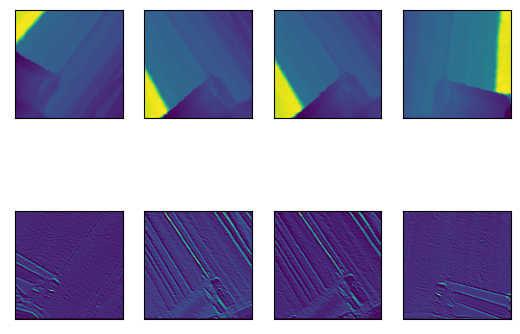

In [49]:
save_result(0)